In [14]:
!pip install JSAnimation
!pip install matplotlib
!pip install scikit-image
!pip install ffmpeg

  Running setup.py bdist_wheel for ffmpeg: started
  Running setup.py bdist_wheel for ffmpeg: finished with status 'done'
  Stored in directory: C:\Users\Matheus Mortatti\AppData\Local\pip\Cache\wheels\b6\68\c3\a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg


In [4]:
import gym
import numpy as np
import random
import copy
import os
import pickle
import time
from collections import deque
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from IPython.display import clear_output

from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames

In [5]:
"""
    Render frame onto IPython's output

    :param env: openai environment variable
"""
def render_frame(env):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    clear_output(wait=True)
    display(plt.gcf())

"""
    Creates gif from frames. Displays result onto IPython's output and saves as movie

    :param frames: frame buffer
    :param show_anim: if true, shows the result on the output
    :param save: if true, saves result on disk
    :param path: save path
"""
def create_gif_from_frames(frames, show_anim=True, save=True, path="gif"):
    
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    
    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, metadata=dict(artist='euzinho'), bitrate=1800)
        anim.save(path + '.mp4', writer=writer)
        
    if show_anim:
        display(display_animation(anim, default_mode='loop'))
    
    plt.close()

"""
    Preprocess frame, gray scaling, normalizing and cropping and needed

    :param frame: RGBA frame
"""    
def preprocess_frame(frame):
    
    # transform RGB into Gray Scale
    gray = rgb2gray(frame)
    
    # Crop the screen, removing unnecessary parts
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    preprocessed_frame = transform.resize(normalized_frame, [110,84])
    
    return preprocessed_frame

## Define Parameters

In [6]:
##### Parameters ################################
frame_stack_size = 4
frame_skip_size = 3

alpha = 0.00025 # Learning Rate

memory_max_size = 10000


y = 0.99                # Discount factor
num_episodes = 2000     # Number of Episodes to Train
batch_size = 32         # Number of Examples to Train With
max_steps = 50000       # Max steps to run episode


e = 1.0                  # Initial Explore Factor
ef = 0.01                # Final Explore Factor
decay_rate = 0.00000001  # Rate at which the explore factor will deacy


max_tau = 10000         # Number of iterations that will take for one network to catch up to the other
tau = 0


##### input and action sizes ####################

# Create the environment
env = gym.make("SpaceInvaders-v4")

# input_size = pixel_number * frame_stack_size
input_size = frame_stack_size
for i in range(len(env.observation_space.shape)-1):
    input_size *= env.observation_space.shape[i]

action_size = env.action_space.n

print("Environment Screen Shape: " + str(env.observation_space.shape))
print("Environment Action Options: " + str(action_size))

c:\users\matheus mortatti\appdata\local\programs\python\python36\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Environment Screen Shape: (210, 160, 3)
Environment Action Options: 6


## Define Memory Buffer Class

This class will be capable of adding new elements to the buffer as well as sample N elements with different probabilities of being chosen, returning a weight value that is smaller for elements that are more likely to be chosen. Also, we can update each of the current element's weights

In [7]:
# Define Memory Buffer
# class Memory():
#     e = 0.01
#     a = 0.7
#     b = 0.3
#     b_inc = 0.001
    
#     def __init__(self, max_size):
#         self.buffer = deque(maxlen = max_size)
#         self.weights = deque(maxlen = max_size)
    
#     def add(self, experience, weight=0):
#         self.buffer.append(experience)
#         self.weights.append(np.power(np.abs(weight)+self.e, self.a))
    
#     def sample(self, batch_size):
#         buffer_size = len(self.buffer)
        
#         self.b = np.min([1.0, self.b+self.b_inc])
        
#         s=sum(self.weights)
#         density = [e/s for e in self.weights]
        
#         max_density = min(density)
#         max_density = np.power(batch_size * max_density, -self.b)
        
#         index = np.random.choice(np.arange(buffer_size),
#                                 size = batch_size,
#                                 replace = True, 
#                                 p=density)
        
#         batch = [self.buffer[i] for i in index]
#         ISWeights_ = [np.power(density[i]*batch_size, -self.b)/max_density for i in index]
        
#         return batch, np.array(ISWeights_).reshape((batch_size,1)), index
    
#     def UpdateWeights(self, values, indexes):
#         j=0
#         for i in indexes:
#             self.weights[i] = np.power(np.abs(values[j])+self.e, self.a)
#             j+=1

class Memory():
    def __init__(self, max_size, save_path="logs/memory.p"):
        self.buffer = deque(maxlen = max_size)
        self.save_path=save_path
    
    def add(self, experience, weight=0):
        self.buffer.append(experience)
        
    def save(self):
        pickle.dump(self.buffer, open(self.save_path, 'wb'))
    
    def load(self):
        try:
            print("successfuly loaded memory values")
            self.buffer = pickle.load(open(self.save_path, 'rb'))
        except FileNotFoundError:
            print("could not load memory values")
            pass
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = True)
        
        batch = [self.buffer[i] for i in index]
        
        return batch

In [8]:
memory = Memory(memory_max_size)

## Create Frame Stacking Functions

In [9]:
stacked_frames  =  deque([np.zeros((110,84), dtype=np.int) for i in range(frame_stack_size)], maxlen=frame_stack_size)
def StackFrame(stack, frame):
    stack.append(frame)
def ClearStack(stack):
    stack  =  deque([np.zeros((110,84), dtype=np.int) for i in range(frame_stack_size)], maxlen=frame_stack_size)

## Pre-Fill the memory with random actions

In [10]:
s = env.reset()

ClearStack(stacked_frames)

gray_frame = preprocess_frame(s)
for k in range(frame_stack_size):
    StackFrame(stacked_frames, gray_frame)

# Filll up the memory buffer until it's max
for i in range(memory_max_size):

    #copy stacked frames
    c_stacked_frames = copy.deepcopy(stacked_frames)

    state = np.stack(stacked_frames,axis=2)
    
    a = env.action_space.sample()

    #Get new state and reward from environment
    s1,r,d,_ = env.step(a)

    #stack new frame
    gray_frame = preprocess_frame(s1)
    StackFrame(stacked_frames, gray_frame)


    if d == True:
        next_state = np.stack(stacked_frames,axis=2)
        last_action = True
        
        s = env.reset()

        ClearStack(stacked_frames)

        gray_frame = preprocess_frame(s)
        for k in range(frame_stack_size):
            StackFrame(stacked_frames, gray_frame)
            
    else:
        next_state = np.stack(stacked_frames,axis=2)

        last_action = False
        
    memory.add((state, r, a, next_state, last_action))


c:\users\matheus mortatti\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\matheus mortatti\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## Define The Architecture

In [11]:
class DDDQNetwork():
    def __init__(self, input_size, action_size, learning_rate=0.01, name=""):
        
        self.learning_rate = learning_rate
        self.input_size = input_size
        self.action_size = action_size
        self.name = name
        
        with tf.variable_scope(self.name):
            self.inputs_ = tf.placeholder(shape=[None, *input_size],dtype=tf.float32)
            self.target_Q = tf.placeholder(tf.float32, [None, self.action_size], name="target")
            self.ISWeights_ = tf.placeholder(tf.float32, [None, 1], name="ISWeights")
            
            
            # First Convolutional Layer
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                          filters = 32,
                                          kernel_size = [8,8],
                                          strides = [4,4],
                                          padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv1")

            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                                                 training = True,
                                                                 epsilon = 1e-5,
                                                                 name = 'batch_norm1')

            self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")
            
            
            # Second Convolutional Layer
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                          filters = 64,
                                          kernel_size = [4,4],
                                          strides = [2,2],
                                          padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv2")

            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                                 training = True,
                                                                 epsilon = 1e-5,
                                                                 name = 'batch_norm2')

            self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
            
            
            
            #Third Convolutional Layer
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 64,
                                 kernel_size = [3,3],
                                 strides = [1,1],
                                 padding = "VALID",
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")

            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm3')

            self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")
            
            # Flatten the results to feed into the dense network
            self.flatten = tf.layers.flatten(self.conv3_out)
            
#             self.common_fc = tf.layers.dense(inputs = self.flatten,
#                                              units = 512,
#                                              activation = tf.nn.elu,
#                                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
#                                              name="common_fc")

            self.value_fc1 = tf.layers.dense(inputs = self.flatten,
                                             units = 512,
                                             activation = tf.nn.relu,
                                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                             name="value_fc1")

            self.advantage_fc1 = tf.layers.dense(inputs = self.flatten,
                                                 units = 512,
                                                 activation = tf.nn.relu,
                                                 kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                                 name="advantage_fc1")

            self.value = tf.layers.dense(inputs = self.value_fc1, 
                                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                         units = 1, 
                                         activation=None)

            self.advantage = tf.layers.dense(inputs = self.advantage_fc1, 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                             units = self.action_size, 
                                             activation=None)

            self.output = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True))

            
            # Mean Squared error between target and output, multiplied by the weights of each sample
            self.loss = tf.losses.huber_loss(self.target_Q, self.output)  #tf.reduce_mean(self.ISWeights_ * tf.square(self.target_Q - self.output))
#             self.absolute_error = tf.abs(tf.reduce_mean(self.target_Q - self.output, axis=1))

            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate, epsilon=0.01).minimize(self.loss)

#             self.correct_prediction = tf.equal(tf.argmax(self.output, 1), tf.argmax(self.target_Q, 1))
#             self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

## Copy one model's weights to another

In [12]:
def update_target_graph(name_from, name_to):
    
    # Get the parameters of our DQNNetwork
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name_from)
    
    # Get the parameters of our Target_network
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name_to)

    op_holder = []
    
    # Update our target_network parameters with DQNNetwork parameters
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

## Create networks

In [14]:
tf.reset_default_graph()

# Create target and action network
action_network = DDDQNetwork([110,84,frame_stack_size], action_size, learning_rate=alpha, name="action_network")
target_network = DDDQNetwork([110,84,frame_stack_size], action_size, learning_rate=alpha, name="target_network")

# Saver to save our model
saver = tf.train.Saver()

# Setup TensorBoard Writer
writer = tf.summary.FileWriter("tensorboard/dddqn/1")

## Losses
tf.summary.scalar("Loss", action_network.loss)

write_op = tf.summary.merge_all()

In [15]:
# Setting a few training paramenters
continue_training   = True
training_id         = int(round(time.time() * 1000))
model_name          = "model_spaceinvaders"


# Create video directory
video_dir = "videos/" + model_name + "_" + str(training_id)
if not os.path.exists(video_dir):
    os.makedirs(video_dir)

    
# Define which device will be used for training
if tf.test.is_gpu_available():
    print("Using available GPU for training")
    device = "/gpu:0"
else:
    print("No GPU available, using CPU for training")
    device = "/cpu:0"

    
# Create logging directory
log_dir = "logs/" + model_name + "_" + str(training_id)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
#memory.save_path = log_dir + "/memory.p"
    
# Load previous logged values
averageQs = []
averageRs = []
start_episode = 0
if continue_training:
    #memory.load()
    
    try:
        start_episode = pickle.load(open(log_dir + '/start_episode.p', 'rb'))
    except FileNotFoundError:
        pass
    
    try:
        averageQs = pickle.load(open(log_dir + '/averageQs.p', 'rb'))
    except FileNotFoundError:
        pass
    
    try:
        averageRs = pickle.load(open(log_dir + '/averageRs.p', 'rb'))
    except FileNotFoundError:
        pass


Using available GPU for training


## Train!

INFO:tensorflow:Restoring parameters from ./models/model_spaceinvaders.ckpt


c:\users\matheus mortatti\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\matheus mortatti\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Episode 2000 ended.
	 Loss = 0.008386383
	 Total, Average Reward = 215.0, 0.3401898734177215
	 Average Predicted Q = 5.896902349930775
	 Frames Seen So Far = 632
	 Explore Prob = 0.010000000000000063
Model Saved



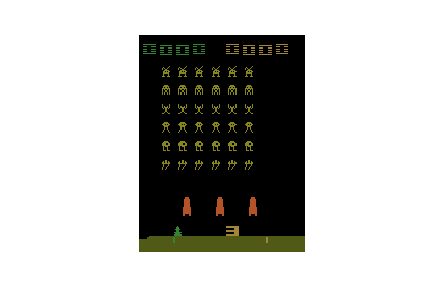
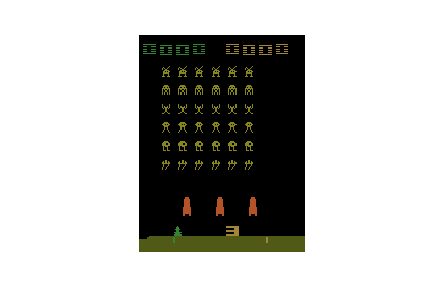
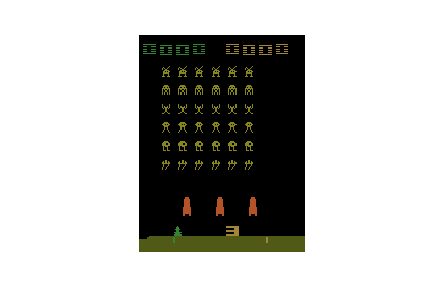
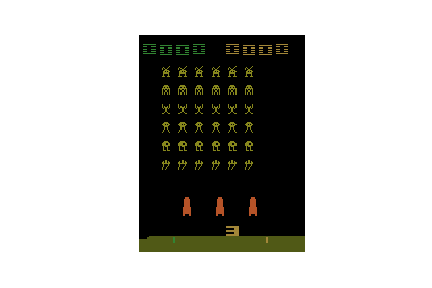
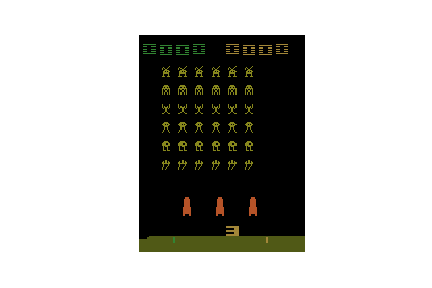
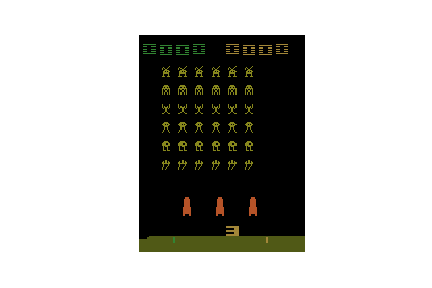
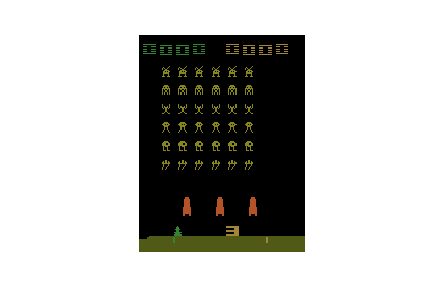
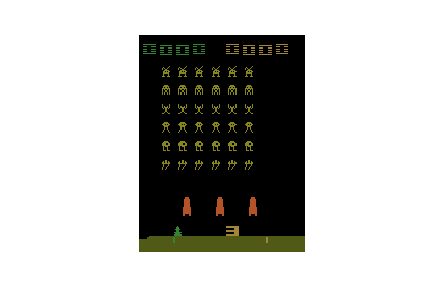
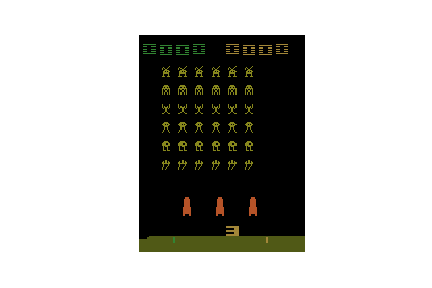
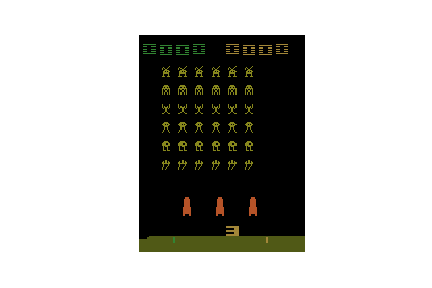
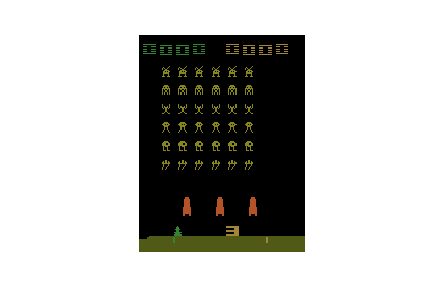
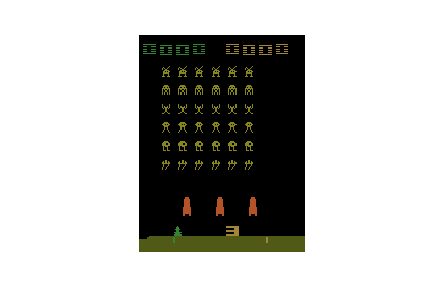
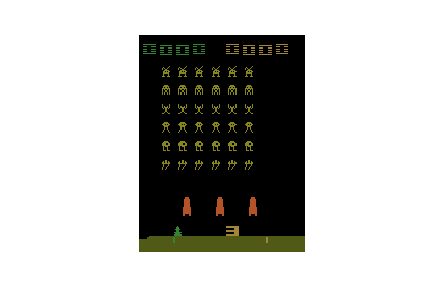
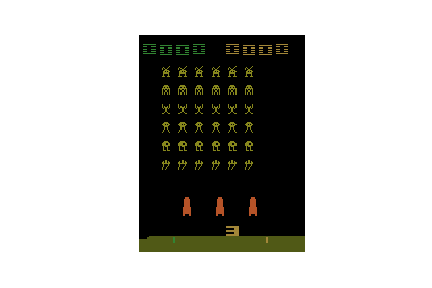
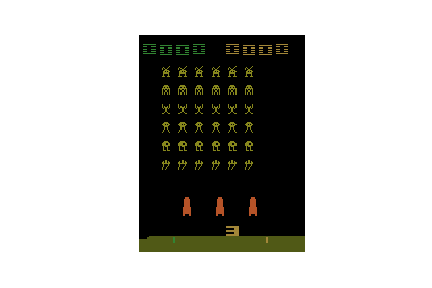
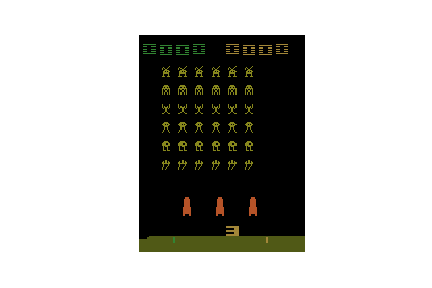
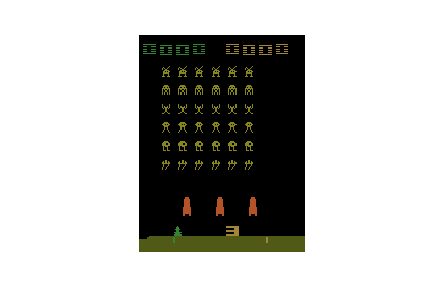
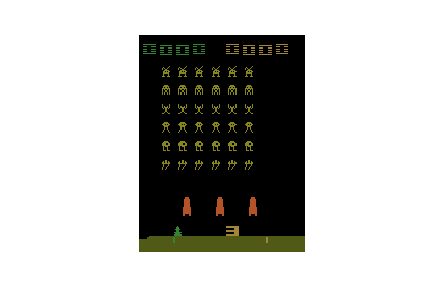
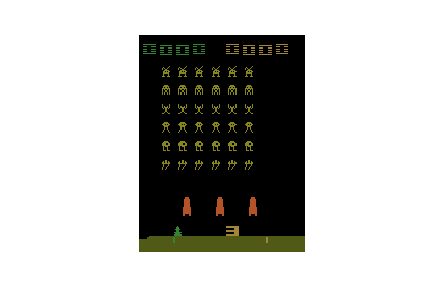
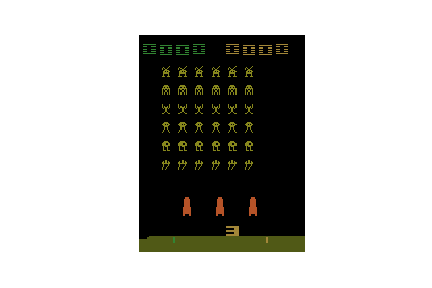
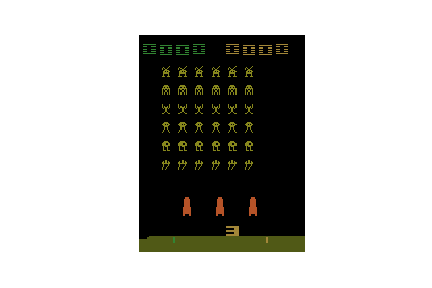
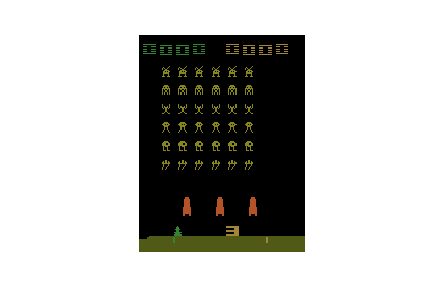
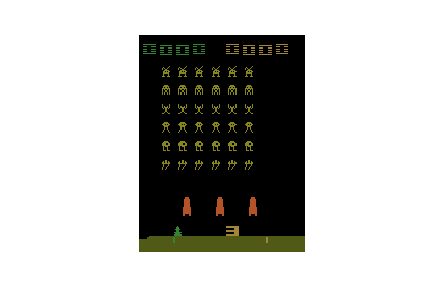
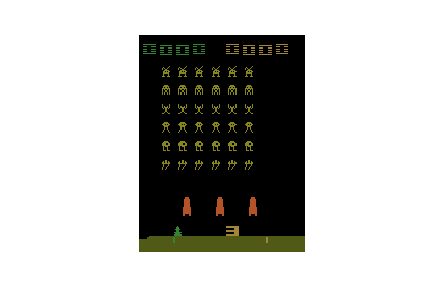
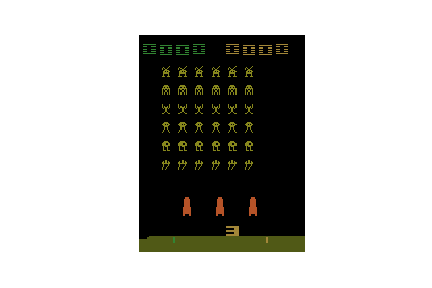
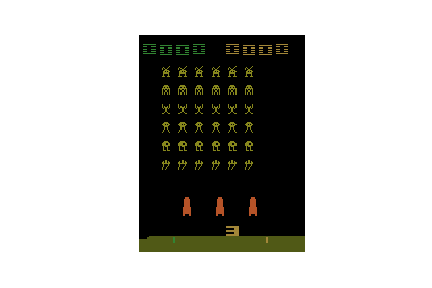
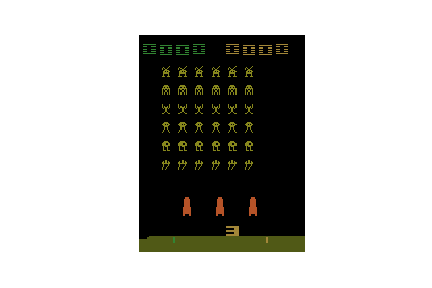
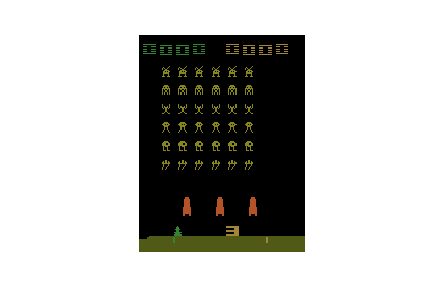
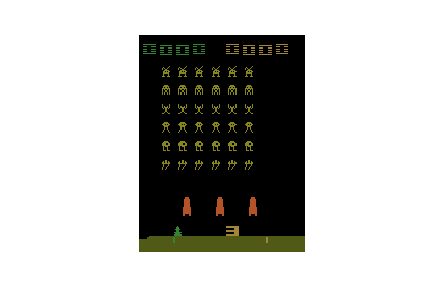
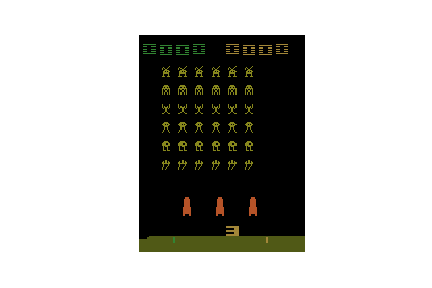
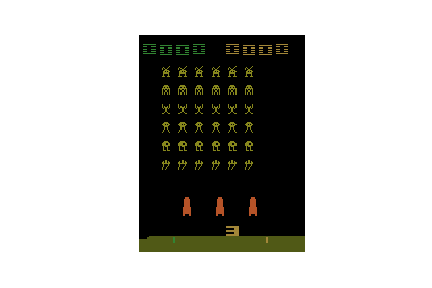
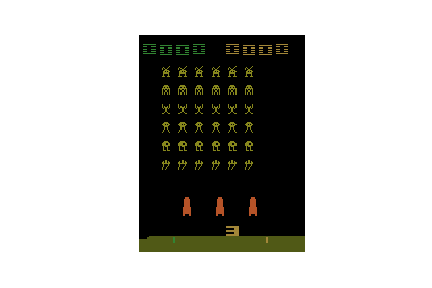
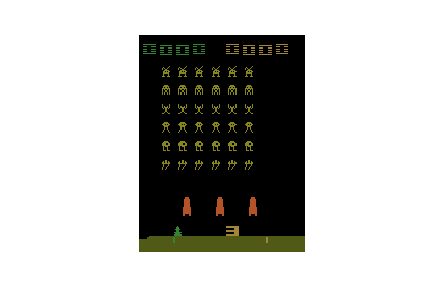
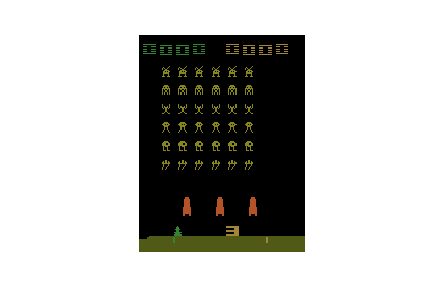
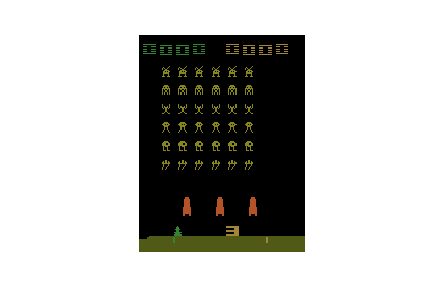
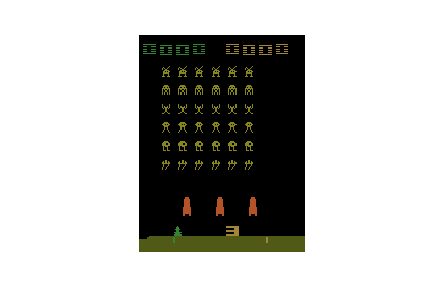
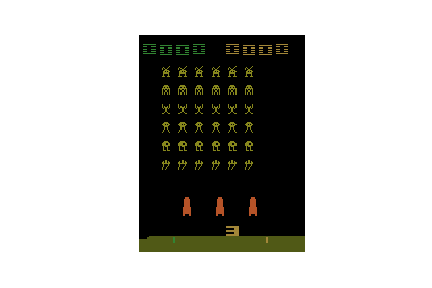
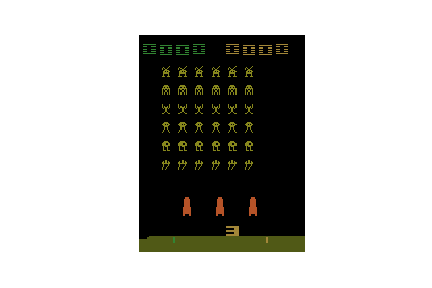
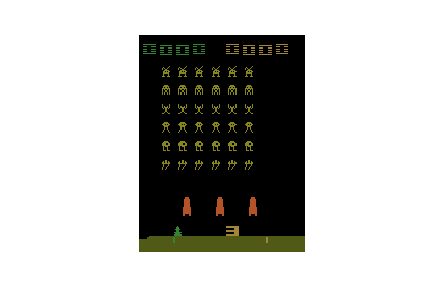
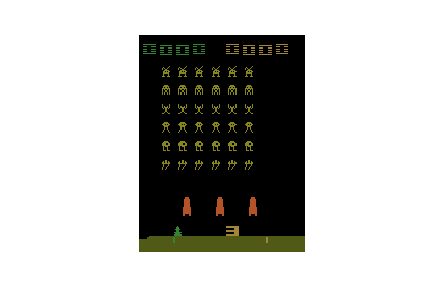
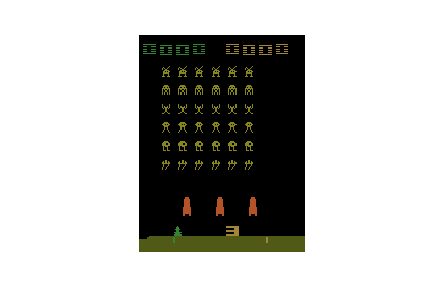
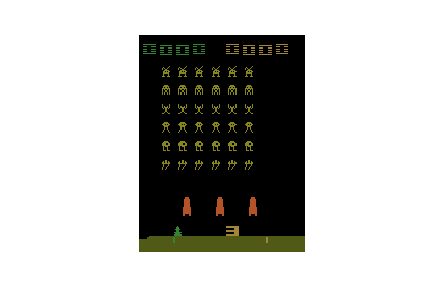
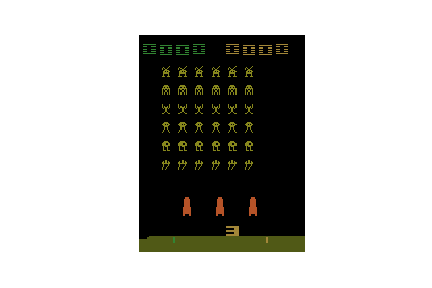
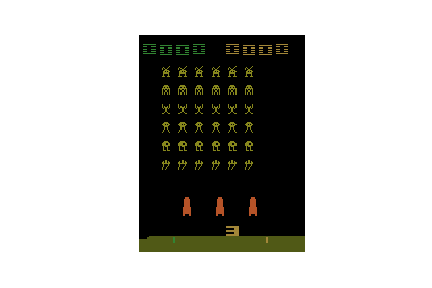
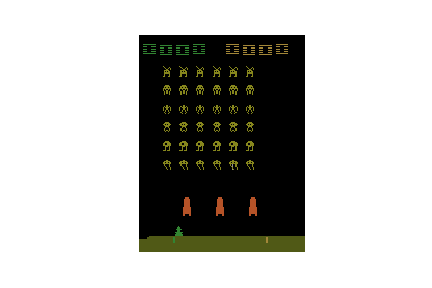
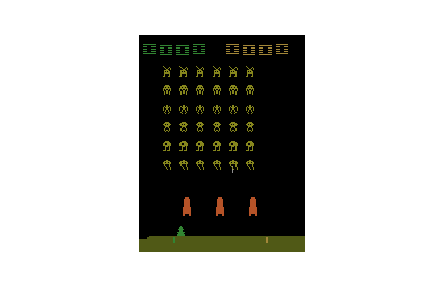
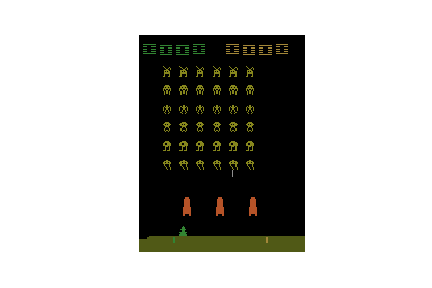
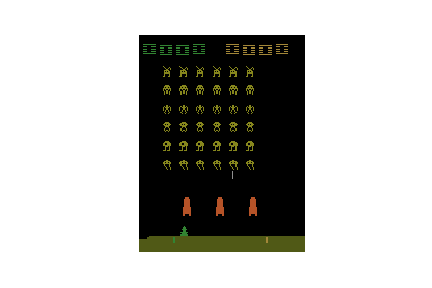
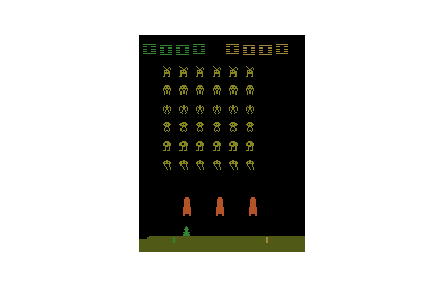
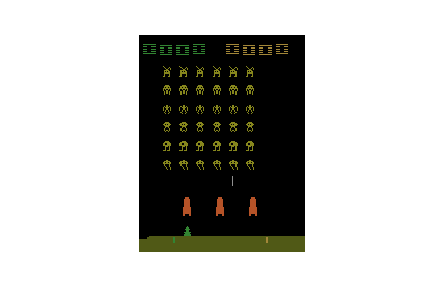
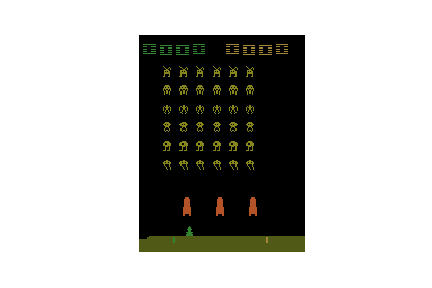
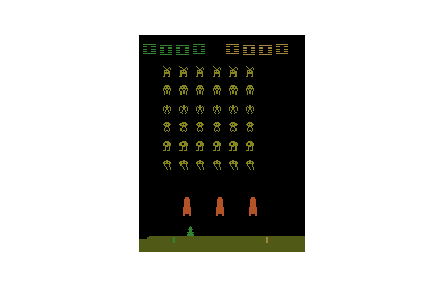
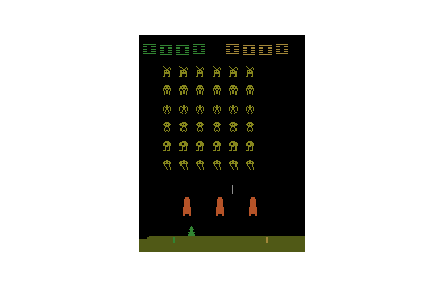
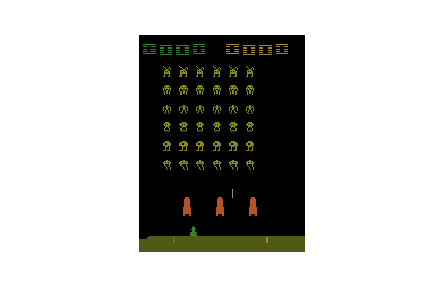
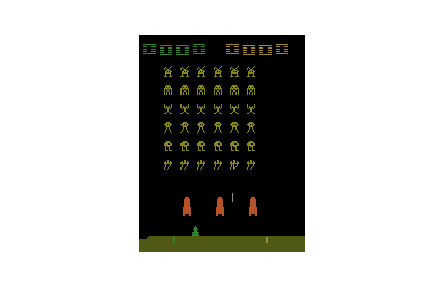
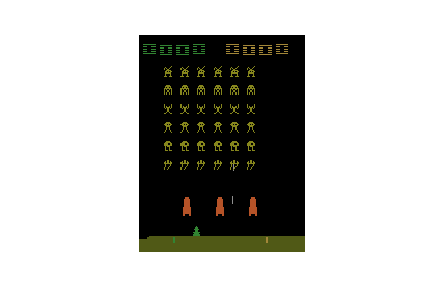
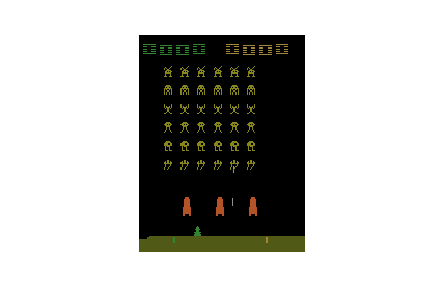
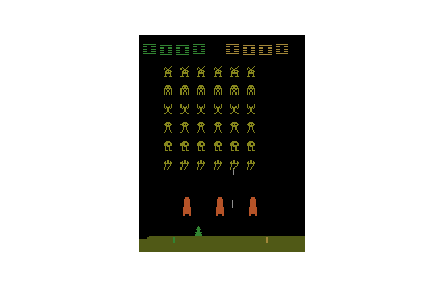
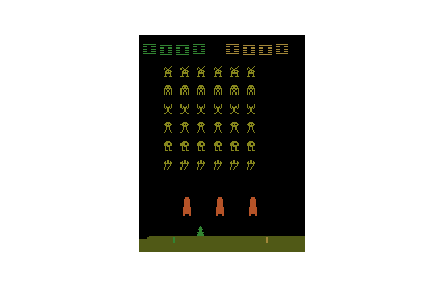
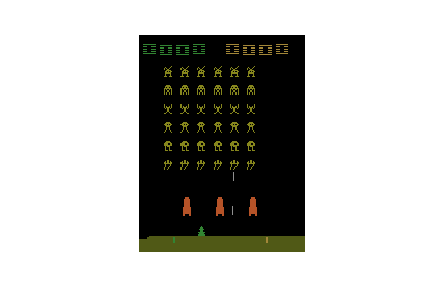
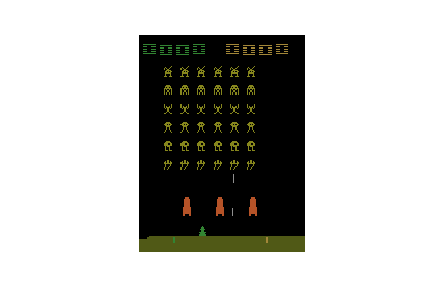
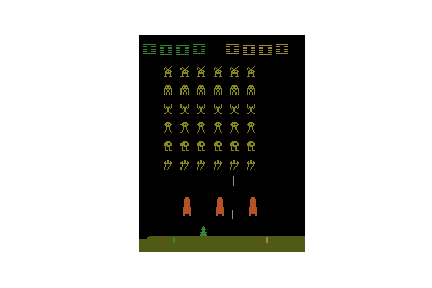
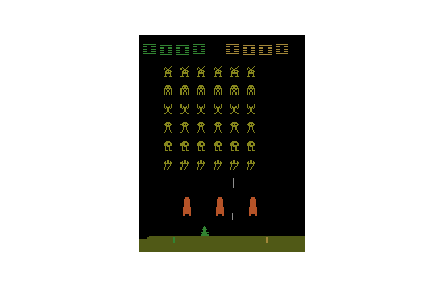
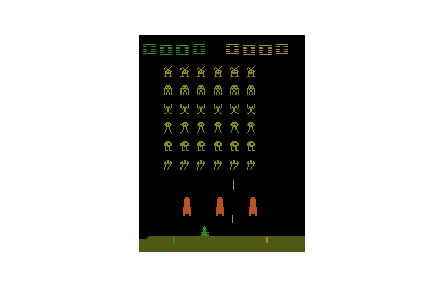
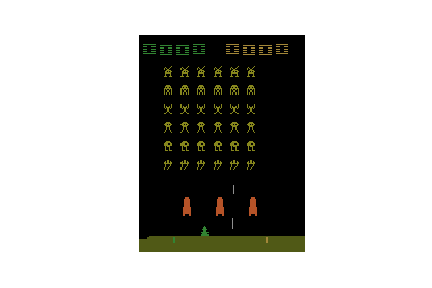
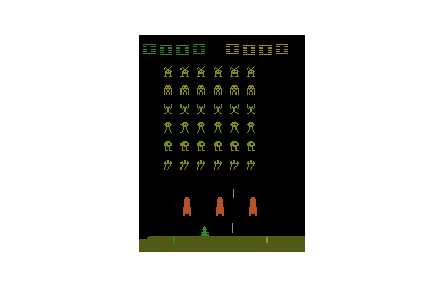
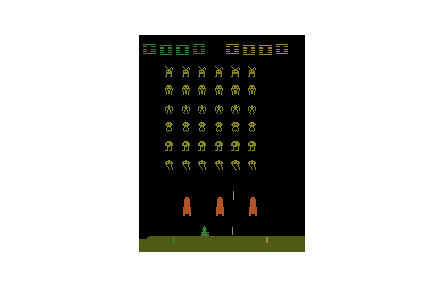
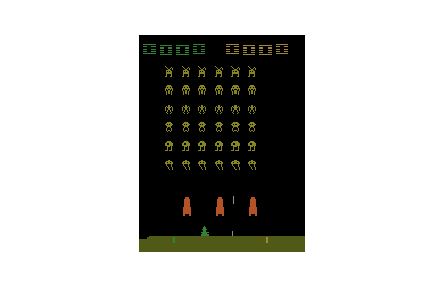
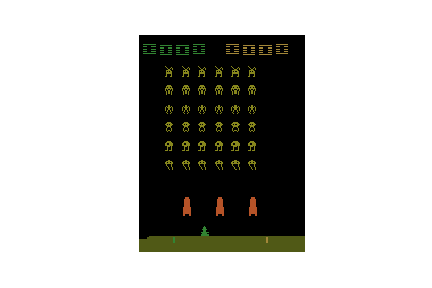
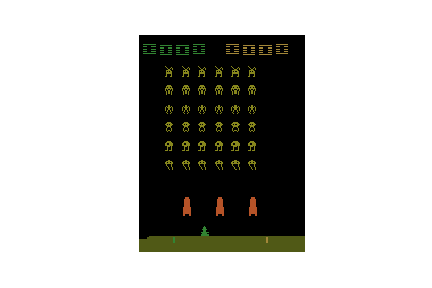
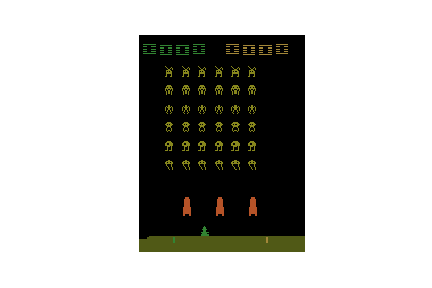
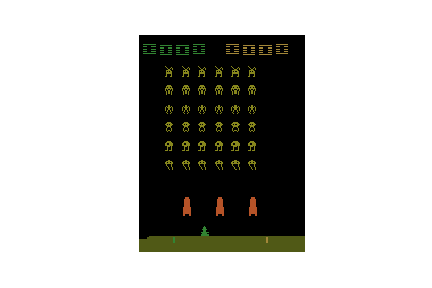
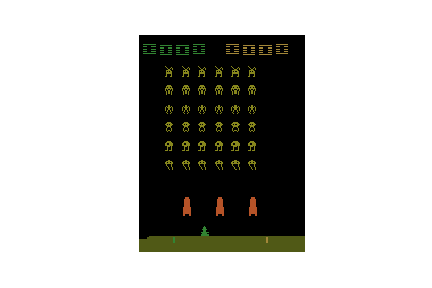
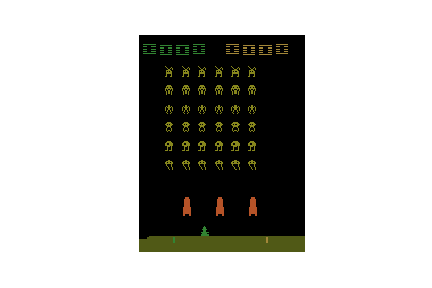
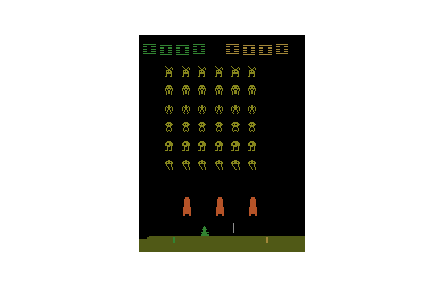
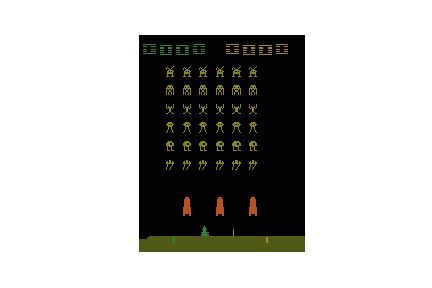
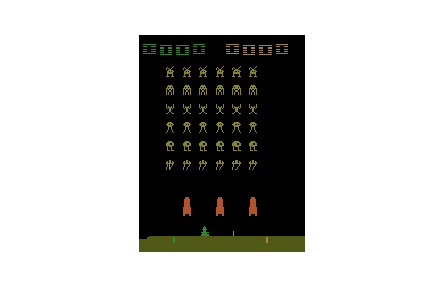
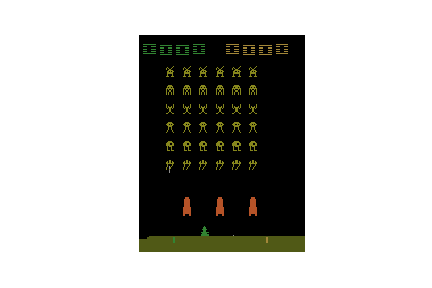
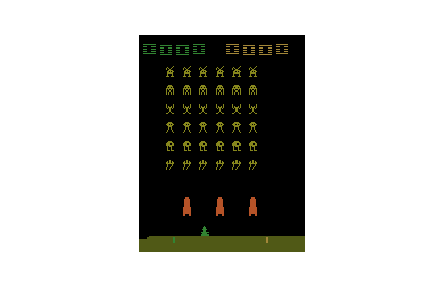
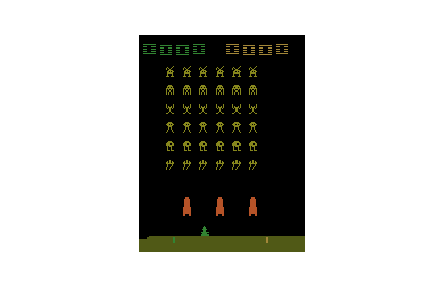
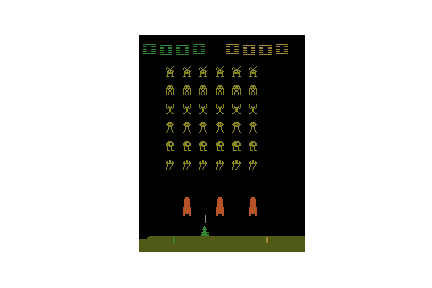
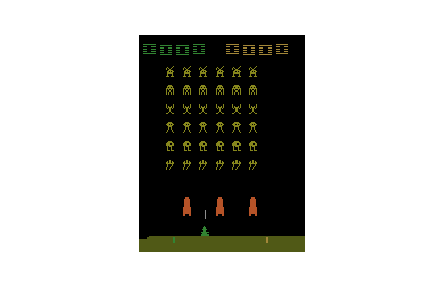
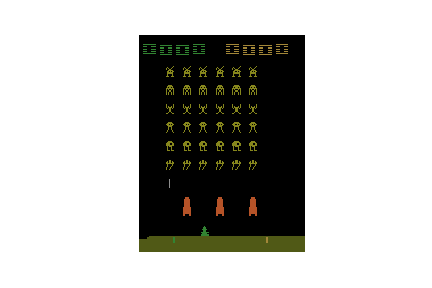
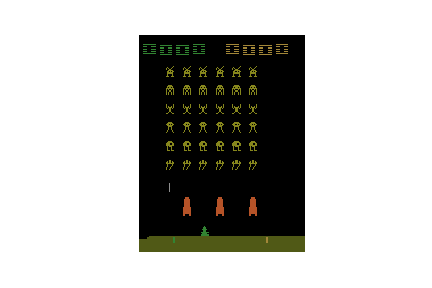
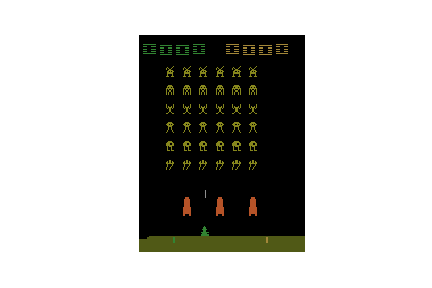
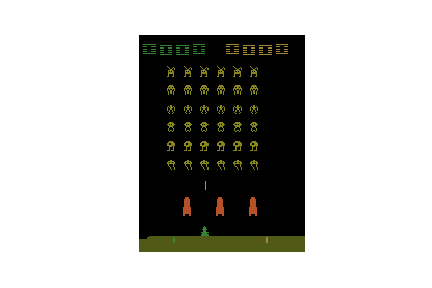
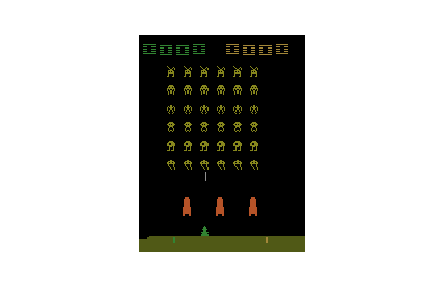
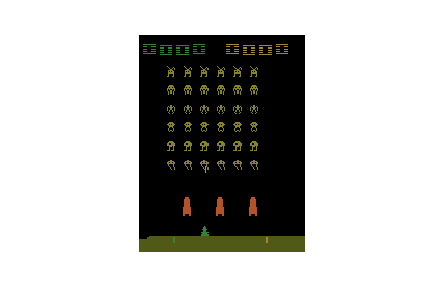
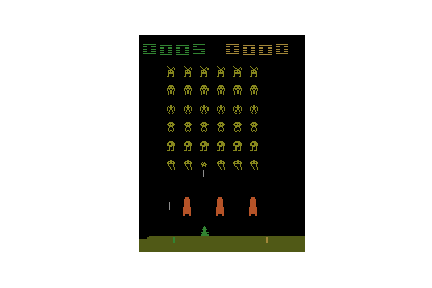
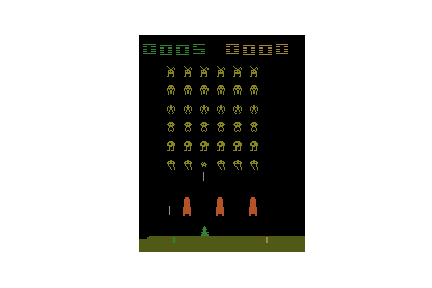
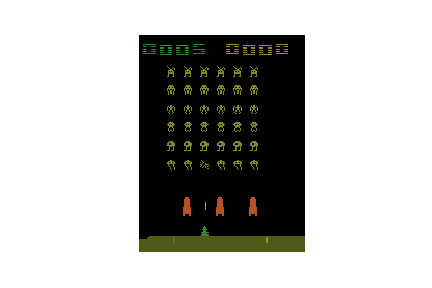
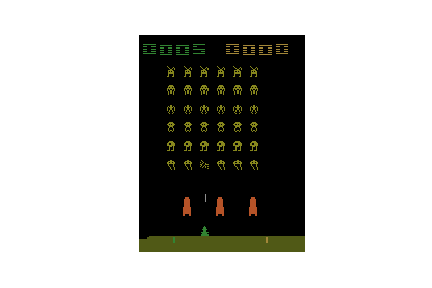
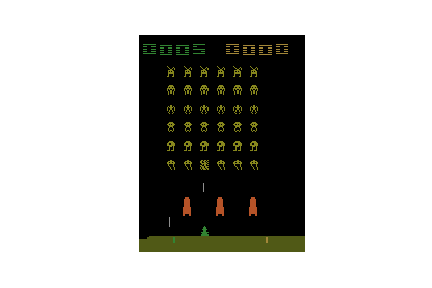
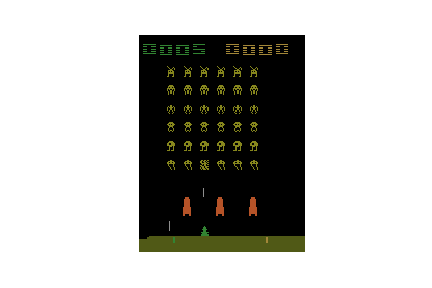
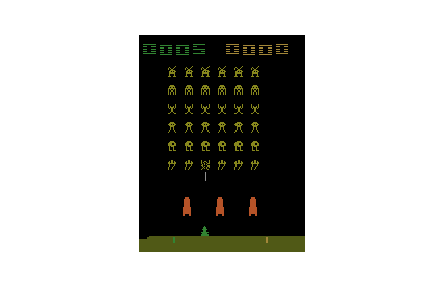
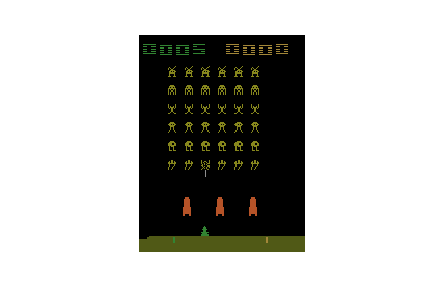
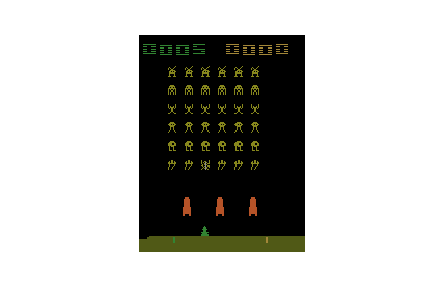
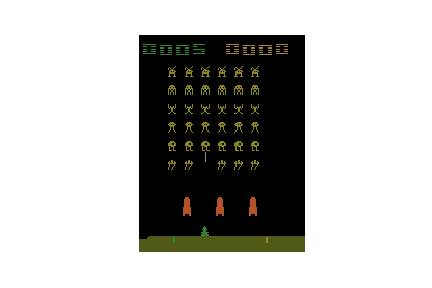
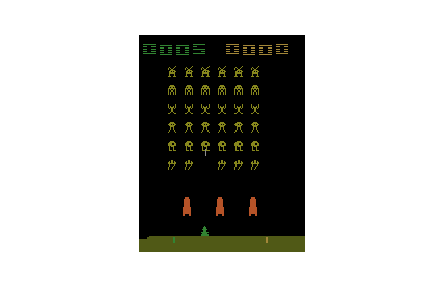
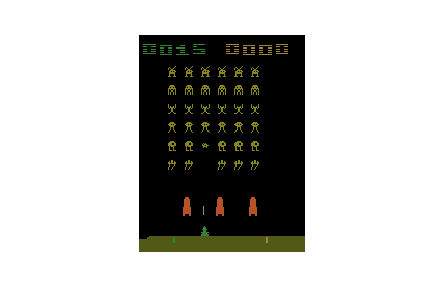
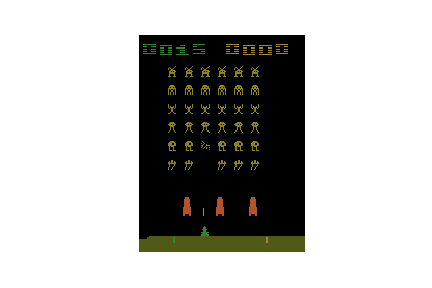
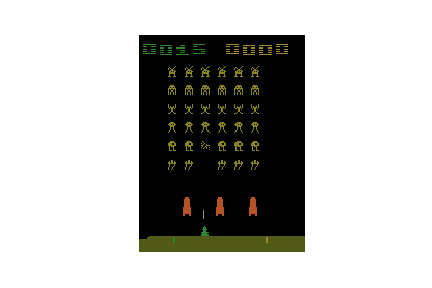
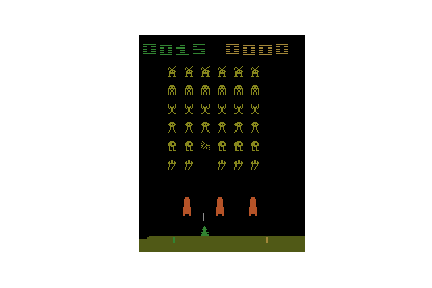
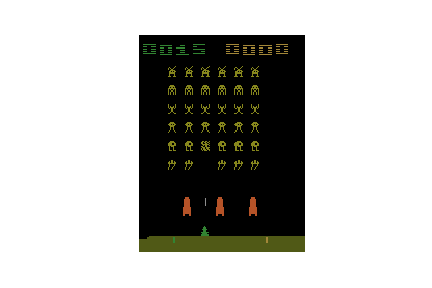
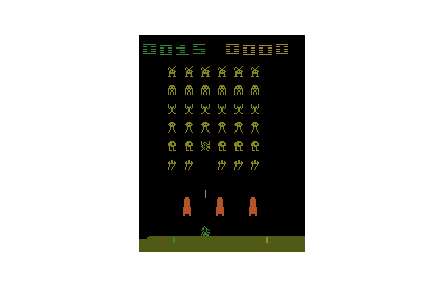
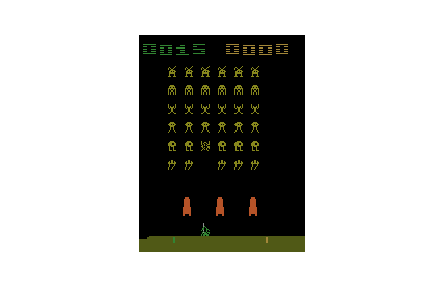
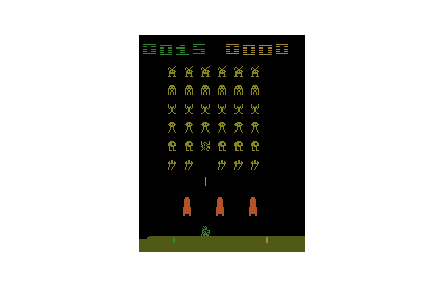
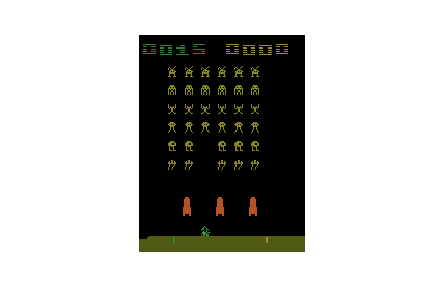
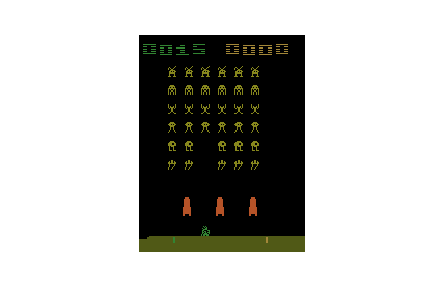
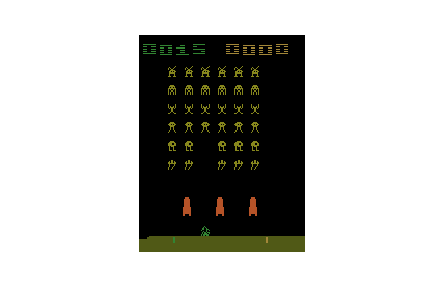
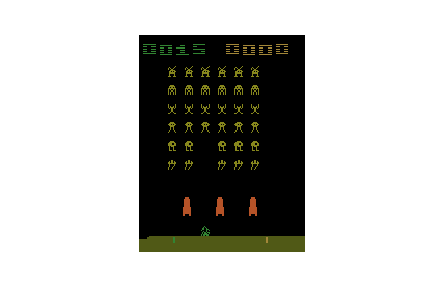
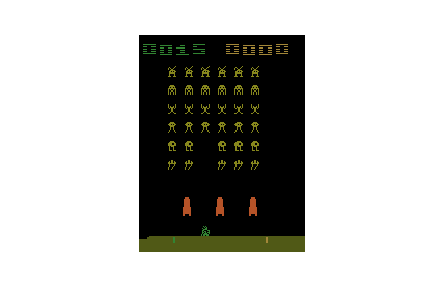
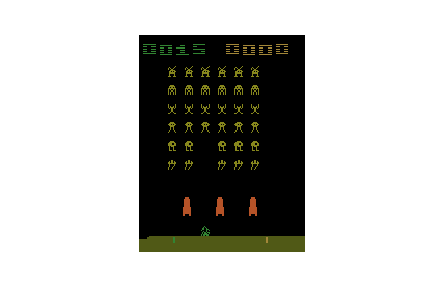
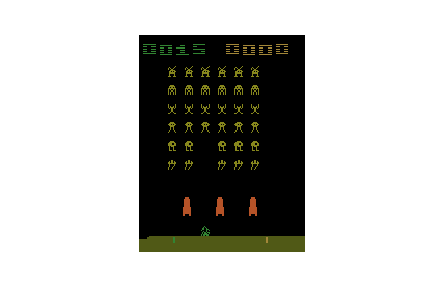
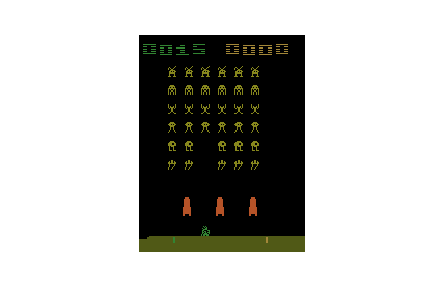
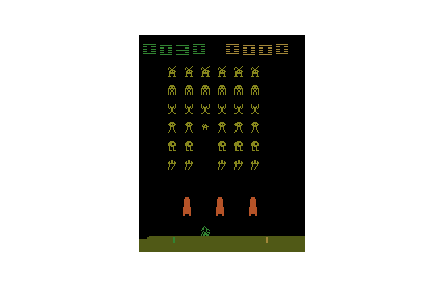
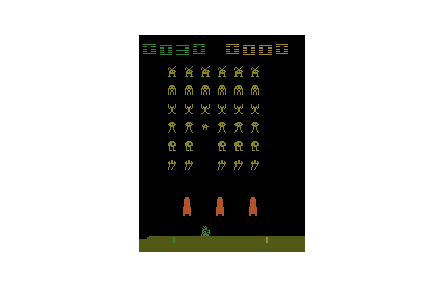
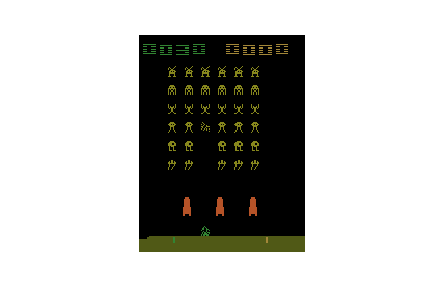
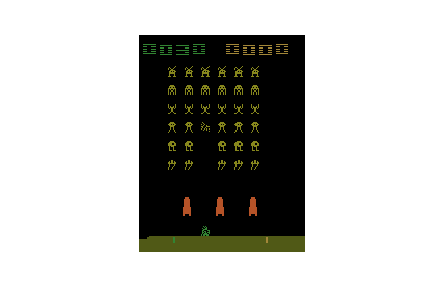
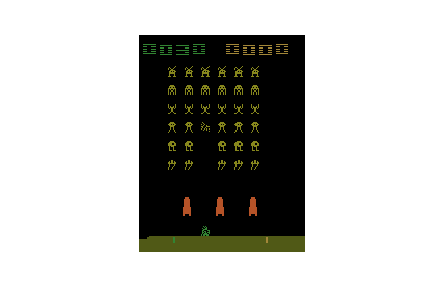
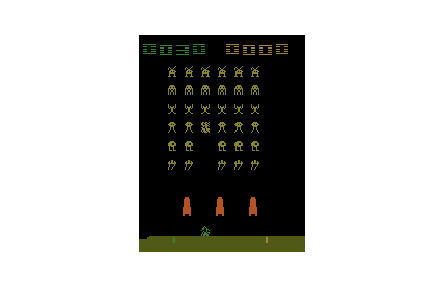
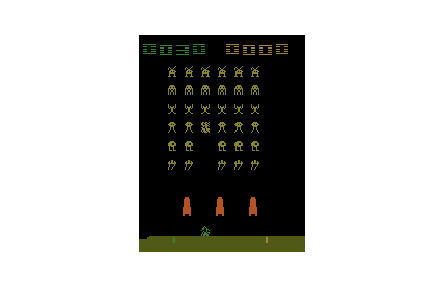
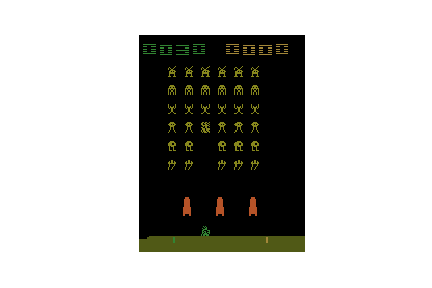
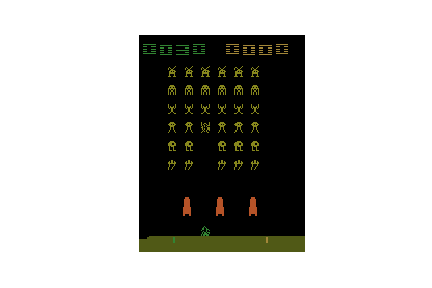
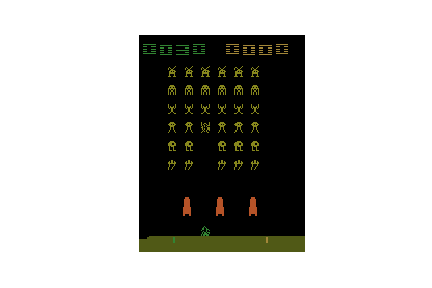
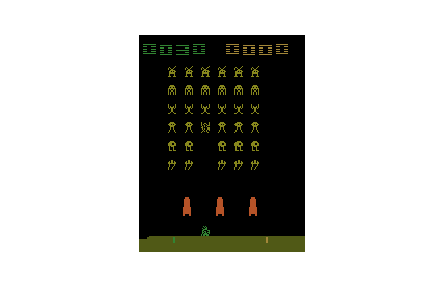
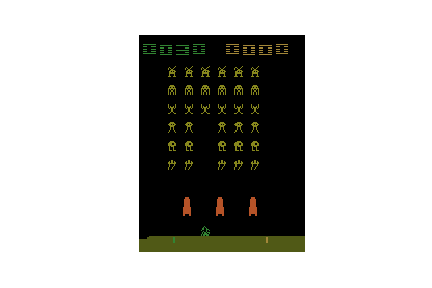
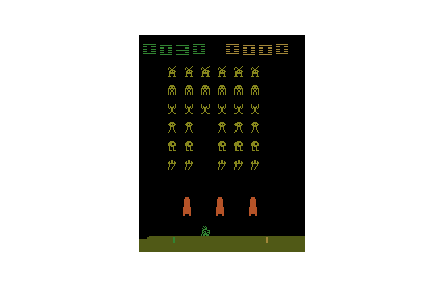
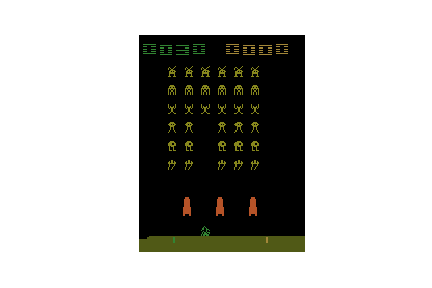
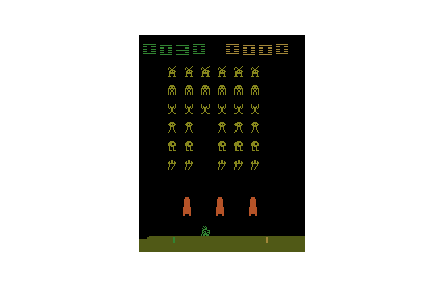
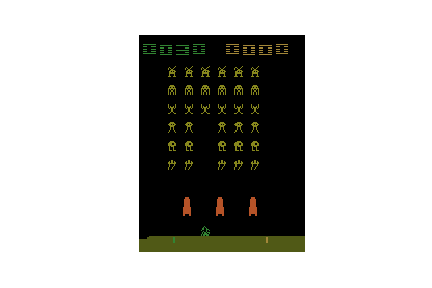
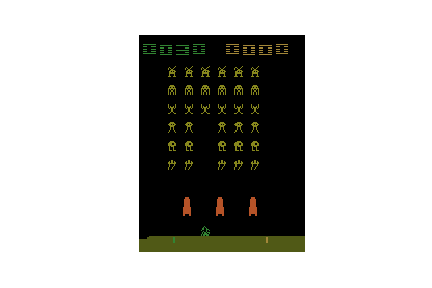
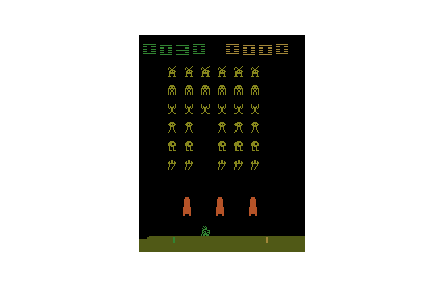
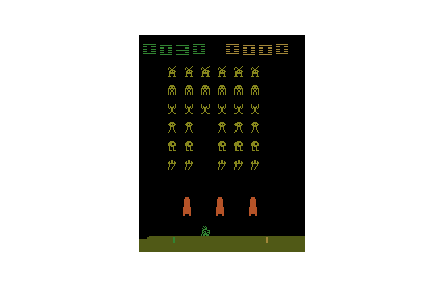
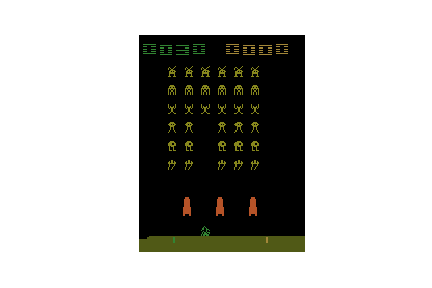
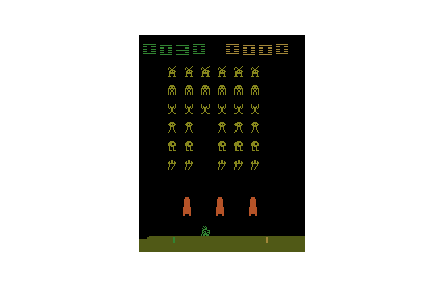
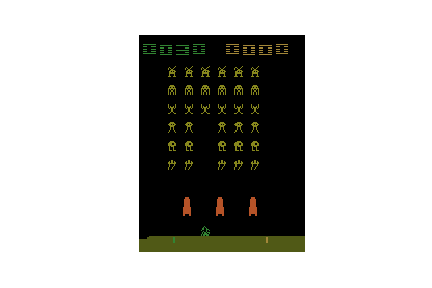
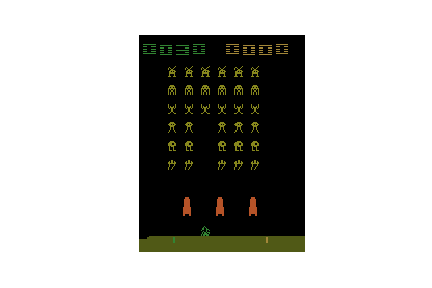
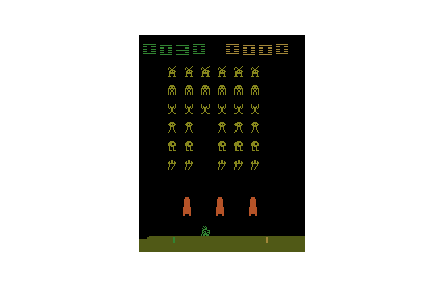
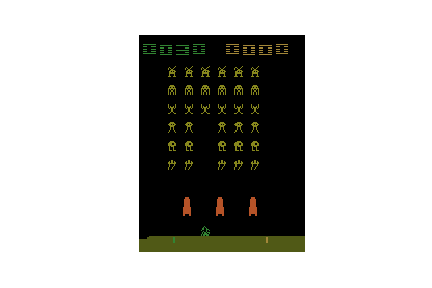
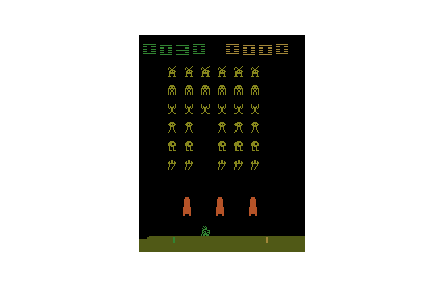
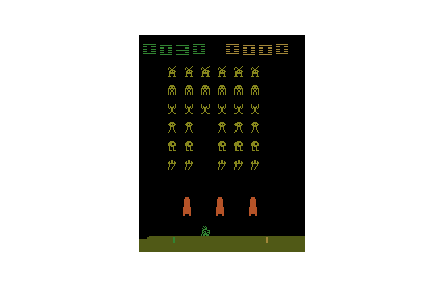
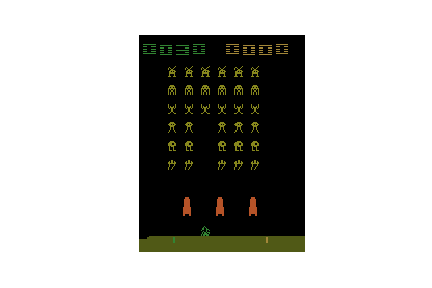
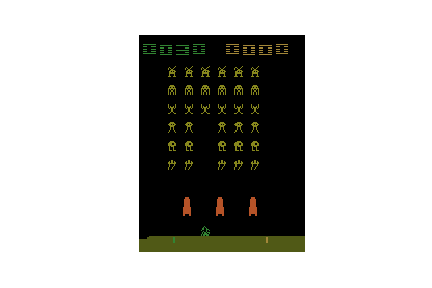
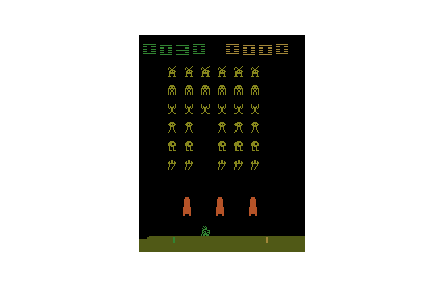
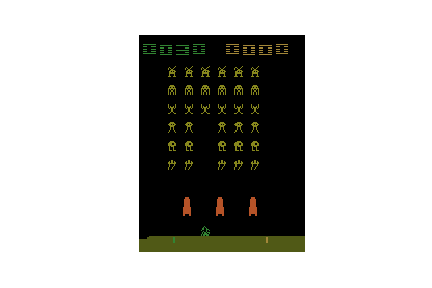
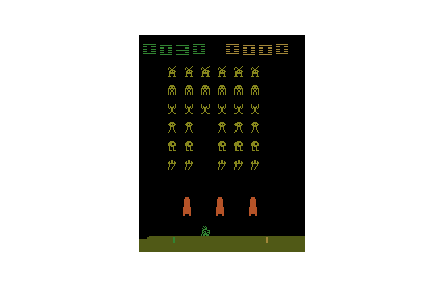
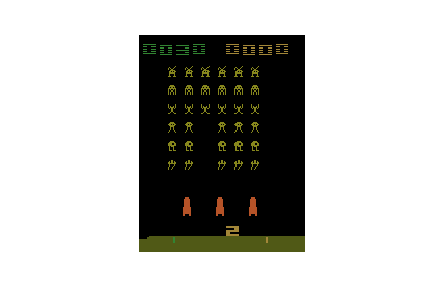
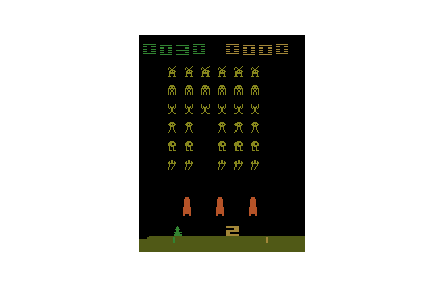
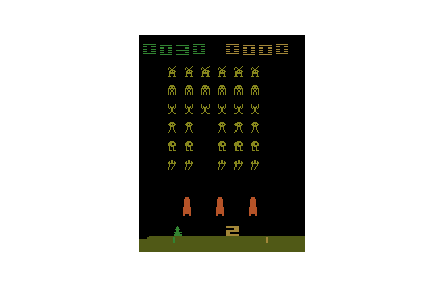
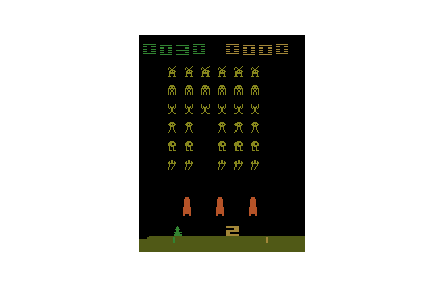
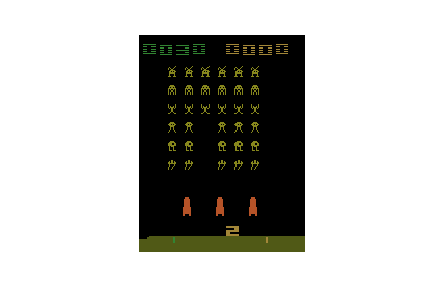
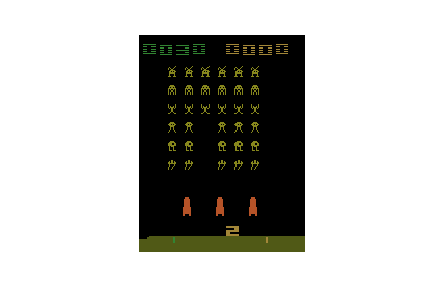
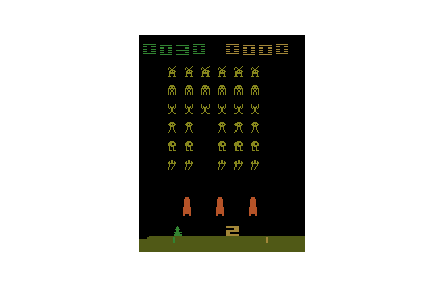
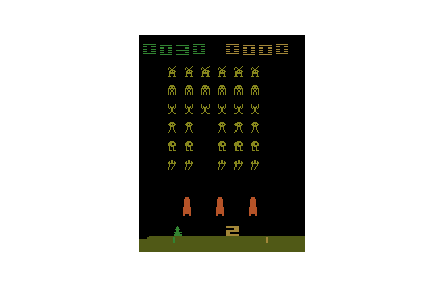
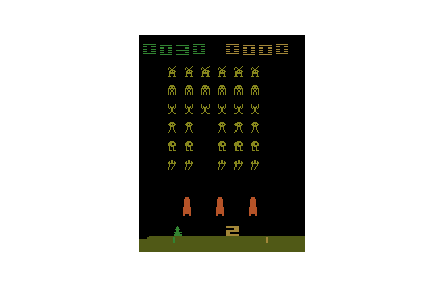
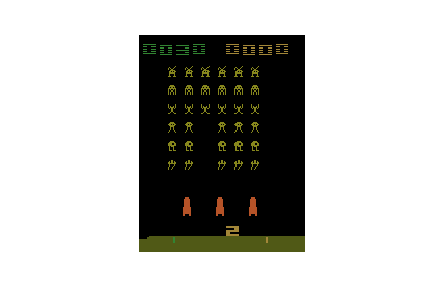
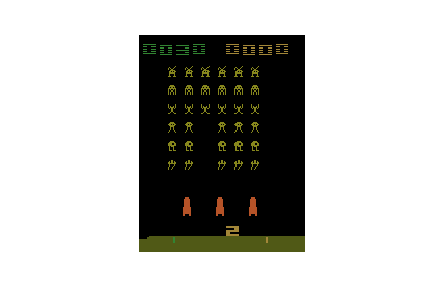
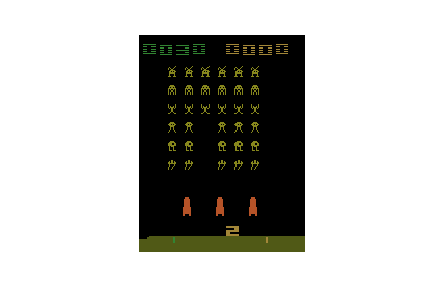
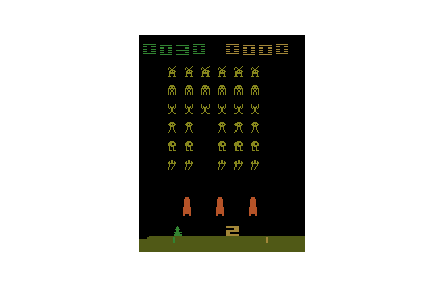
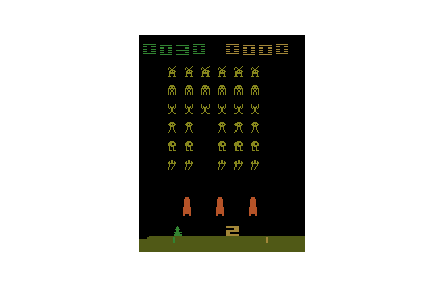
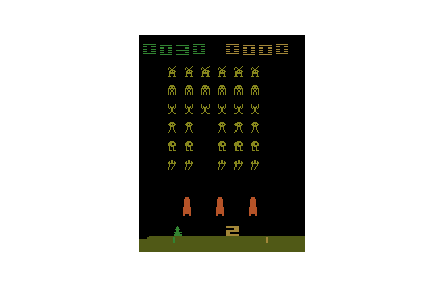
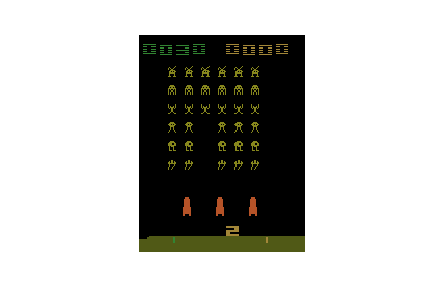
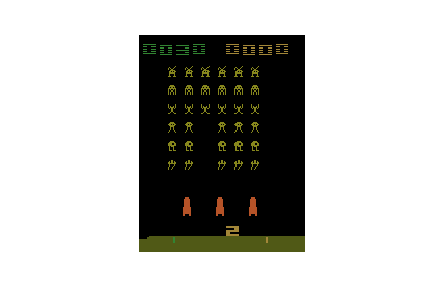
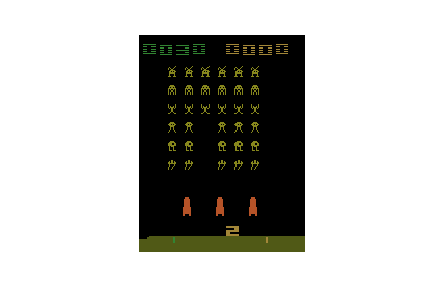
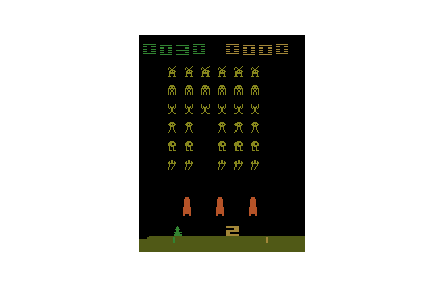
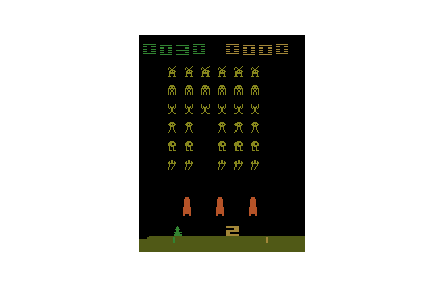
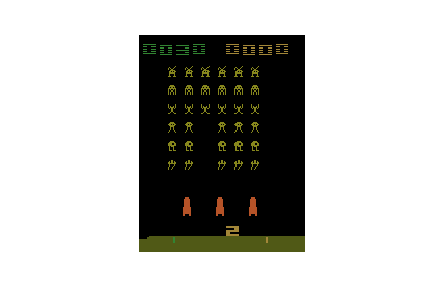
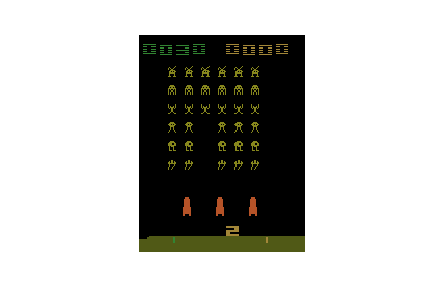
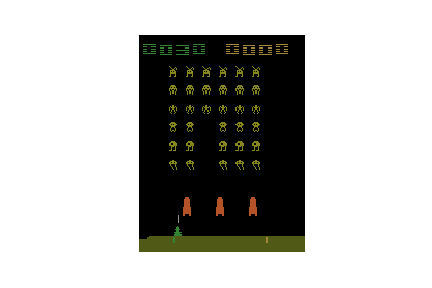
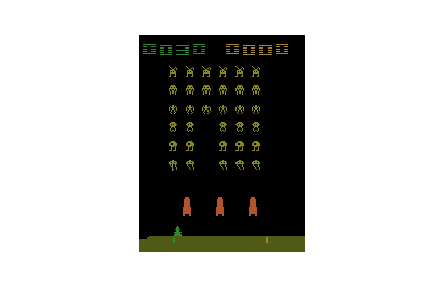
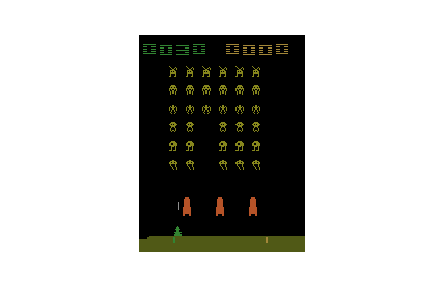
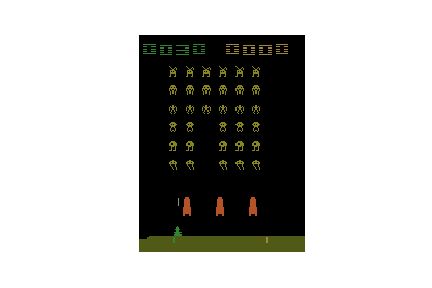
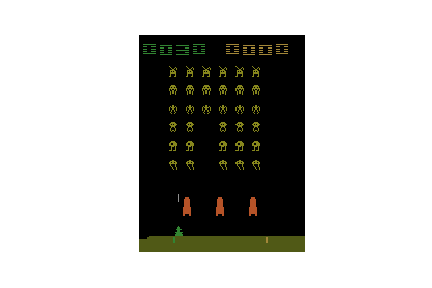
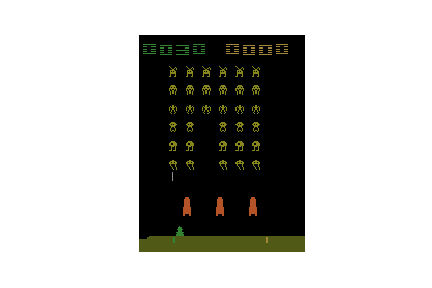
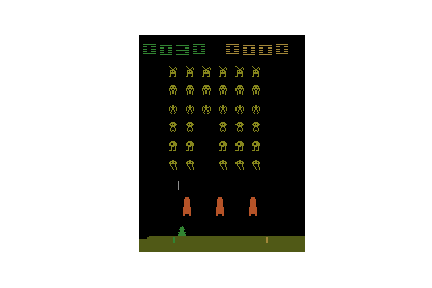
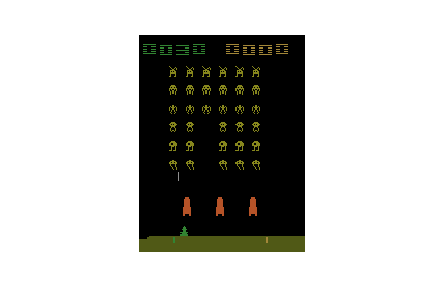
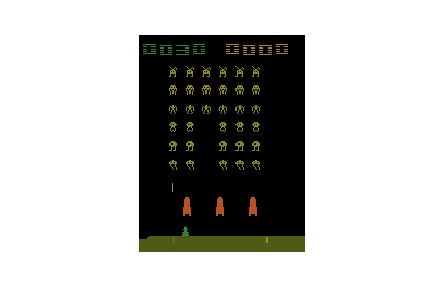
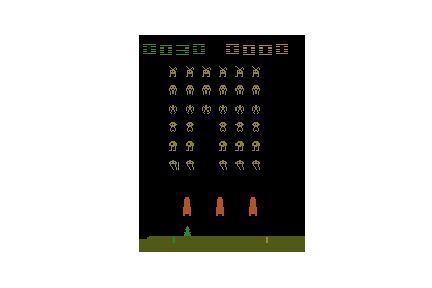
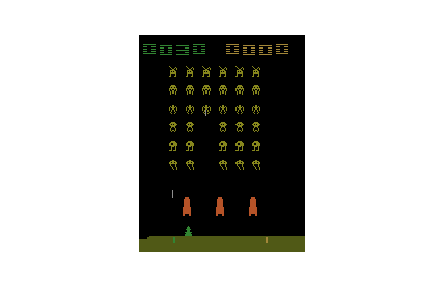
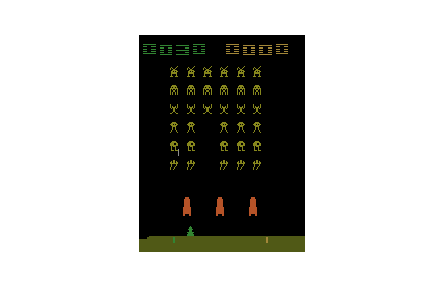
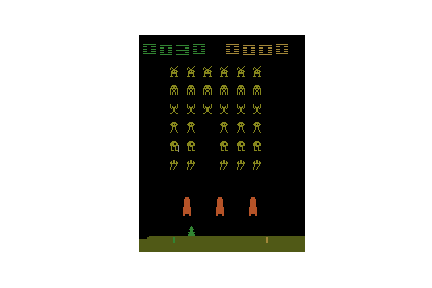
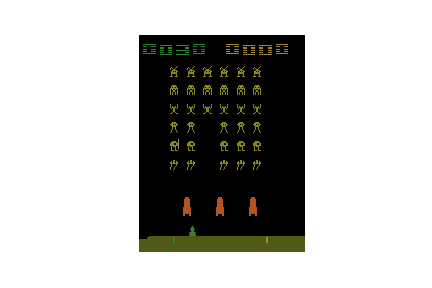
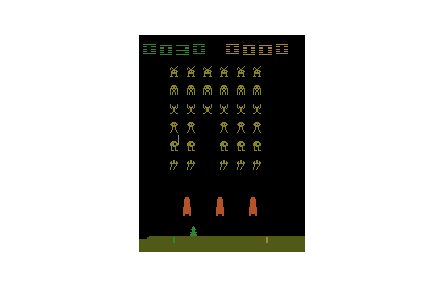
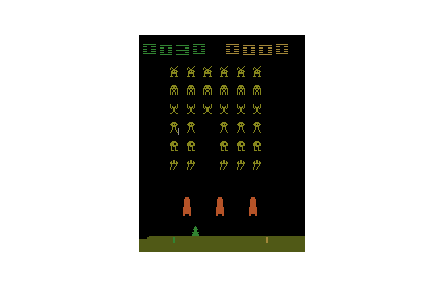
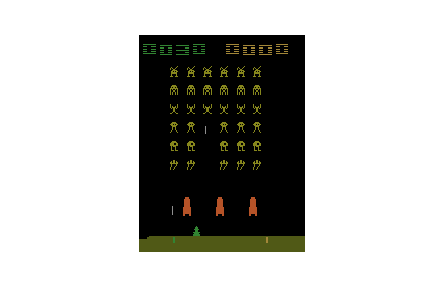
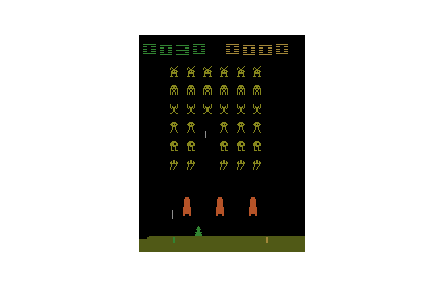
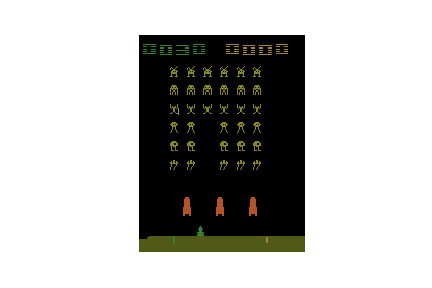
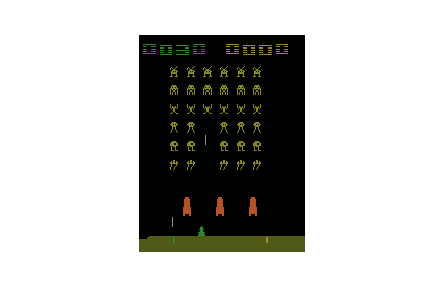
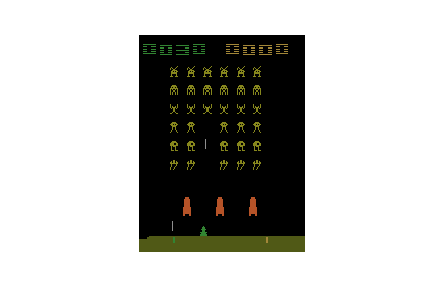
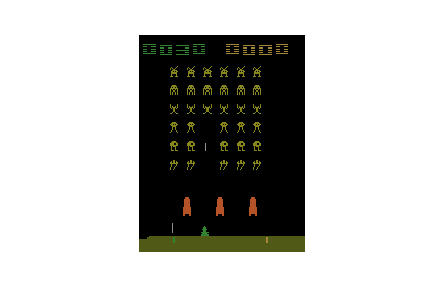
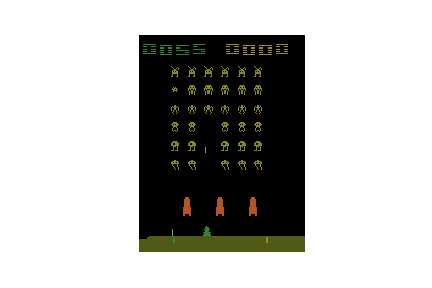
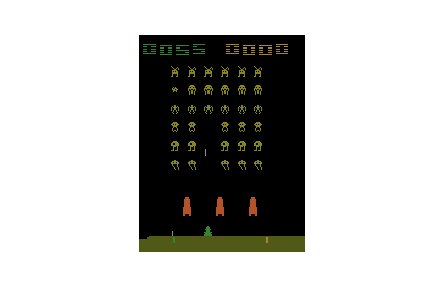
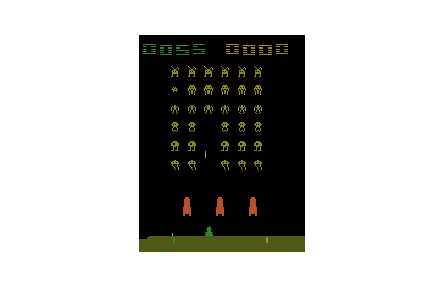
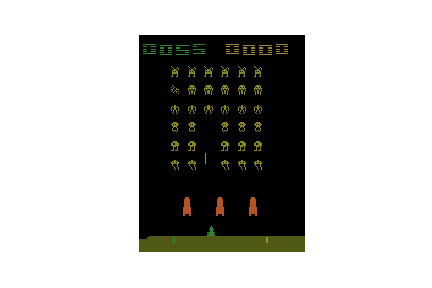
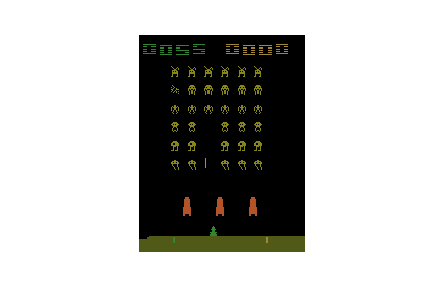
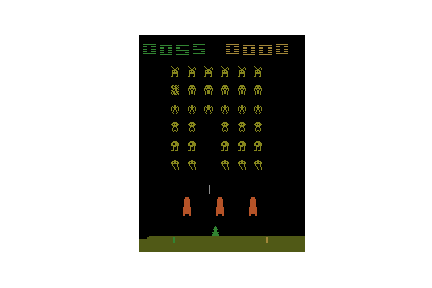
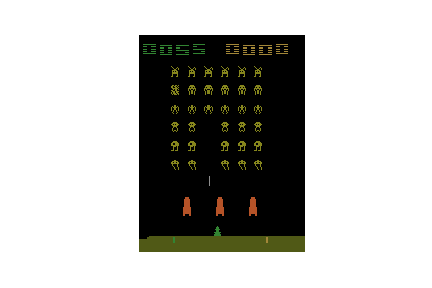
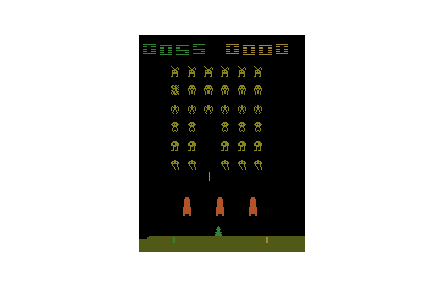
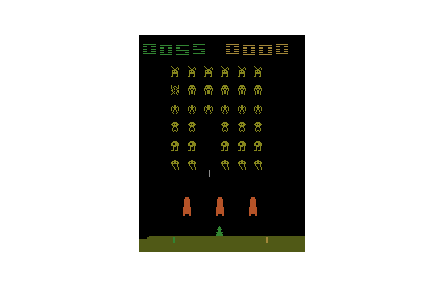
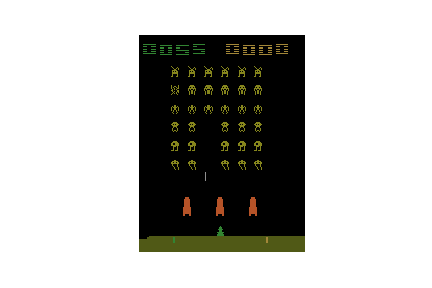
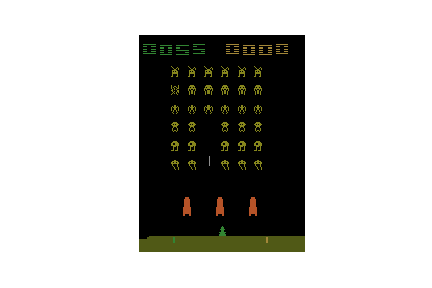
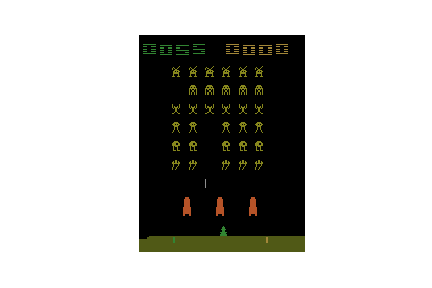
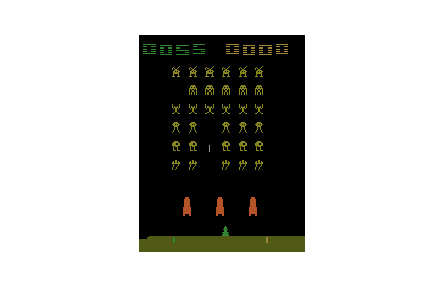
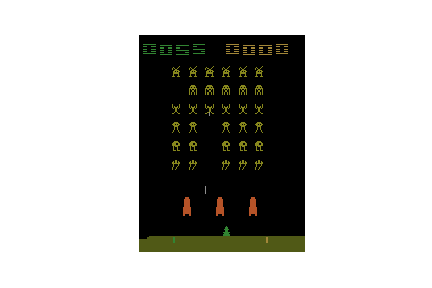
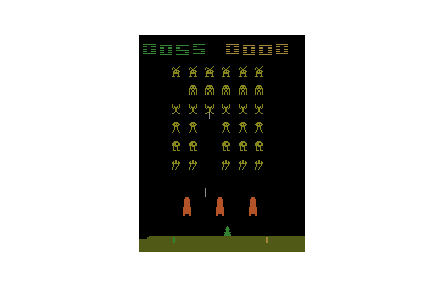
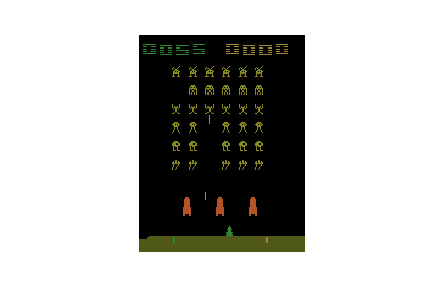
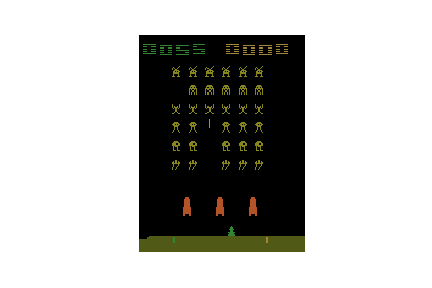
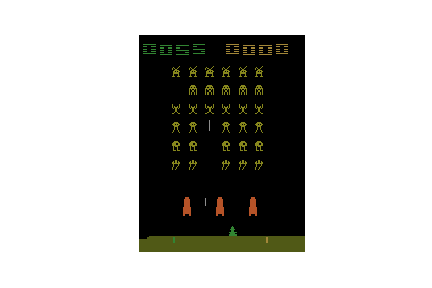
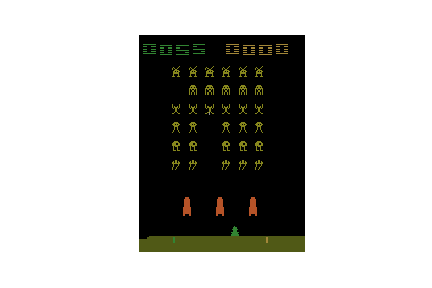
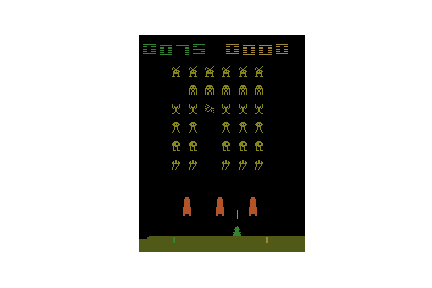
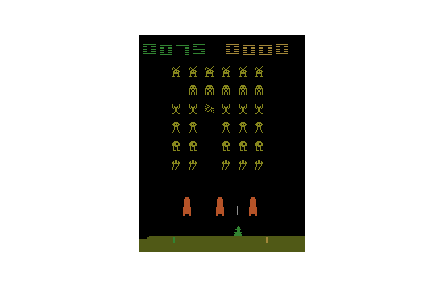
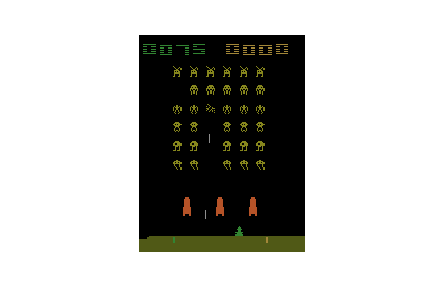
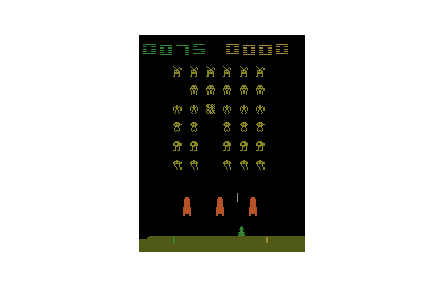
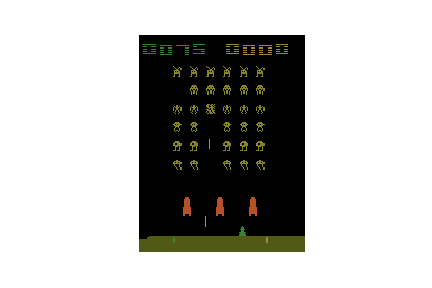
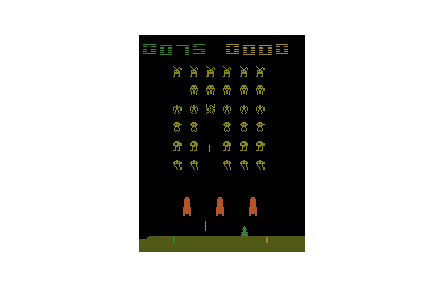
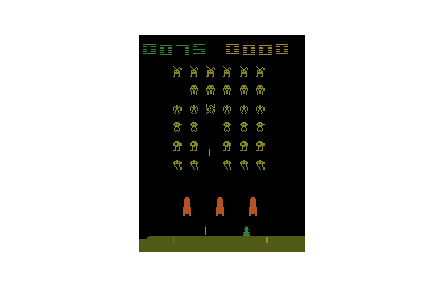
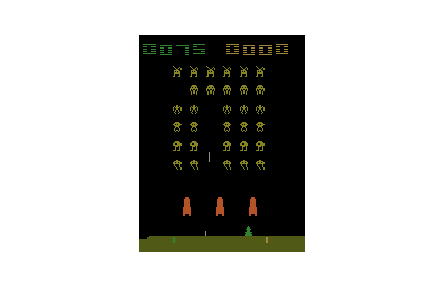
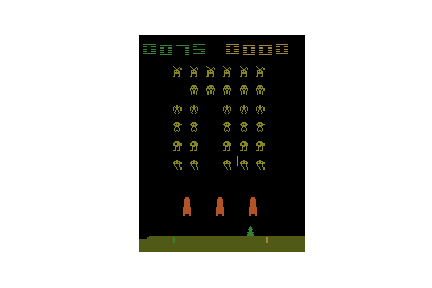
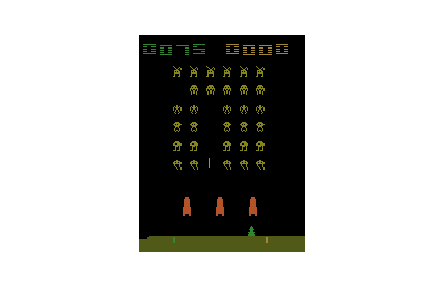
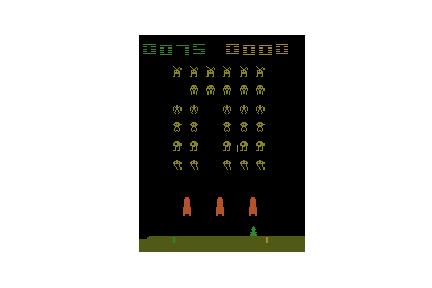
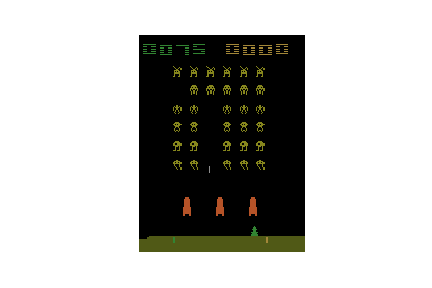
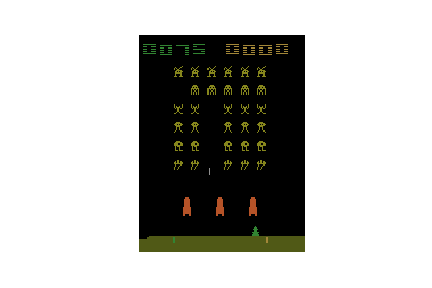
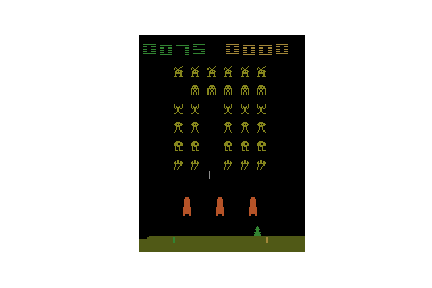
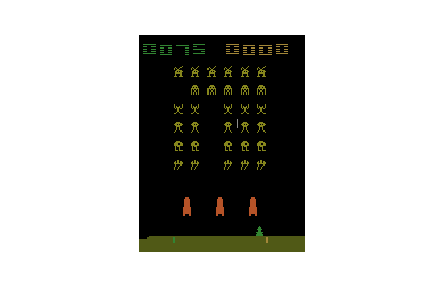
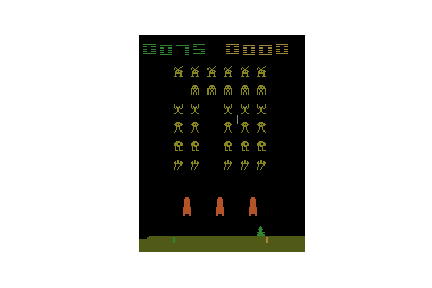
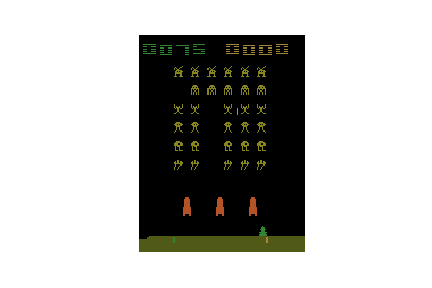
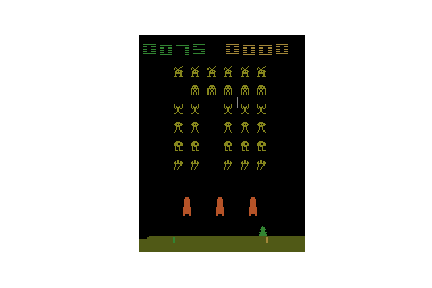
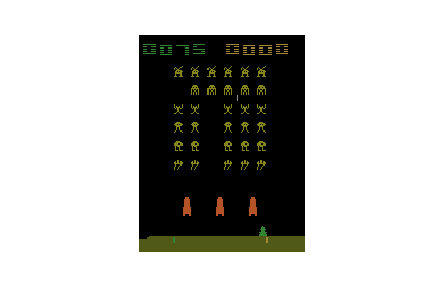
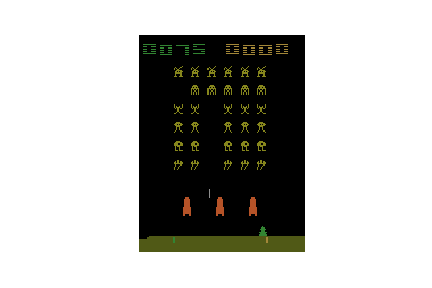
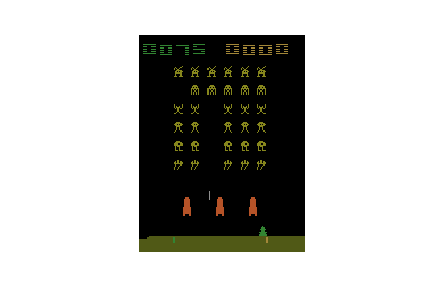
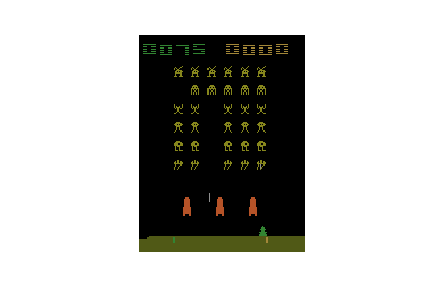
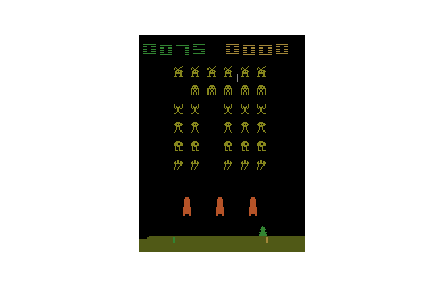
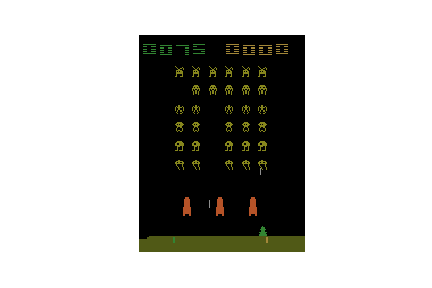
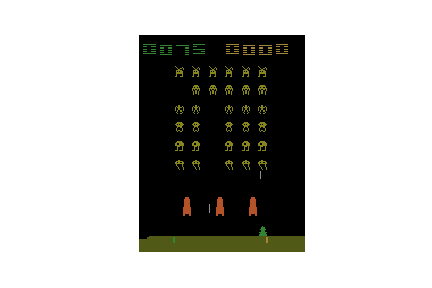
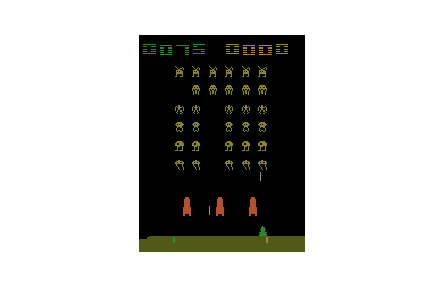
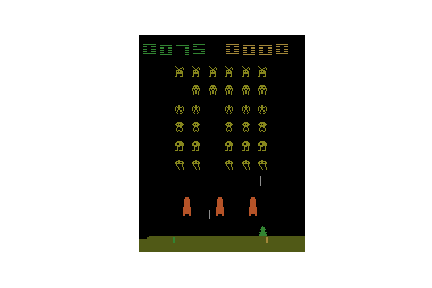
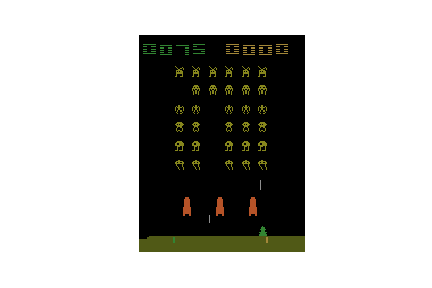
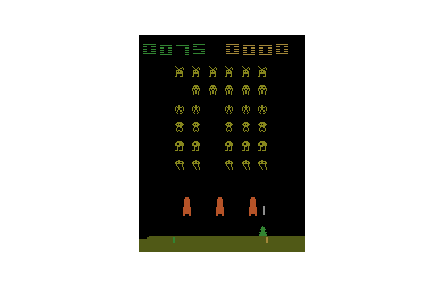
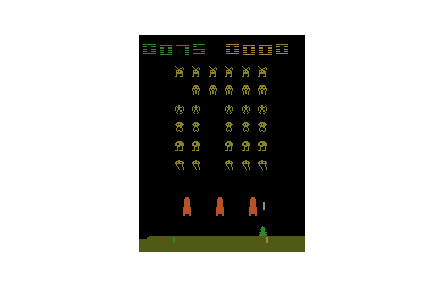
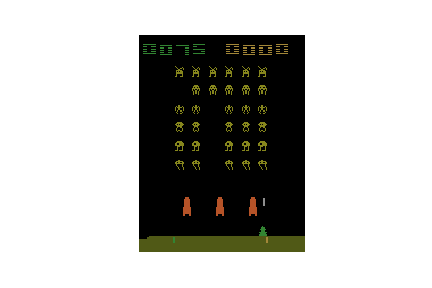
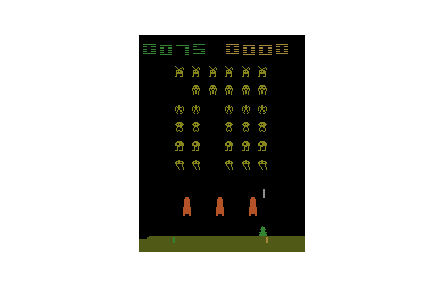
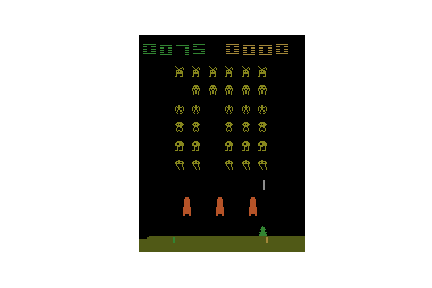
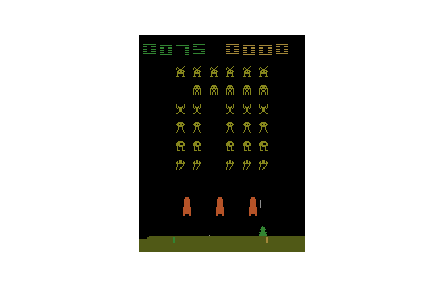
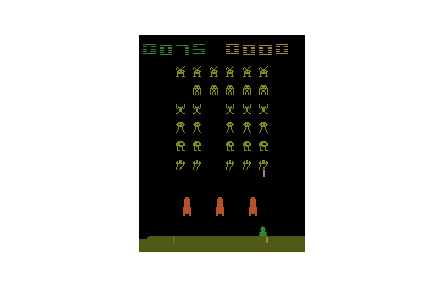
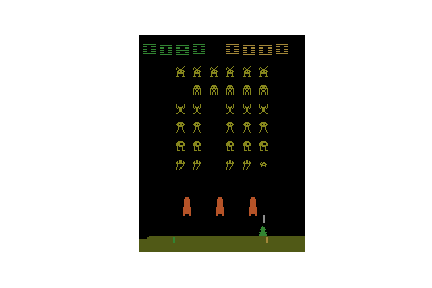
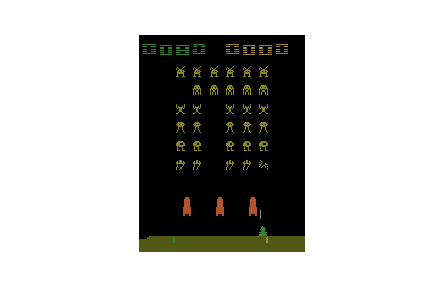
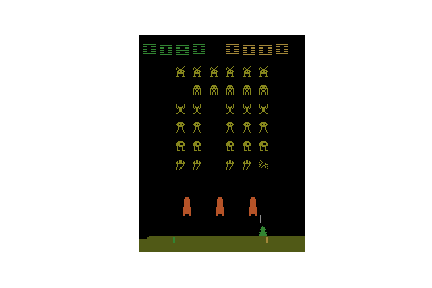
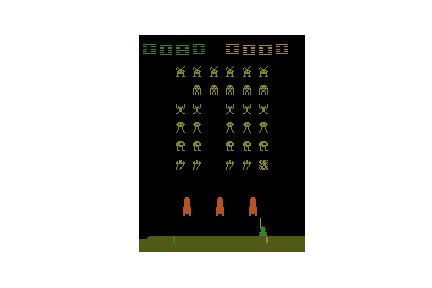
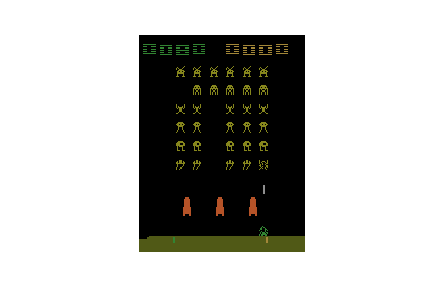
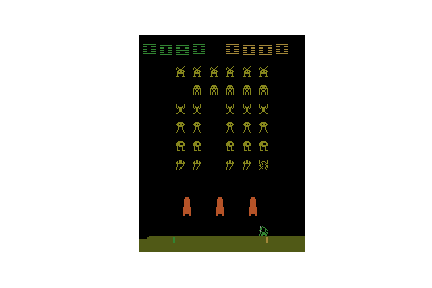
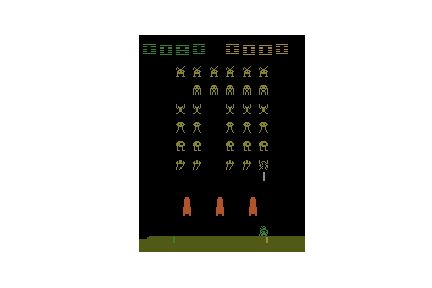
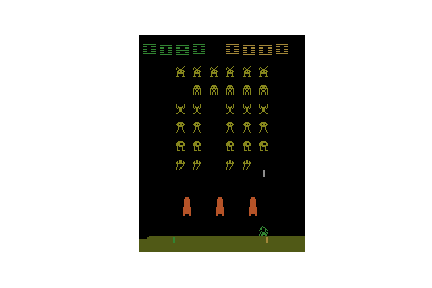
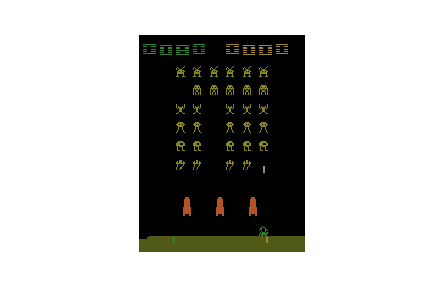
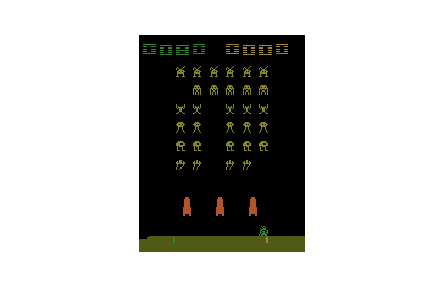
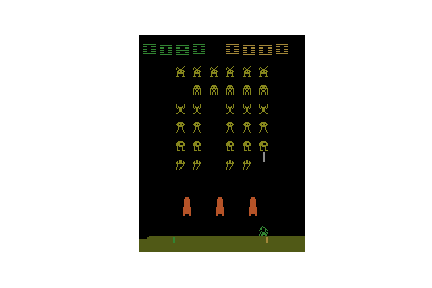
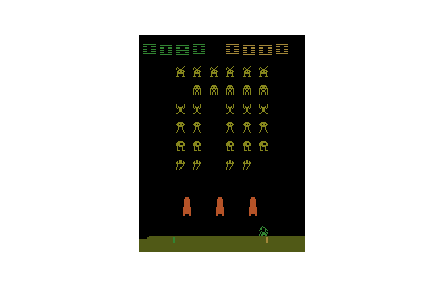
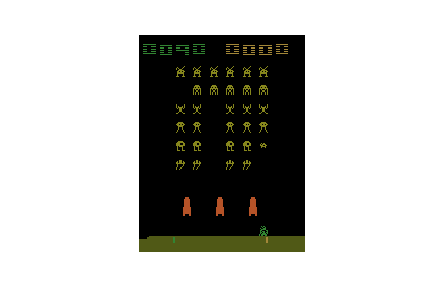
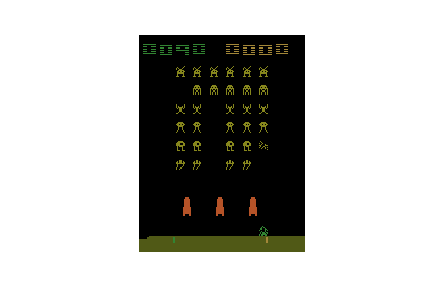
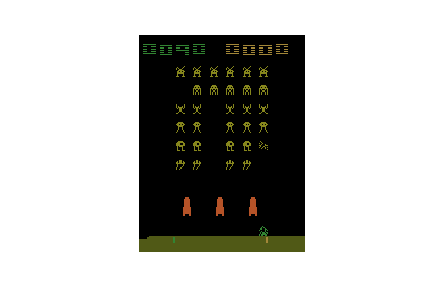
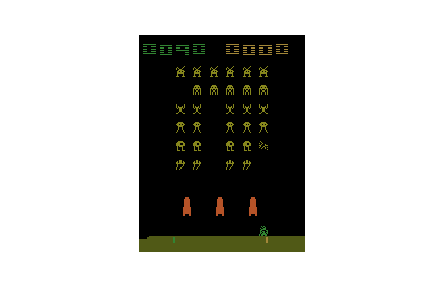
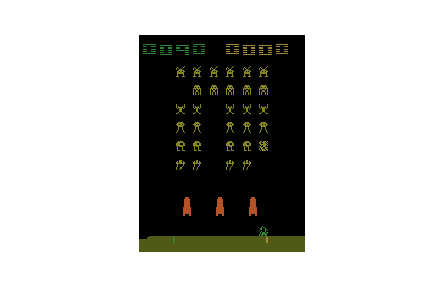
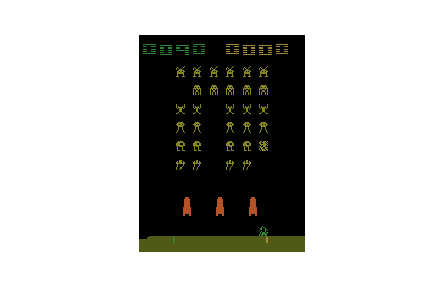
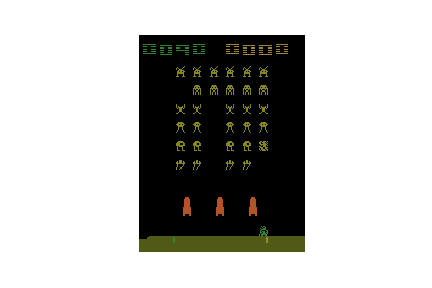
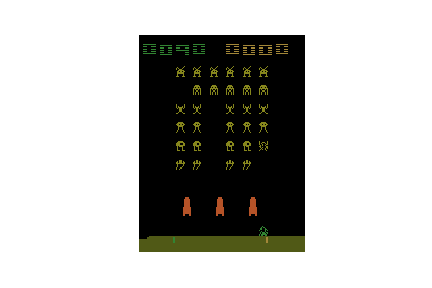
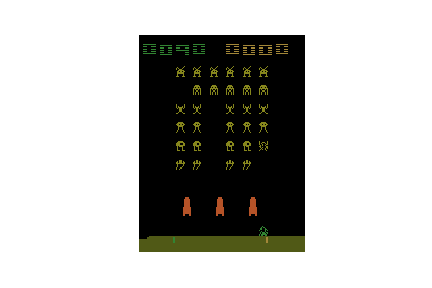
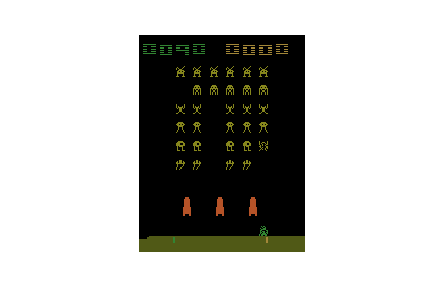
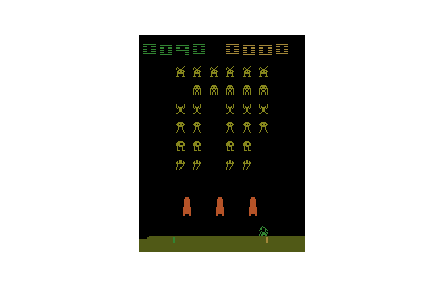
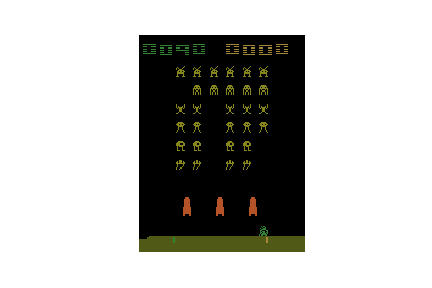
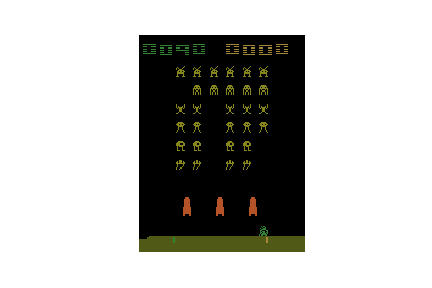
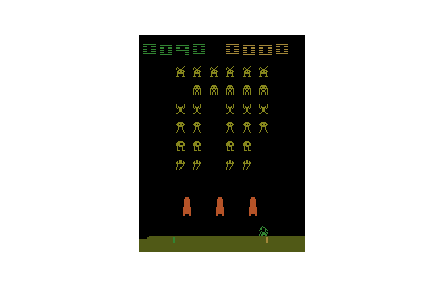
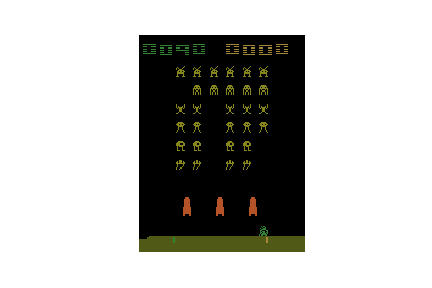
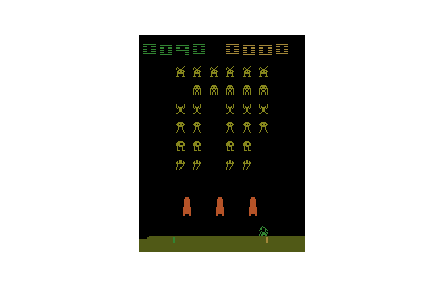
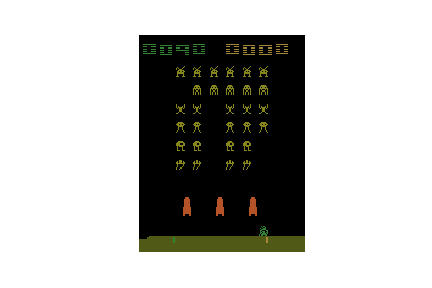
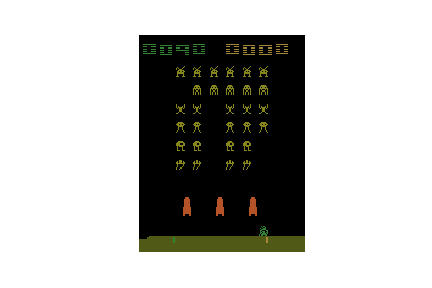
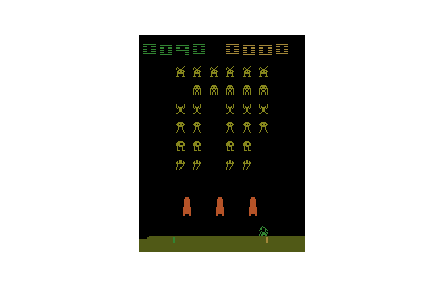
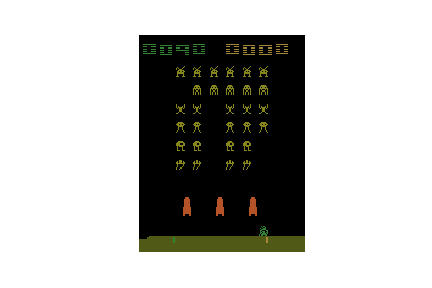
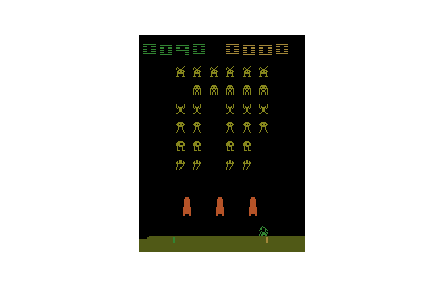
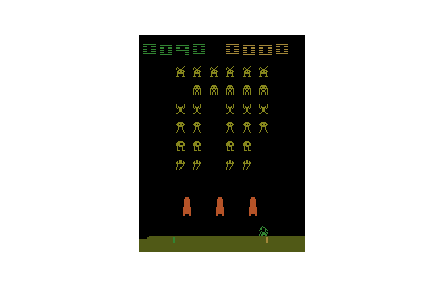
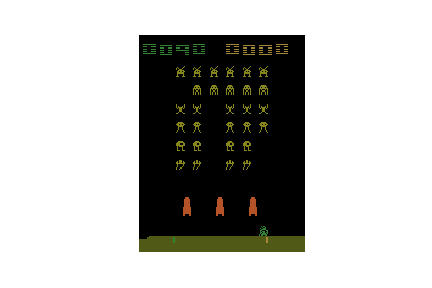
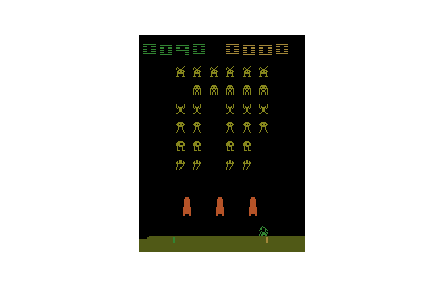
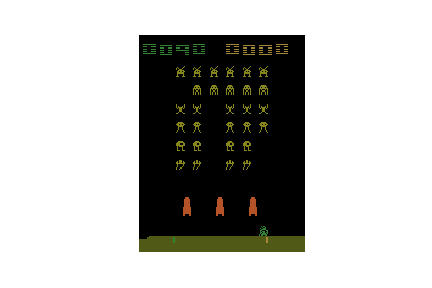
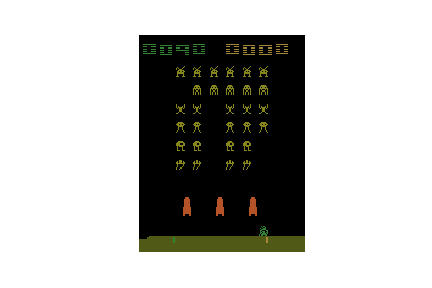
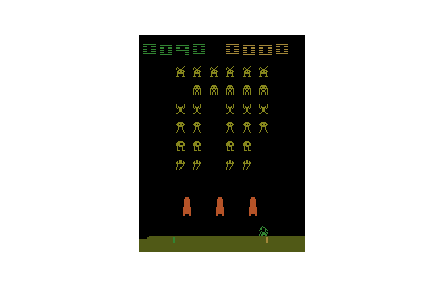
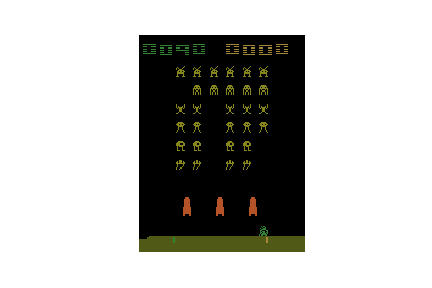
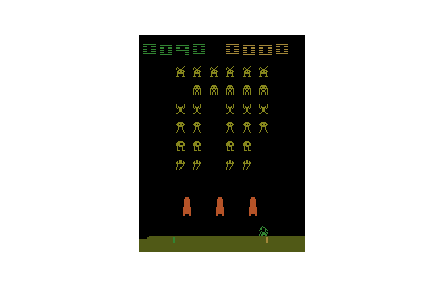
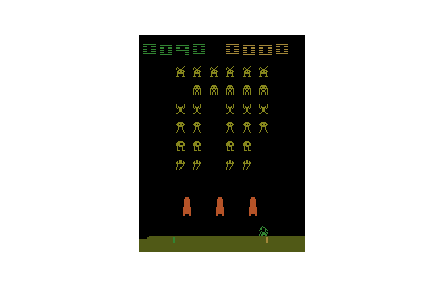
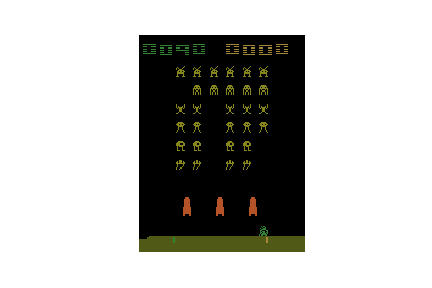
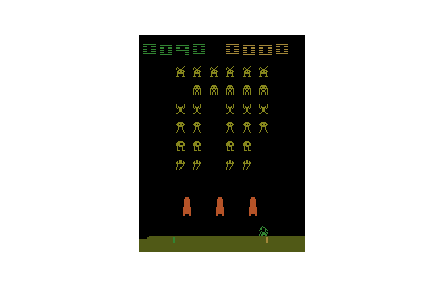
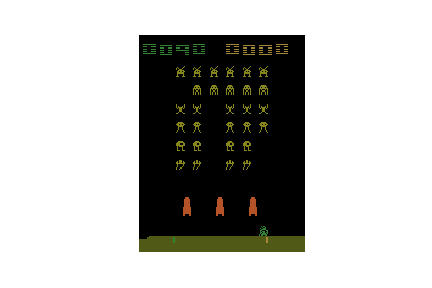
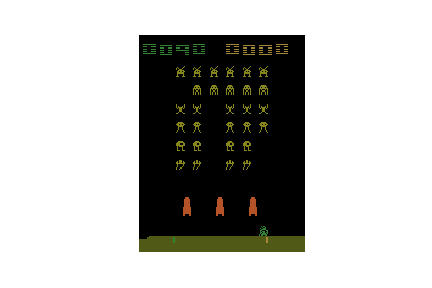
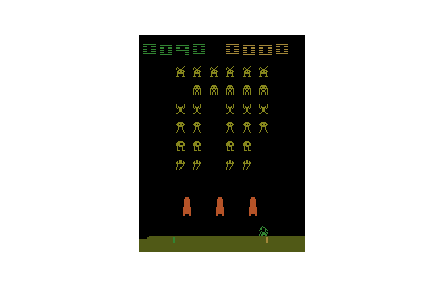
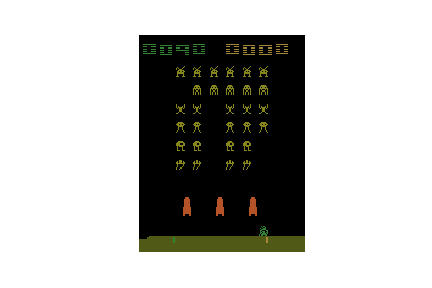
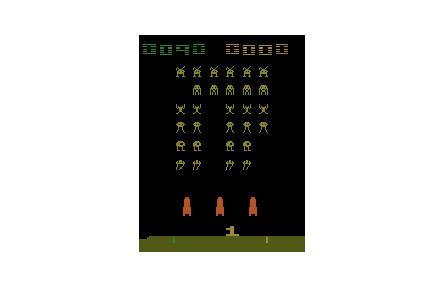
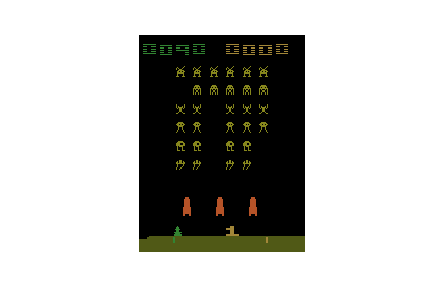
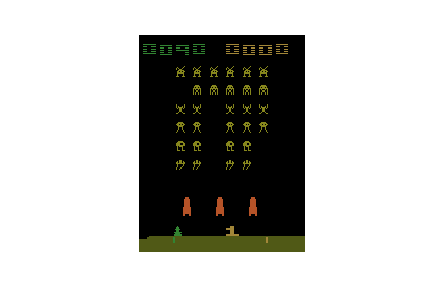
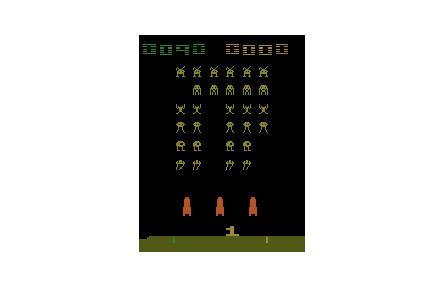
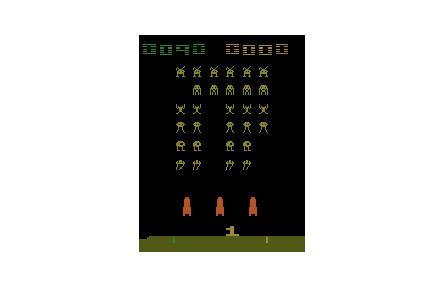
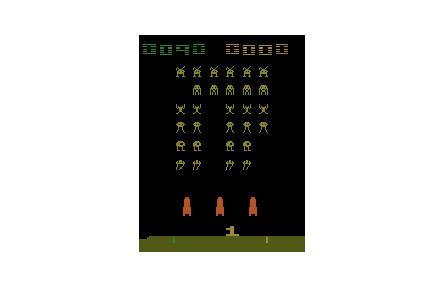
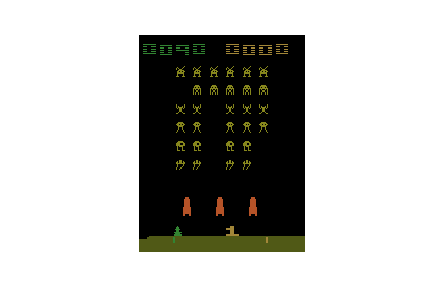
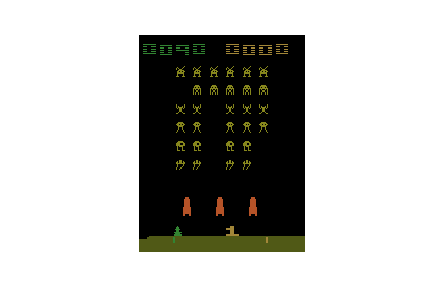
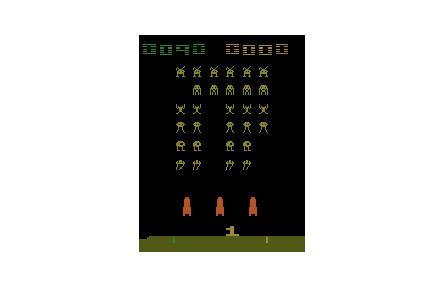
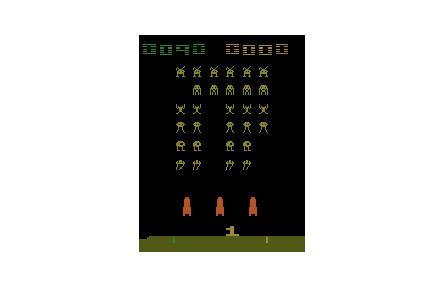
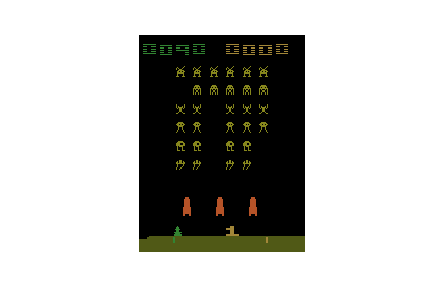
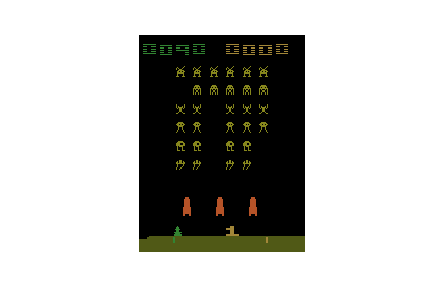
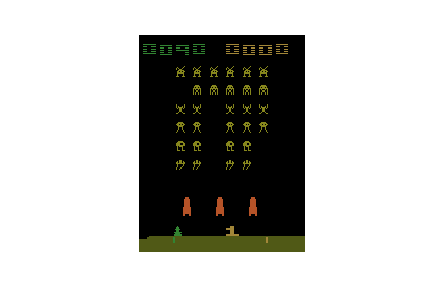
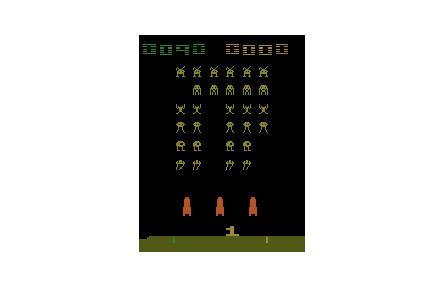
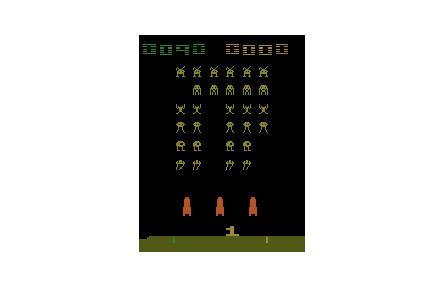
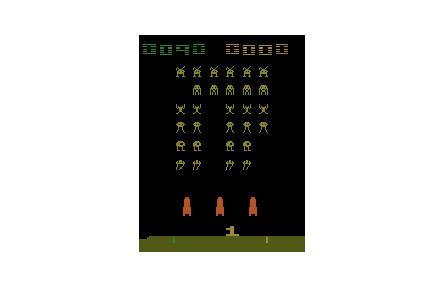
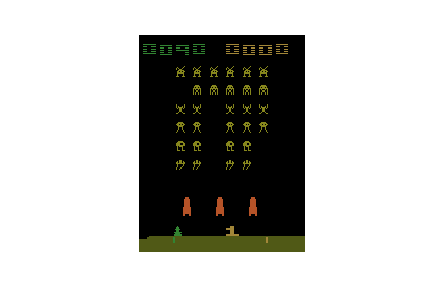
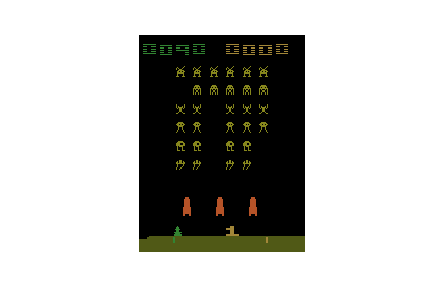
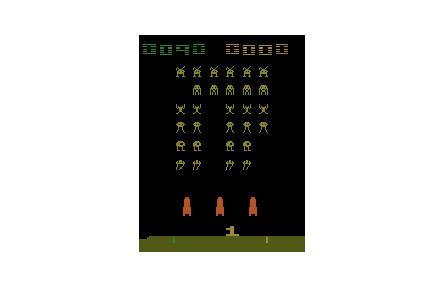
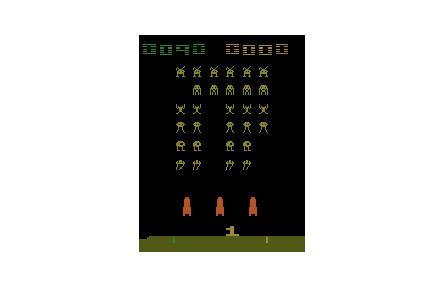
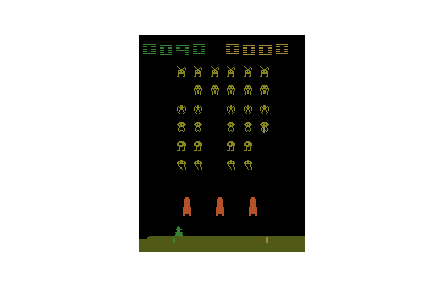
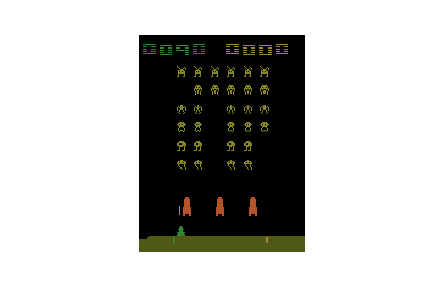
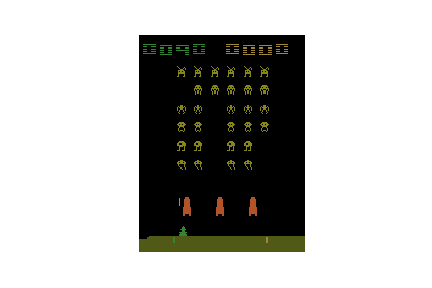
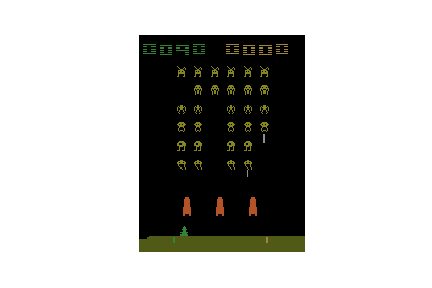
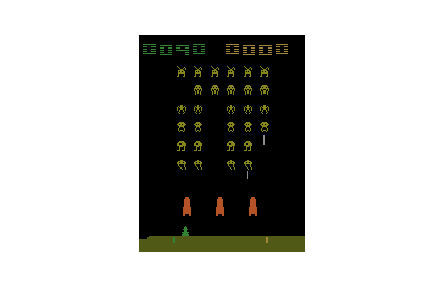
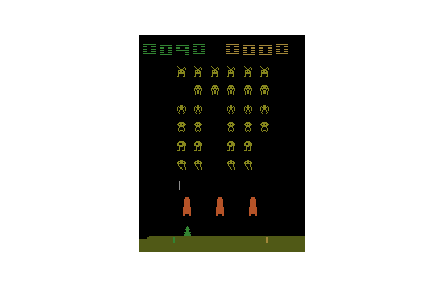
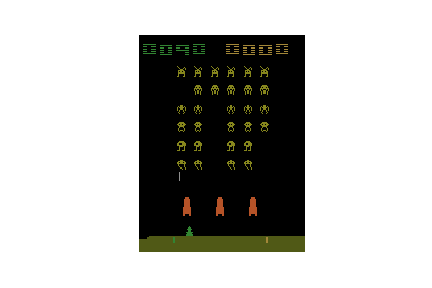
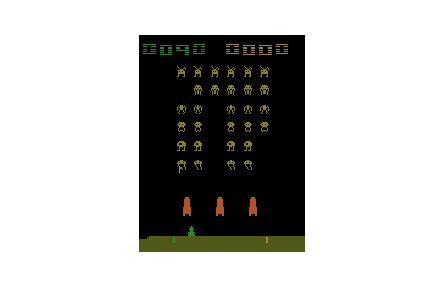
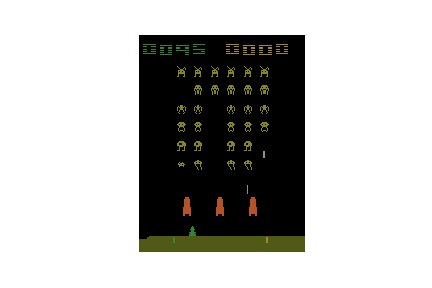
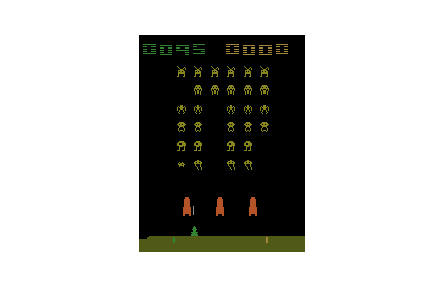
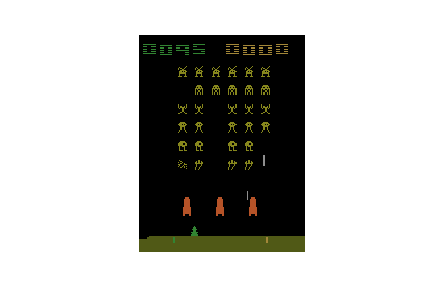
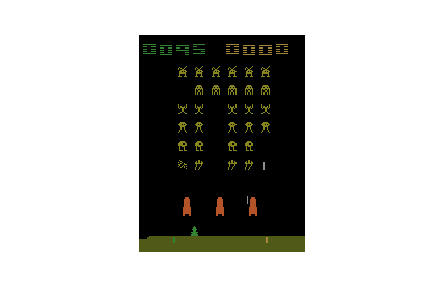
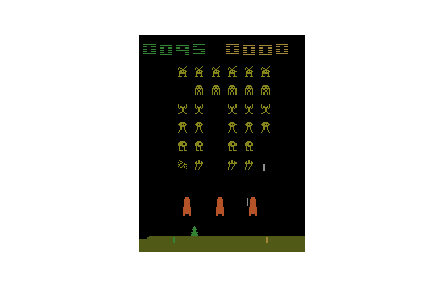
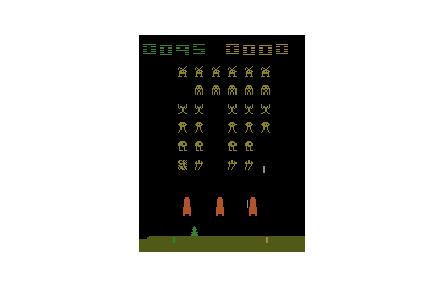
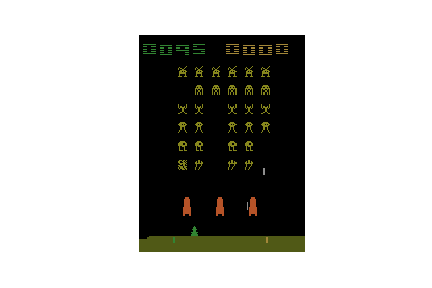
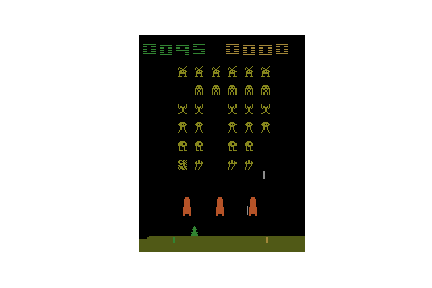
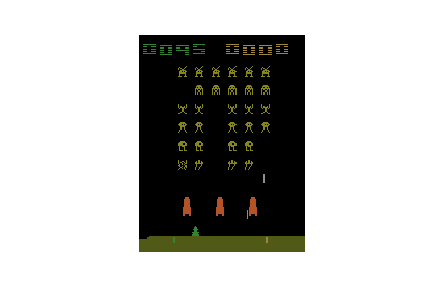
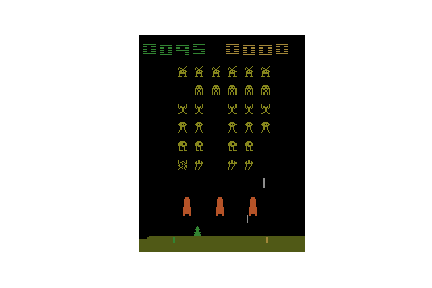
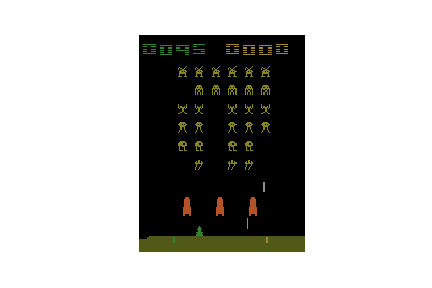
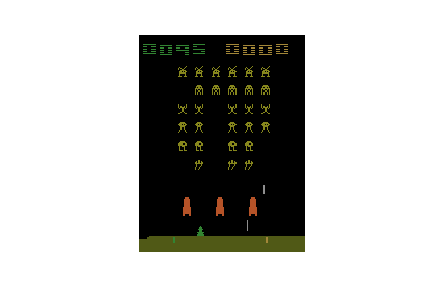
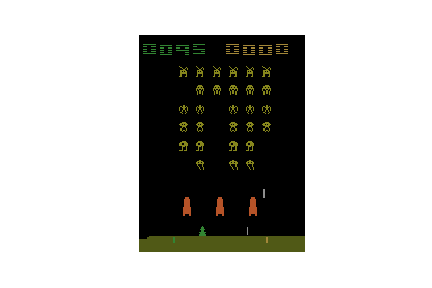
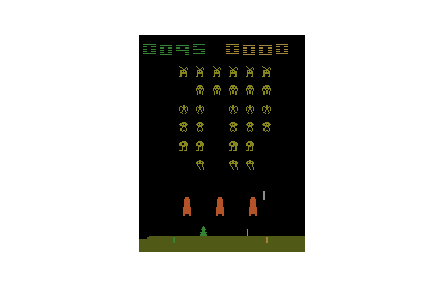
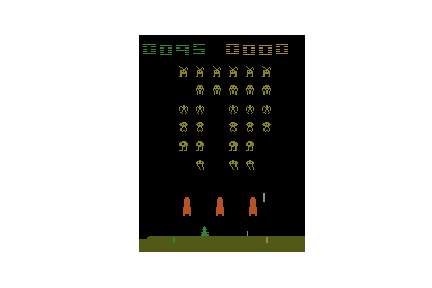
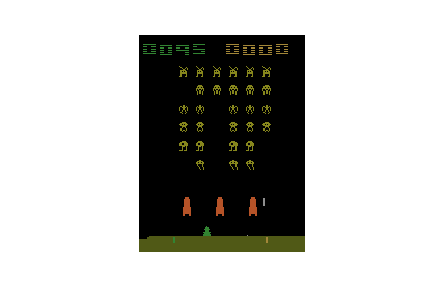
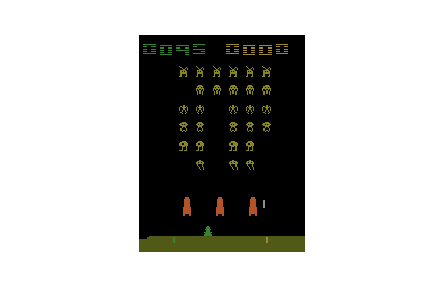
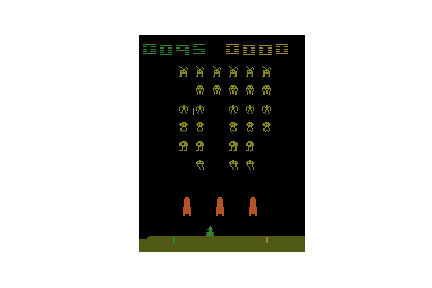
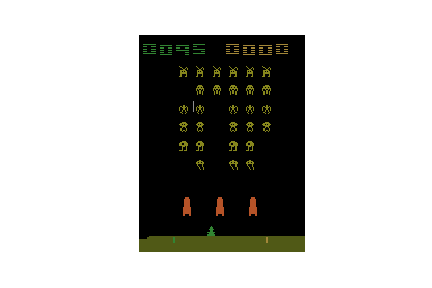
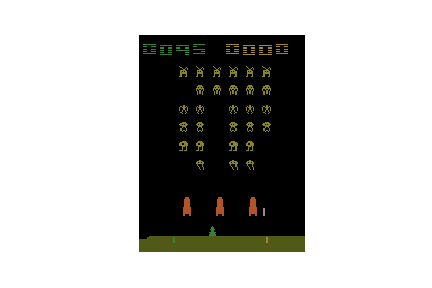
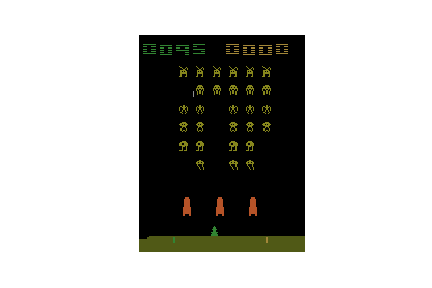
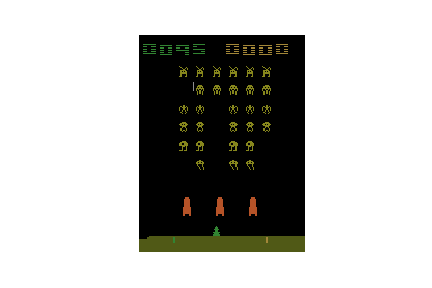
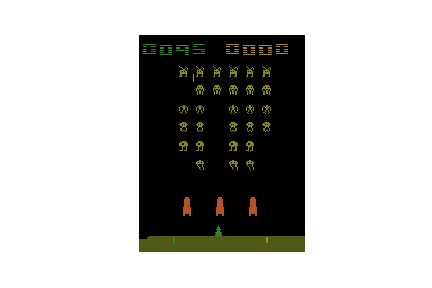
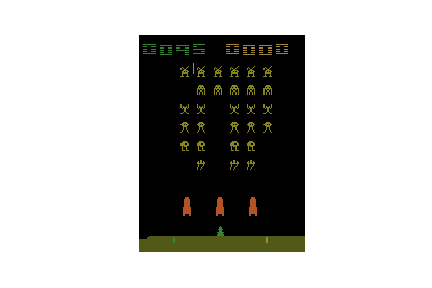
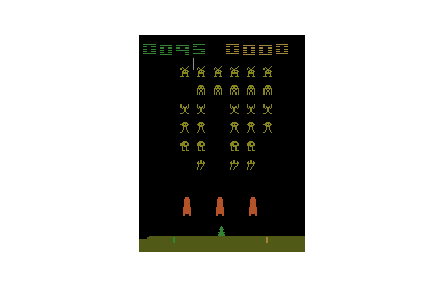
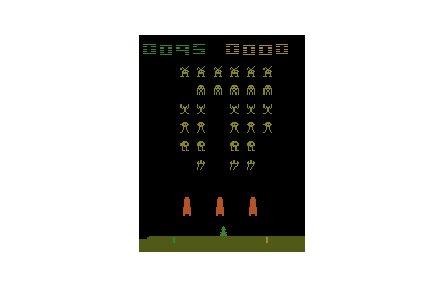
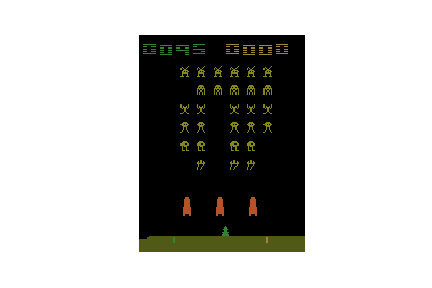
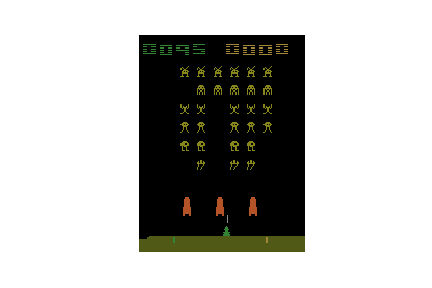
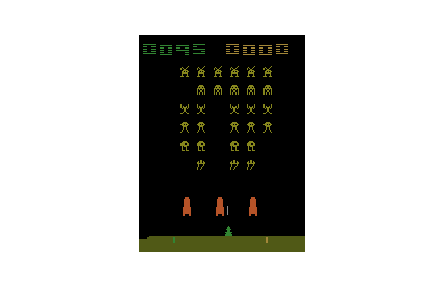
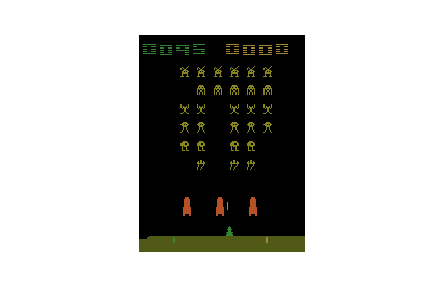
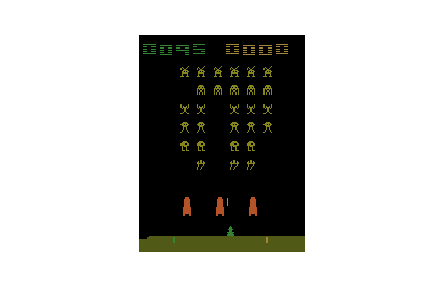
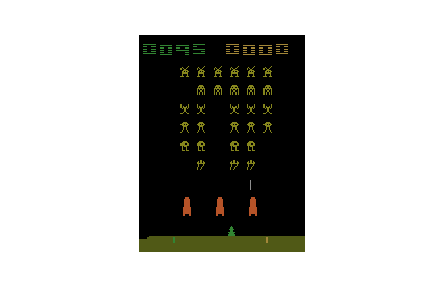
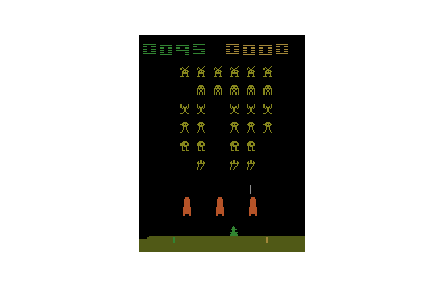
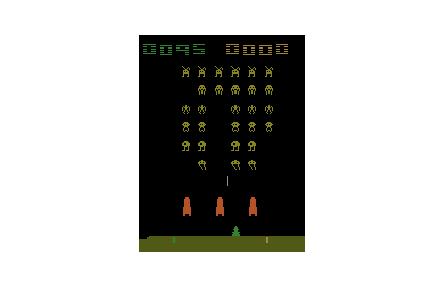
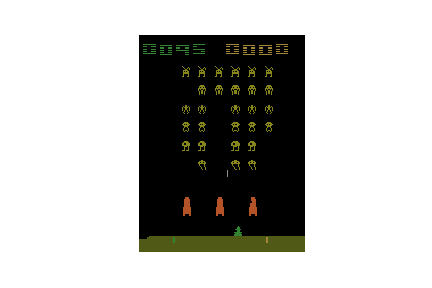
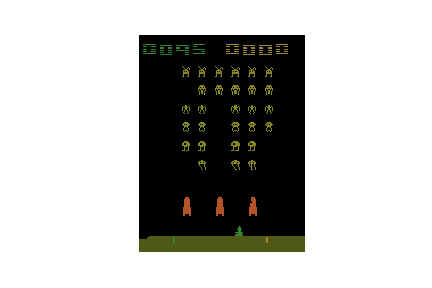
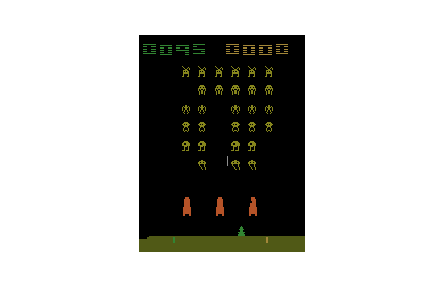
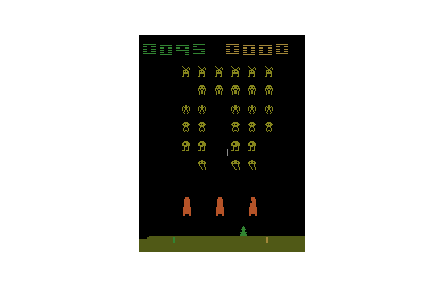
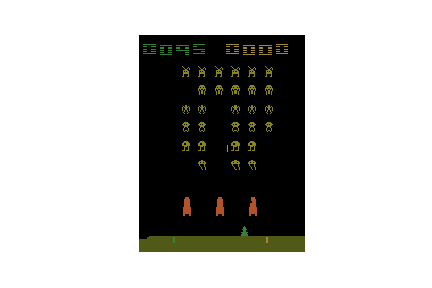
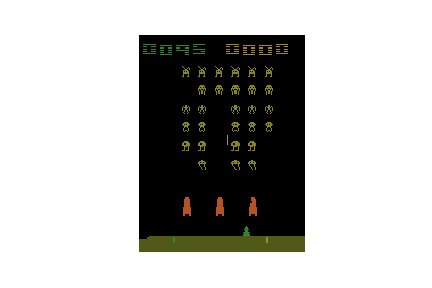
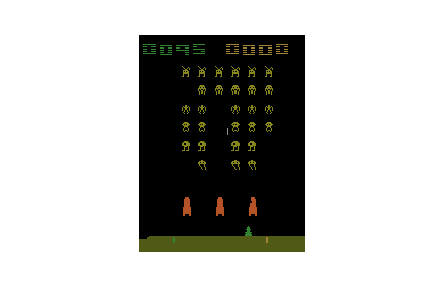
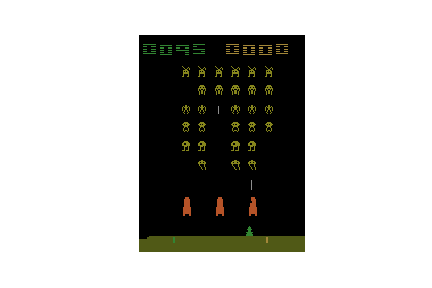
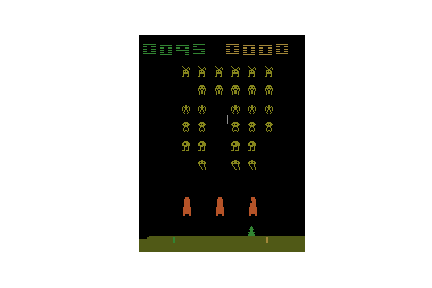
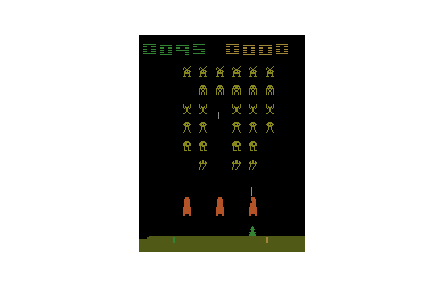
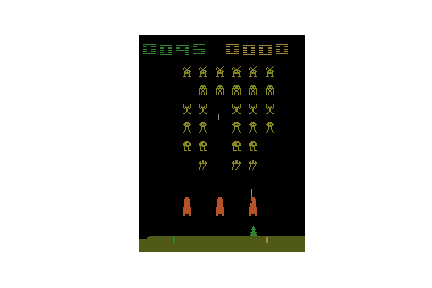
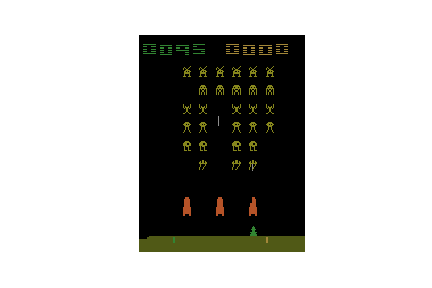
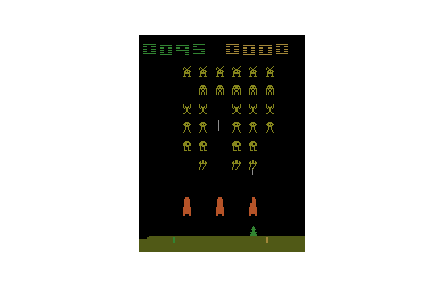
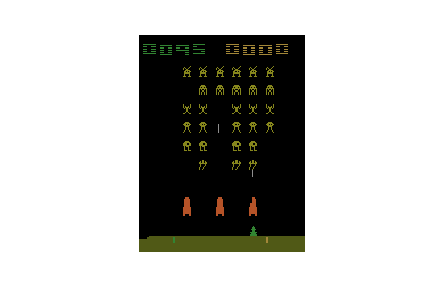
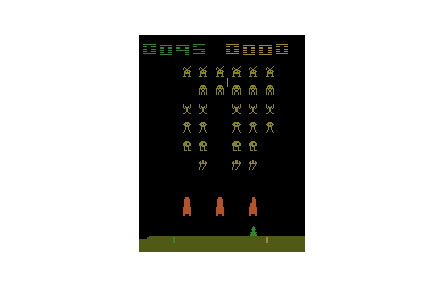
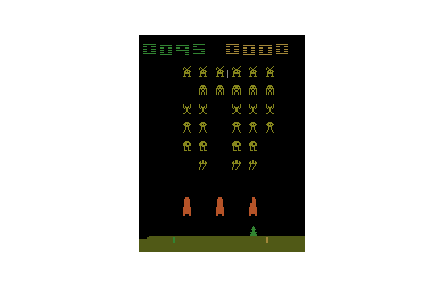
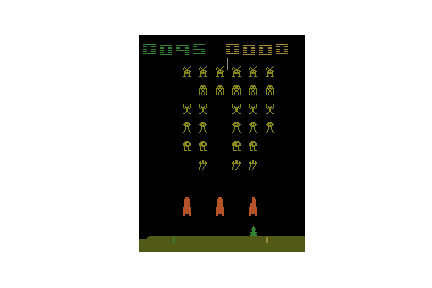
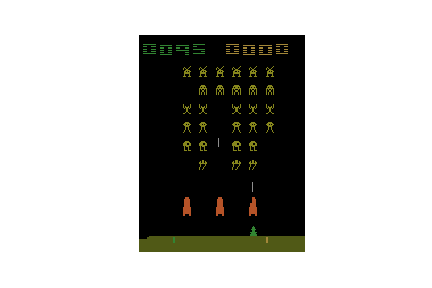
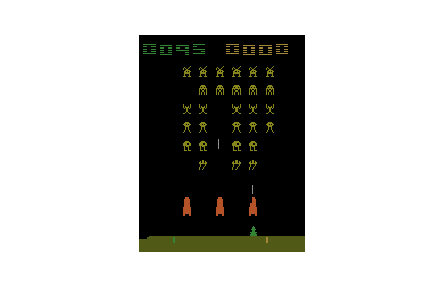
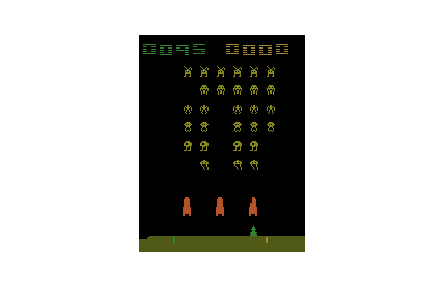
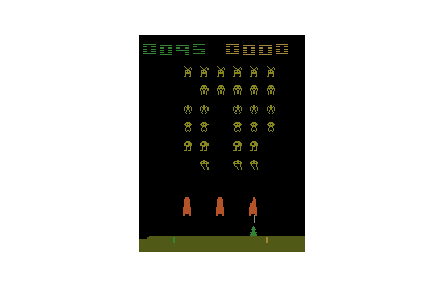
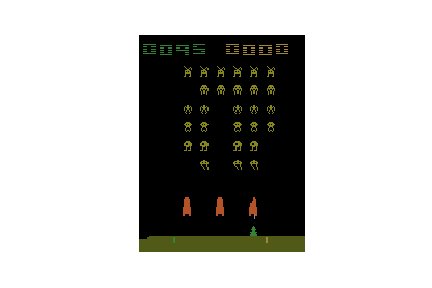
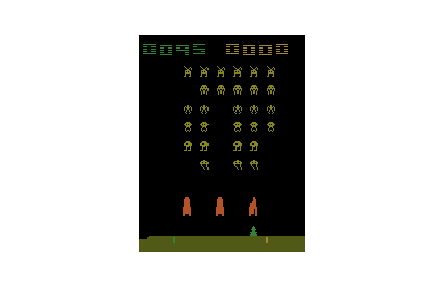
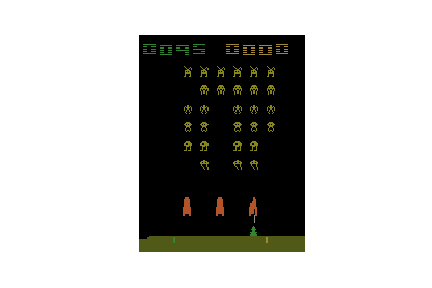
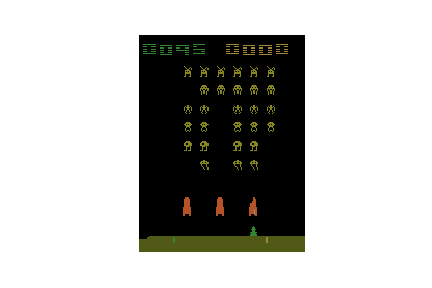
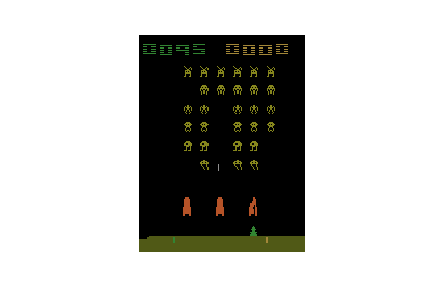
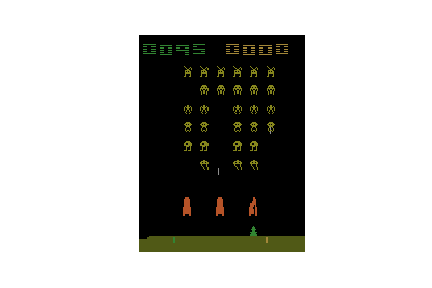
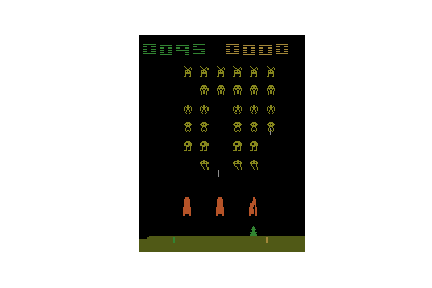
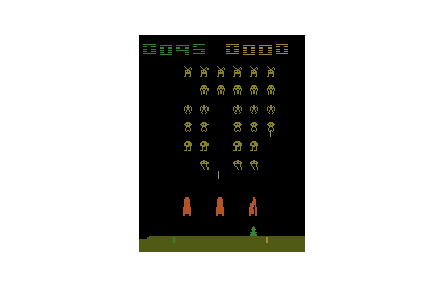
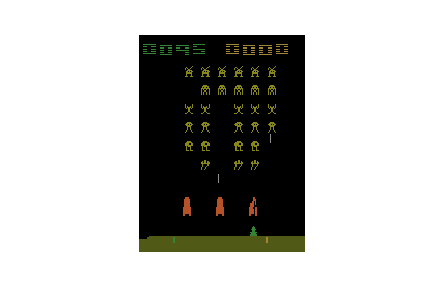
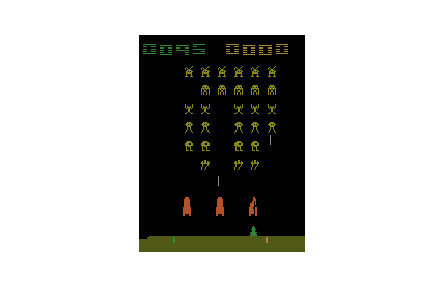
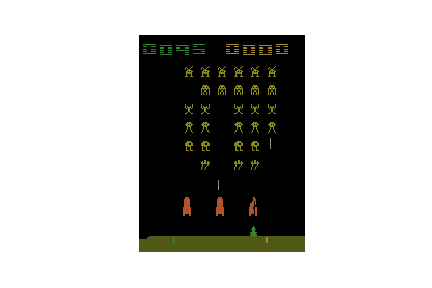
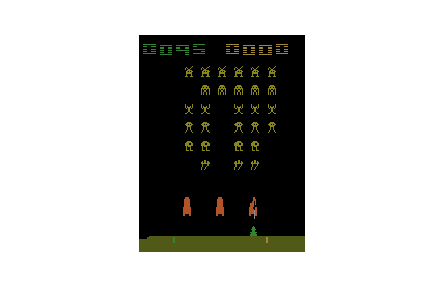
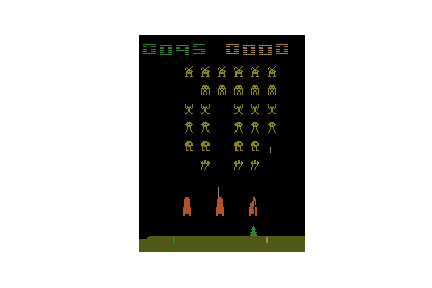
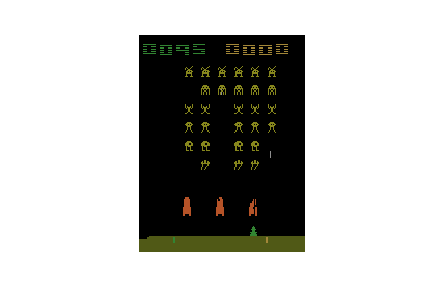
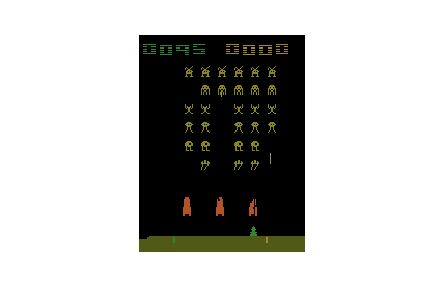
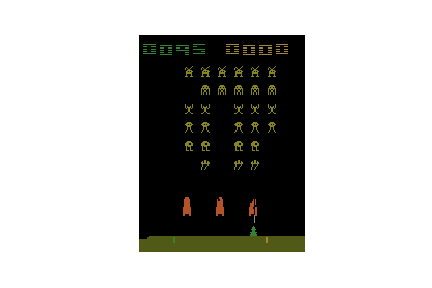
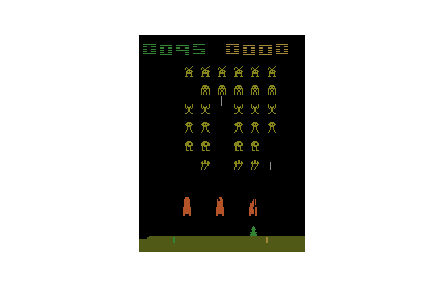
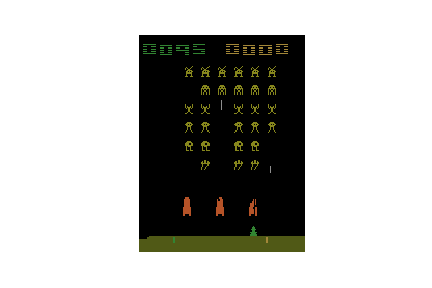
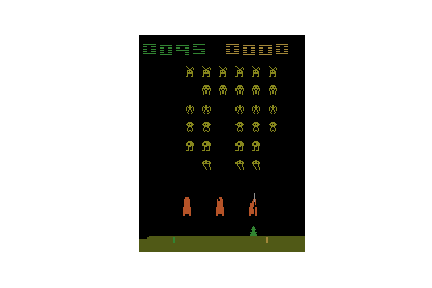
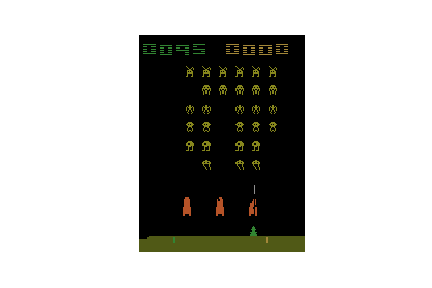
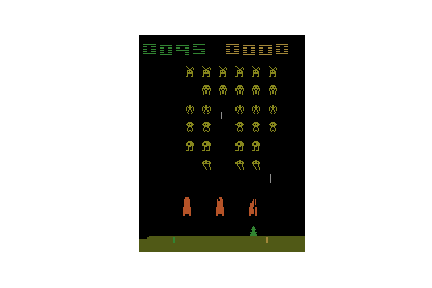
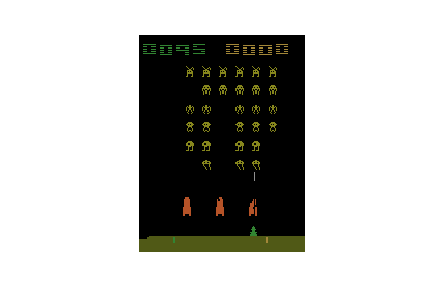
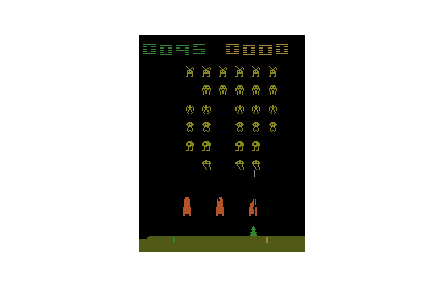
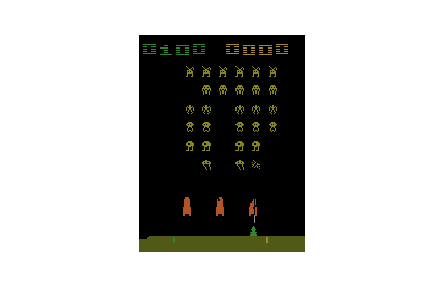
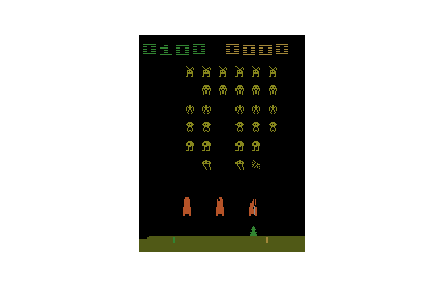
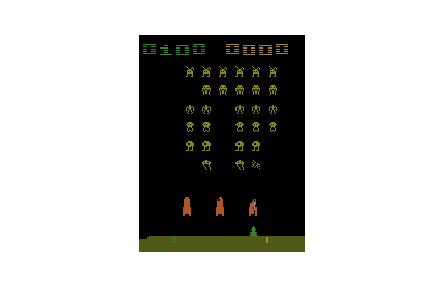
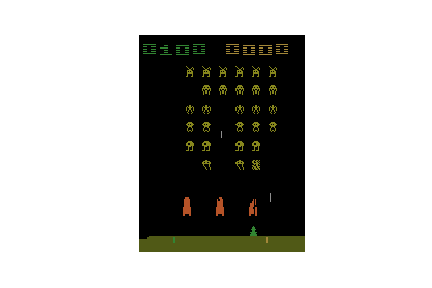
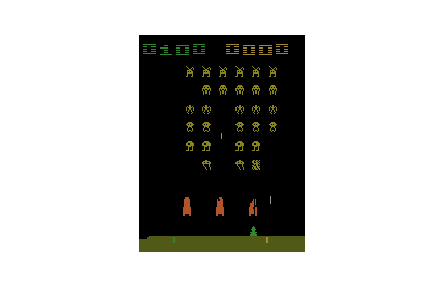
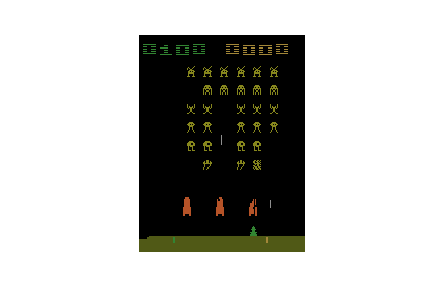
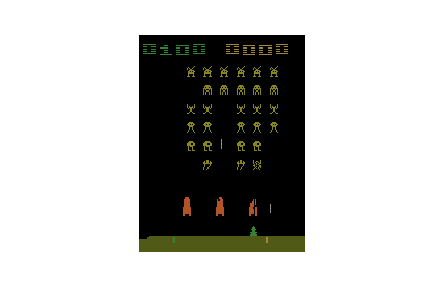
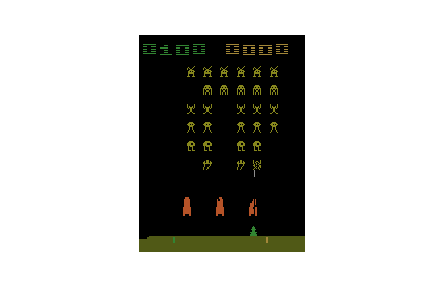
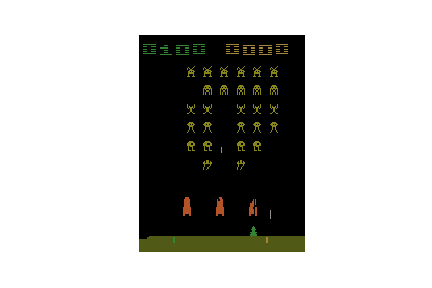
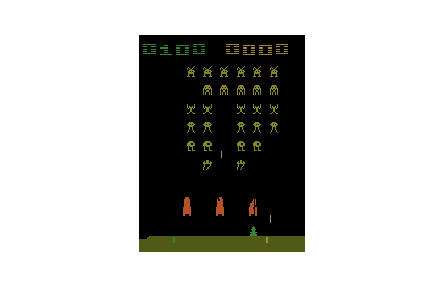
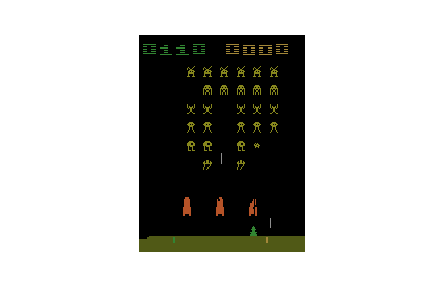
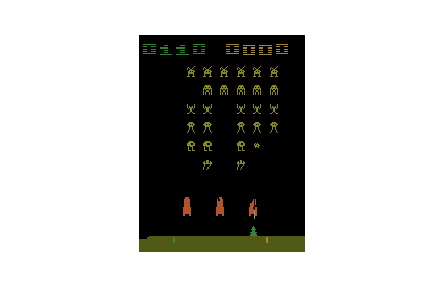
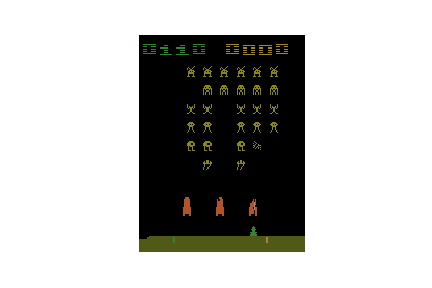
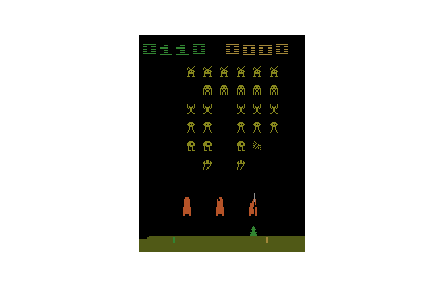
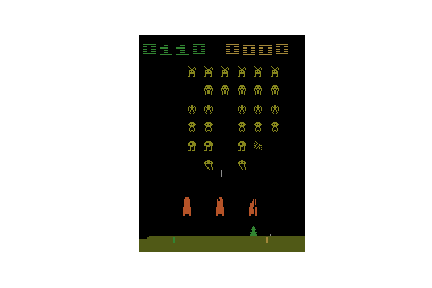
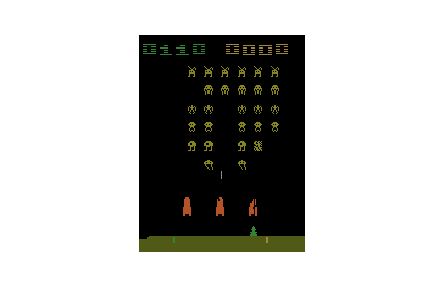
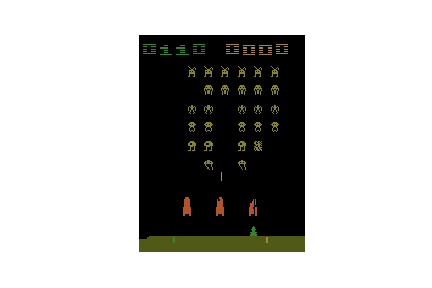
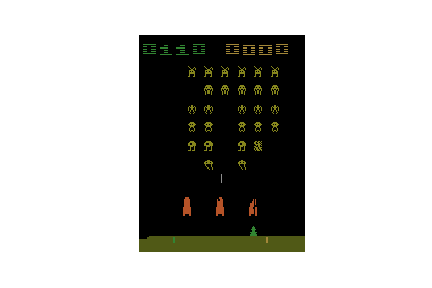
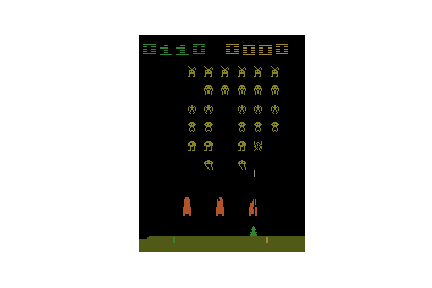
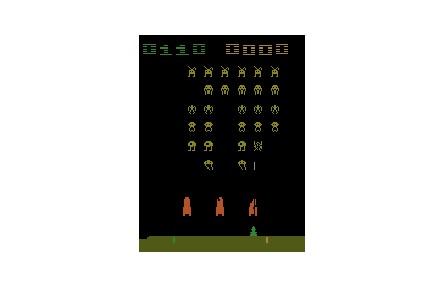
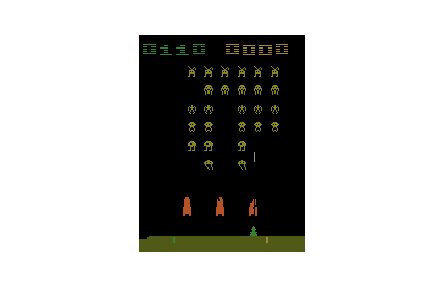
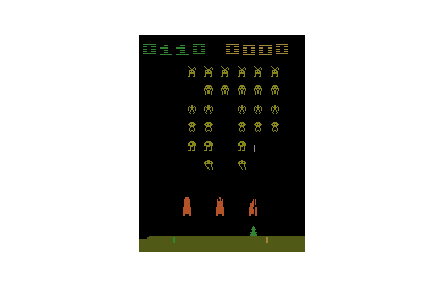
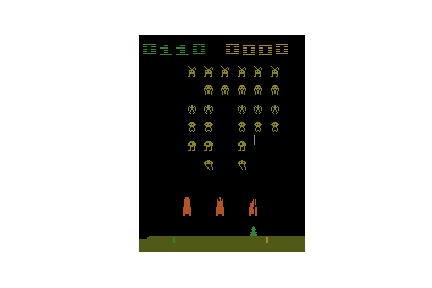
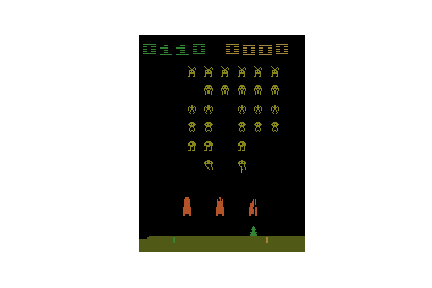
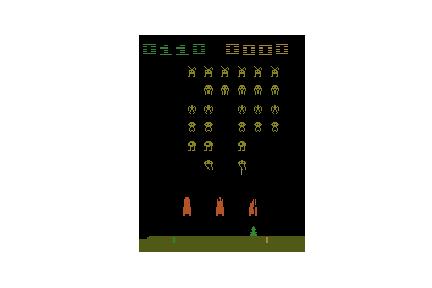
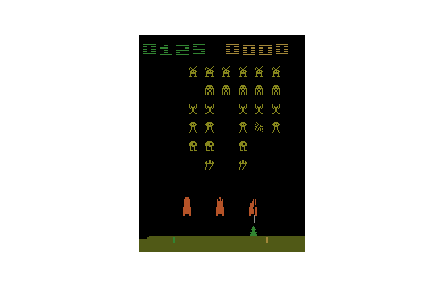
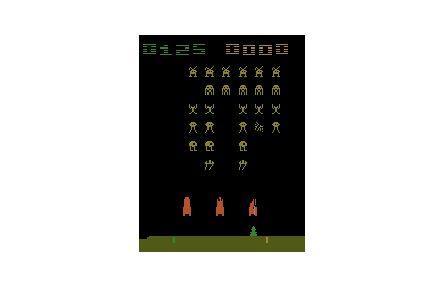
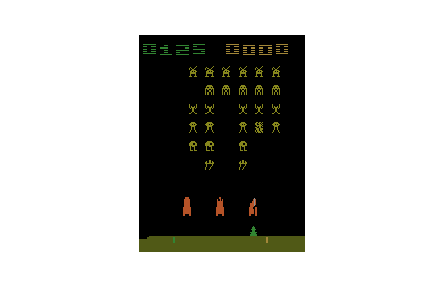
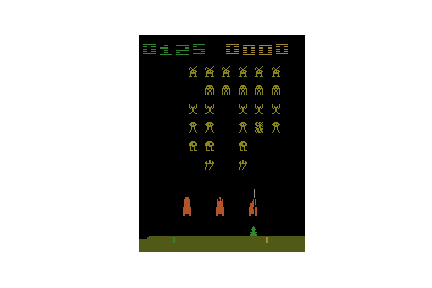
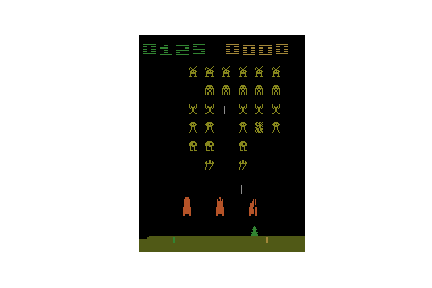
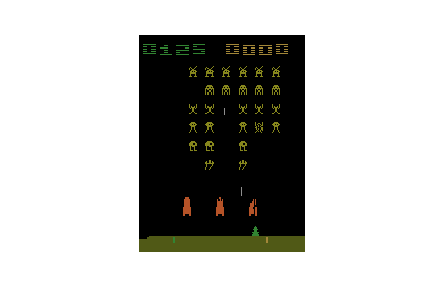
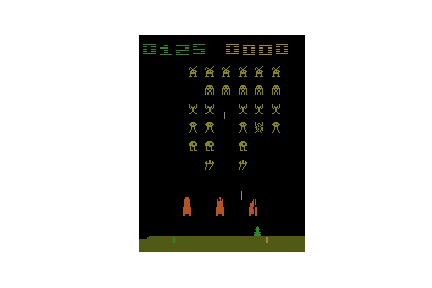
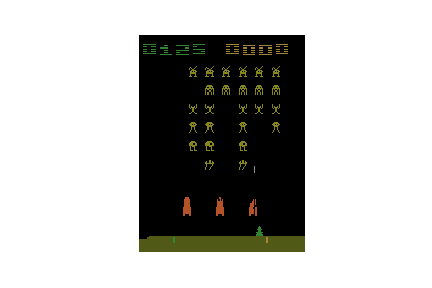
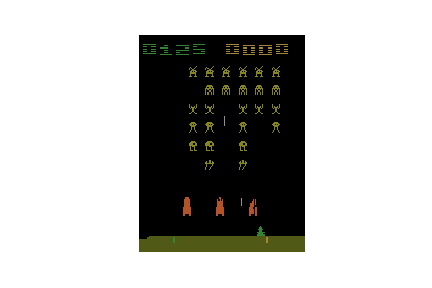
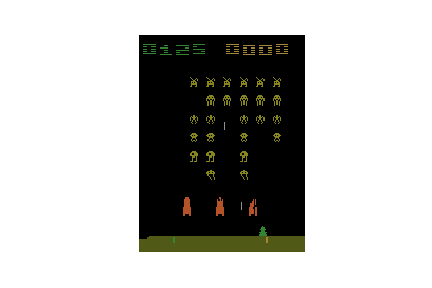
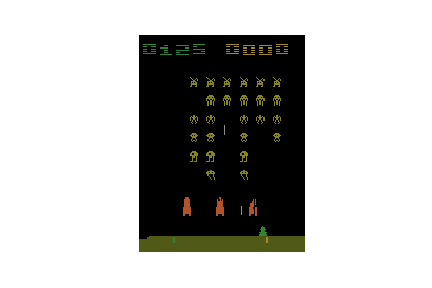
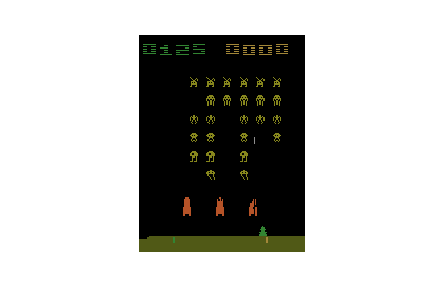
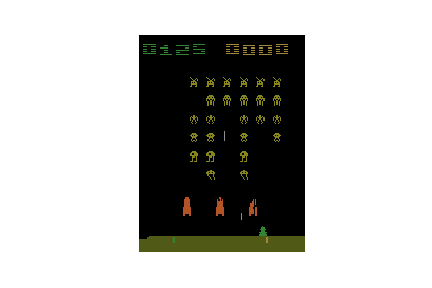
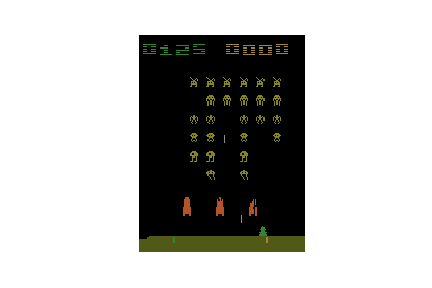
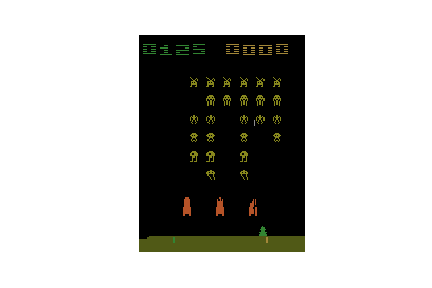
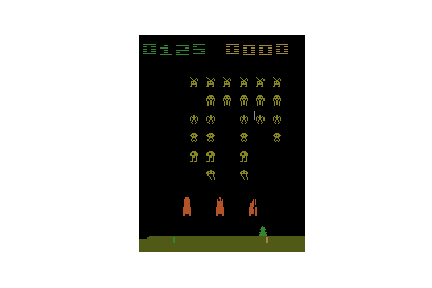
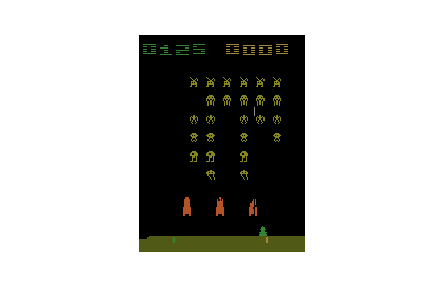
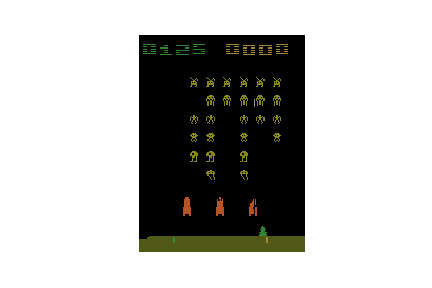
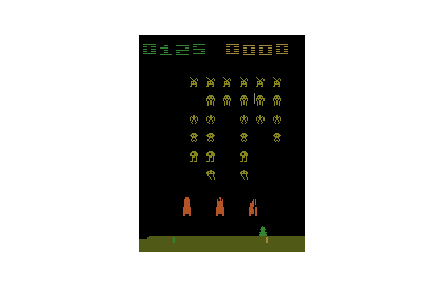
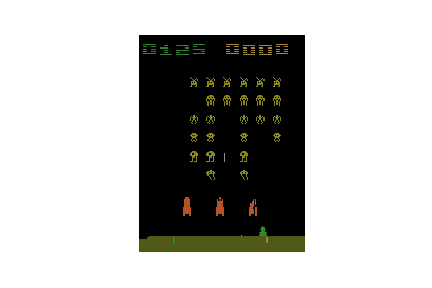
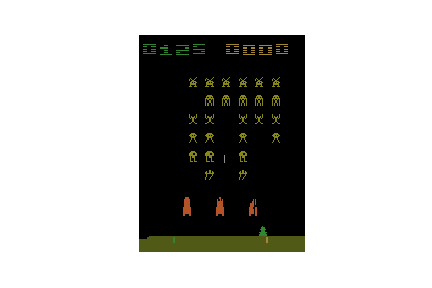
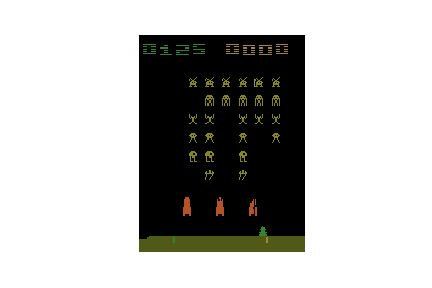
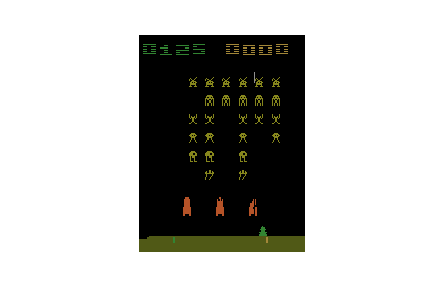
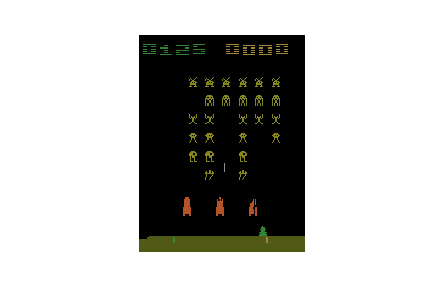
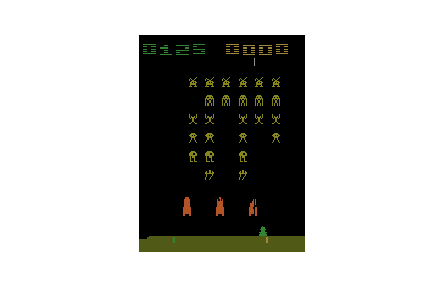
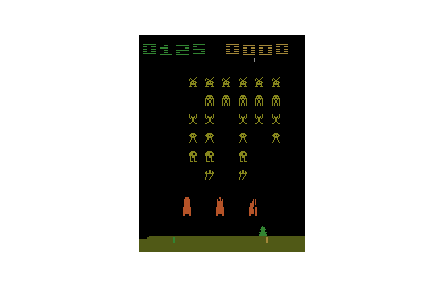
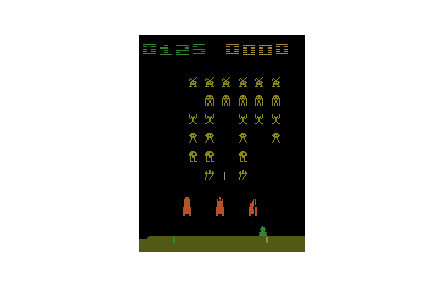
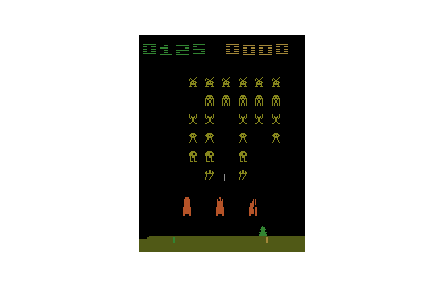
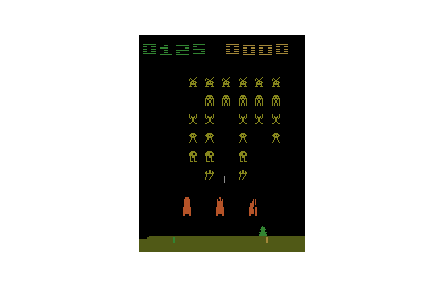
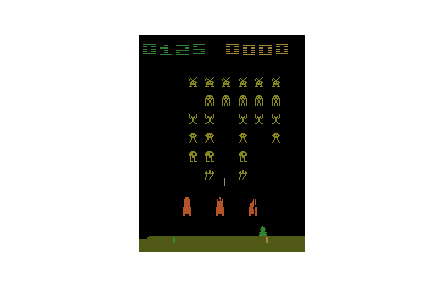
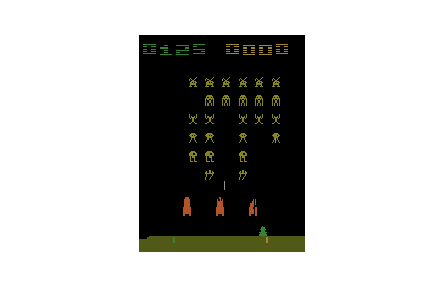
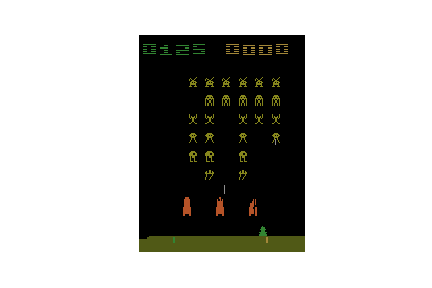
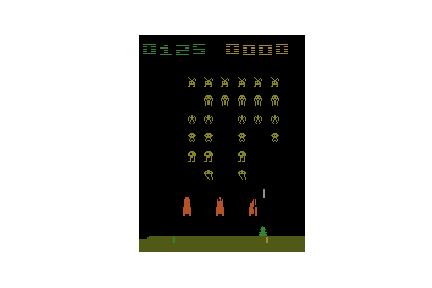
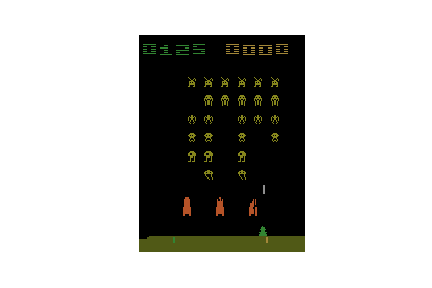
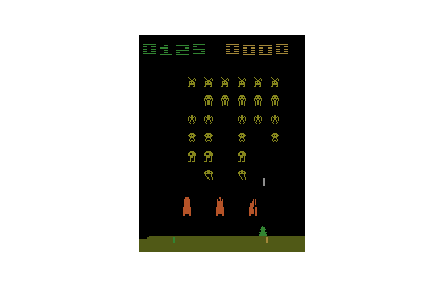
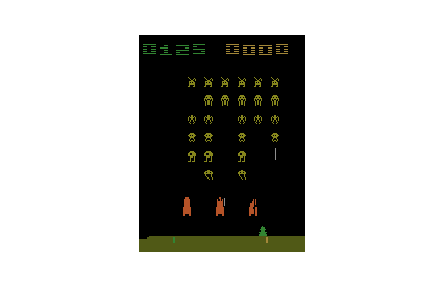
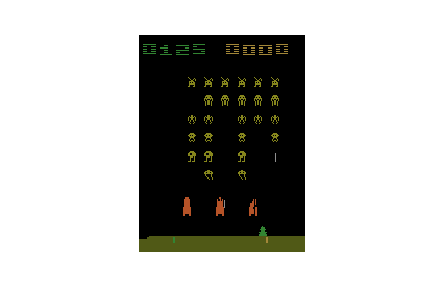
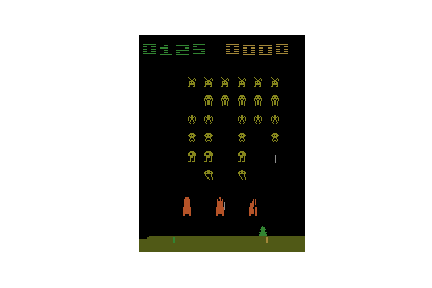
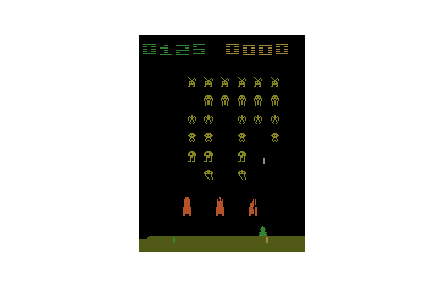
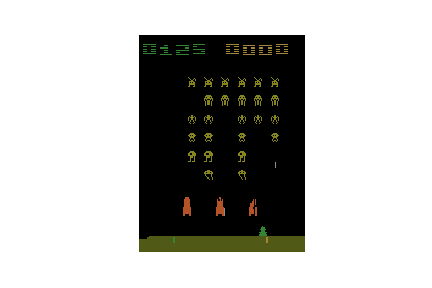
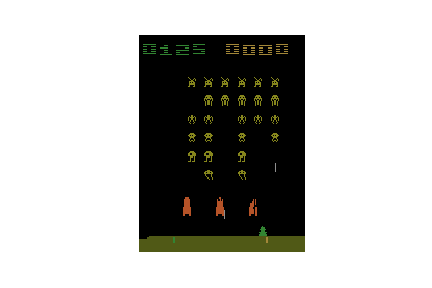
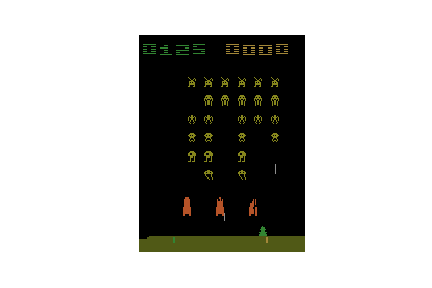
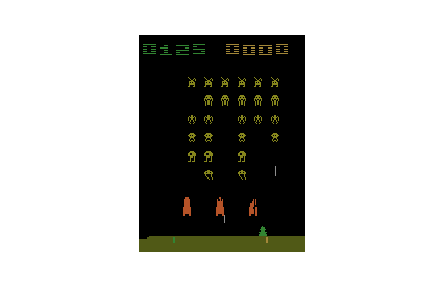
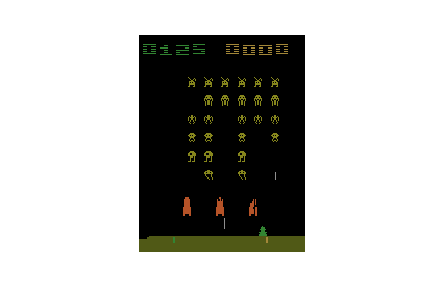
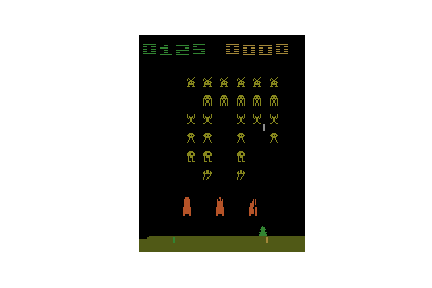
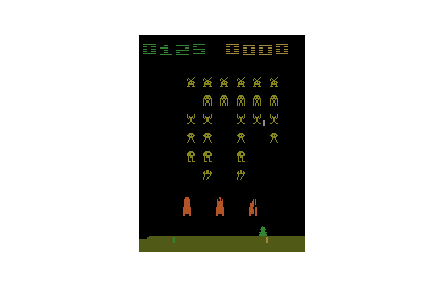
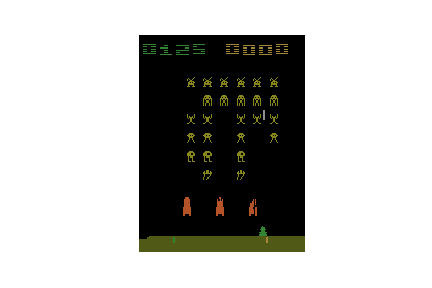
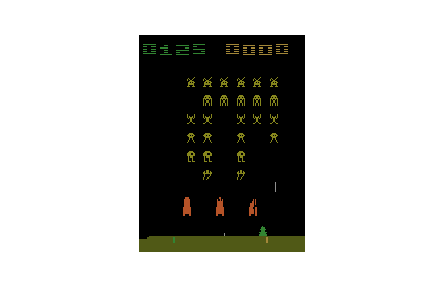
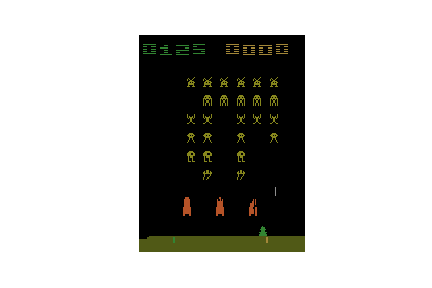
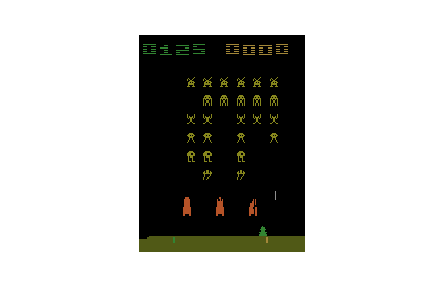
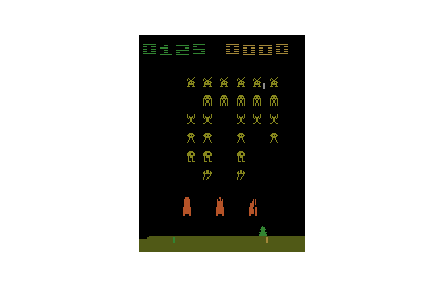
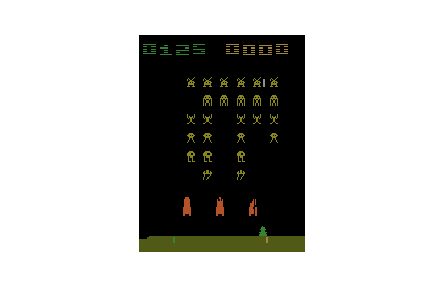
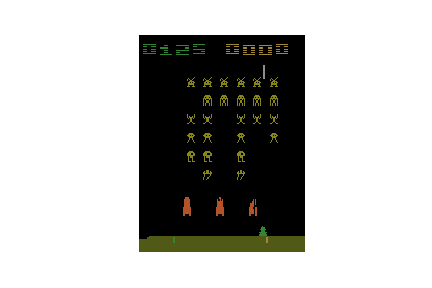
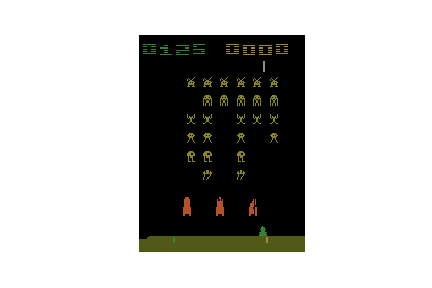
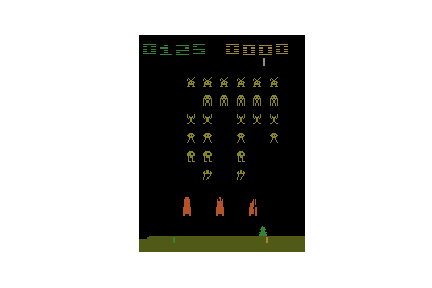
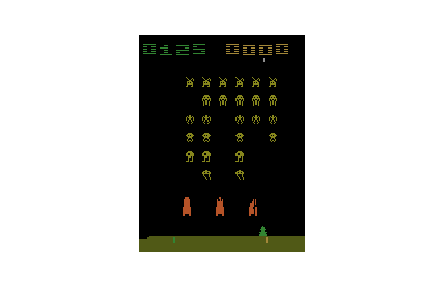
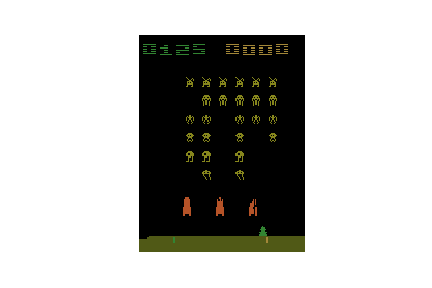
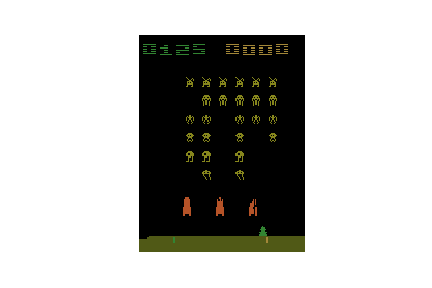
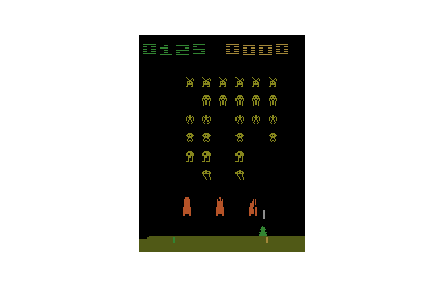
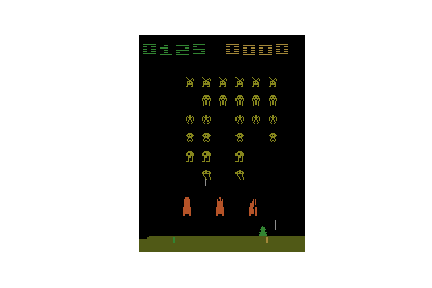
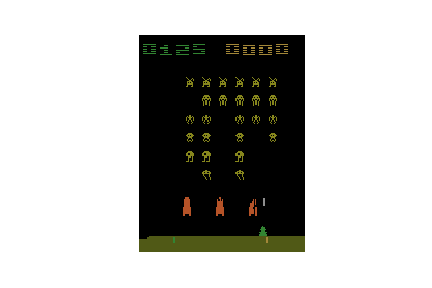
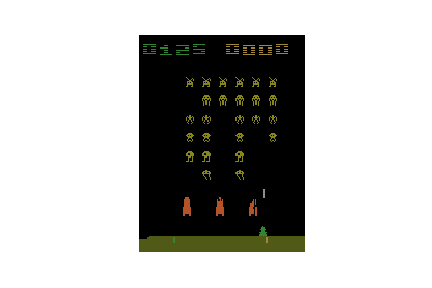
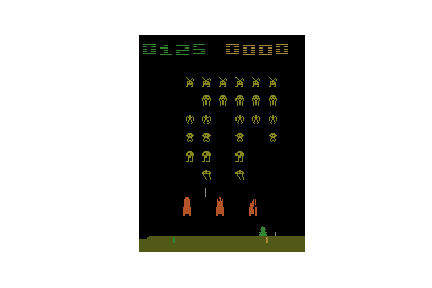
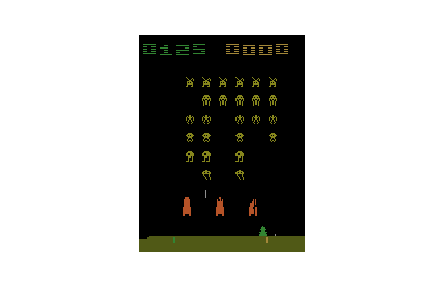
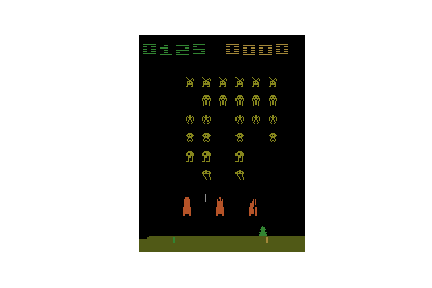
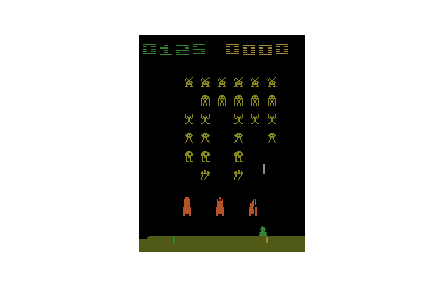
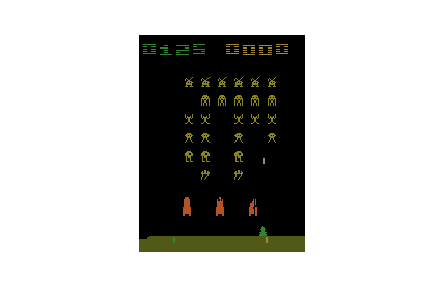
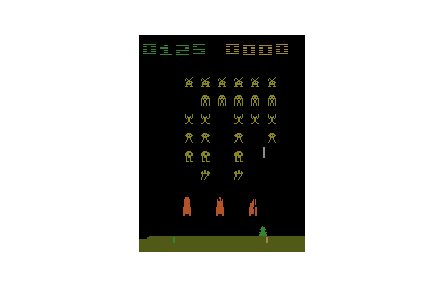
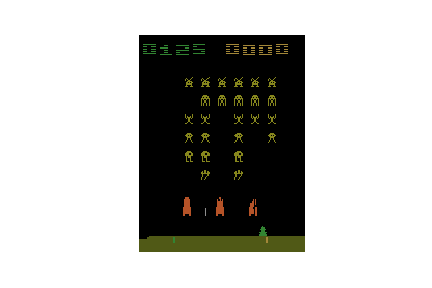
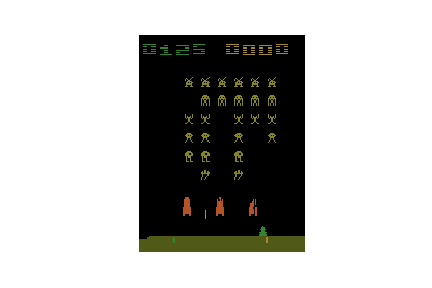
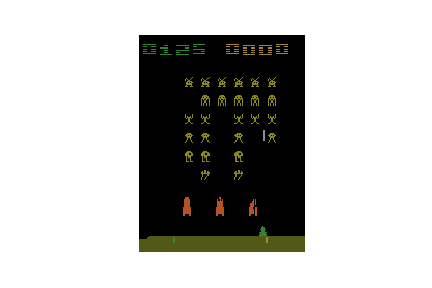
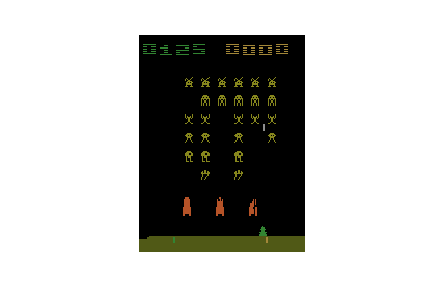
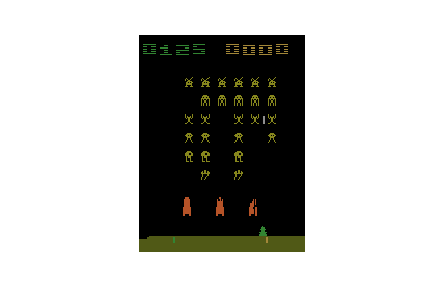
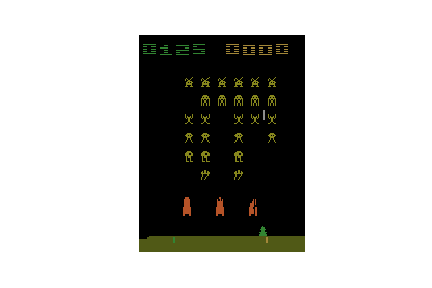
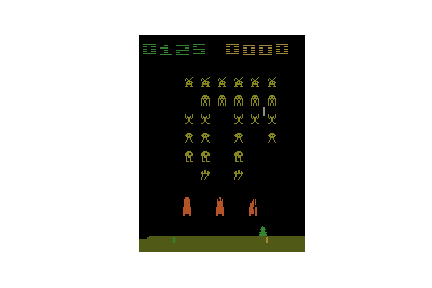
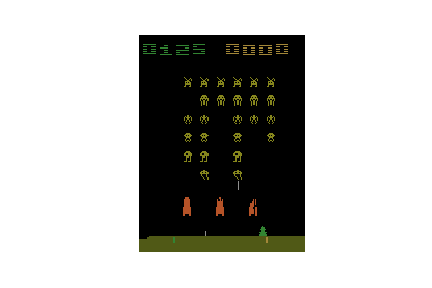
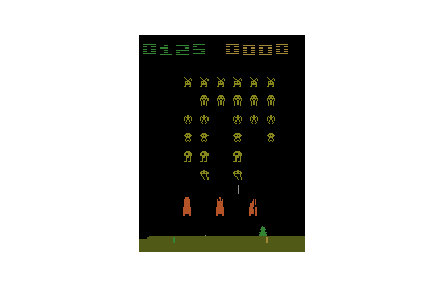
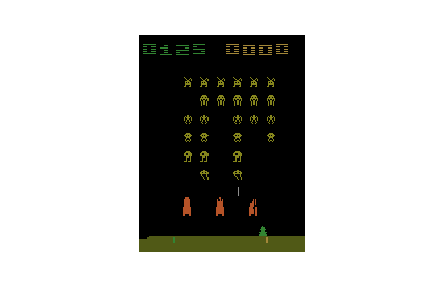
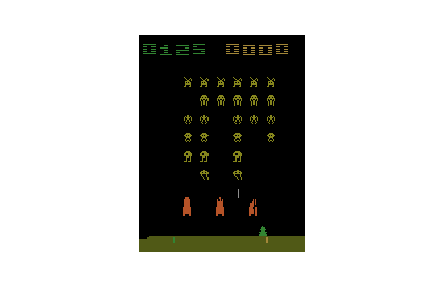
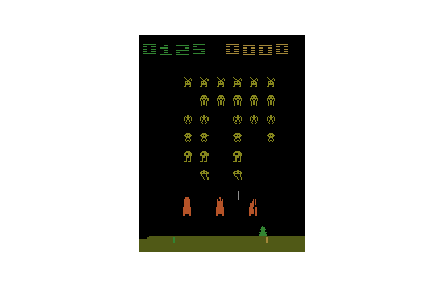
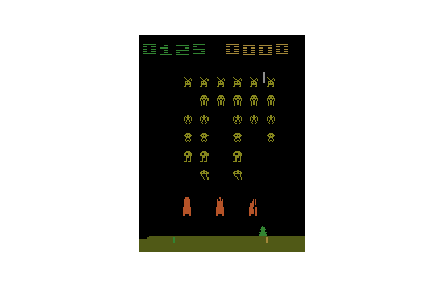
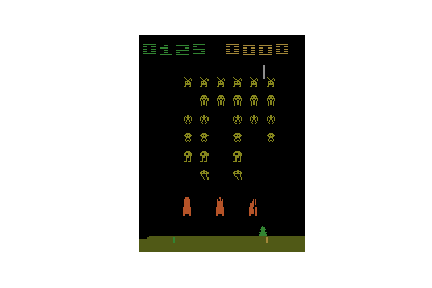
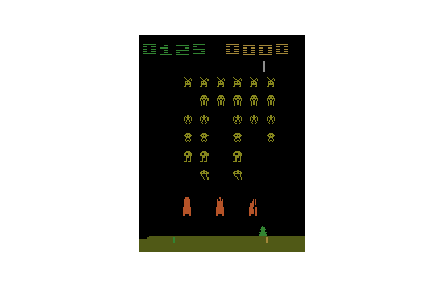
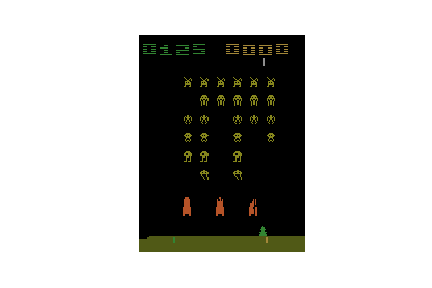
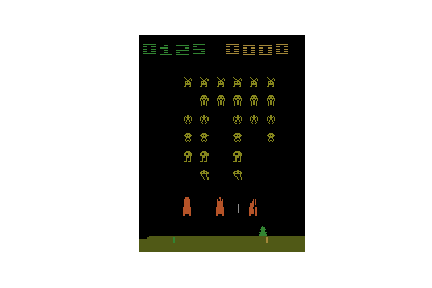
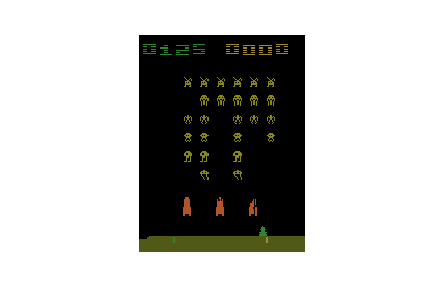
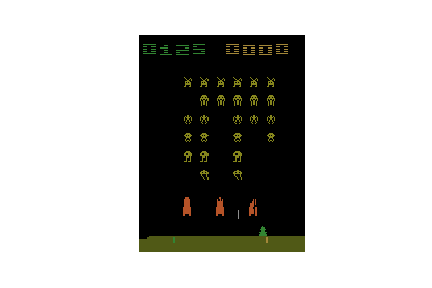
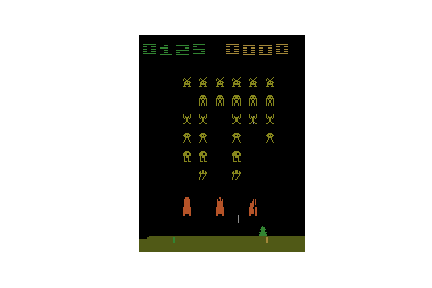
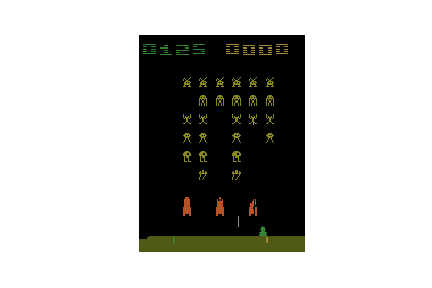
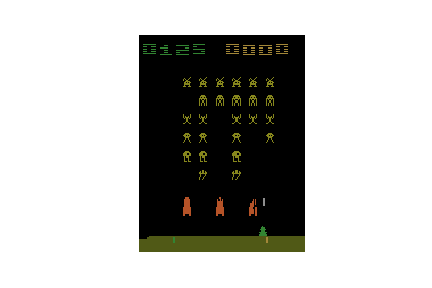
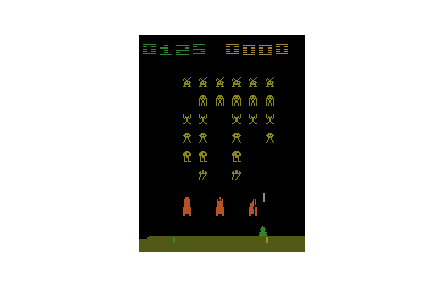
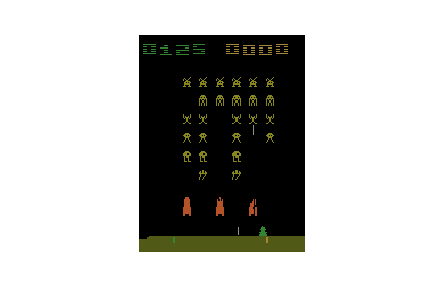
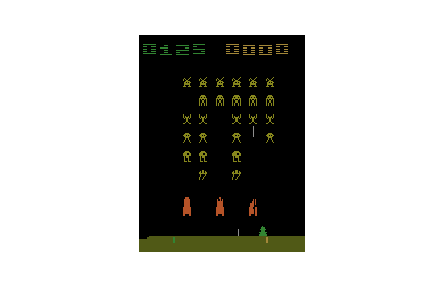
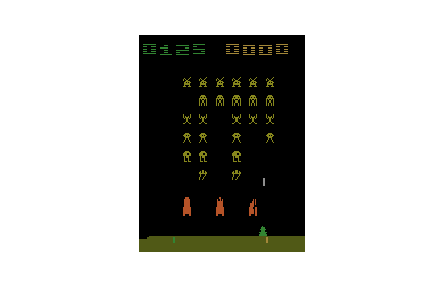
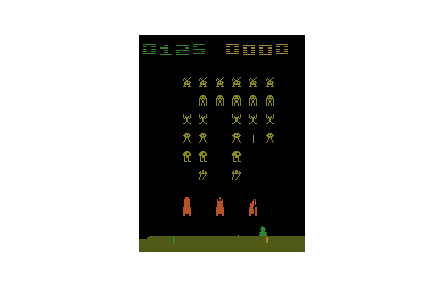
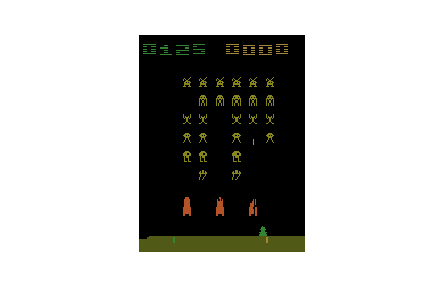
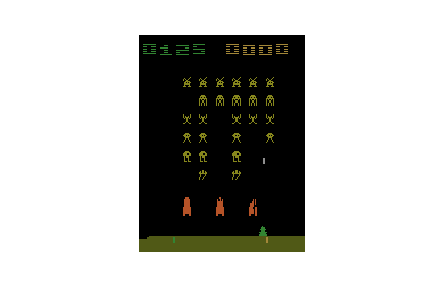
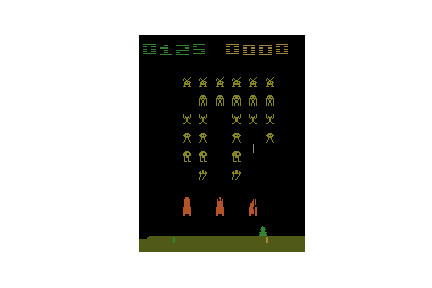
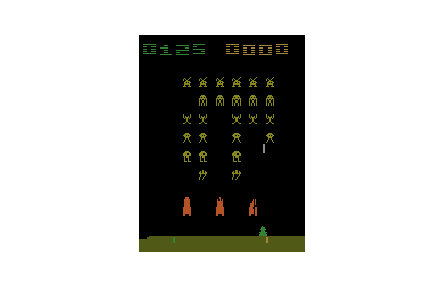
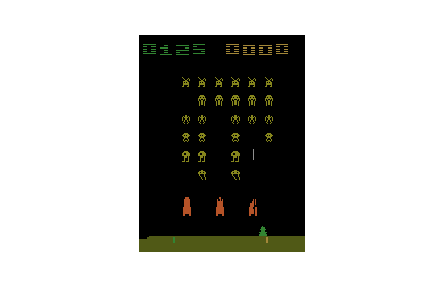
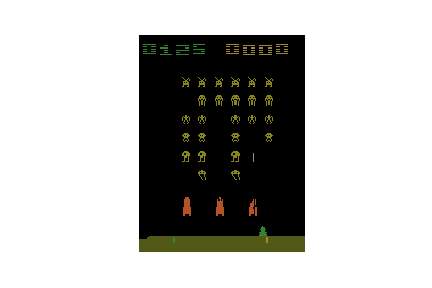
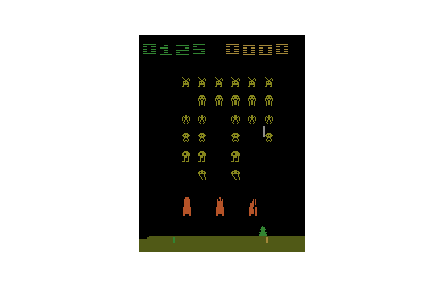
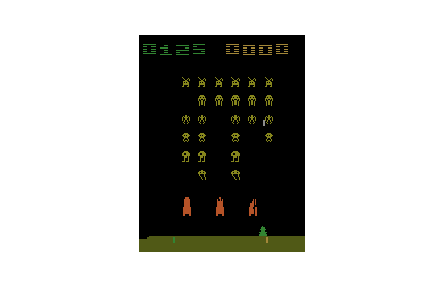
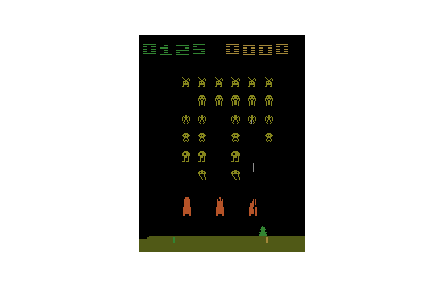
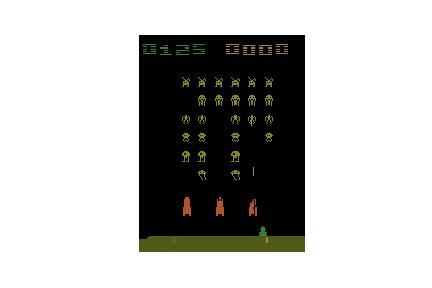
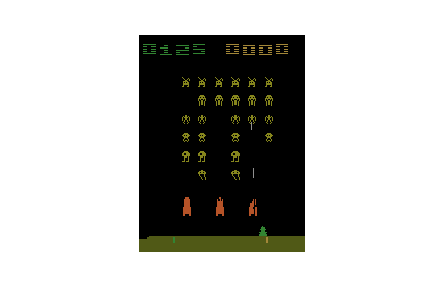
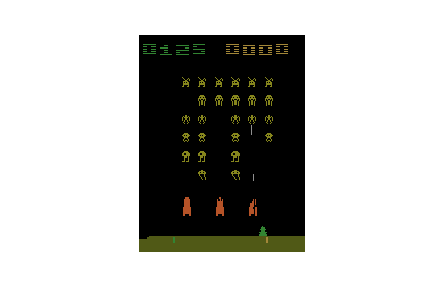
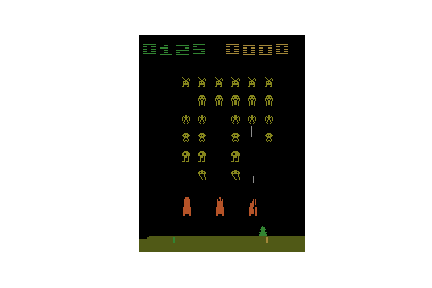
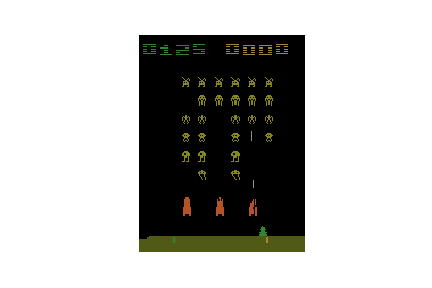
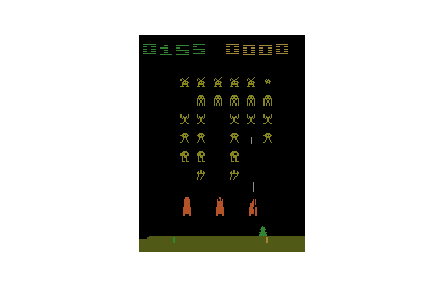
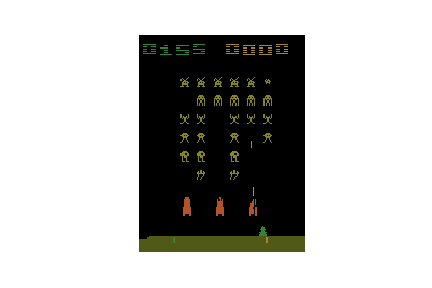
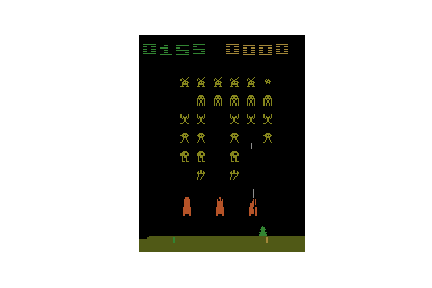
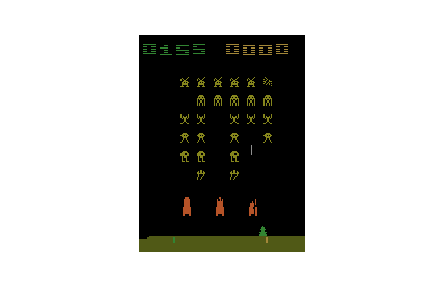
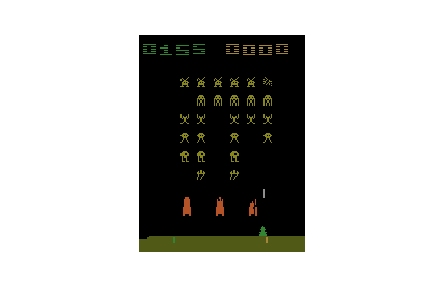
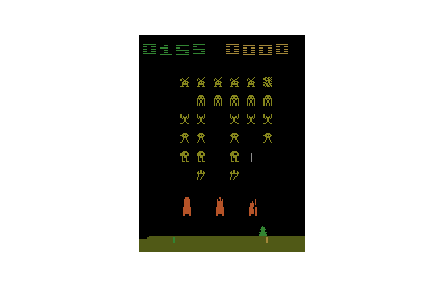
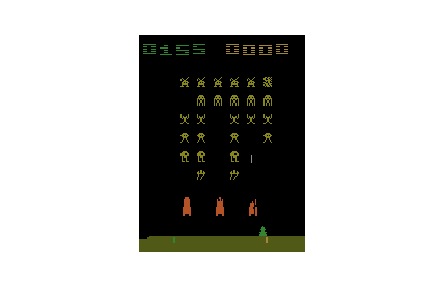
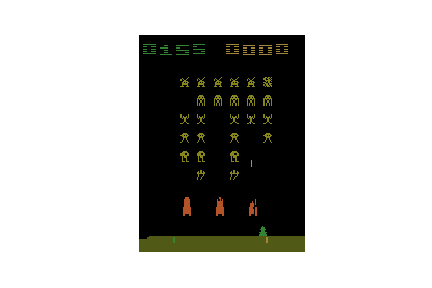
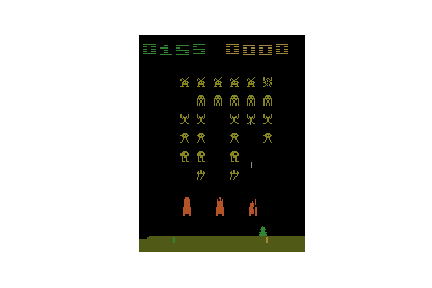
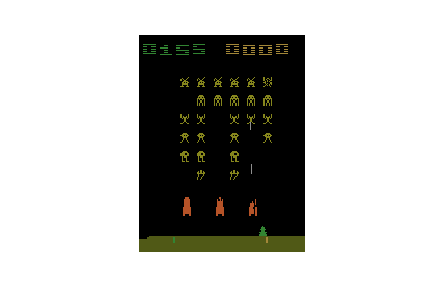
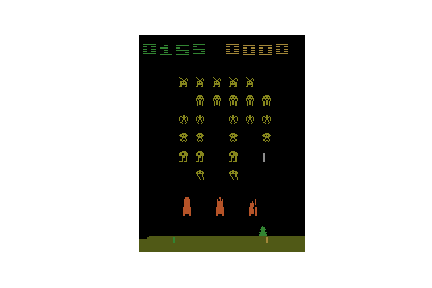
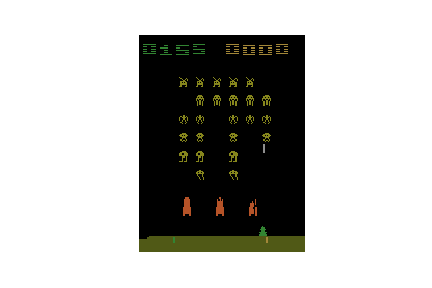
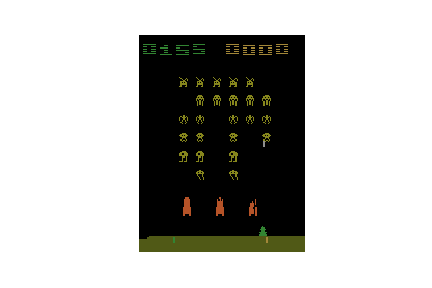
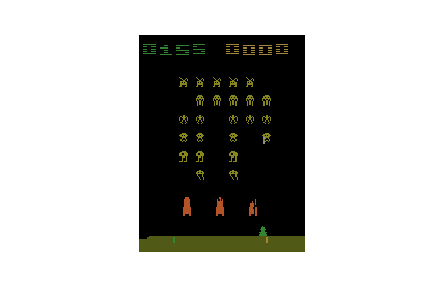
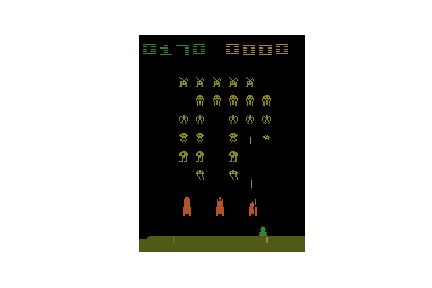
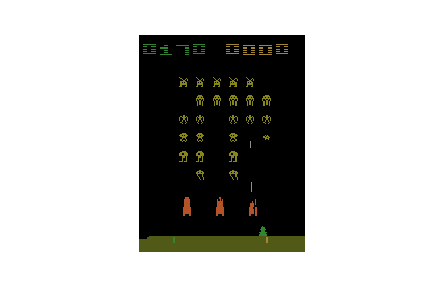
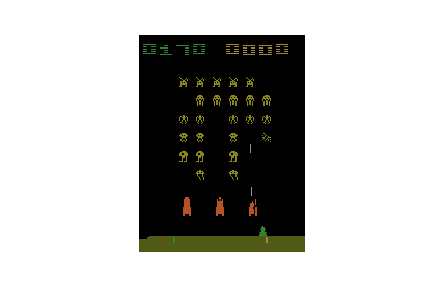
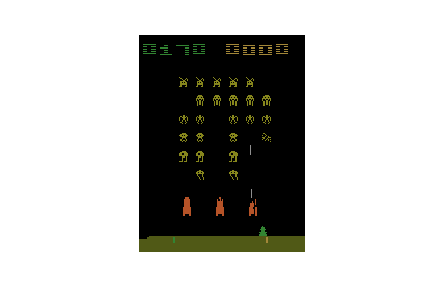
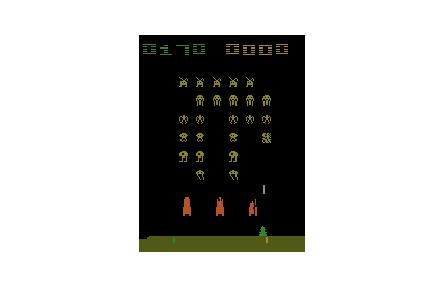
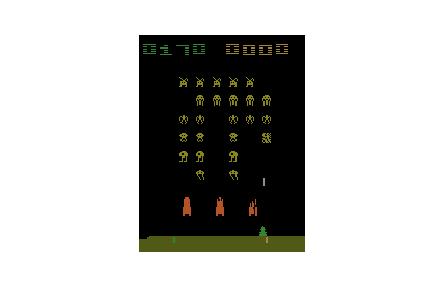
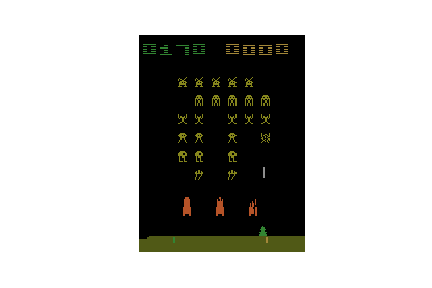
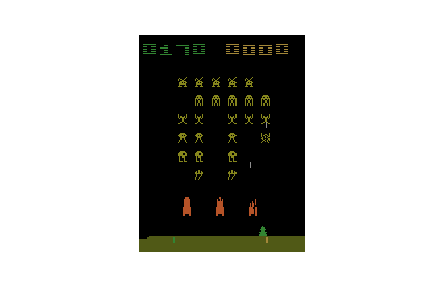
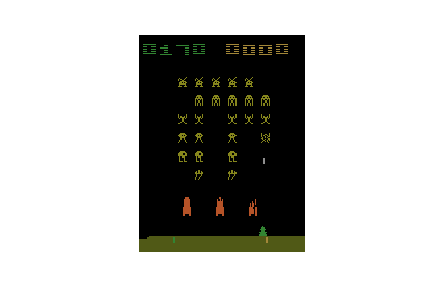
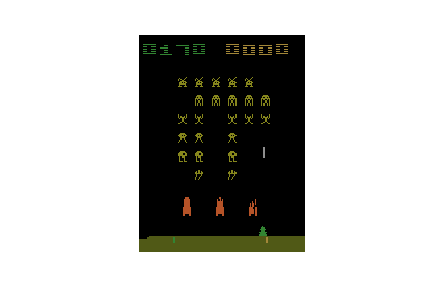
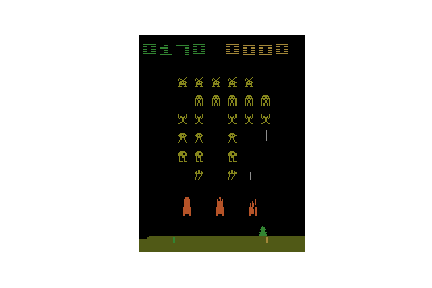
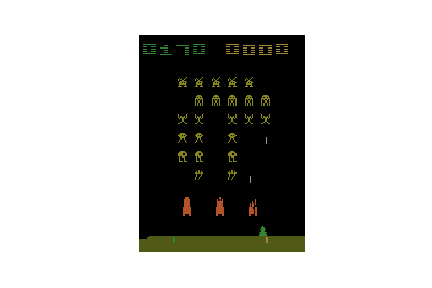
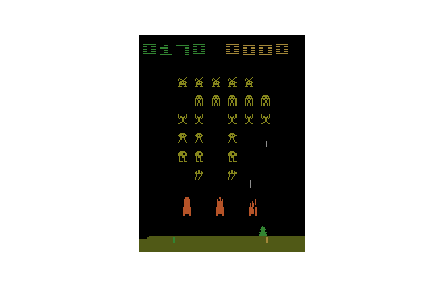
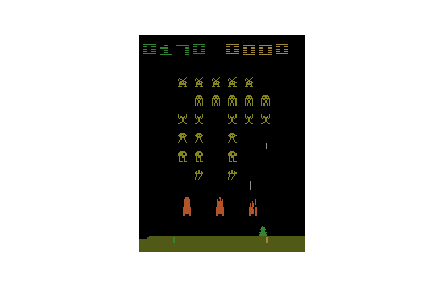
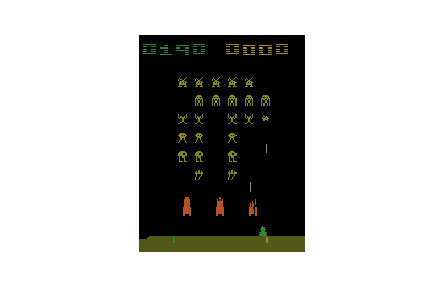
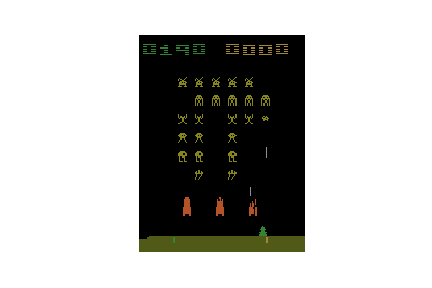
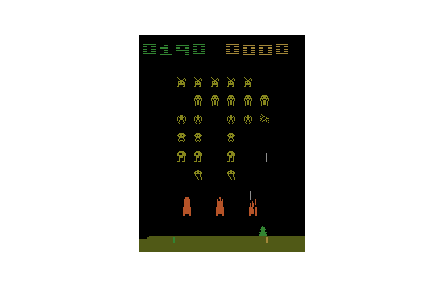
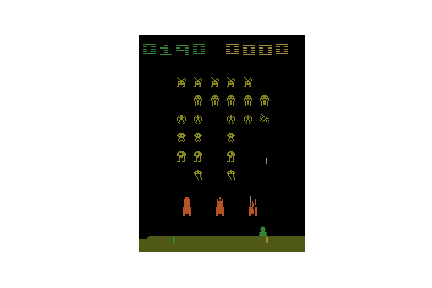
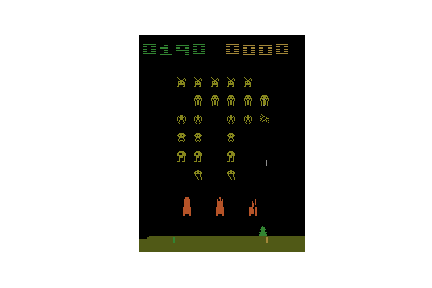
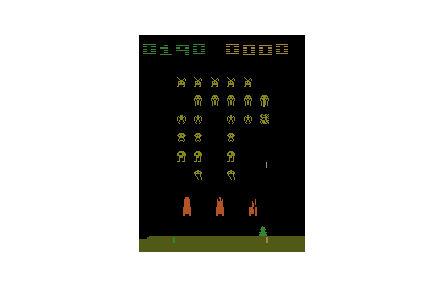
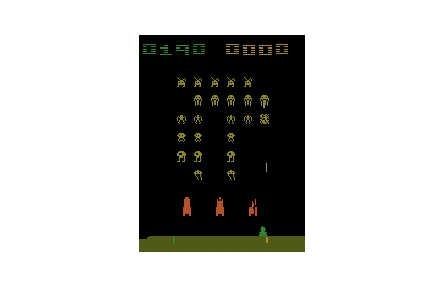
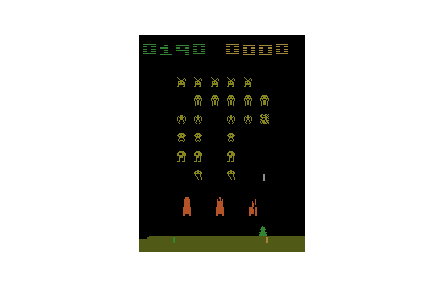
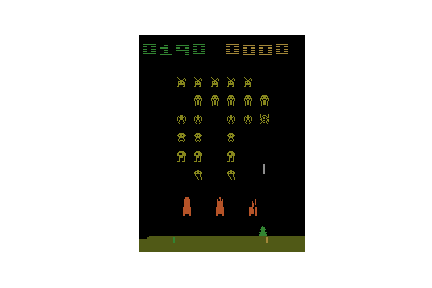
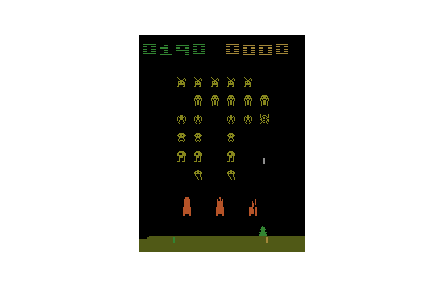
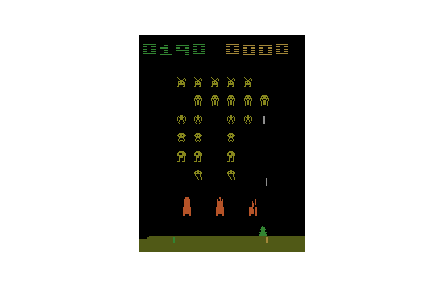
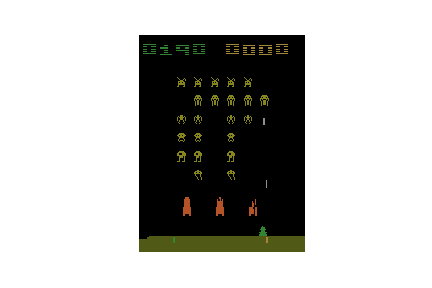
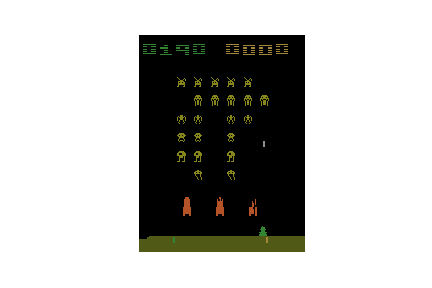
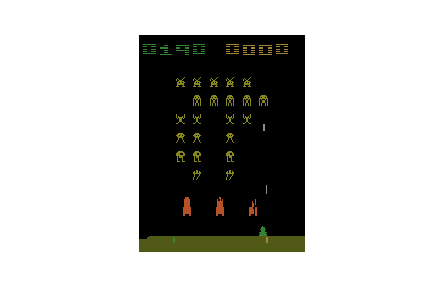
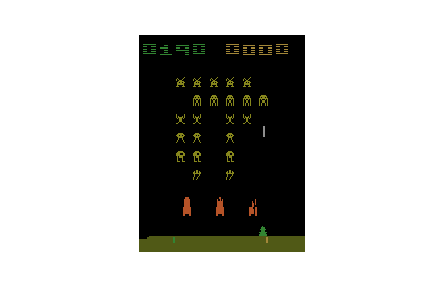
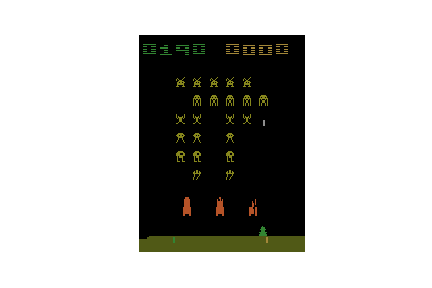
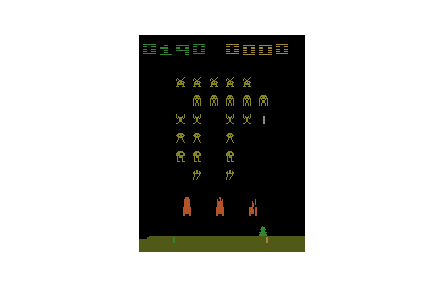
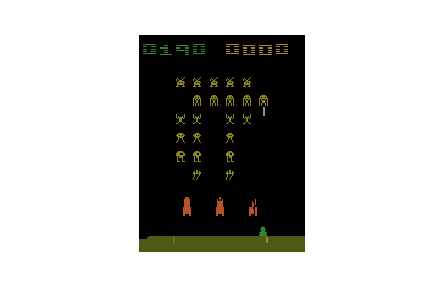
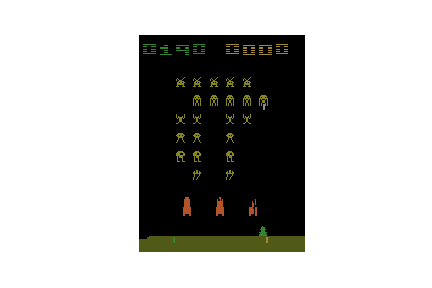
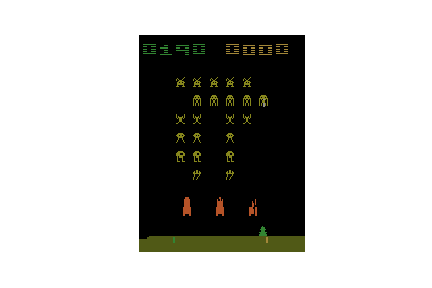
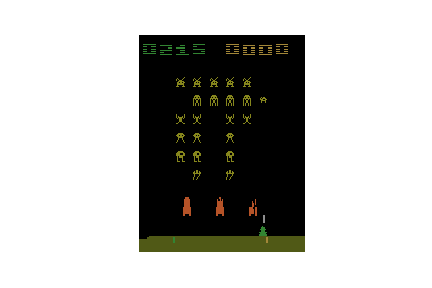
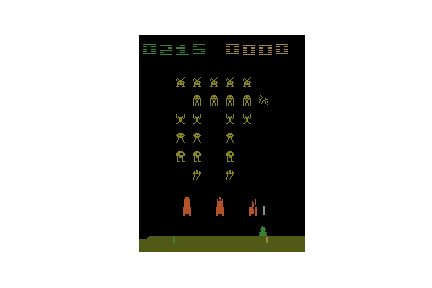
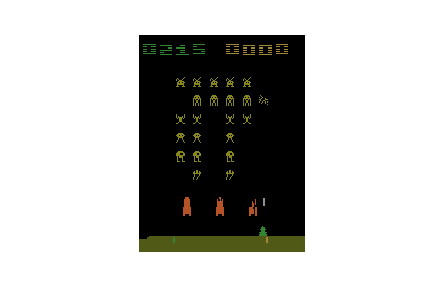
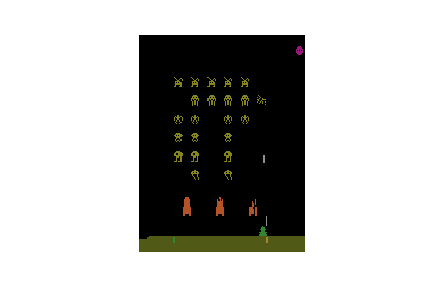
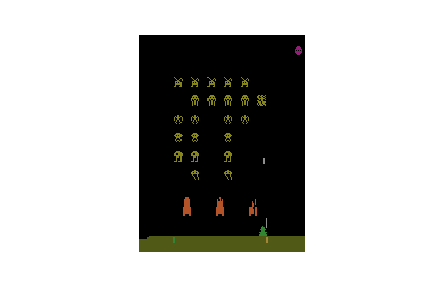
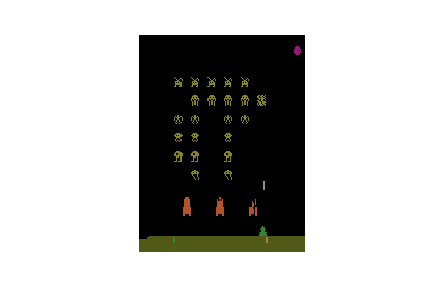
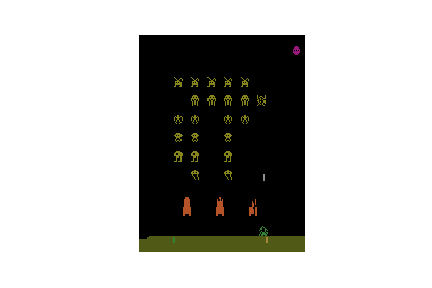
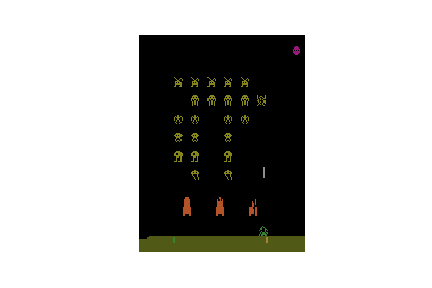
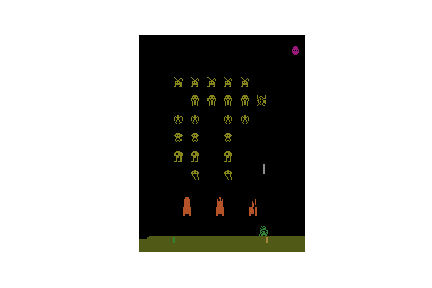
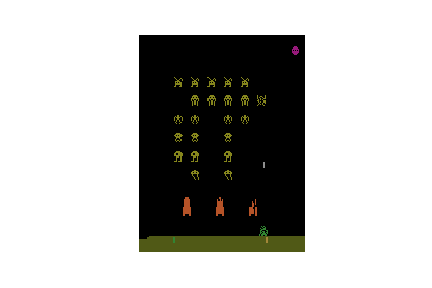
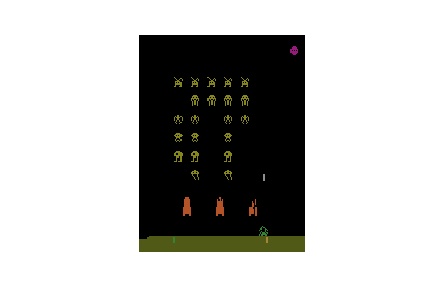
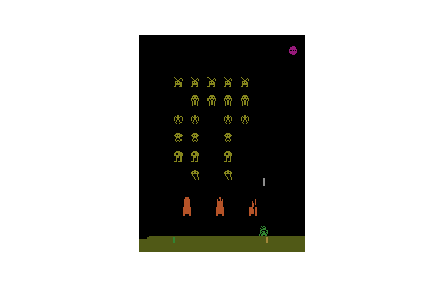
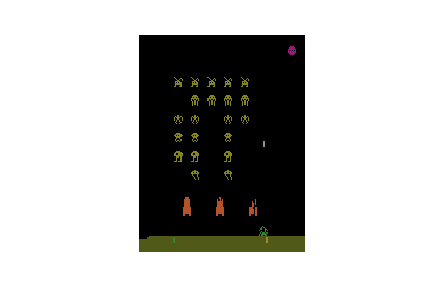
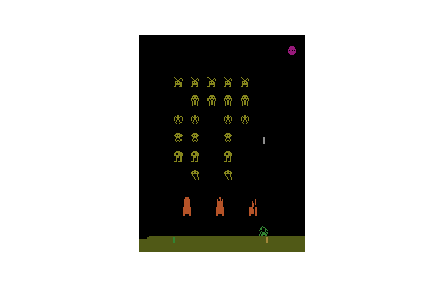
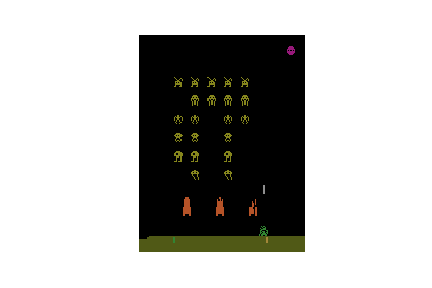
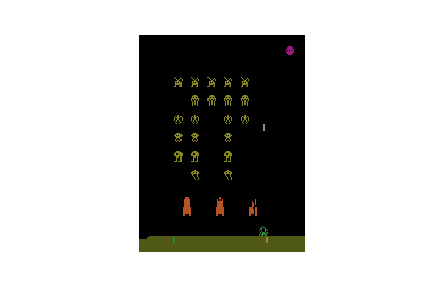
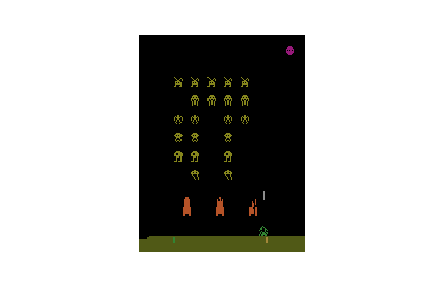
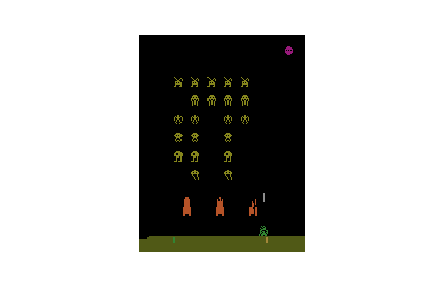
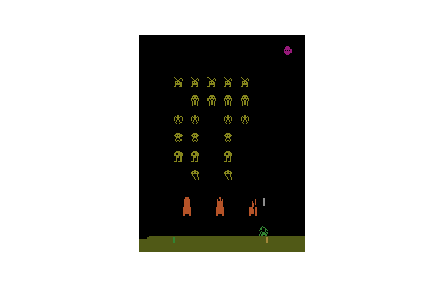
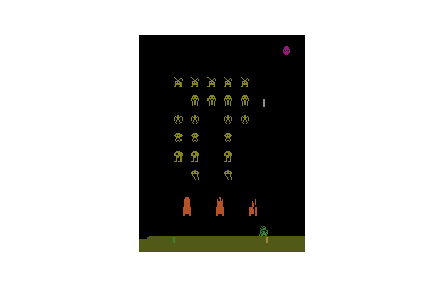
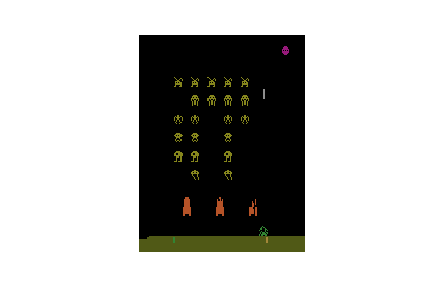
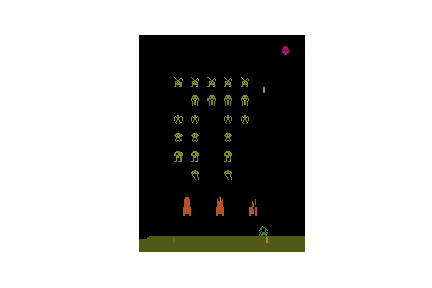
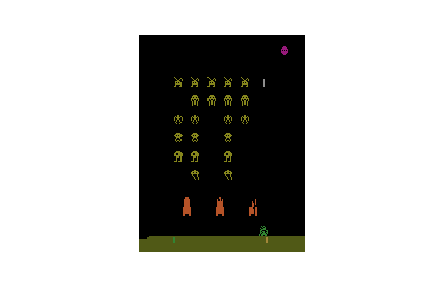
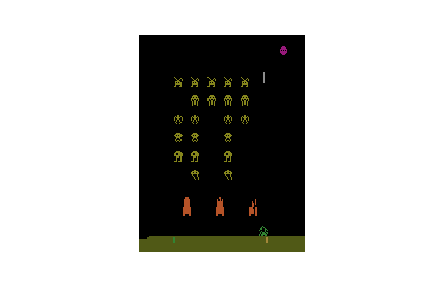
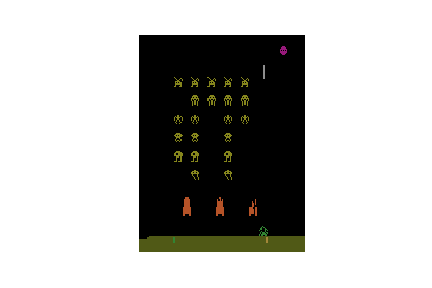
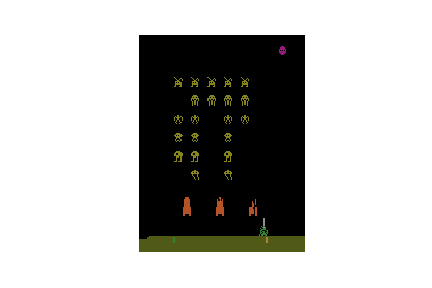
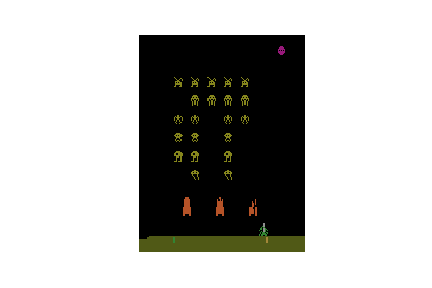
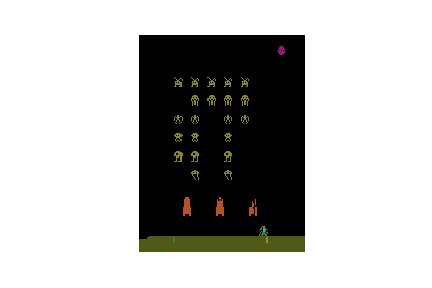
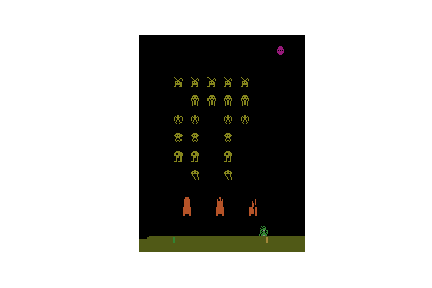
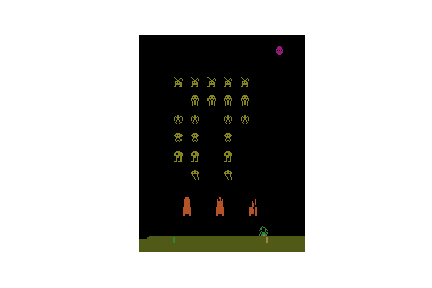
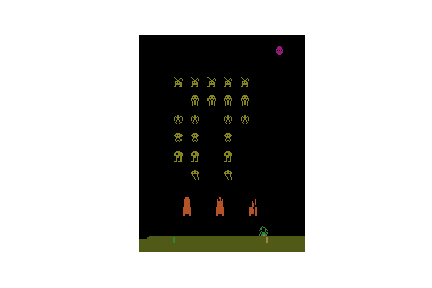
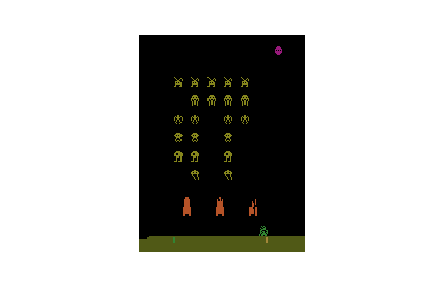
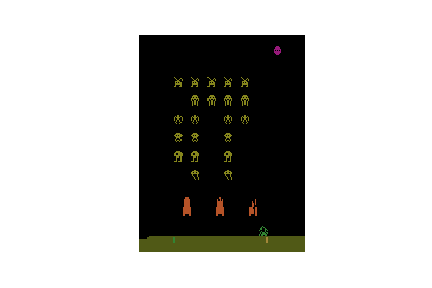
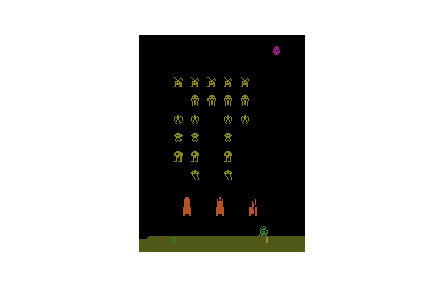
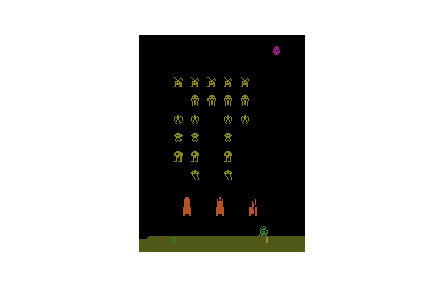
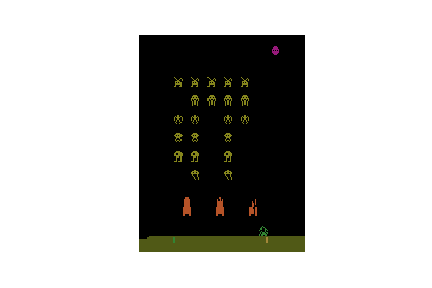
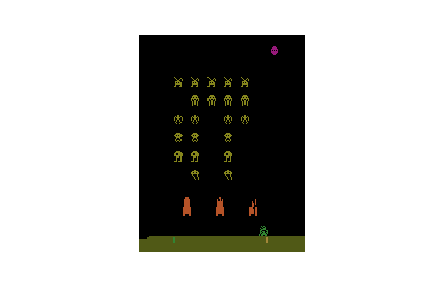
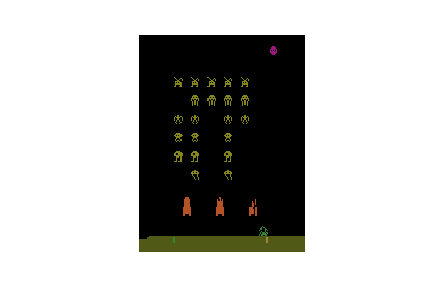
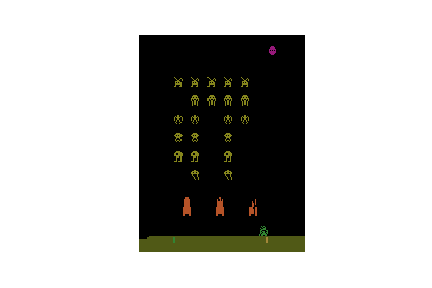
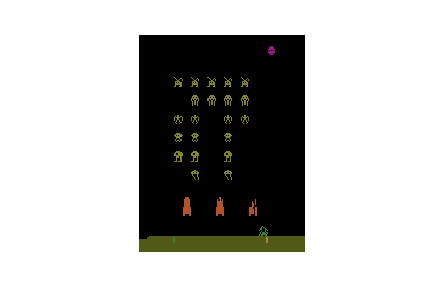
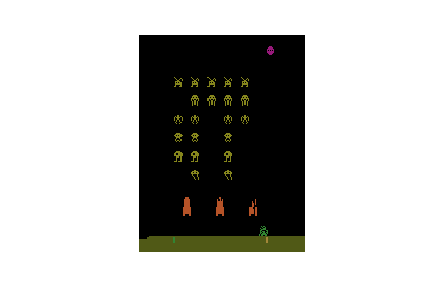
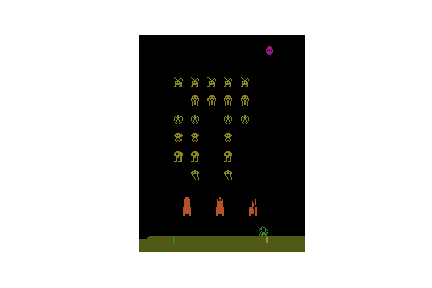
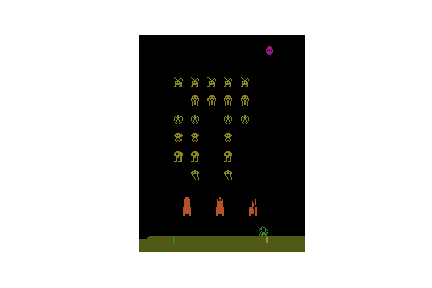
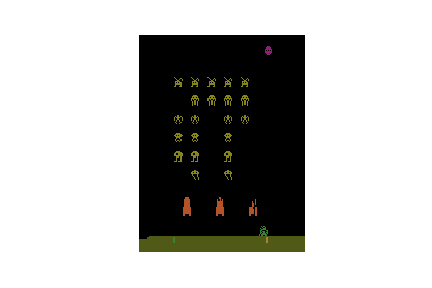
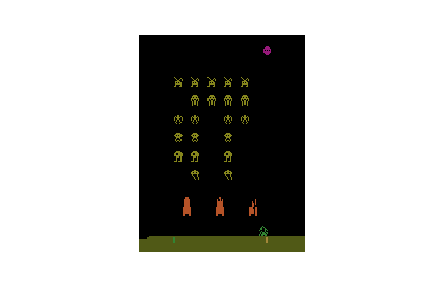
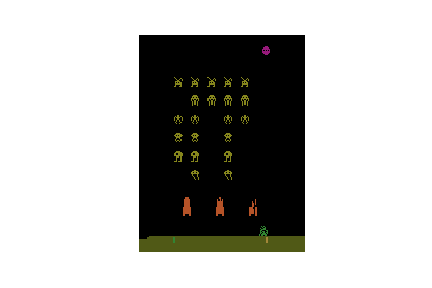
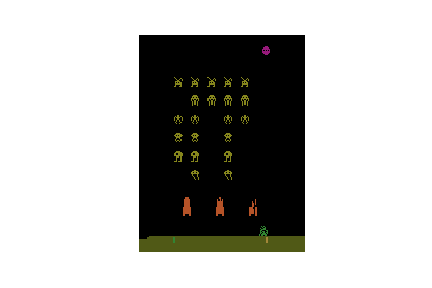
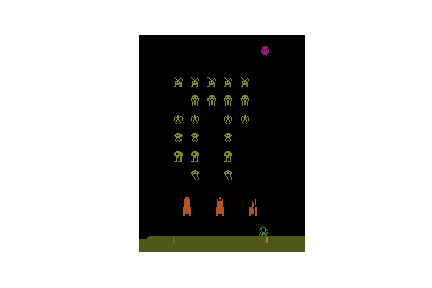
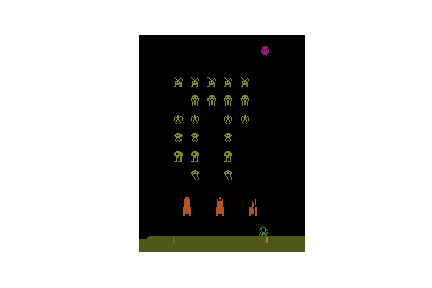
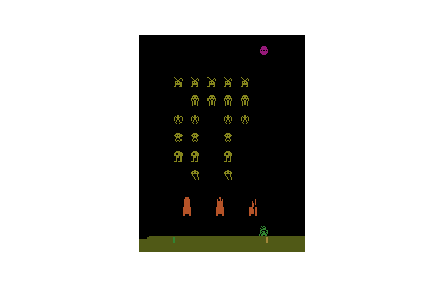
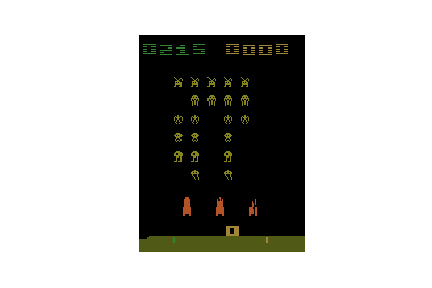

c:\users\matheus mortatti\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\matheus mortatti\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


KeyboardInterrupt: 

In [22]:
with tf.device(device):
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:

        if continue_training:
            try:
                saver.restore(sess, "./models/" + model_name + ".ckpt")
            except tf.errors.NotFoundError:
                print("Model not found. Creating new ckpt file")
                init = tf.global_variables_initializer()
                sess.run(init)
                pass
        else:
            init = tf.global_variables_initializer()
            sess.run(init)

        frames_seen = 0
        decay_step = 0
        for episode in range(2000, 10000):
            #Reset environment and get first new observation
            s = env.reset()
            d = False
            num_actions = 0
            frames = []
            total_reward = 0
            a = 0
            all_ep_Q = []
            
            ClearStack(stacked_frames)

            new_frame = preprocess_frame(s)
            for k in range(frame_stack_size):
                StackFrame(stacked_frames, new_frame)

            #The Q-Network
            while not d: #num_actions < max_steps:
                num_actions+=1
                decay_step+=1
                
                tau += 1

                #copy stacked frames
                c_stacked_frames = copy.deepcopy(stacked_frames)

                #allQ = model.predict(np.vstack(c_stacked_frames).flatten())
                
                state = np.stack(c_stacked_frames,axis=2)
                predictedQ = sess.run(action_network.output,
                                feed_dict={action_network.inputs_:state.reshape((1,*state.shape))})
                all_ep_Q.append(np.amax(predictedQ))
                if num_actions % frame_skip_size == 0:
                    if np.random.rand(1) < e:
                        a = env.action_space.sample()
                    else:
                        #Choose an action by greedily (with e chance of random action) from the Q-network
                        a = np.argmax(predictedQ)
                      
                
                e = ef + (e - ef) * np.exp(-decay_rate * decay_step)

                #Get new state and reward from environment
                s1,r,d,_ = env.step(a)

                total_reward += r

                #stack new frame
                StackFrame(stacked_frames, preprocess_frame(s1))
                
                next_state = np.stack(stacked_frames,axis=2)
                
                if episode%100 == 0:
                    frames.append(s1)

                if d == True:
                    #num_actions = max_steps
                    last_action = True
                else:
                    last_action = False

                memory.add((state, r, a, next_state, last_action))

                # BATCH LEARNING
#                 batch, ISWeights_, batch_indexes = memory.sample(batch_size)
                batch = memory.sample(batch_size)

                states = np.array([each[0] for each in batch],ndmin=3)
                rewards = np.array([each[1] for each in batch])
                actions = np.array([each[2] for each in batch])
                next_states = np.array([each[3] for each in batch],ndmin=3)
                last_actions = np.array([each[4] for each in batch])

                targets = []
    
                result_next_states = sess.run(target_network.output,
                                              feed_dict={target_network.inputs_:next_states})
                actions_next_states = sess.run(action_network.output,
                                               feed_dict={action_network.inputs_:next_states})
            
                result_states = sess.run(target_network.output,
                                              feed_dict={target_network.inputs_:states})
    
                for i in range(len(batch)):
                    last_action = last_actions[i]
                    action = actions[i]
                    
                    next_action = np.argmax(actions_next_states[i])
                    targetQ = result_states[i]
                    if last_action:
                        targetQ[action] = rewards[i]
                    else:
                        targetQ[action] = rewards[i] + y*result_next_states[i][next_action]
                    targets.append(targetQ)
                
                targets = np.array(targets)
                    
                # Train the Network
#                 aerror, loss,  _ = sess.run([action_network.absolute_error, 
#                                              action_network.loss,
#                                              action_network.optimizer],
#                                             feed_dict={action_network.inputs_:states,
#                                                        action_network.target_Q:targets,
#                                                        action_network.ISWeights_:ISWeights_})
                _, loss = sess.run([action_network.optimizer,
                                    action_network.loss],
                                     feed_dict={action_network.inputs_:  states,
                                                action_network.target_Q: targets})
                
                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={action_network.inputs_:  states,
                                                        action_network.target_Q: targets})
                writer.add_summary(summary, episode)
                writer.flush()
                
                # Update the memory with the absolute errors
#                 memory.UpdateWeights(aerror, batch_indexes)
                
                # Update the parameters of the action to the target network
                if tau > max_tau:
                    update_target = update_target_graph(action_network.name, target_network.name)
                    sess.run(update_target)
                    tau = 0
                    print("Model updated")

            averageQ = np.sum(all_ep_Q) / num_actions
            averageQs.append(averageQ)
            averageRs.append(total_reward / num_actions)
            frames_seen += num_actions
            print("Episode " + str(episode) + " ended." + 
                      "\n\t Loss = " + str(loss) + 
                      "\n\t Total, Average Reward = " + str(total_reward) + ", " + str(total_reward / num_actions) +
                      "\n\t Average Predicted Q = " + str(averageQ) +
                      "\n\t Frames Seen So Far = " + str(frames_seen) +
                      "\n\t Explore Prob = " + str(e))

            if episode % 5 == 0:
                save_path = saver.save(sess,  "./models/" + model_name + ".ckpt")
                pickle.dump(averageQs, open(log_dir + '/averageQs.p', 'wb'))
                pickle.dump(averageQs, open(log_dir + '/averageRs.p', 'wb'))
                pickle.dump(episode, open(log_dir + '/start_episode.p', 'wb'))
                #memory.save()
                print("Model Saved")
                
            if episode%100 == 0:
                video_path = video_dir + "/training_" + str(training_id) + "_ep" + str(episode) + "_spaceinvaders_r" + str(total_reward)
                create_gif_from_frames(frames, save = True,
                                      path= video_path)

In [19]:
pickle.dump(memory.buffer, open(log_dir + '/memory.p', 'wb'))

MemoryError: 

## Play the Game!

INFO:tensorflow:Restoring parameters from ./models/model_spaceinvaders.ckpt


c:\users\matheus mortatti\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\matheus mortatti\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Episode 0 ended.
	 Total Reward = 170.0
Episode 1 ended.
	 Total Reward = 135.0
Episode 2 ended.
	 Total Reward = 190.0
Episode 3 ended.
	 Total Reward = 165.0
Episode 4 ended.
	 Total Reward = 210.0
Episode 5 ended.
	 Total Reward = 215.0
Episode 6 ended.
	 Total Reward = 120.0
Episode 7 ended.
	 Total Reward = 195.0
Episode 8 ended.
	 Total Reward = 220.0
Episode 9 ended.
	 Total Reward = 205.0
Episode 10 ended.
	 Total Reward = 575.0
Episode 11 ended.
	 Total Reward = 215.0
Episode 12 ended.
	 Total Reward = 160.0
Episode 13 ended.
	 Total Reward = 220.0
Episode 14 ended.
	 Total Reward = 140.0
Episode 15 ended.
	 Total Reward = 215.0
Episode 16 ended.
	 Total Reward = 165.0
Episode 17 ended.
	 Total Reward = 265.0
Episode 18 ended.
	 Total Reward = 160.0
Episode 19 ended.
	 Total Reward = 155.0
Episode 20 ended.
	 Total Reward = 165.0
Episode 21 ended.
	 Total Reward = 225.0
Episode 22 ended.
	 Total Reward = 165.0
Episode 23 ended.
	 Total Reward = 215.0
Episode 24 ended.
	 Total 


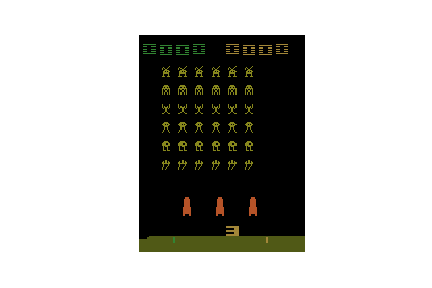
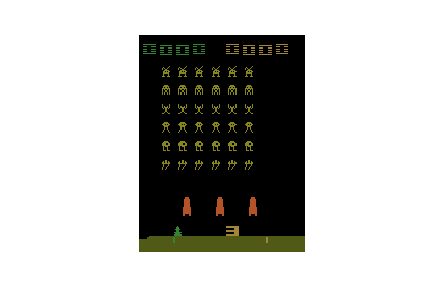
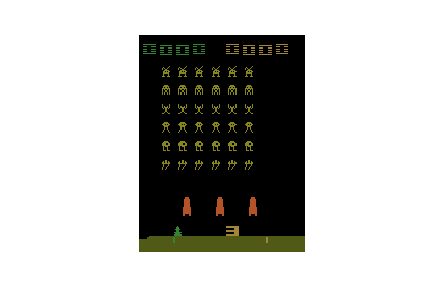
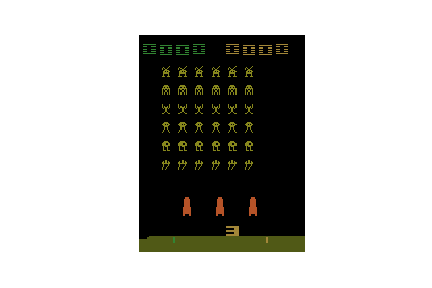
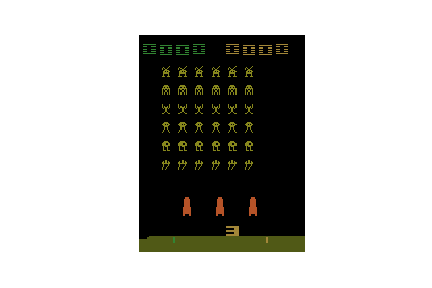
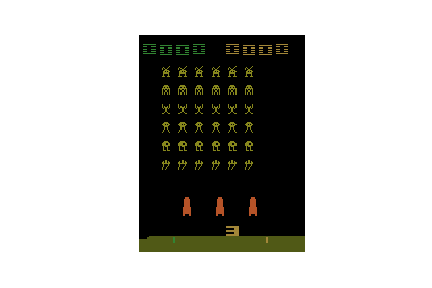
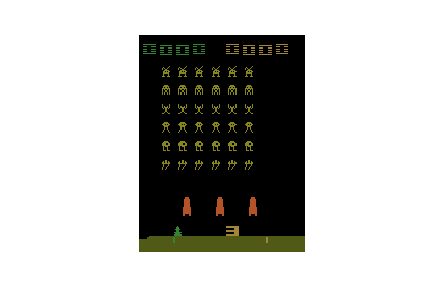
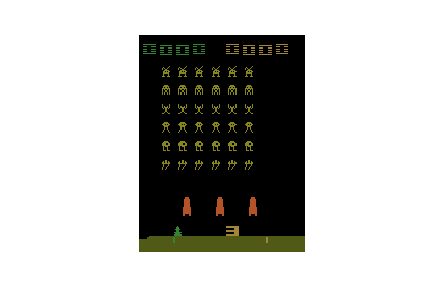
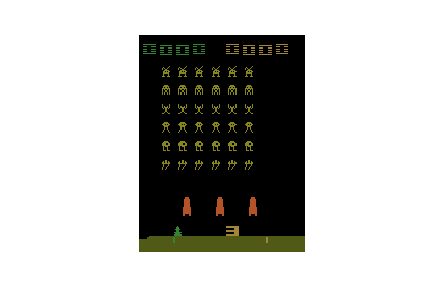
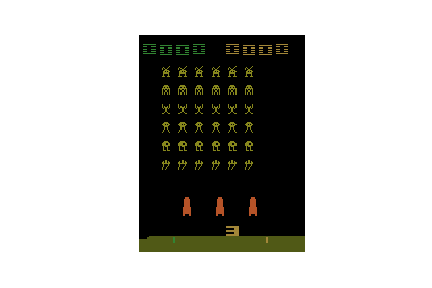
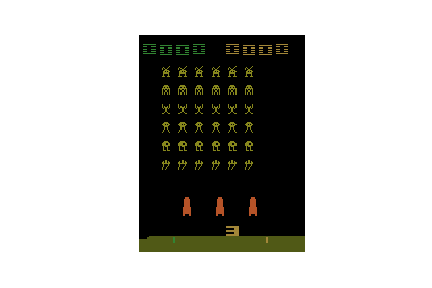
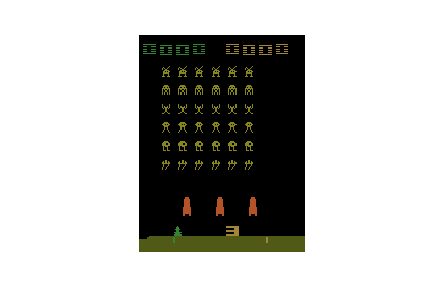
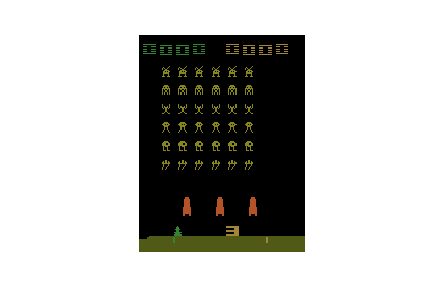
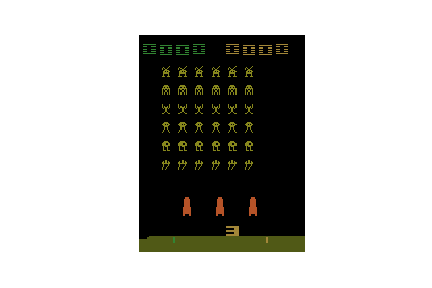
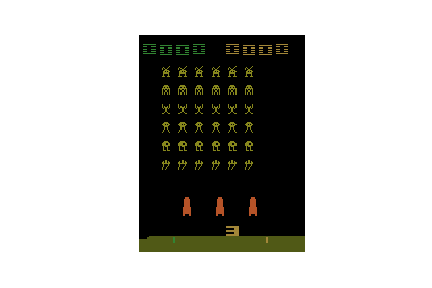
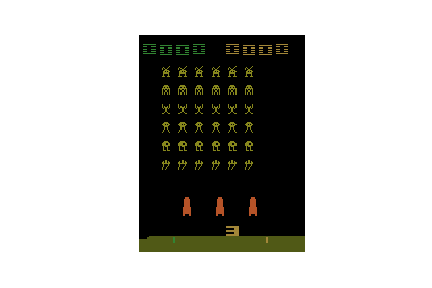
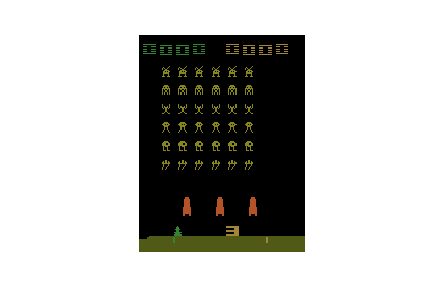
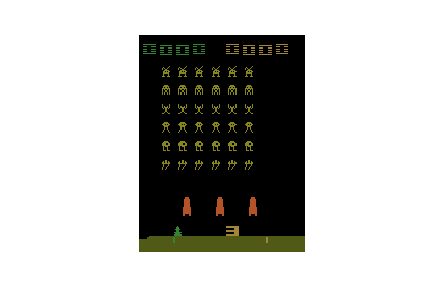
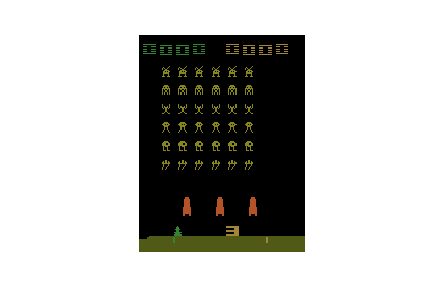
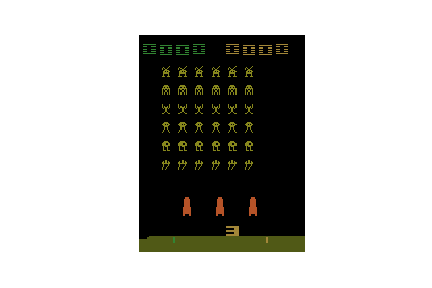
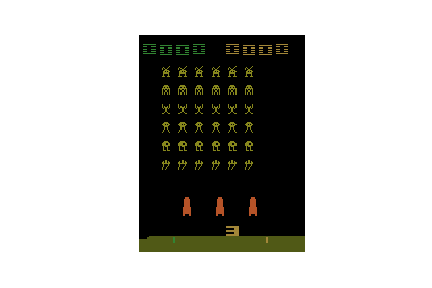
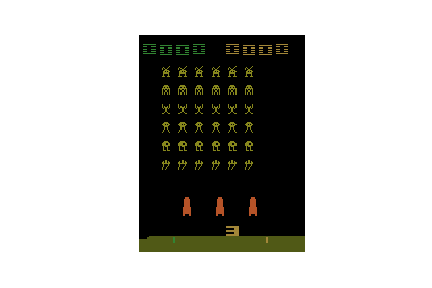
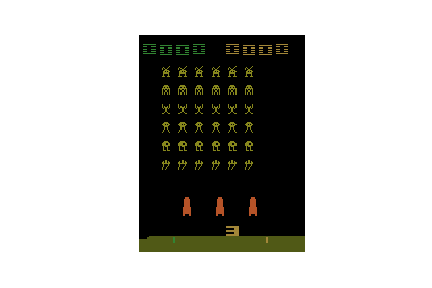
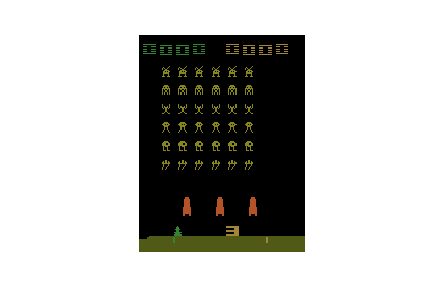
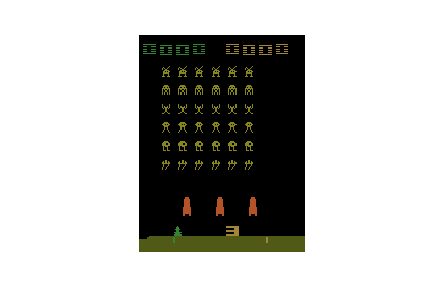
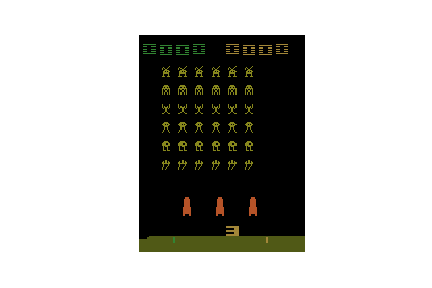
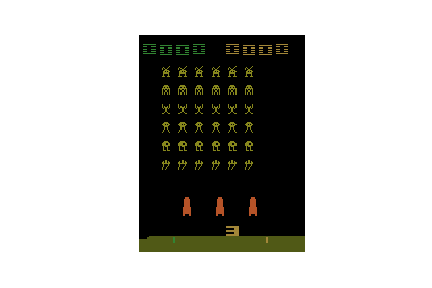
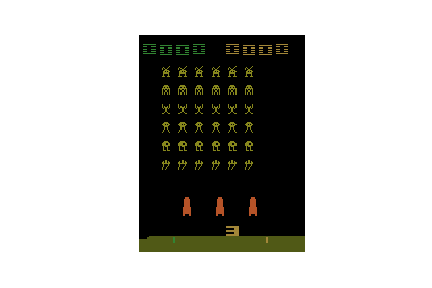
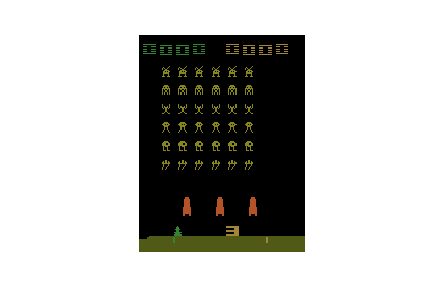
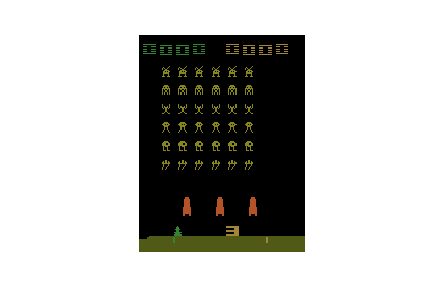
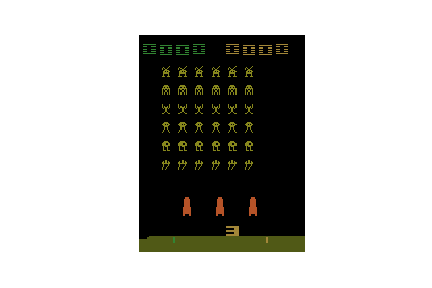
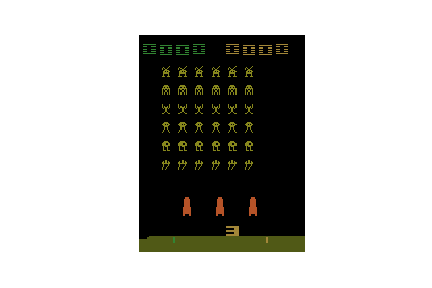
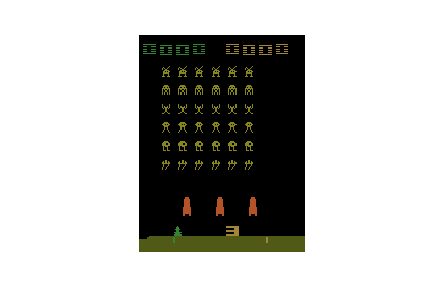
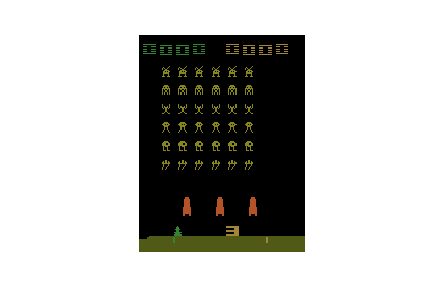
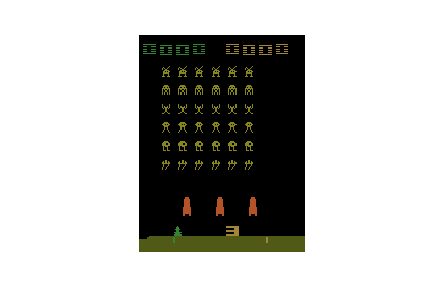
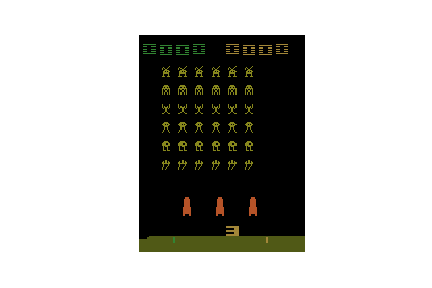
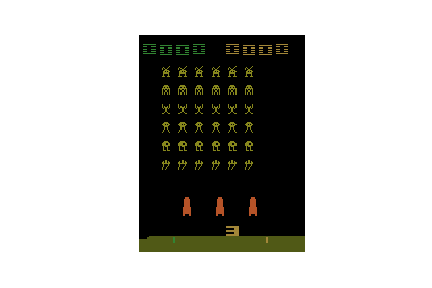
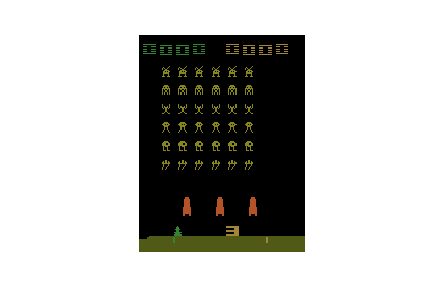
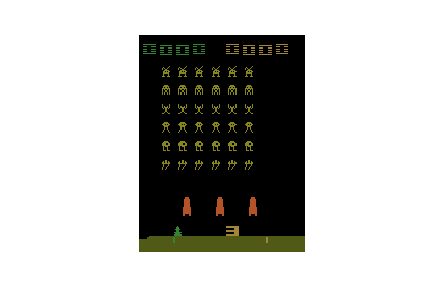
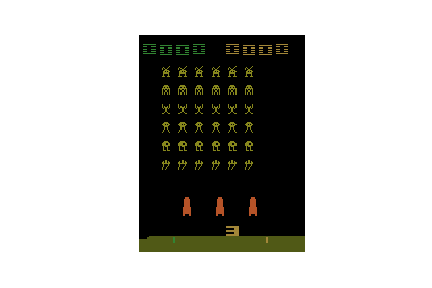
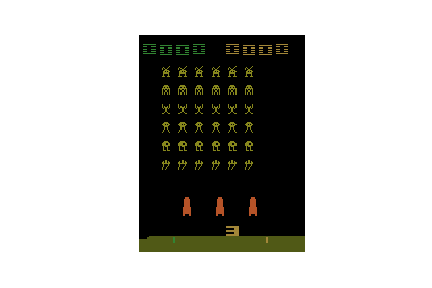
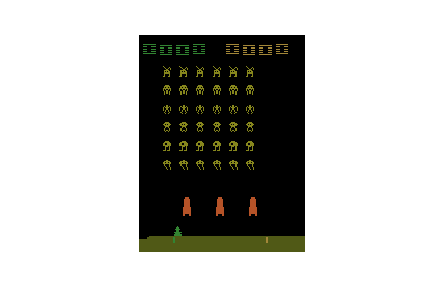
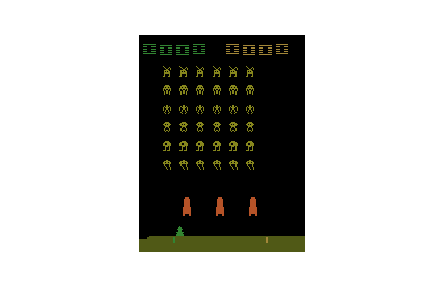
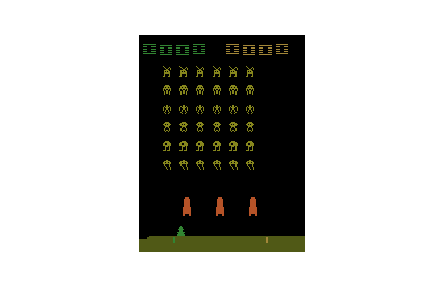
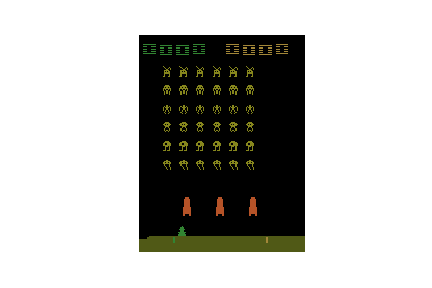
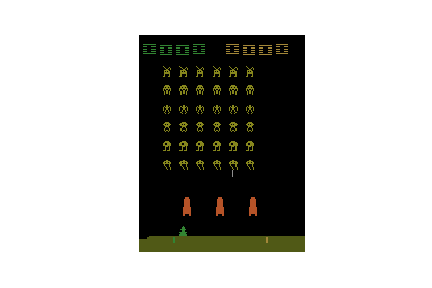
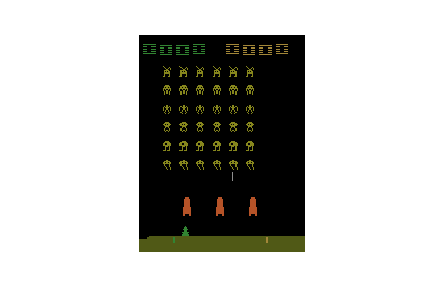
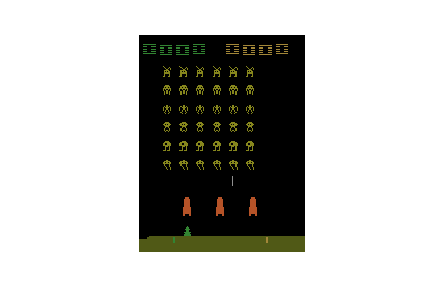
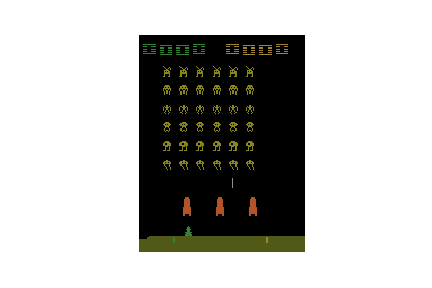
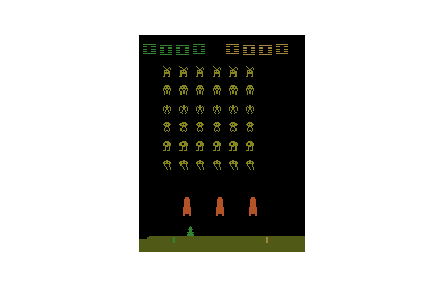
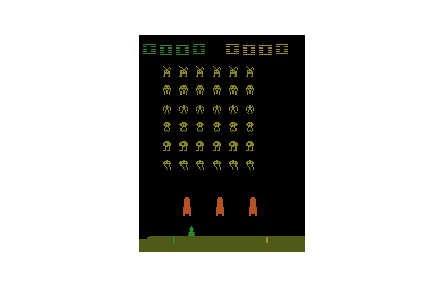
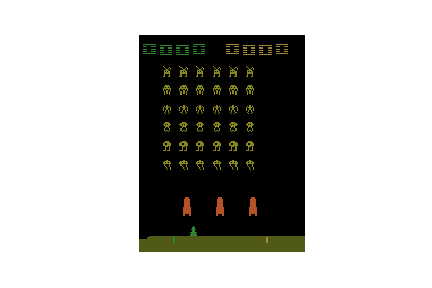
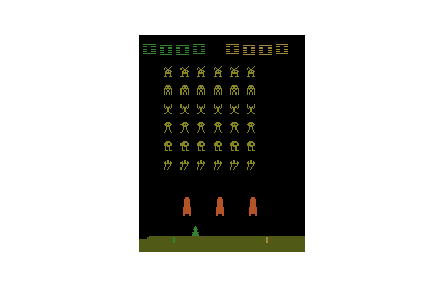
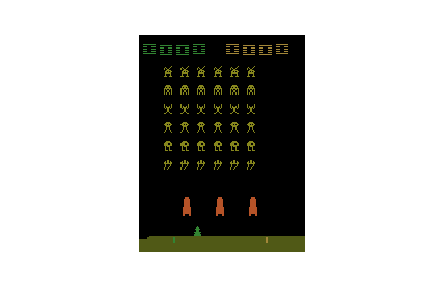
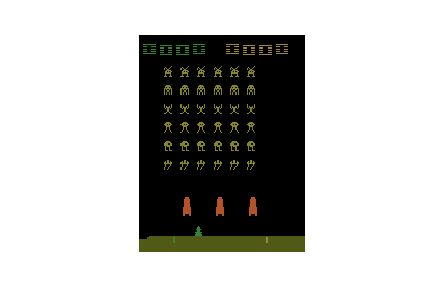
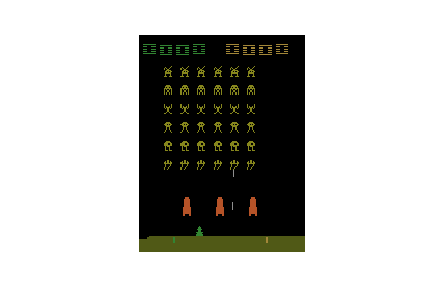
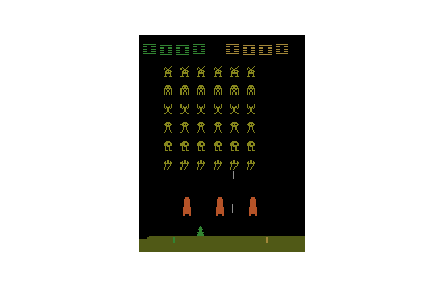
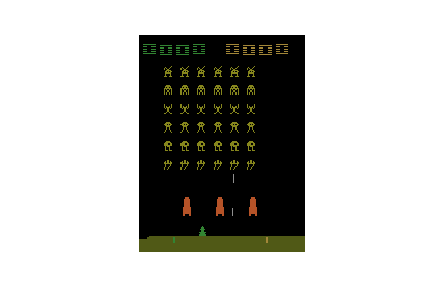
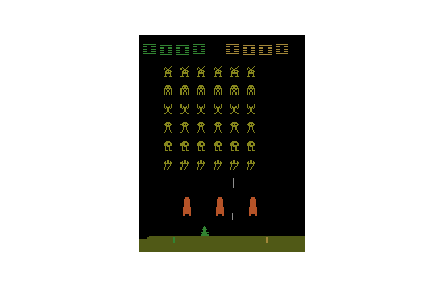
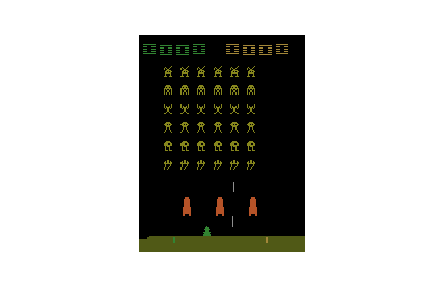
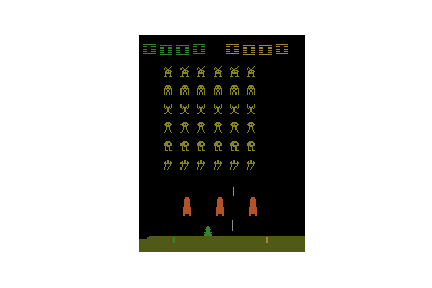
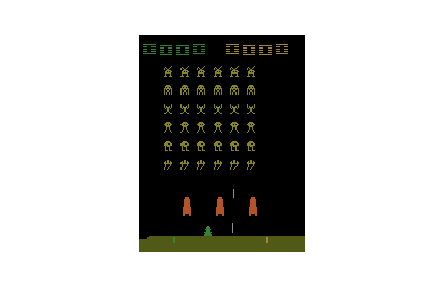
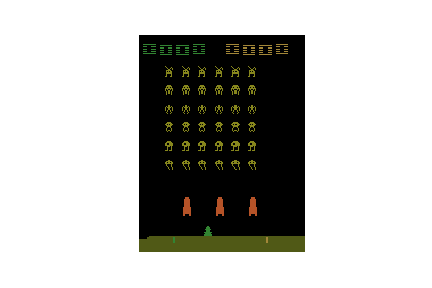
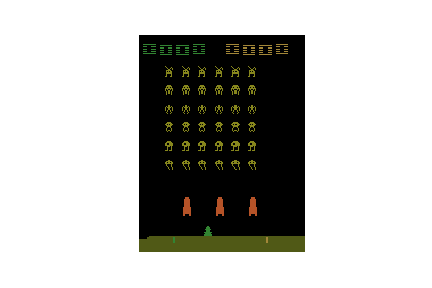
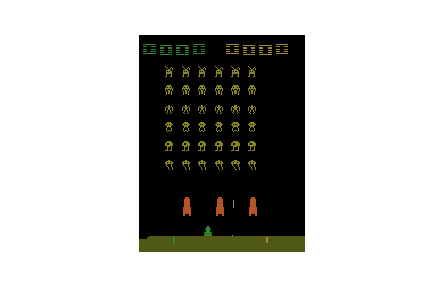
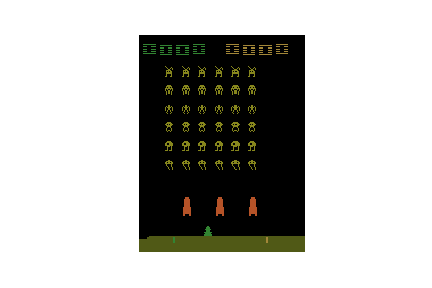
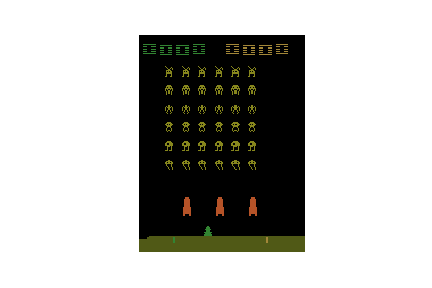
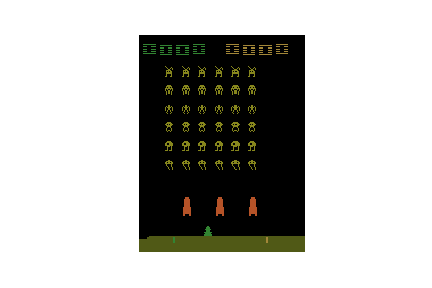
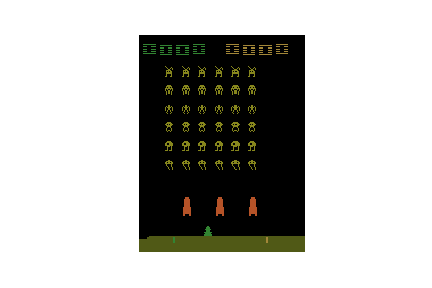
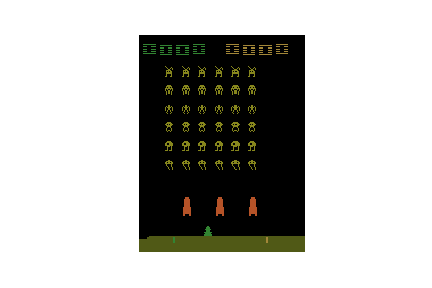
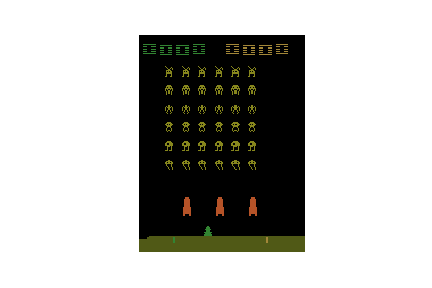
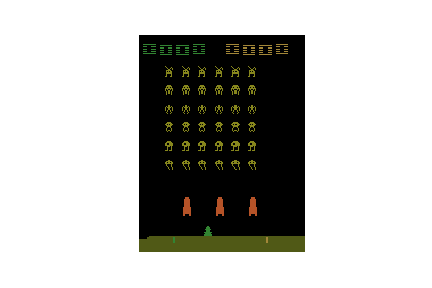
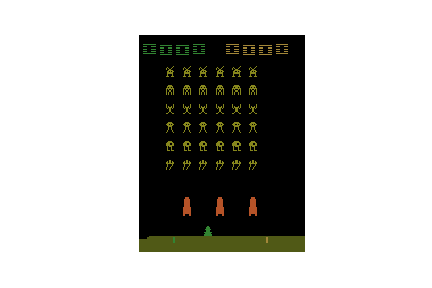
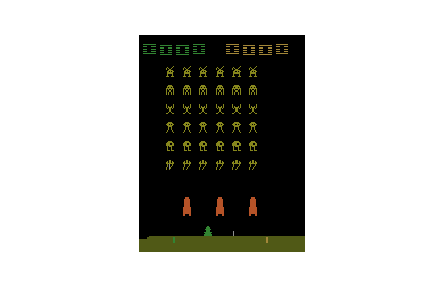
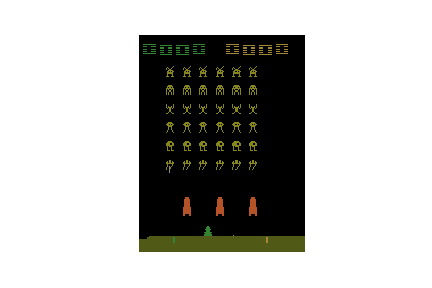
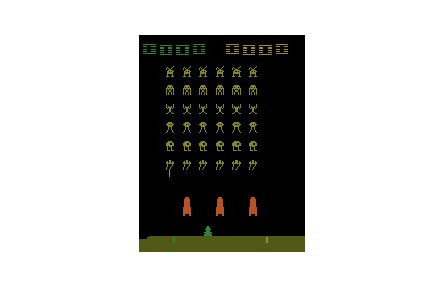
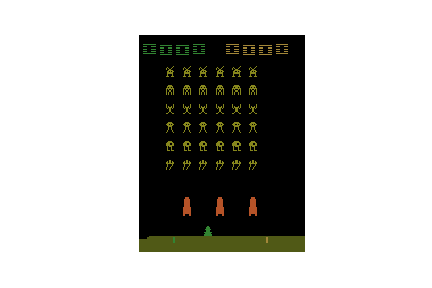
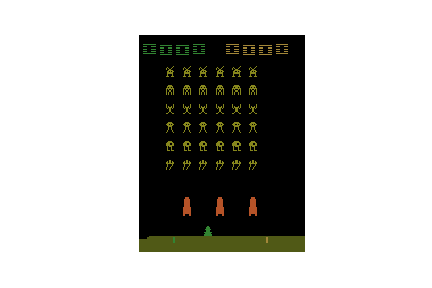
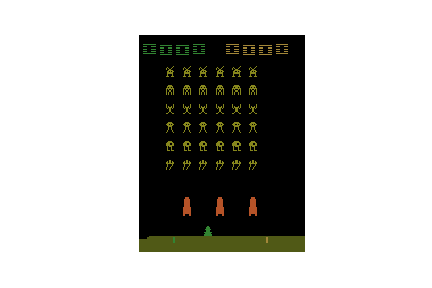
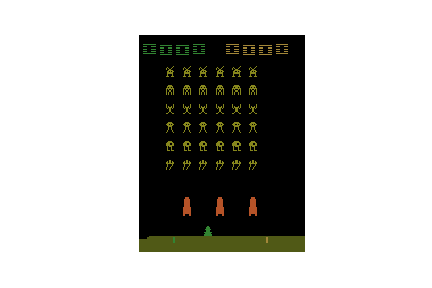
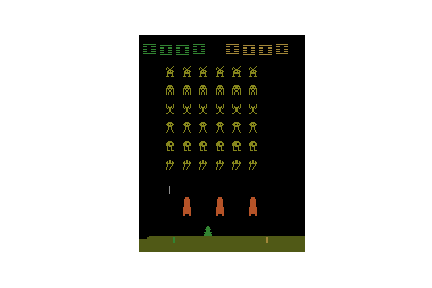
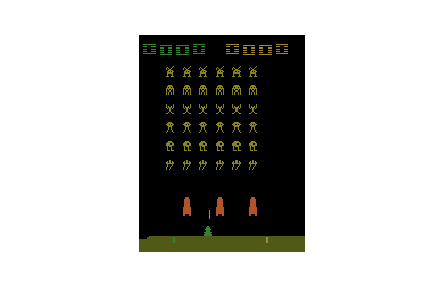
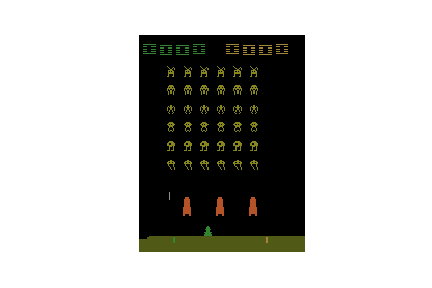
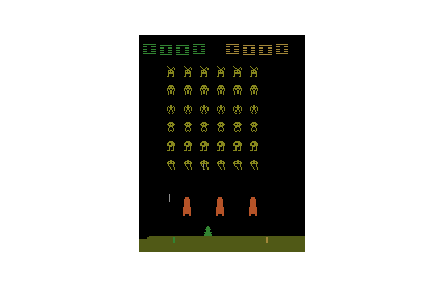
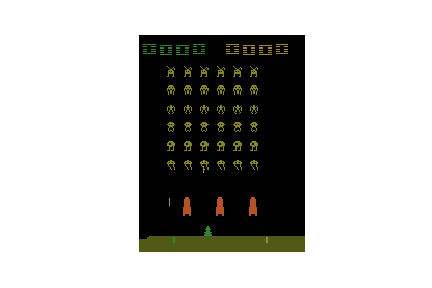
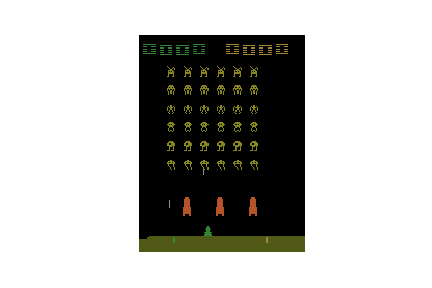
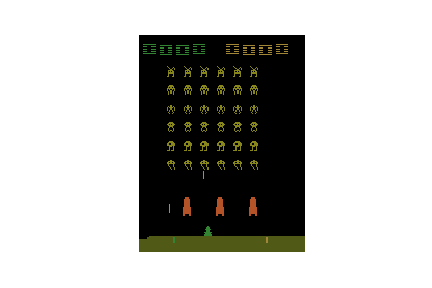
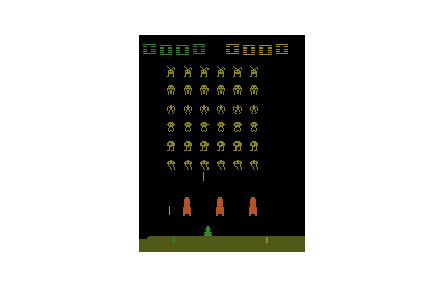
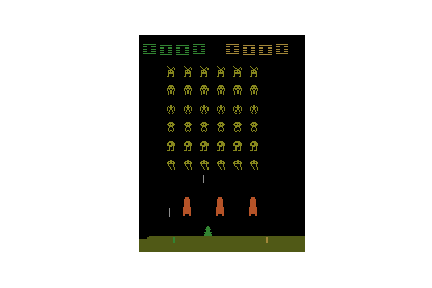
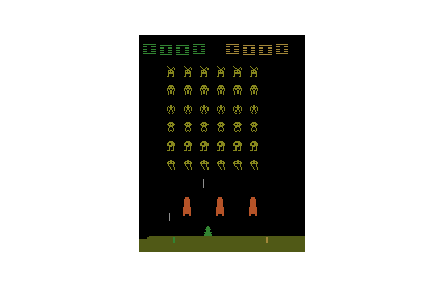
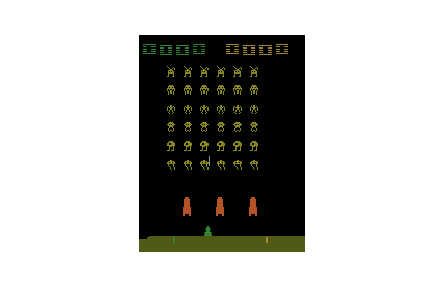
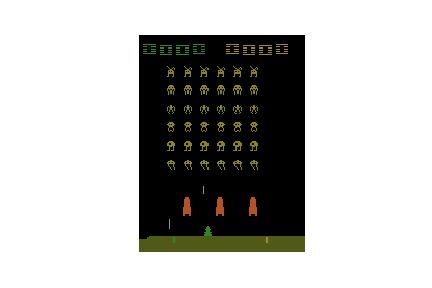
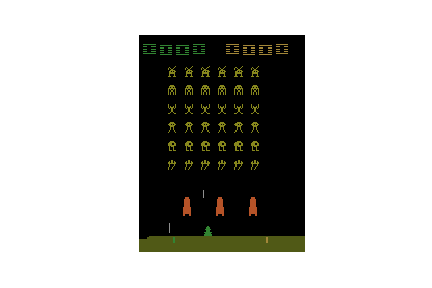
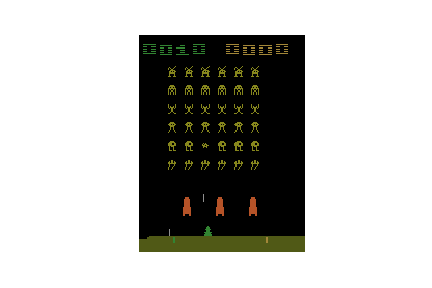
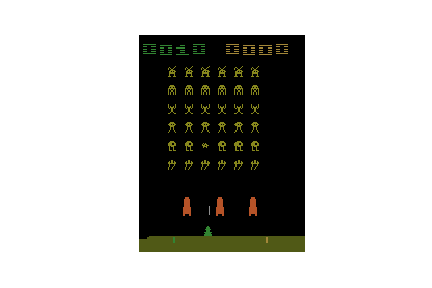
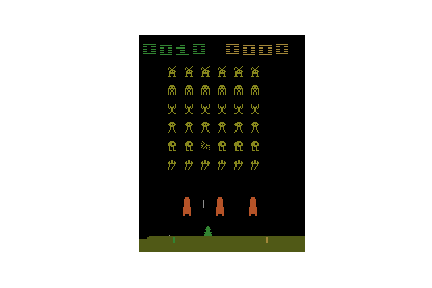
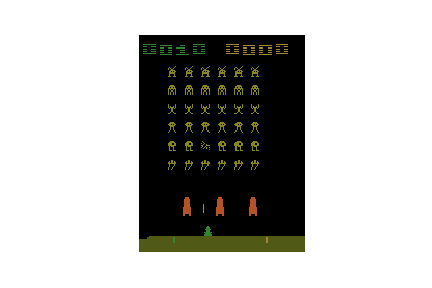
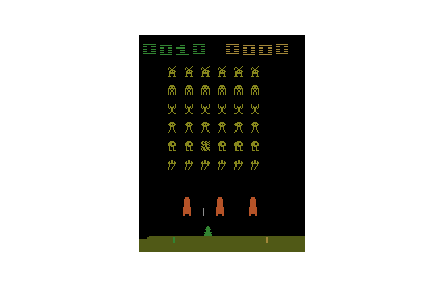
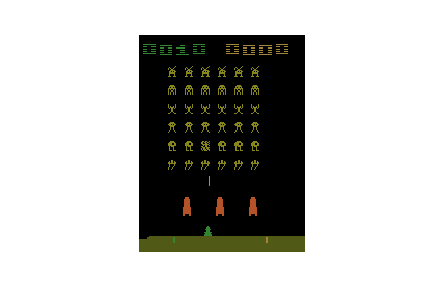
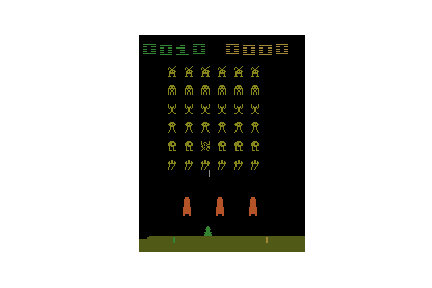
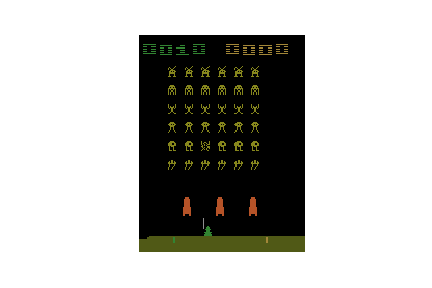
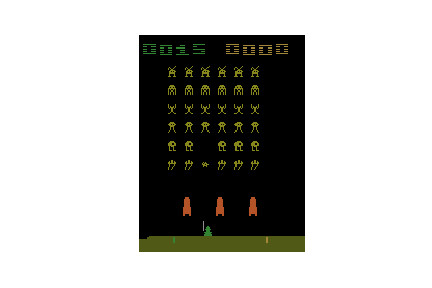
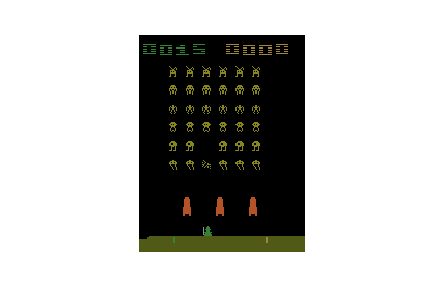
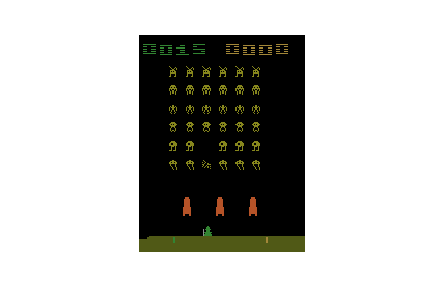
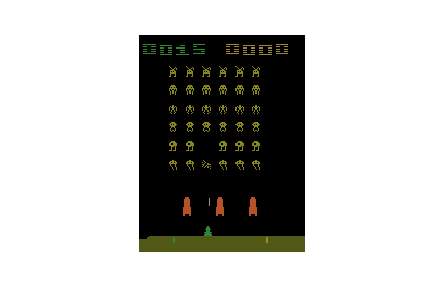
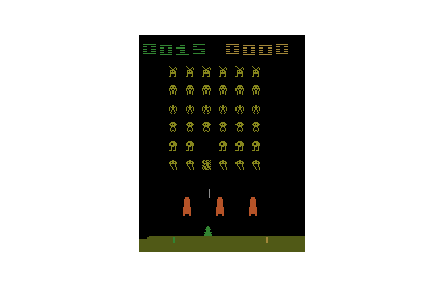
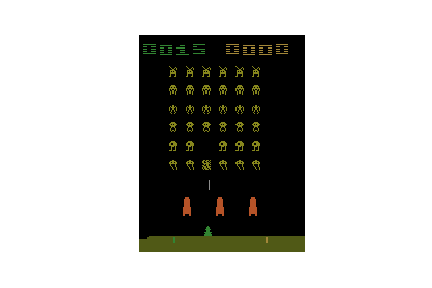
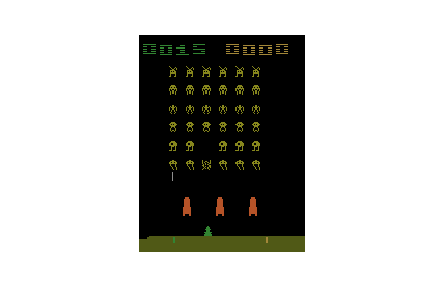
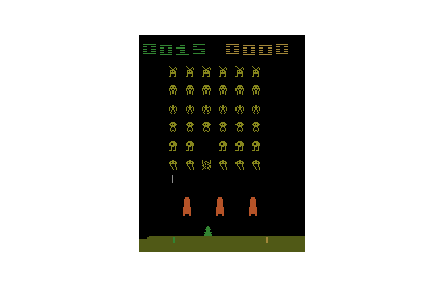
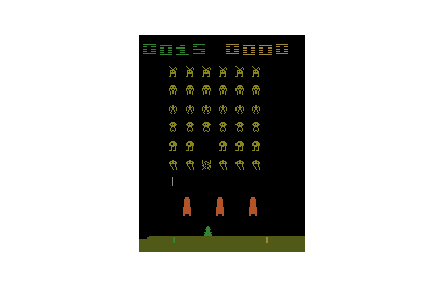
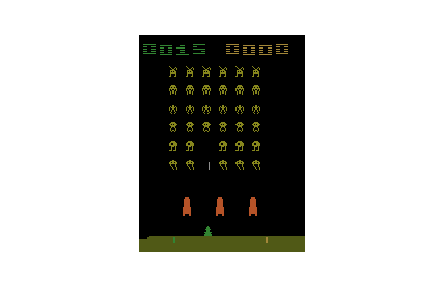
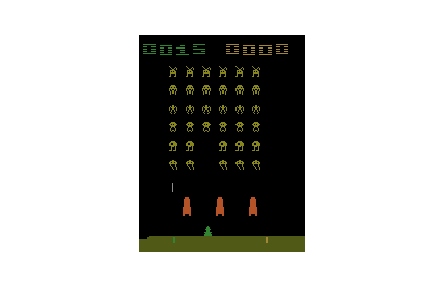
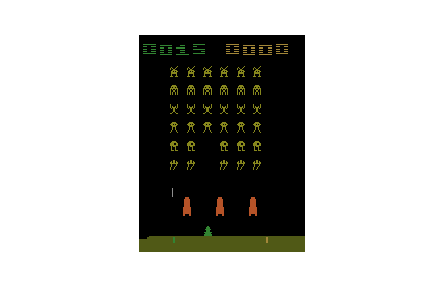
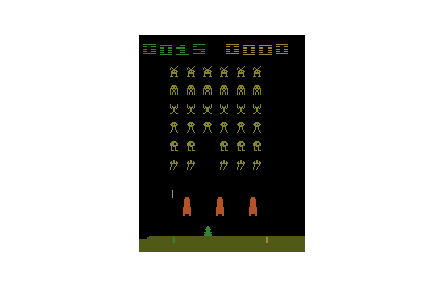
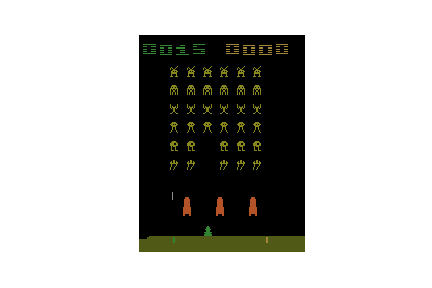
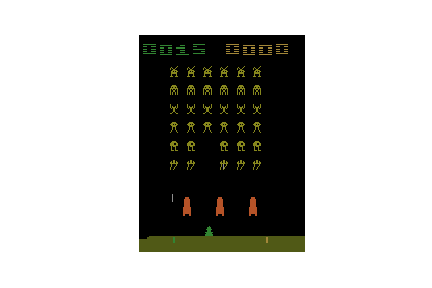
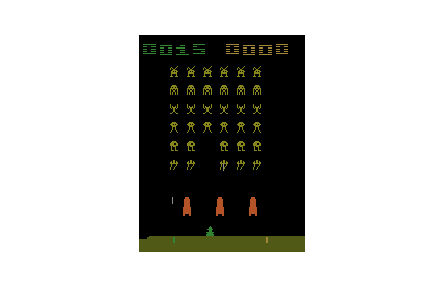
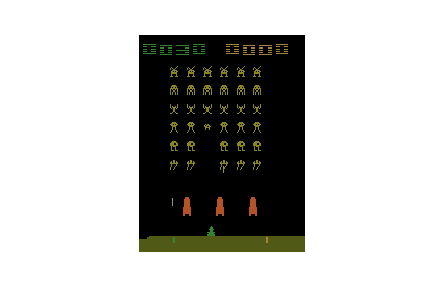
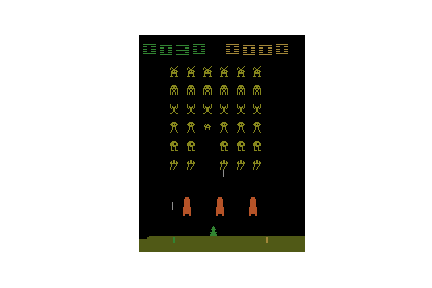
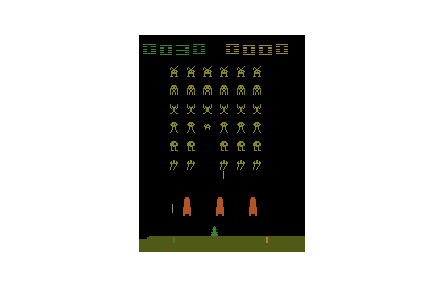
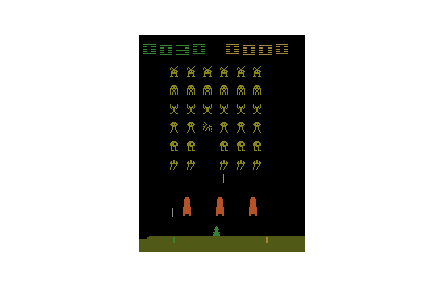
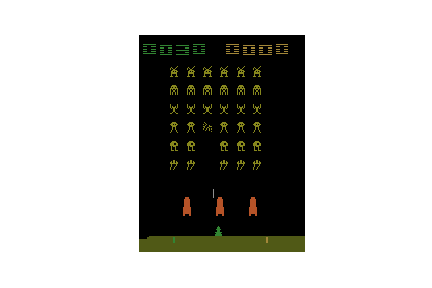
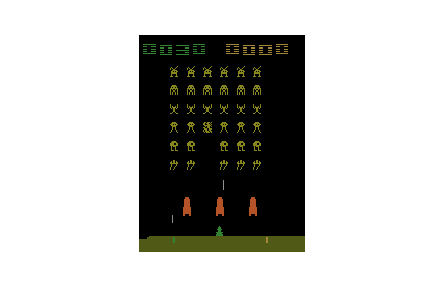
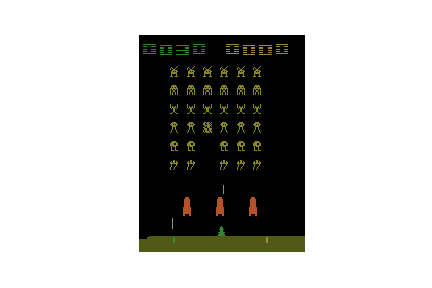
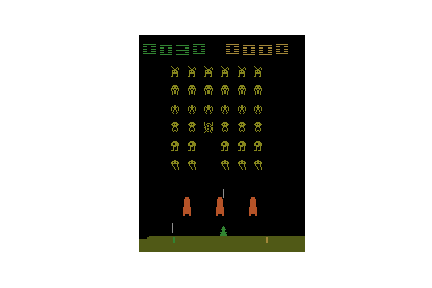
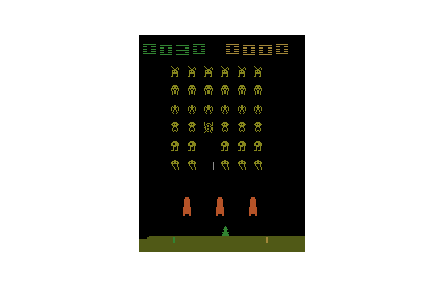
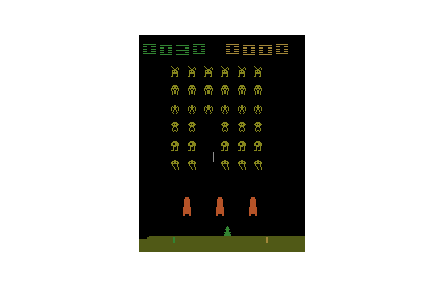
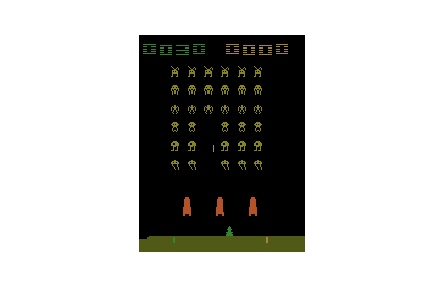
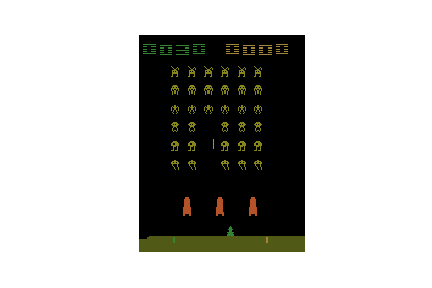
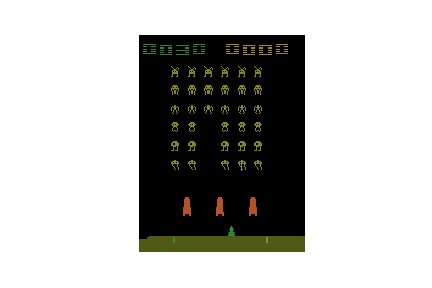
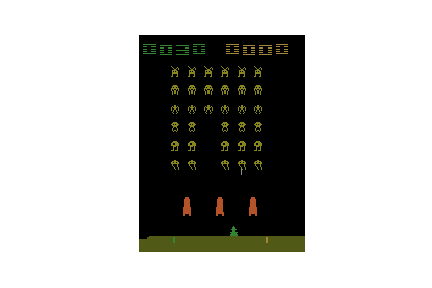
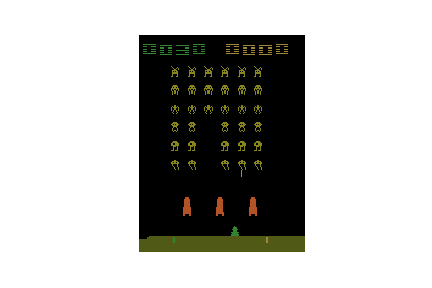
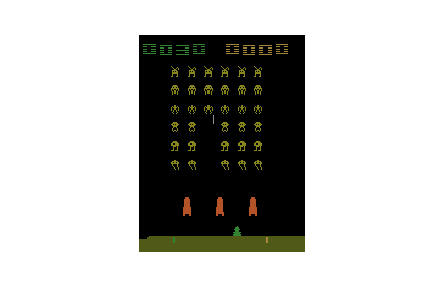
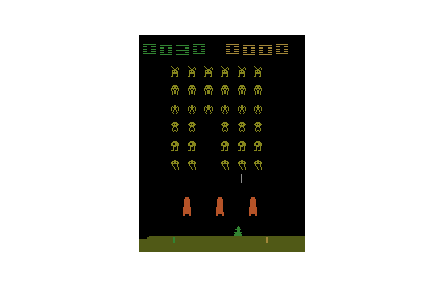
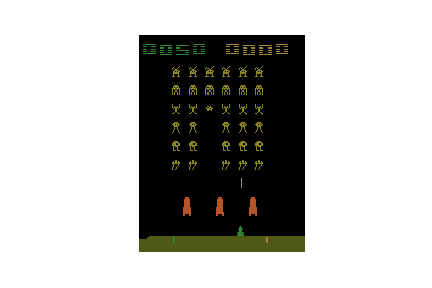
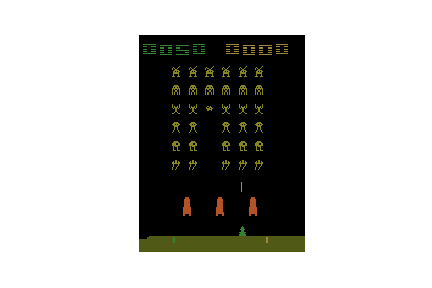
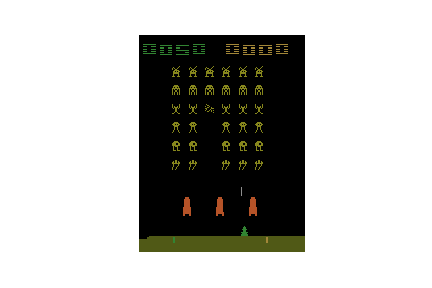
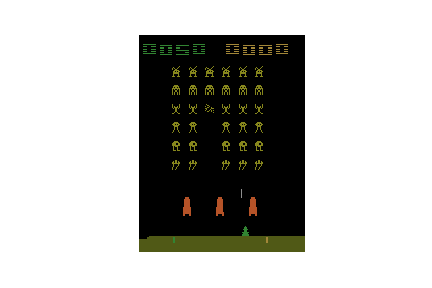
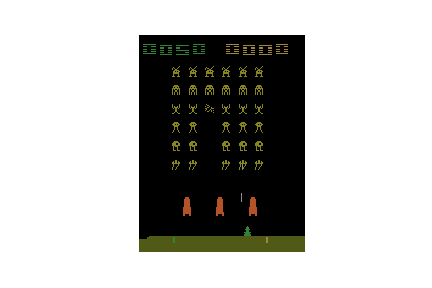
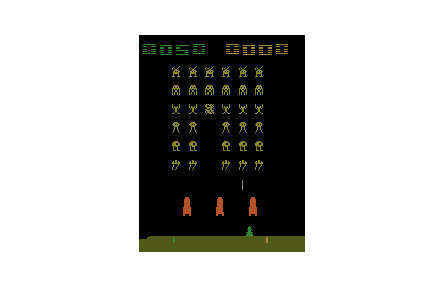
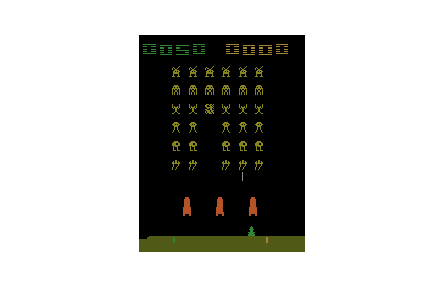
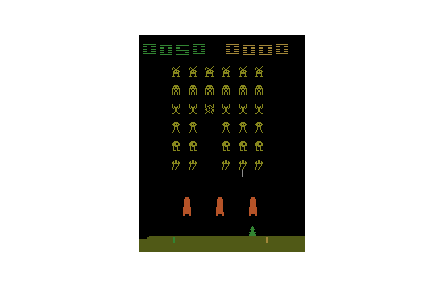
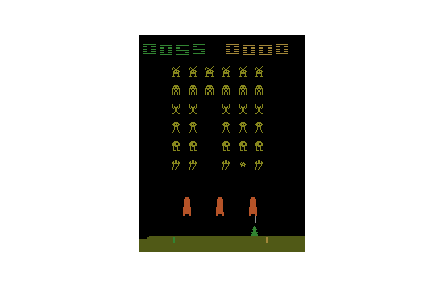
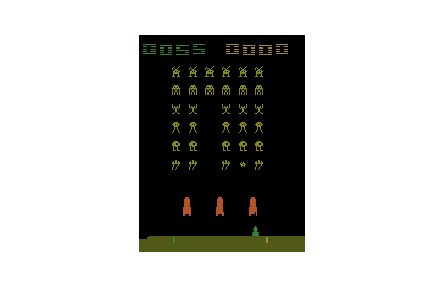
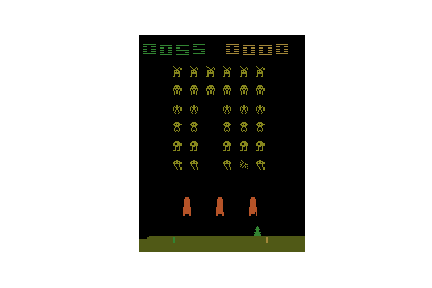
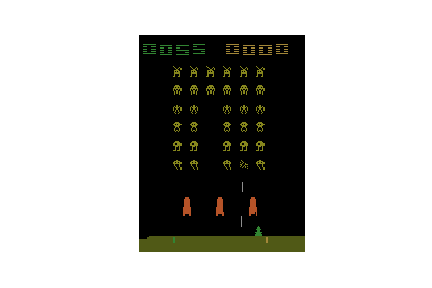
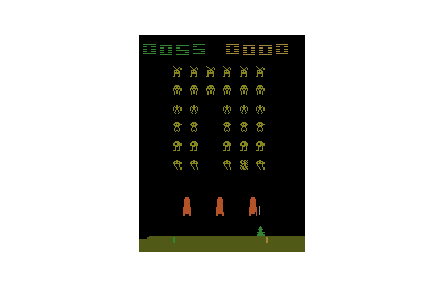
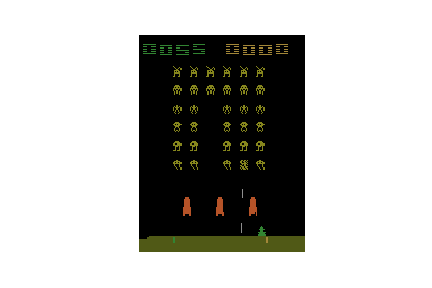
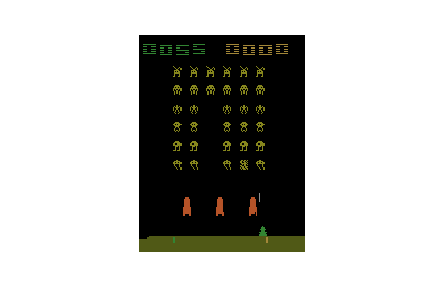
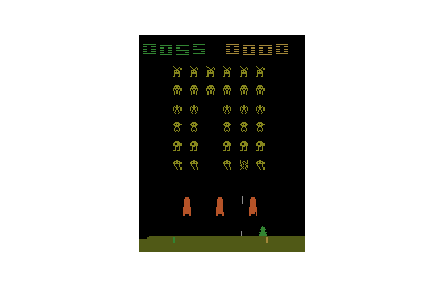
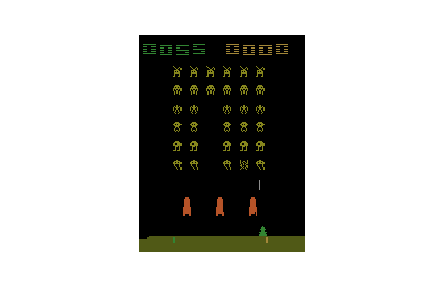
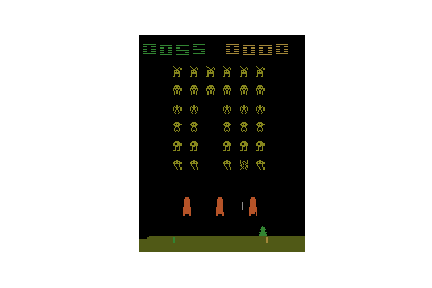
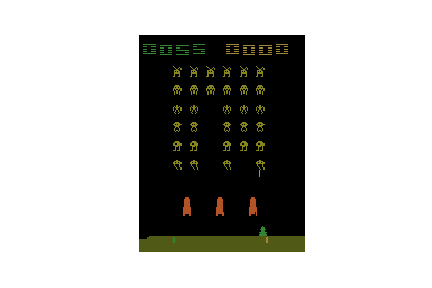
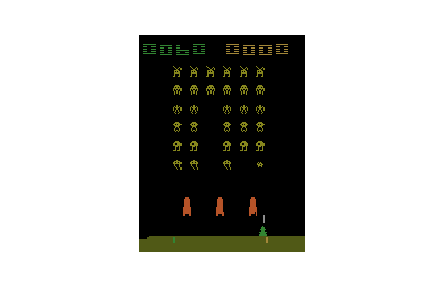
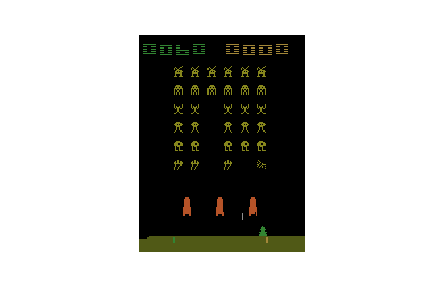
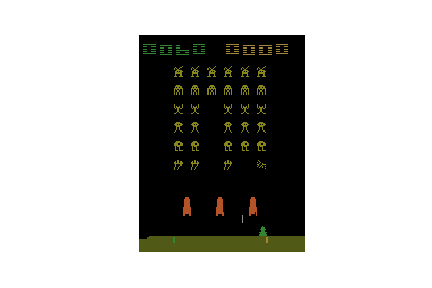
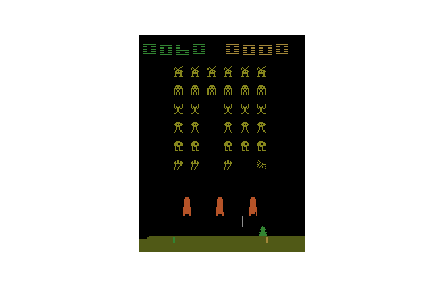
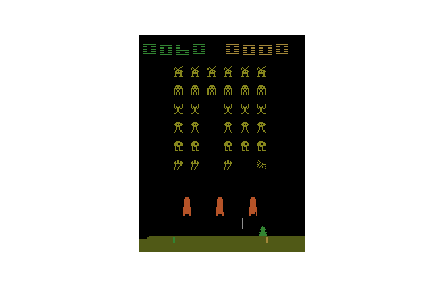
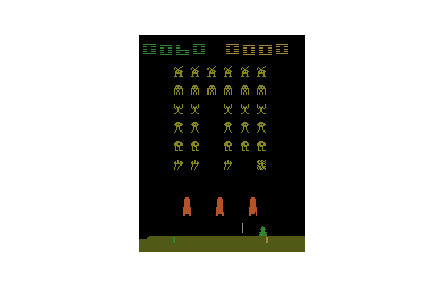
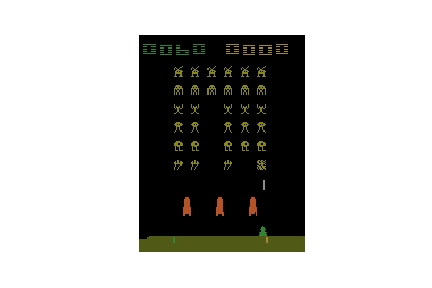
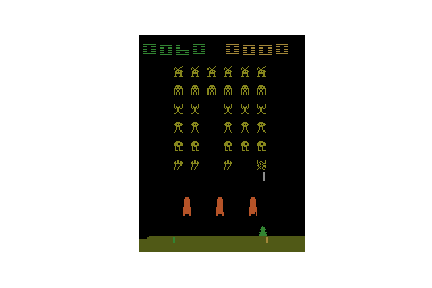
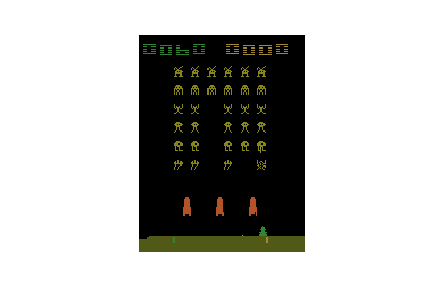
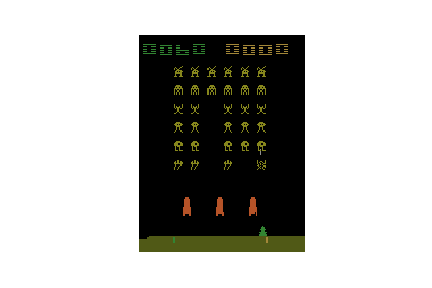
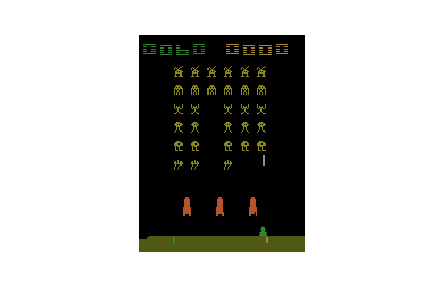
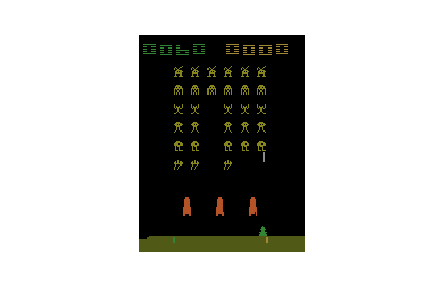
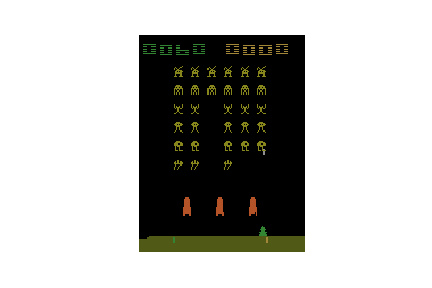
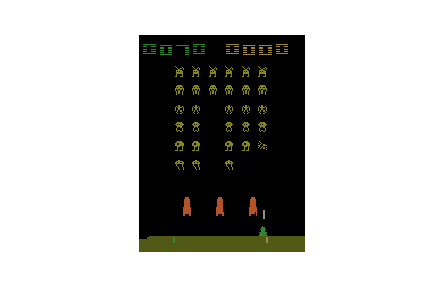
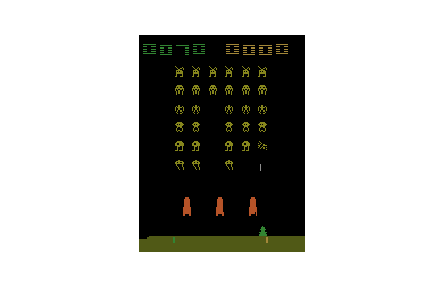
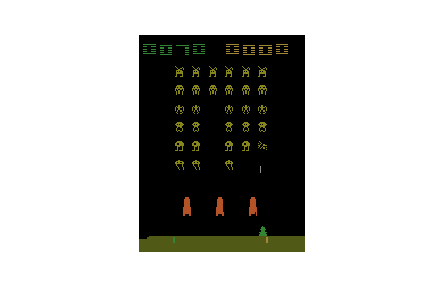
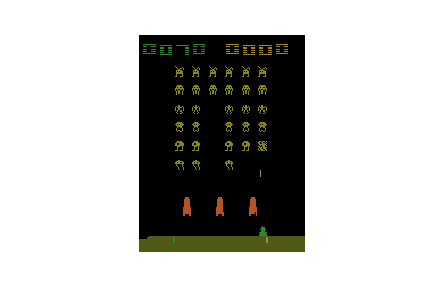
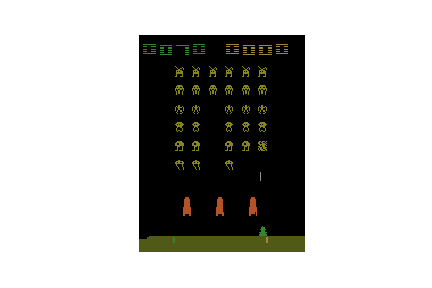
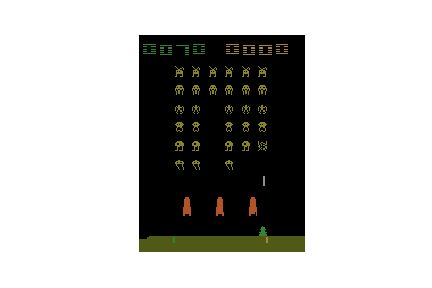
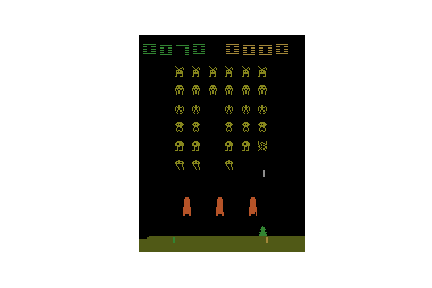
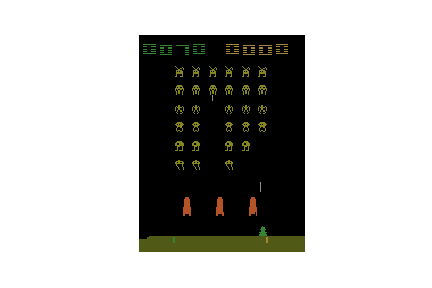
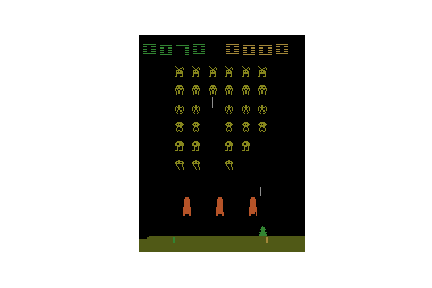
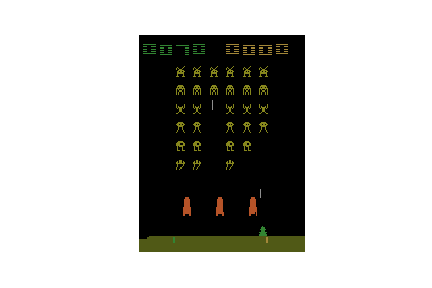
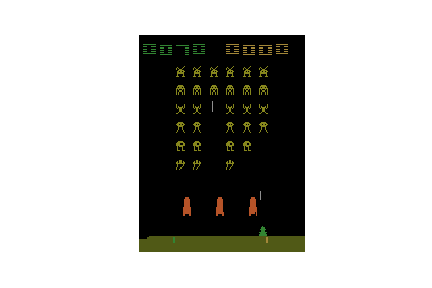
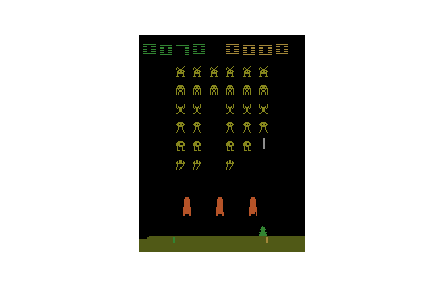
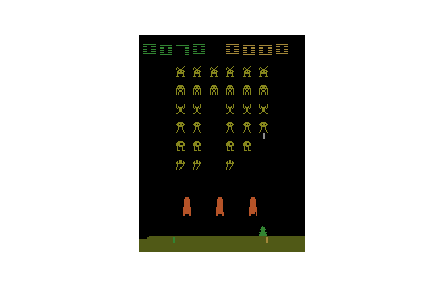
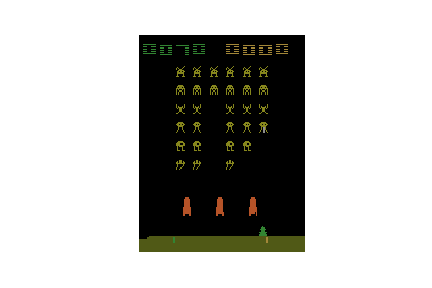
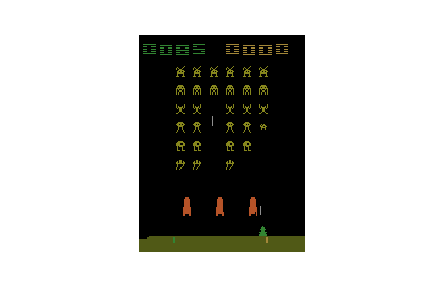
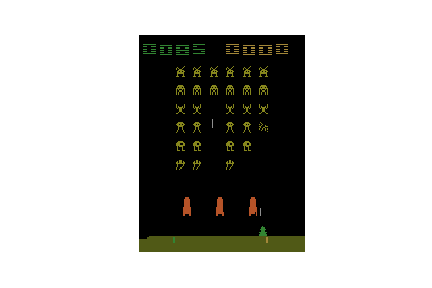
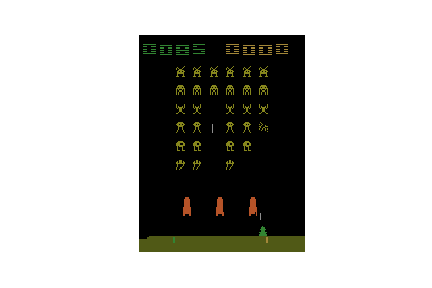
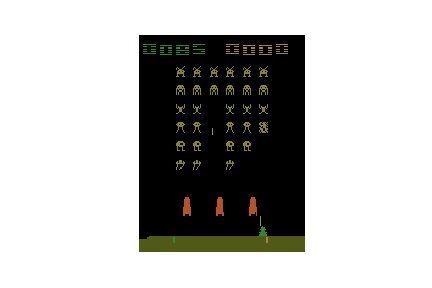
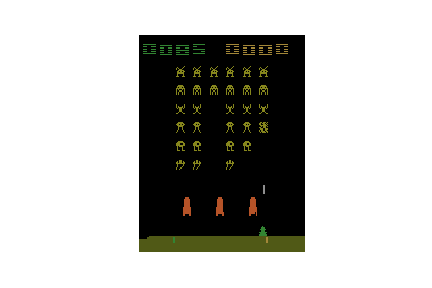
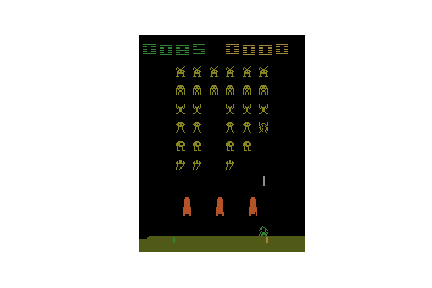
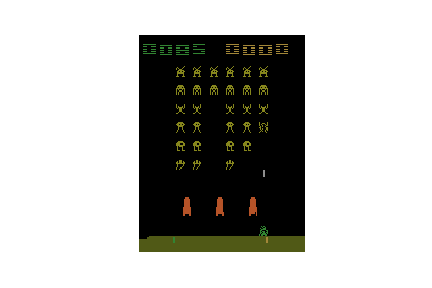
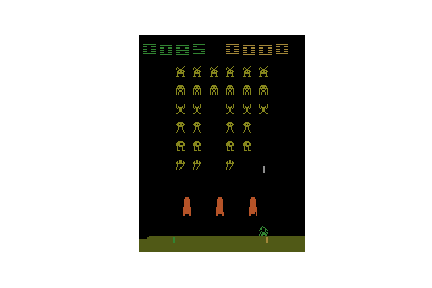
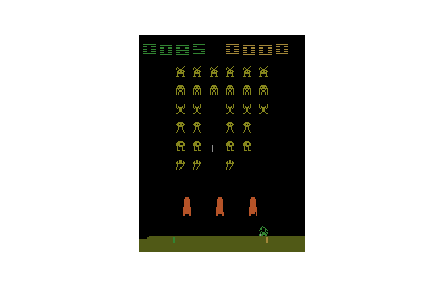
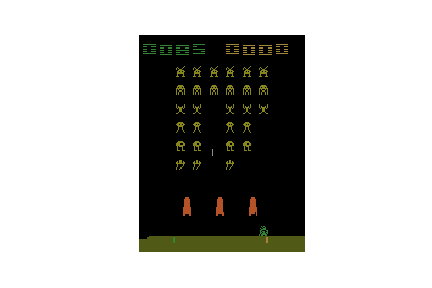
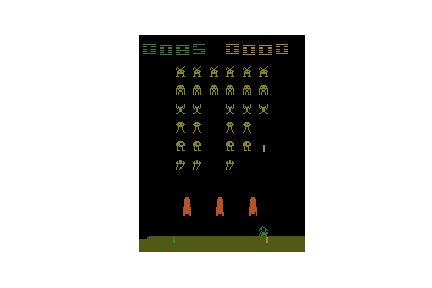
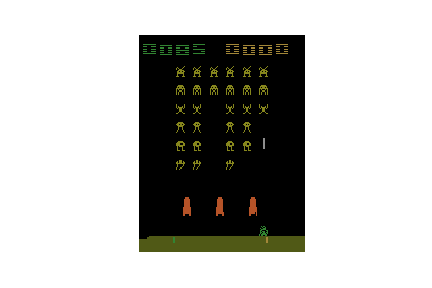
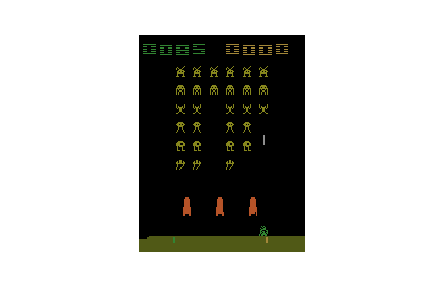
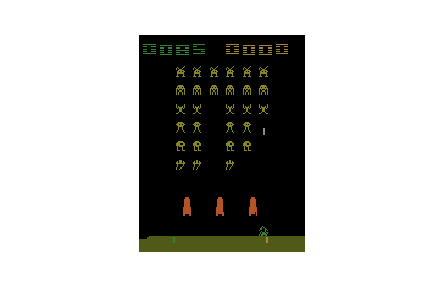
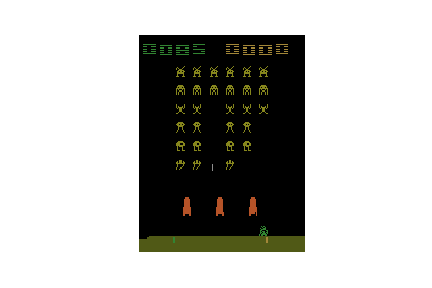
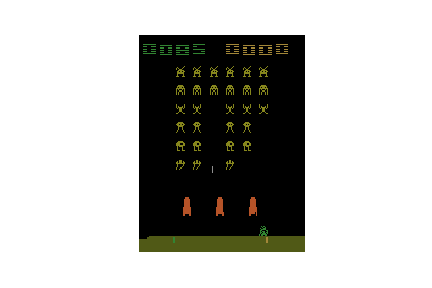
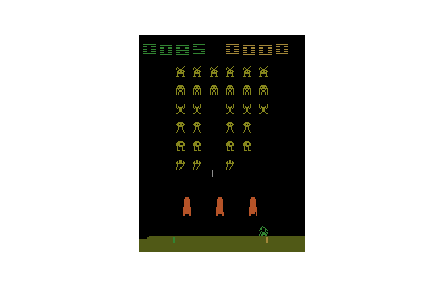
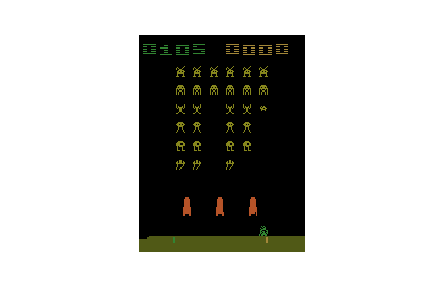
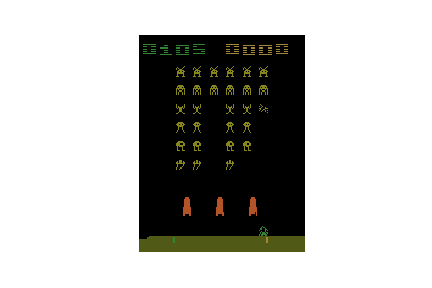
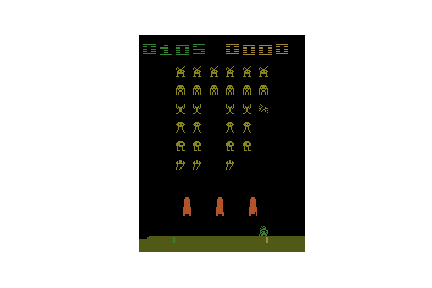
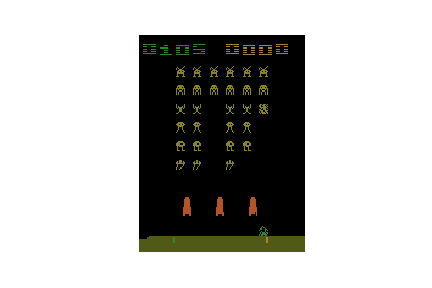
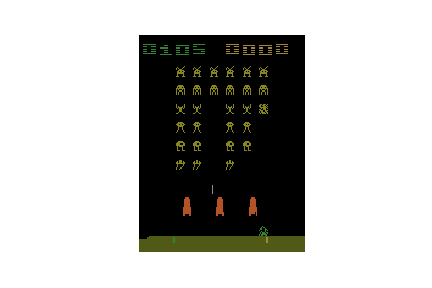
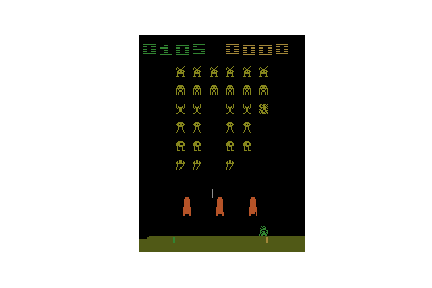
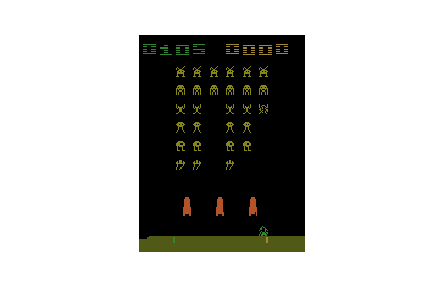
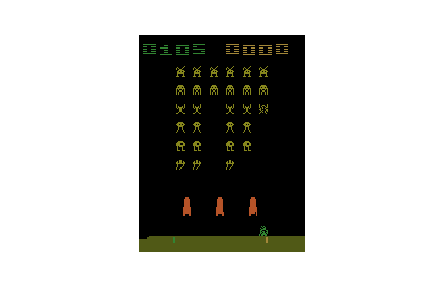
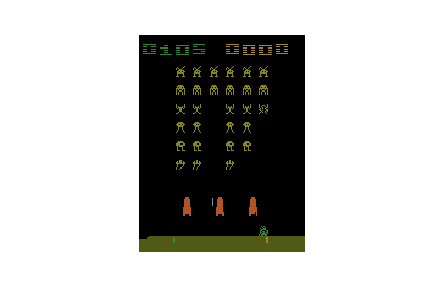
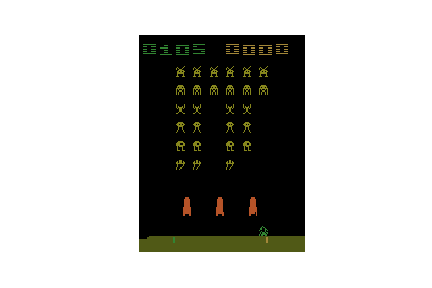
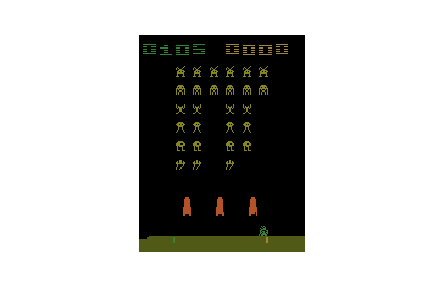
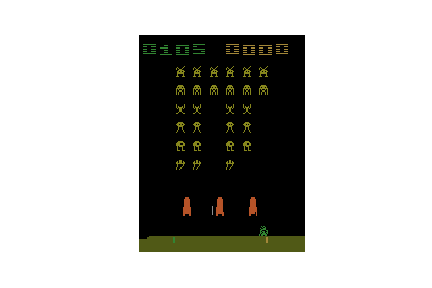
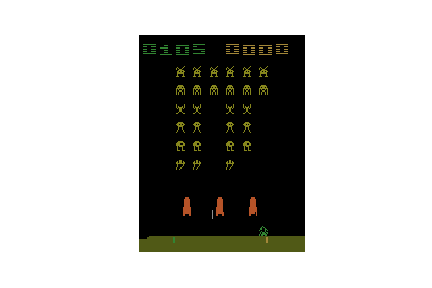
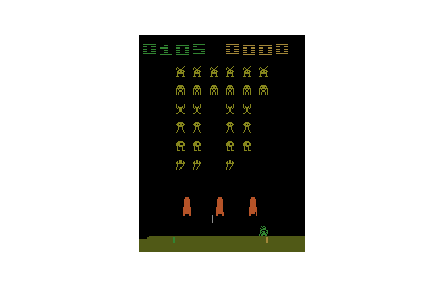
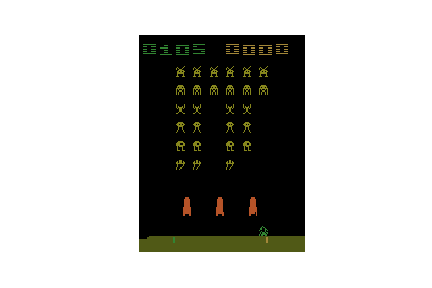
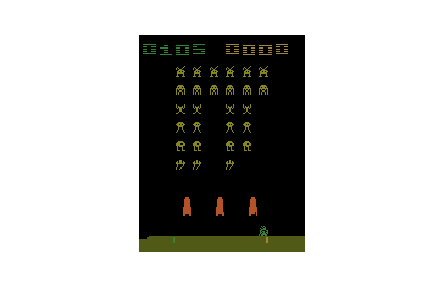
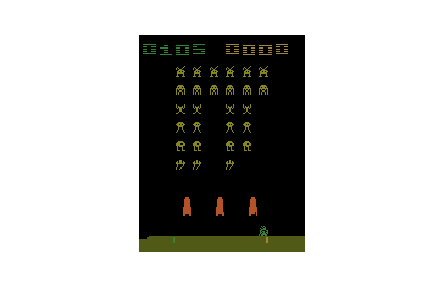
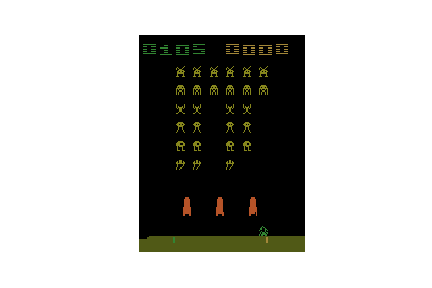
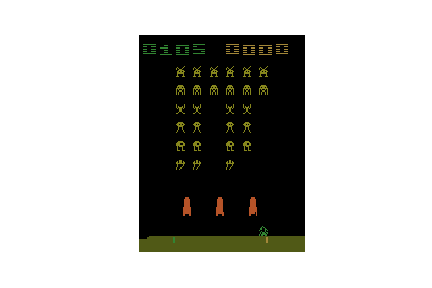
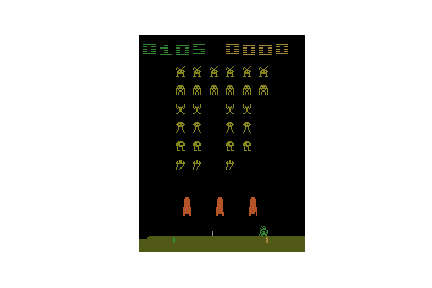
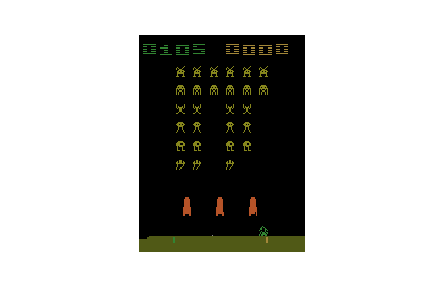
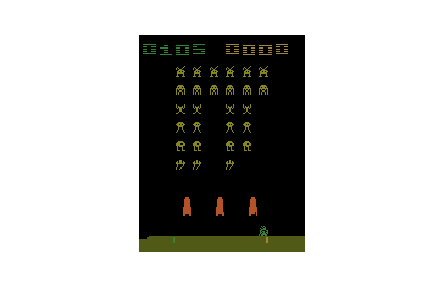
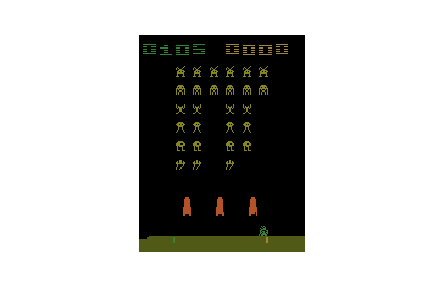
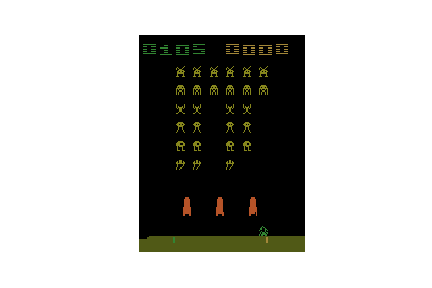
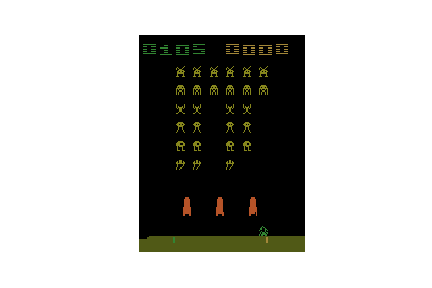
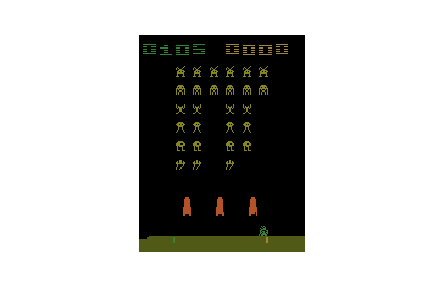
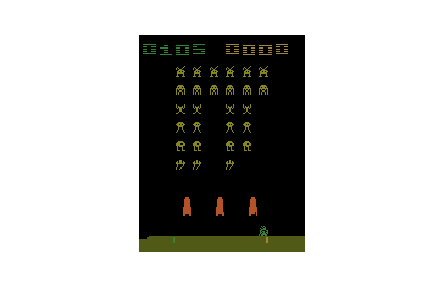
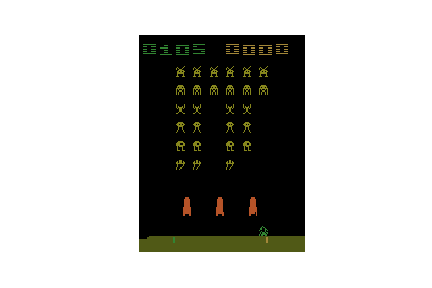
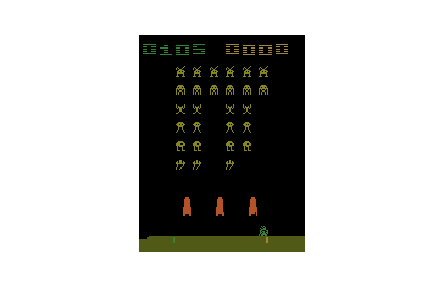
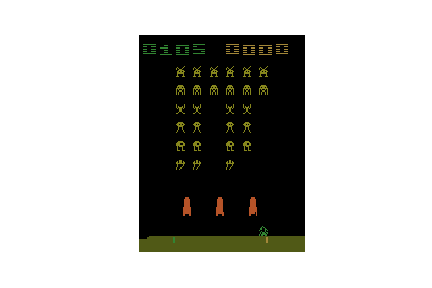
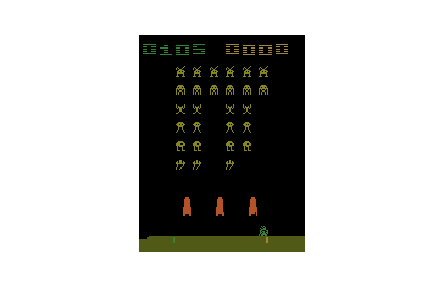
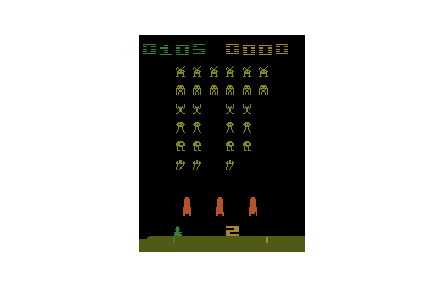
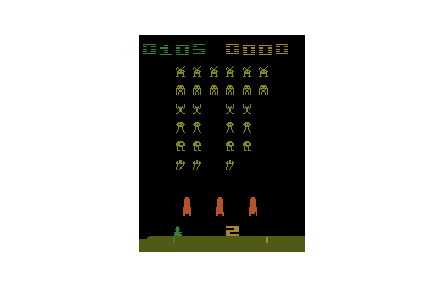
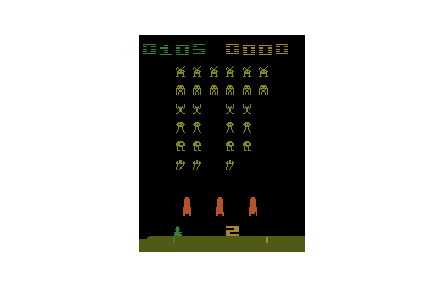
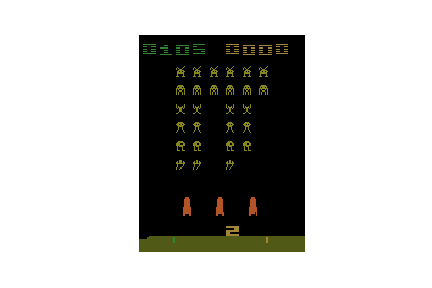
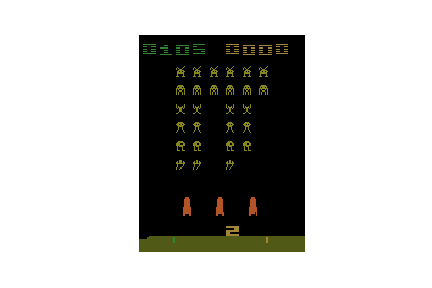
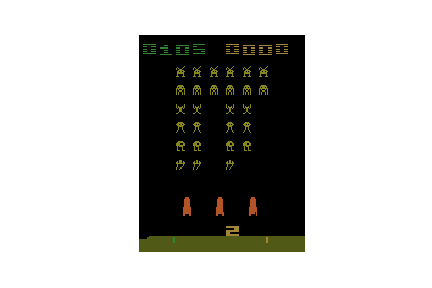
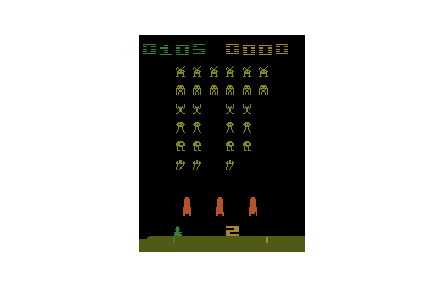
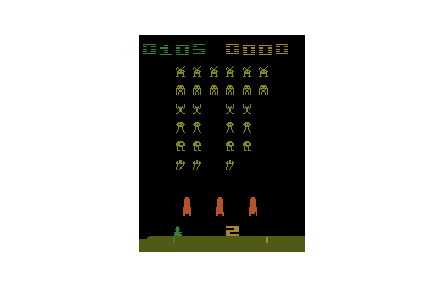
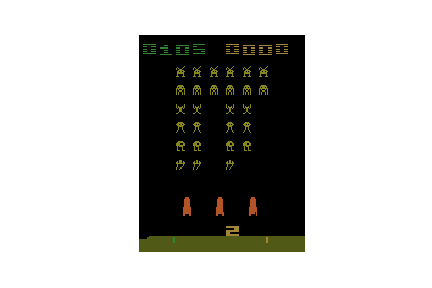
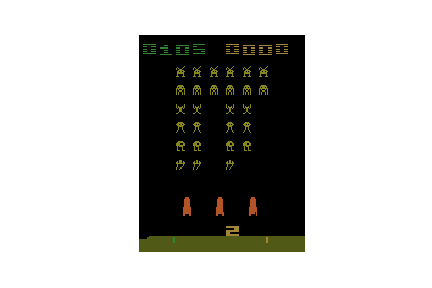
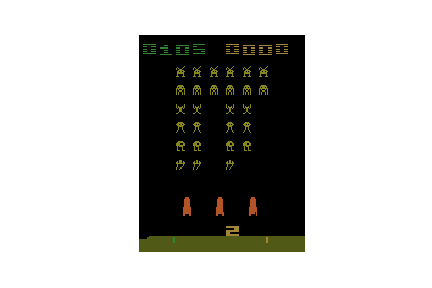
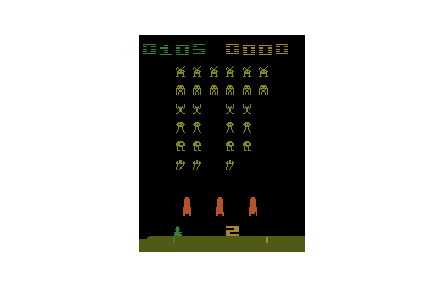
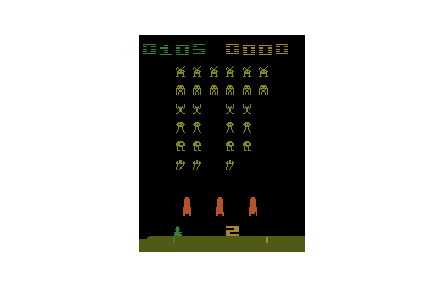
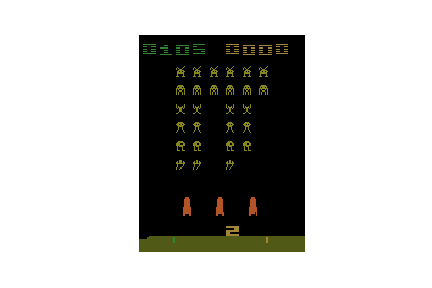
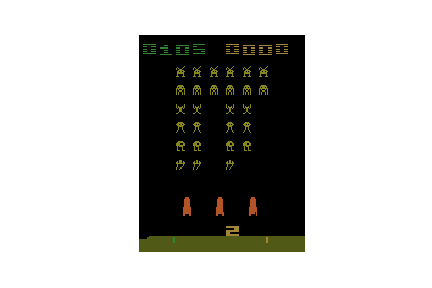
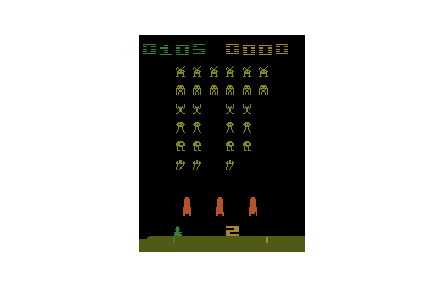
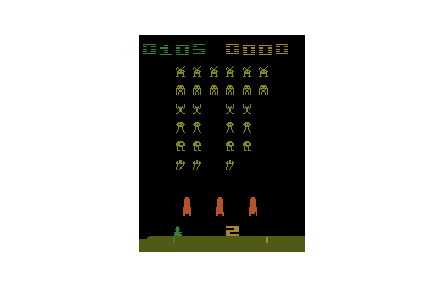
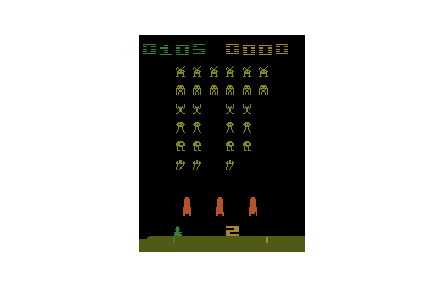
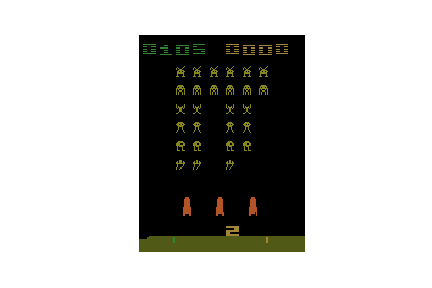
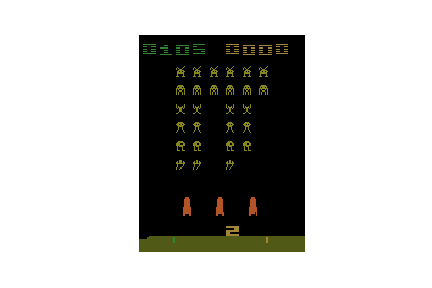
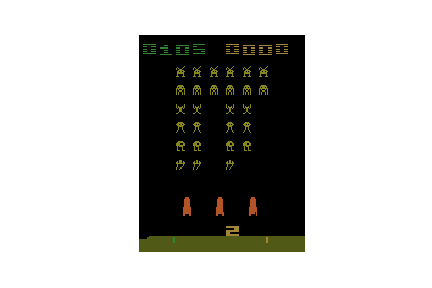
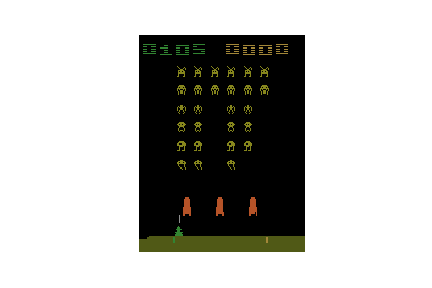
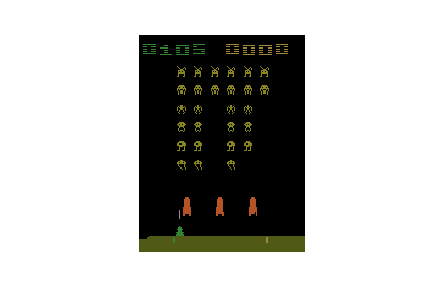
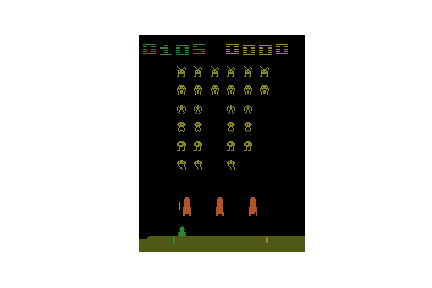
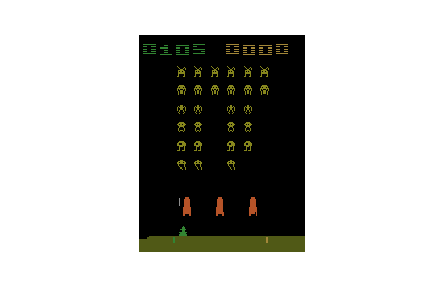
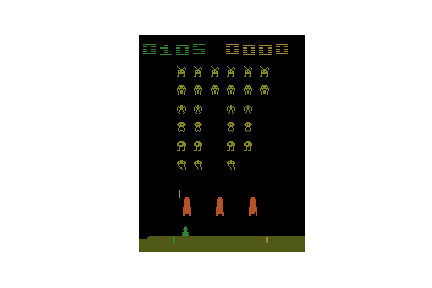
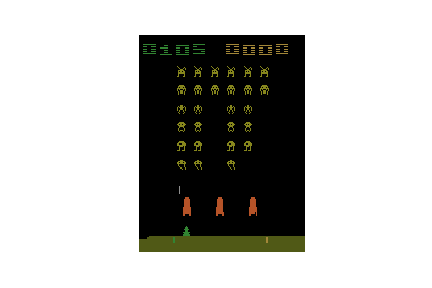
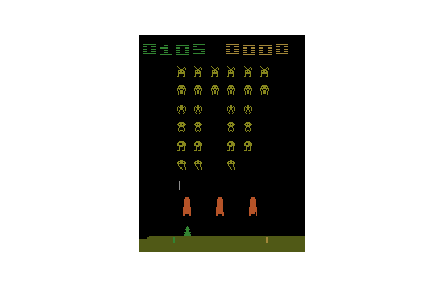
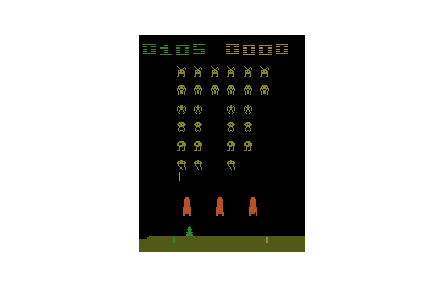
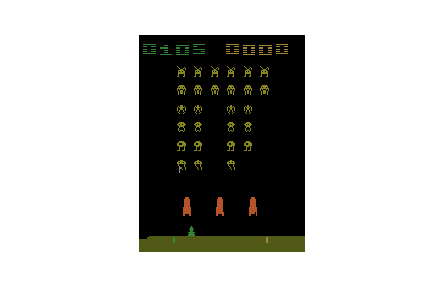
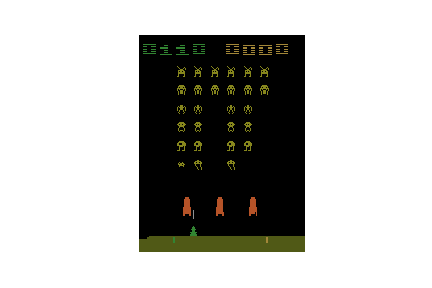
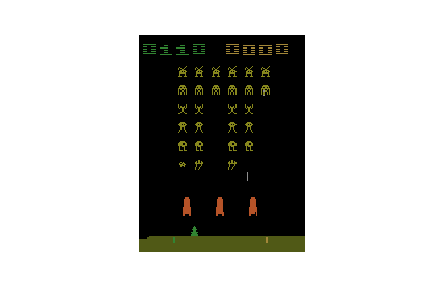
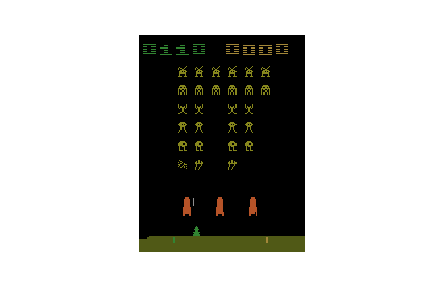
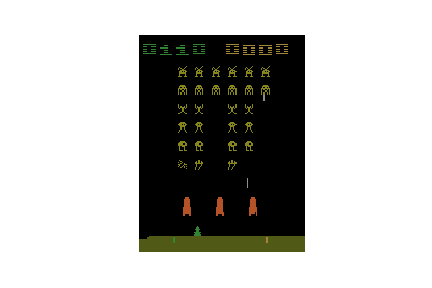
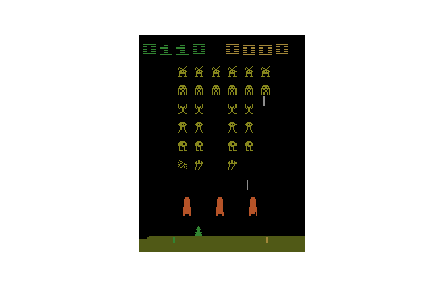
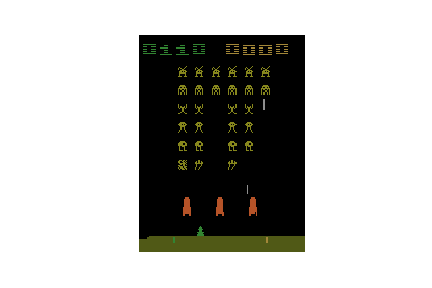
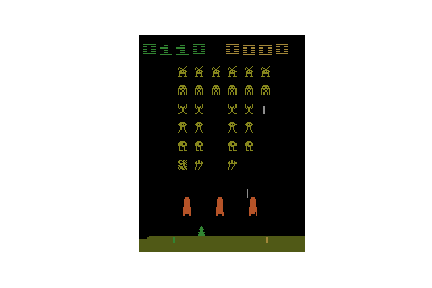
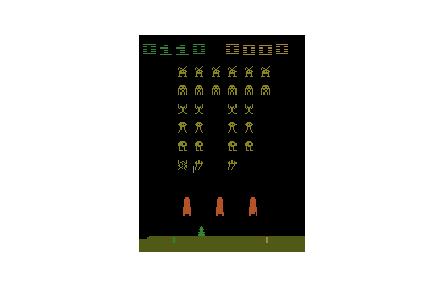
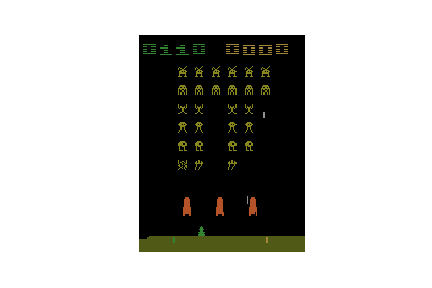
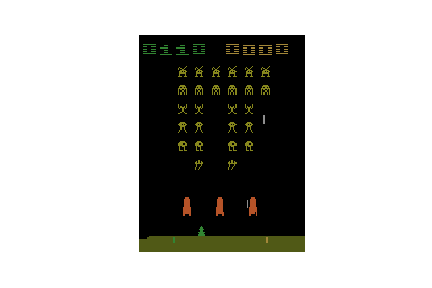
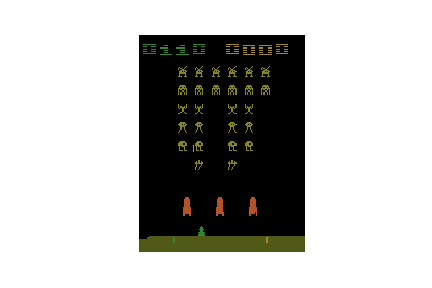
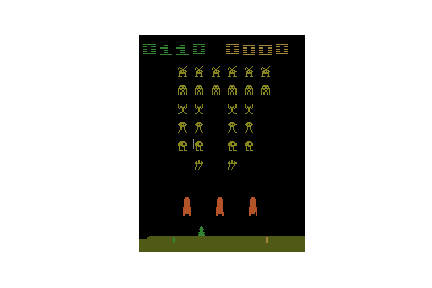
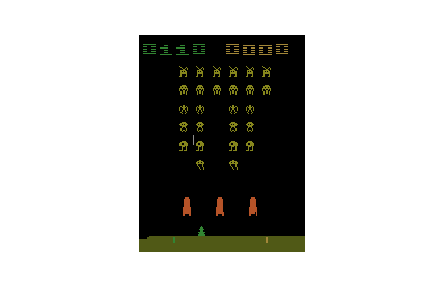
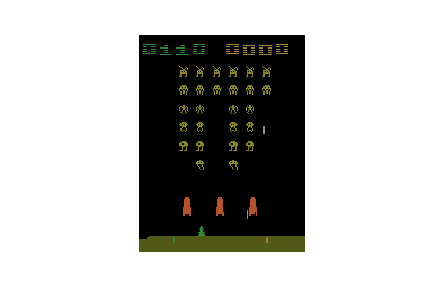
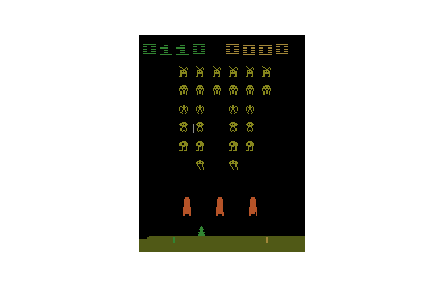
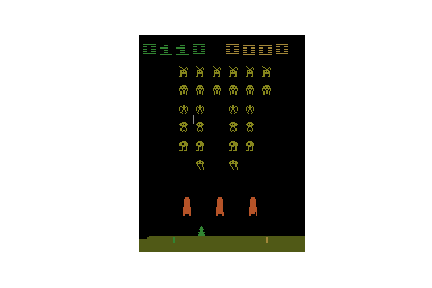
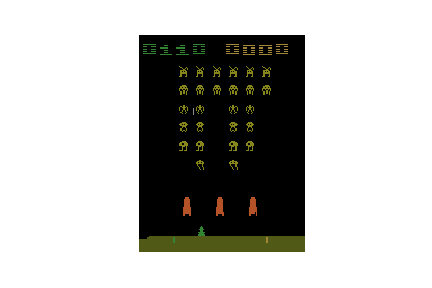
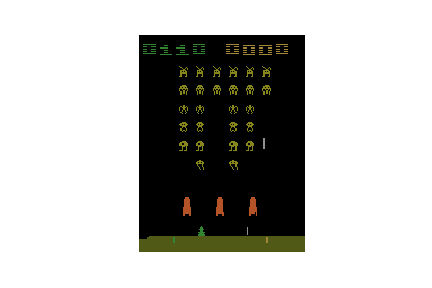
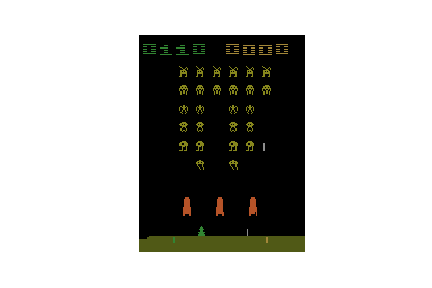
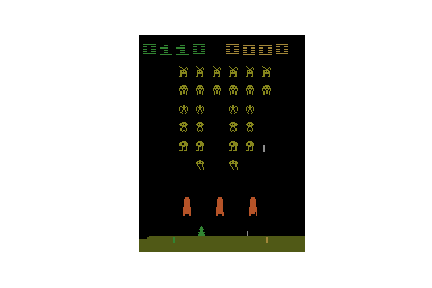
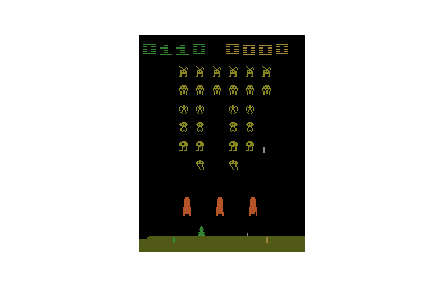
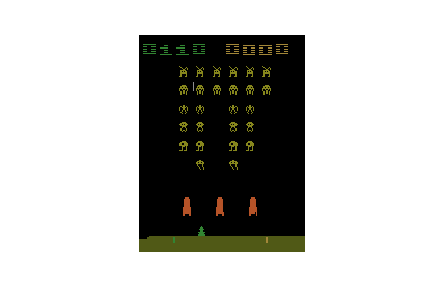
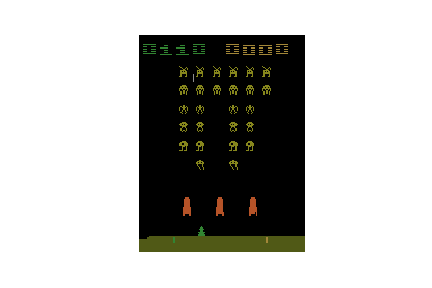
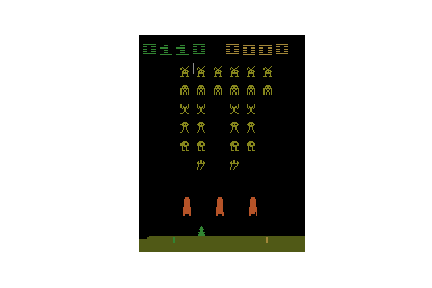
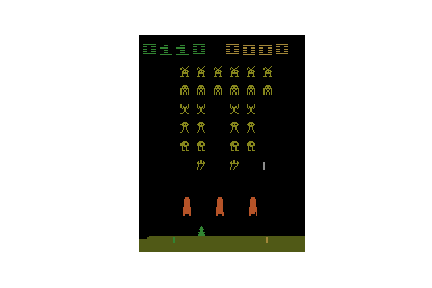
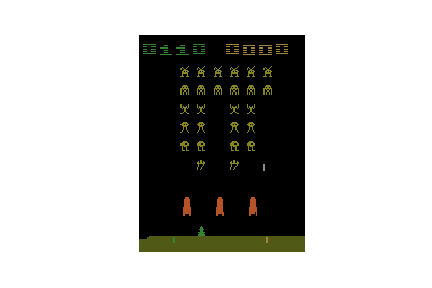
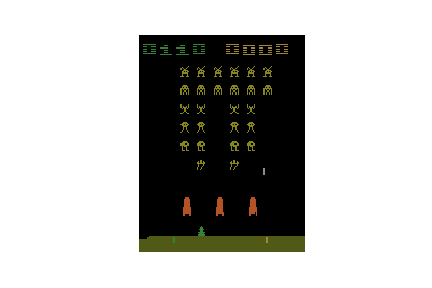
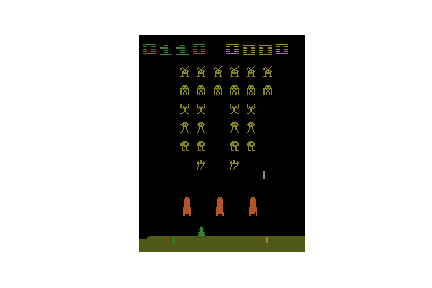
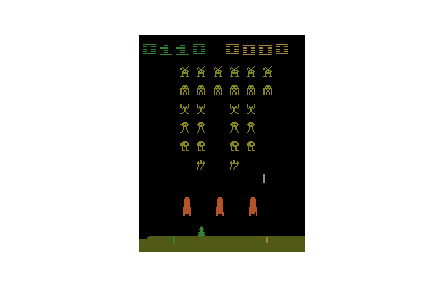
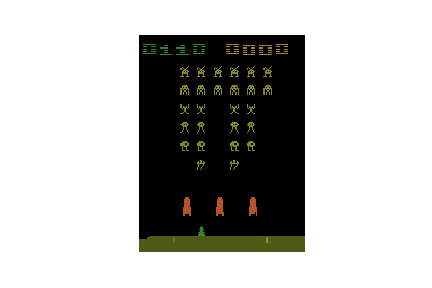
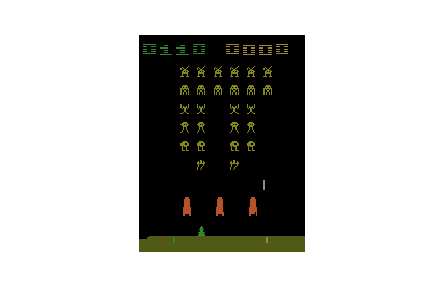
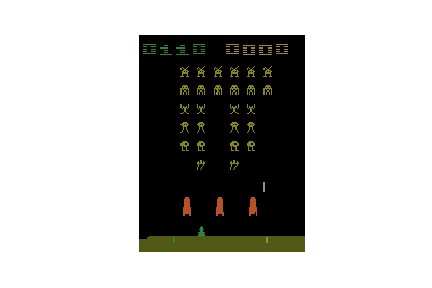
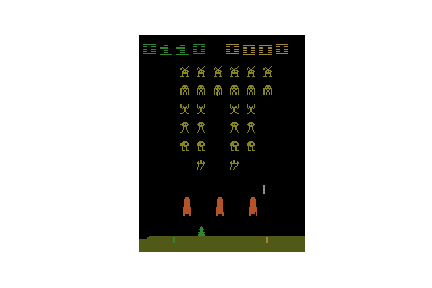
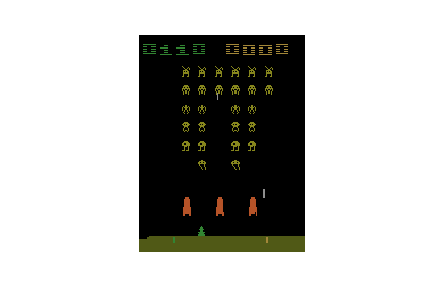
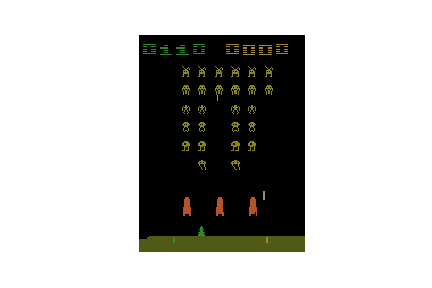
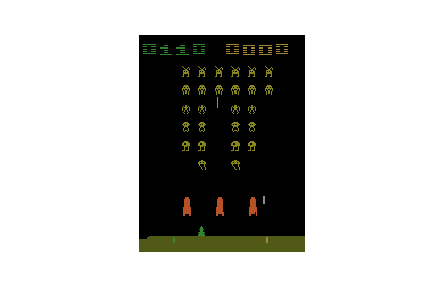
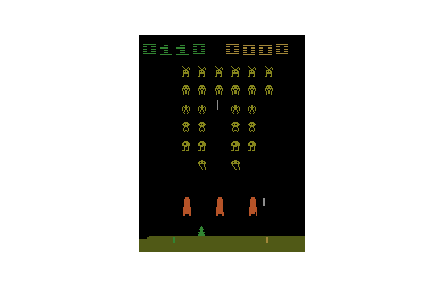
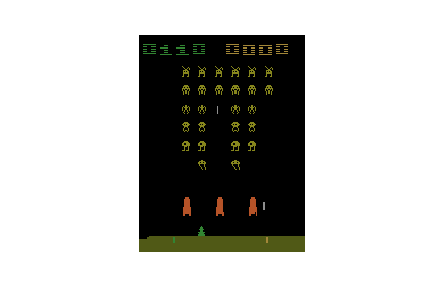
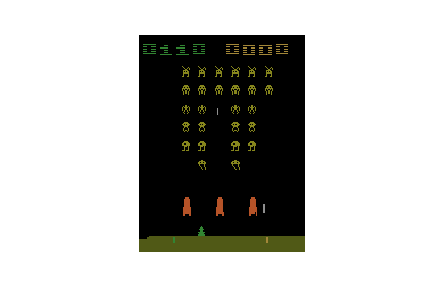
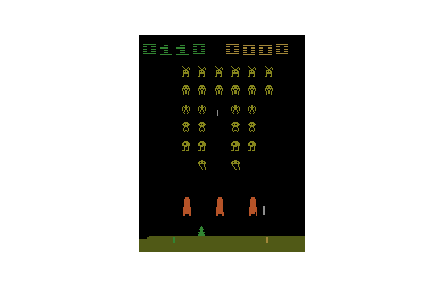
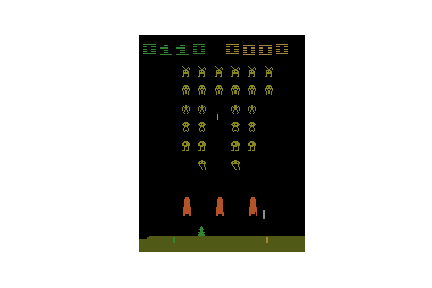
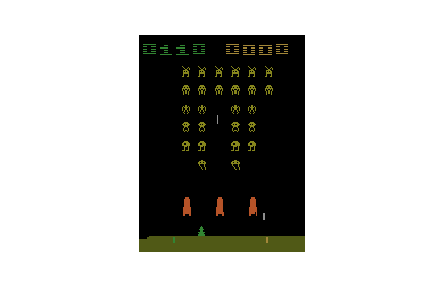
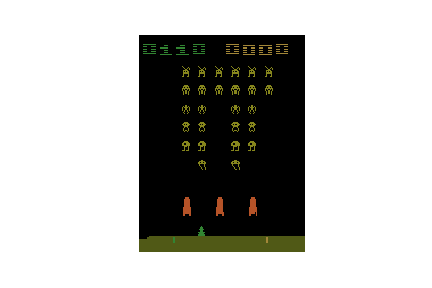
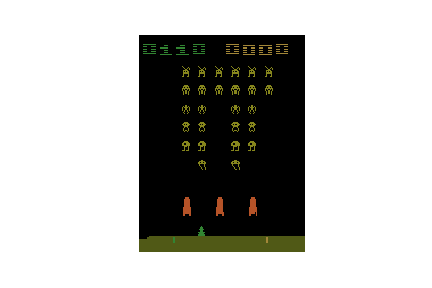
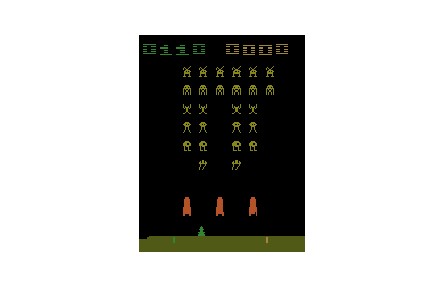
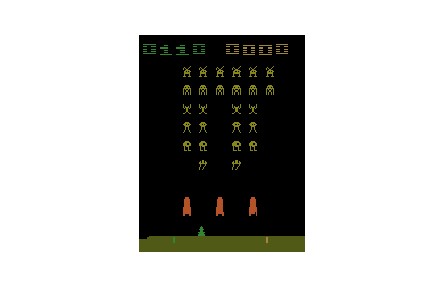
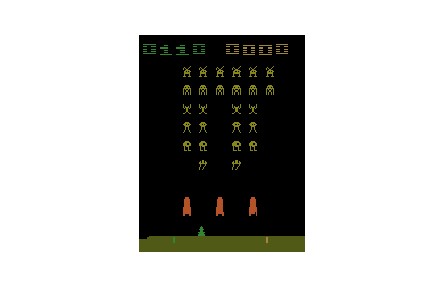
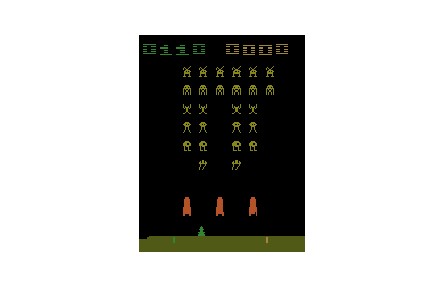
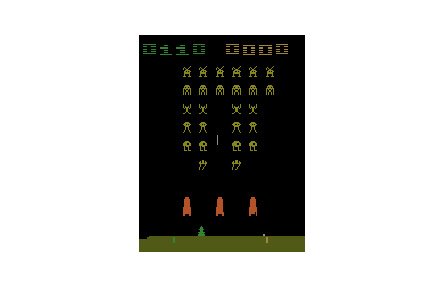
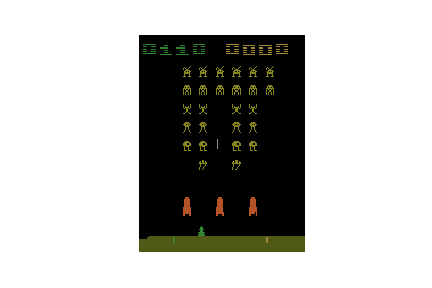
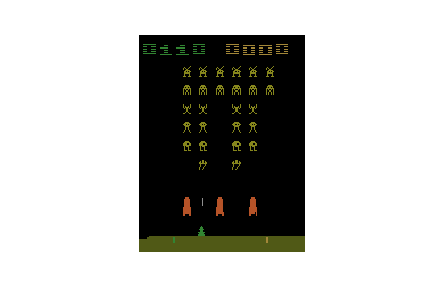
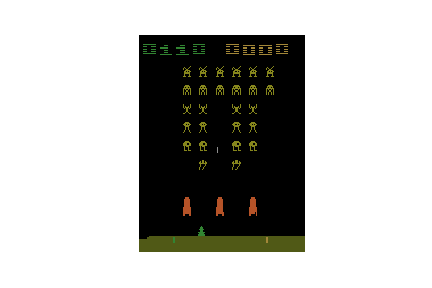
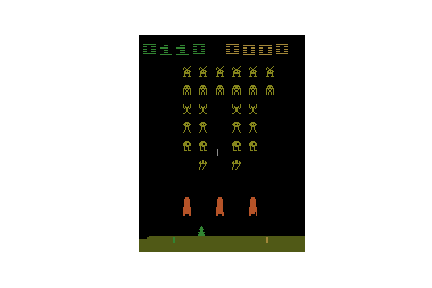
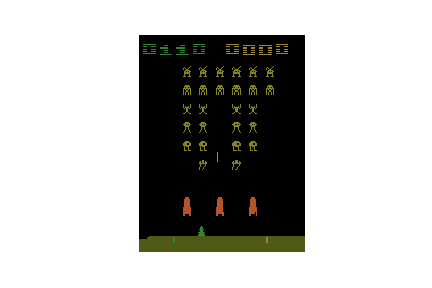
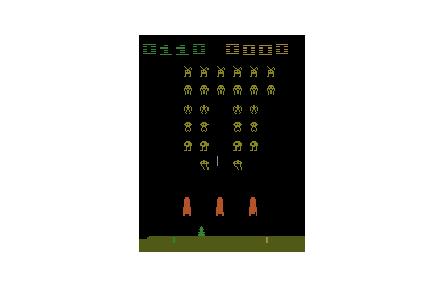
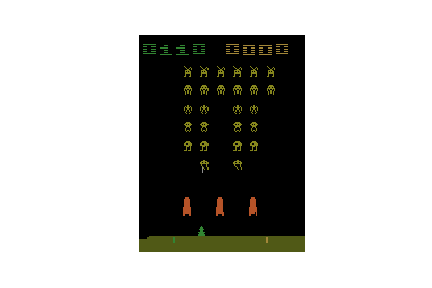
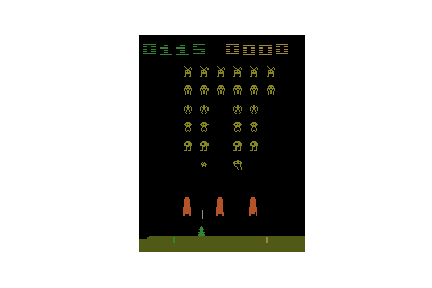
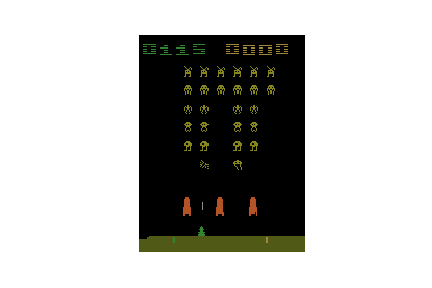
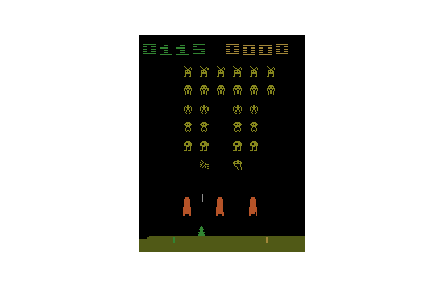
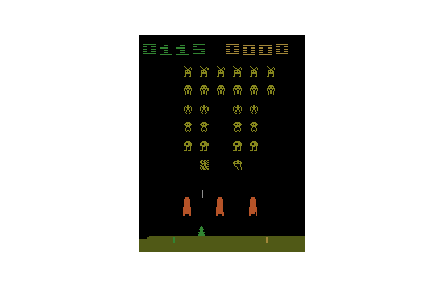
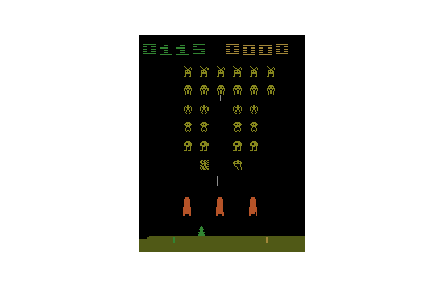
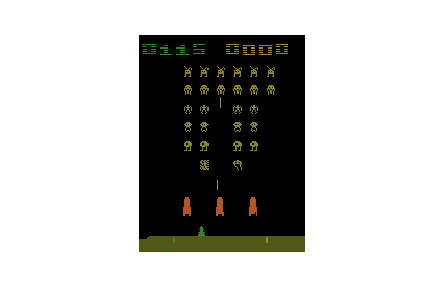
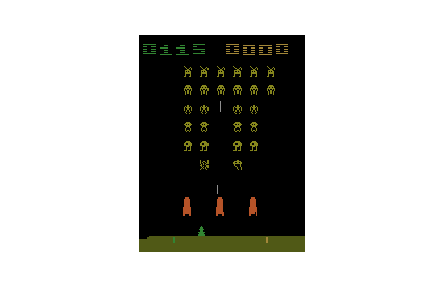
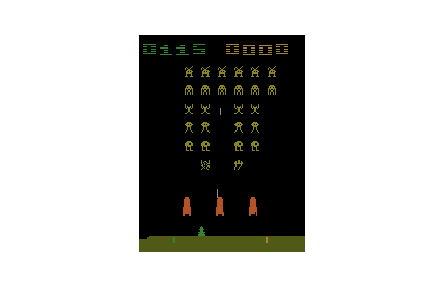
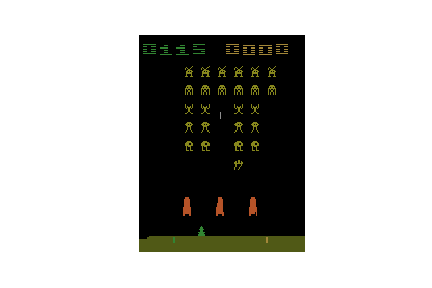
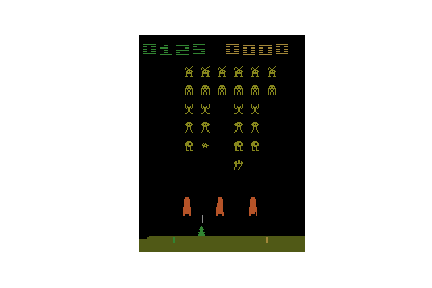
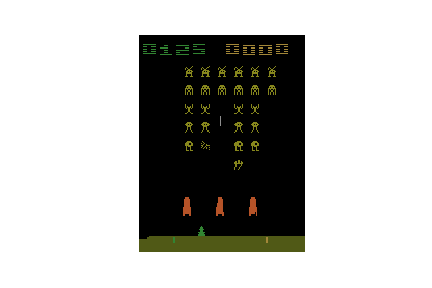
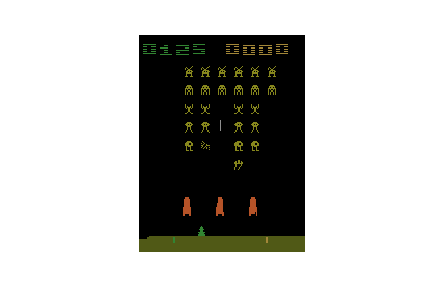
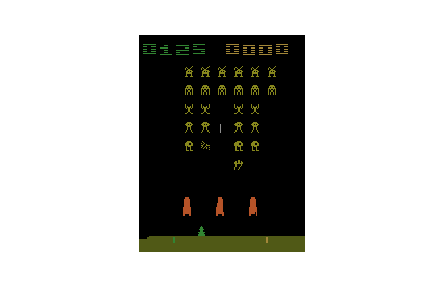
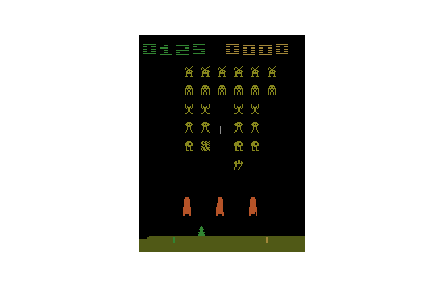
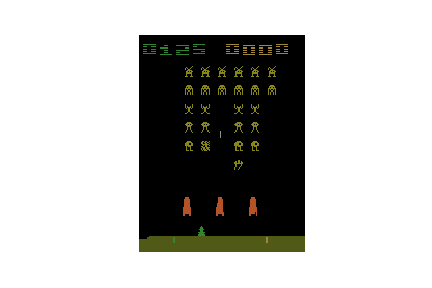
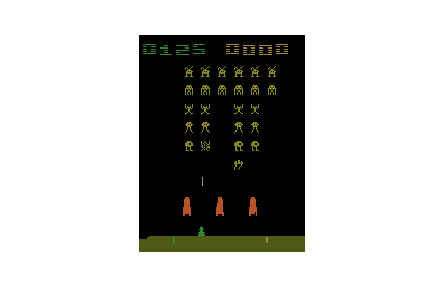
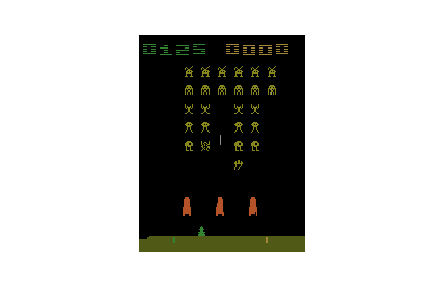
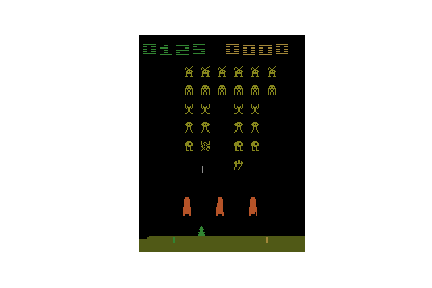
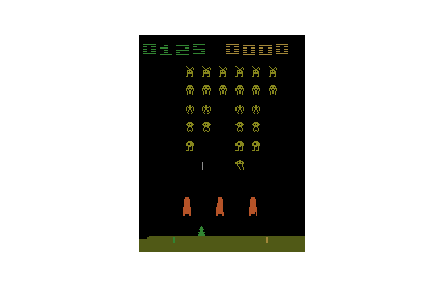
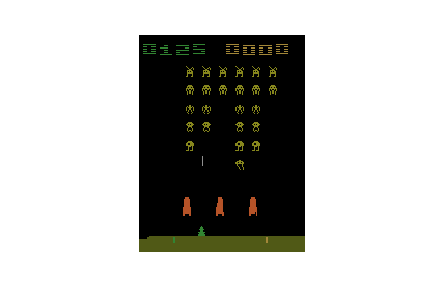
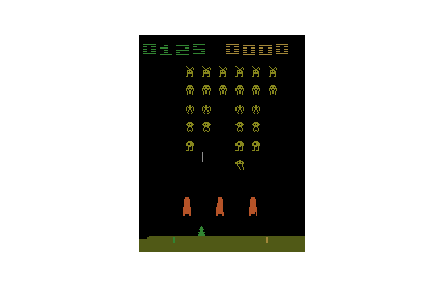
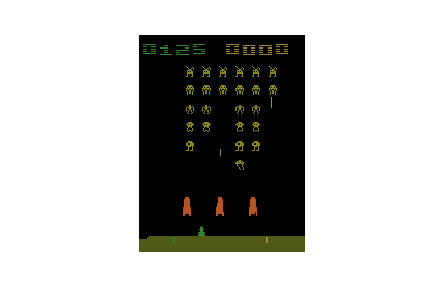
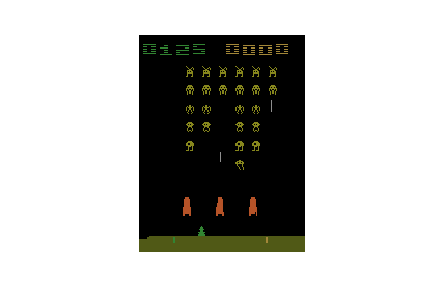
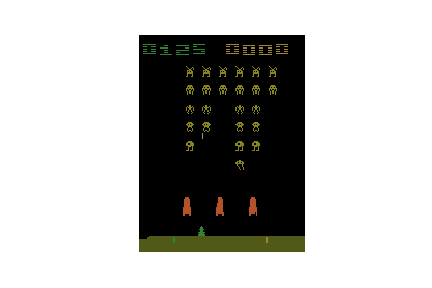
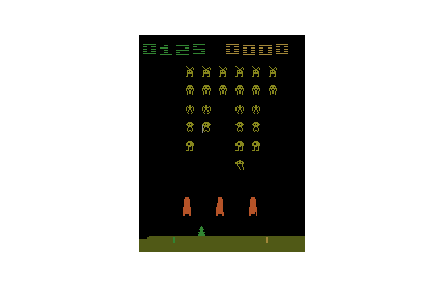
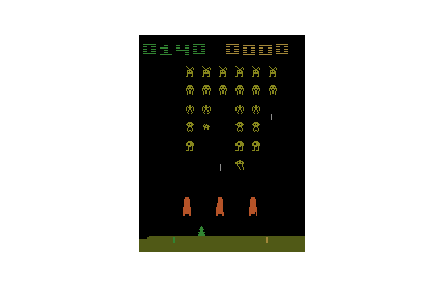
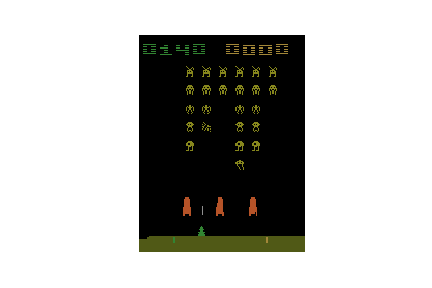
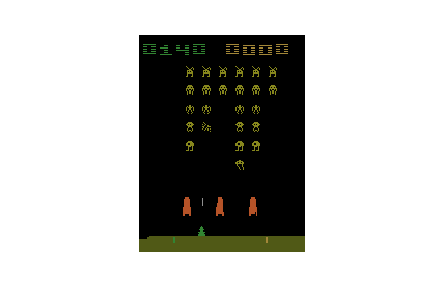
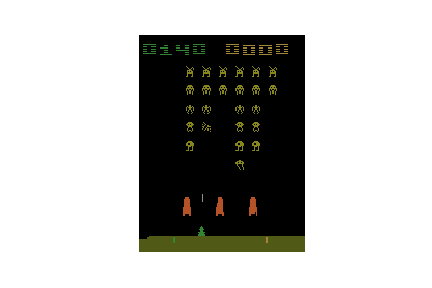
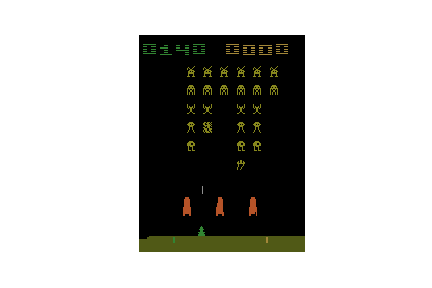
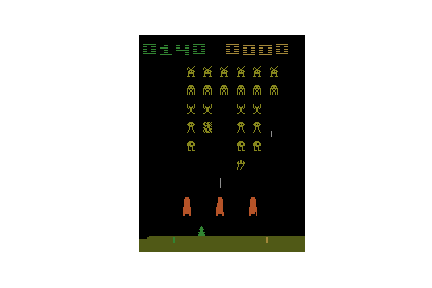
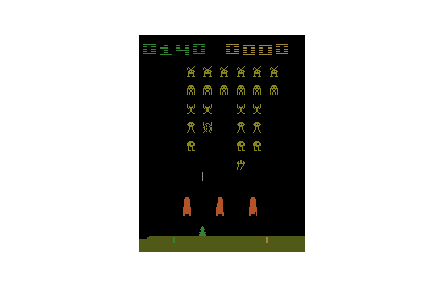
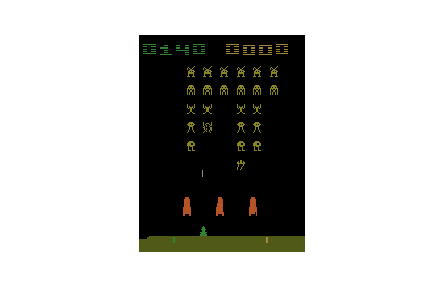
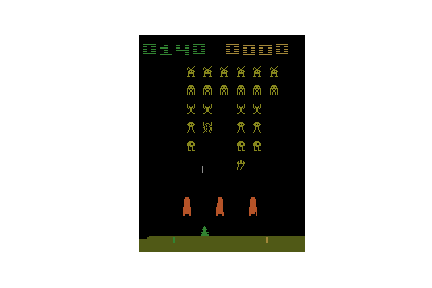
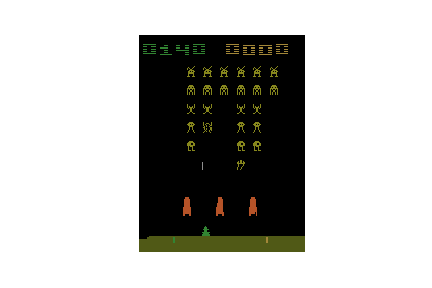
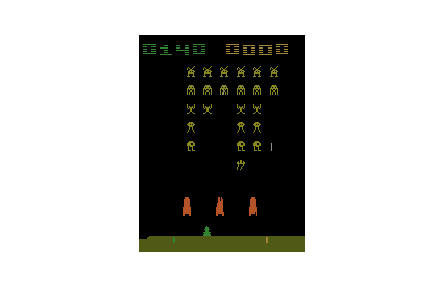
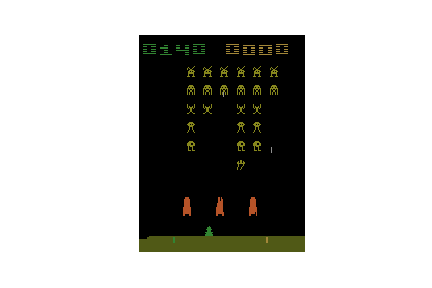
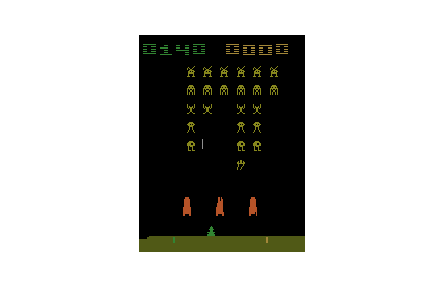
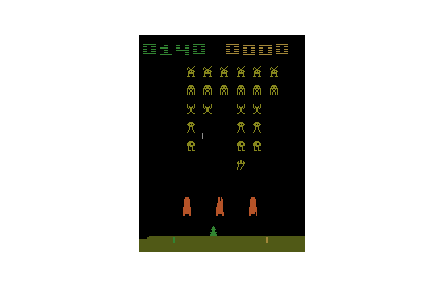
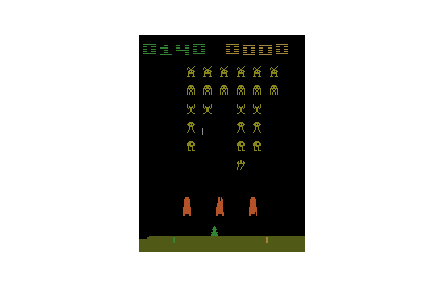
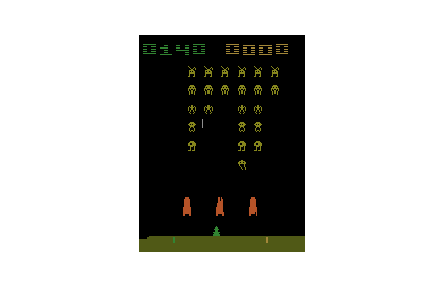
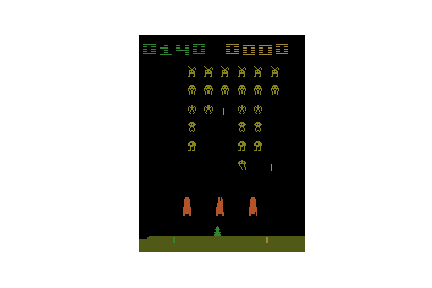
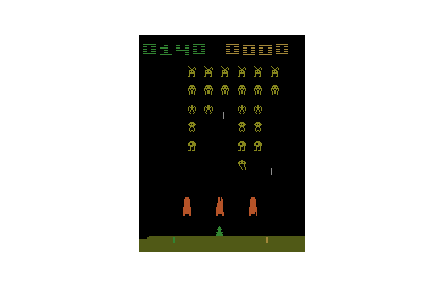
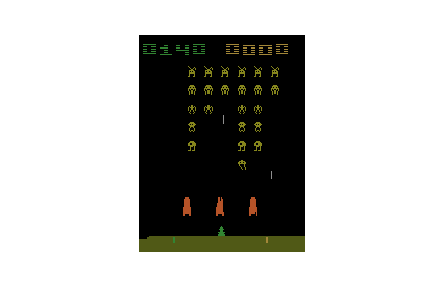
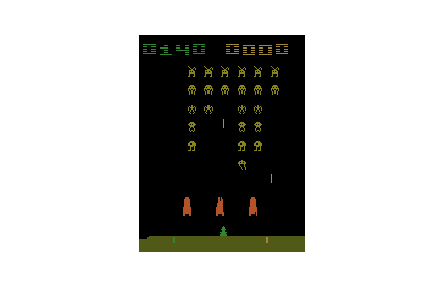
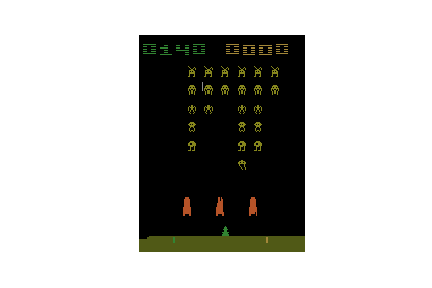
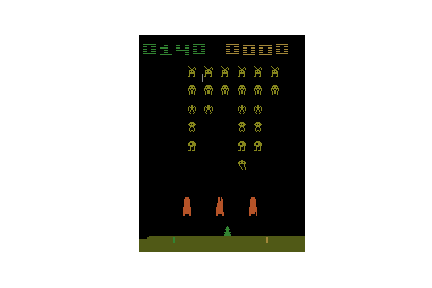
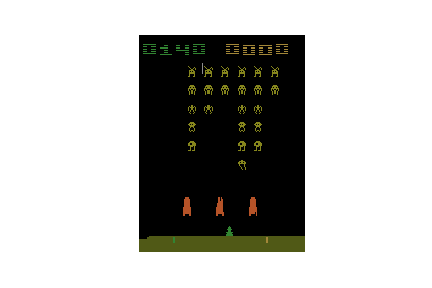
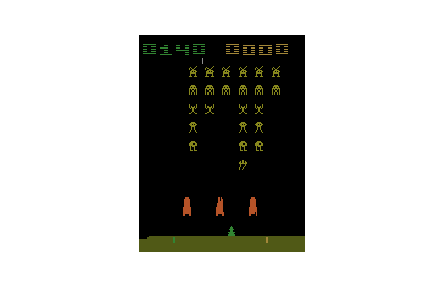
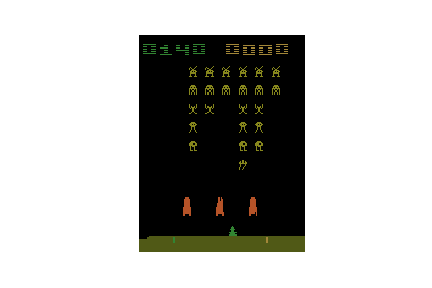
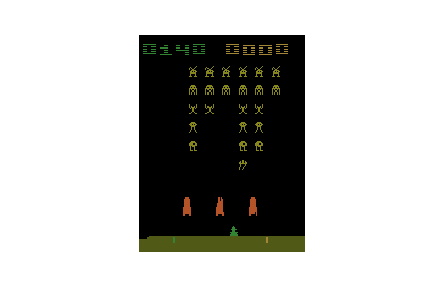
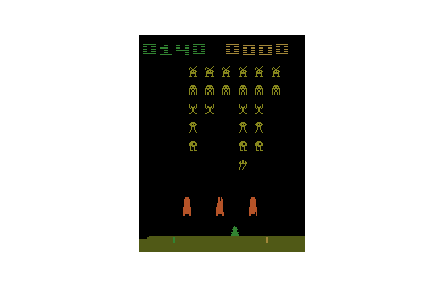
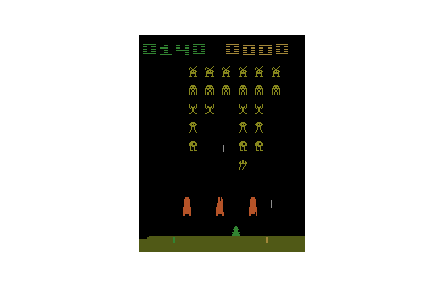
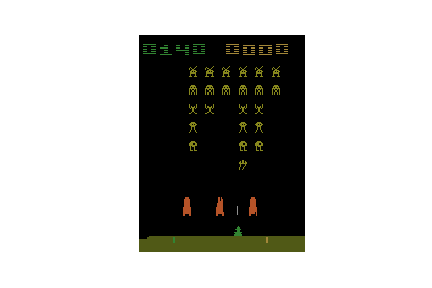
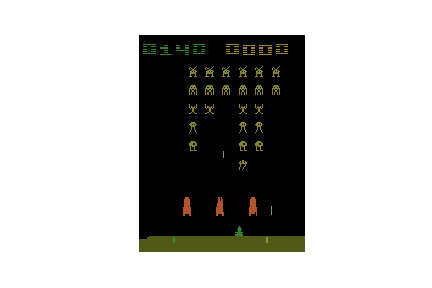
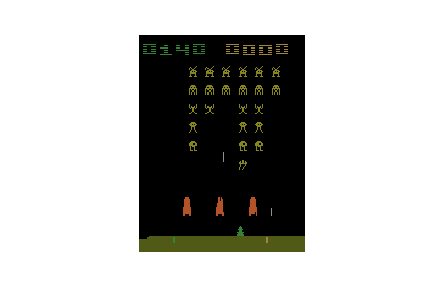
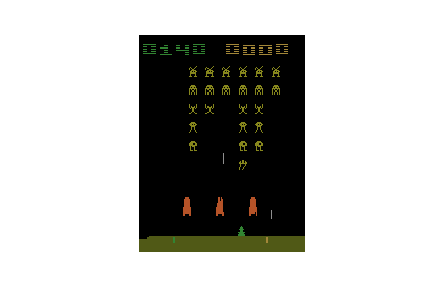
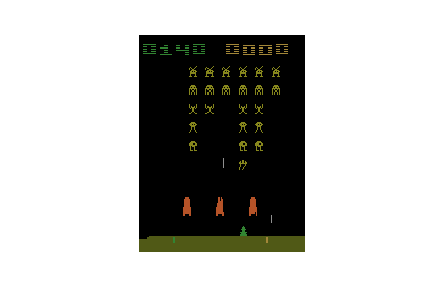
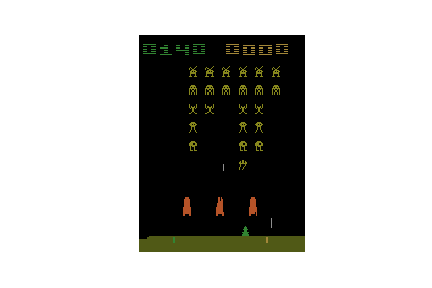
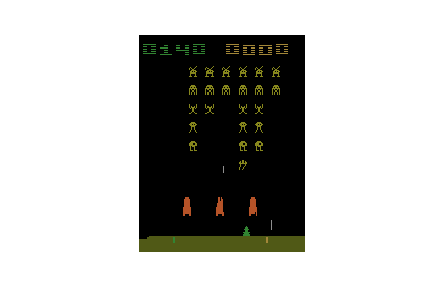
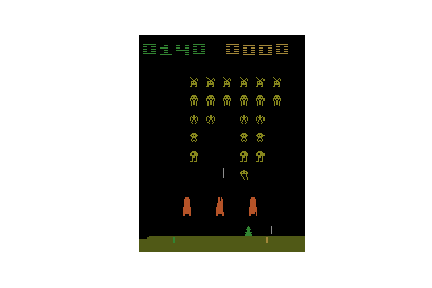
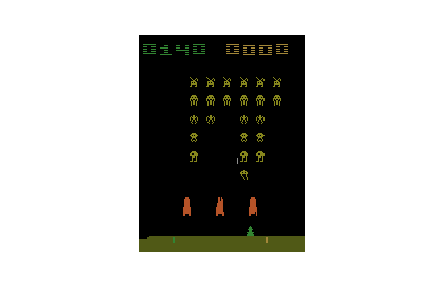
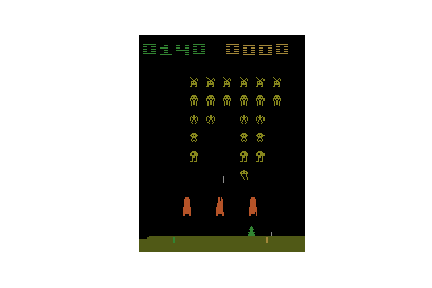
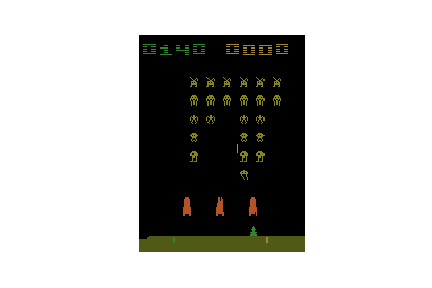
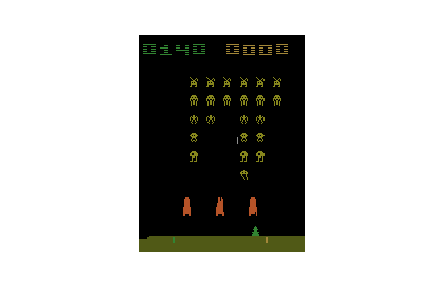
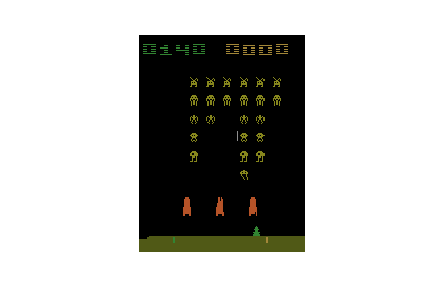
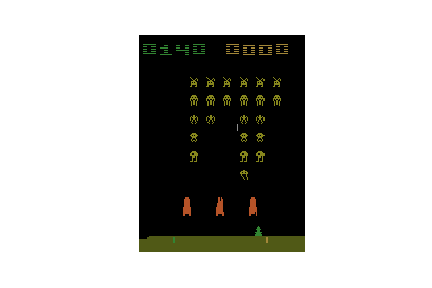
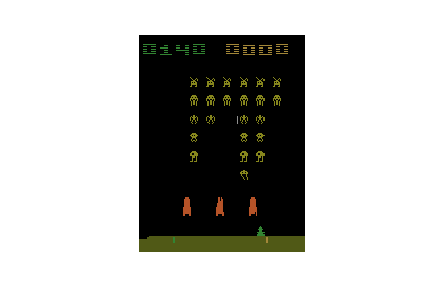
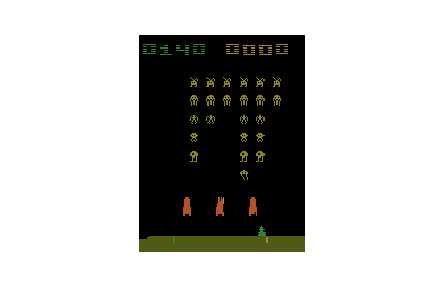
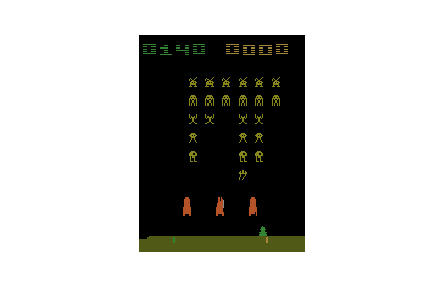
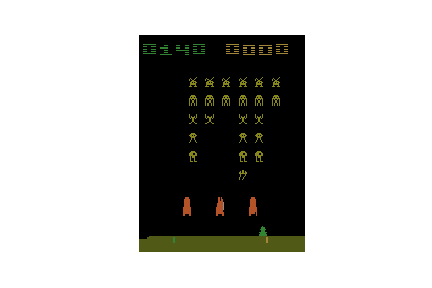
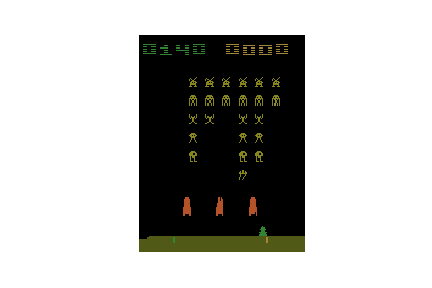
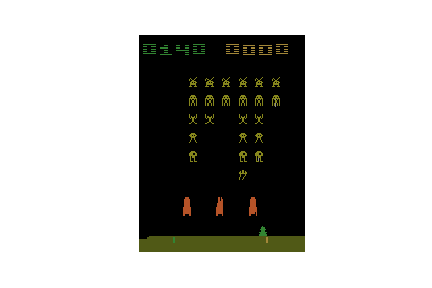
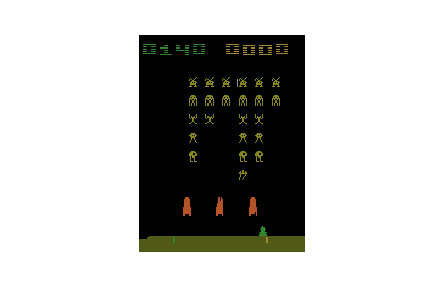
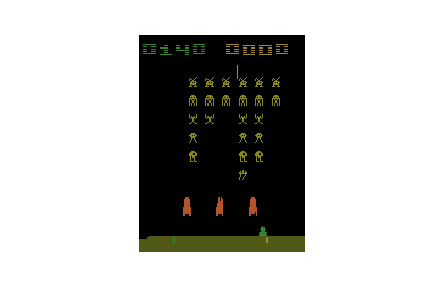
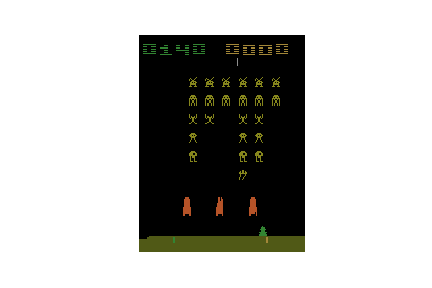
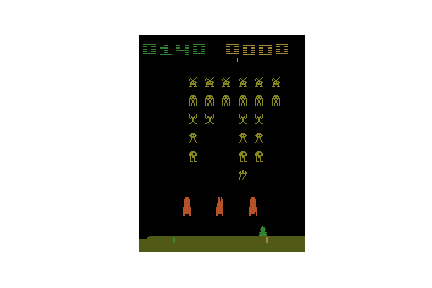
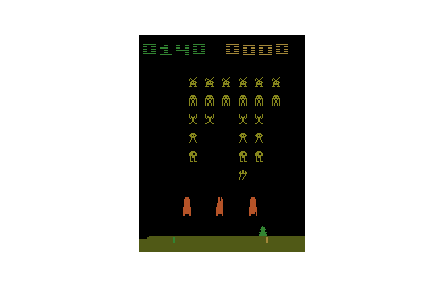
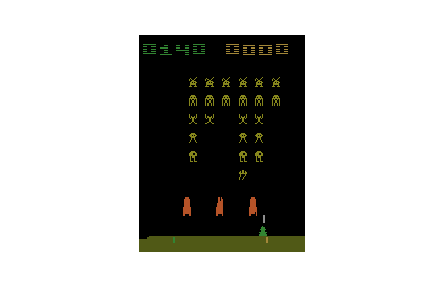
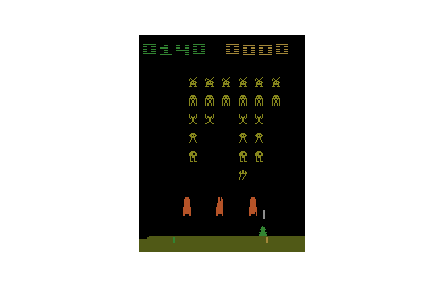
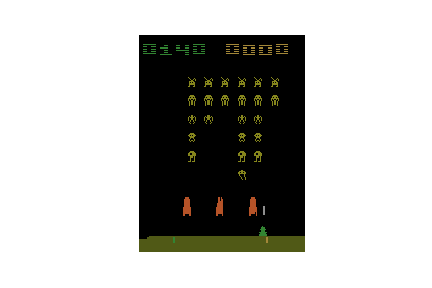
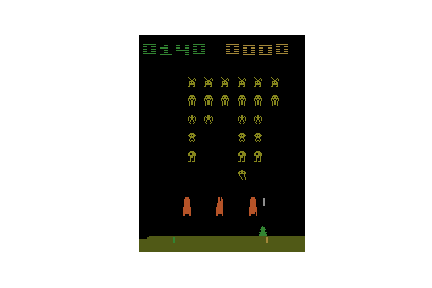
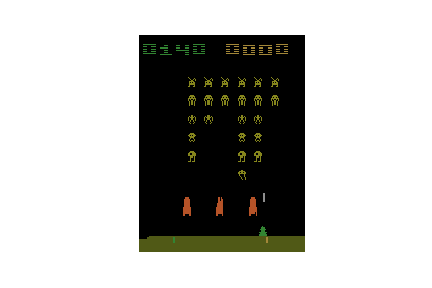
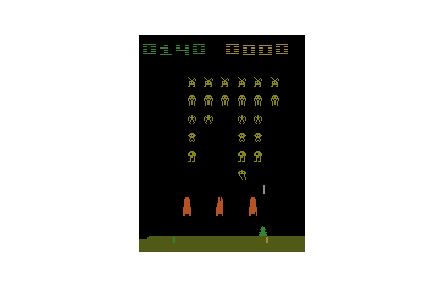
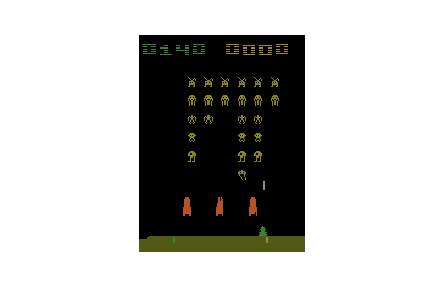
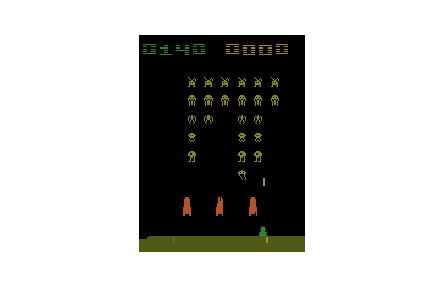
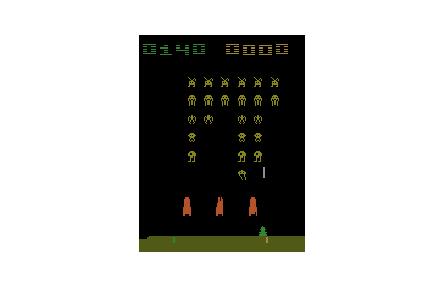
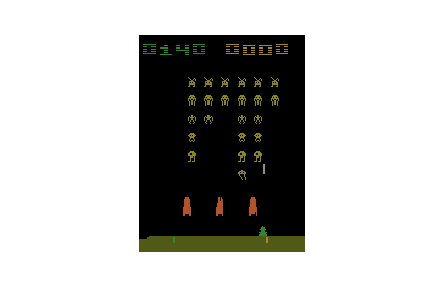
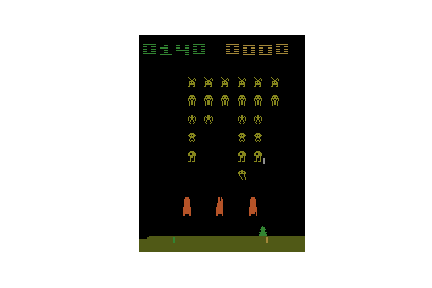
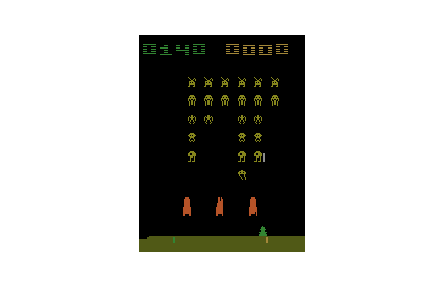
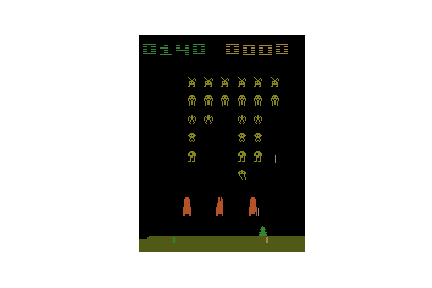
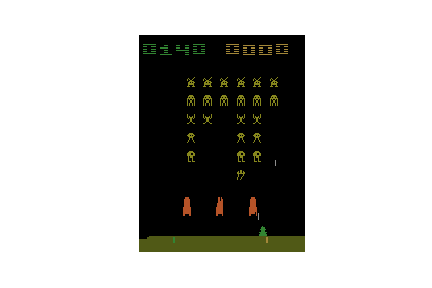
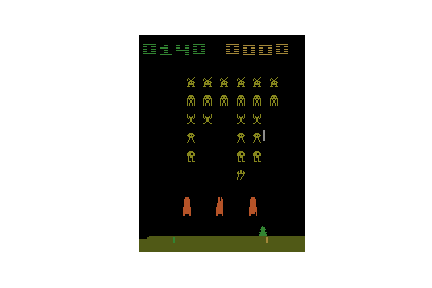
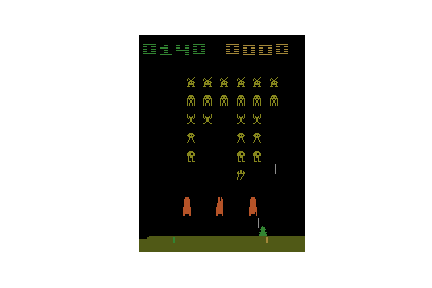
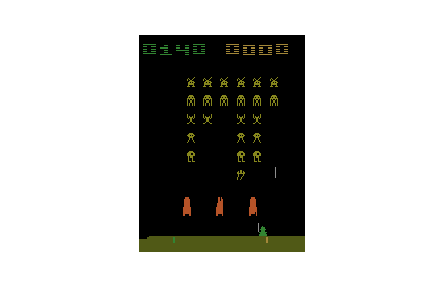
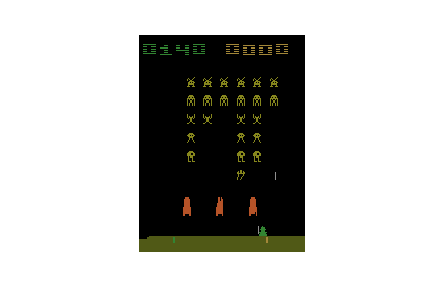
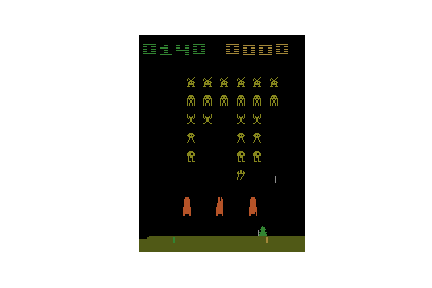
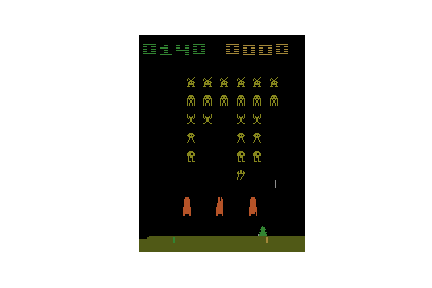
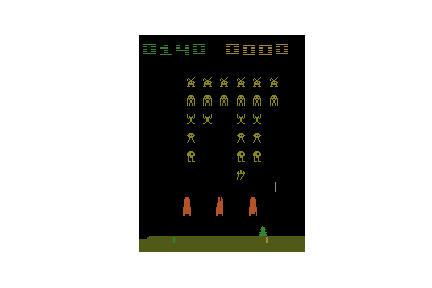
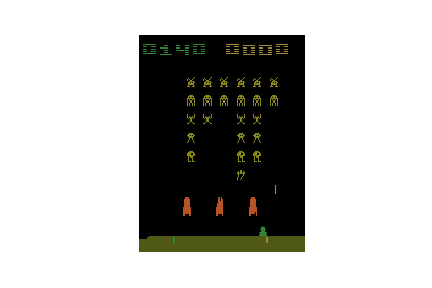
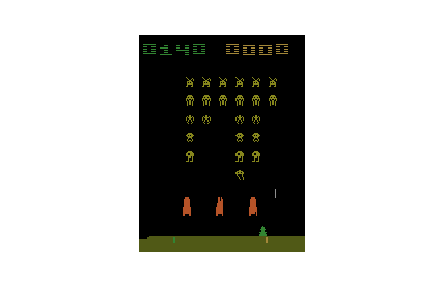
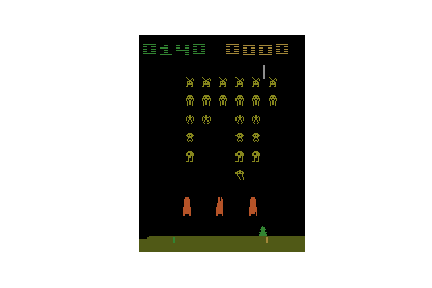
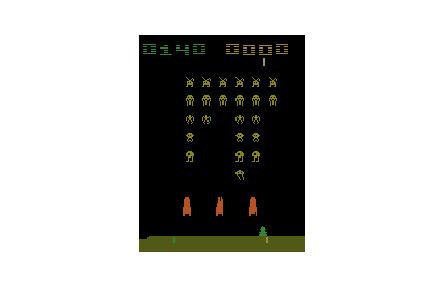
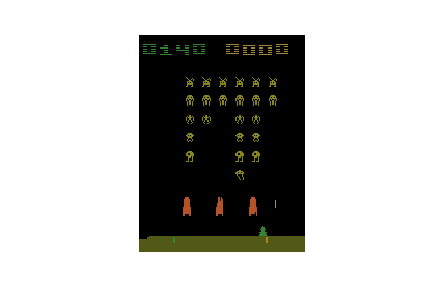
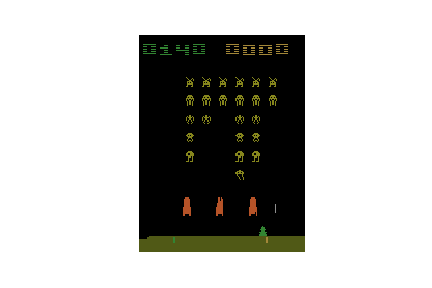
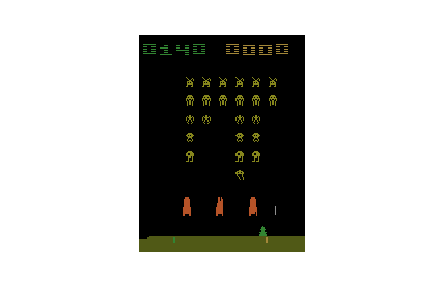
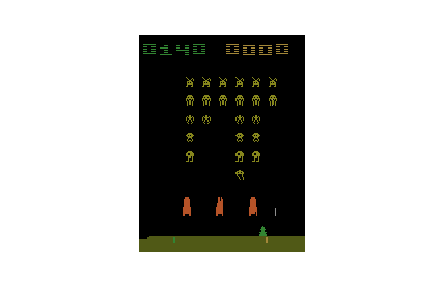
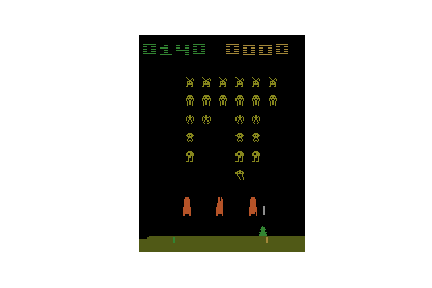
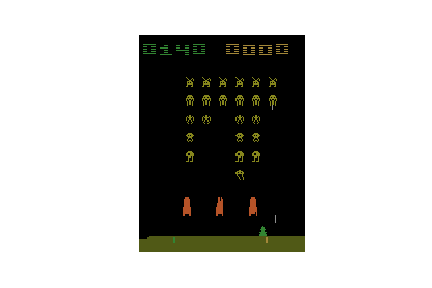
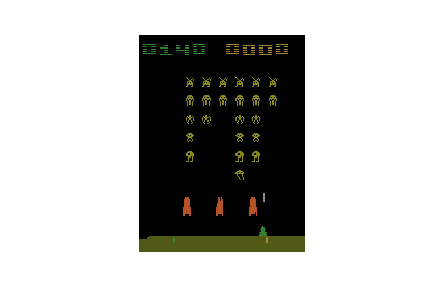
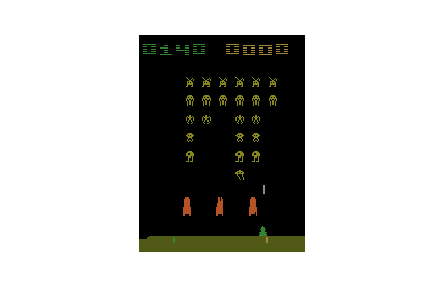
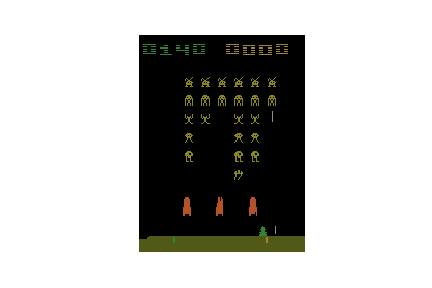
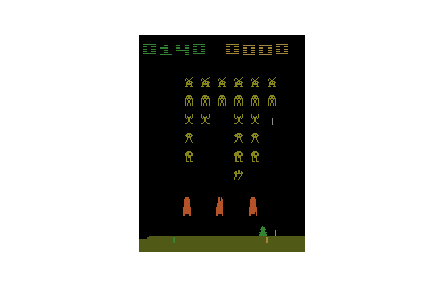
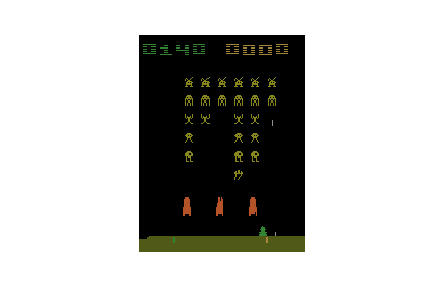
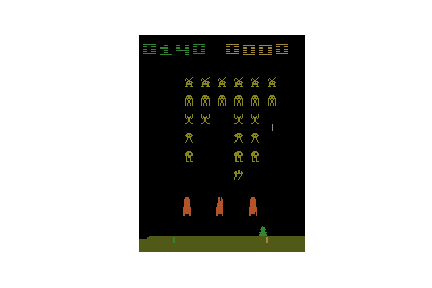
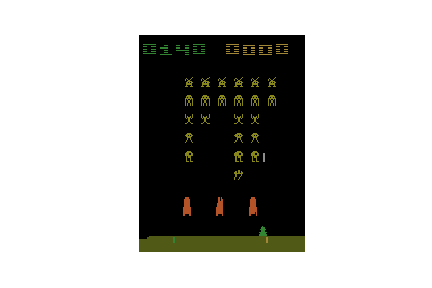
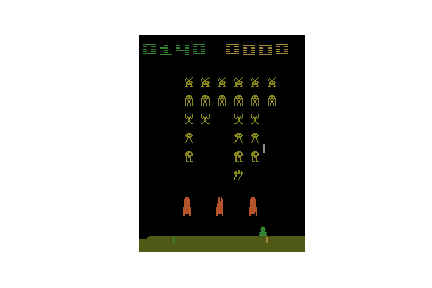
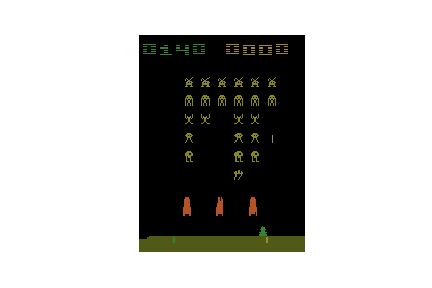
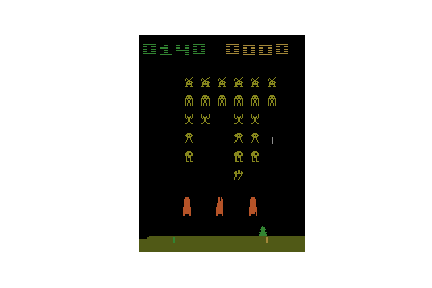
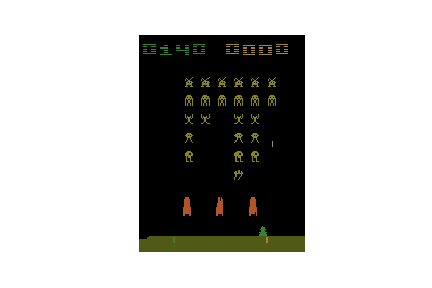
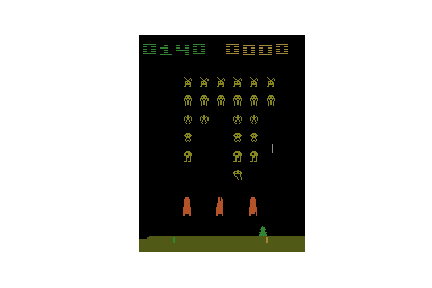
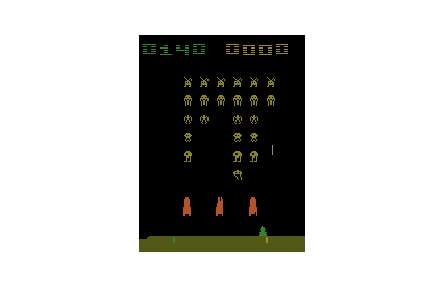
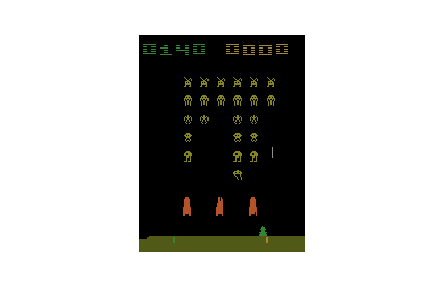
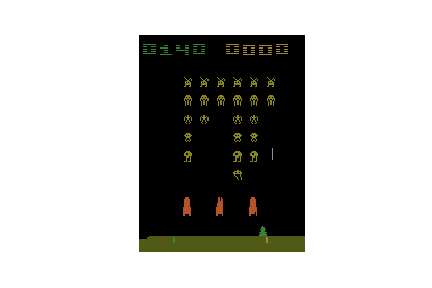
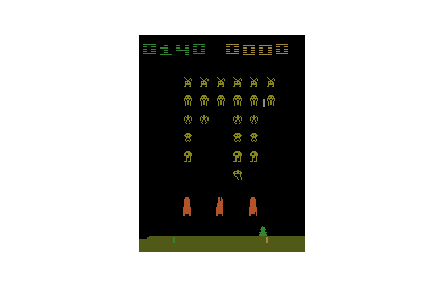
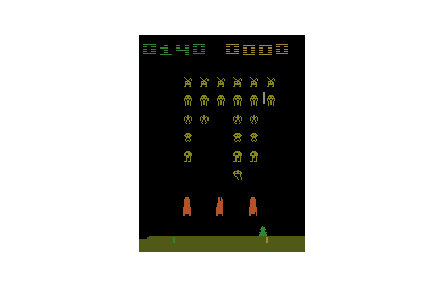
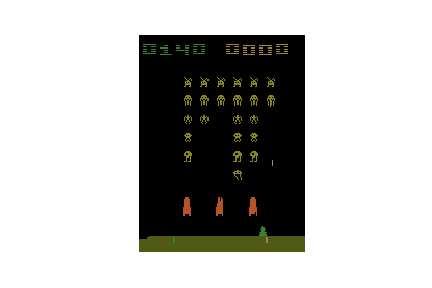
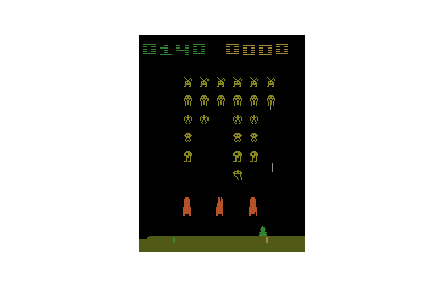
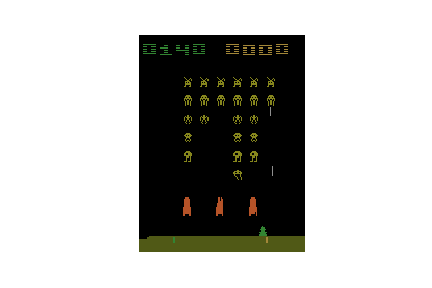
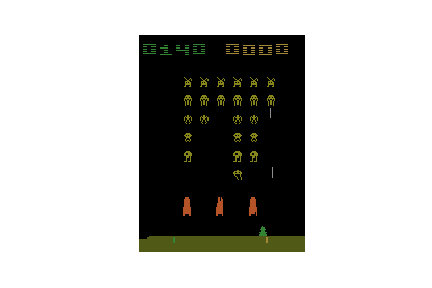
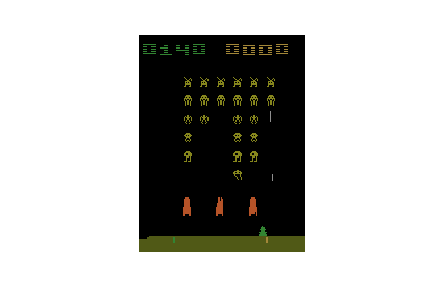
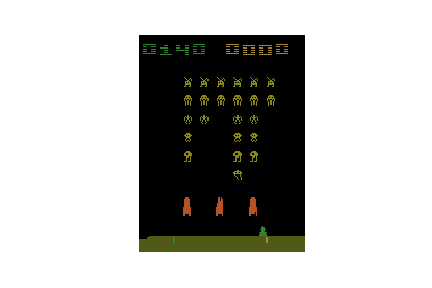
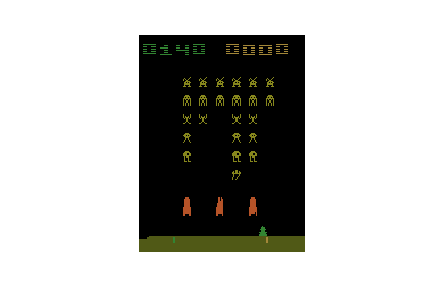
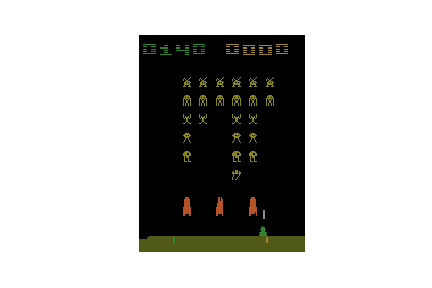
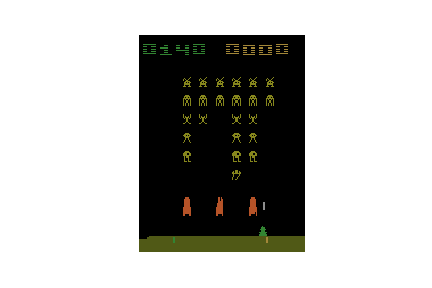
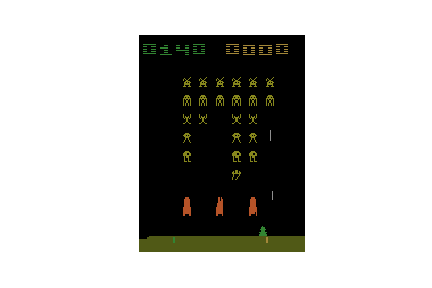
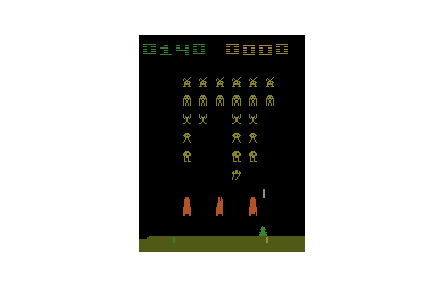
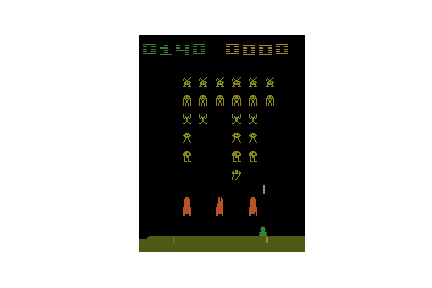
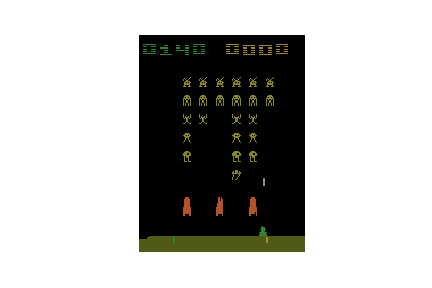
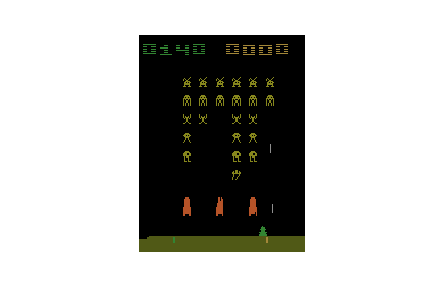
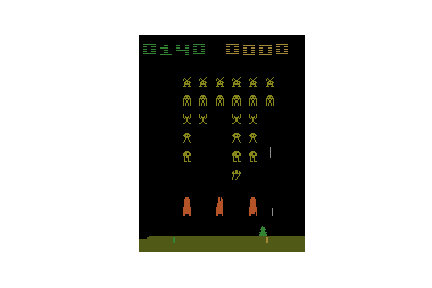
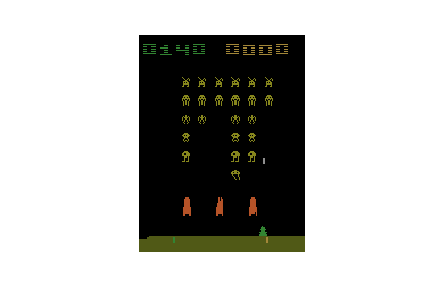
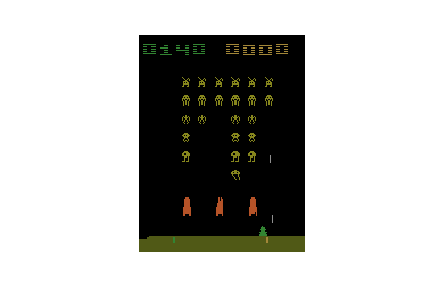
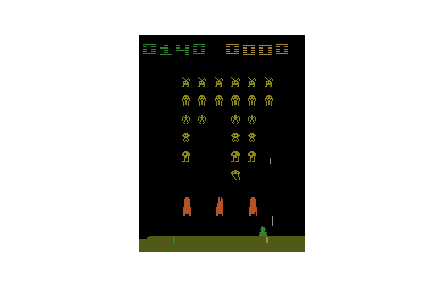
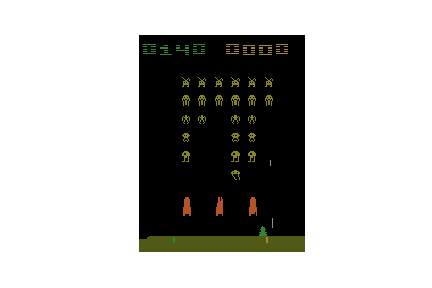
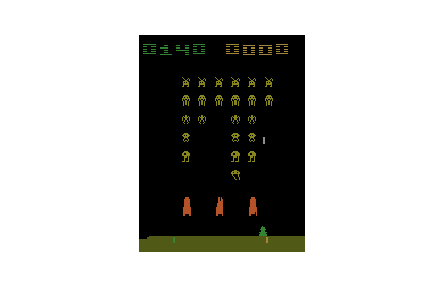
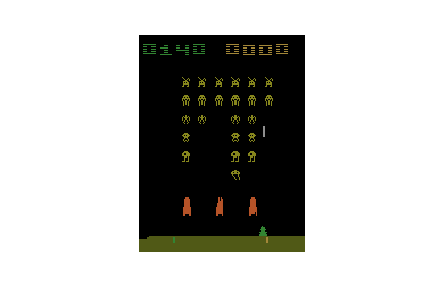
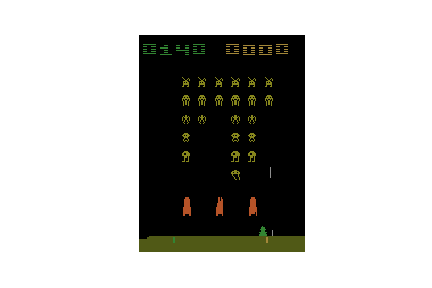
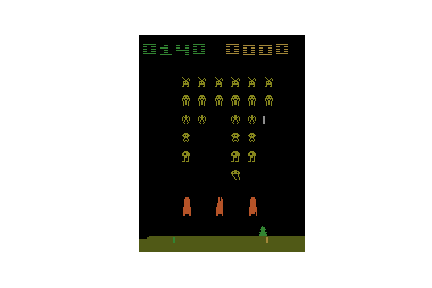
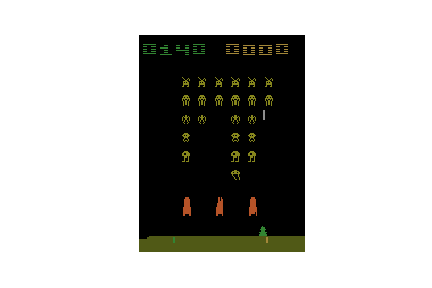
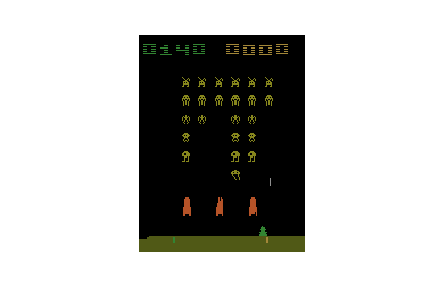
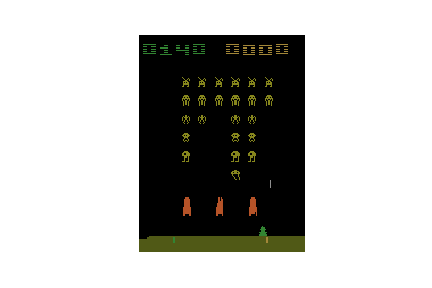
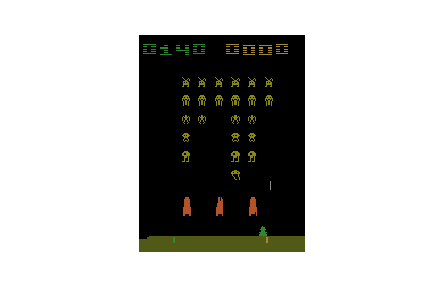
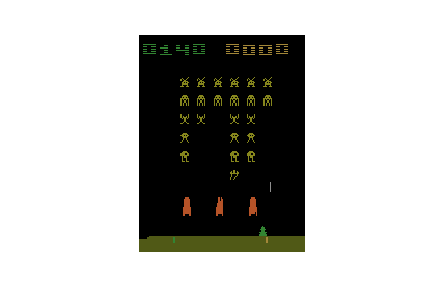
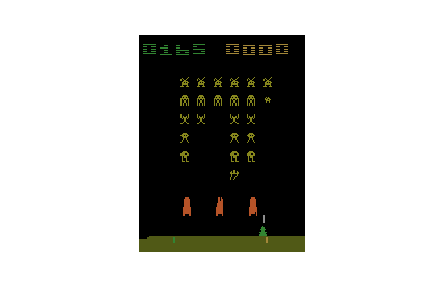
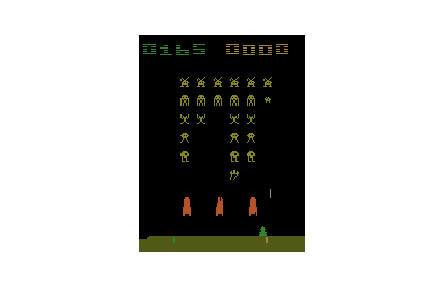
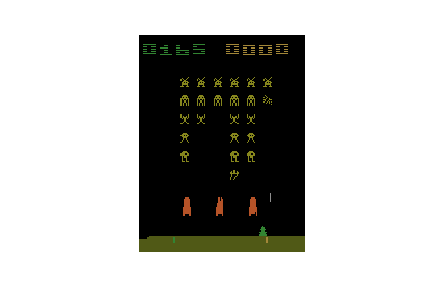
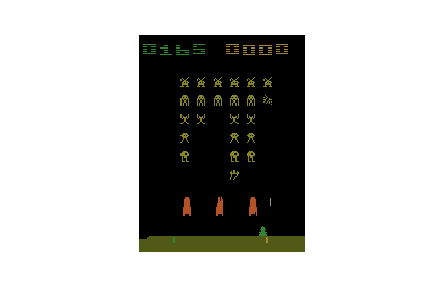
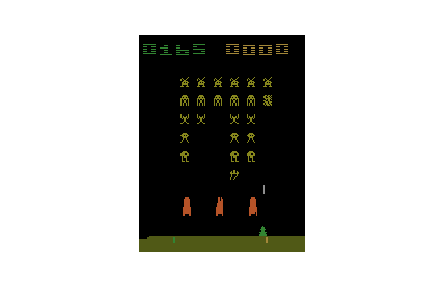
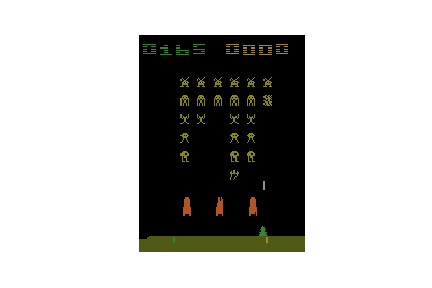
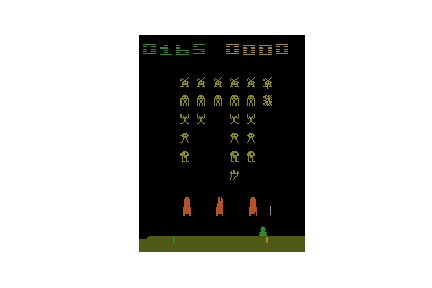
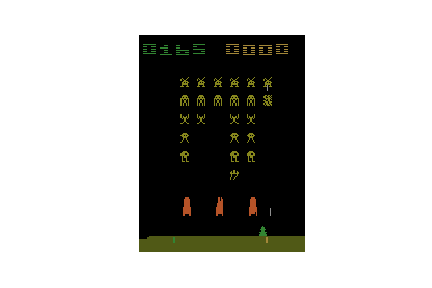
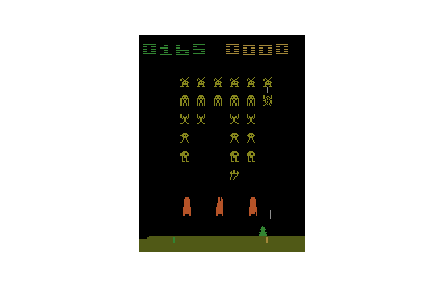
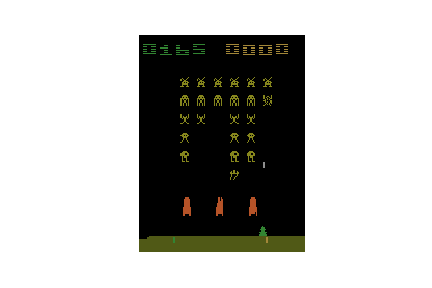
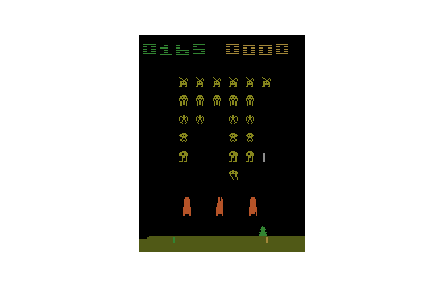
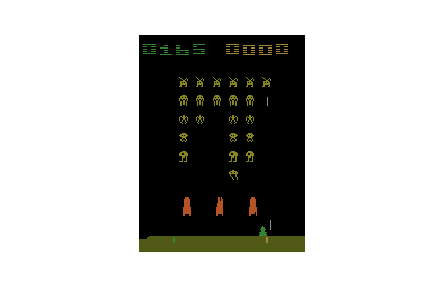
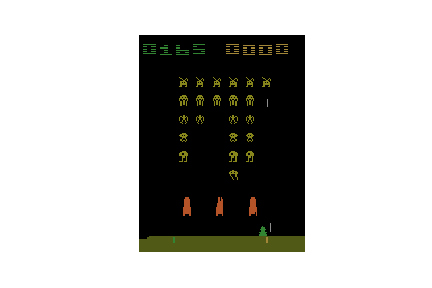
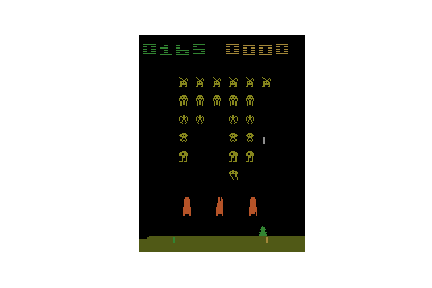
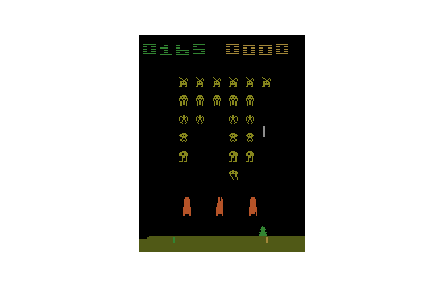
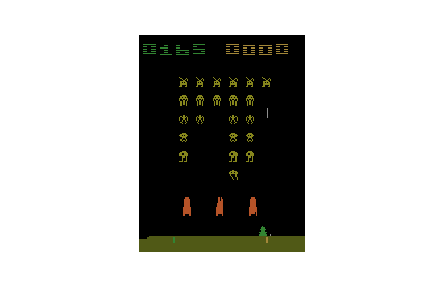
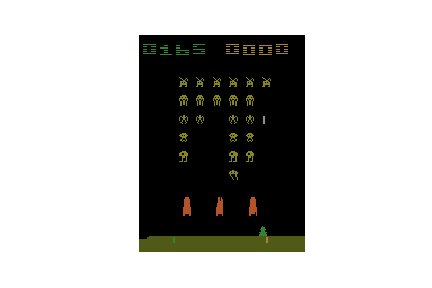
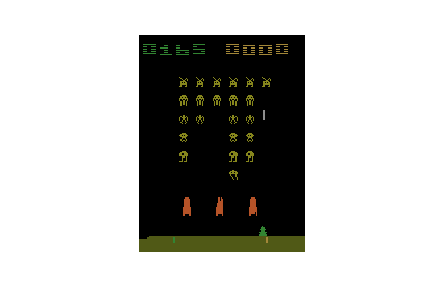
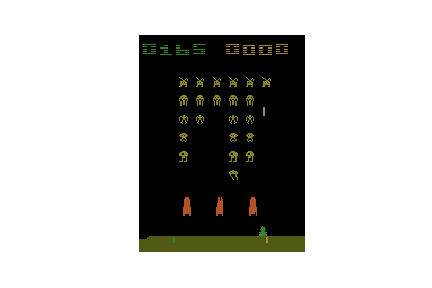
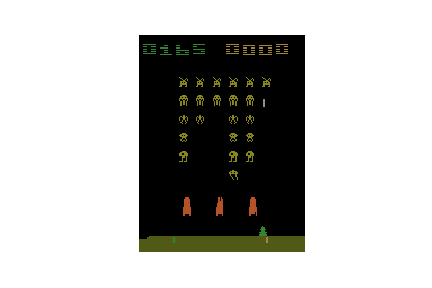
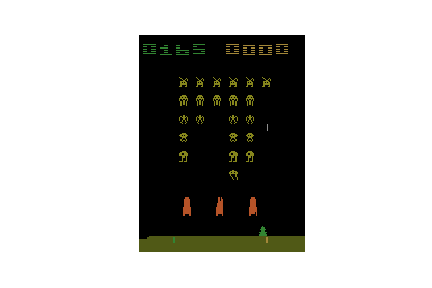
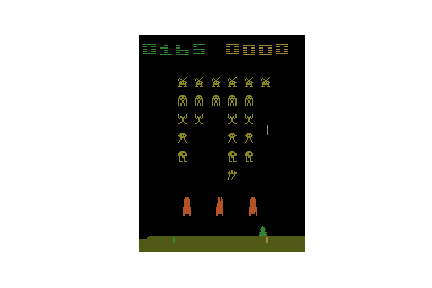
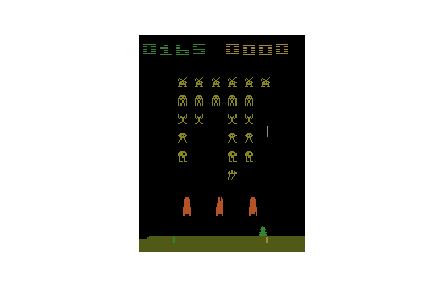
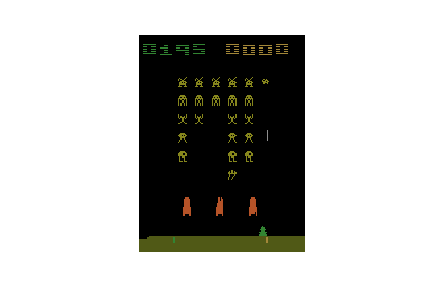
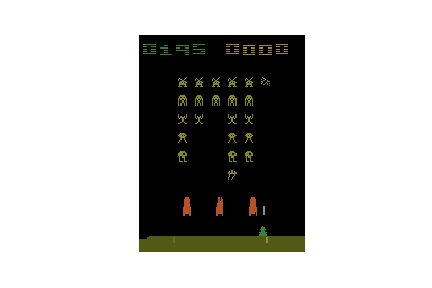
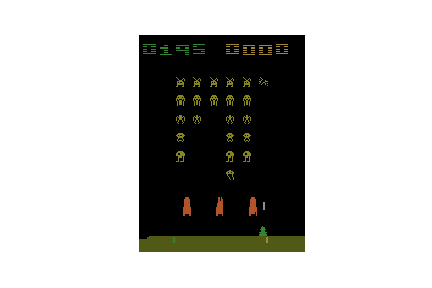
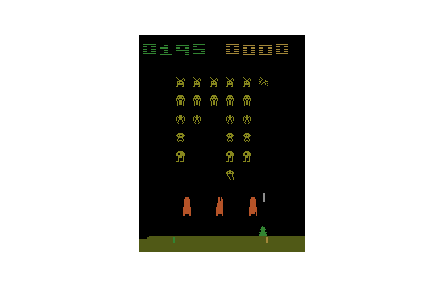
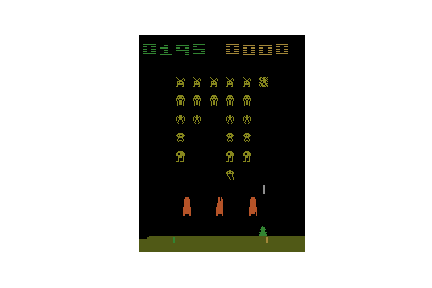
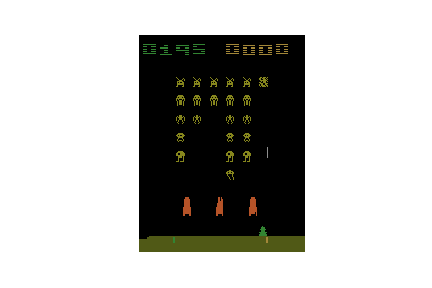
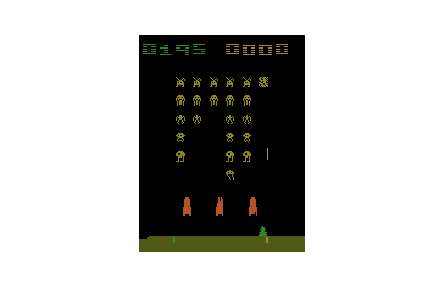
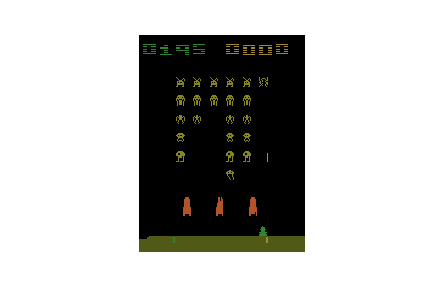
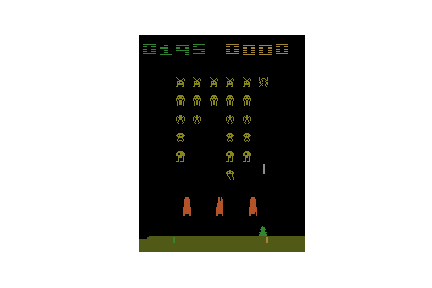
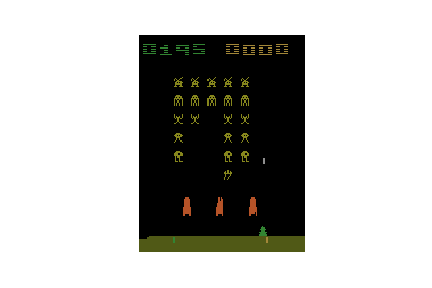
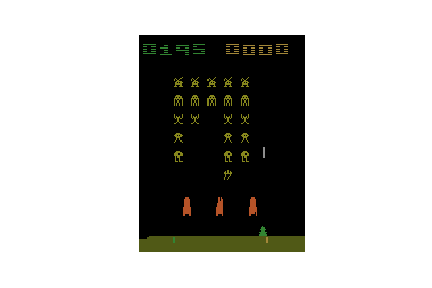
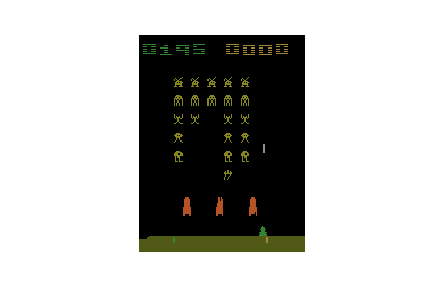
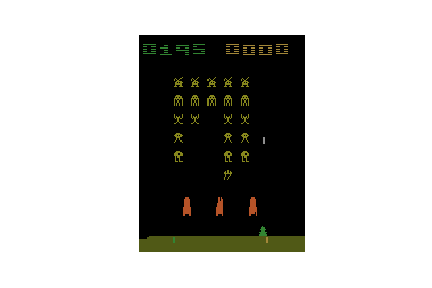
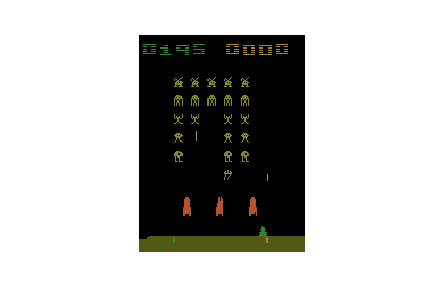
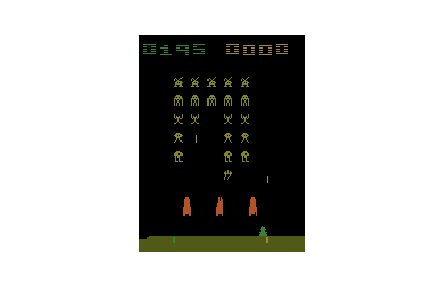
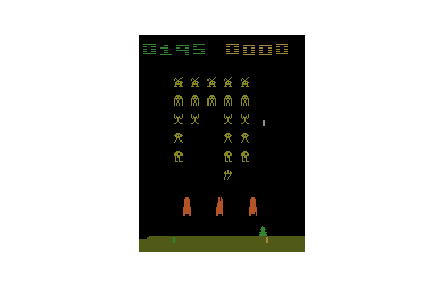
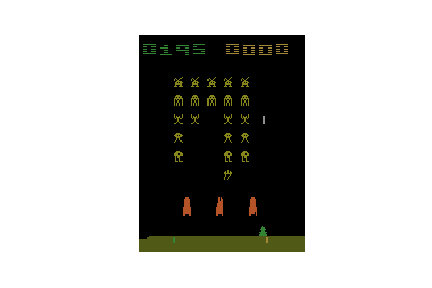
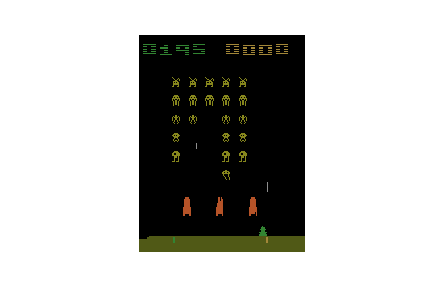
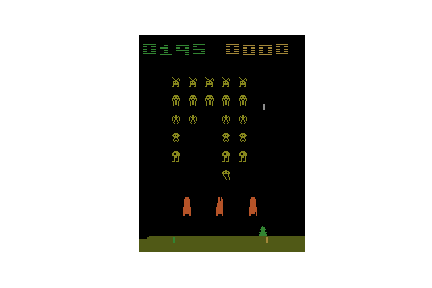
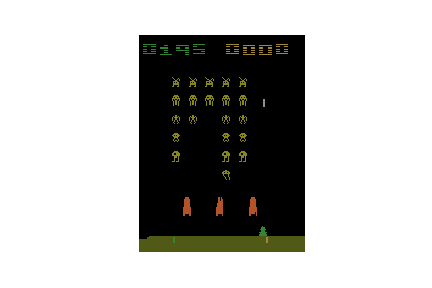
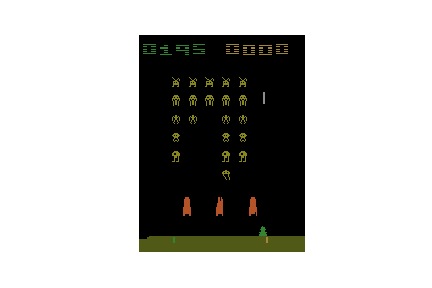
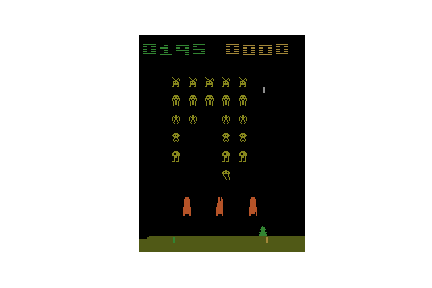
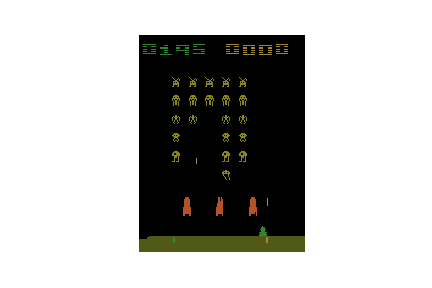
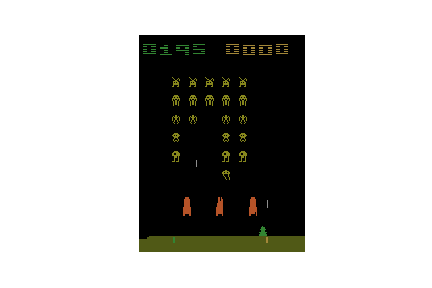
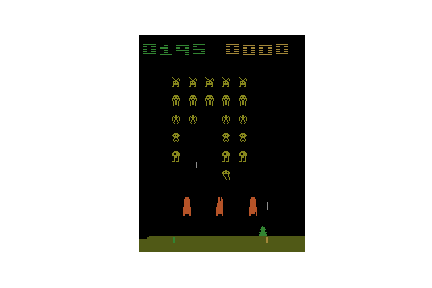
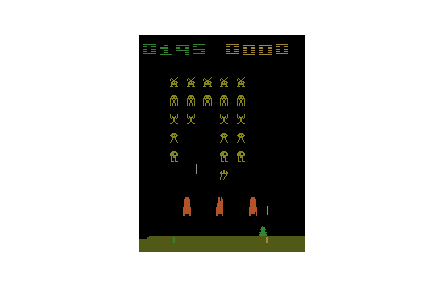
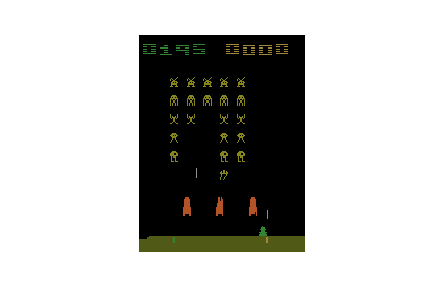
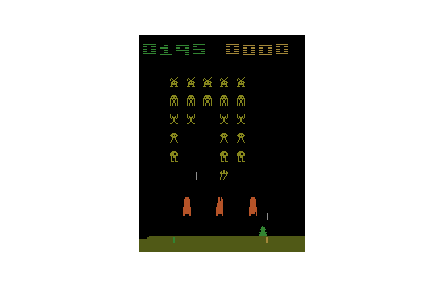
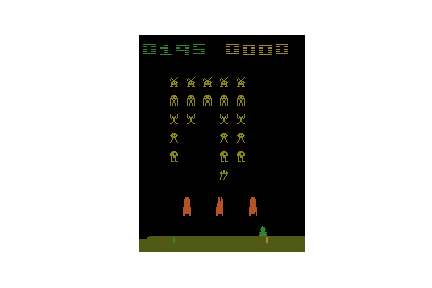
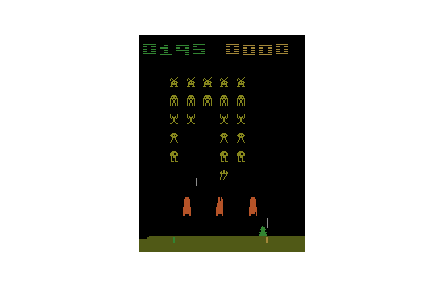
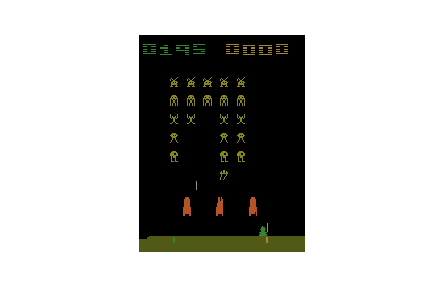
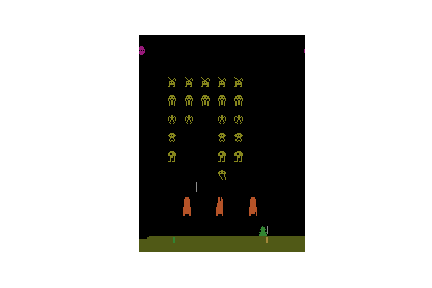
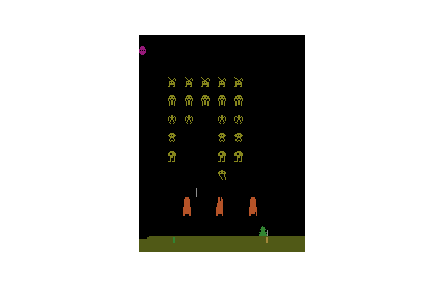
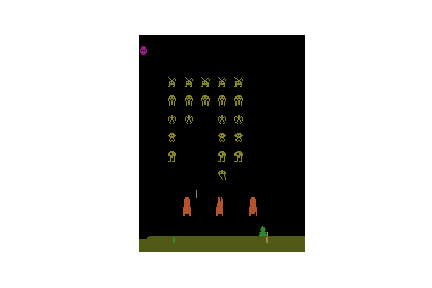
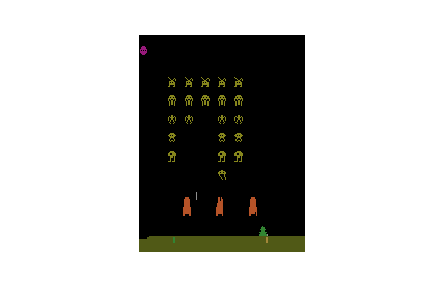
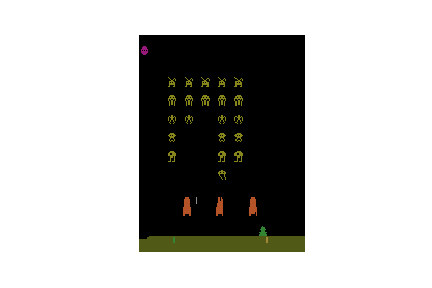
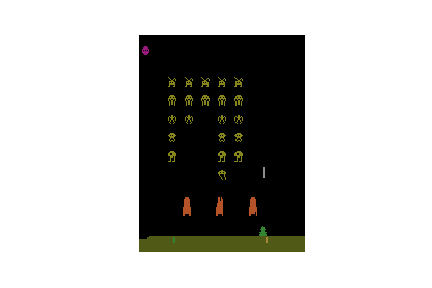
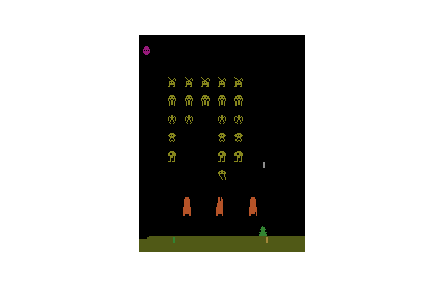
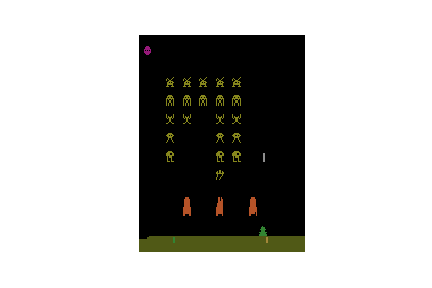
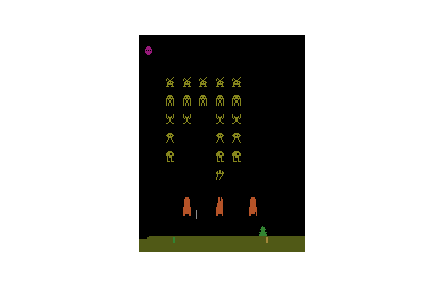
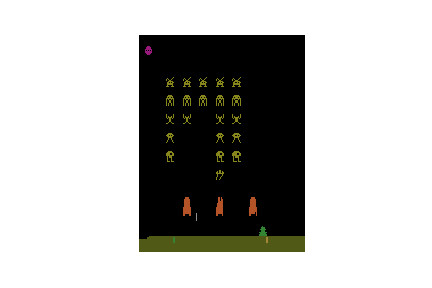
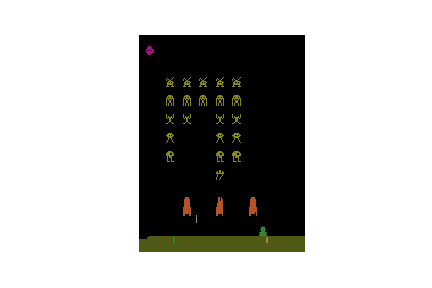
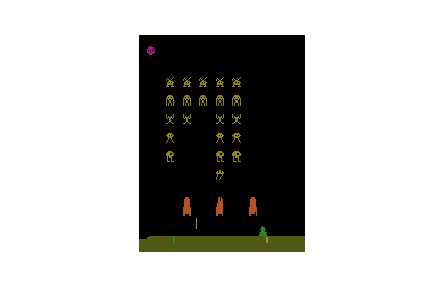
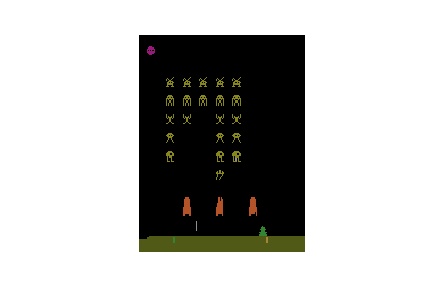
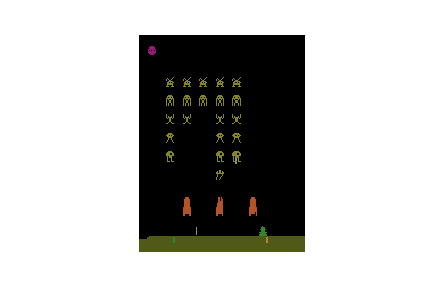
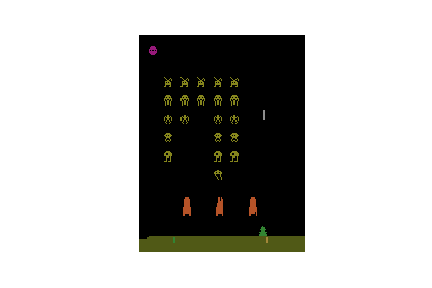
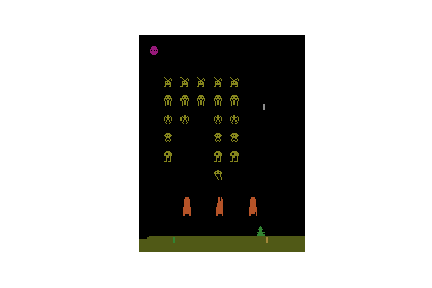
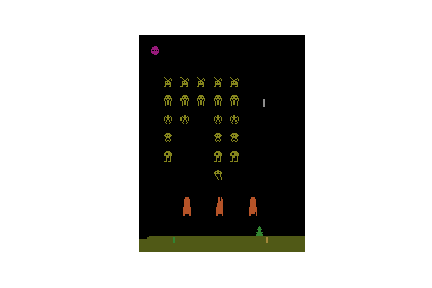
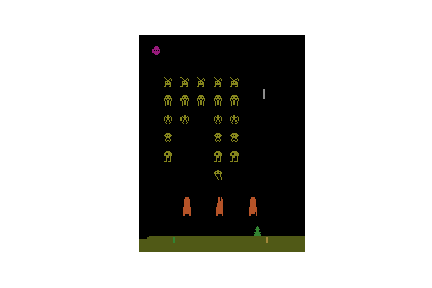
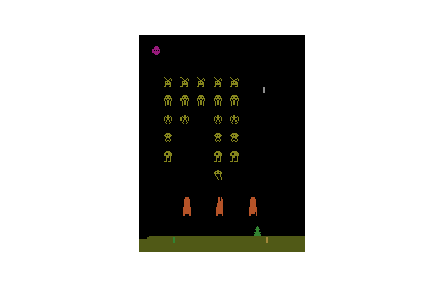
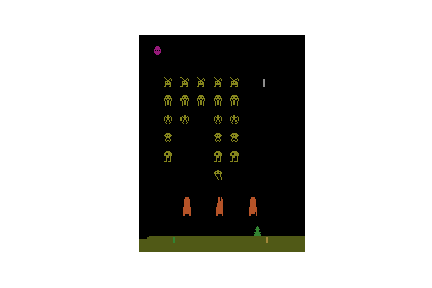
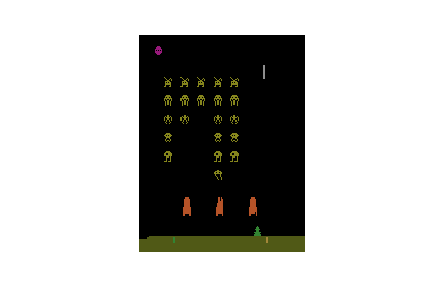
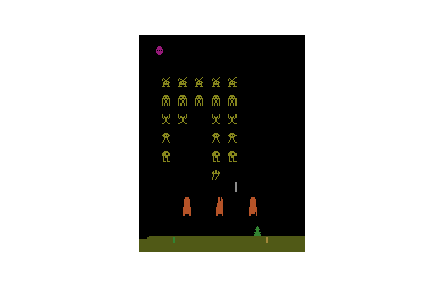
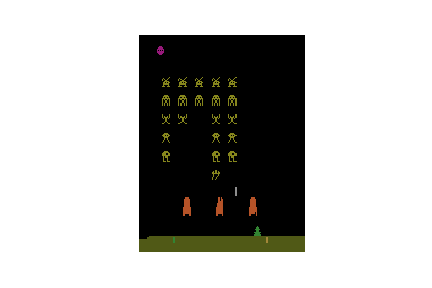
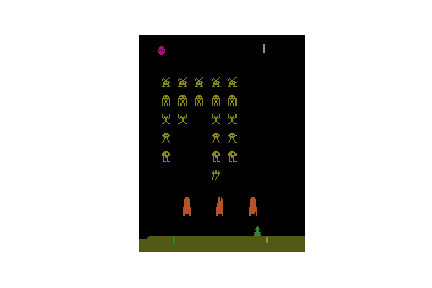
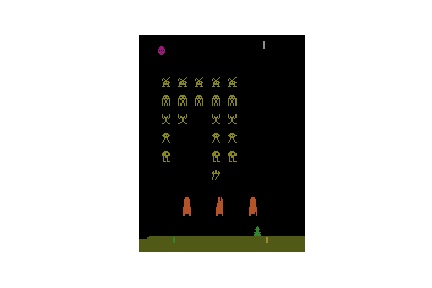
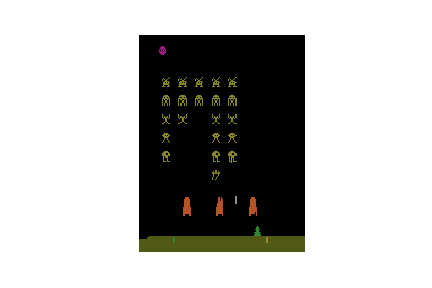
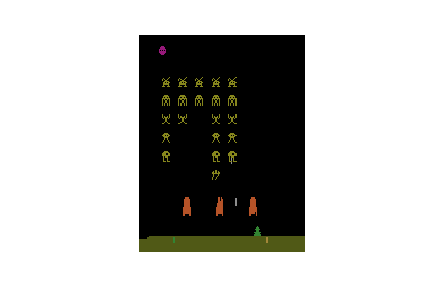
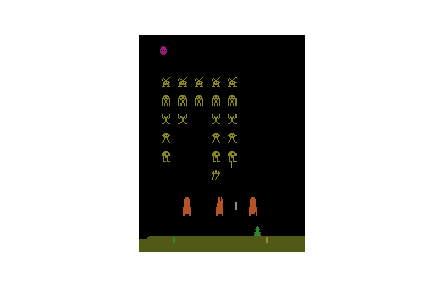
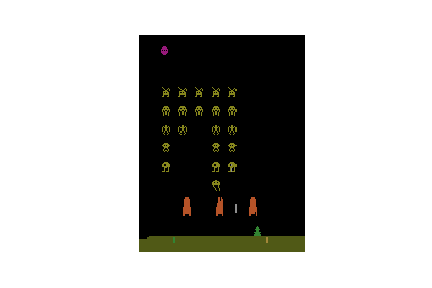
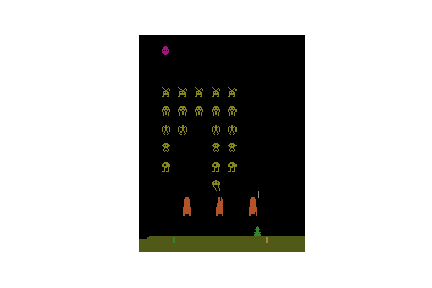
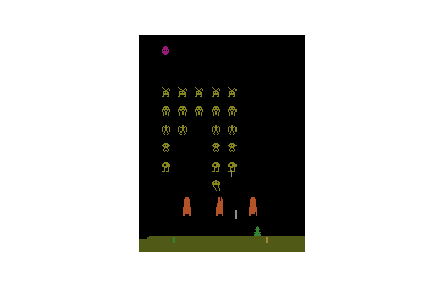
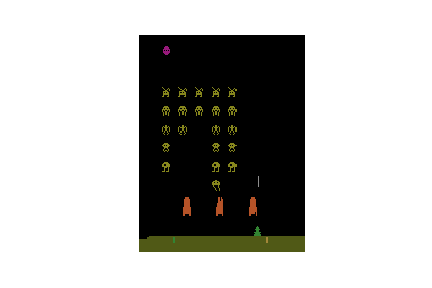
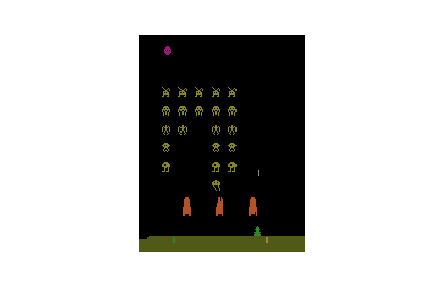
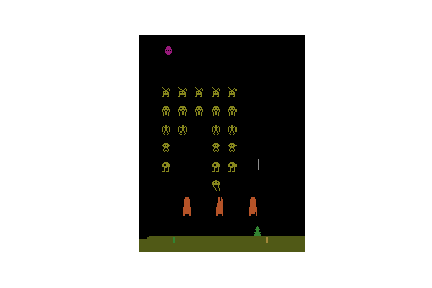
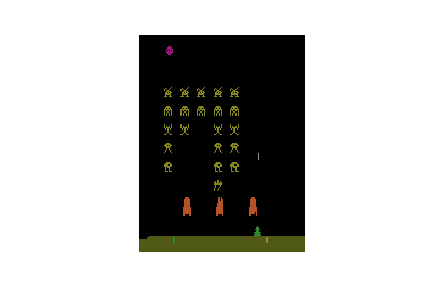
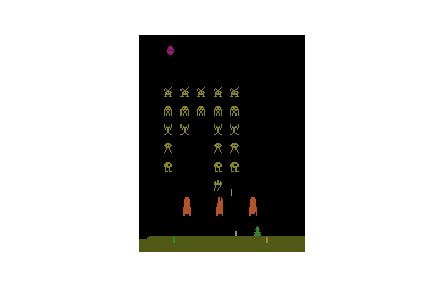
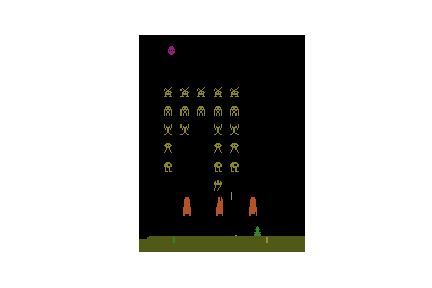
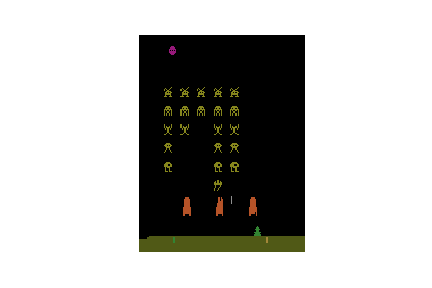
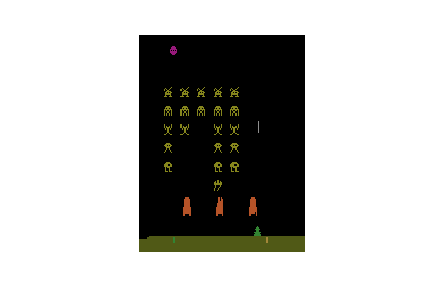
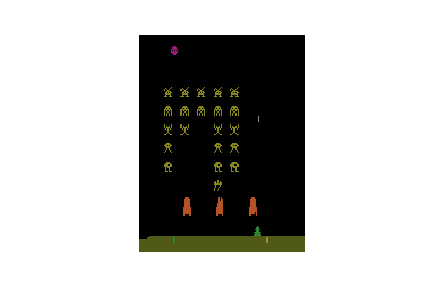
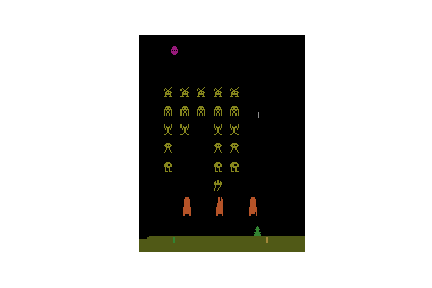
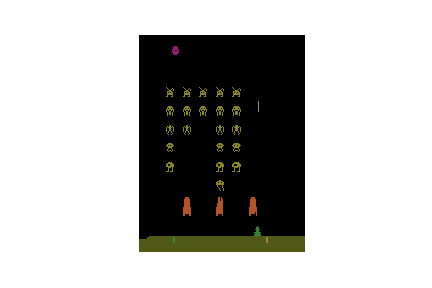
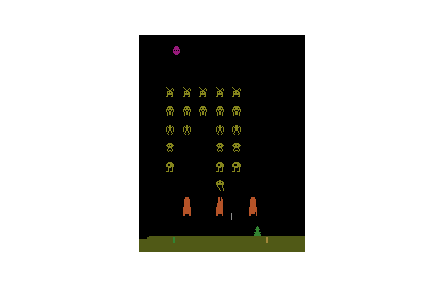
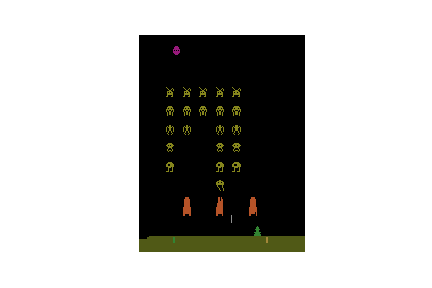
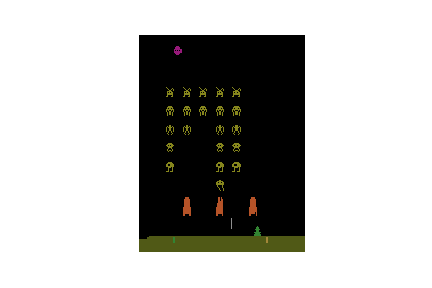
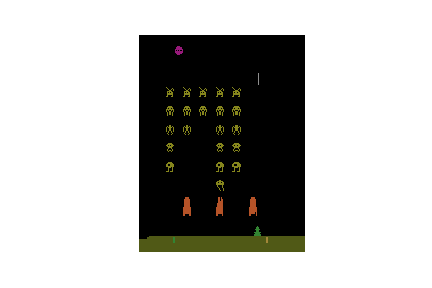
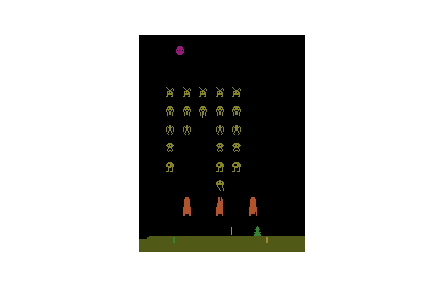
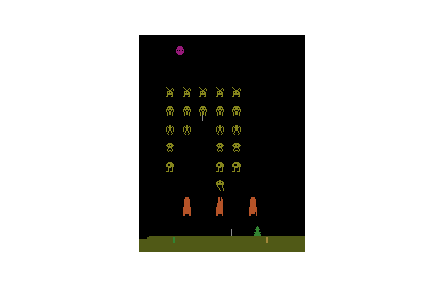
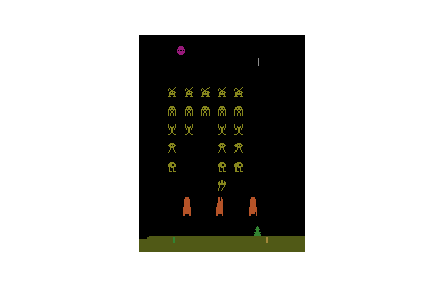
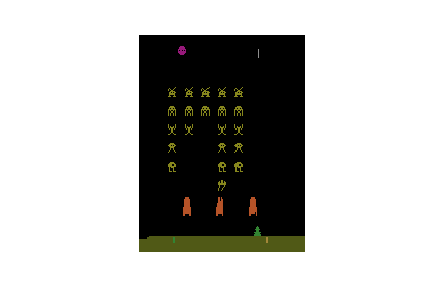
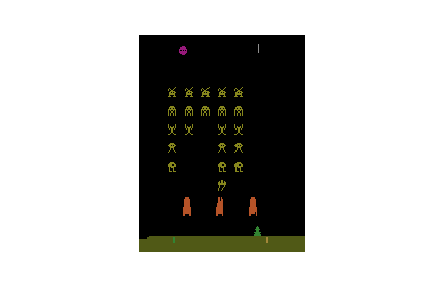
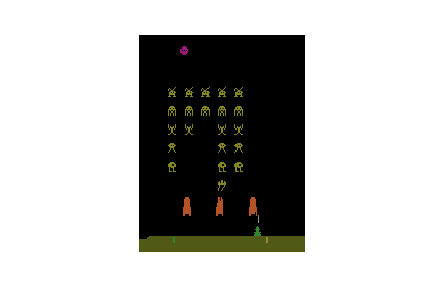
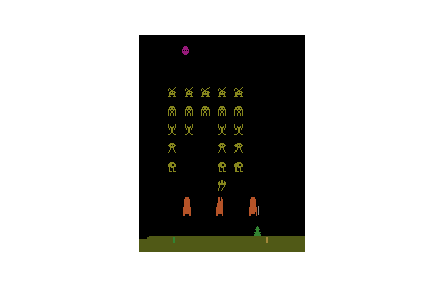
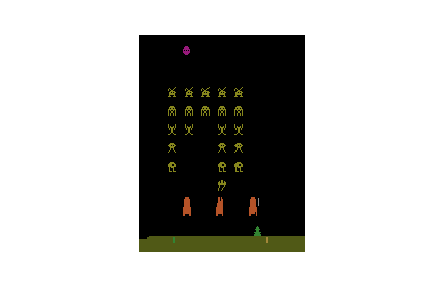
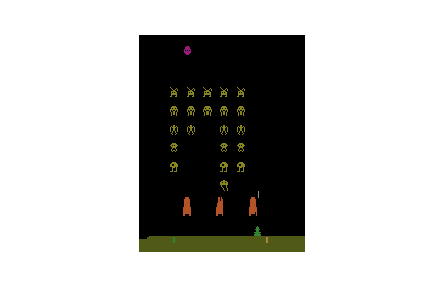
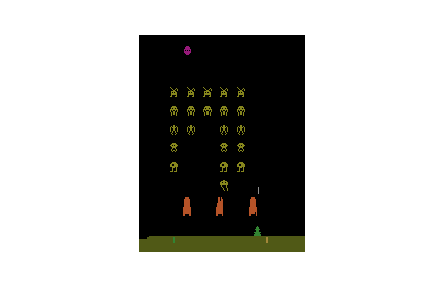
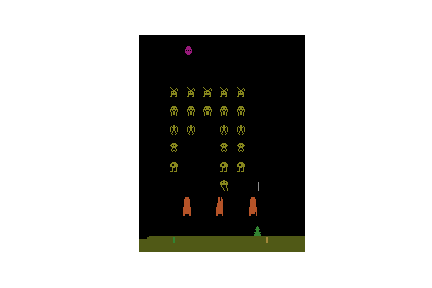
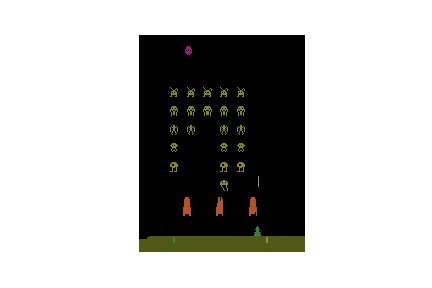
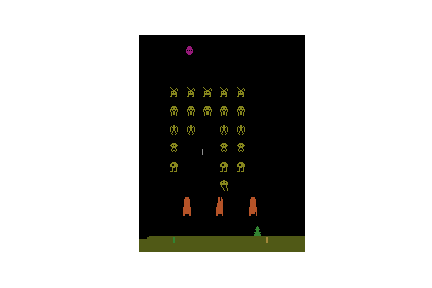
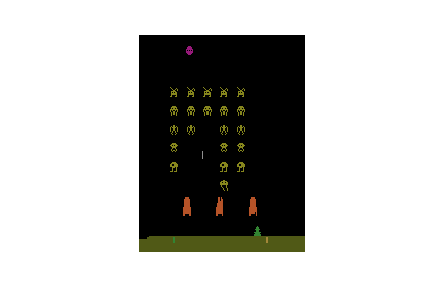
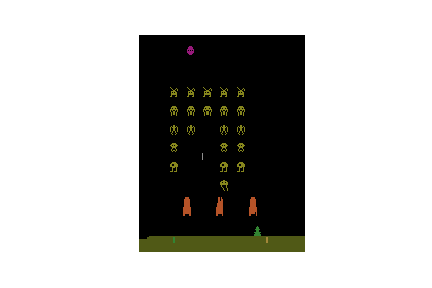
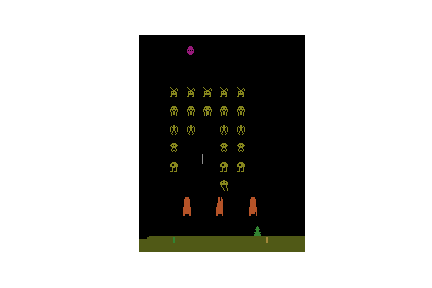
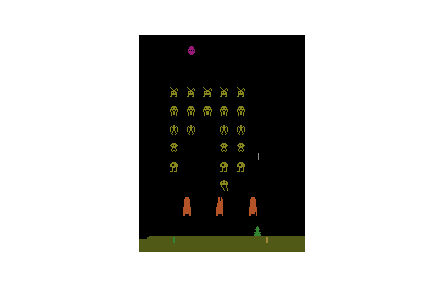
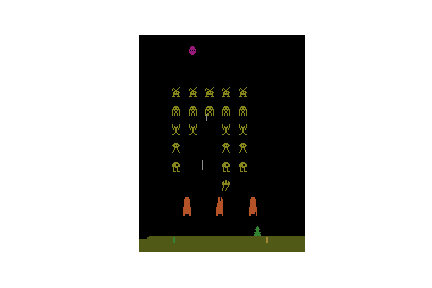
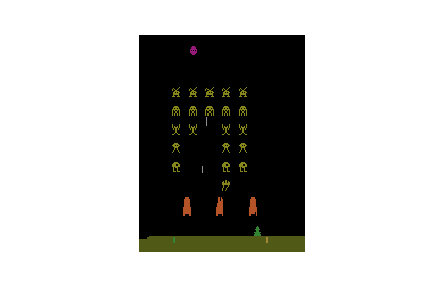
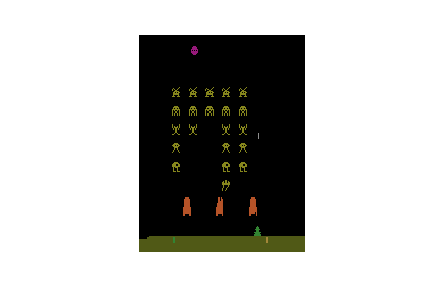
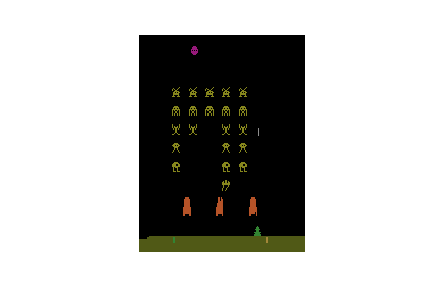
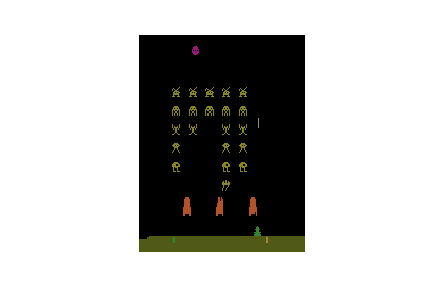
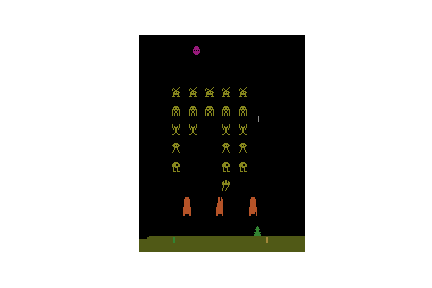
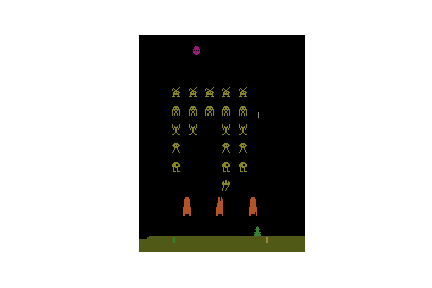
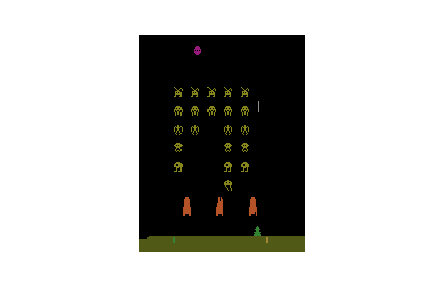
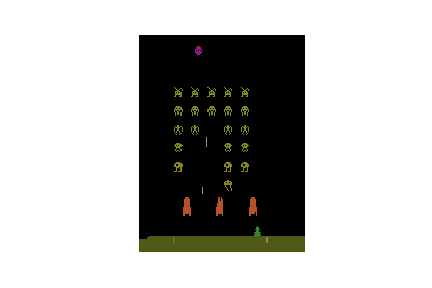
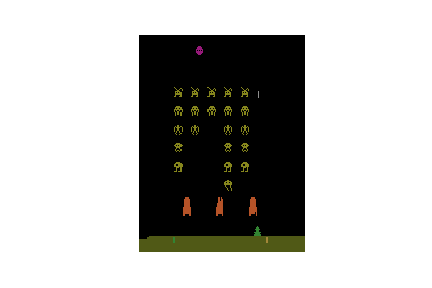
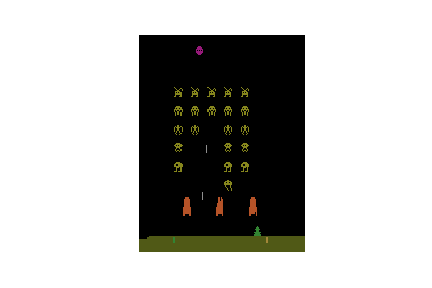
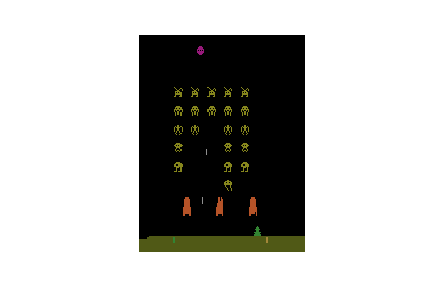
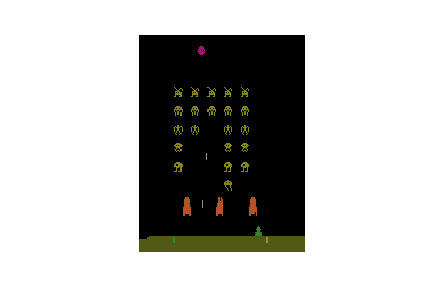
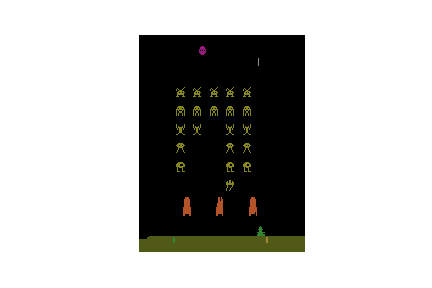
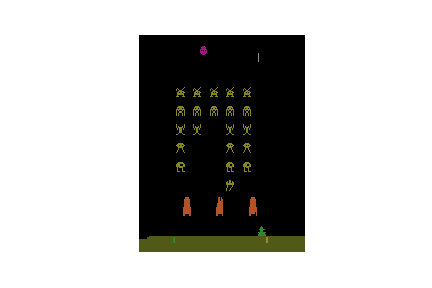
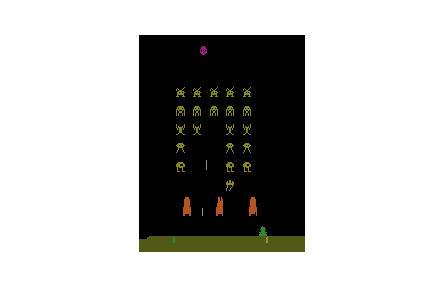
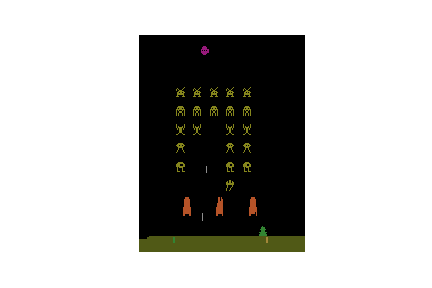
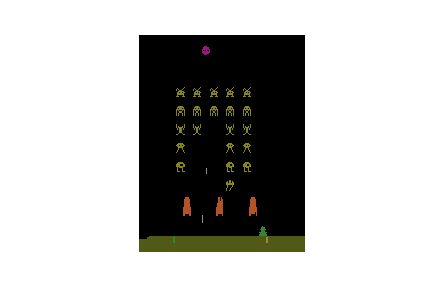
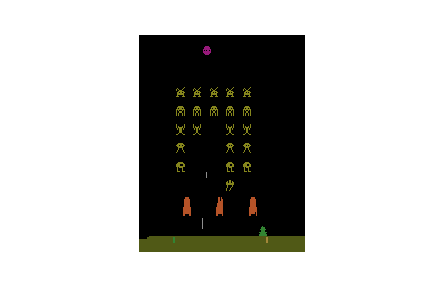
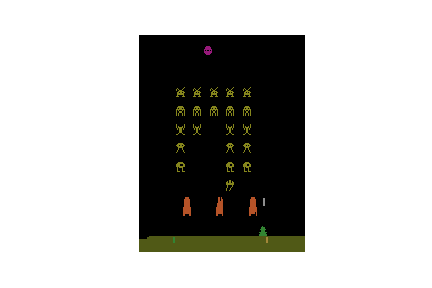
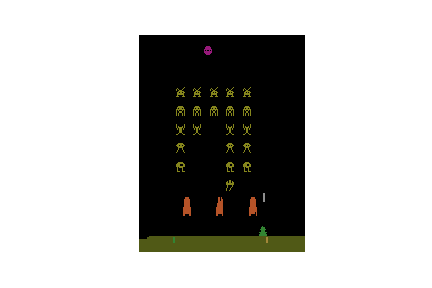
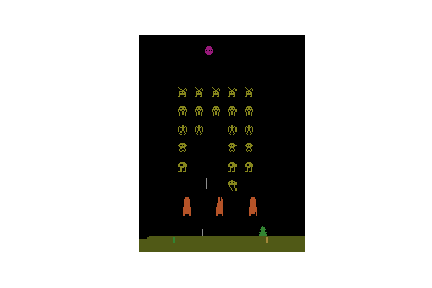
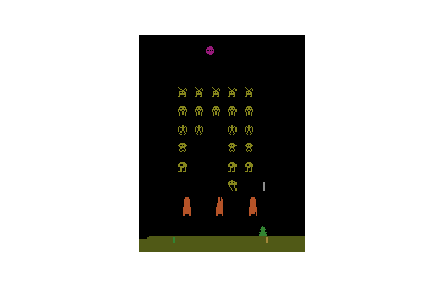
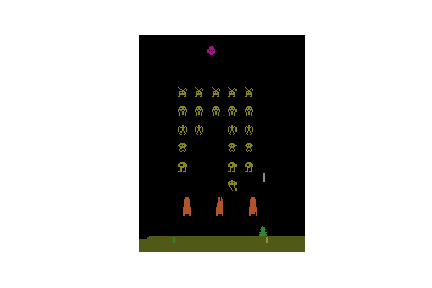
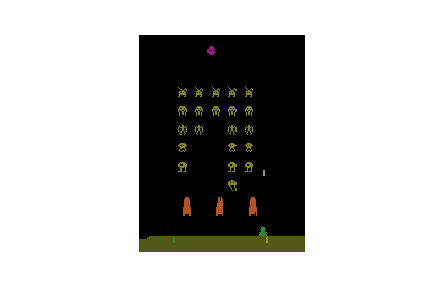
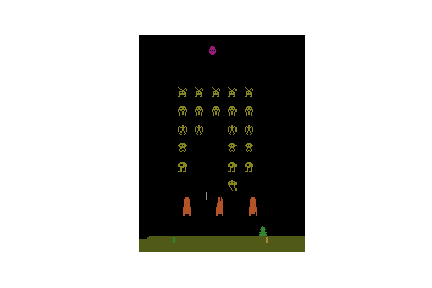
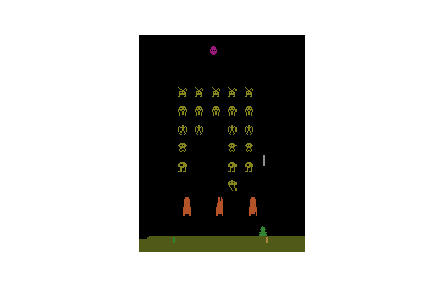
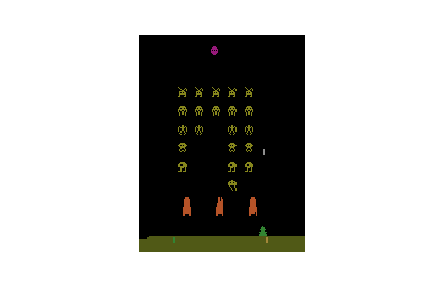
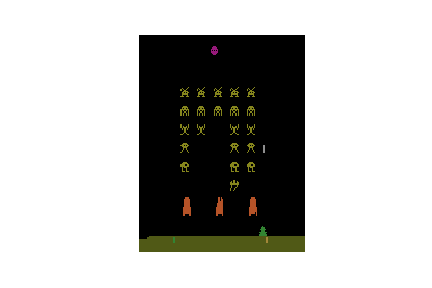
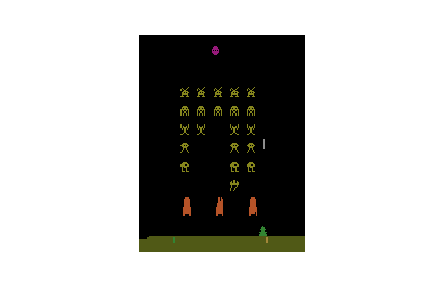
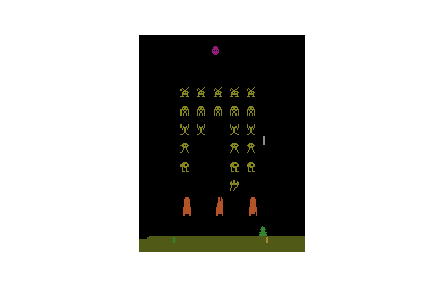
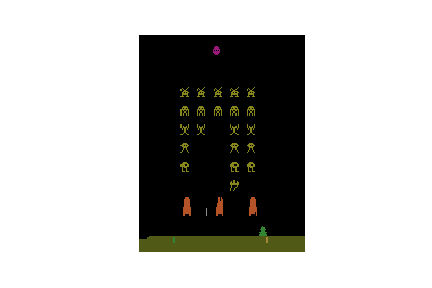
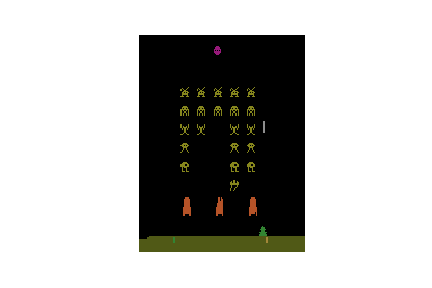
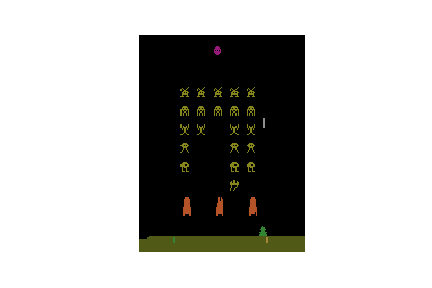
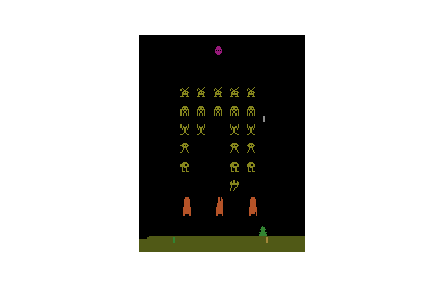
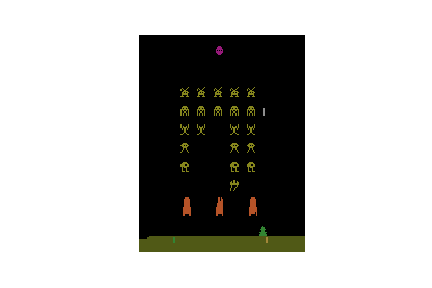
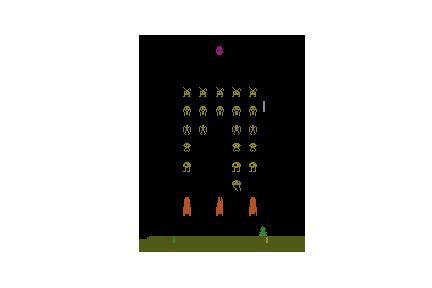
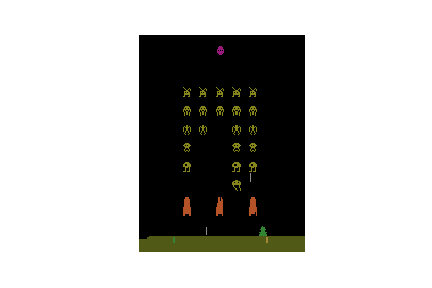
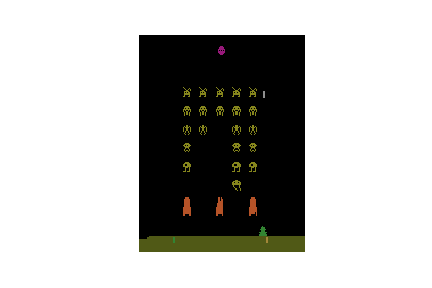
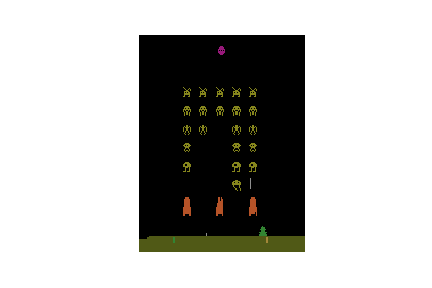
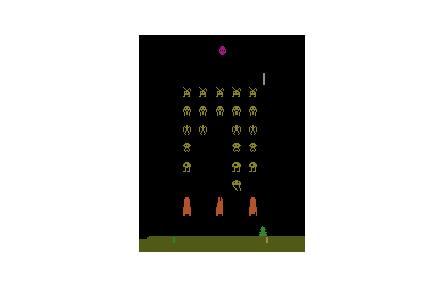
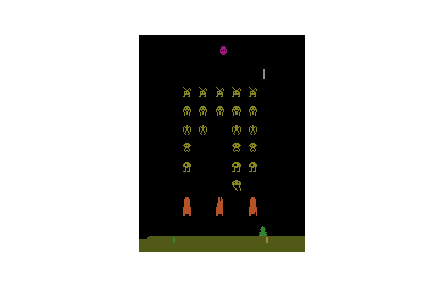
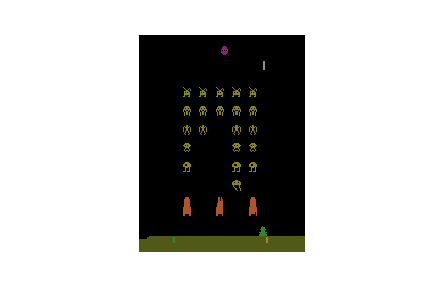
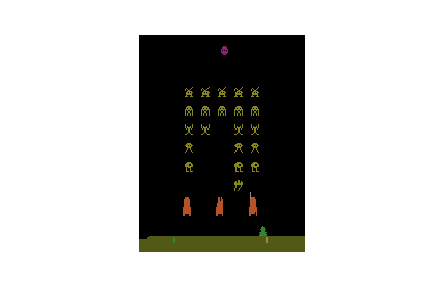
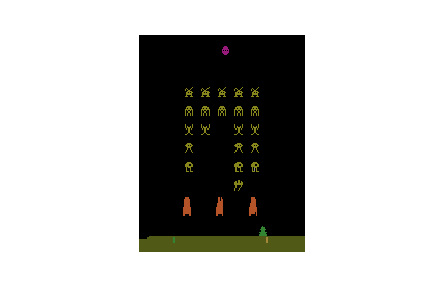
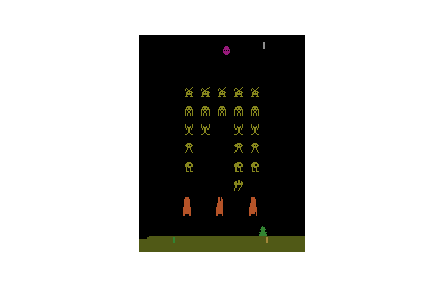
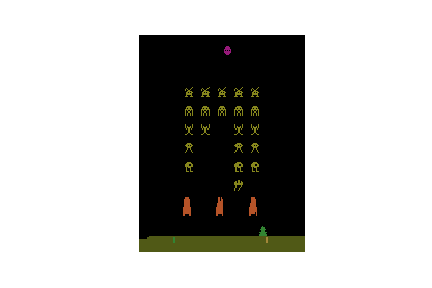
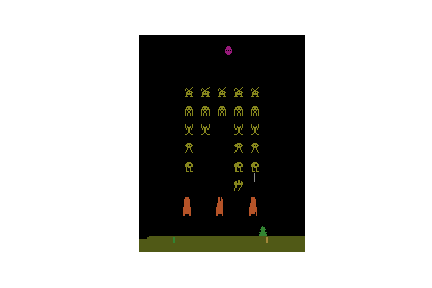
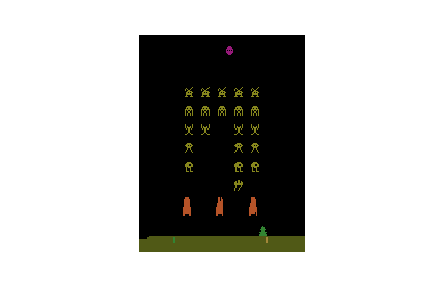
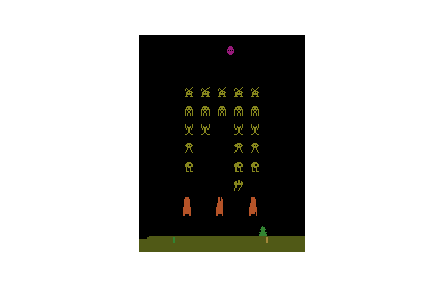
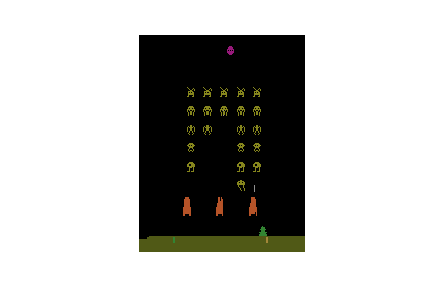
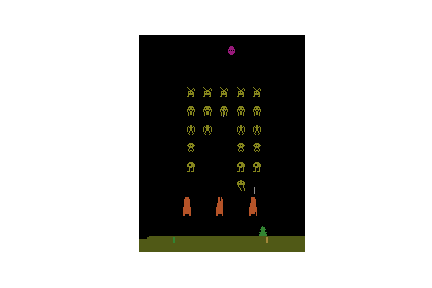
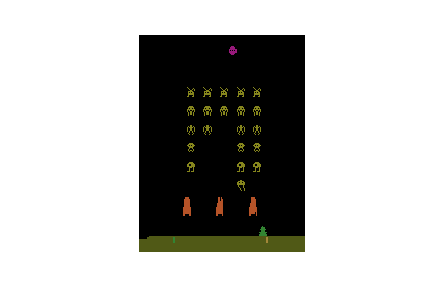
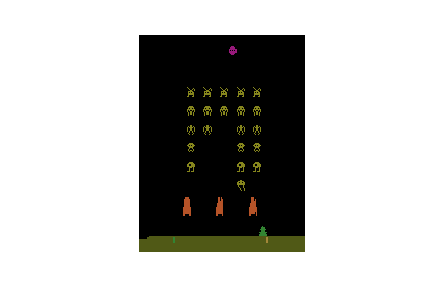
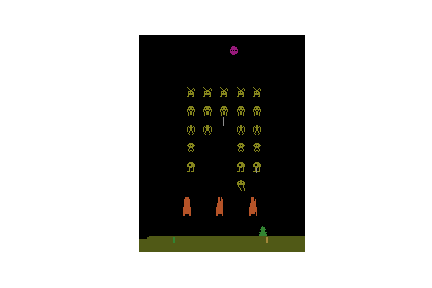
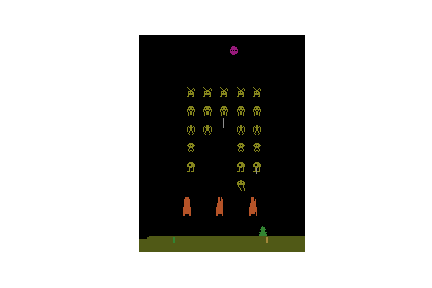
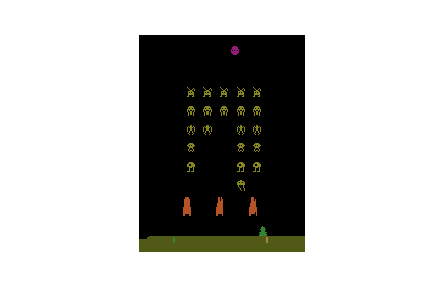
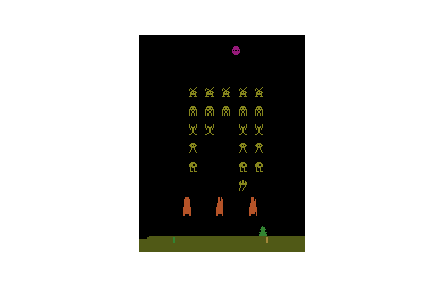
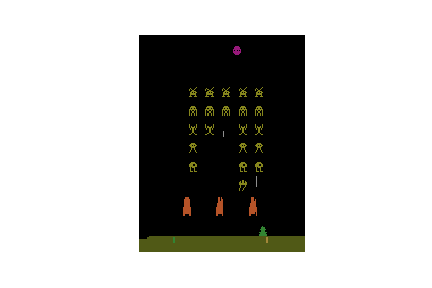
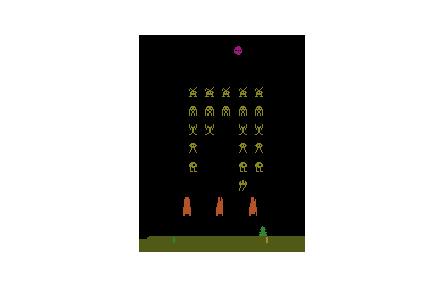
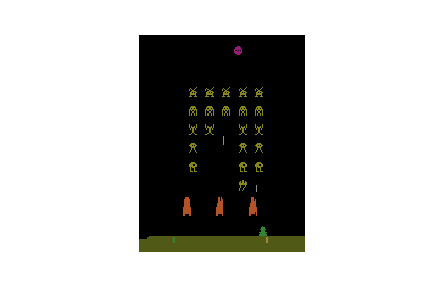
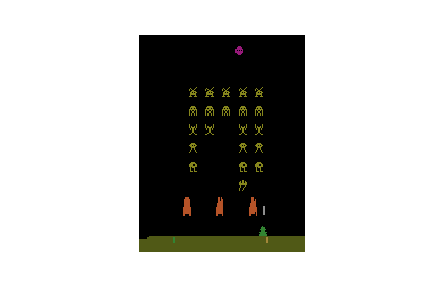
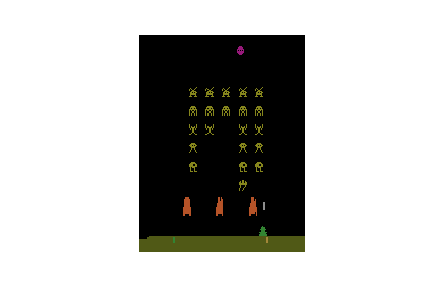
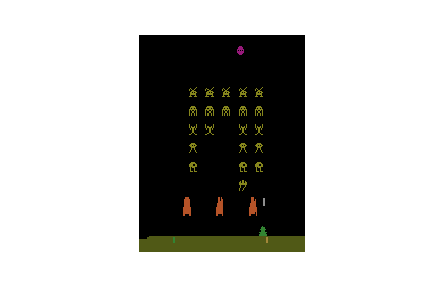
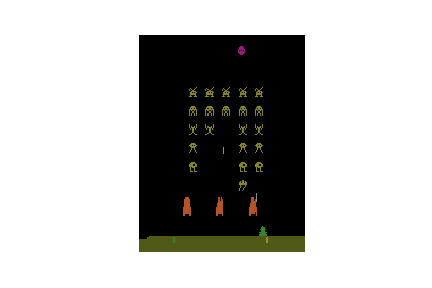
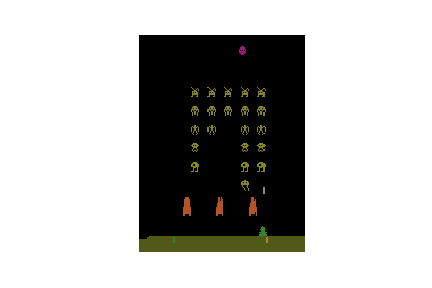
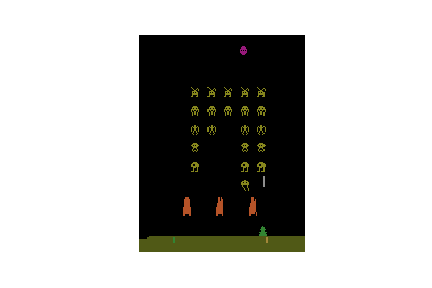
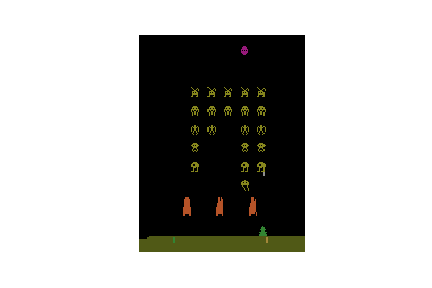
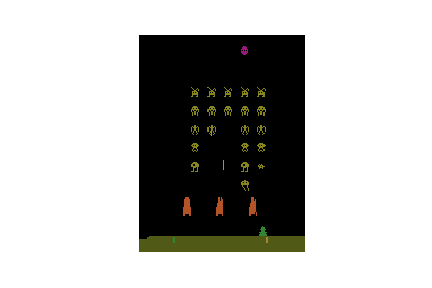
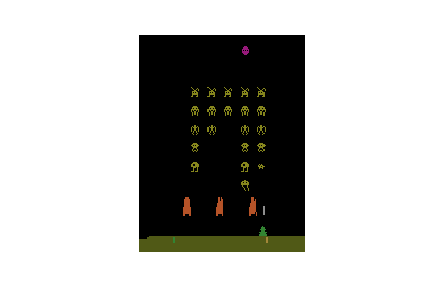
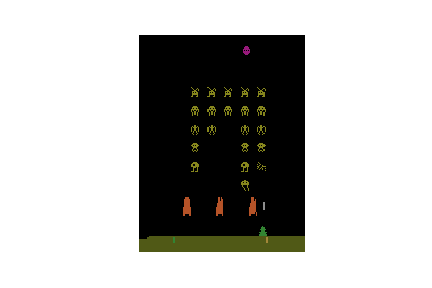
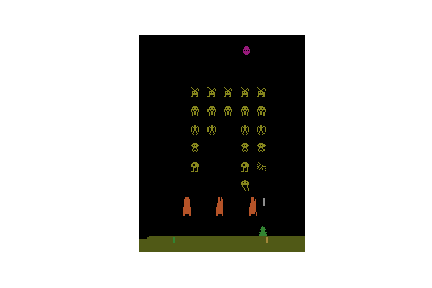
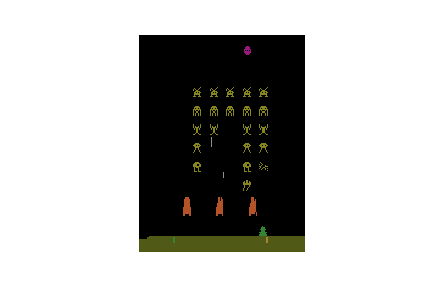
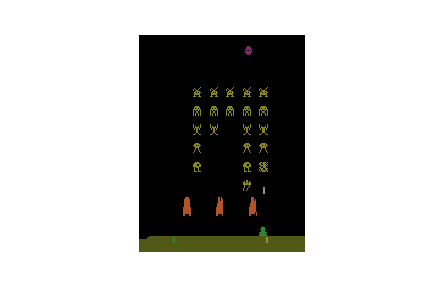
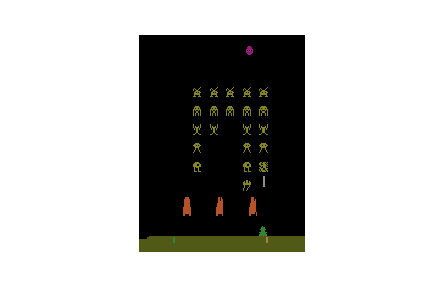
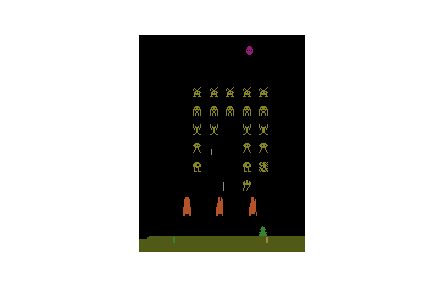
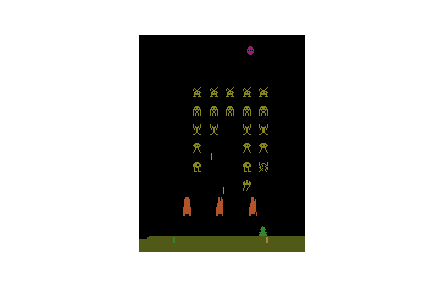
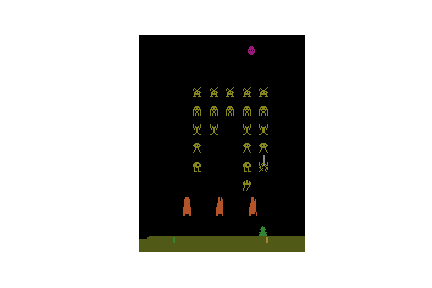
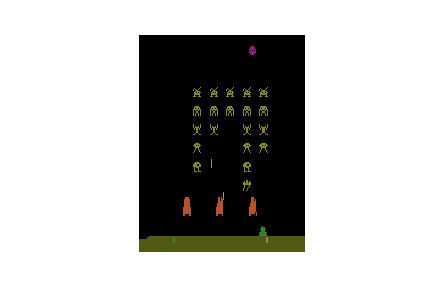
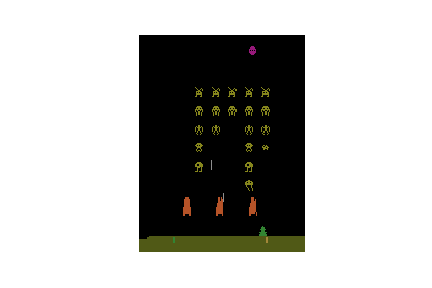
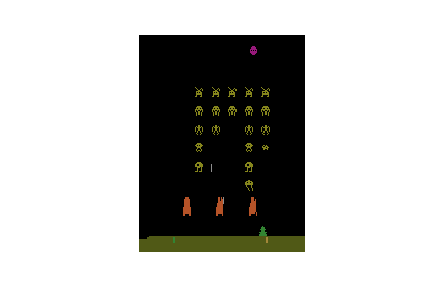
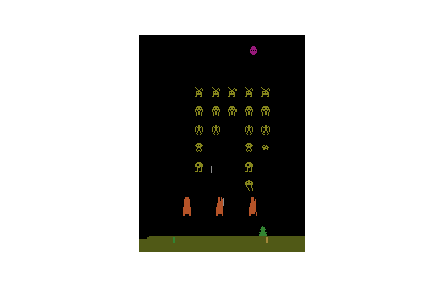
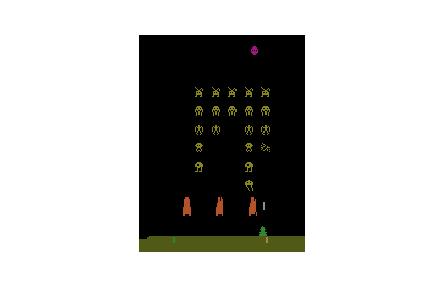
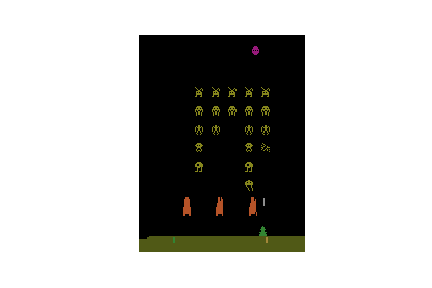
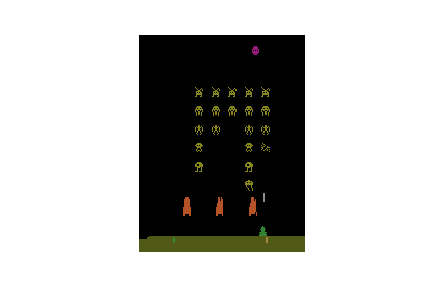
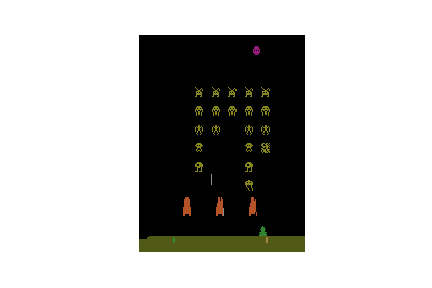
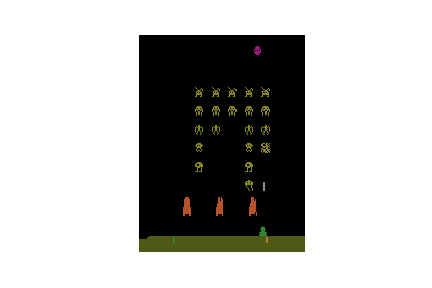
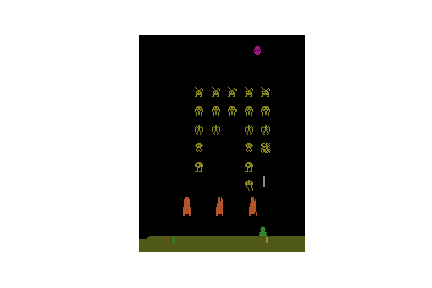
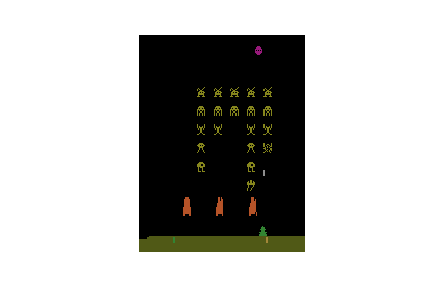
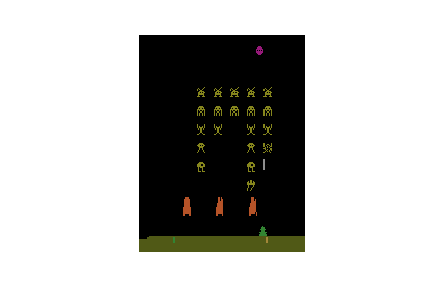
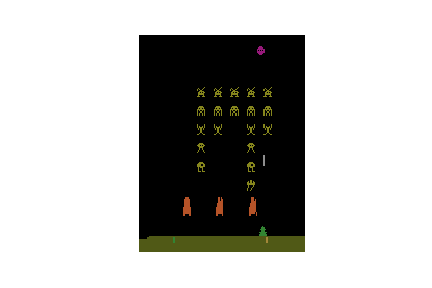
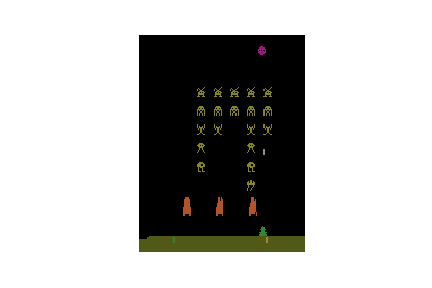
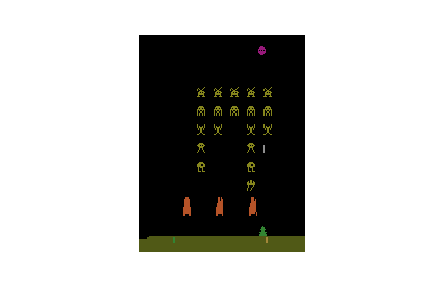
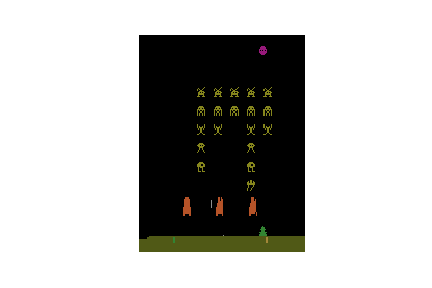
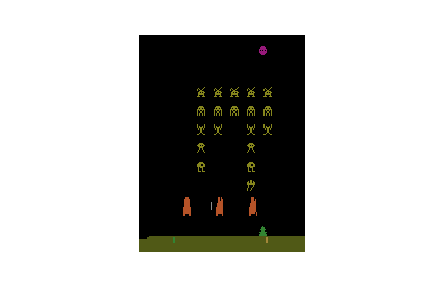
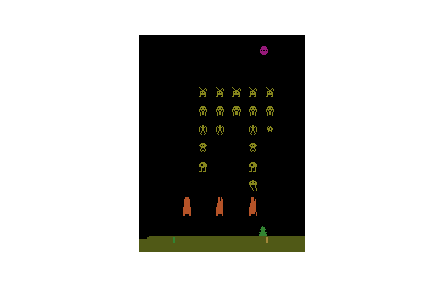
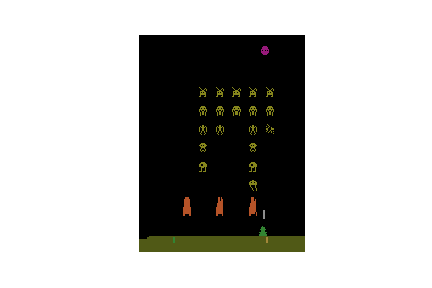
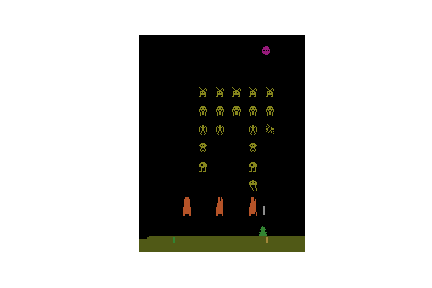
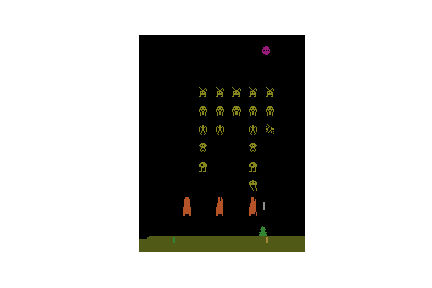
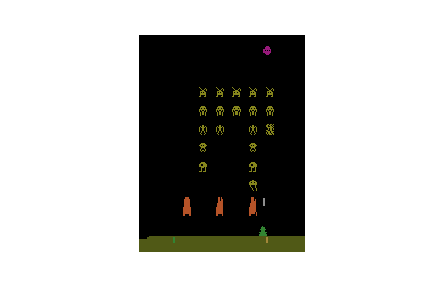
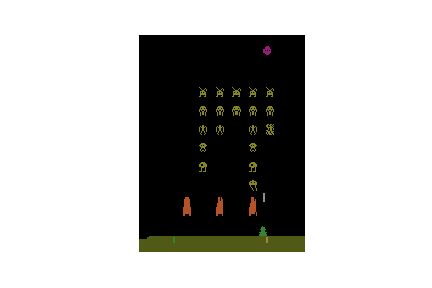
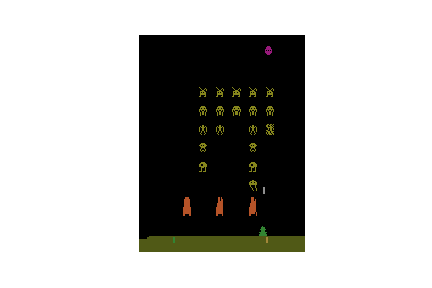
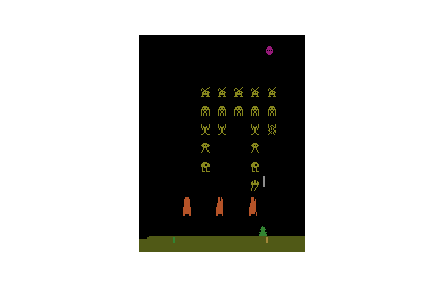
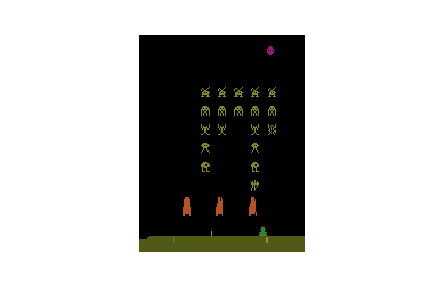
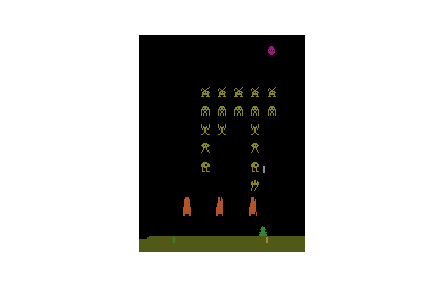
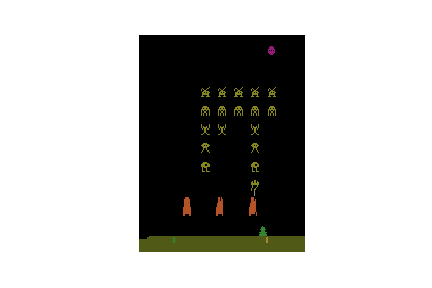
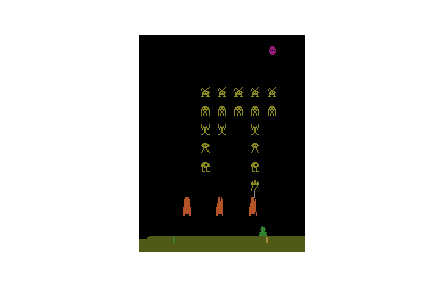
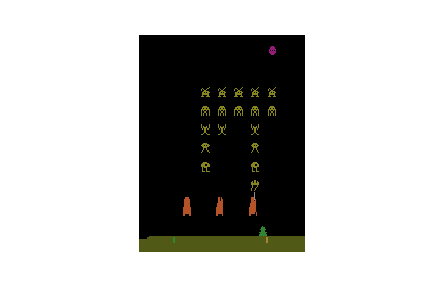
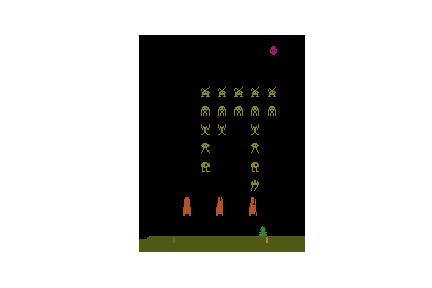
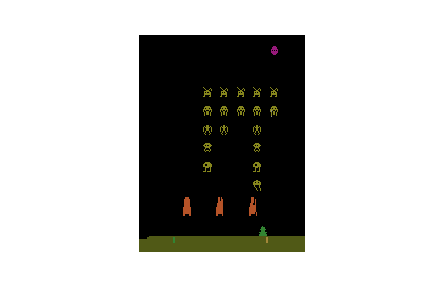
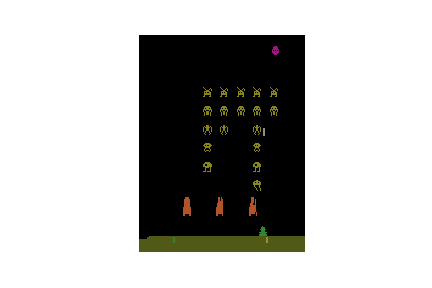
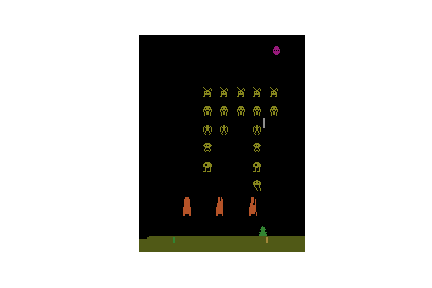
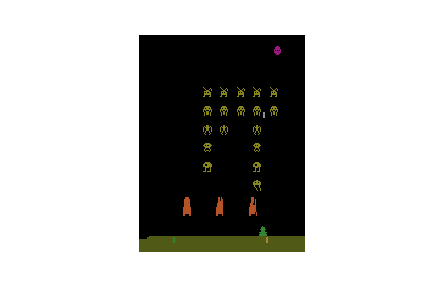
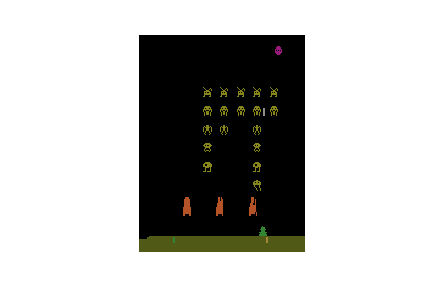
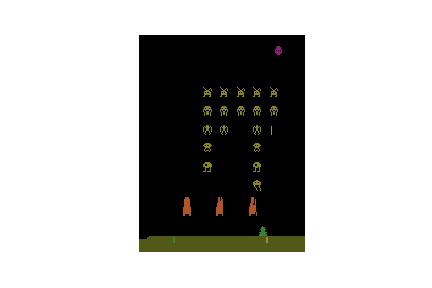
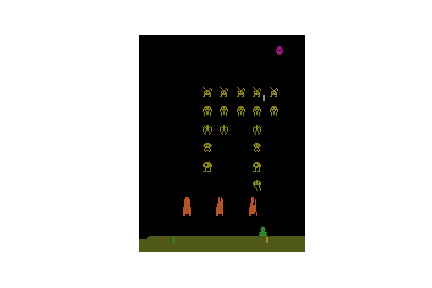
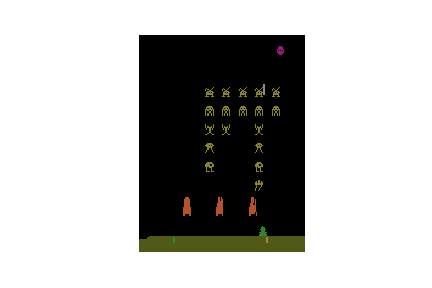
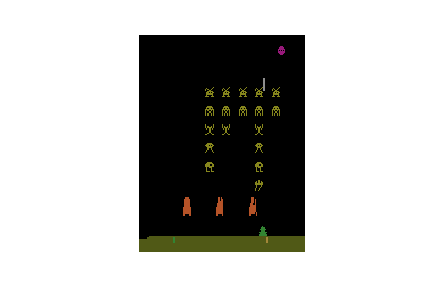
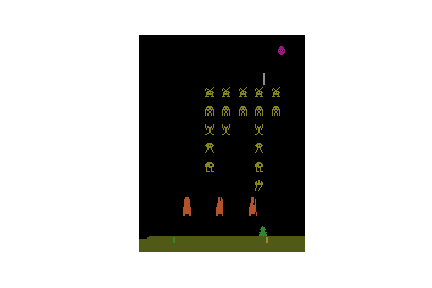
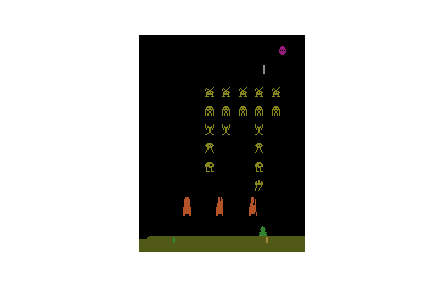
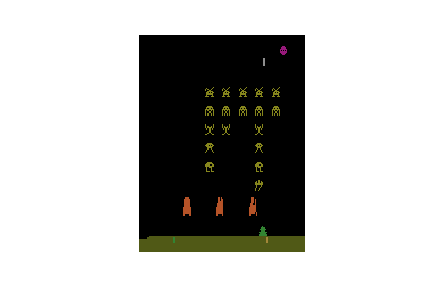
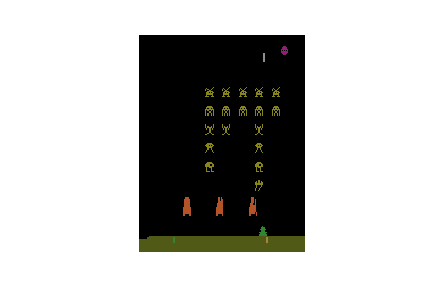
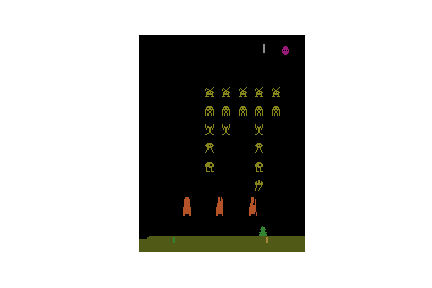
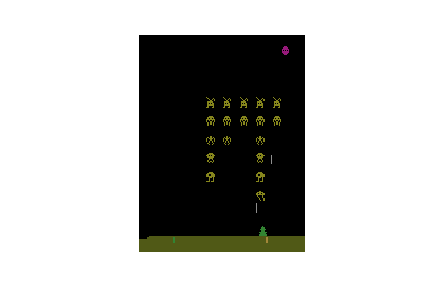
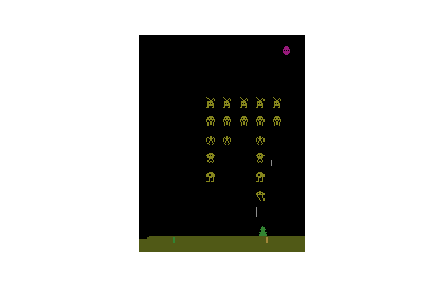
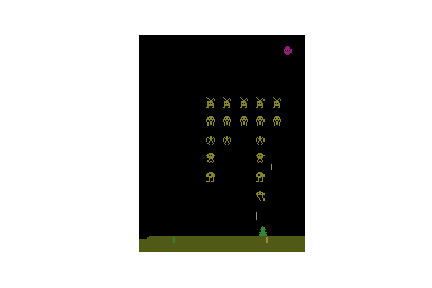
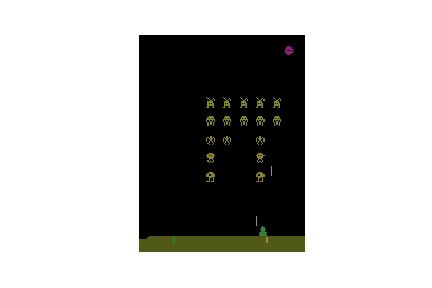
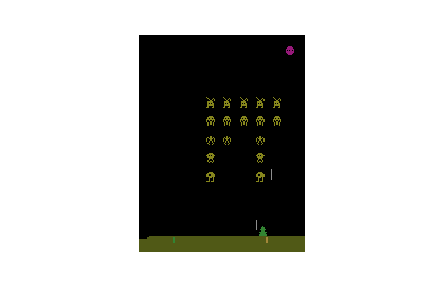
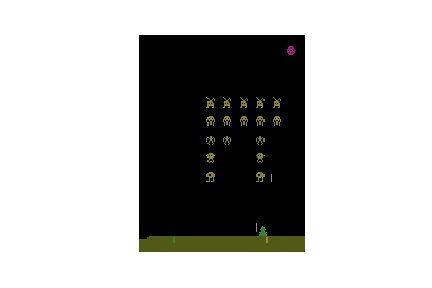
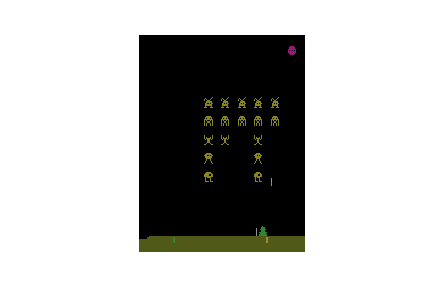
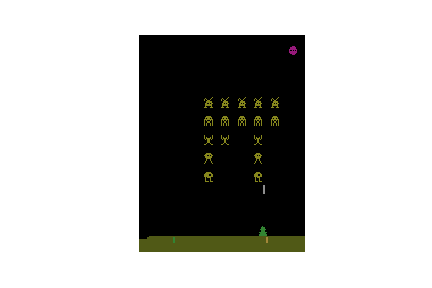
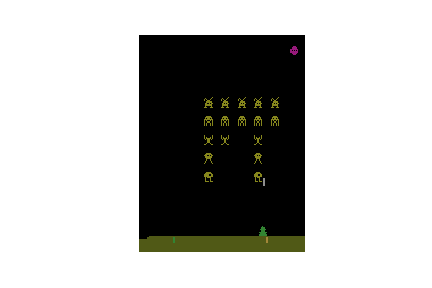
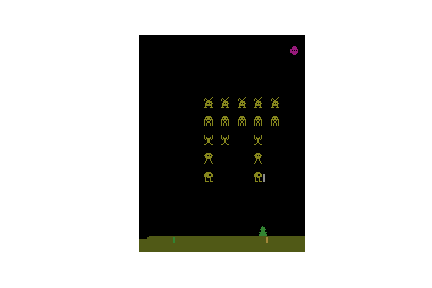
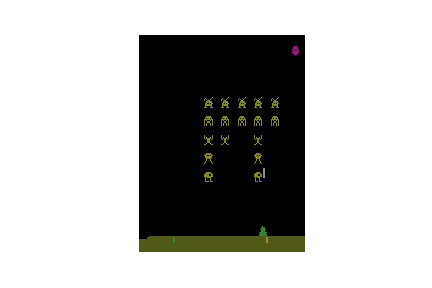
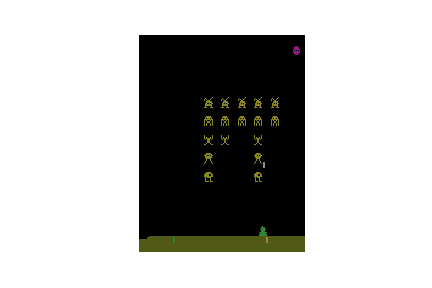
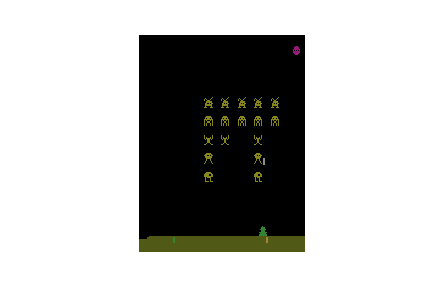
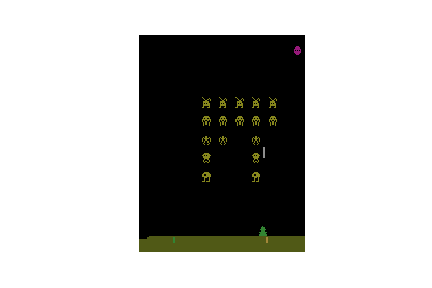
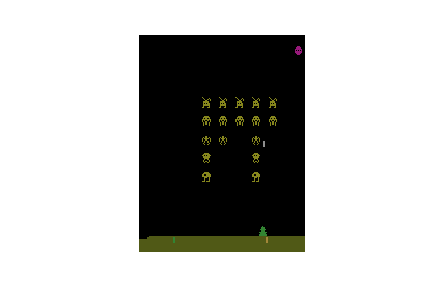
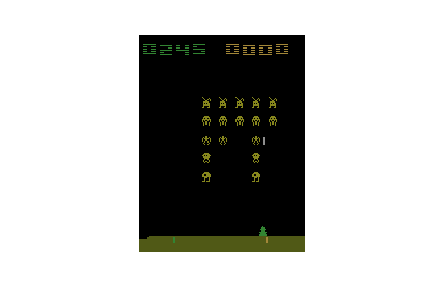
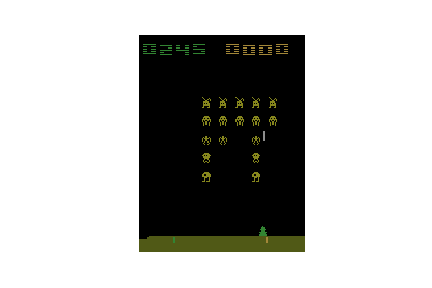
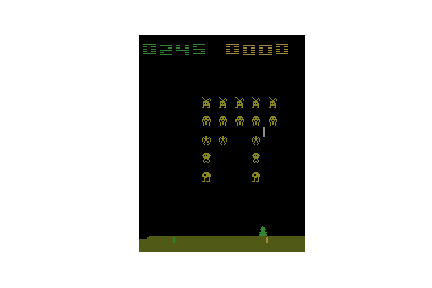
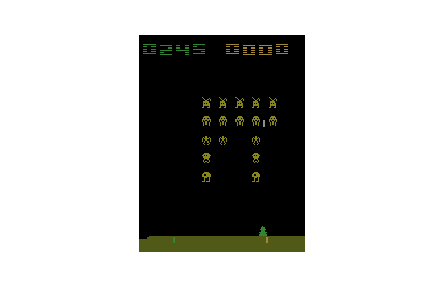
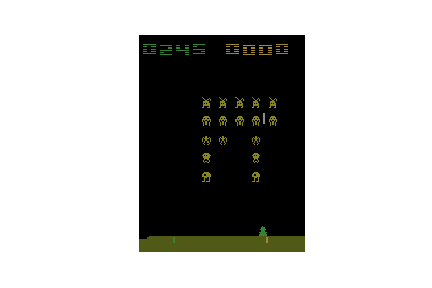
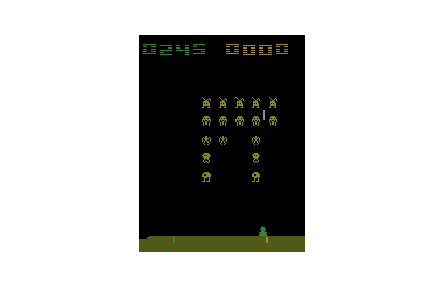
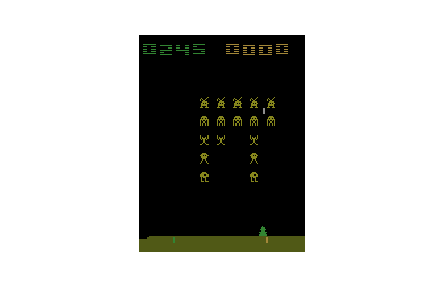
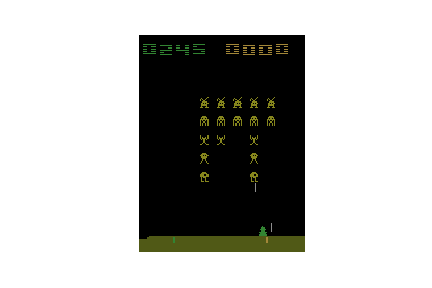
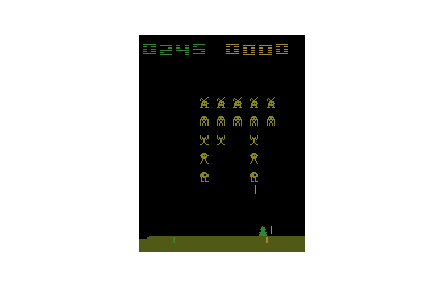
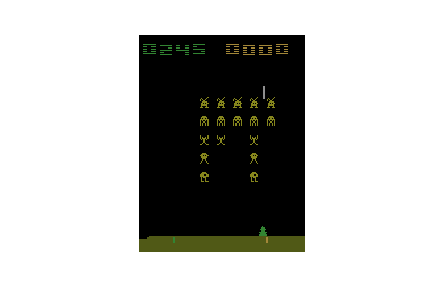
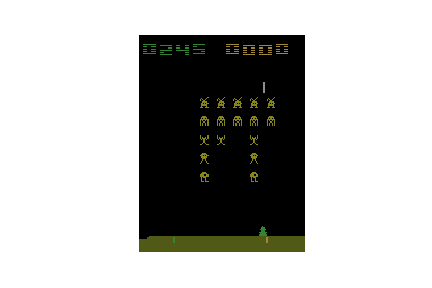
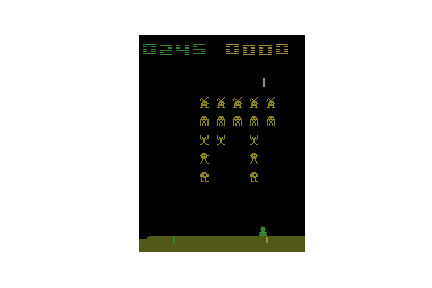
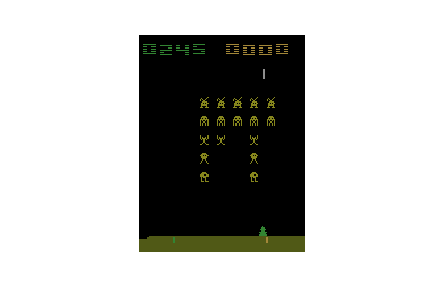
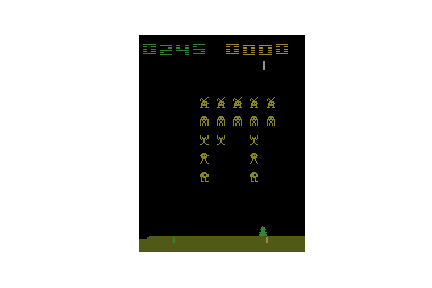
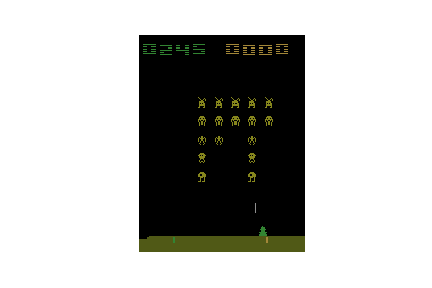
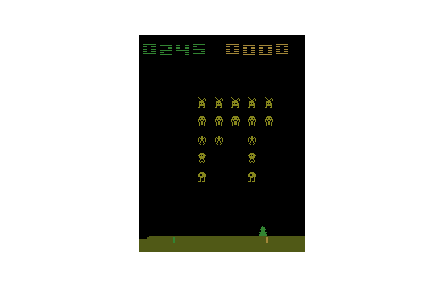
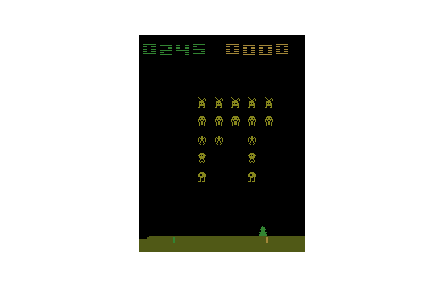
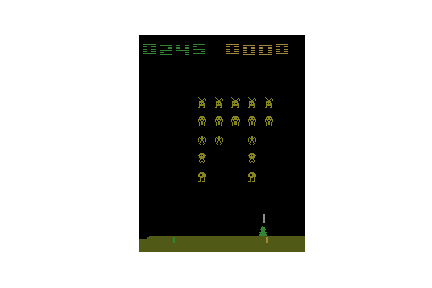
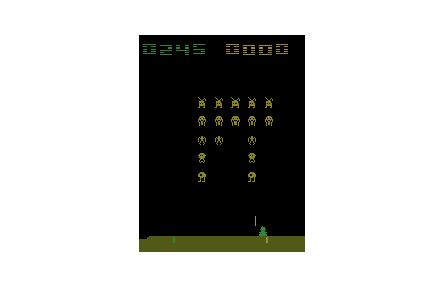
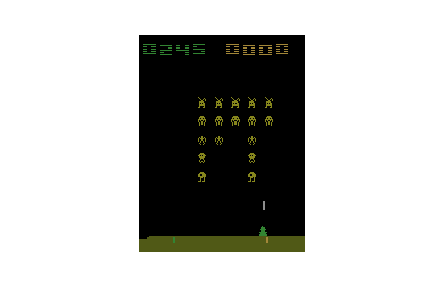
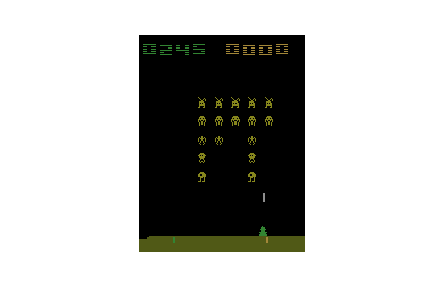
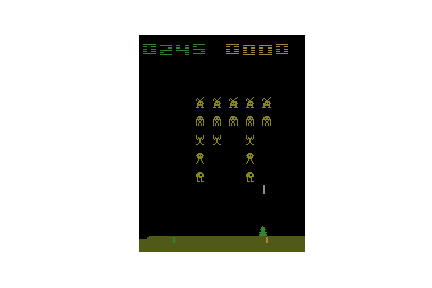
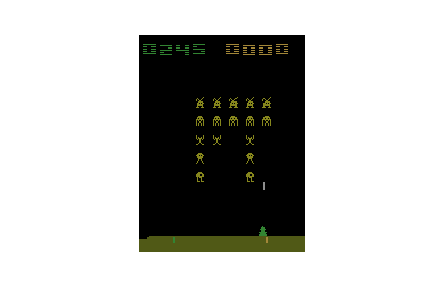
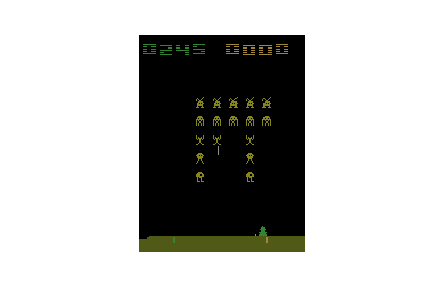
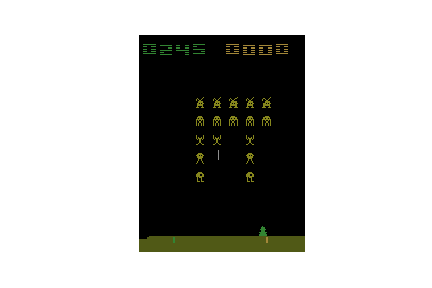
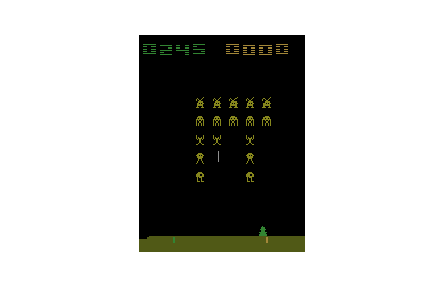
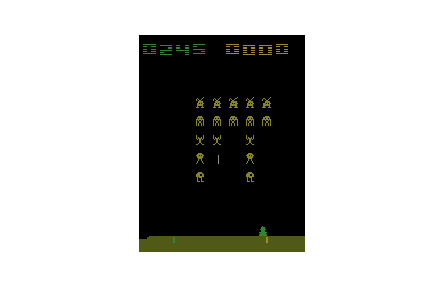
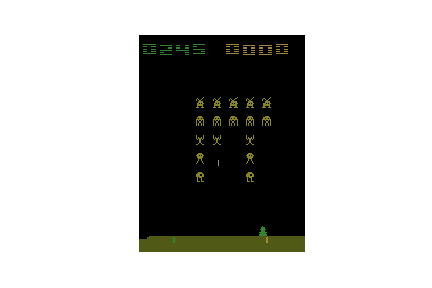
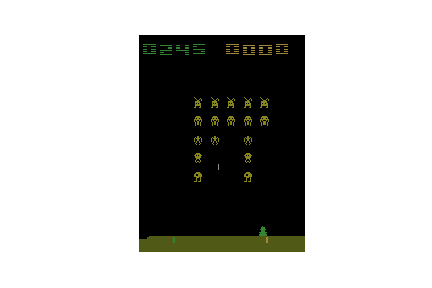
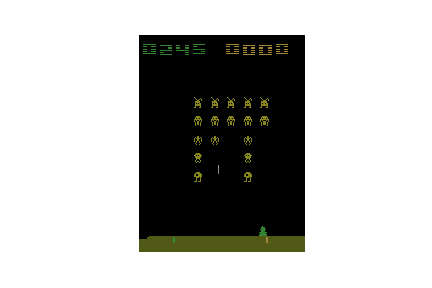
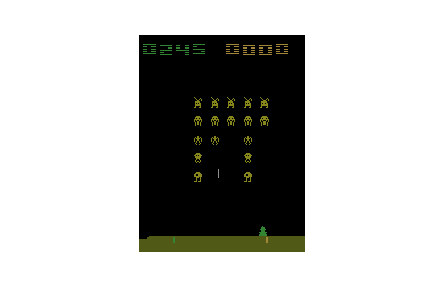
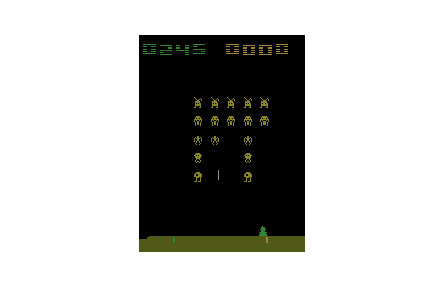
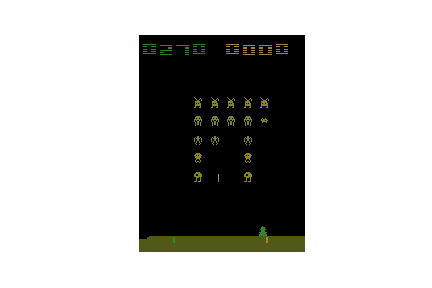
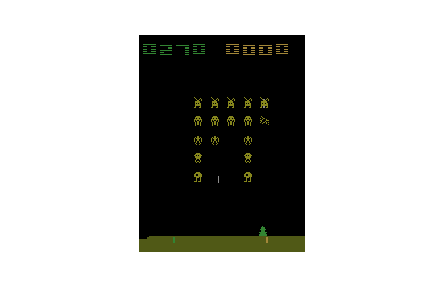
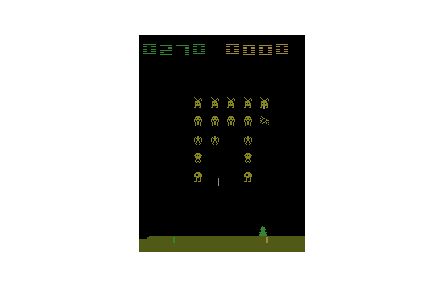
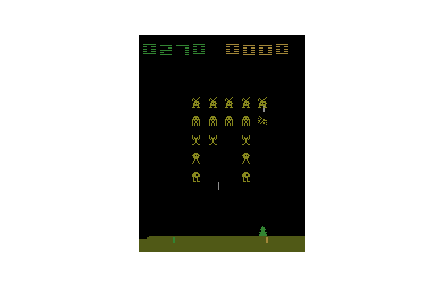
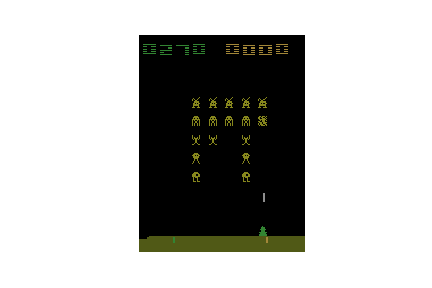
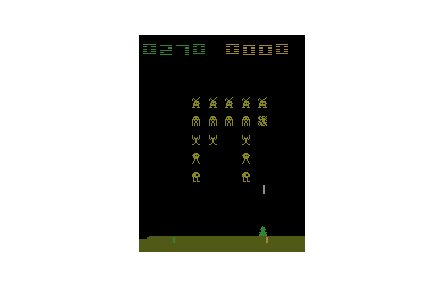
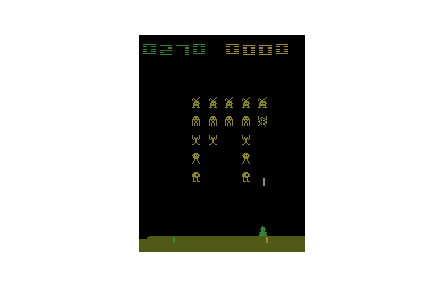
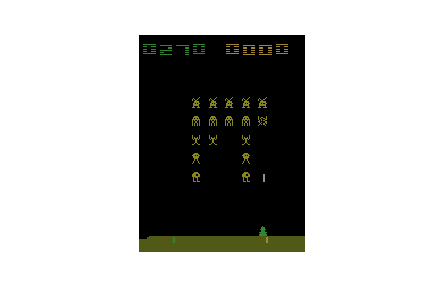
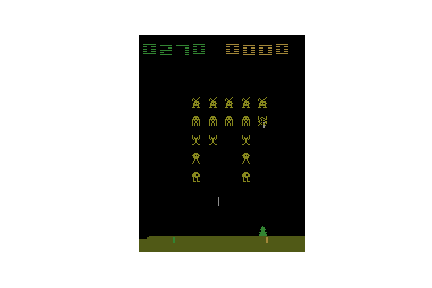
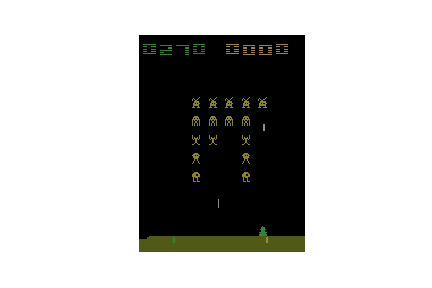
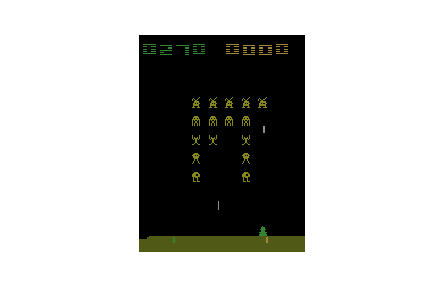
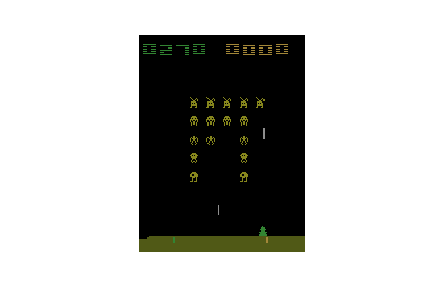
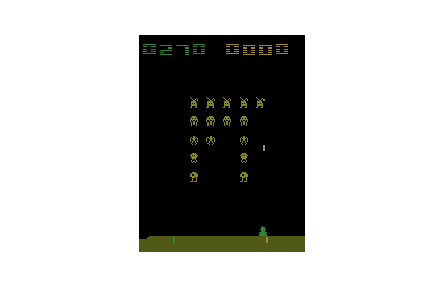
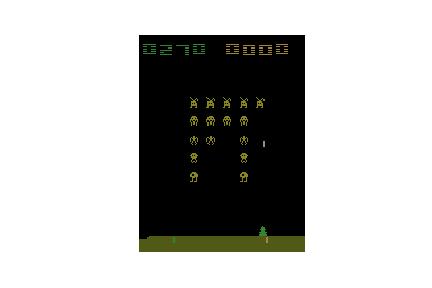
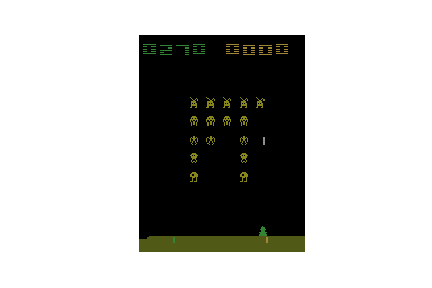
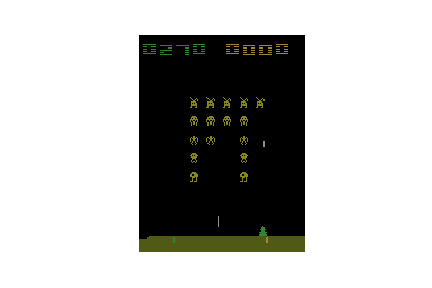
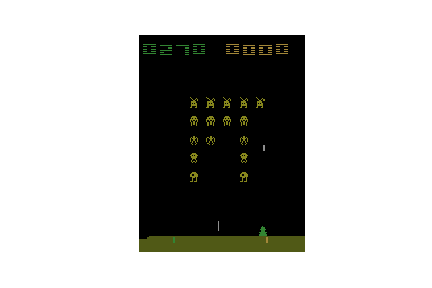
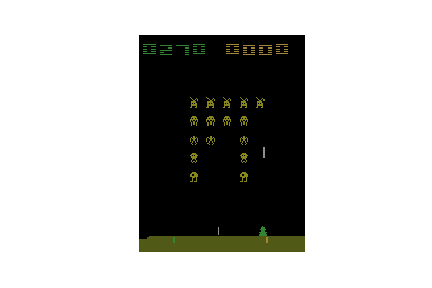
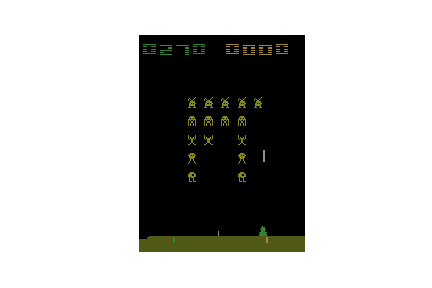
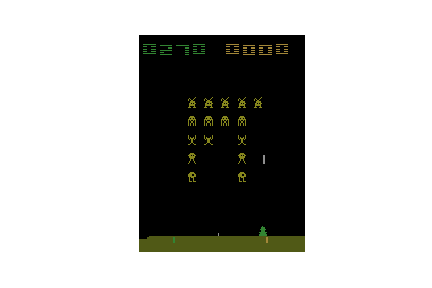
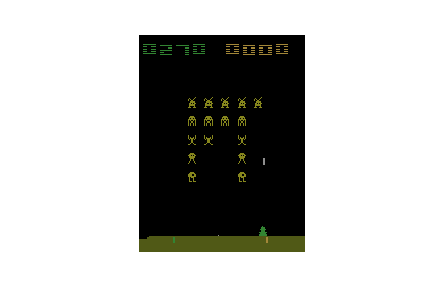
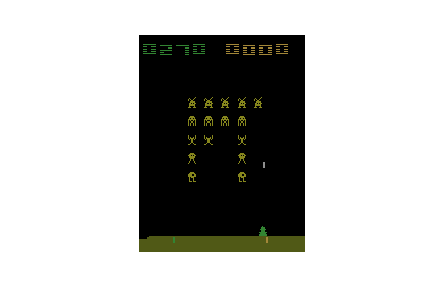
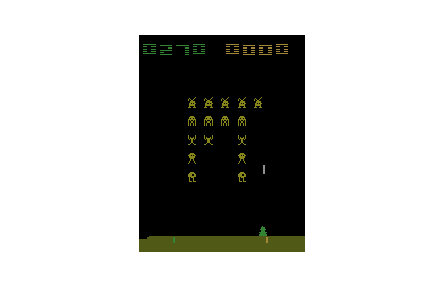
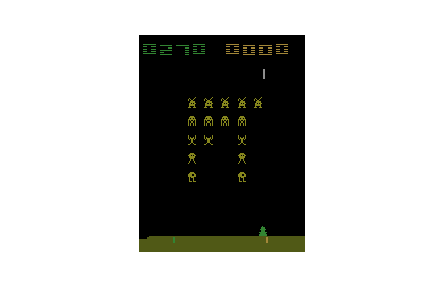
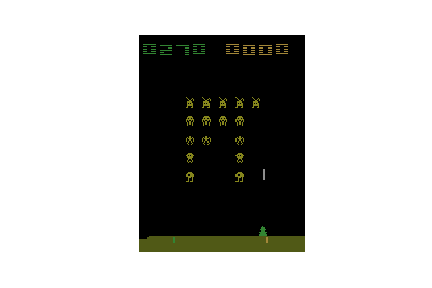
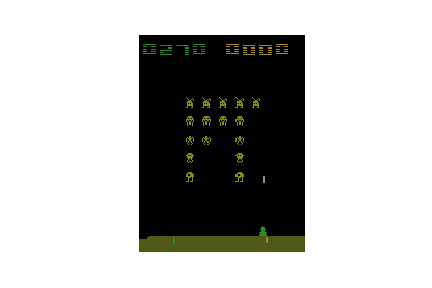
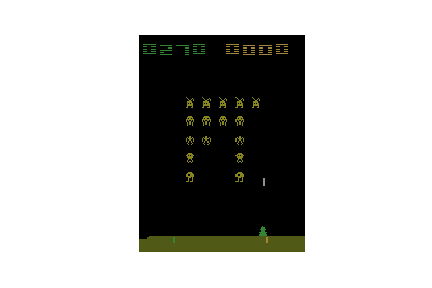
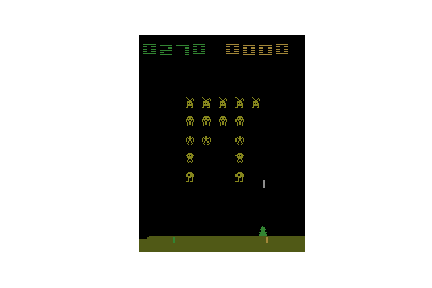
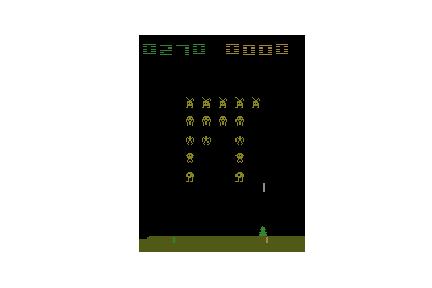
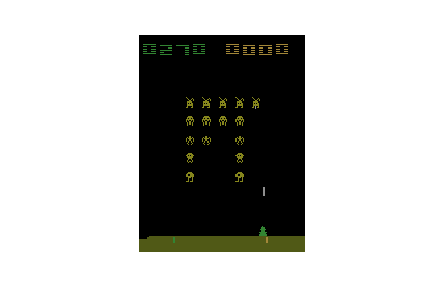
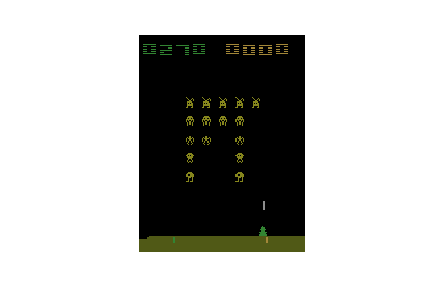
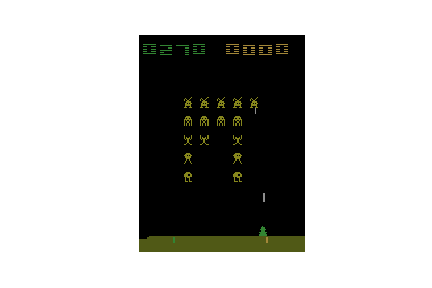
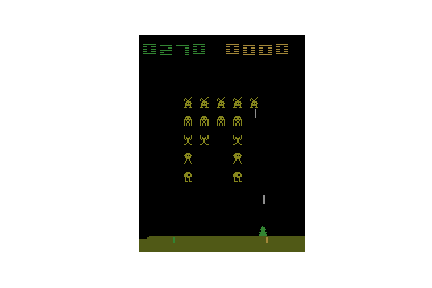
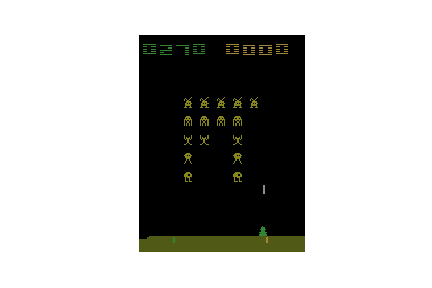
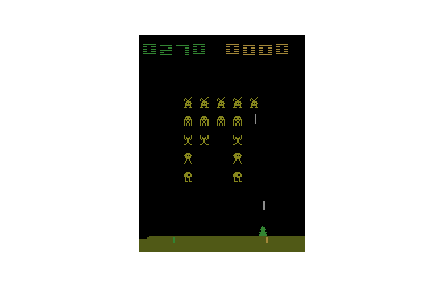
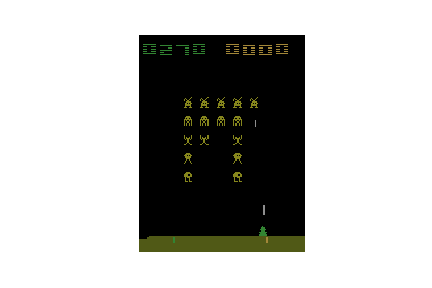
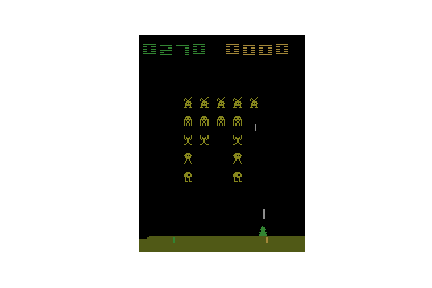
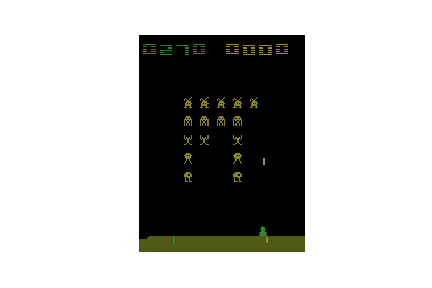
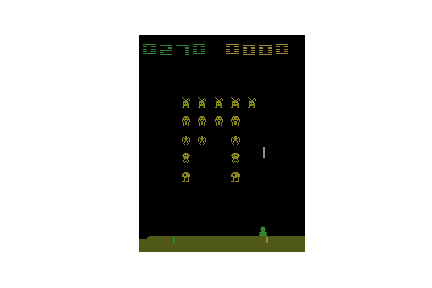
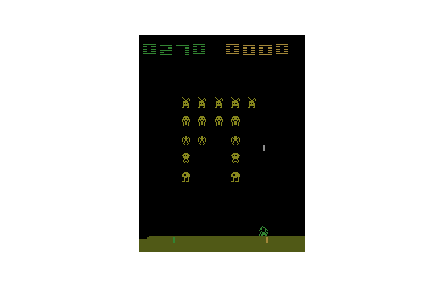
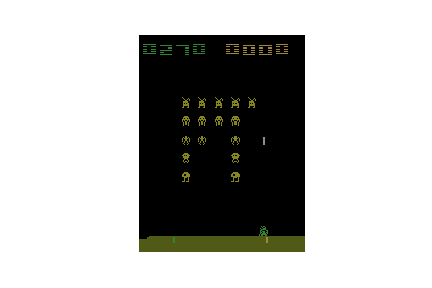
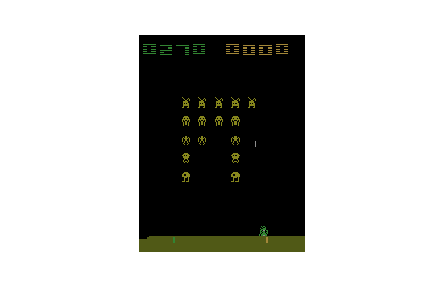
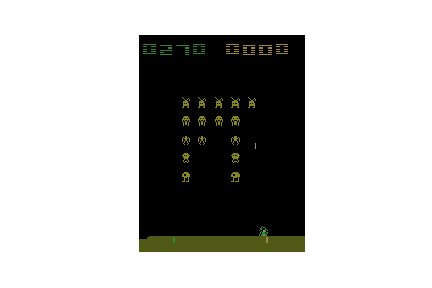
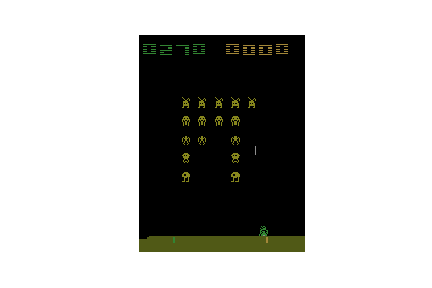
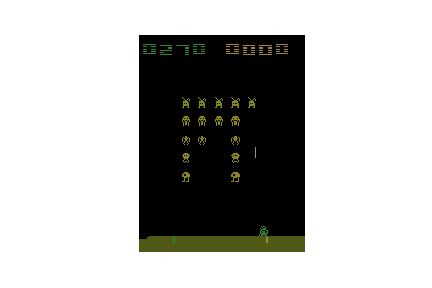
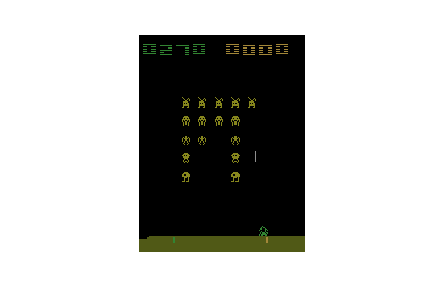
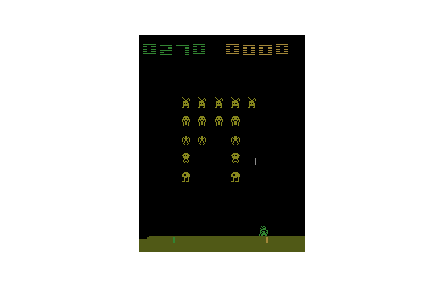
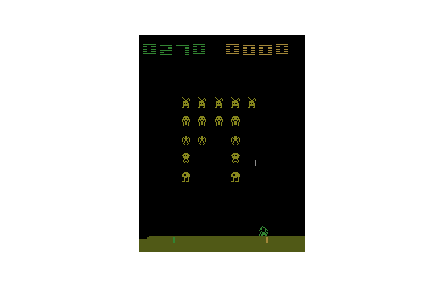
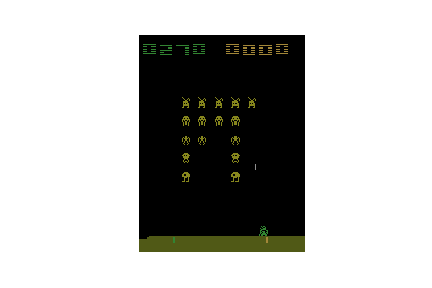
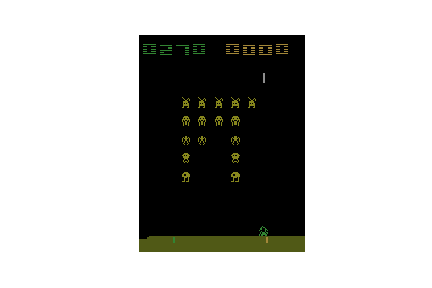
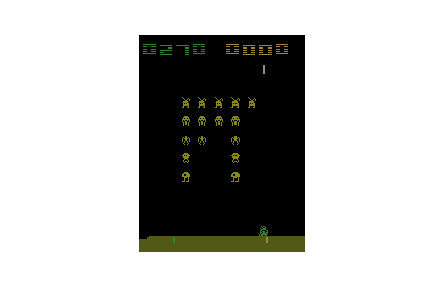
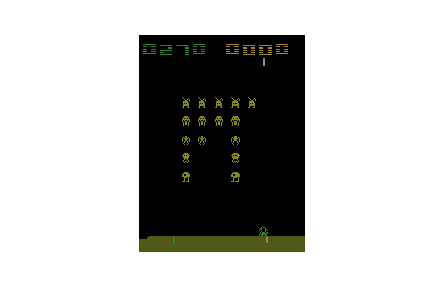
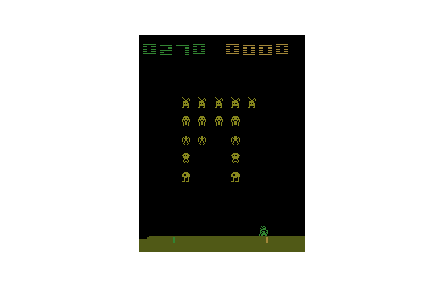
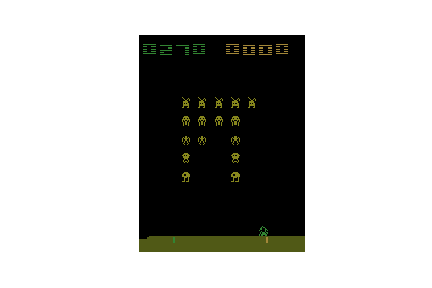
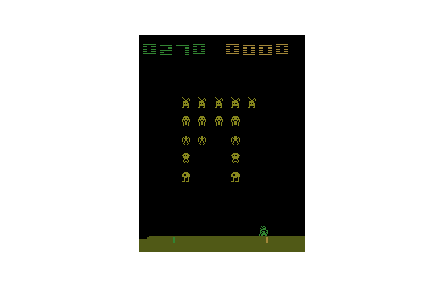
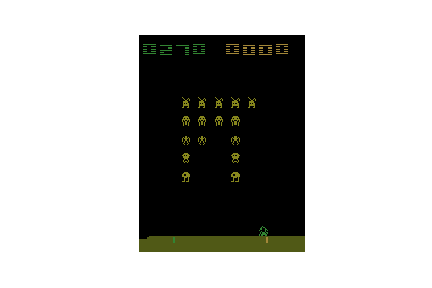
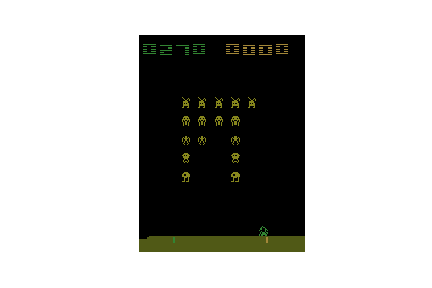
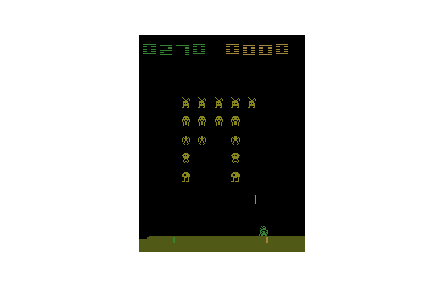
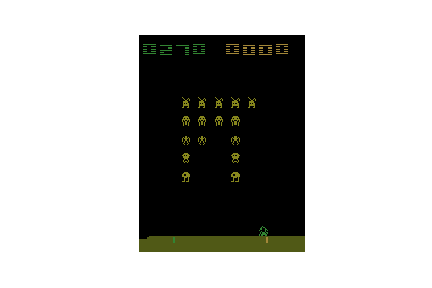
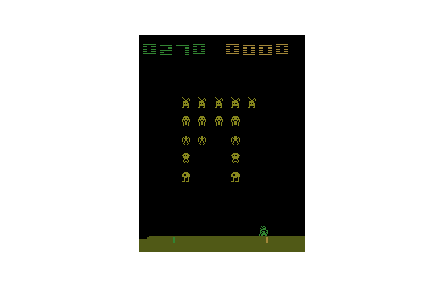
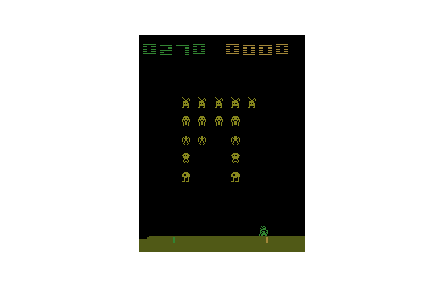
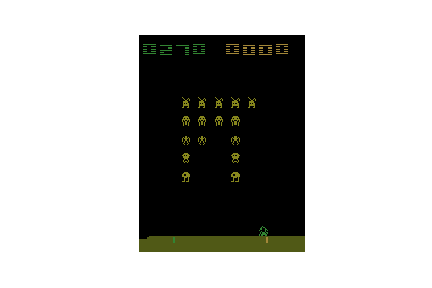
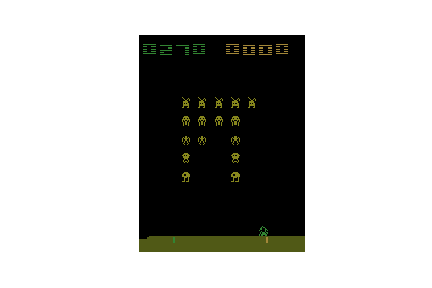
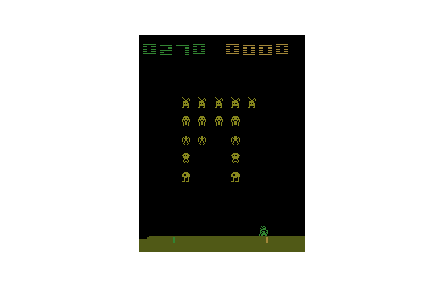
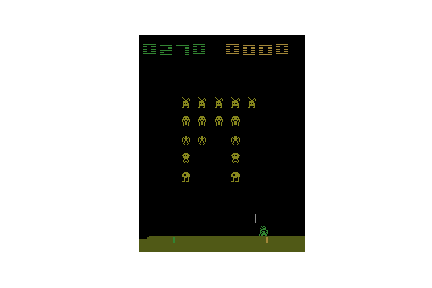
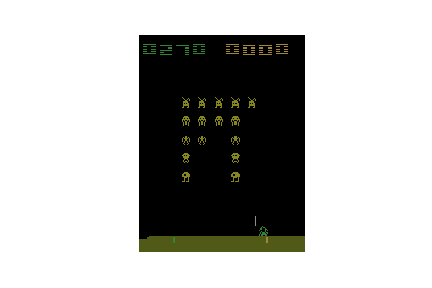
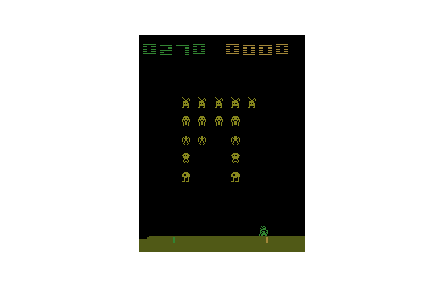
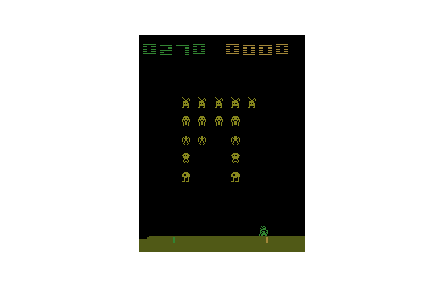
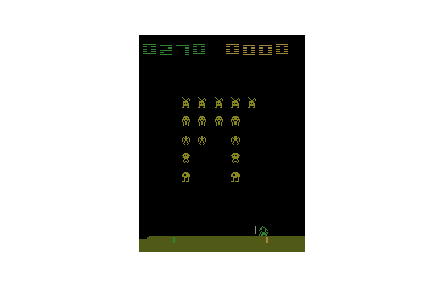
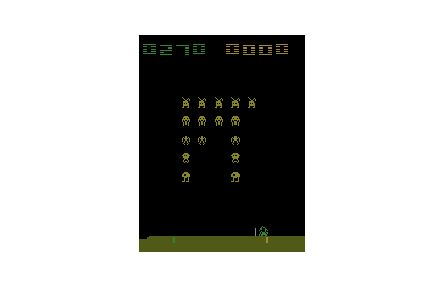
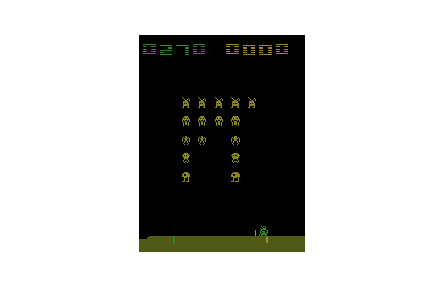
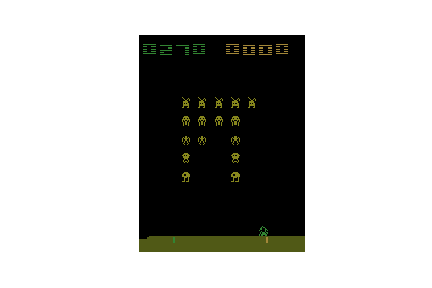
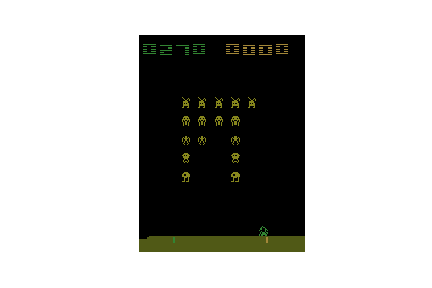
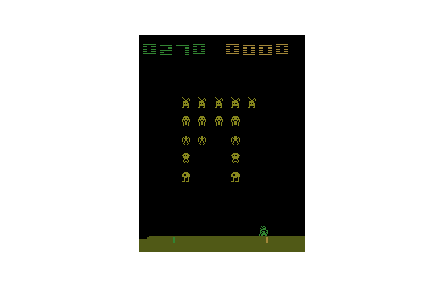
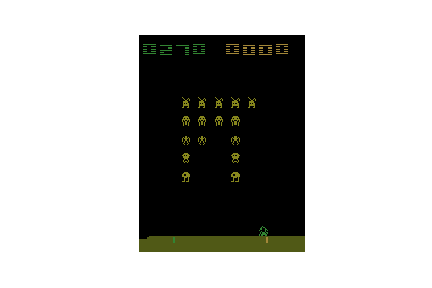
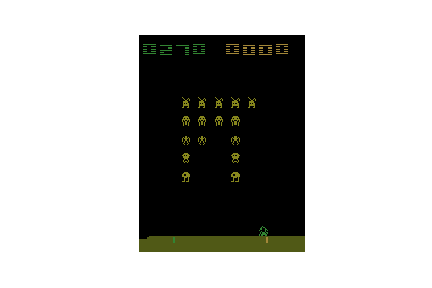
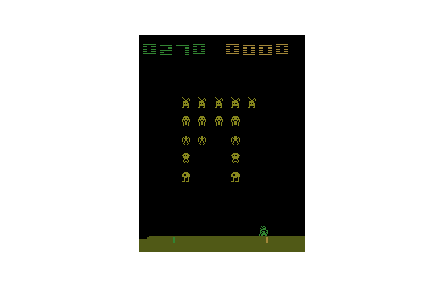
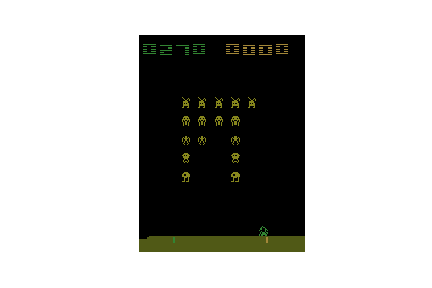
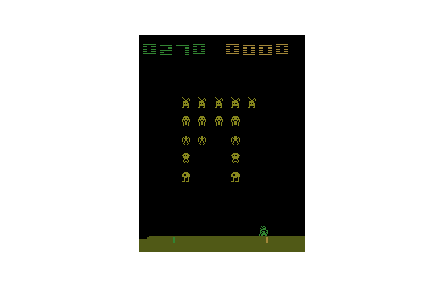
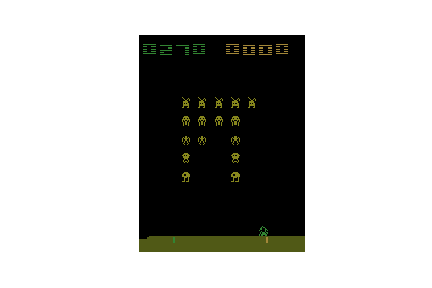
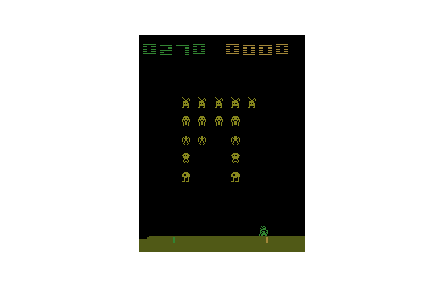
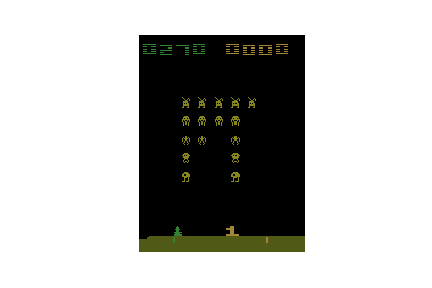
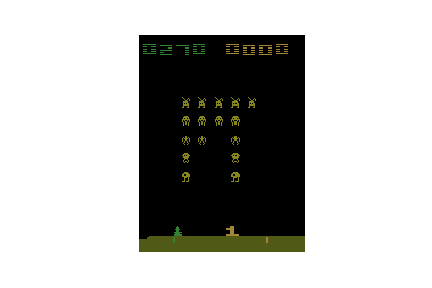
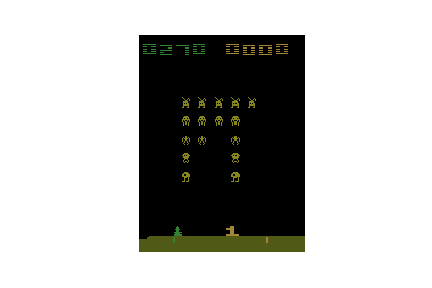
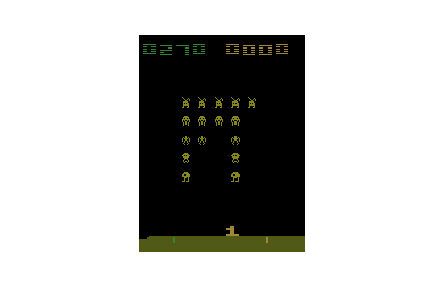
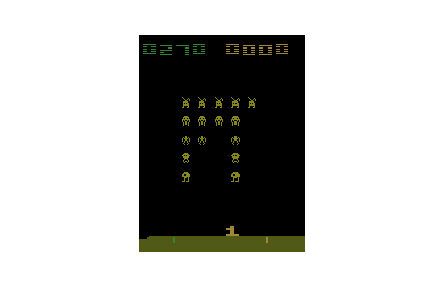
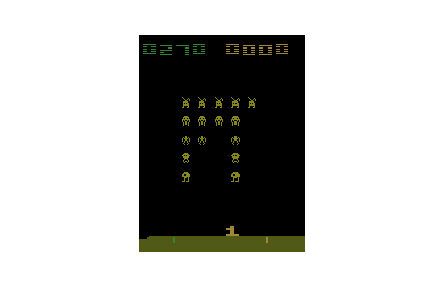
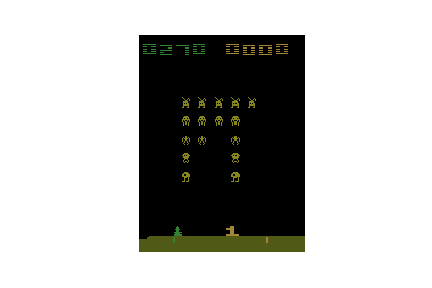
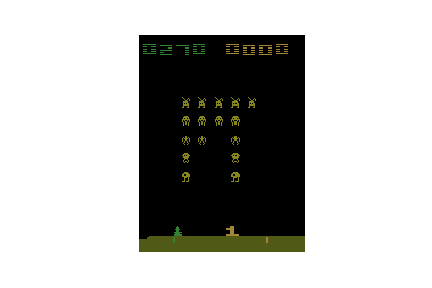
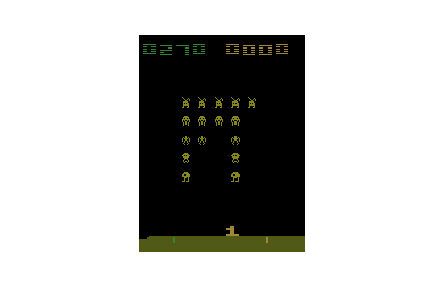
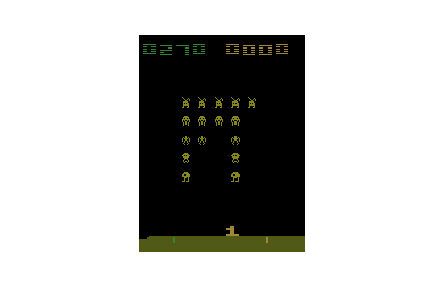
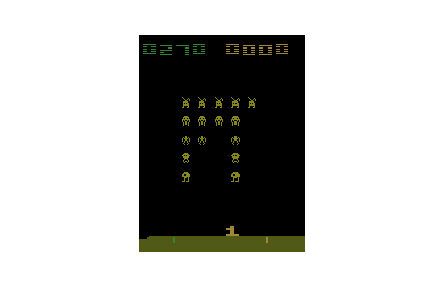
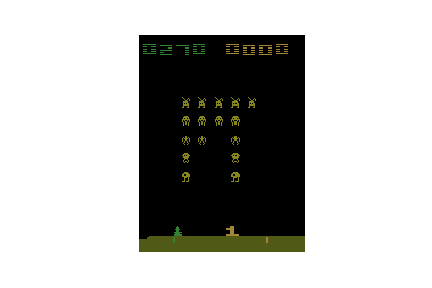
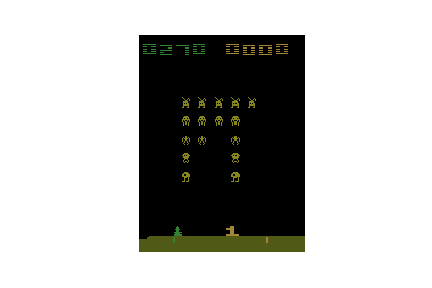
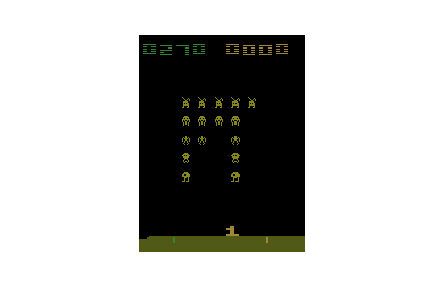
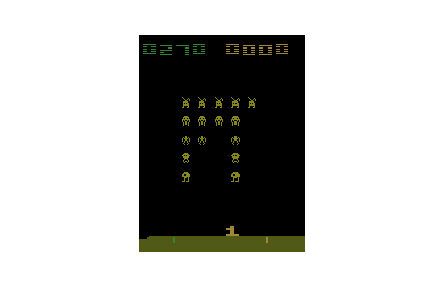
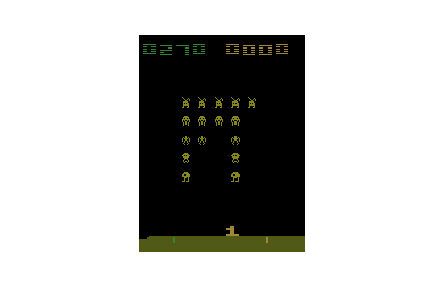
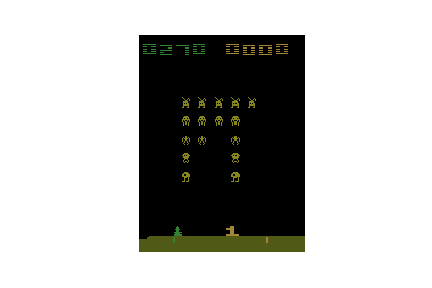
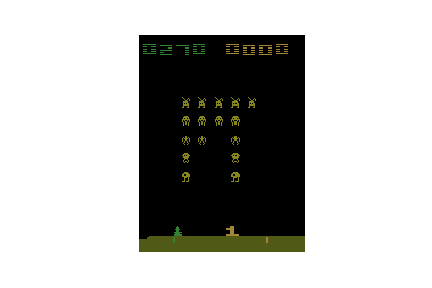
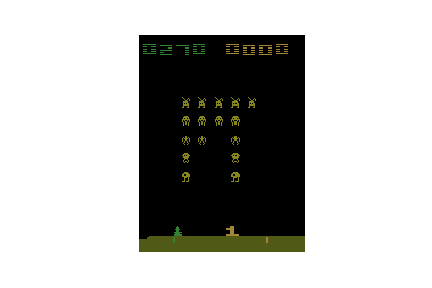
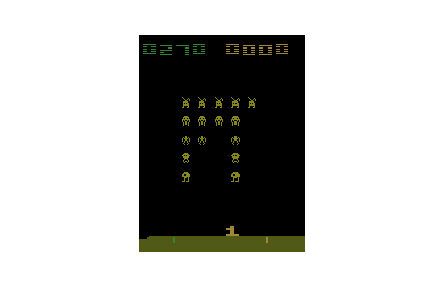
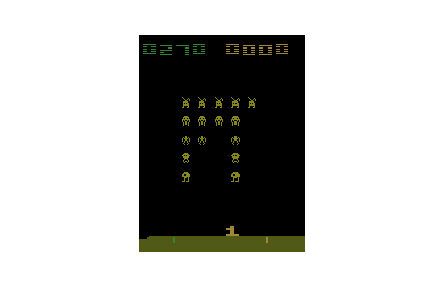
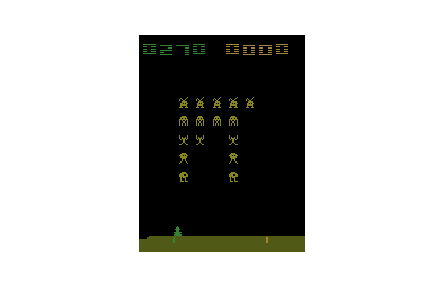
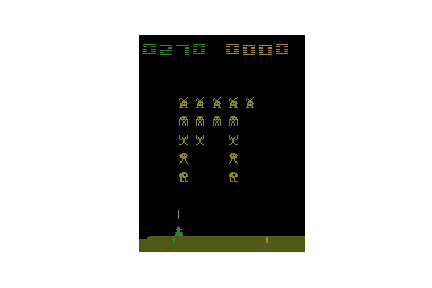
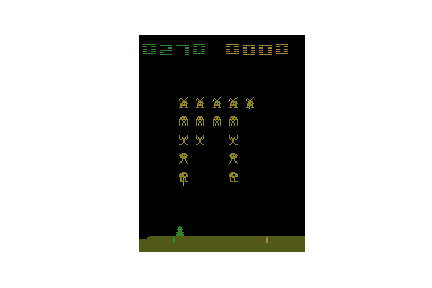
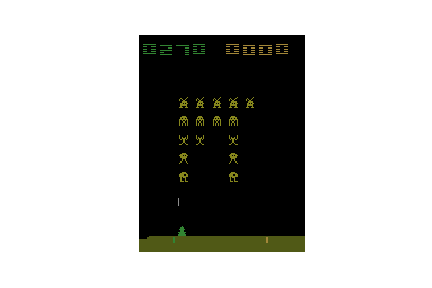
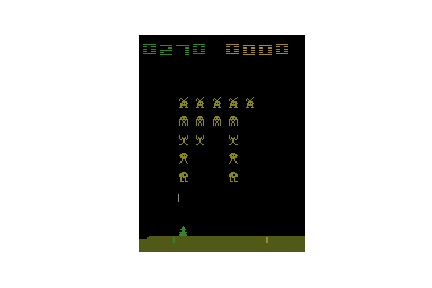
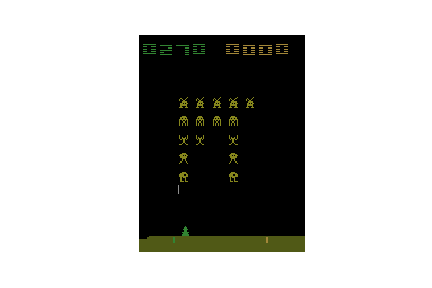
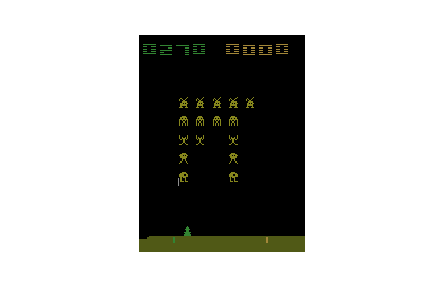
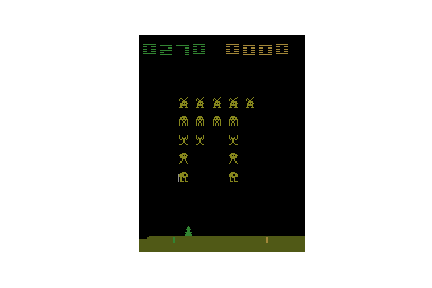
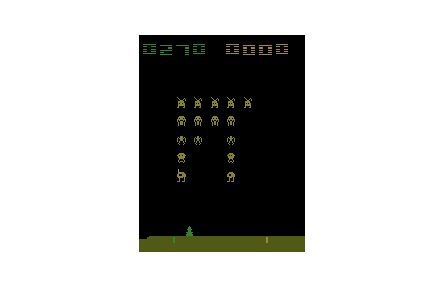
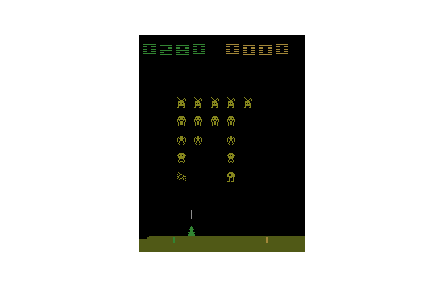
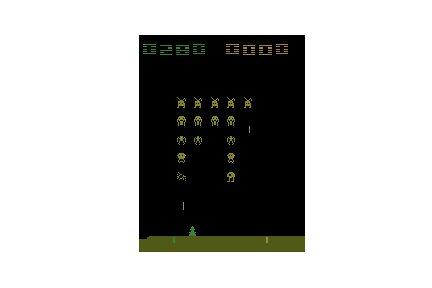
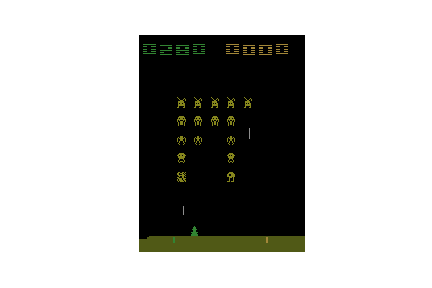
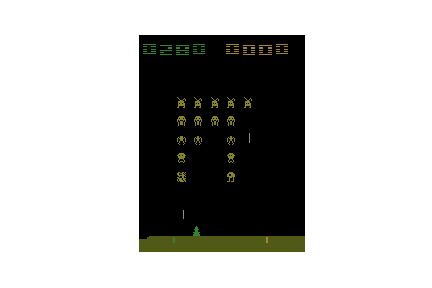
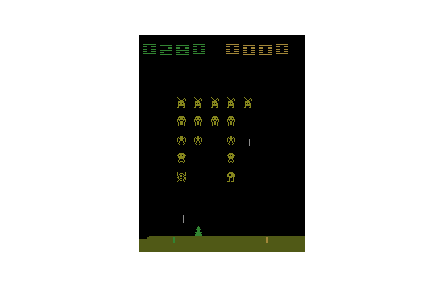
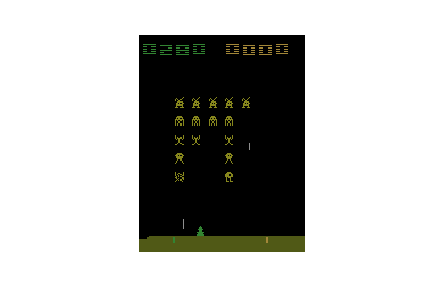
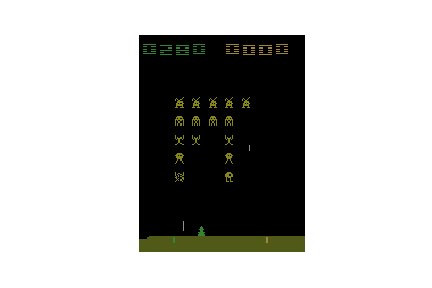
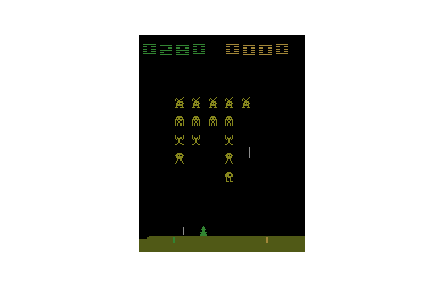
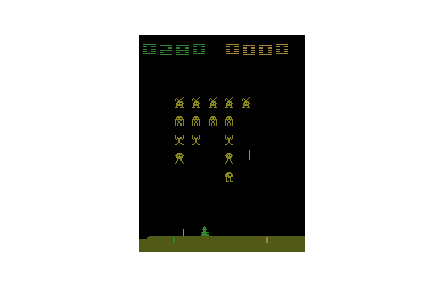
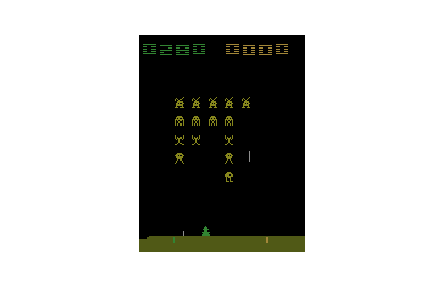
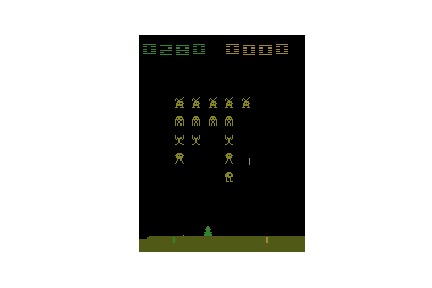
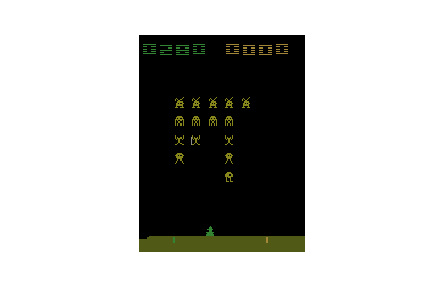
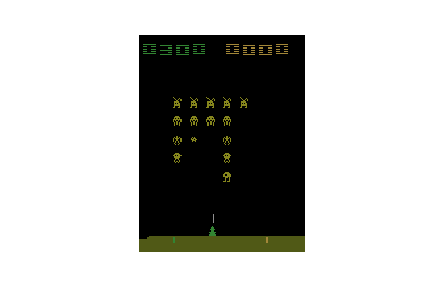
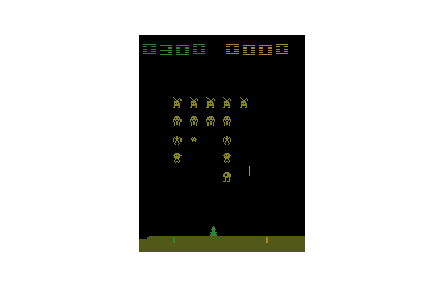
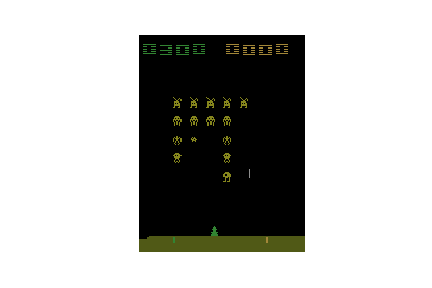
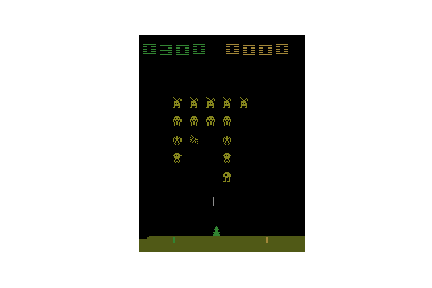
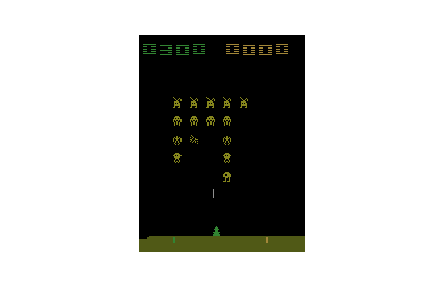
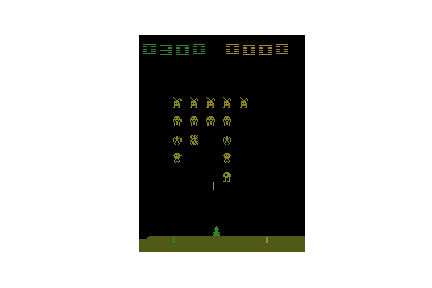
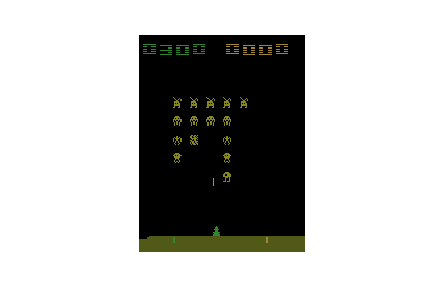
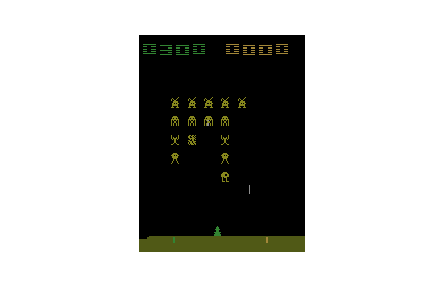
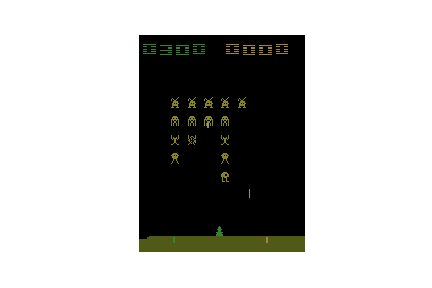
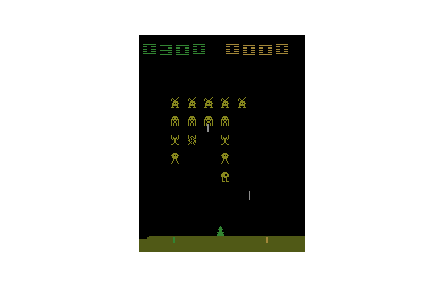
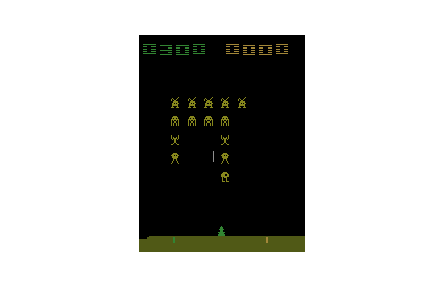
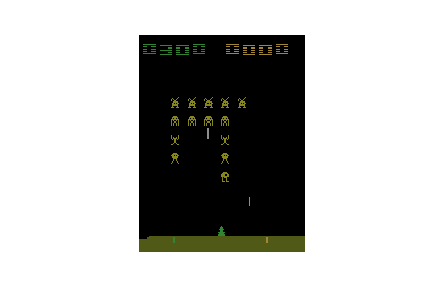
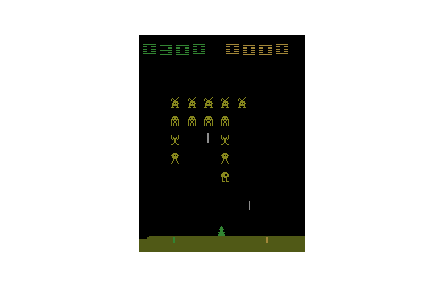
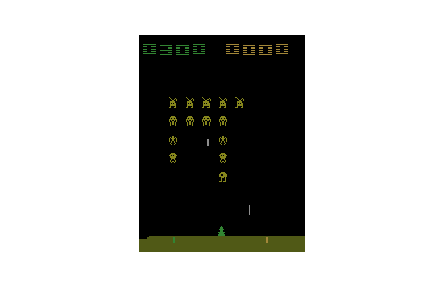
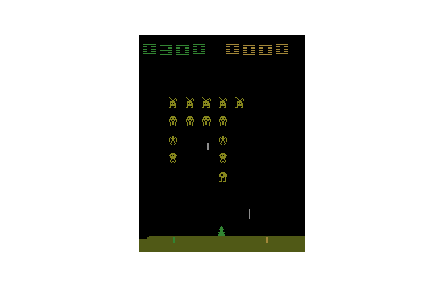
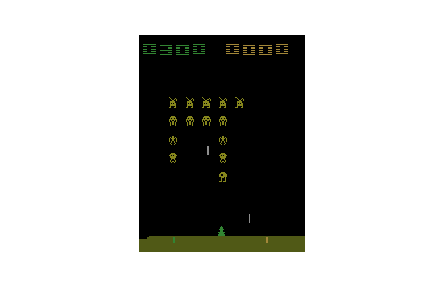
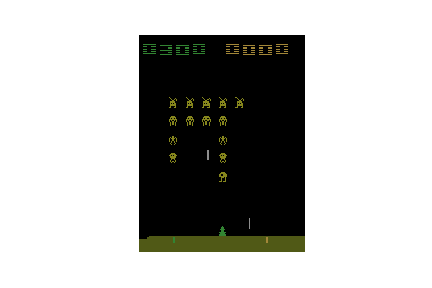
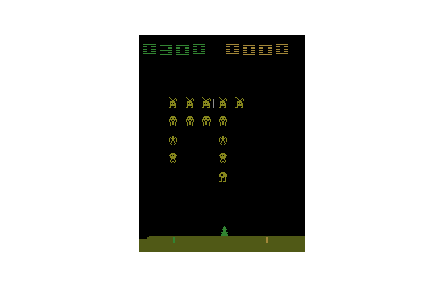
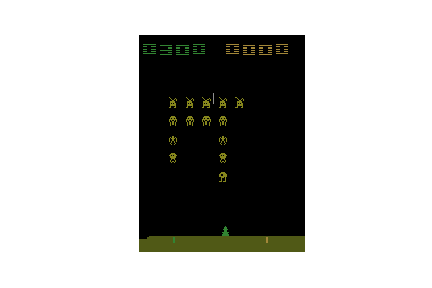
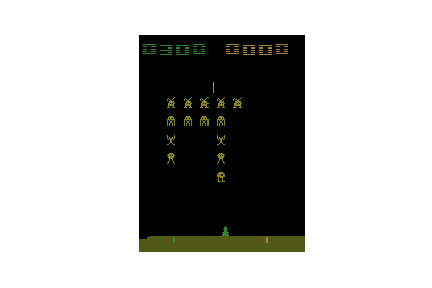
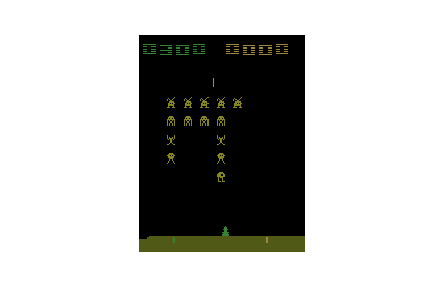
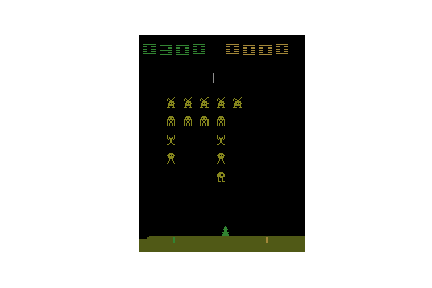
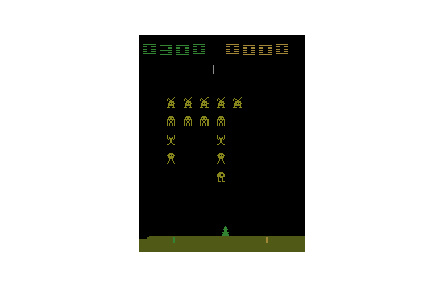
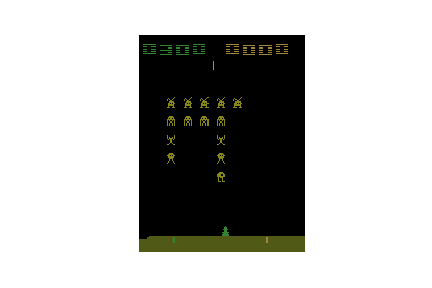
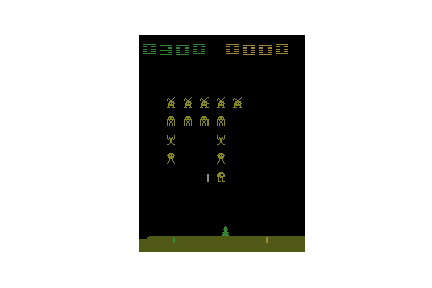
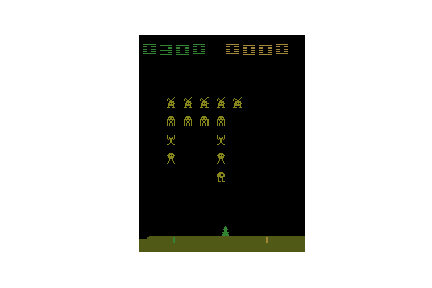
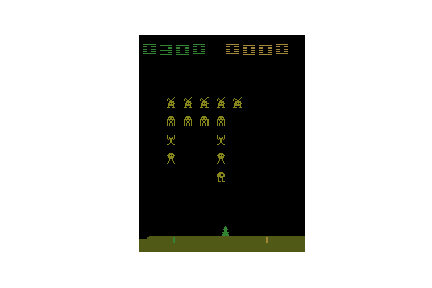
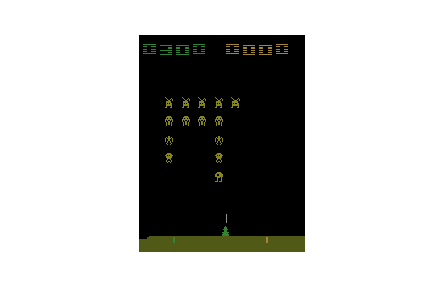
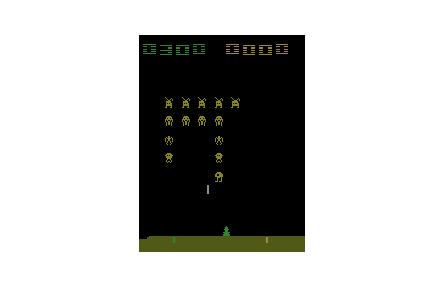
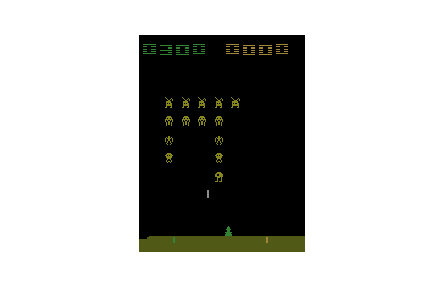
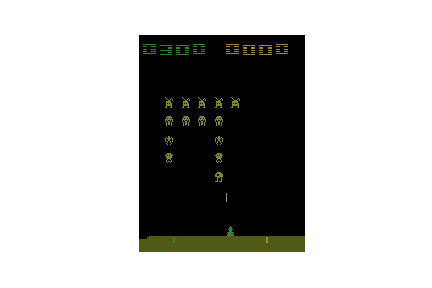
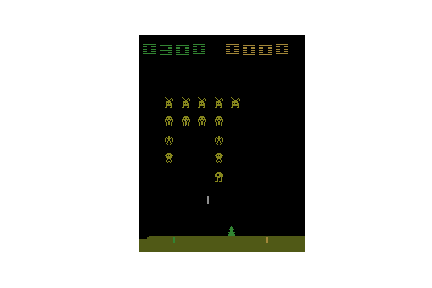
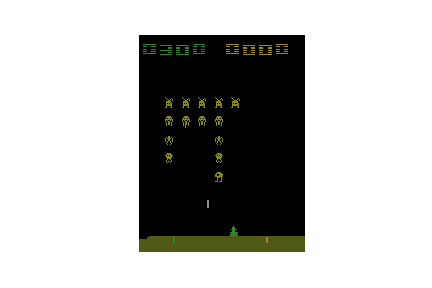
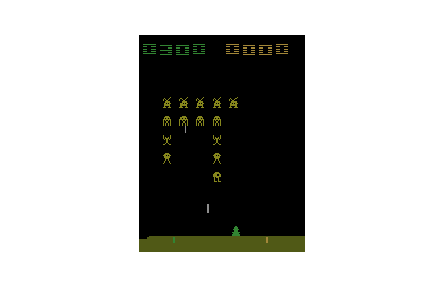
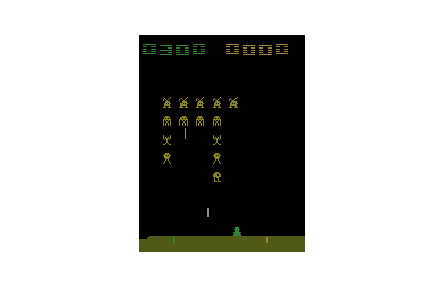
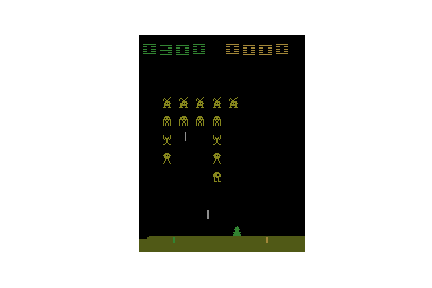
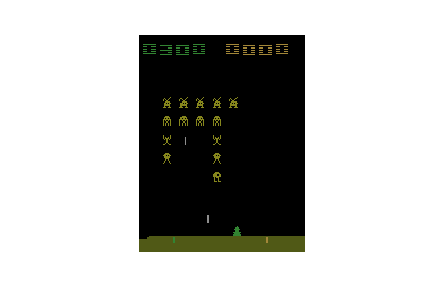
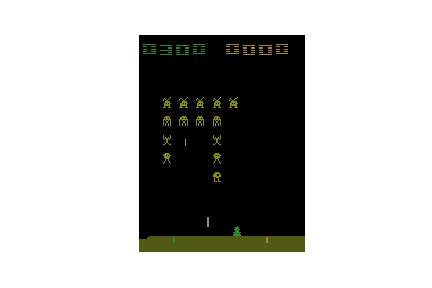
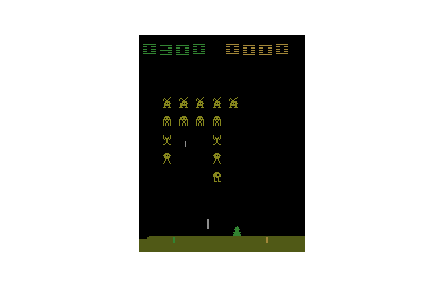
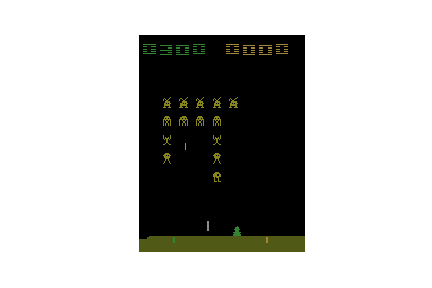
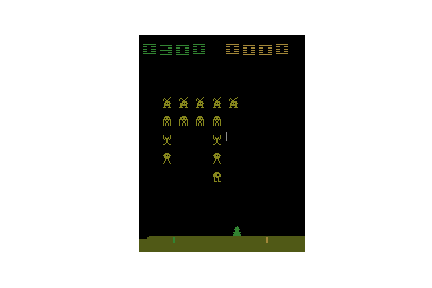
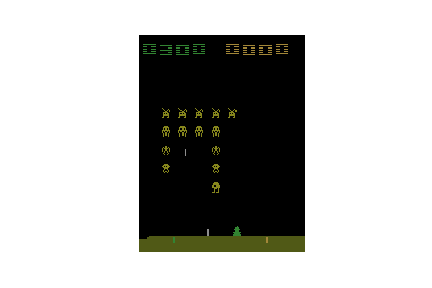
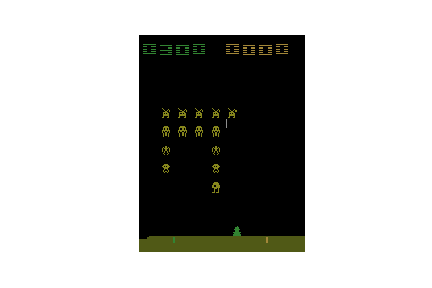
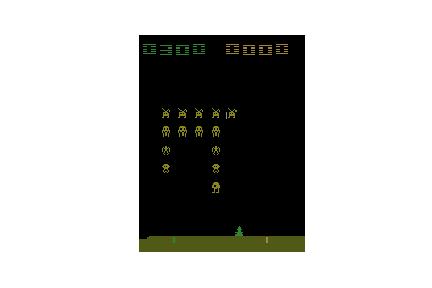
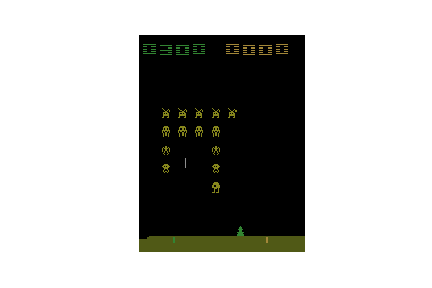
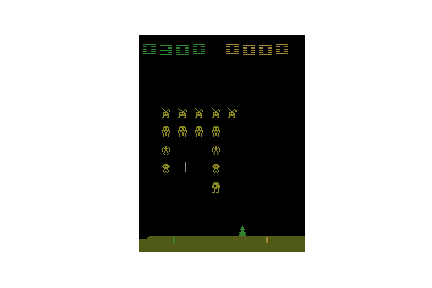
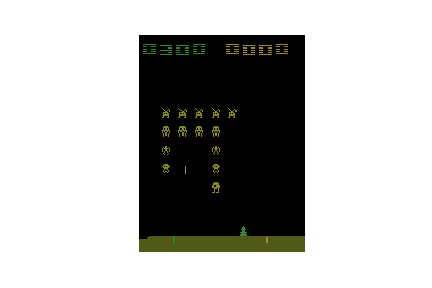
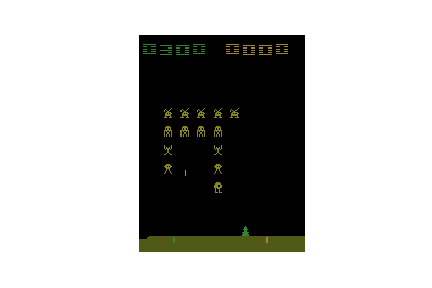
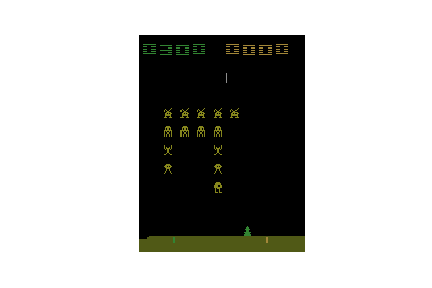
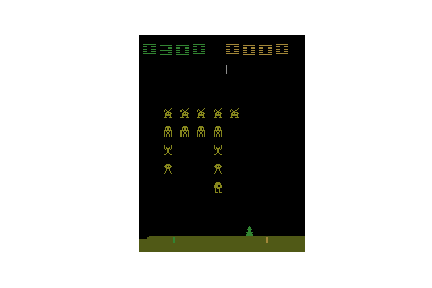
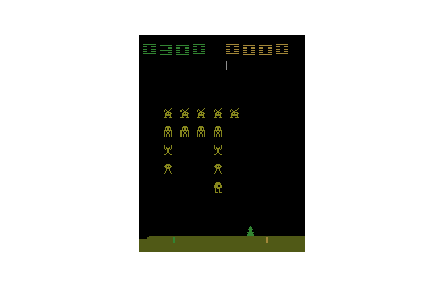
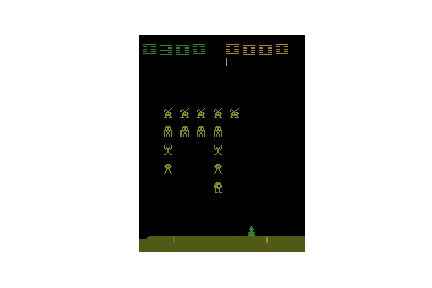
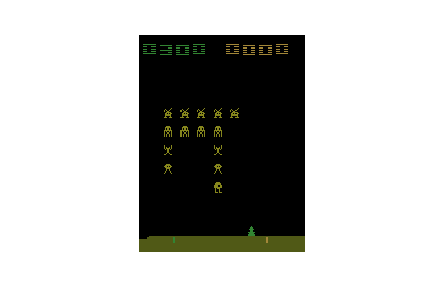
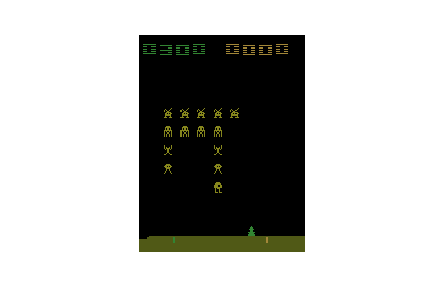
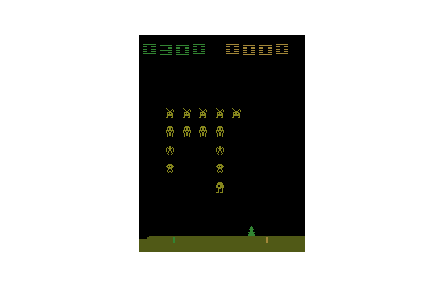
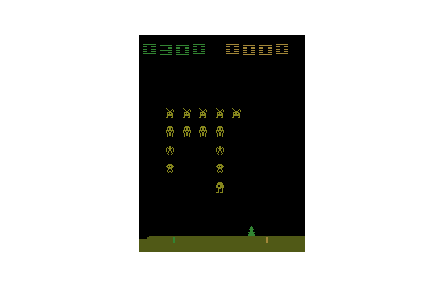
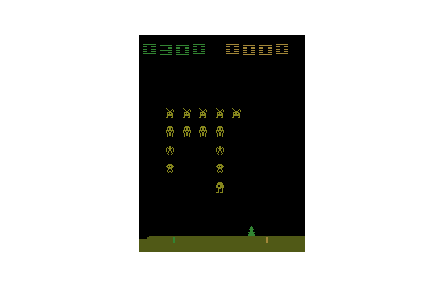
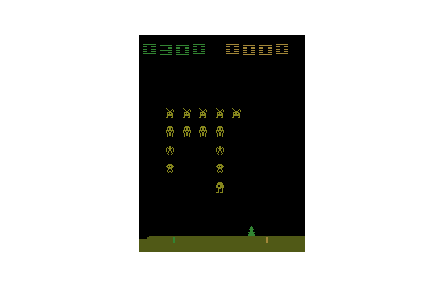
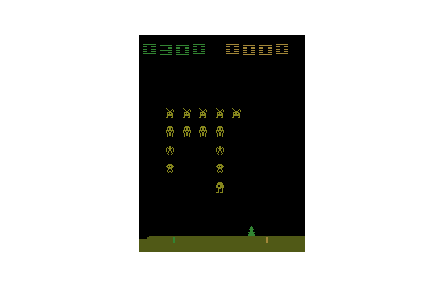
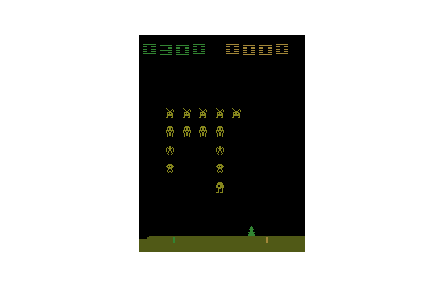
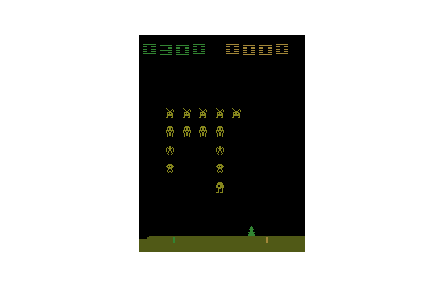
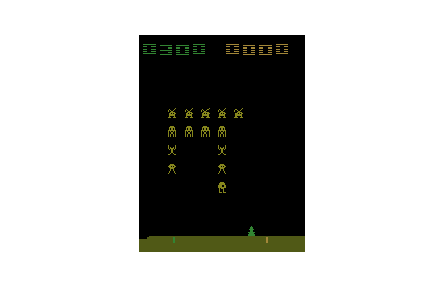
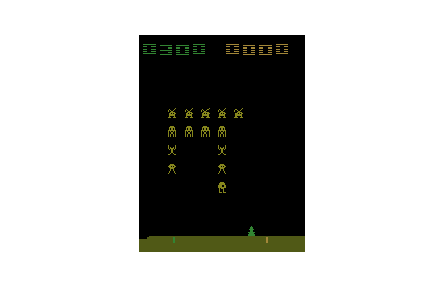
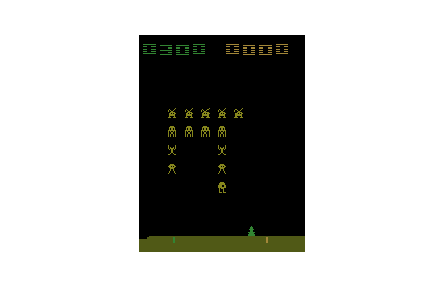
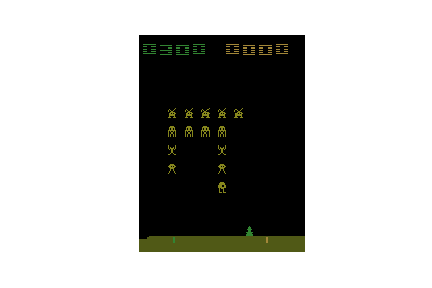
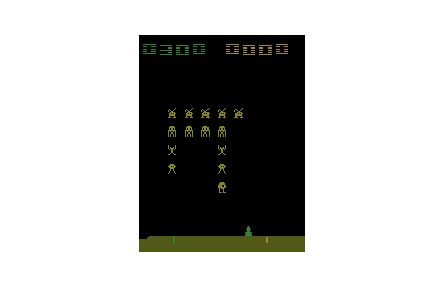
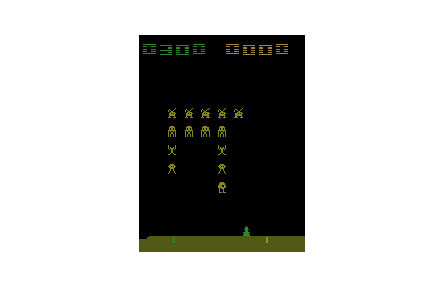
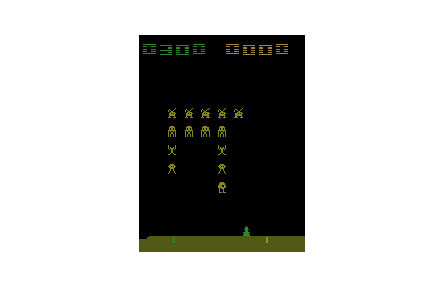
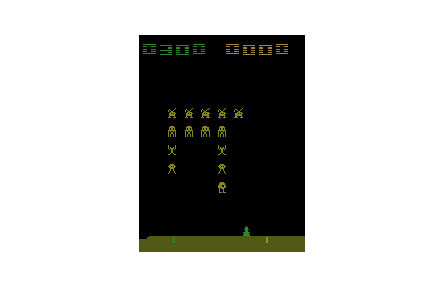
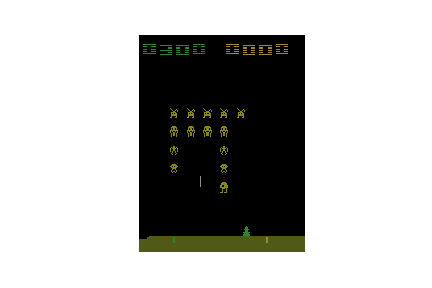
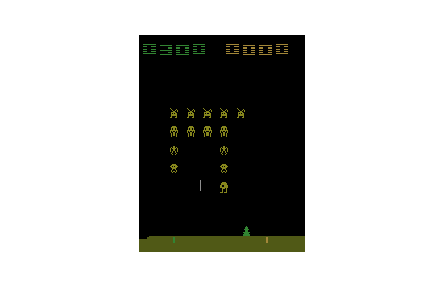
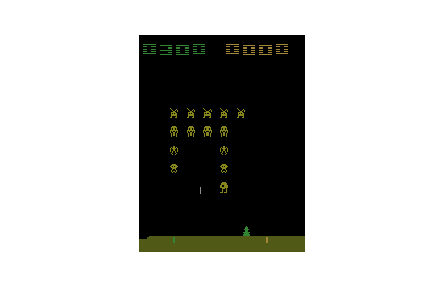
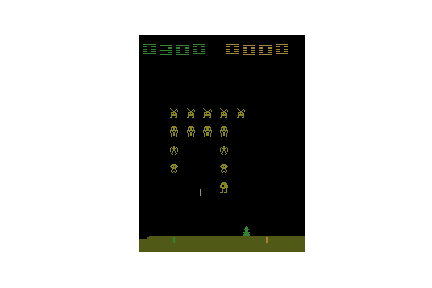
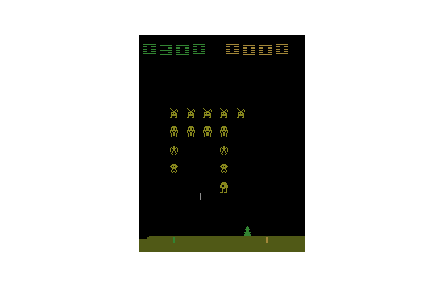
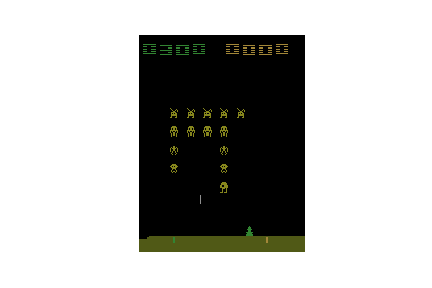
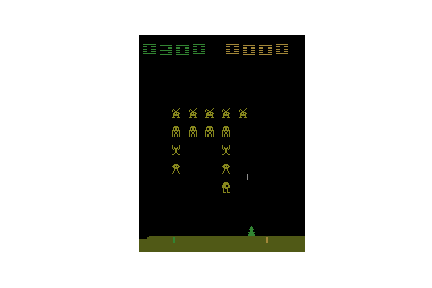
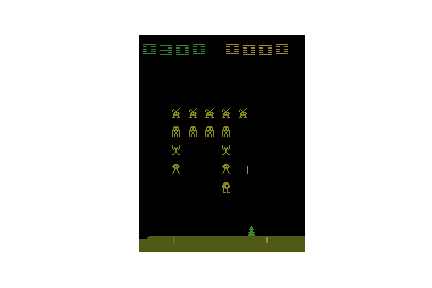
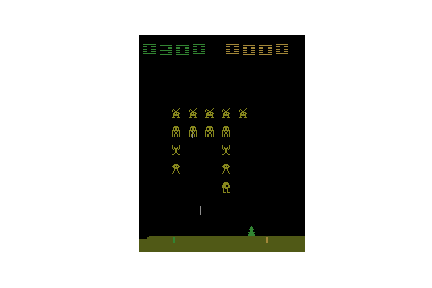
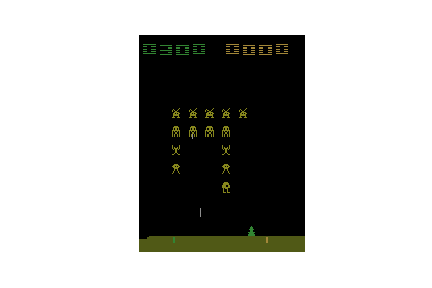
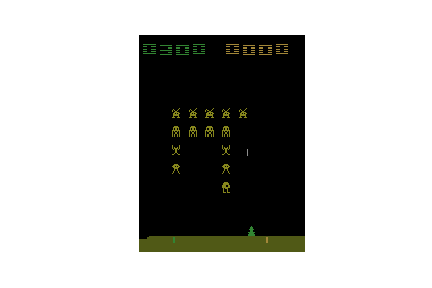
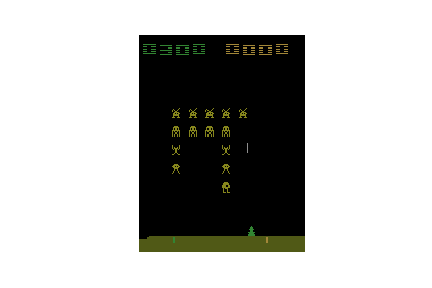
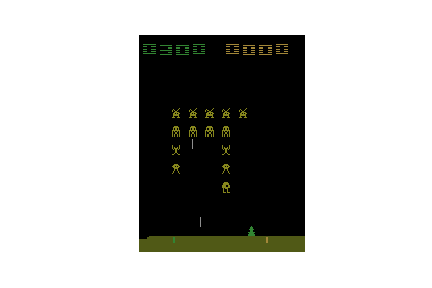
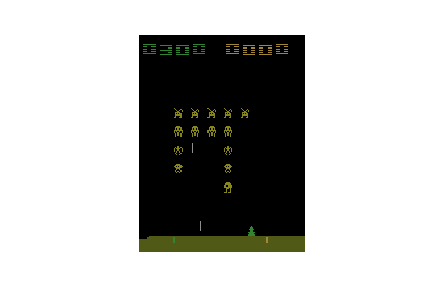
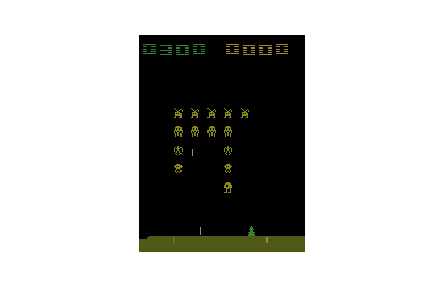
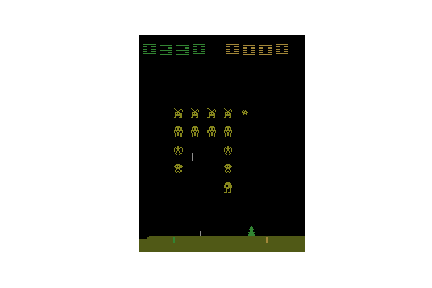
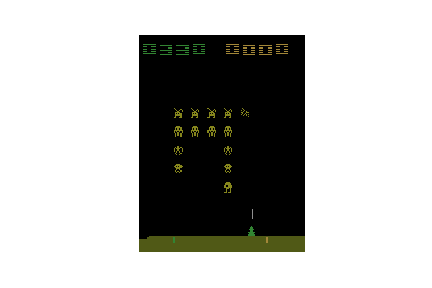
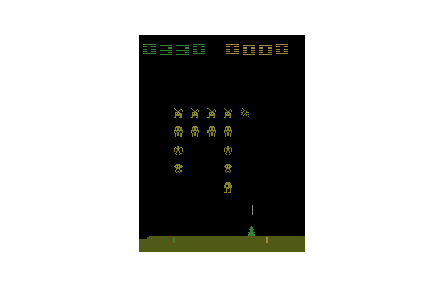
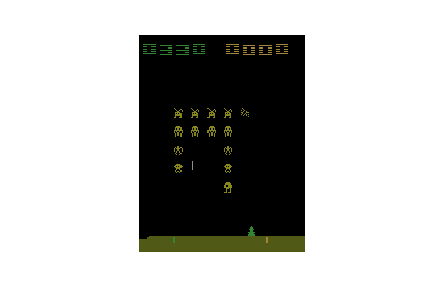
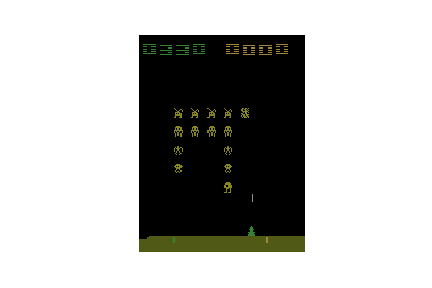
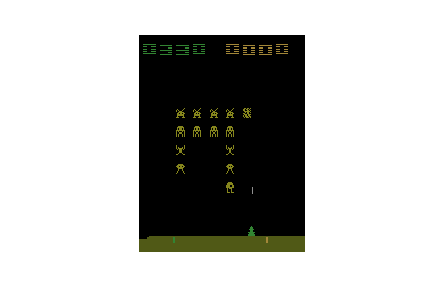
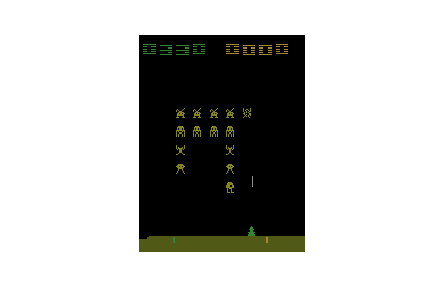
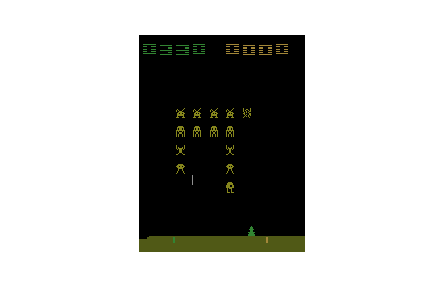
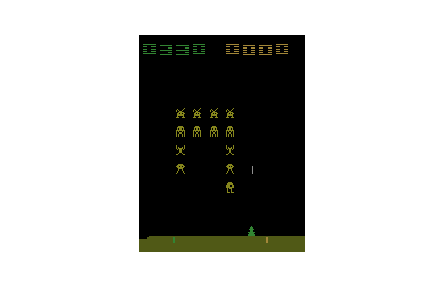
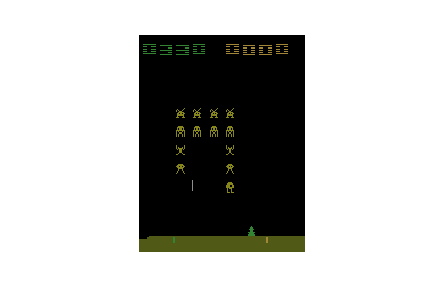
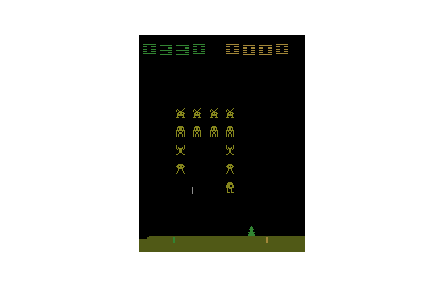
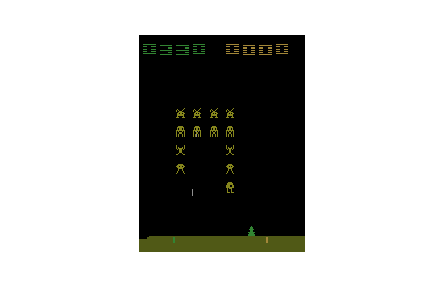
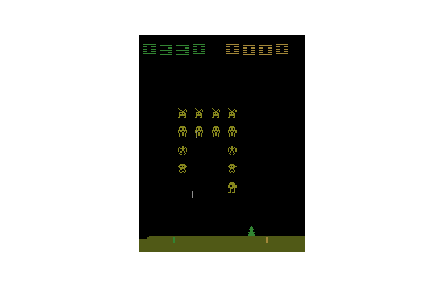
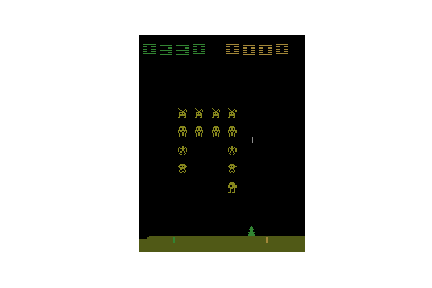
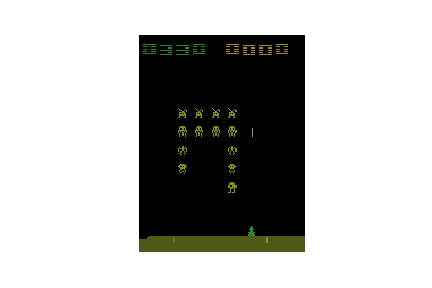
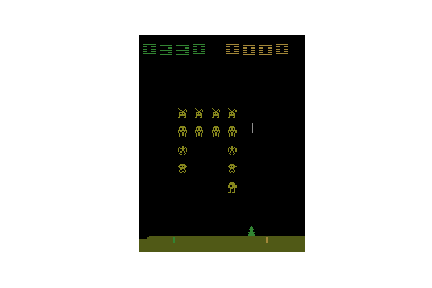
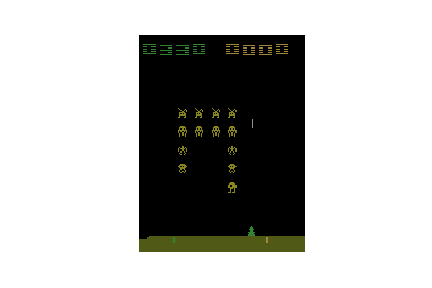
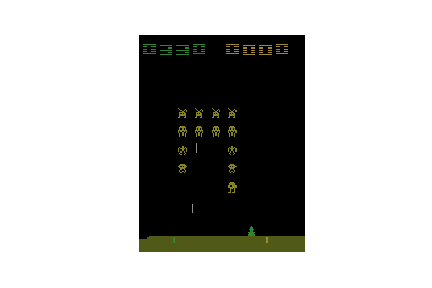
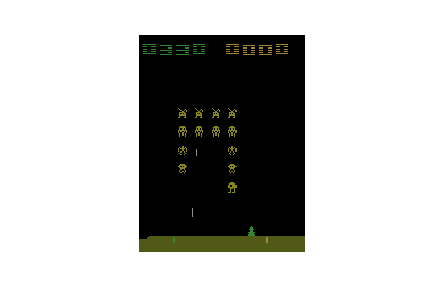
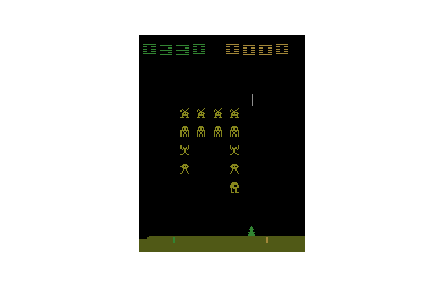
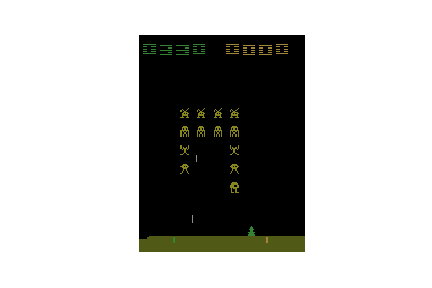
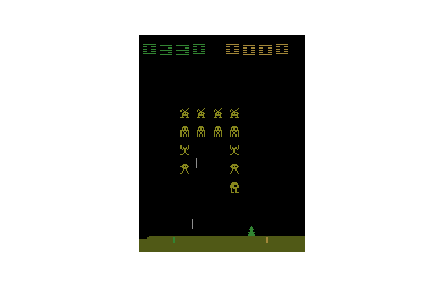
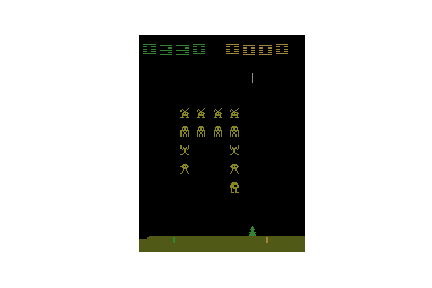
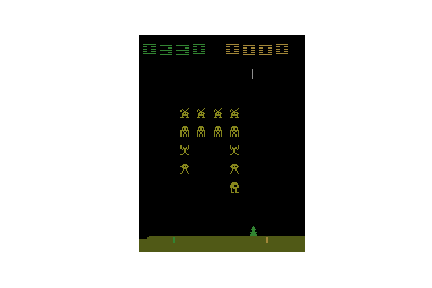
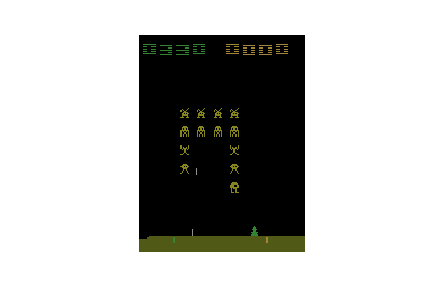
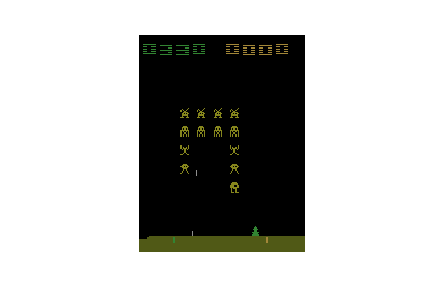
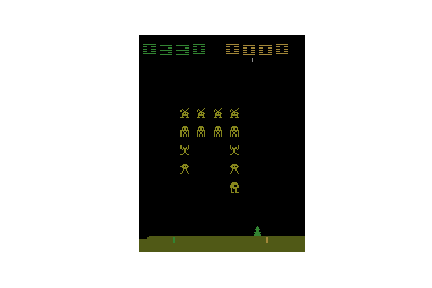
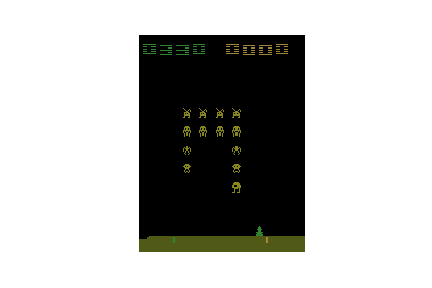
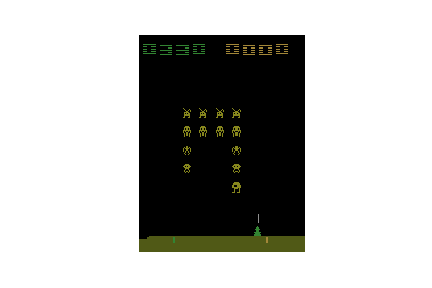
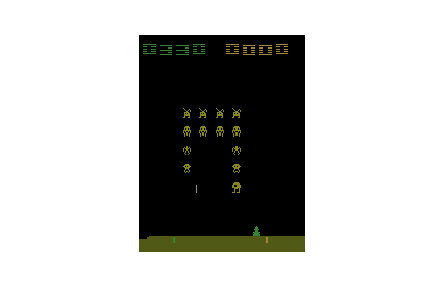
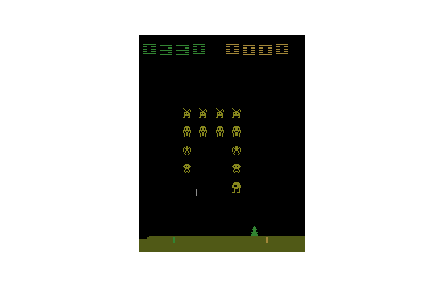
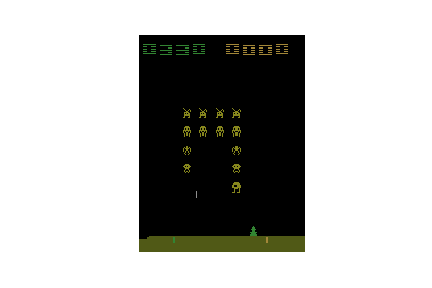
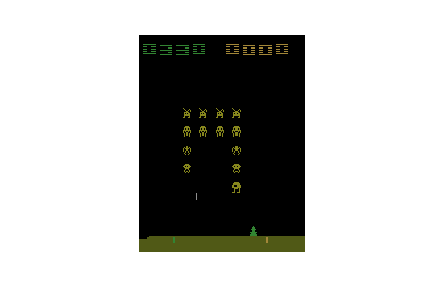
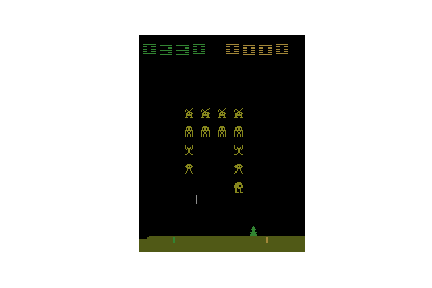
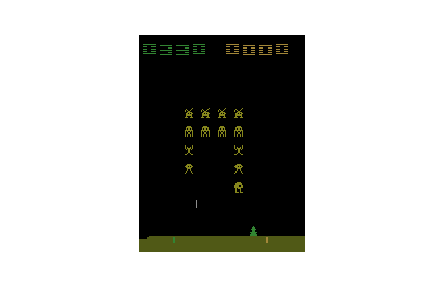
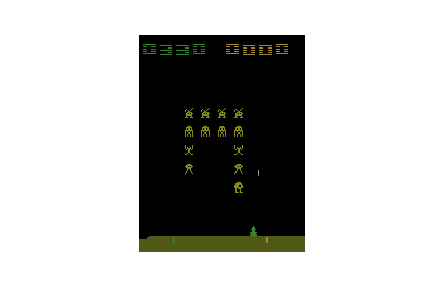
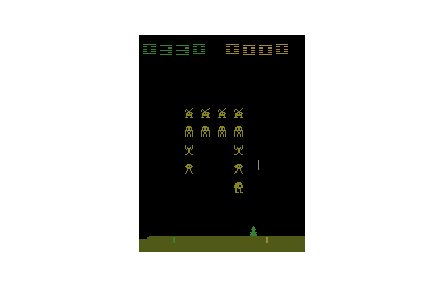
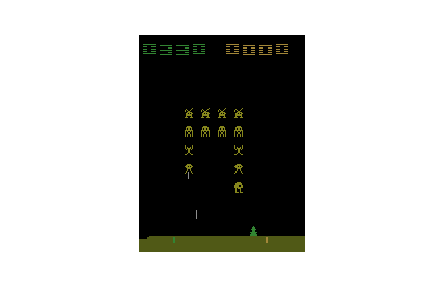
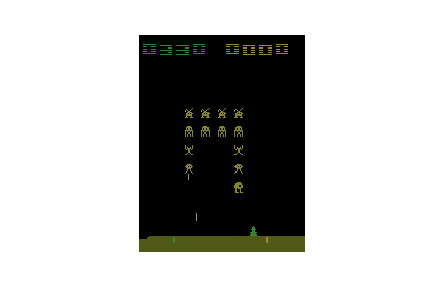
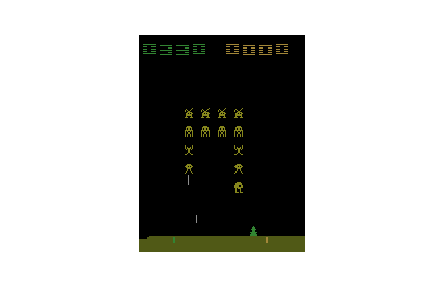
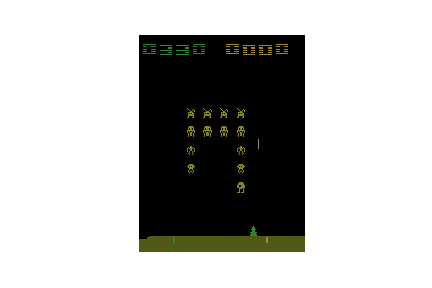
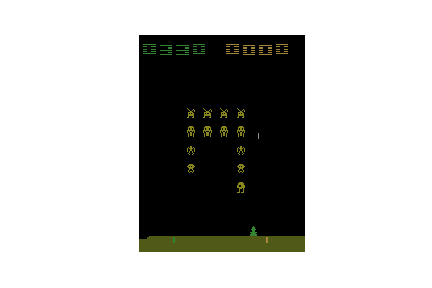
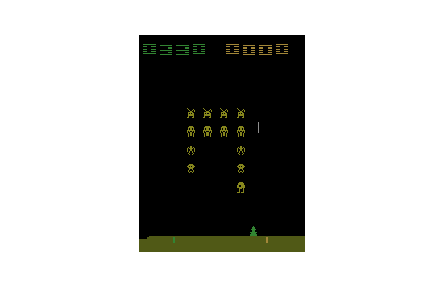
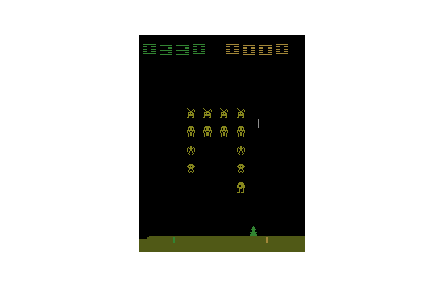
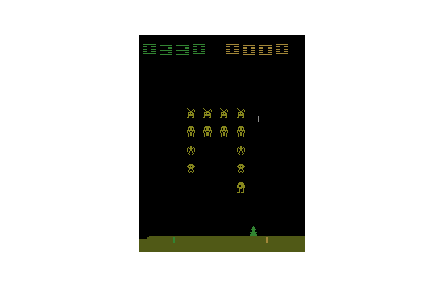
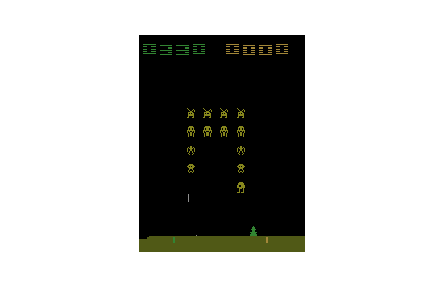
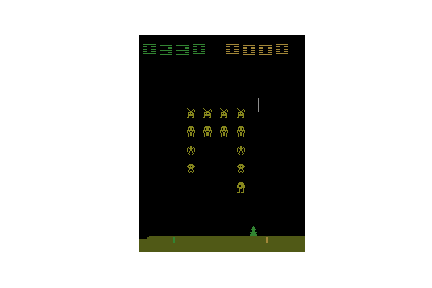
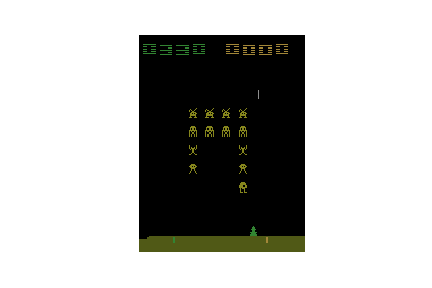
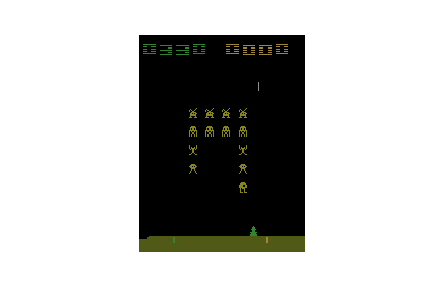
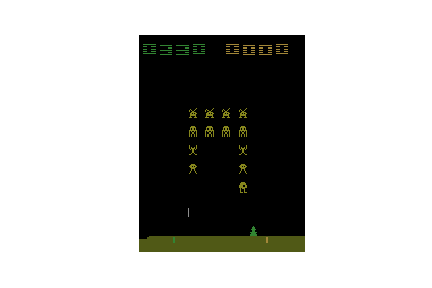
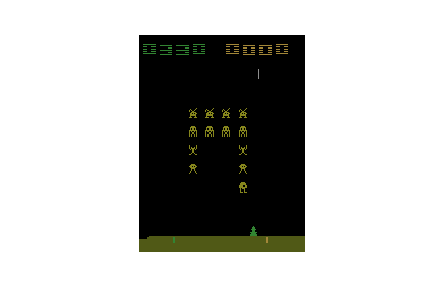
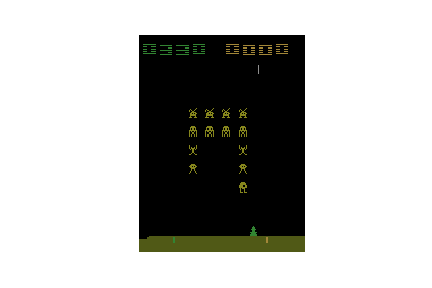
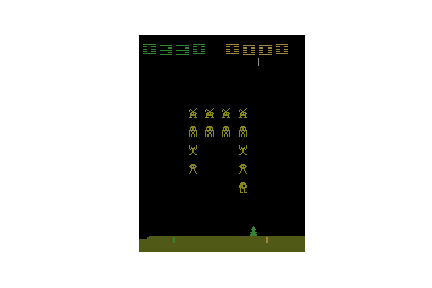
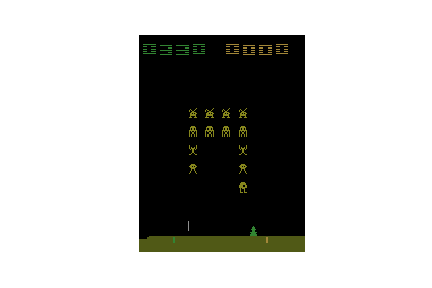
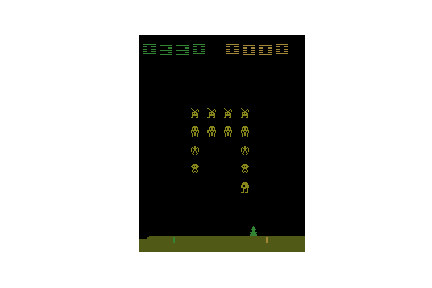
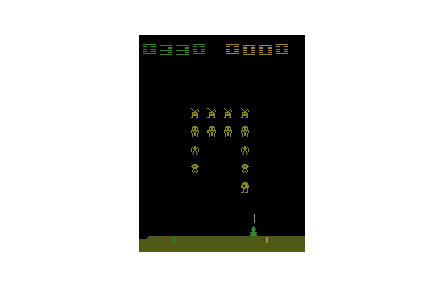
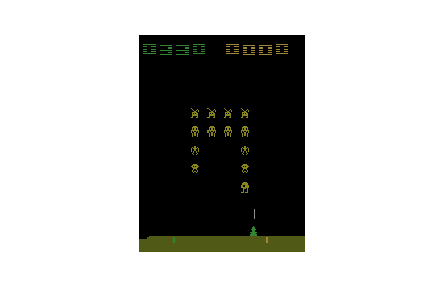
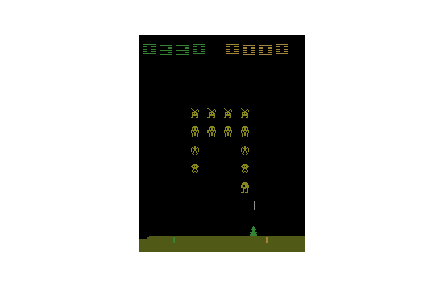
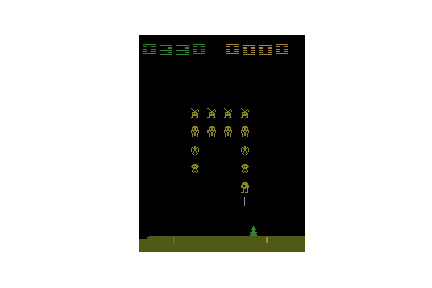
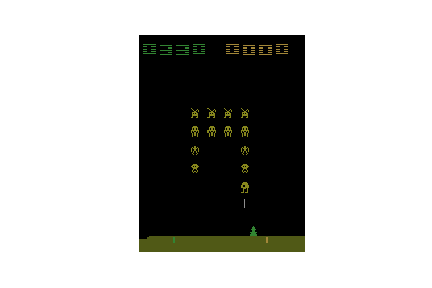
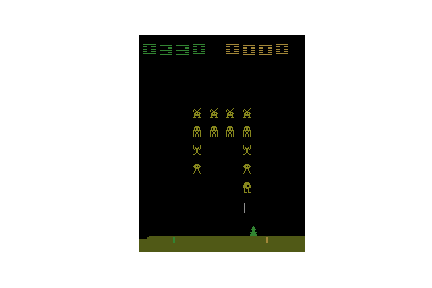
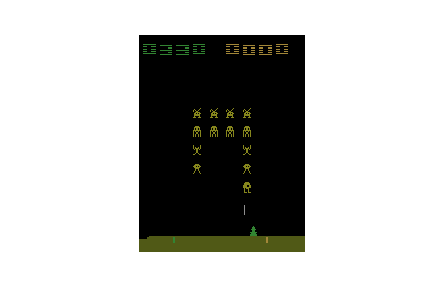
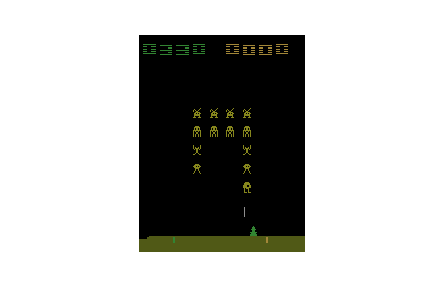
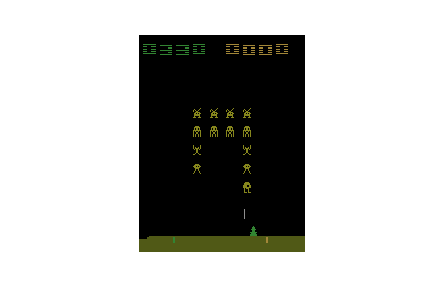
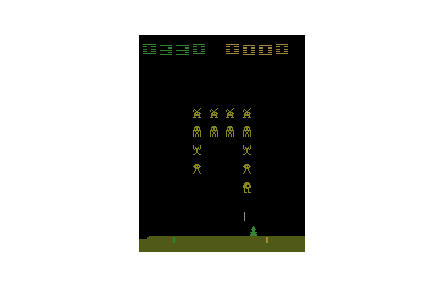
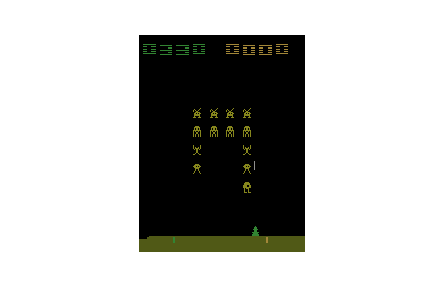
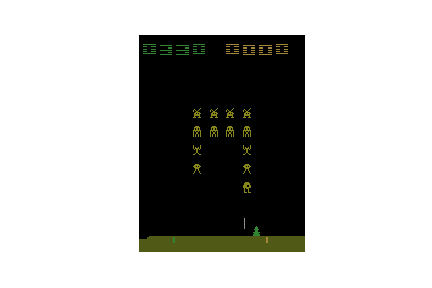
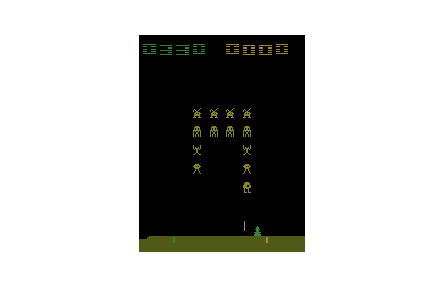
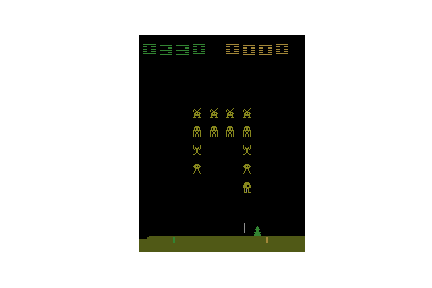
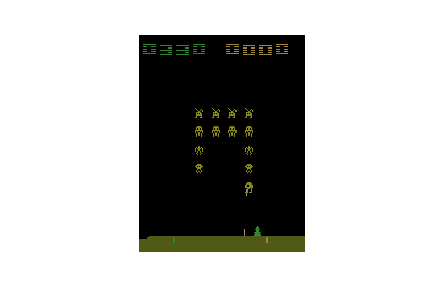
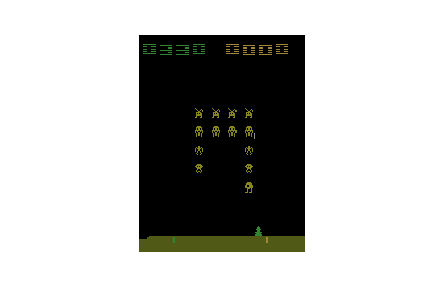
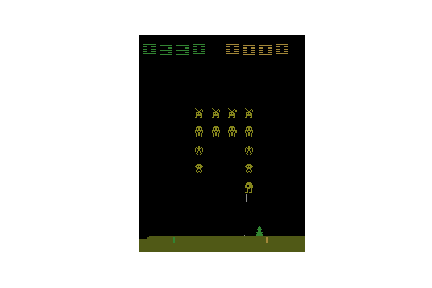
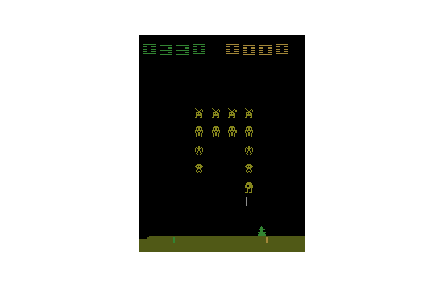
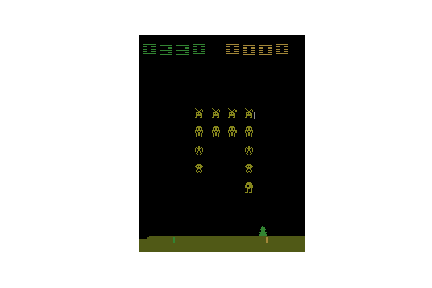
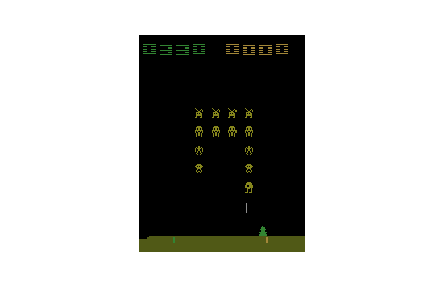
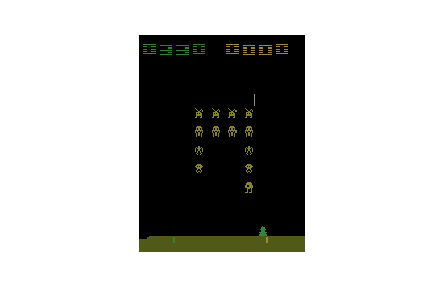
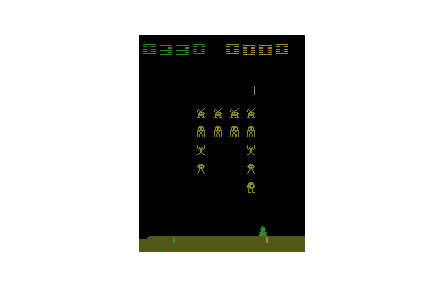
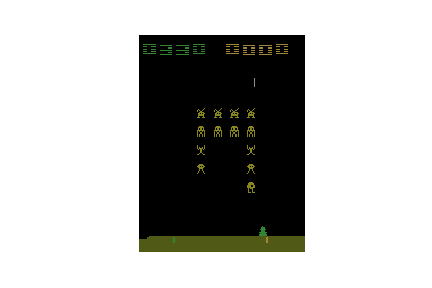
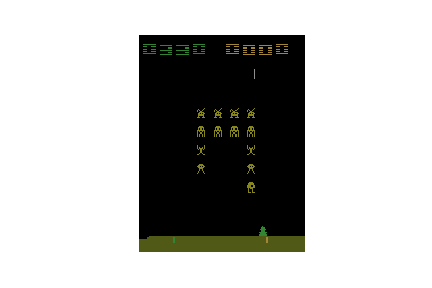
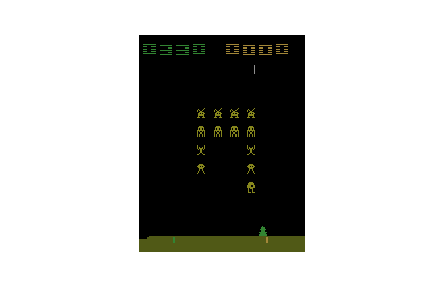
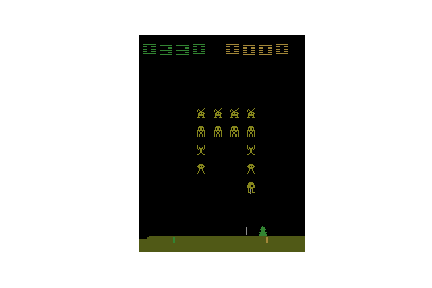
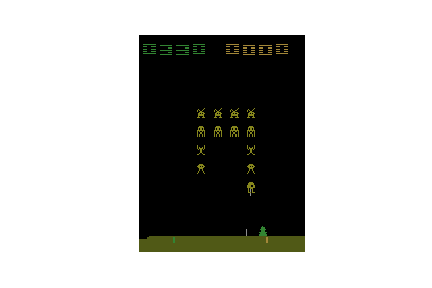
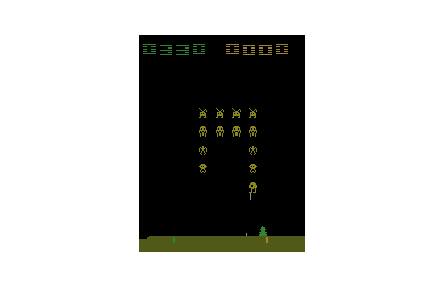
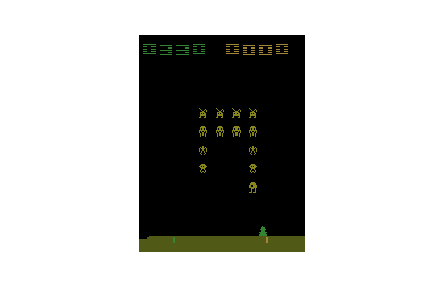
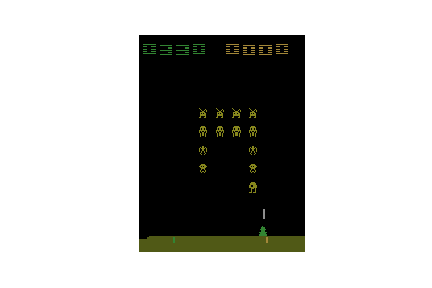
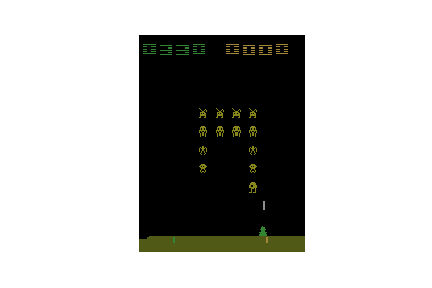
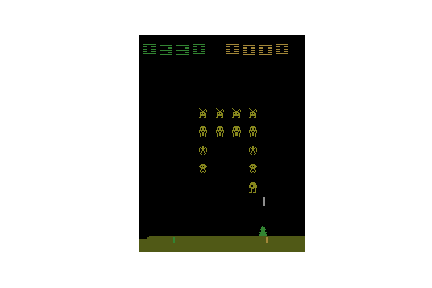
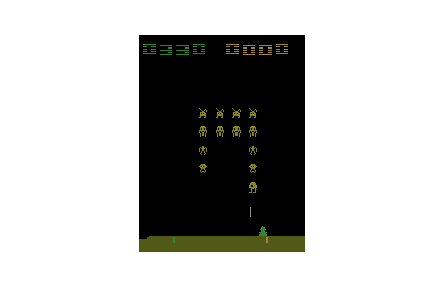
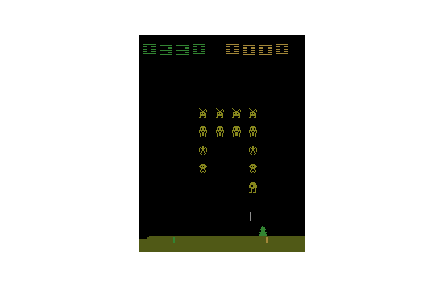
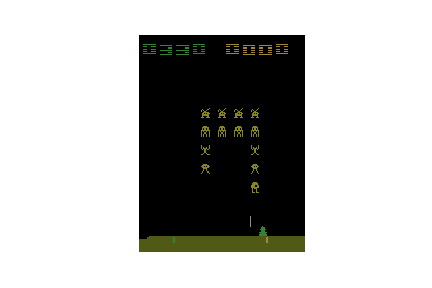
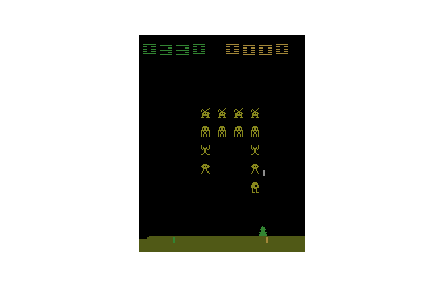
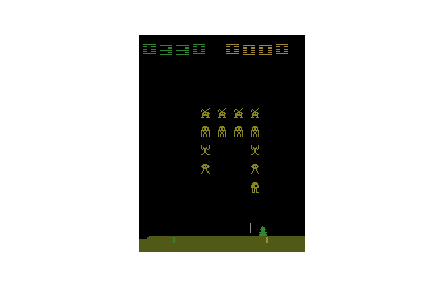
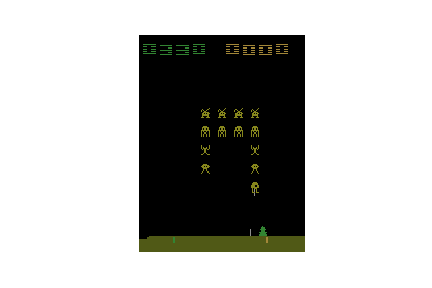
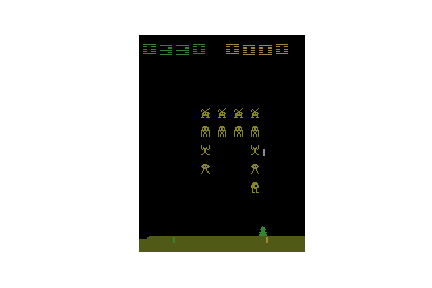
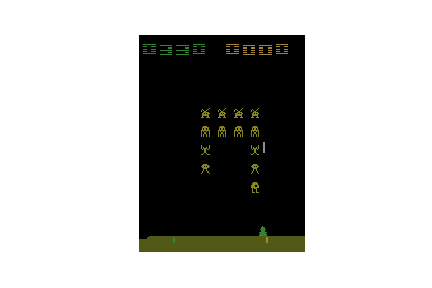
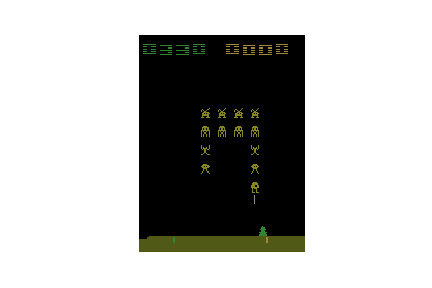
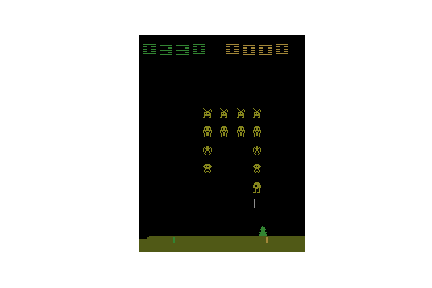
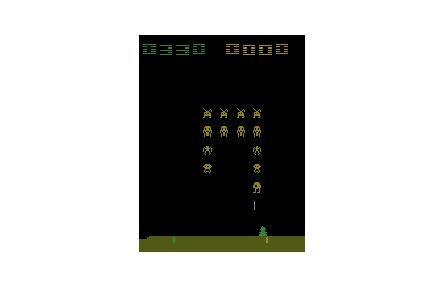
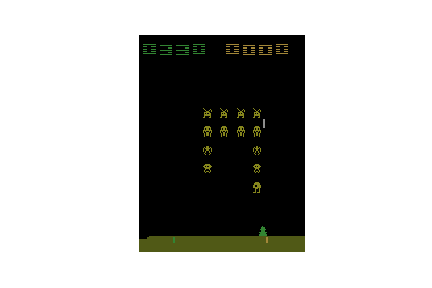
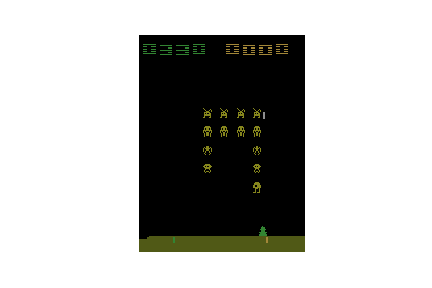
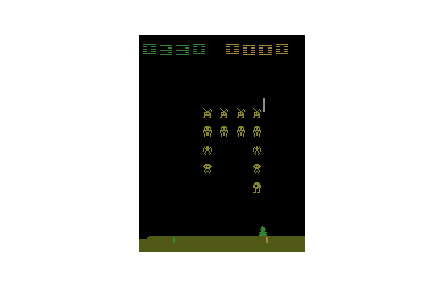
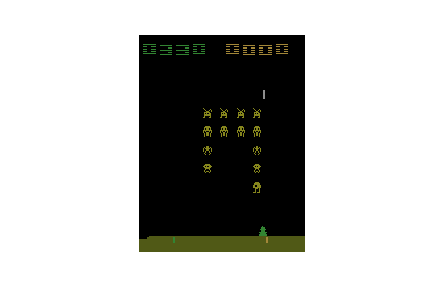
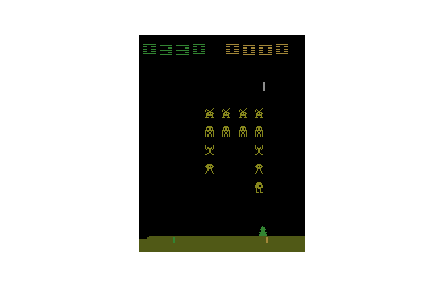
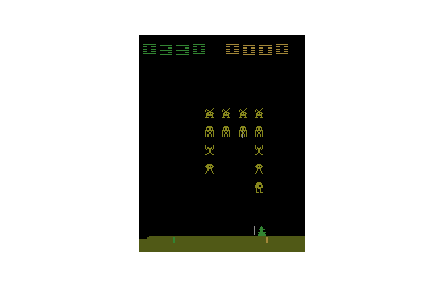
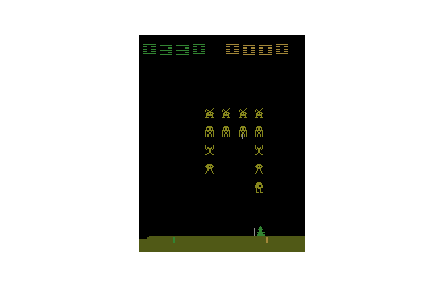
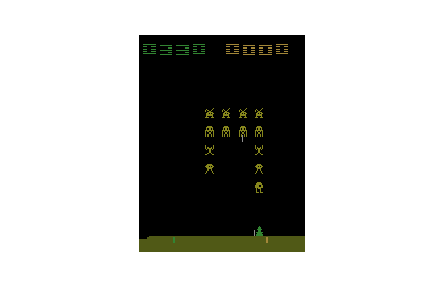
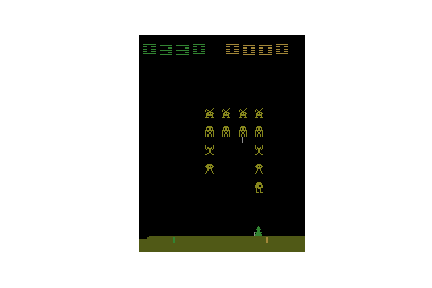
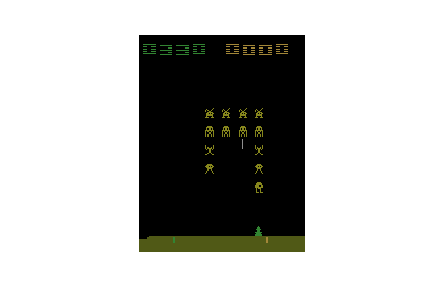
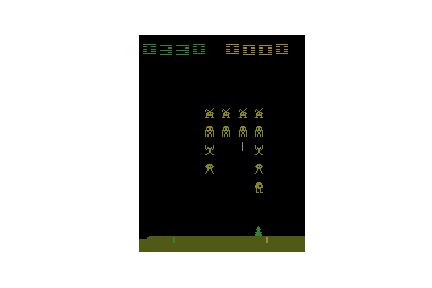
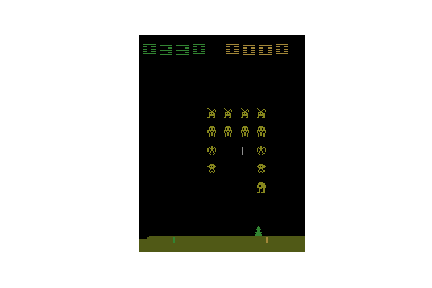
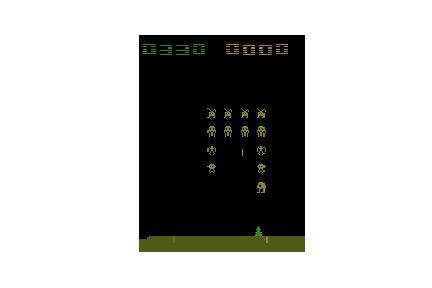
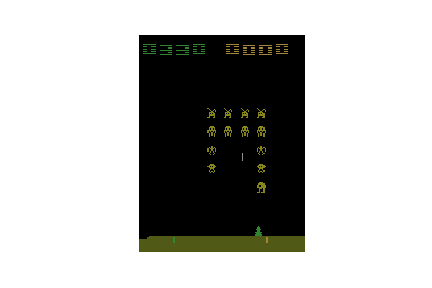
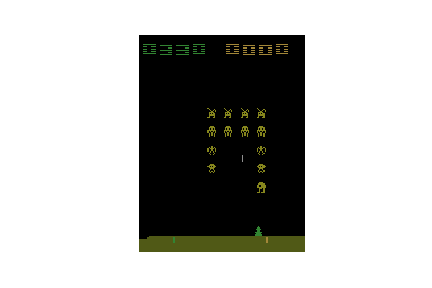
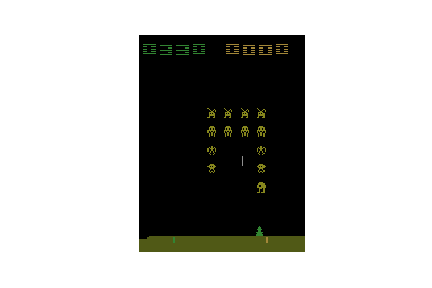
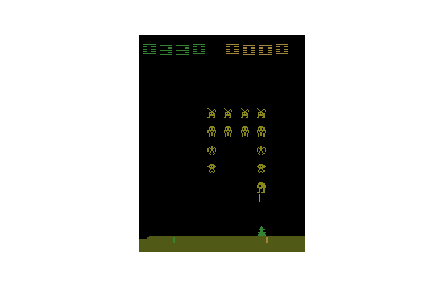
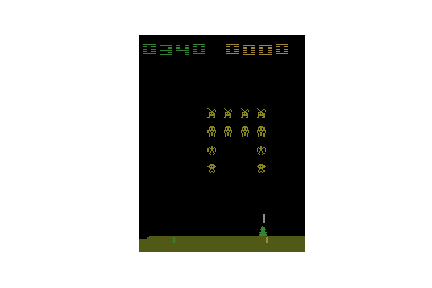
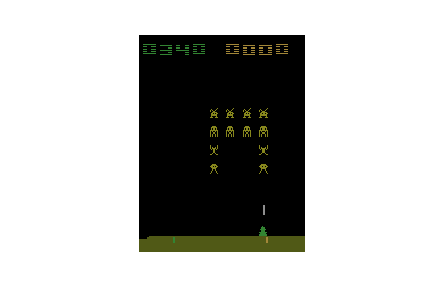
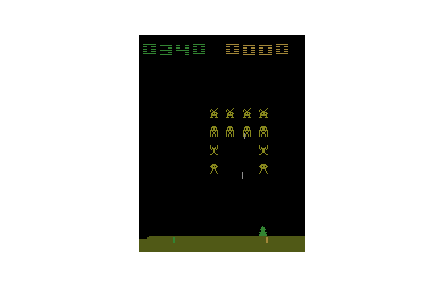
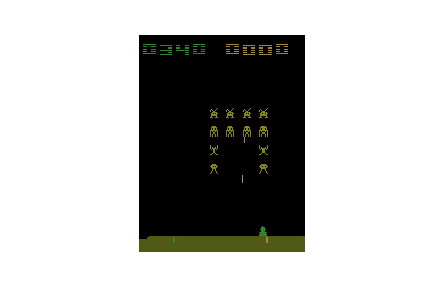
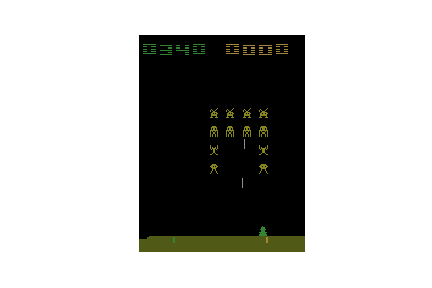
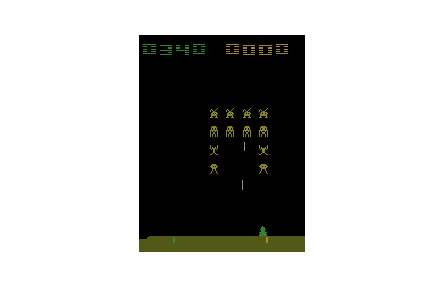
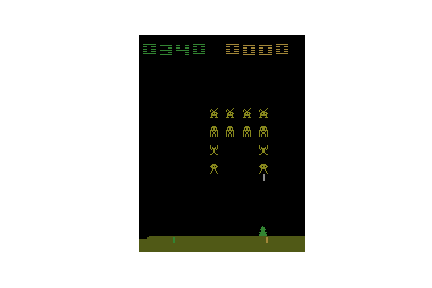
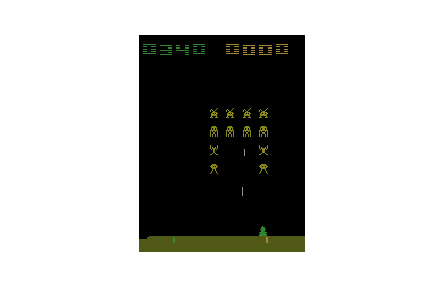
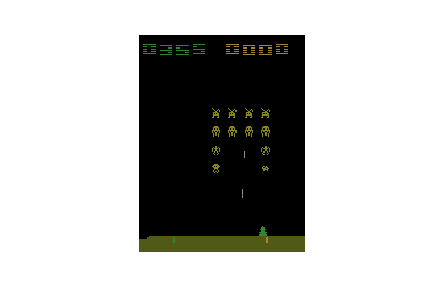
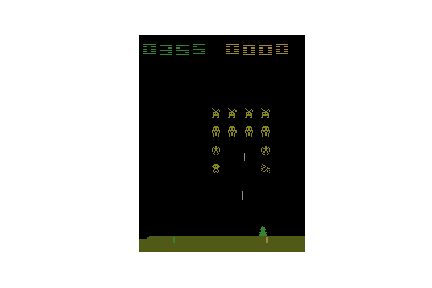
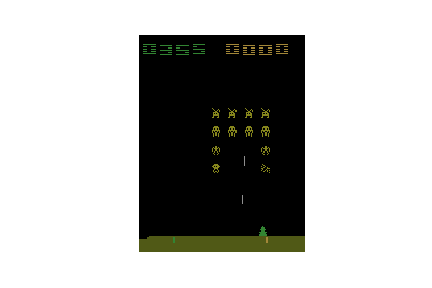
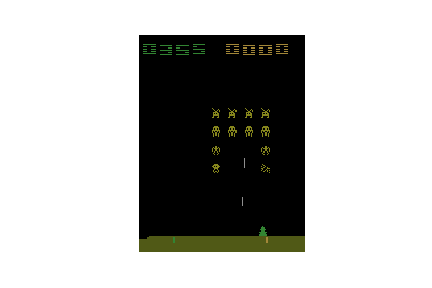
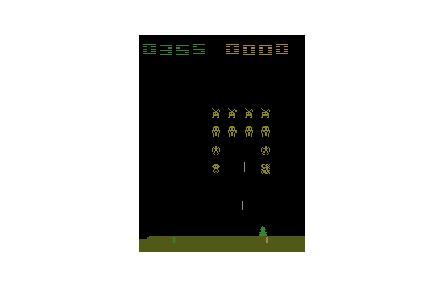
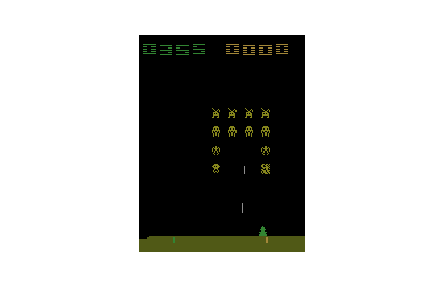
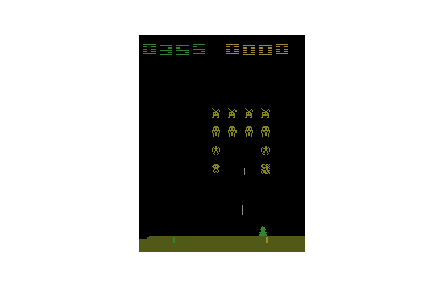
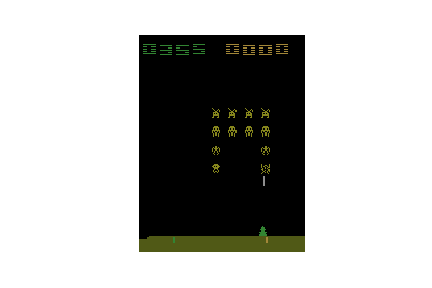
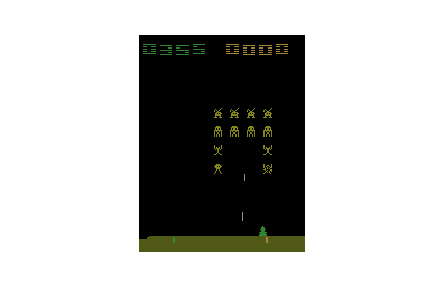
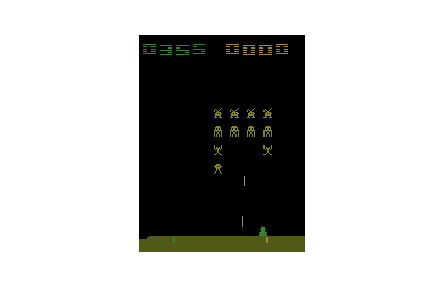
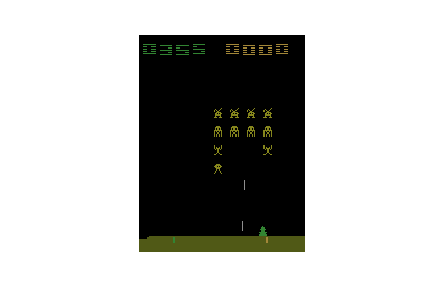
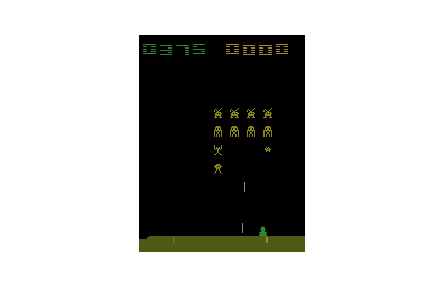
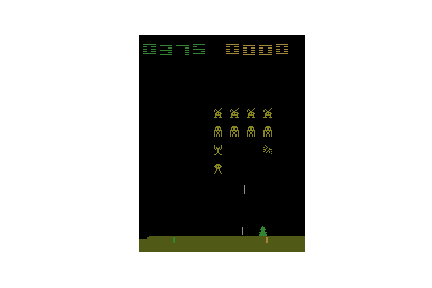
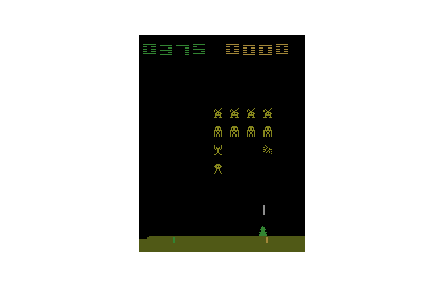
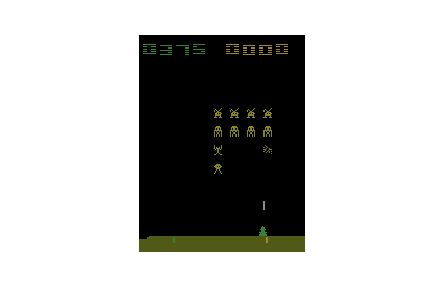
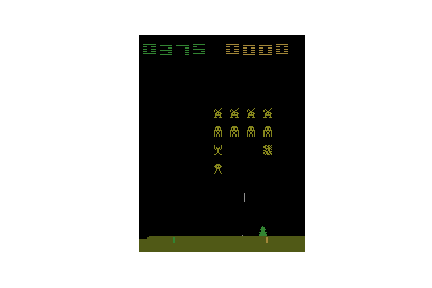
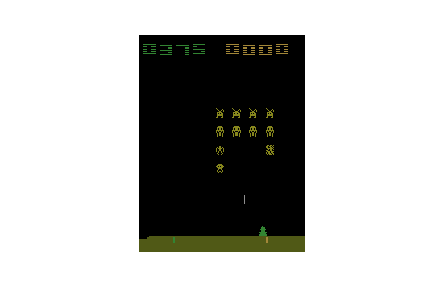
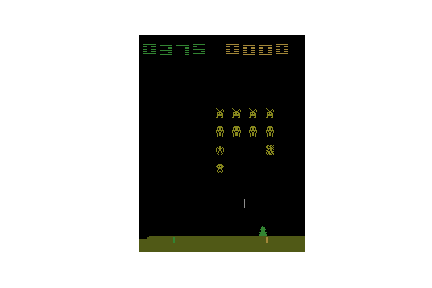
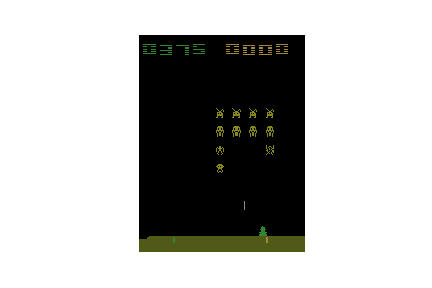
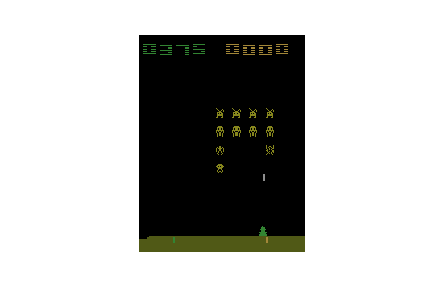
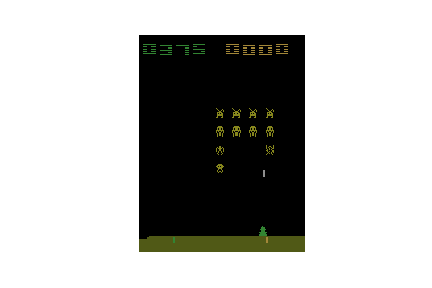
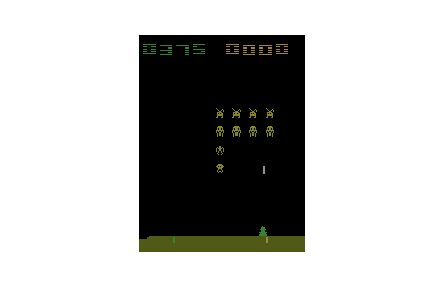
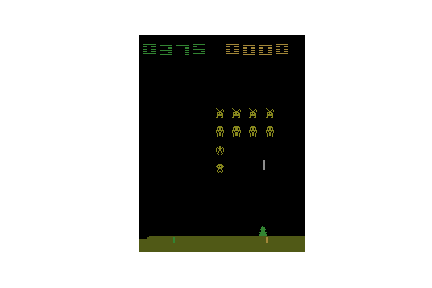
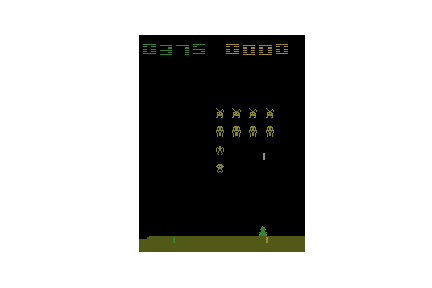
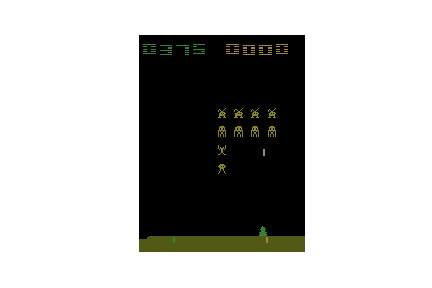
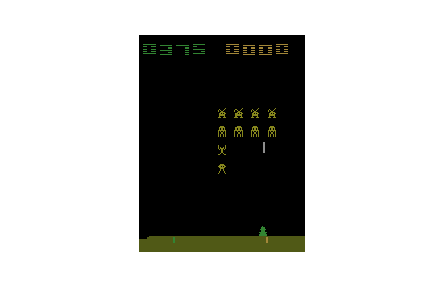
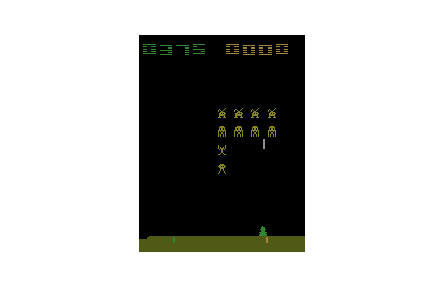
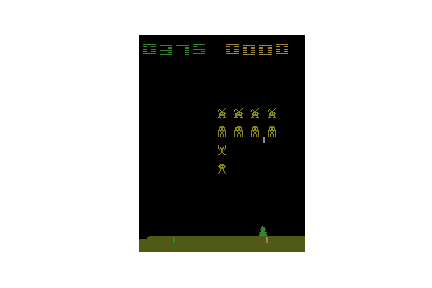
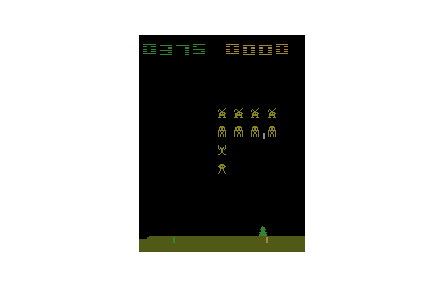
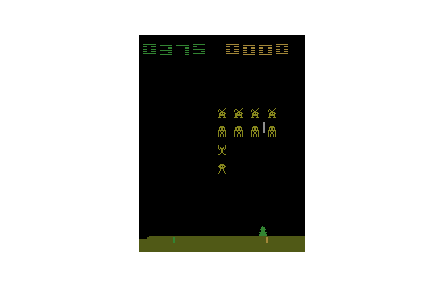
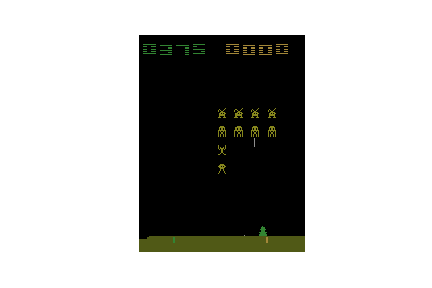
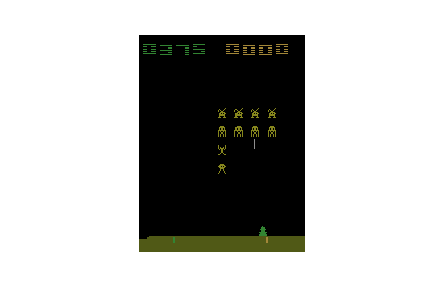
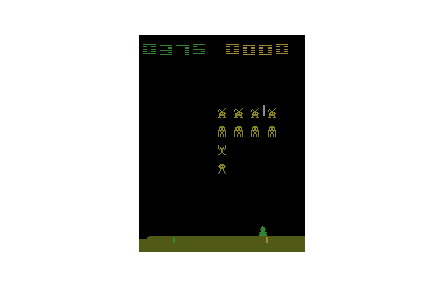
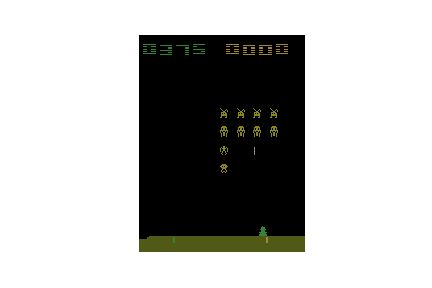
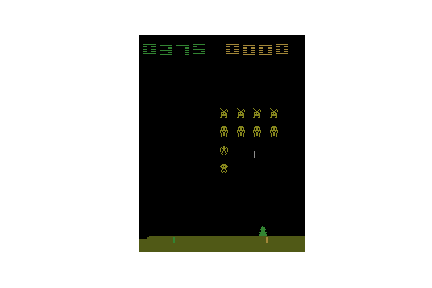
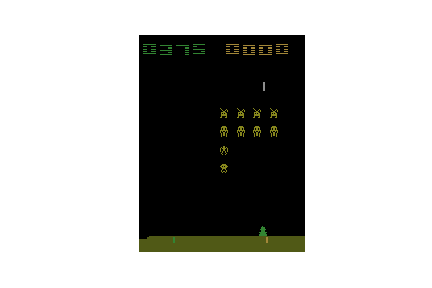
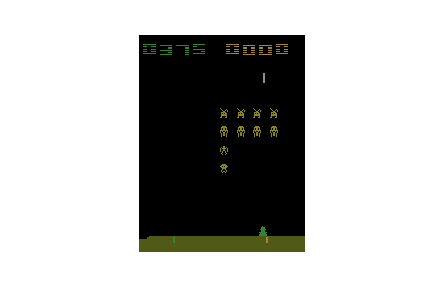
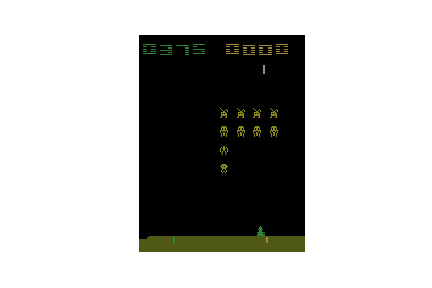
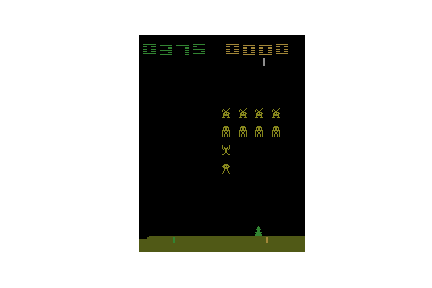
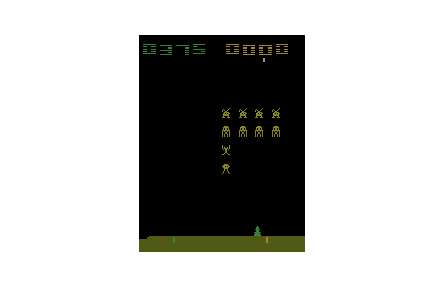
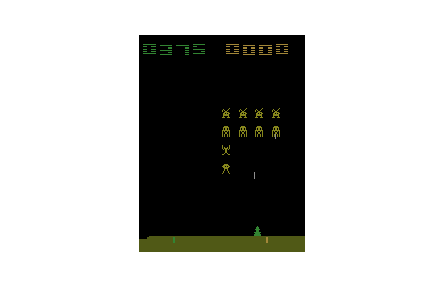
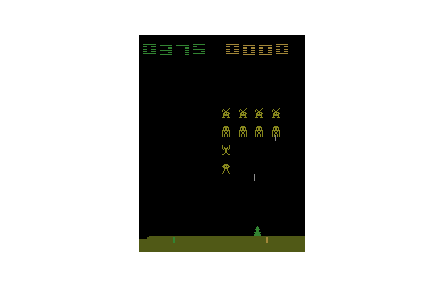
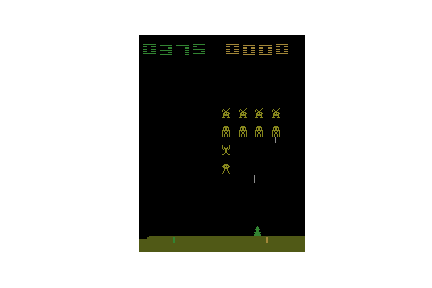
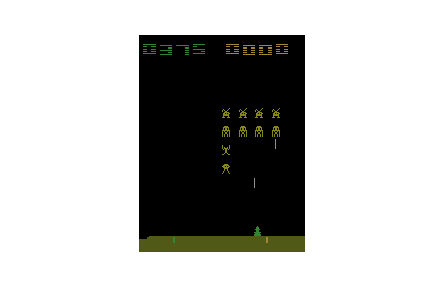
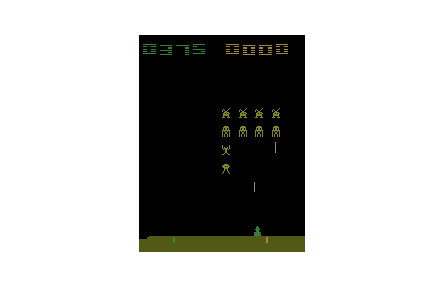
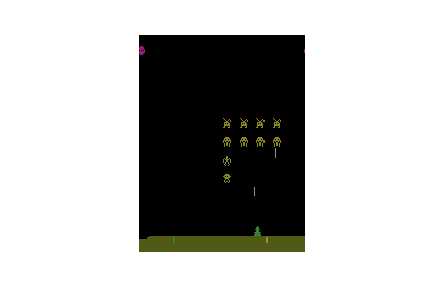
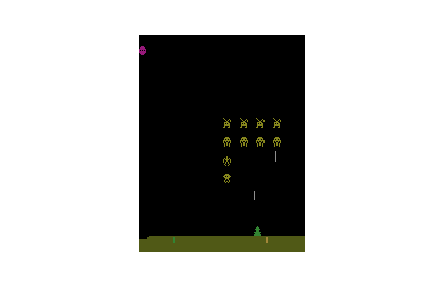
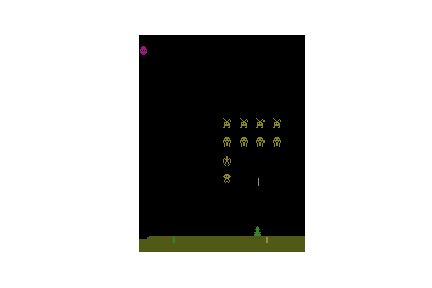
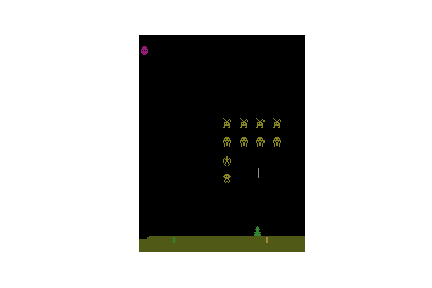
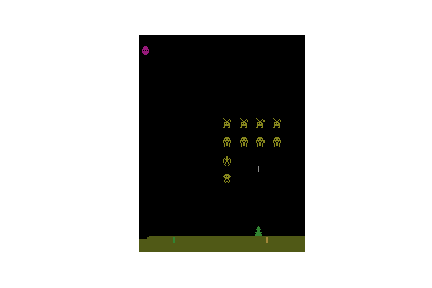
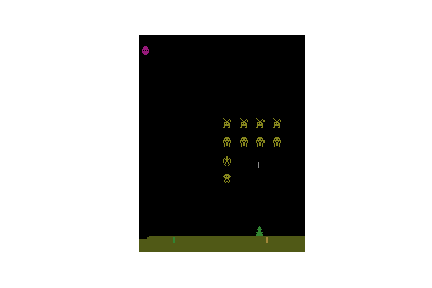
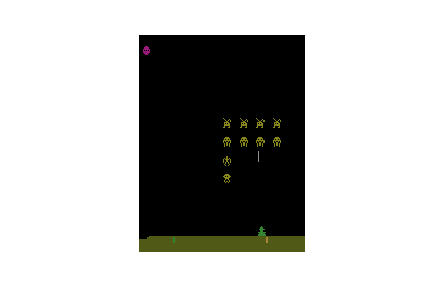
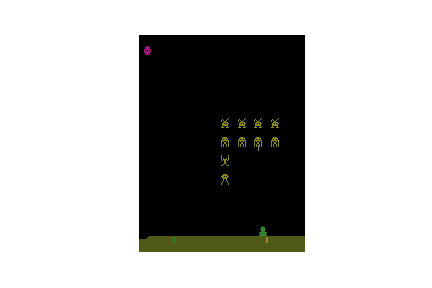
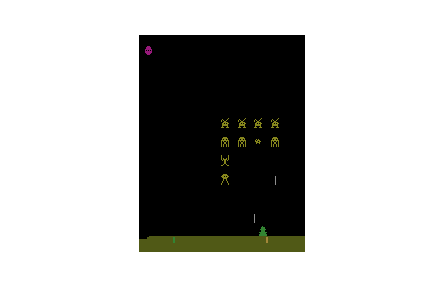
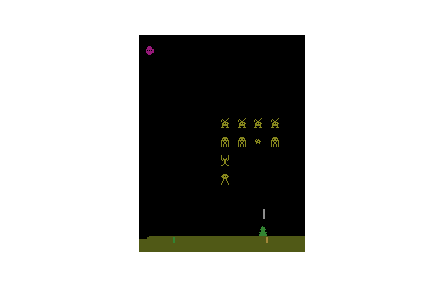
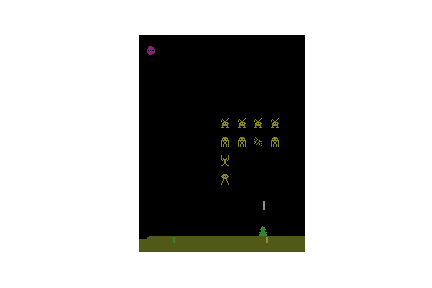
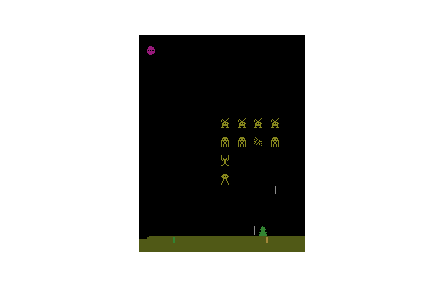
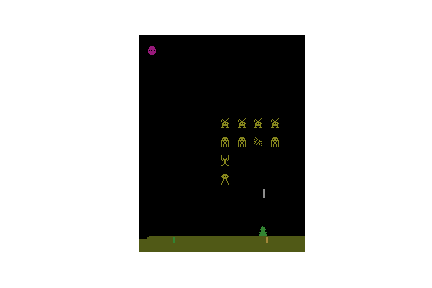
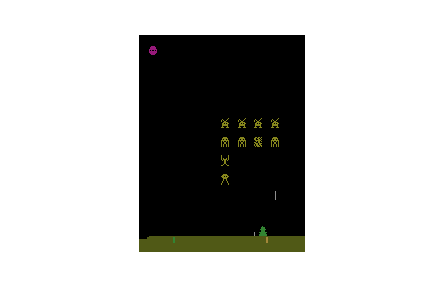
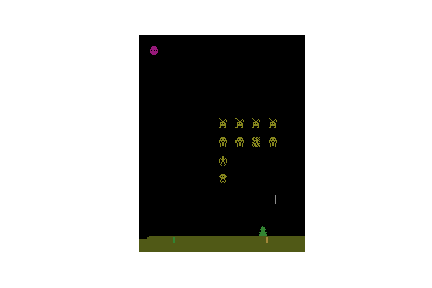
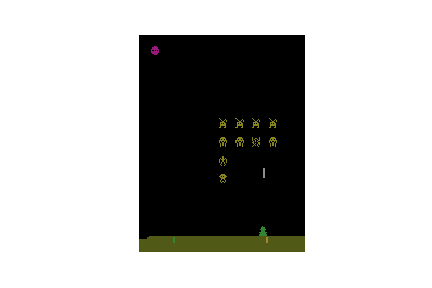
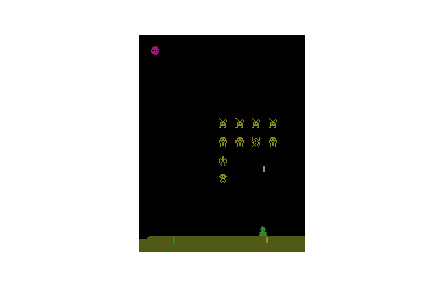
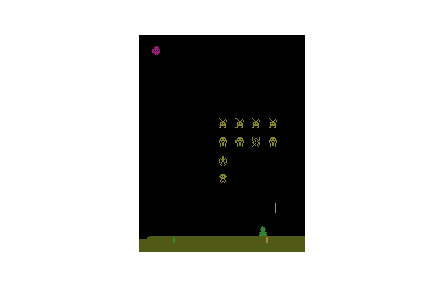
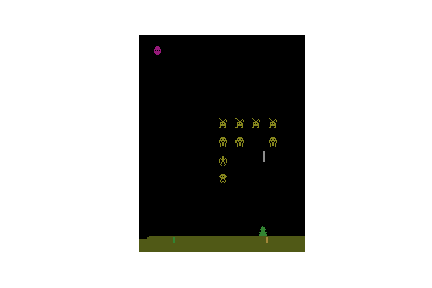
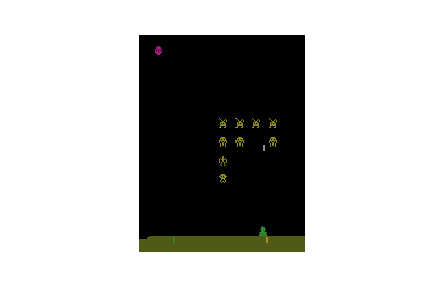
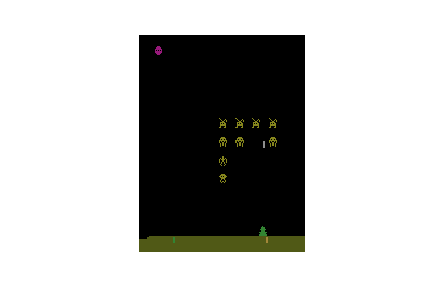
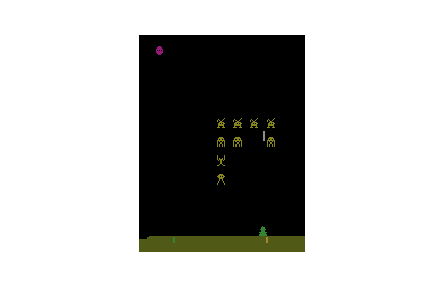
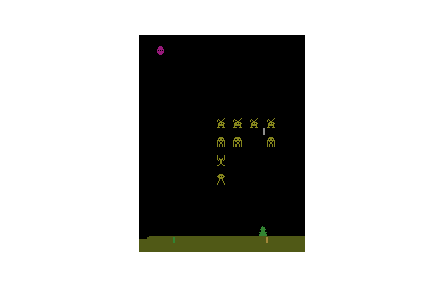
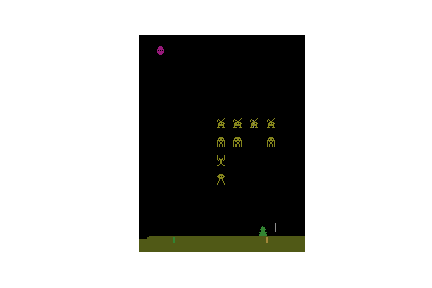
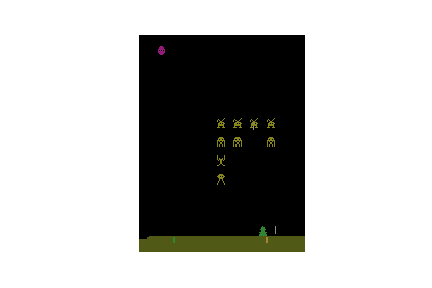
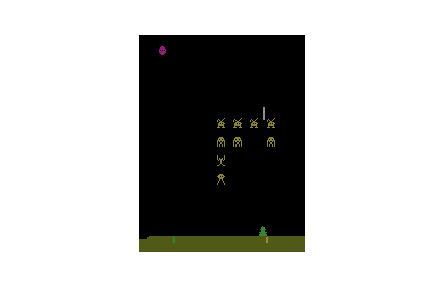
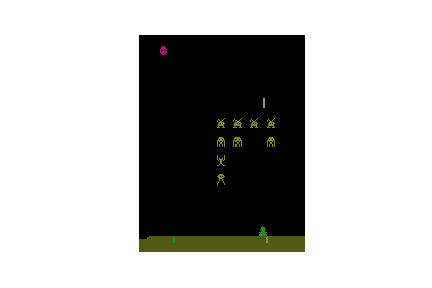
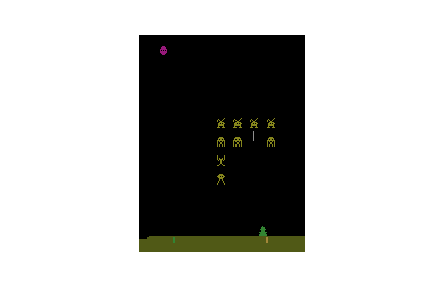
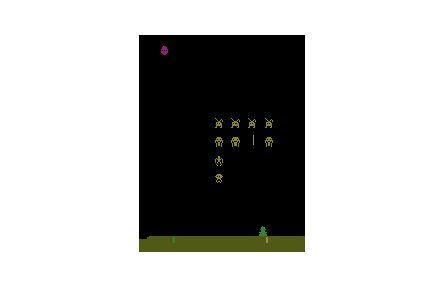
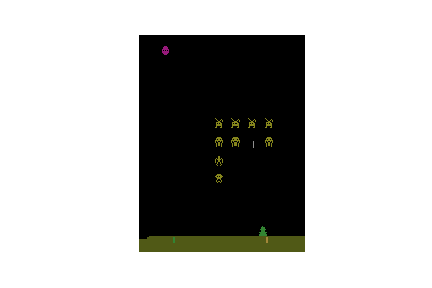
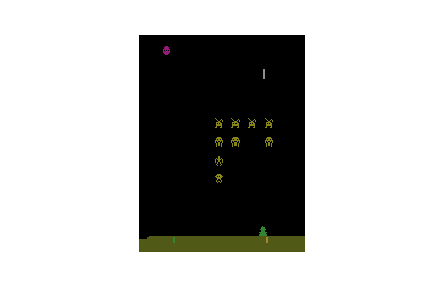
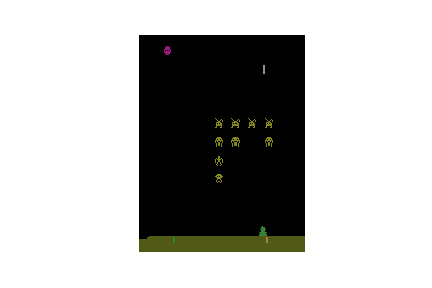
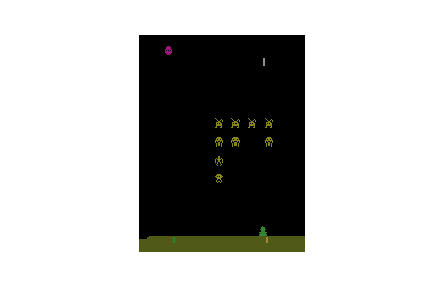
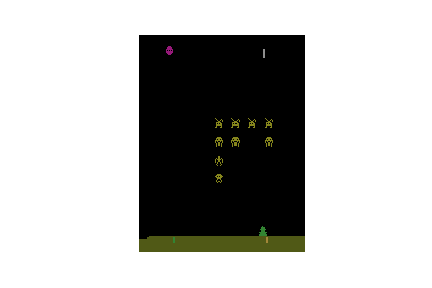
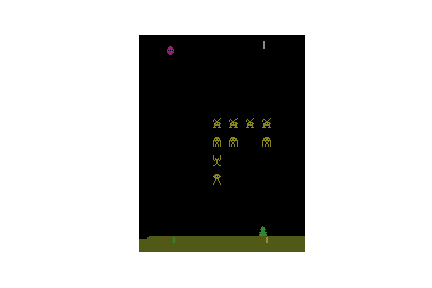
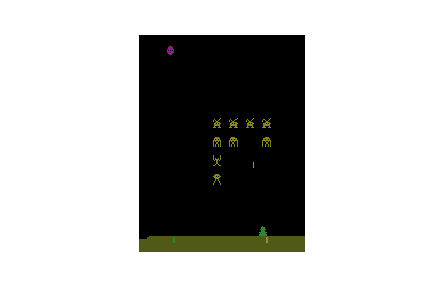
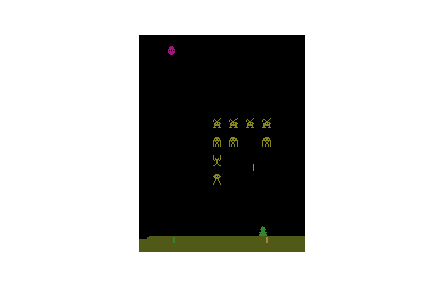
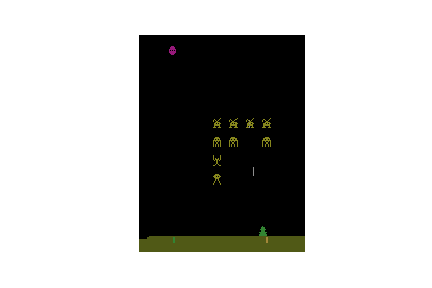
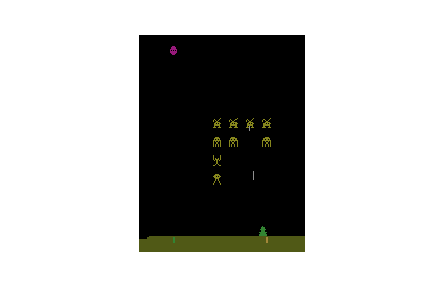
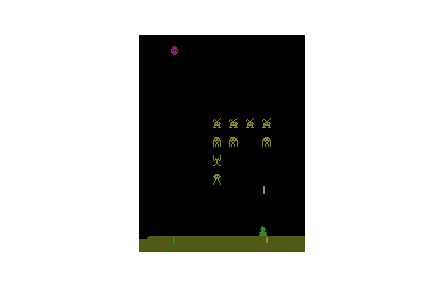
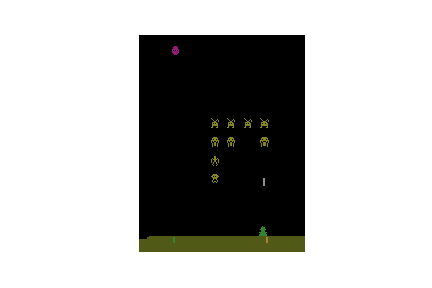
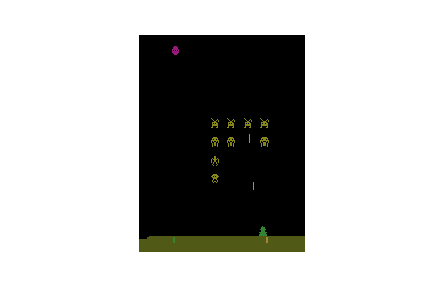
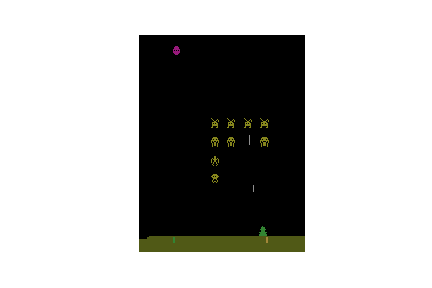
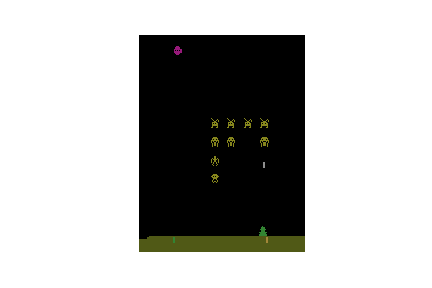
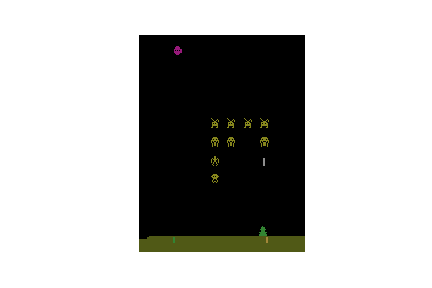
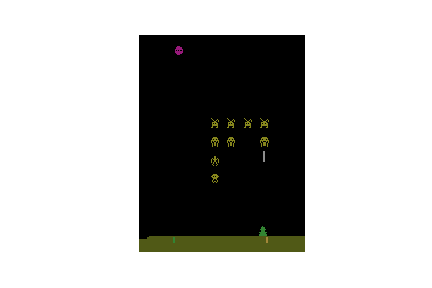
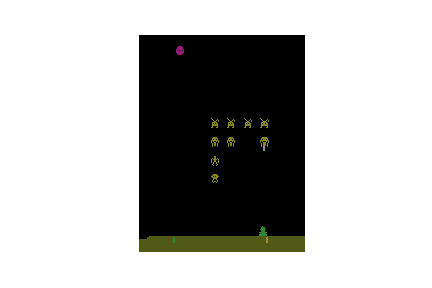
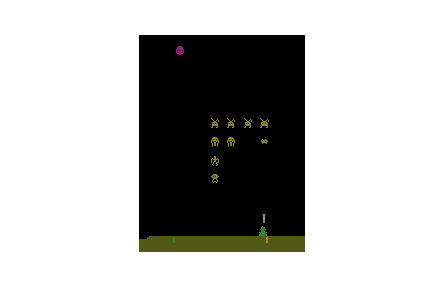
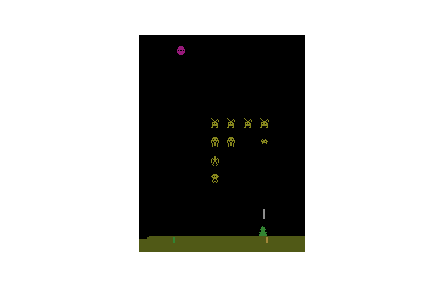
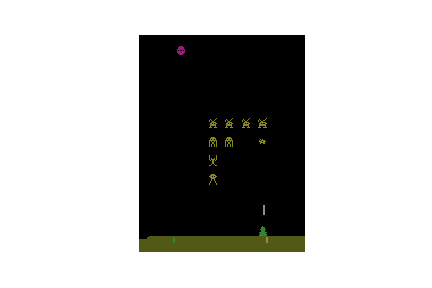
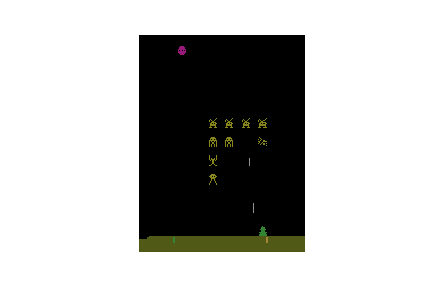
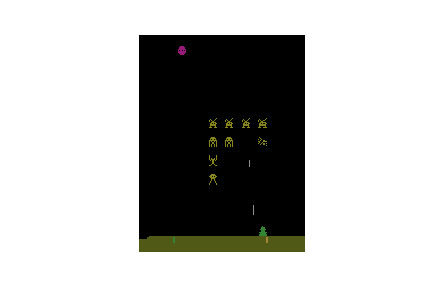
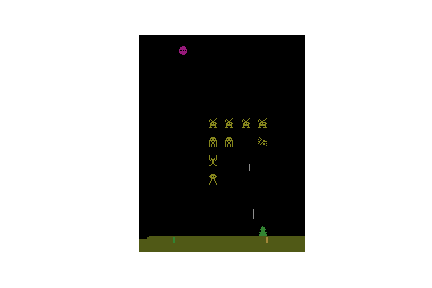
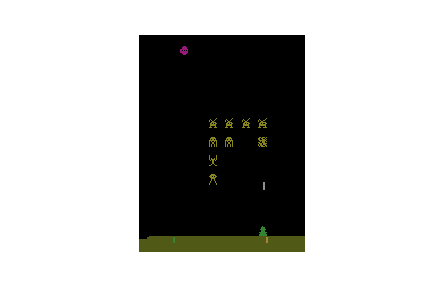
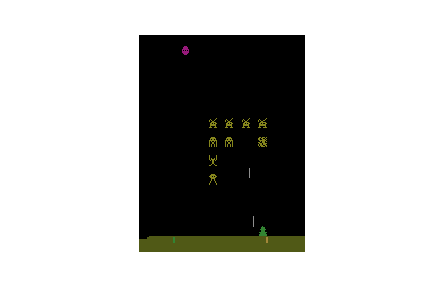
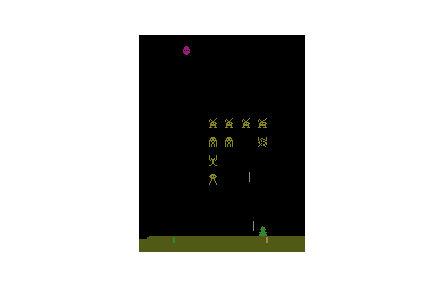
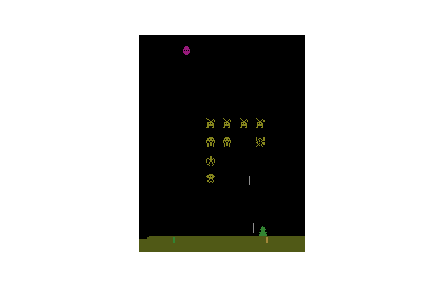
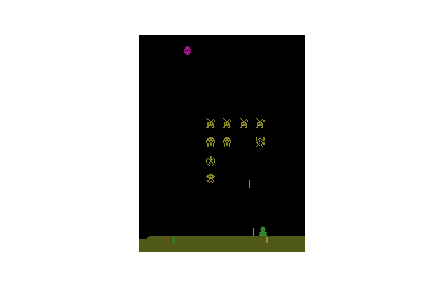
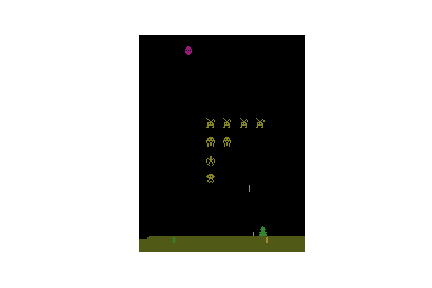
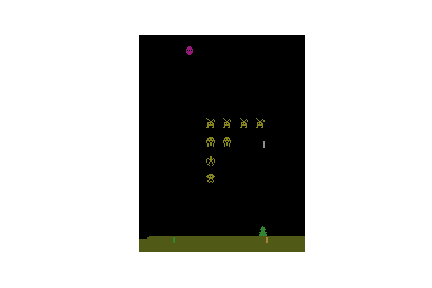
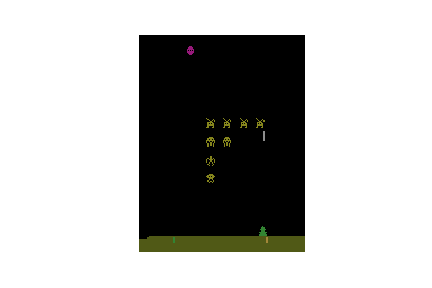
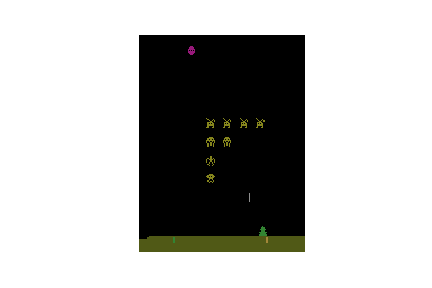
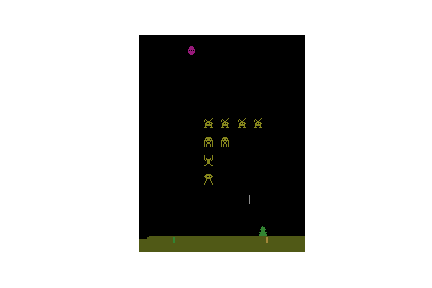
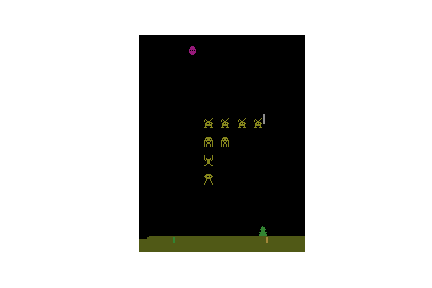
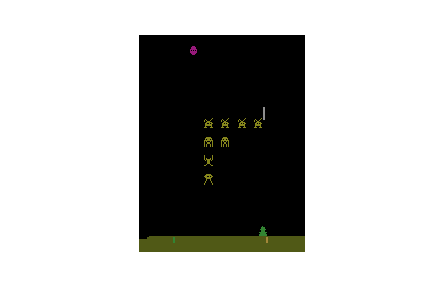
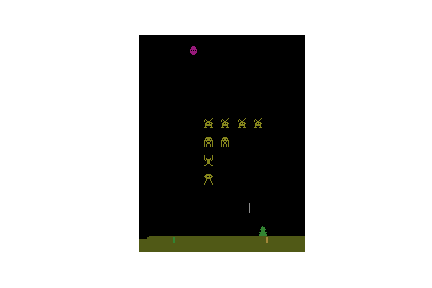
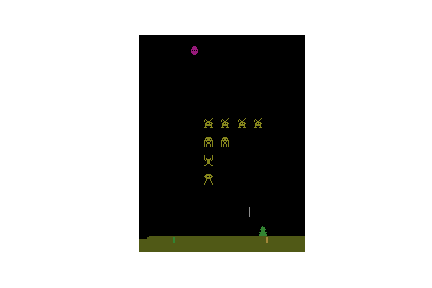
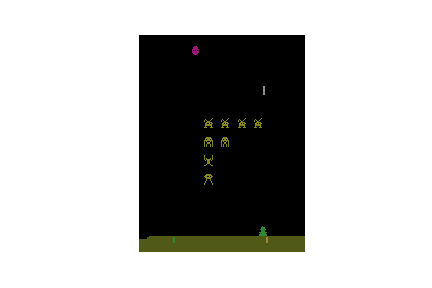
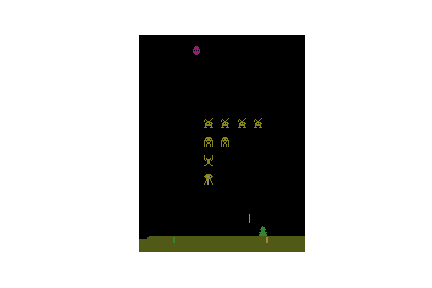
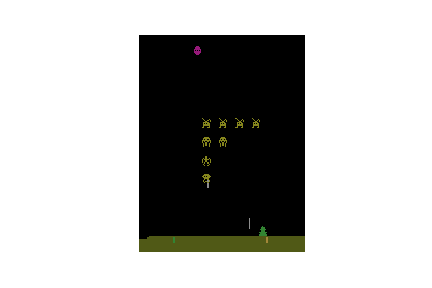
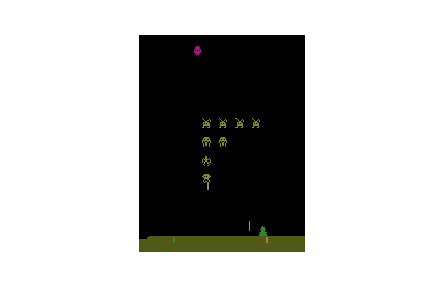
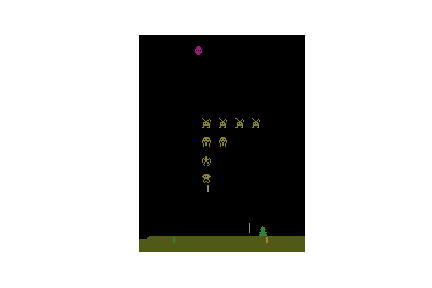
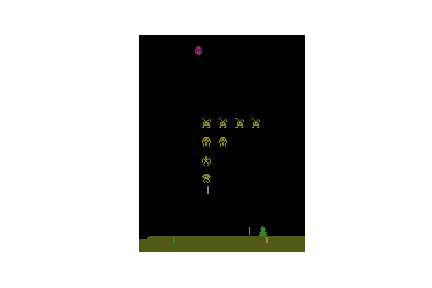
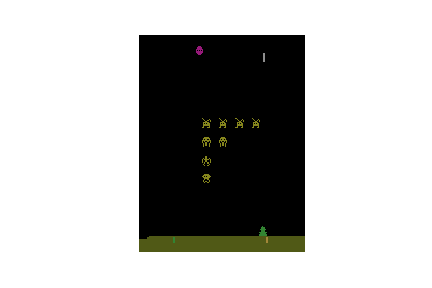
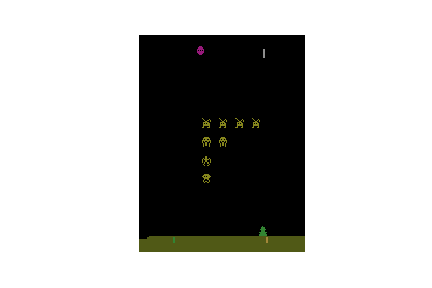
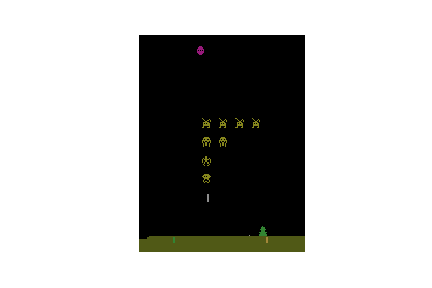
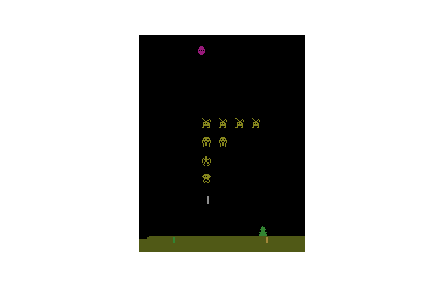
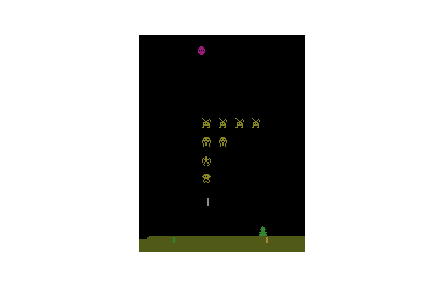
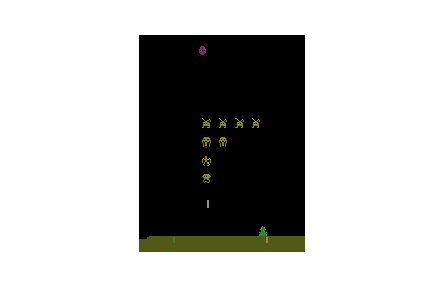
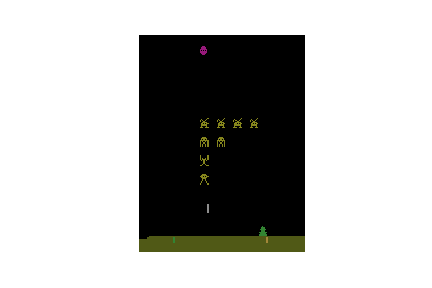
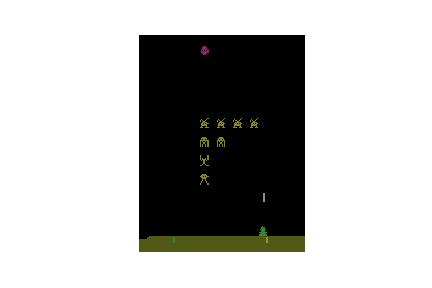
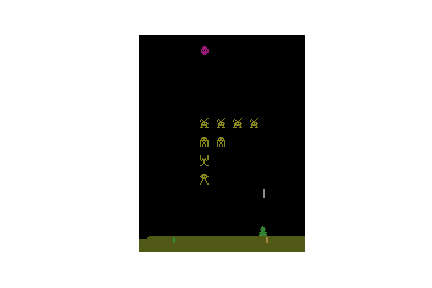
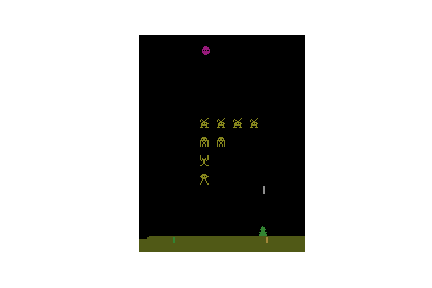
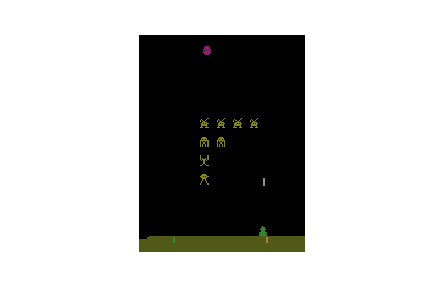
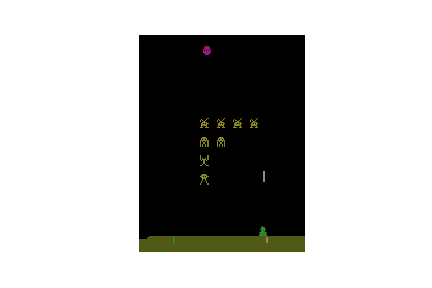
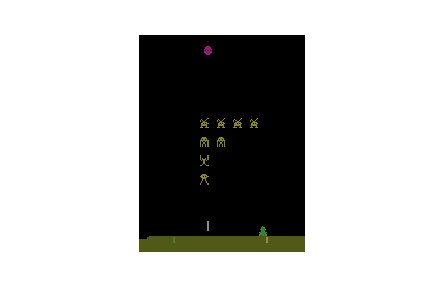
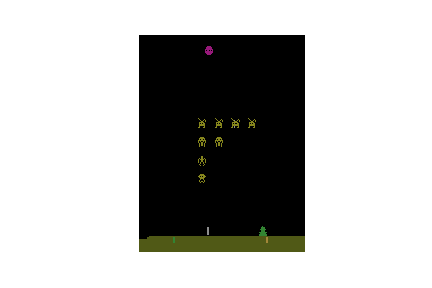
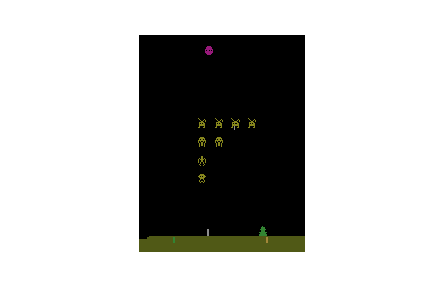
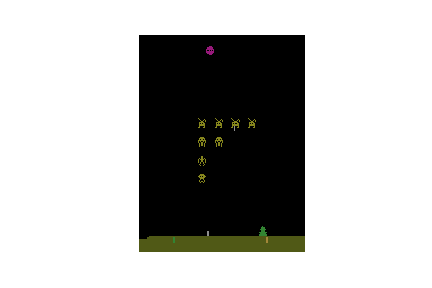
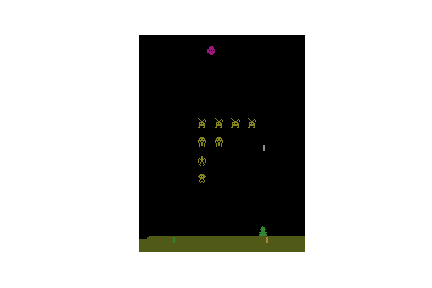
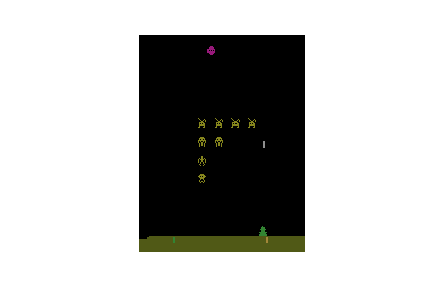
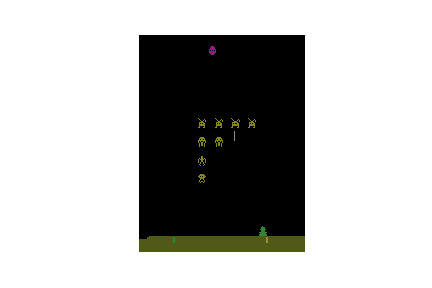
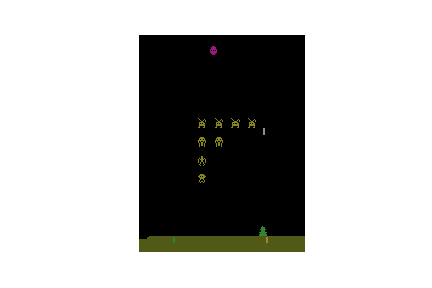
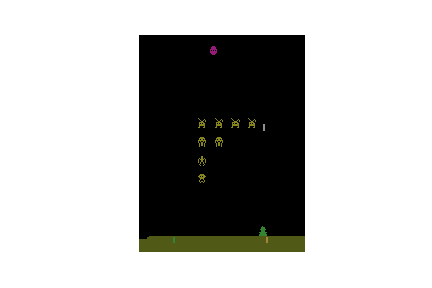
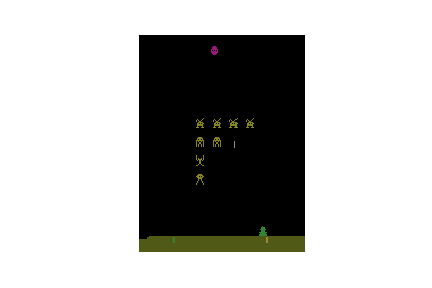
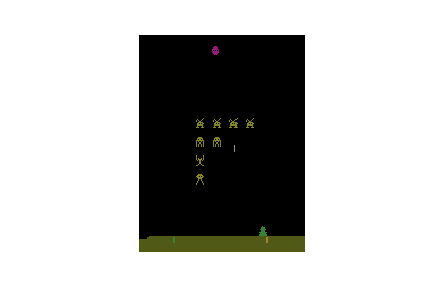
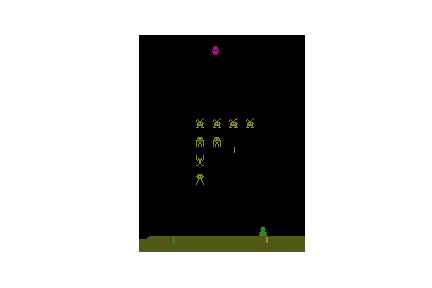
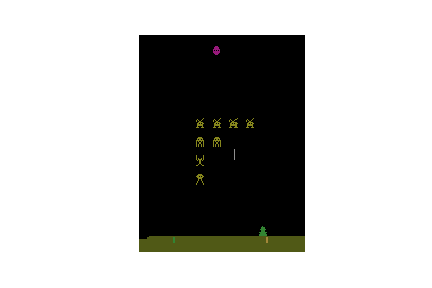
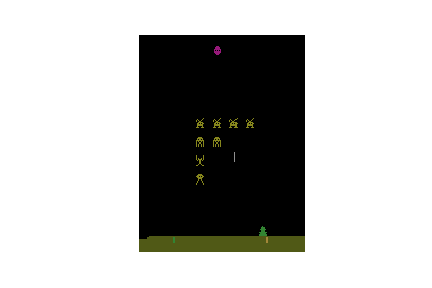
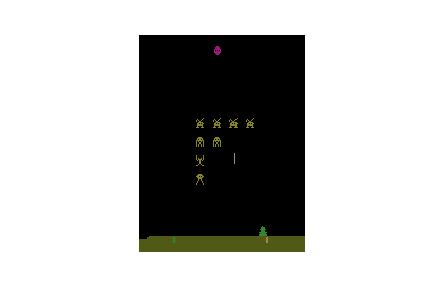
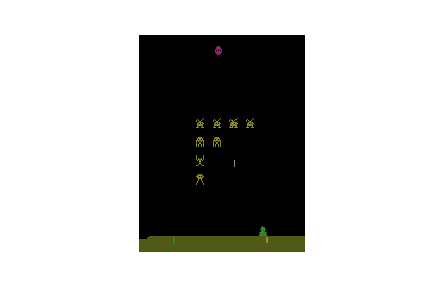
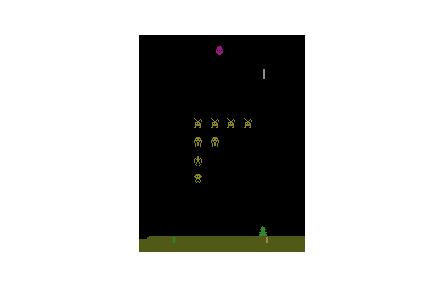
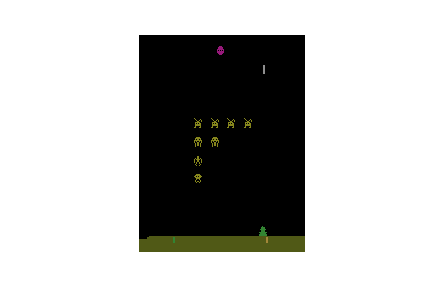
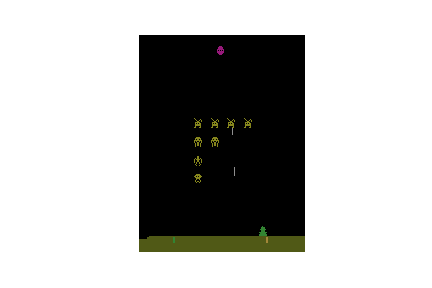
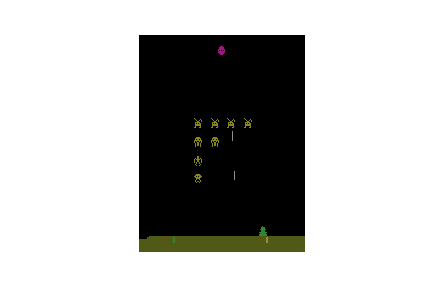
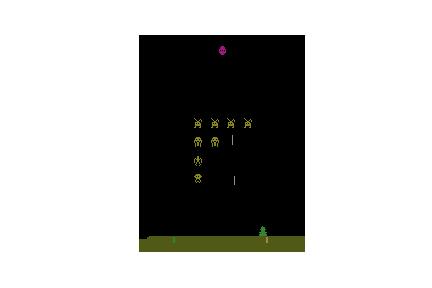
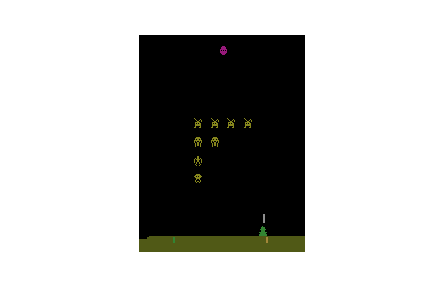
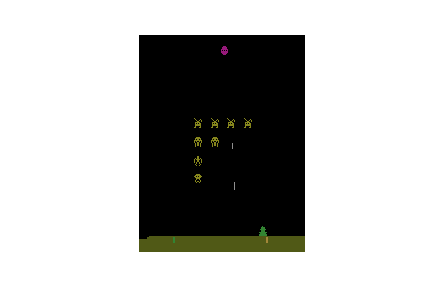
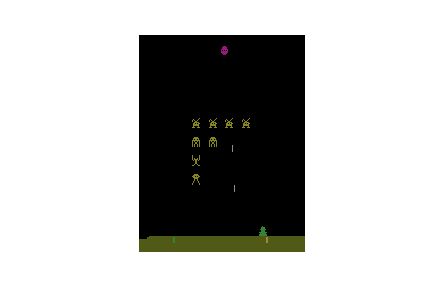
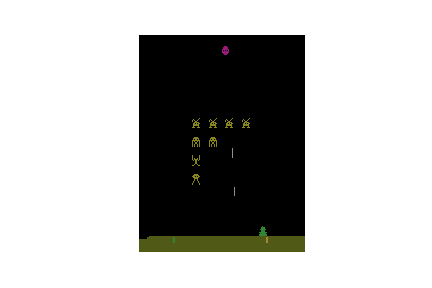
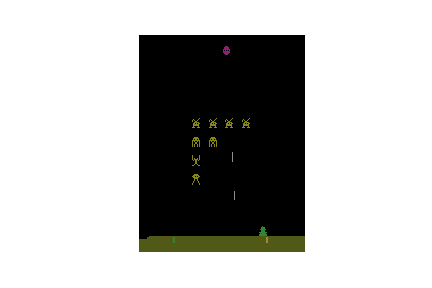
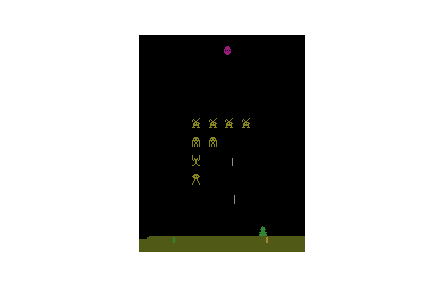
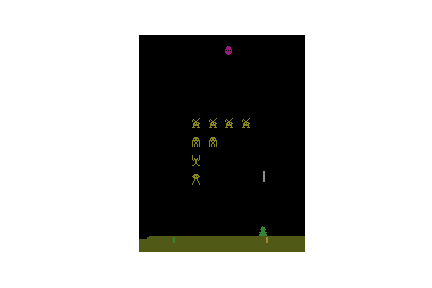
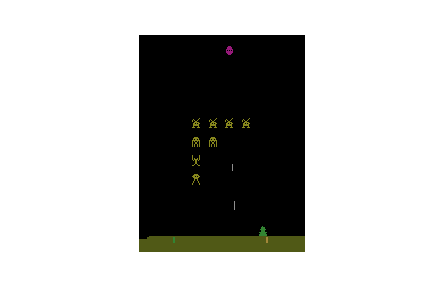
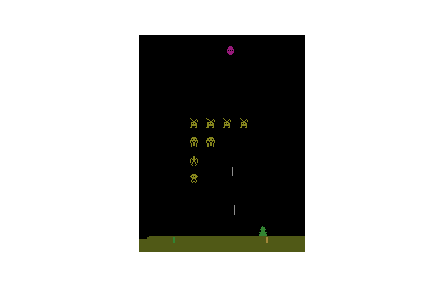
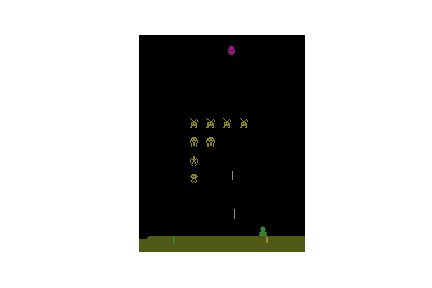
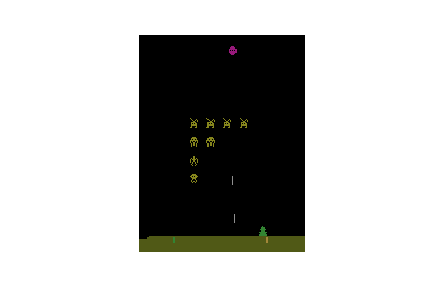
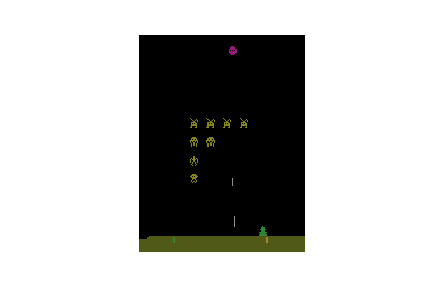
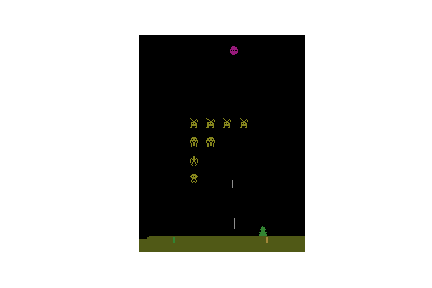
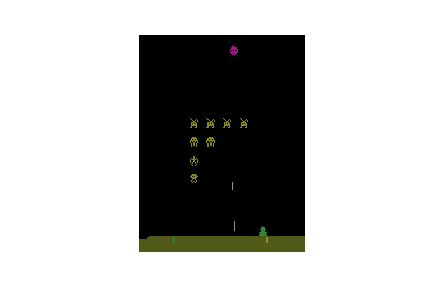
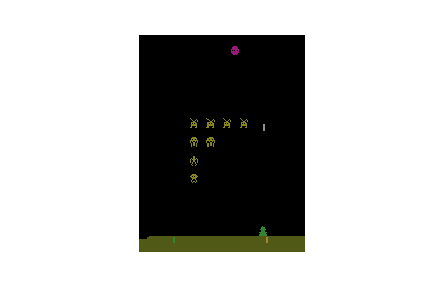
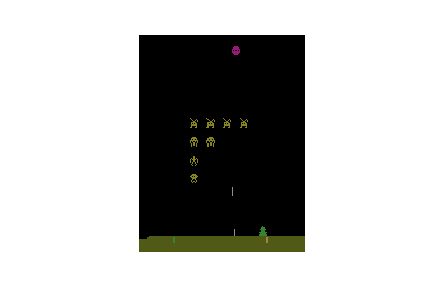
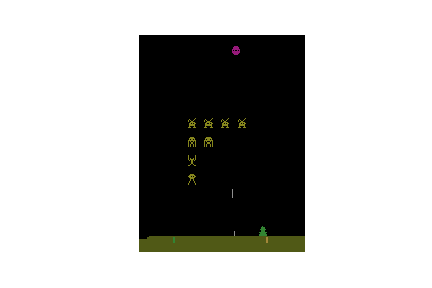
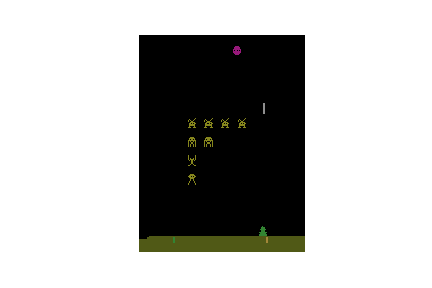
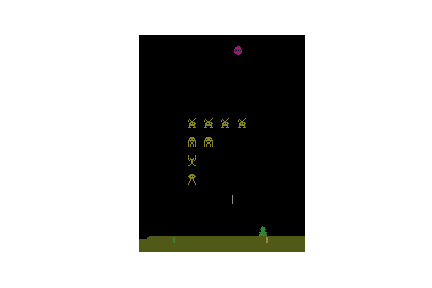
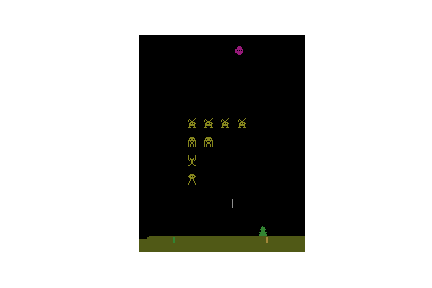
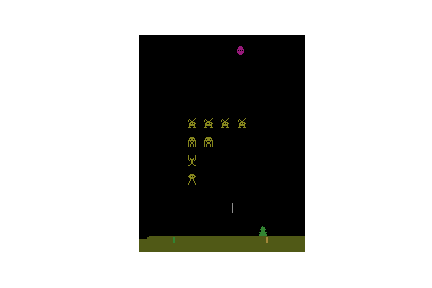
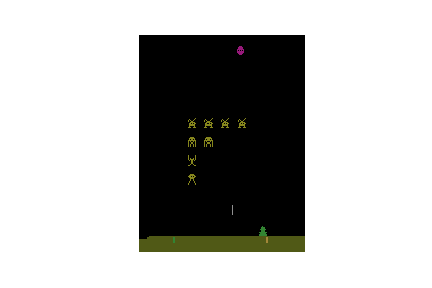
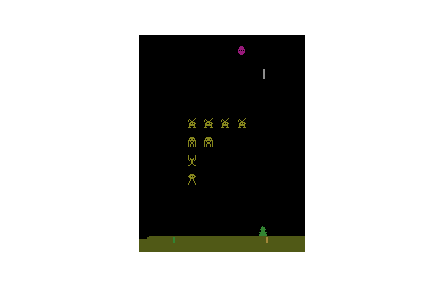
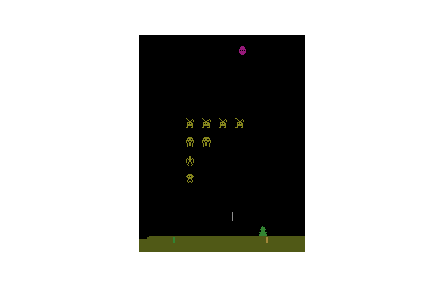
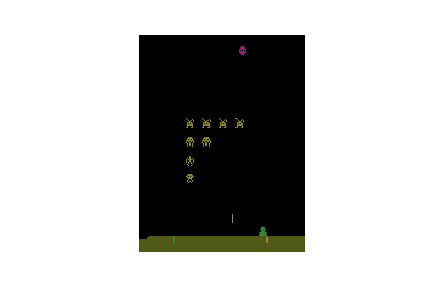
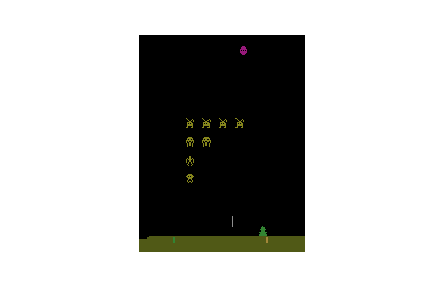
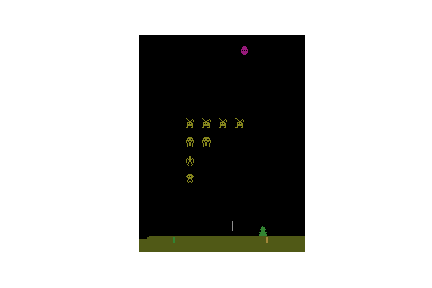
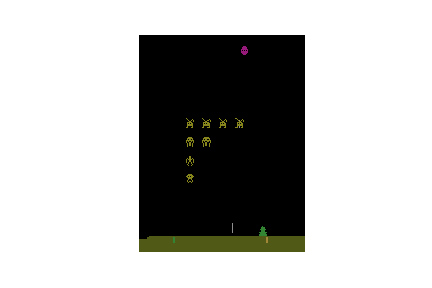
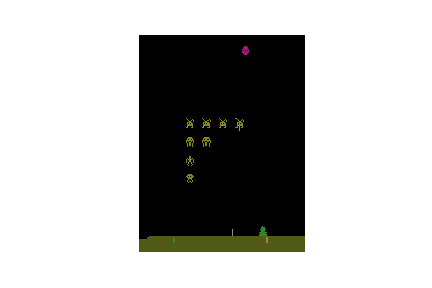
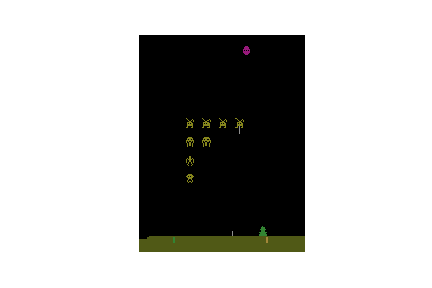
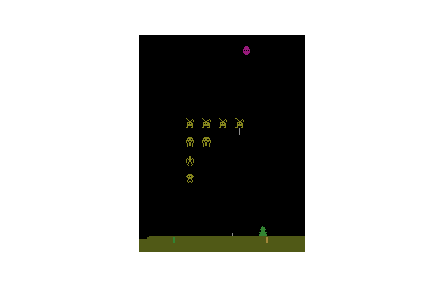
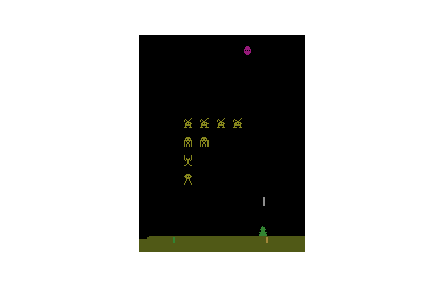
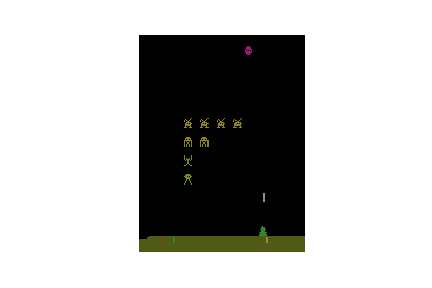
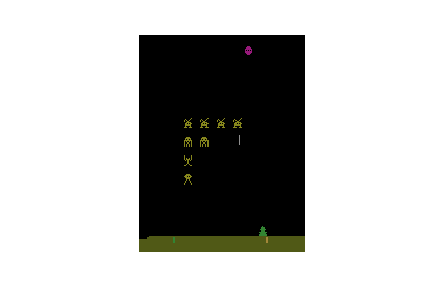
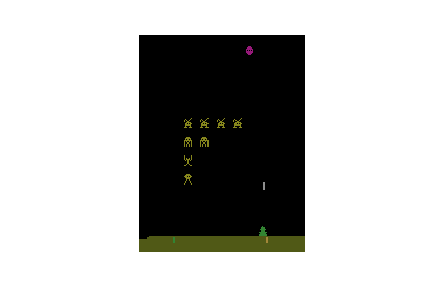
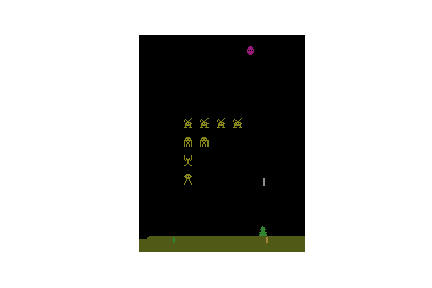
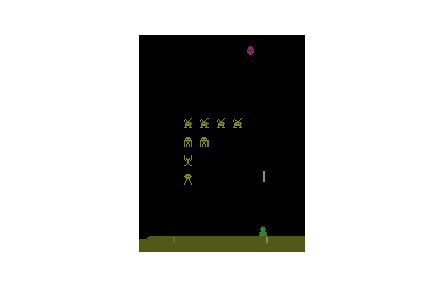
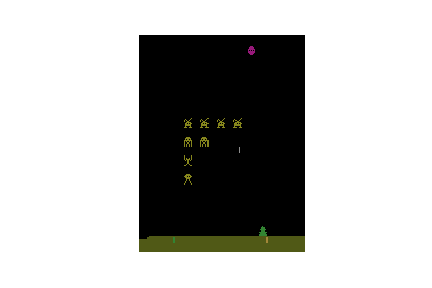
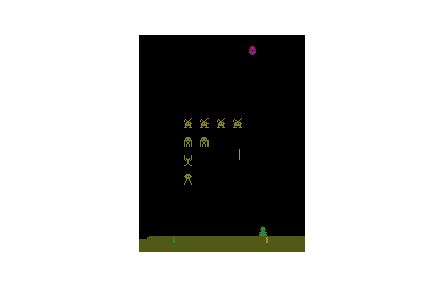
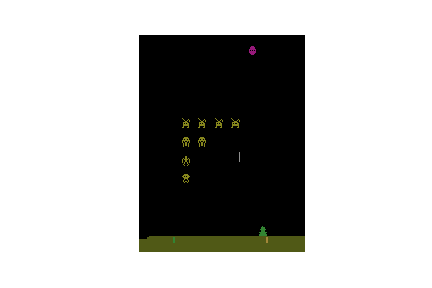
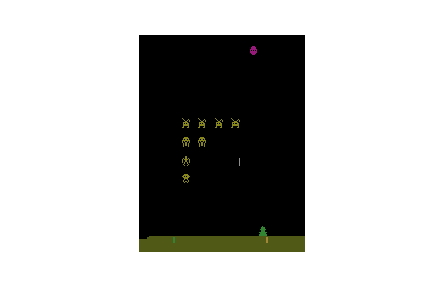
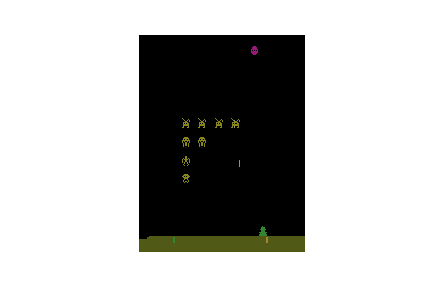
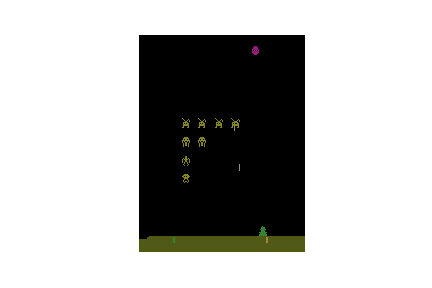
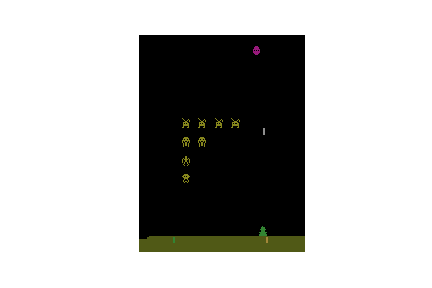
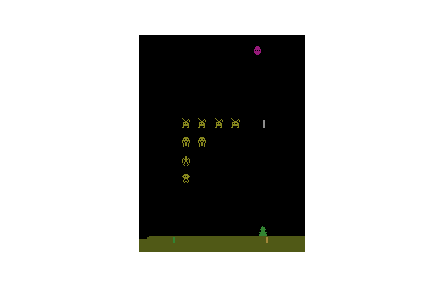
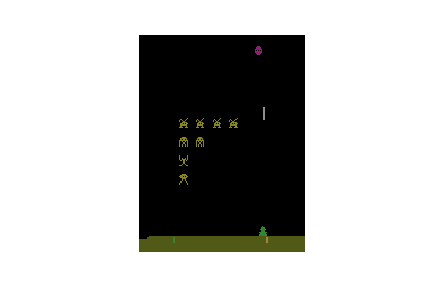
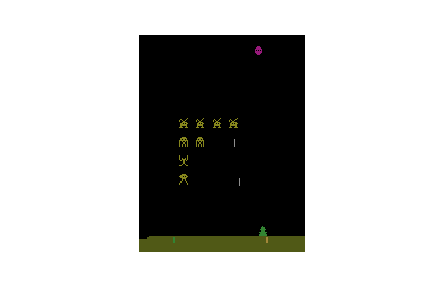
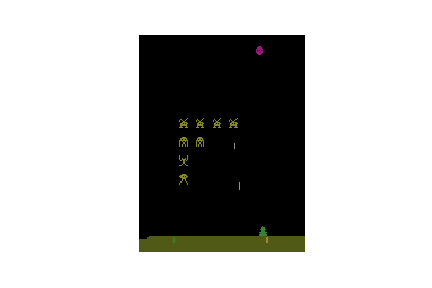
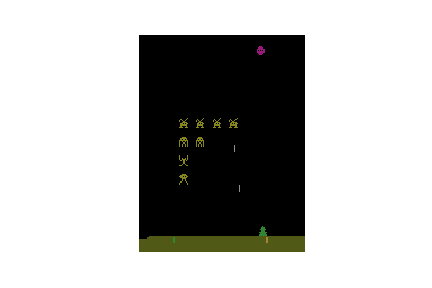
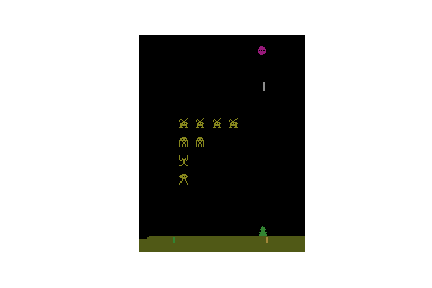
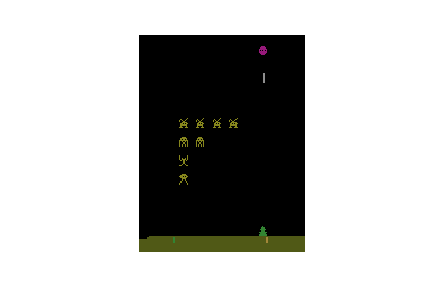
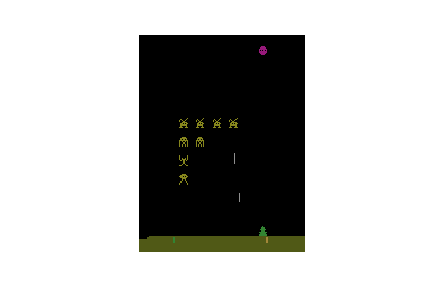
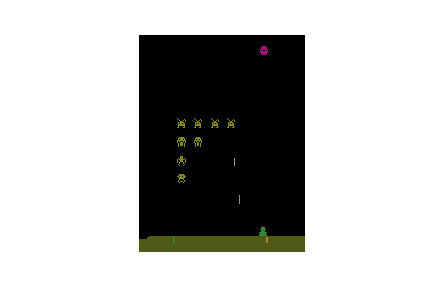
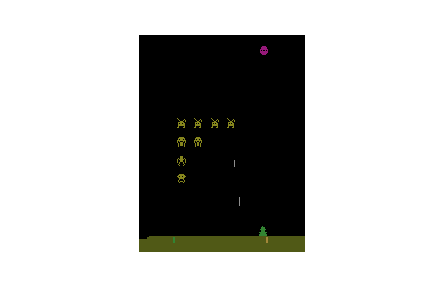
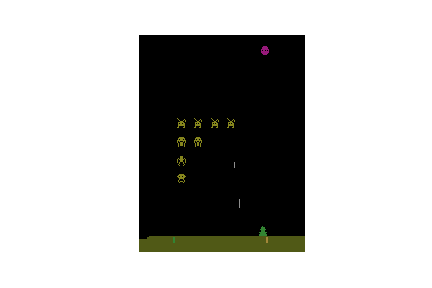
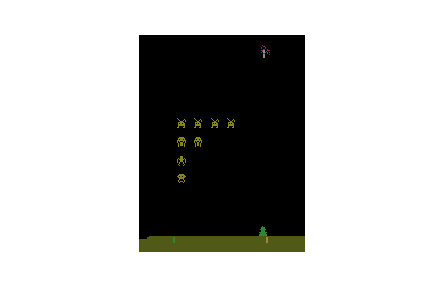
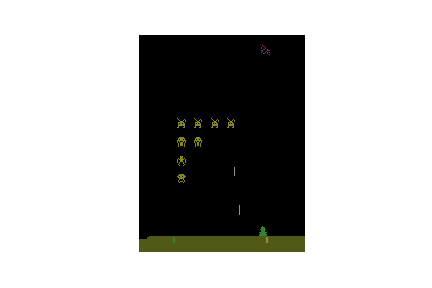
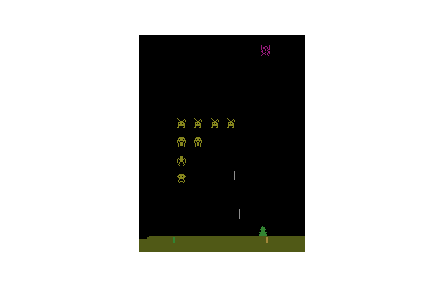
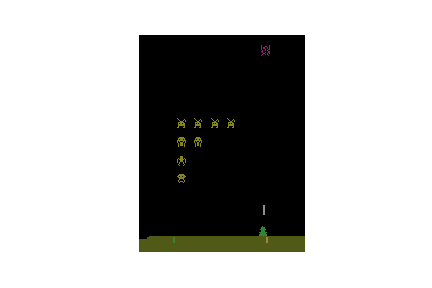
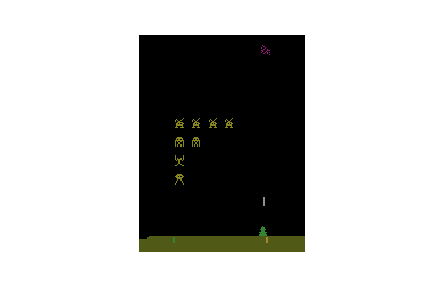
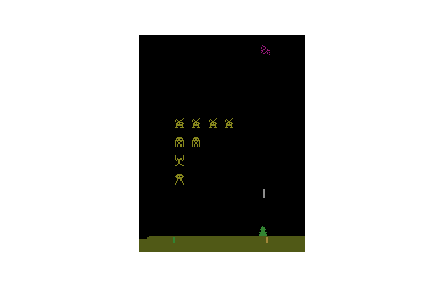
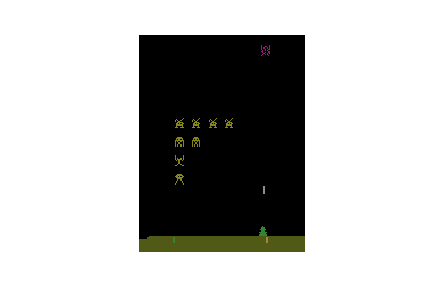
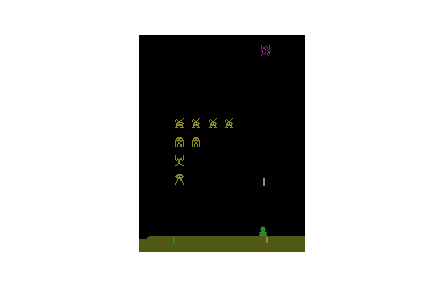
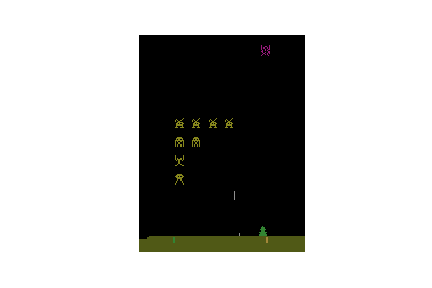
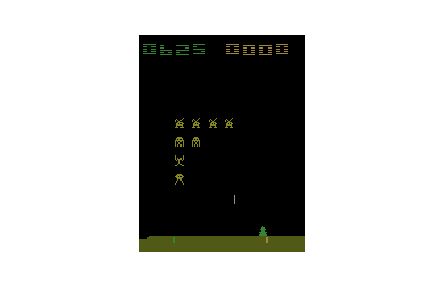
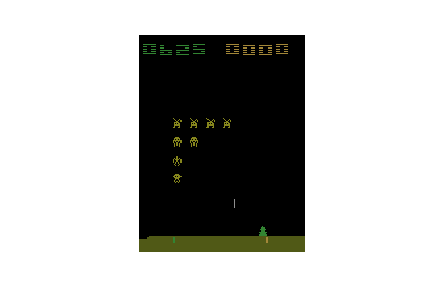
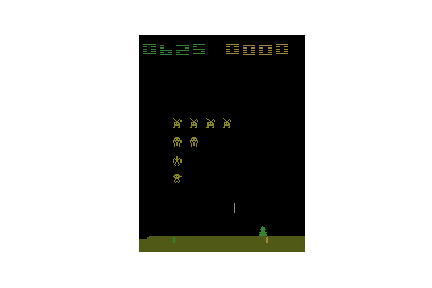
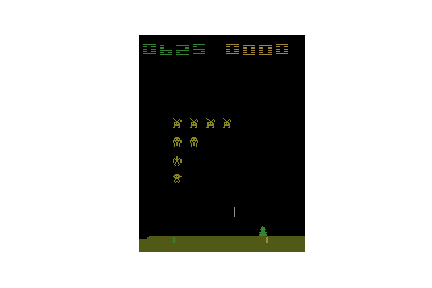
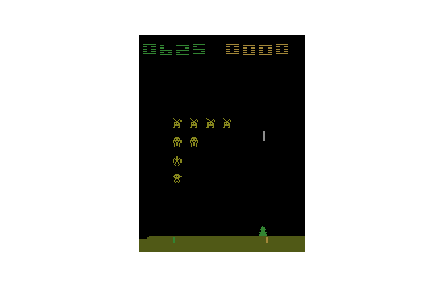
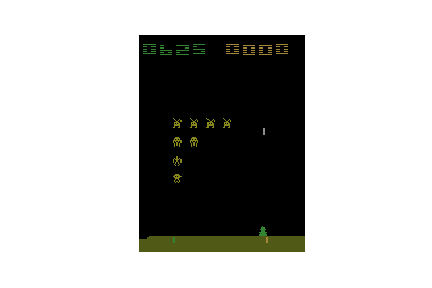
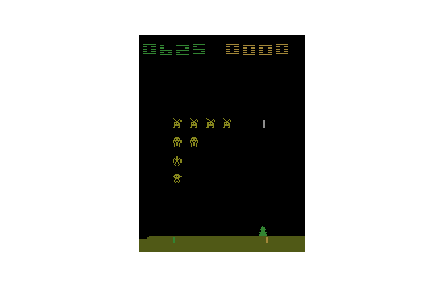
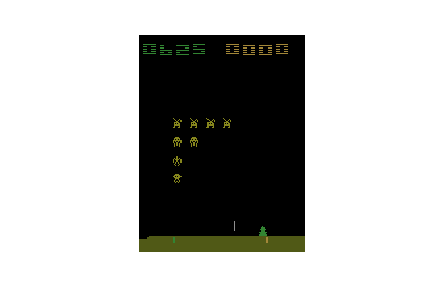
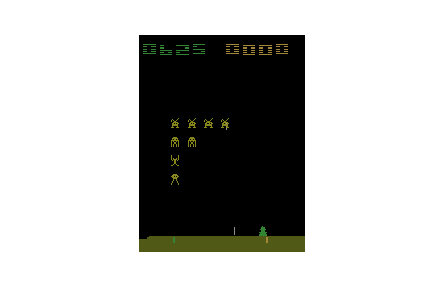
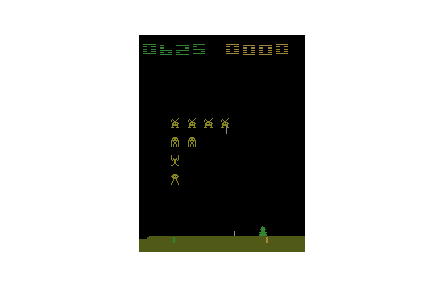
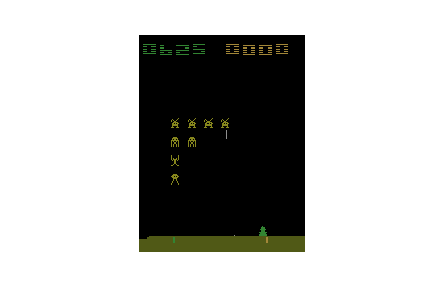
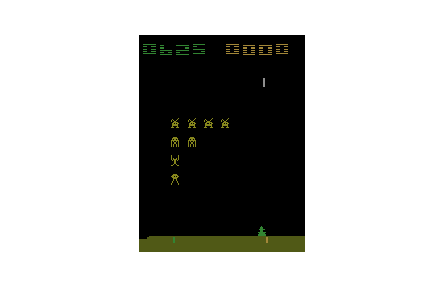
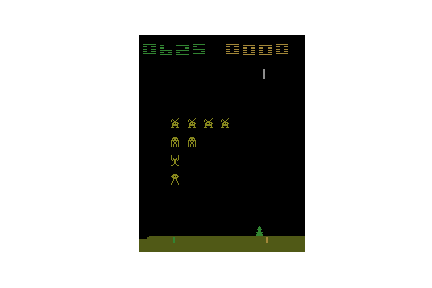
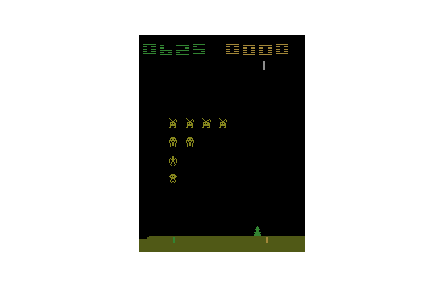
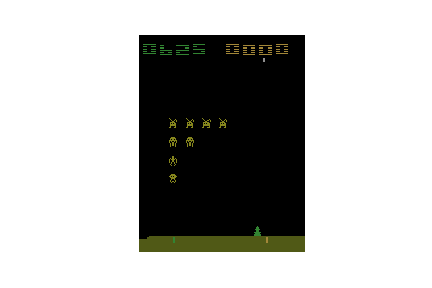
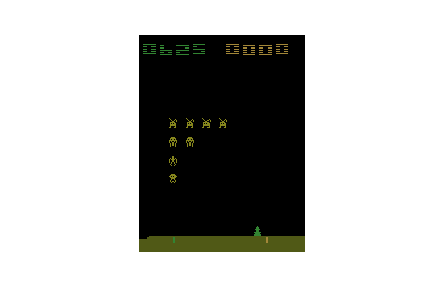
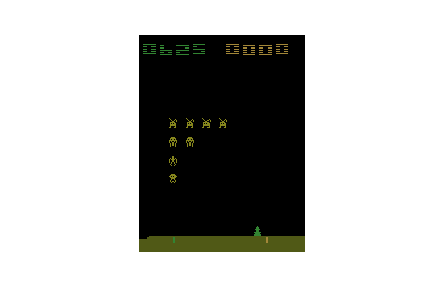
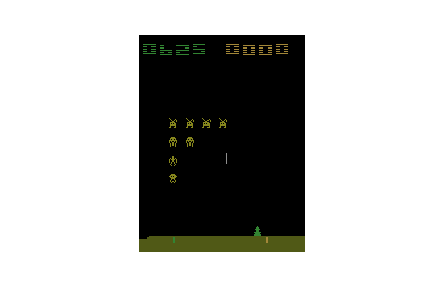
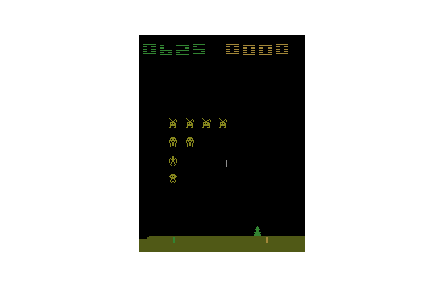
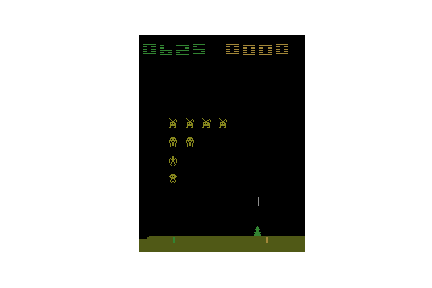
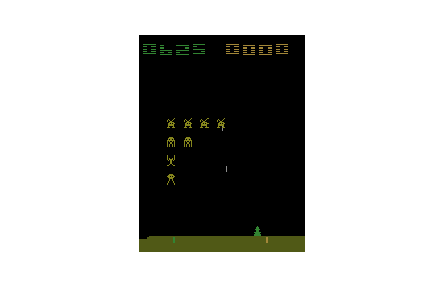
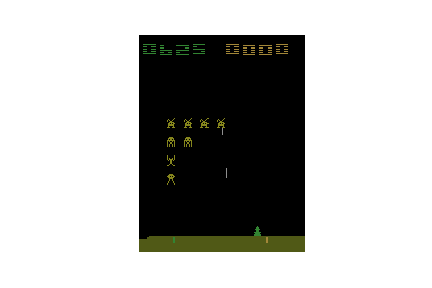
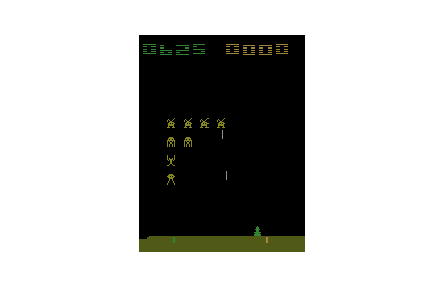
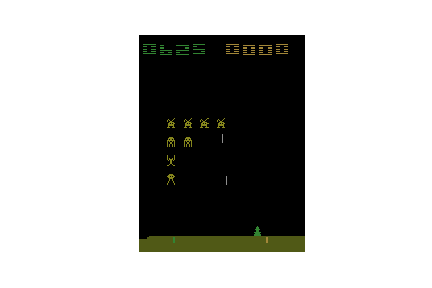
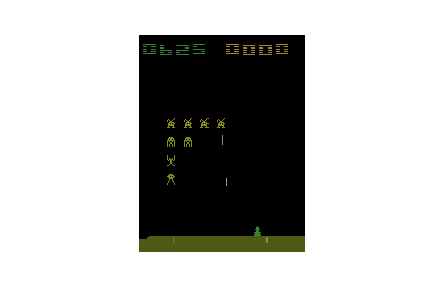
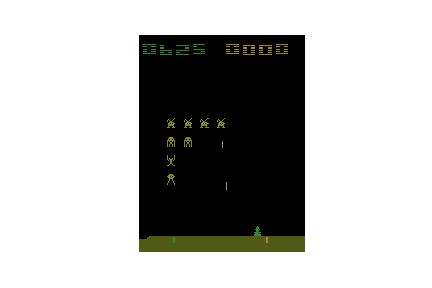
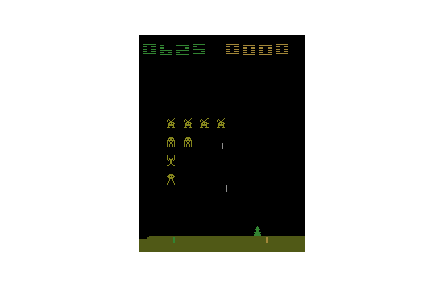
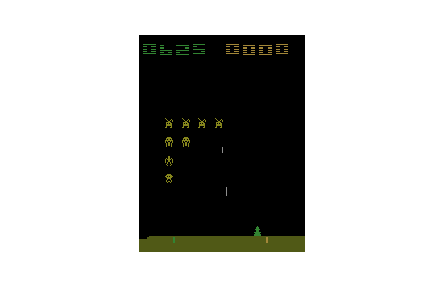
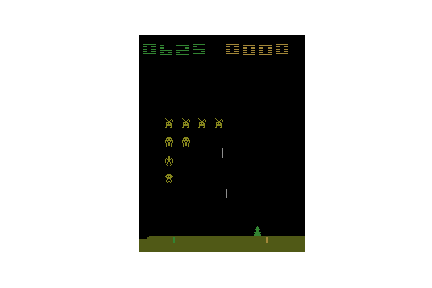
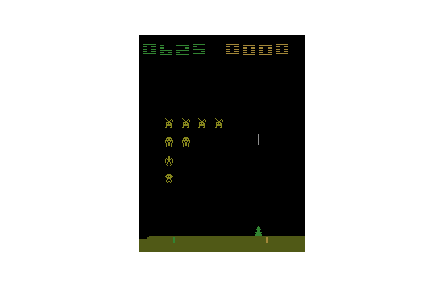
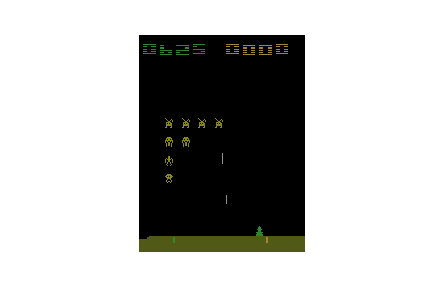
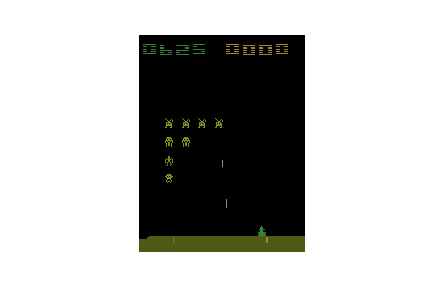
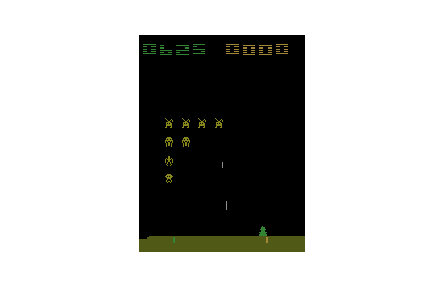
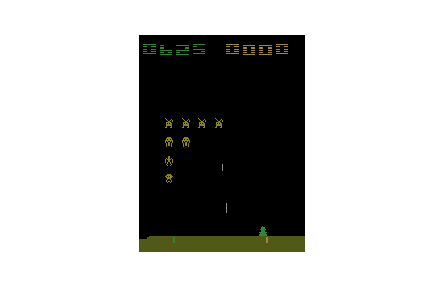
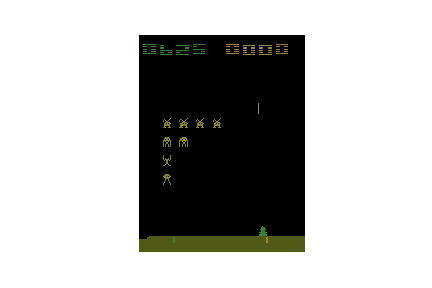
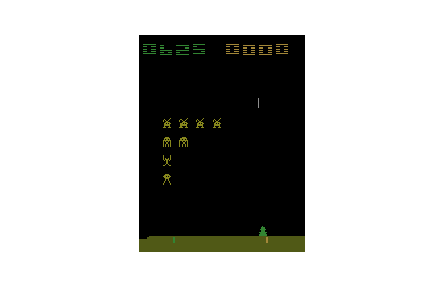
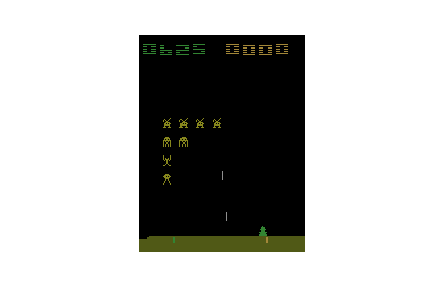
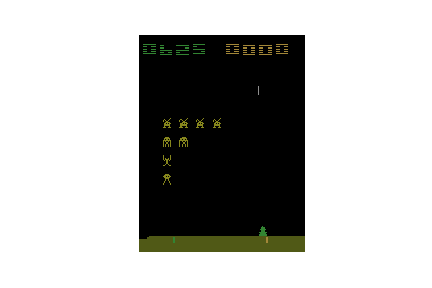
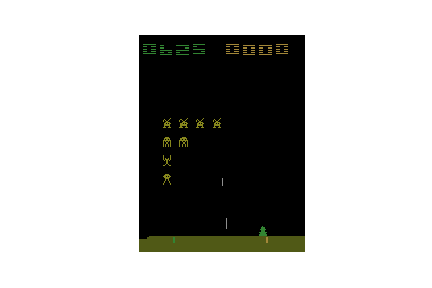
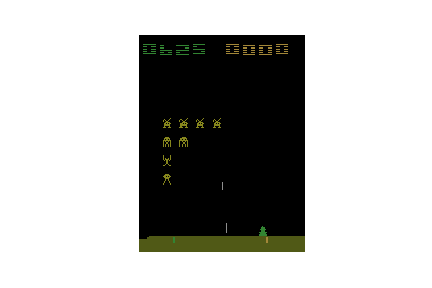
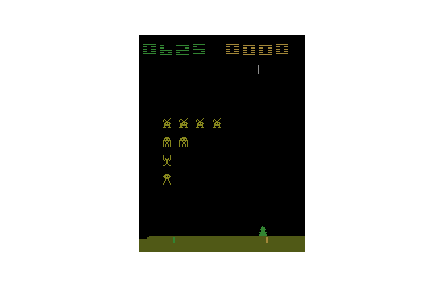
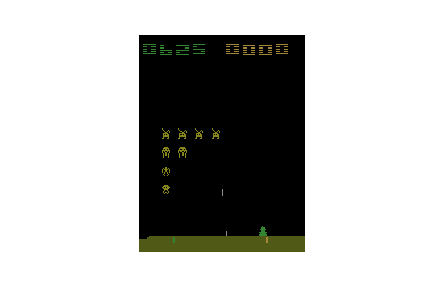
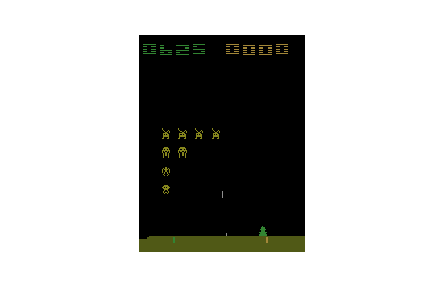
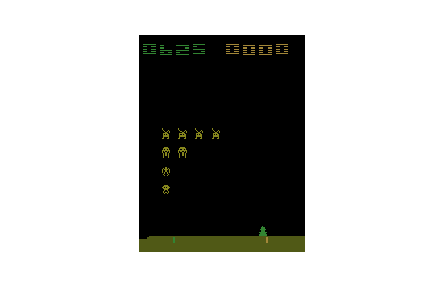
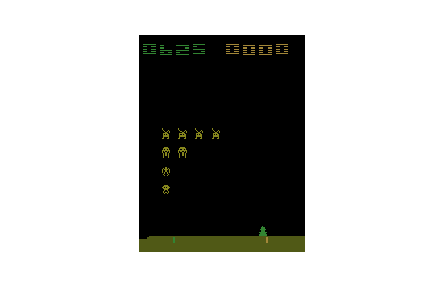
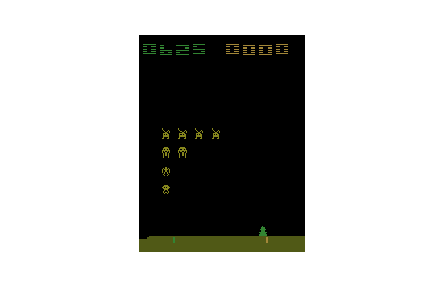
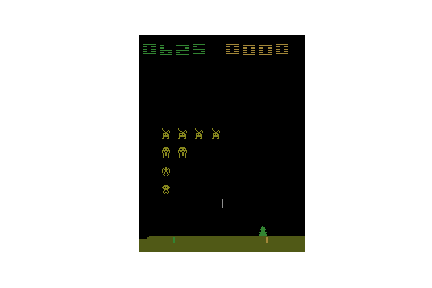
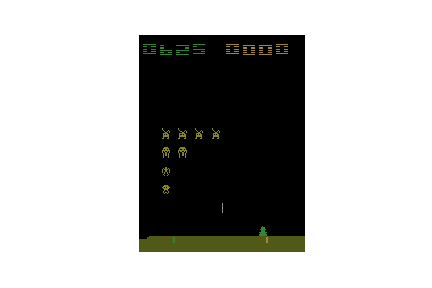
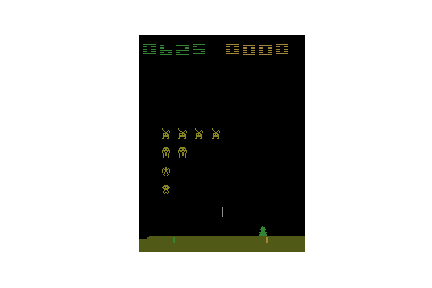
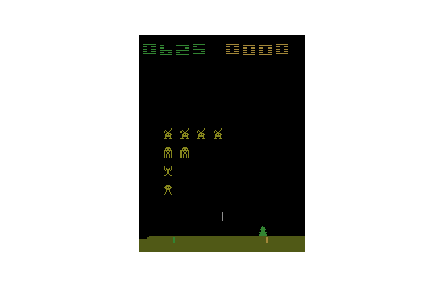
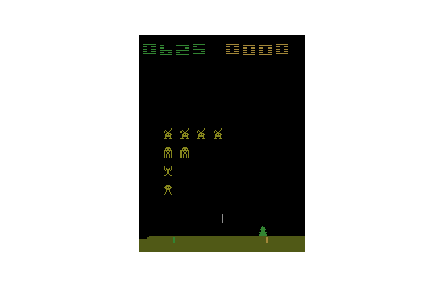
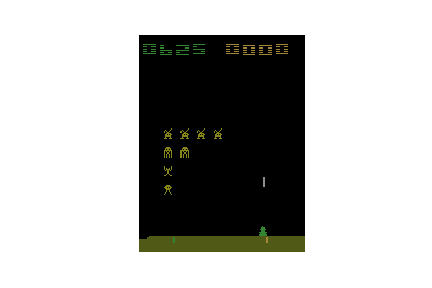
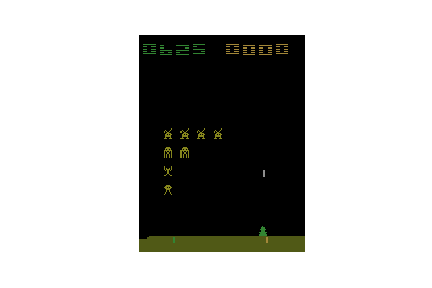
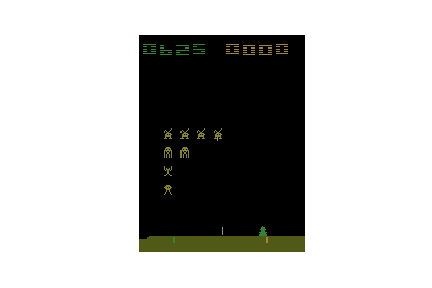
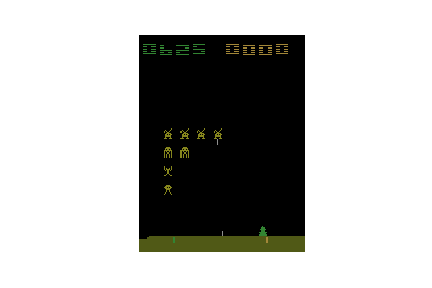
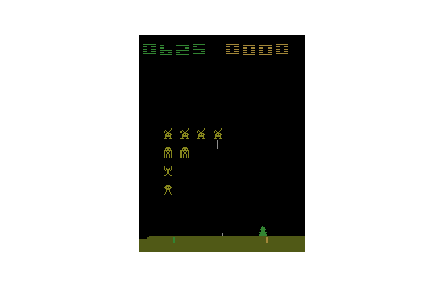
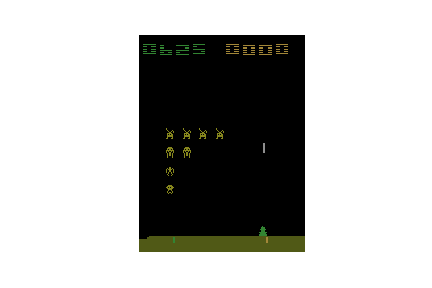
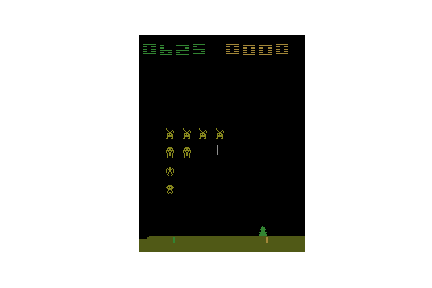
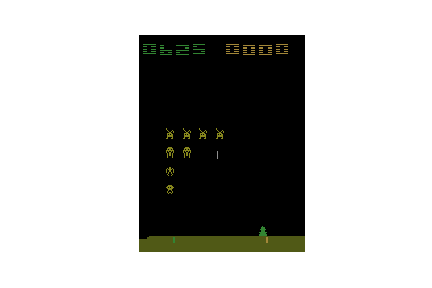
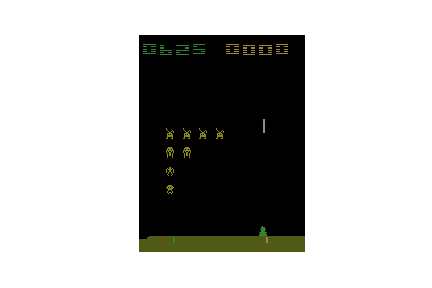
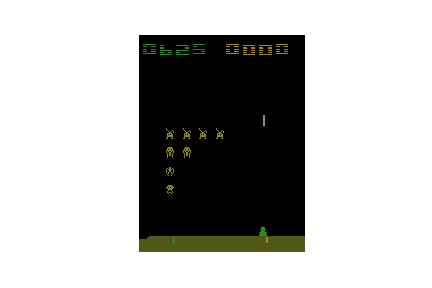
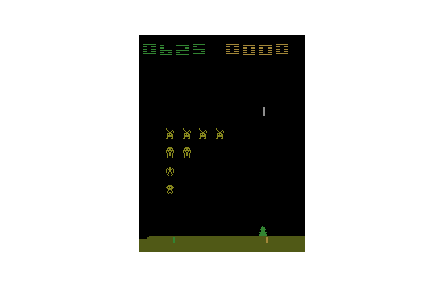
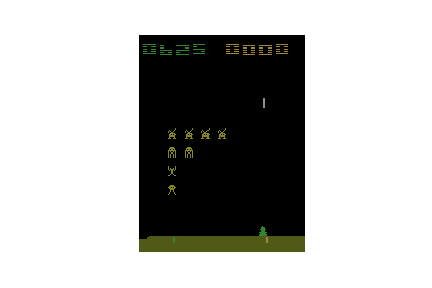
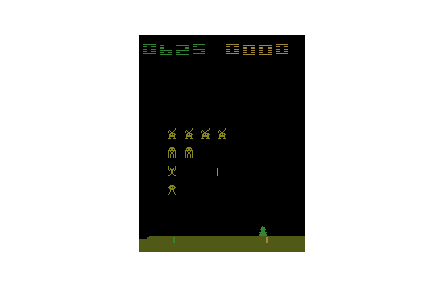
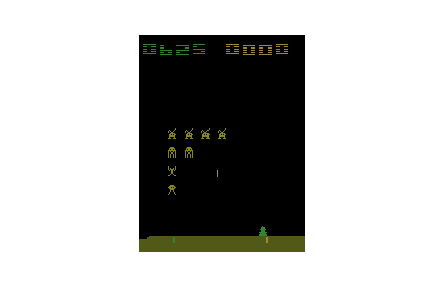
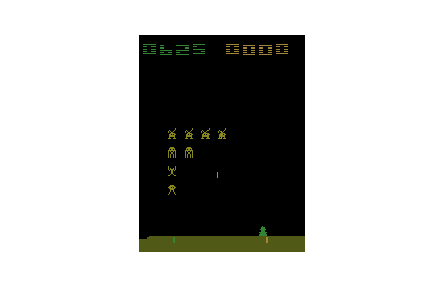
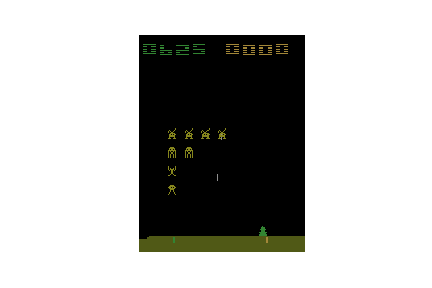
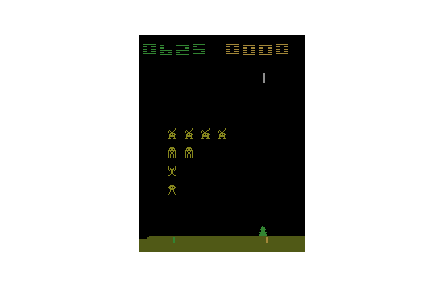
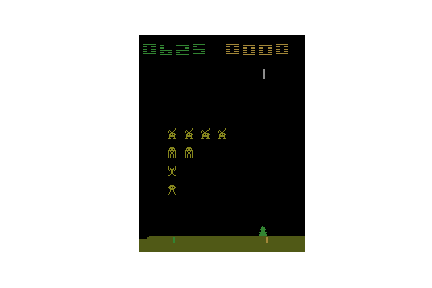
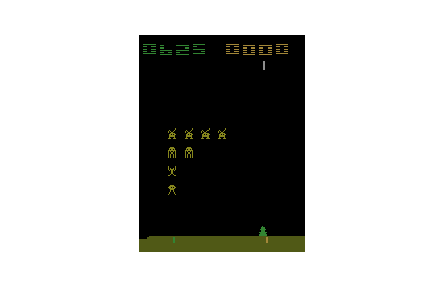
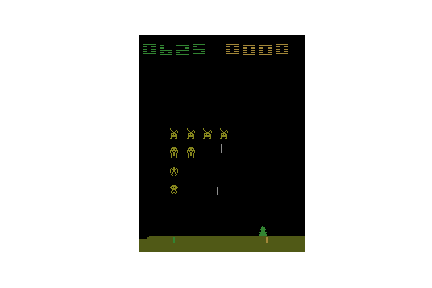
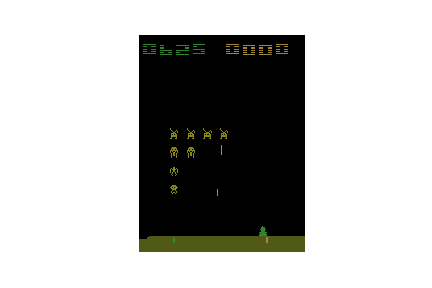
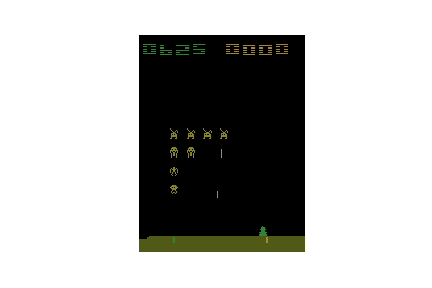
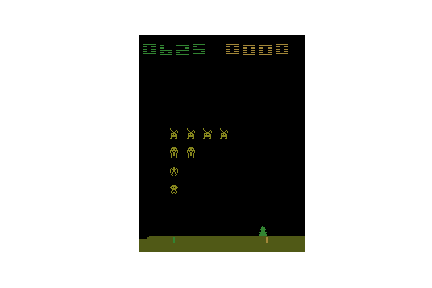
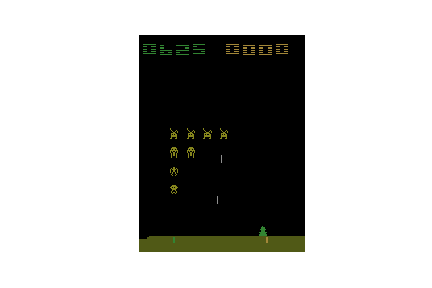
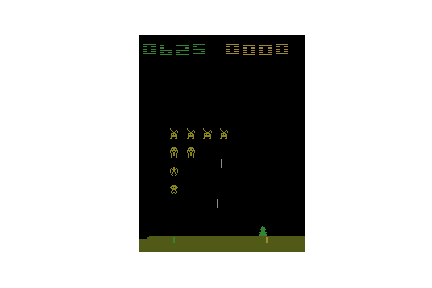
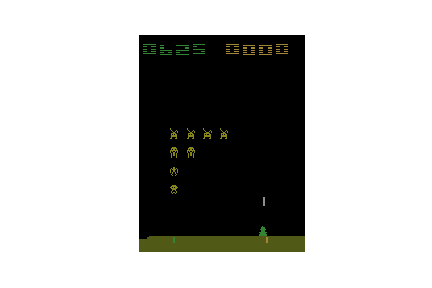
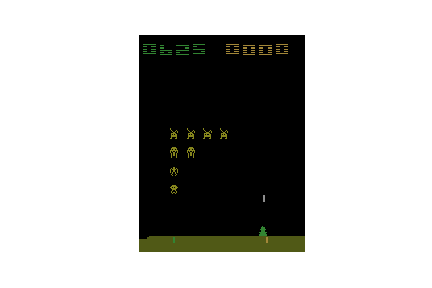
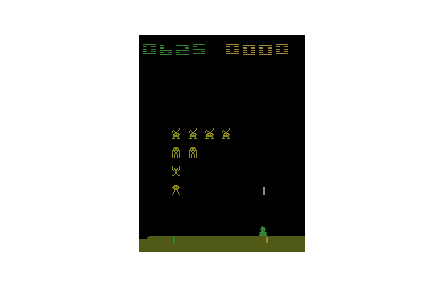
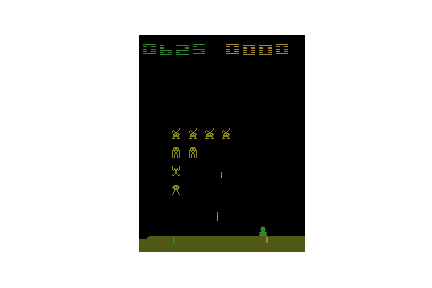
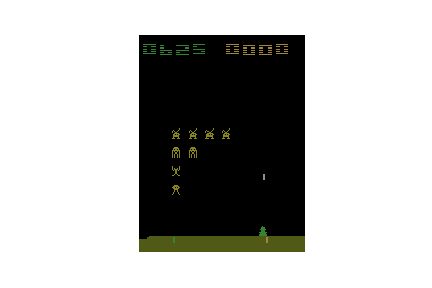
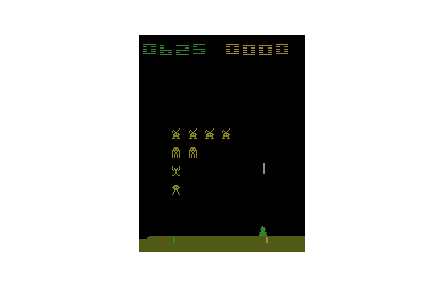
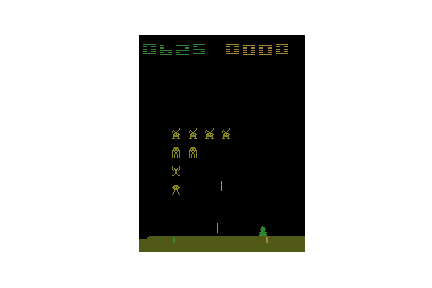
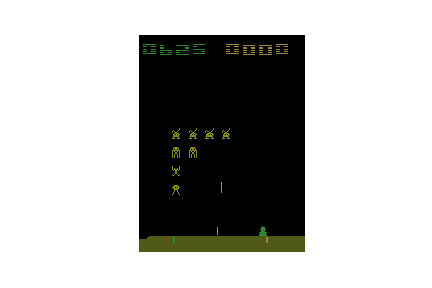
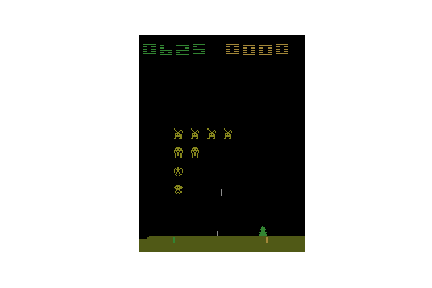
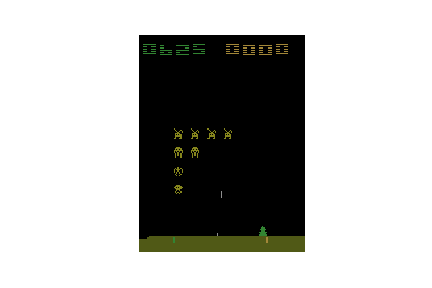
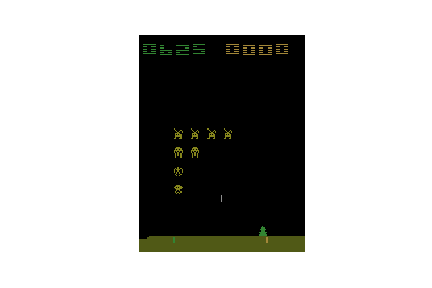
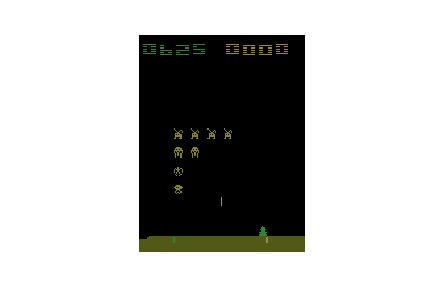
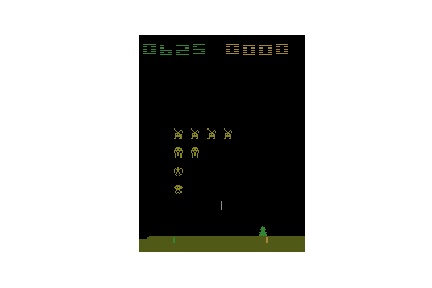
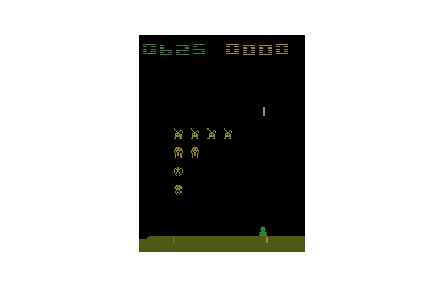
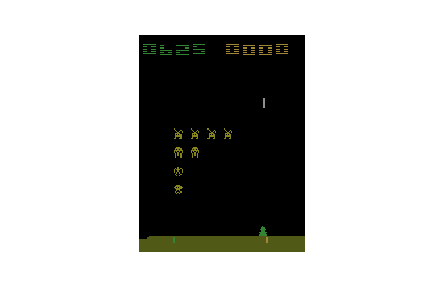
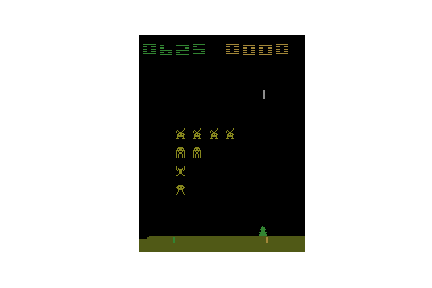
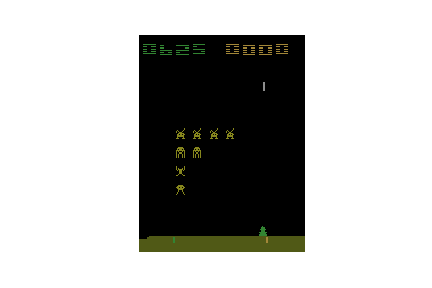
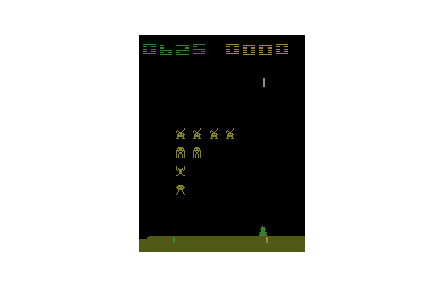
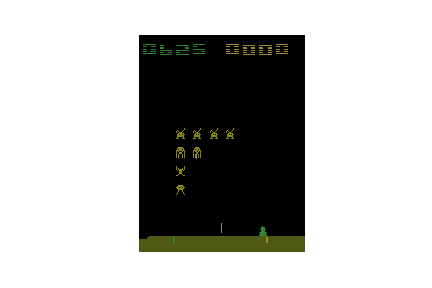
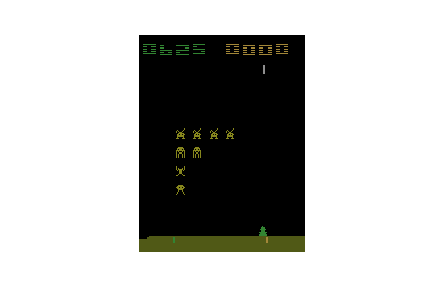
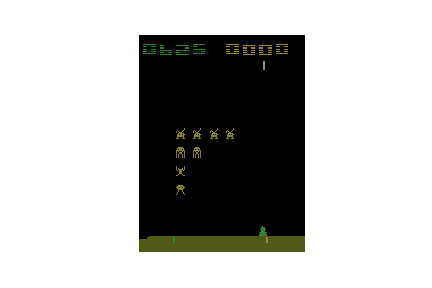
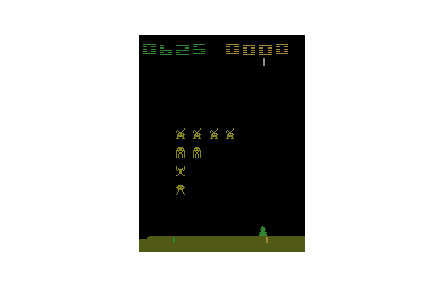
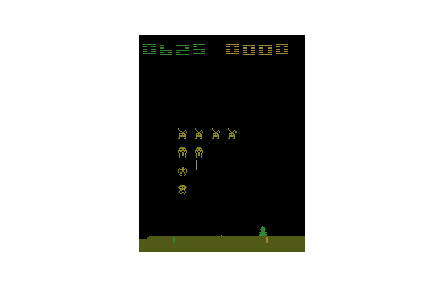
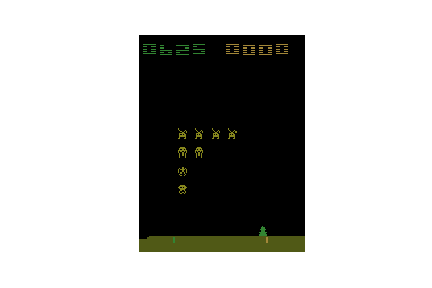
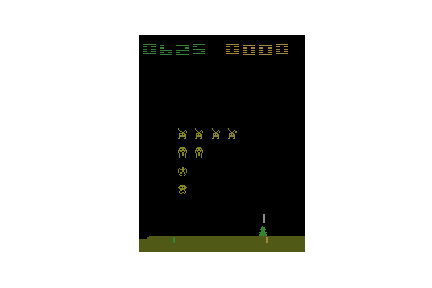
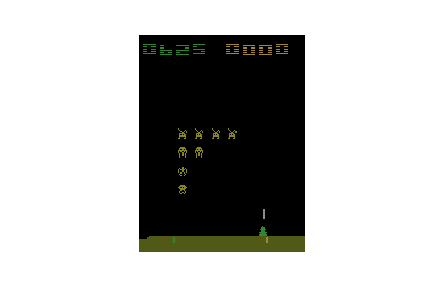
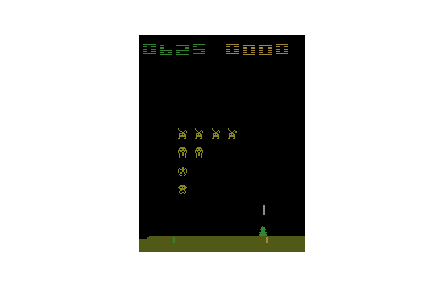
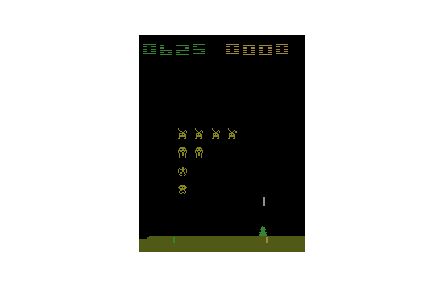
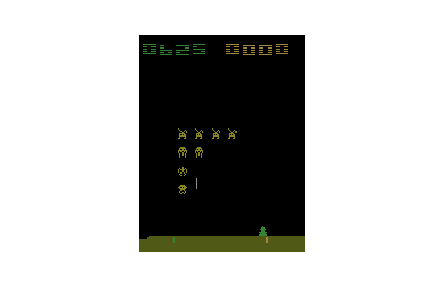
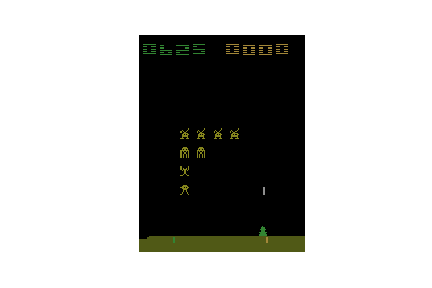
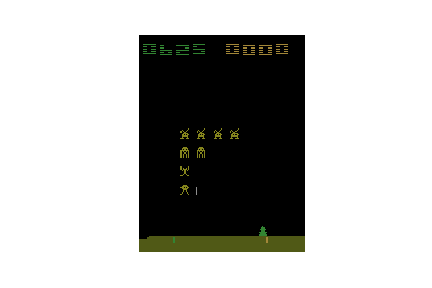
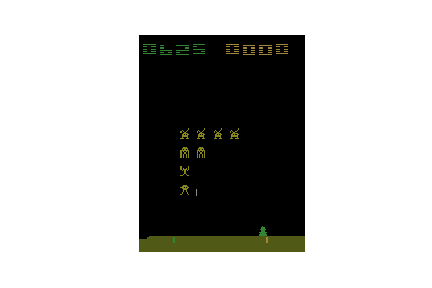
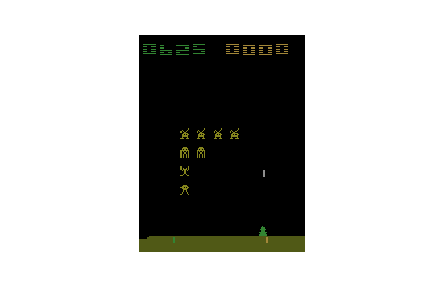
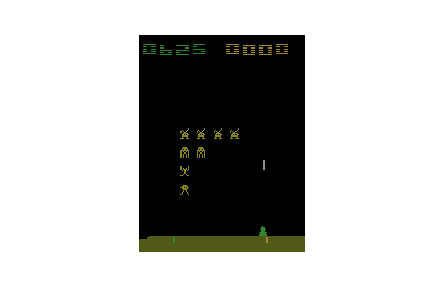
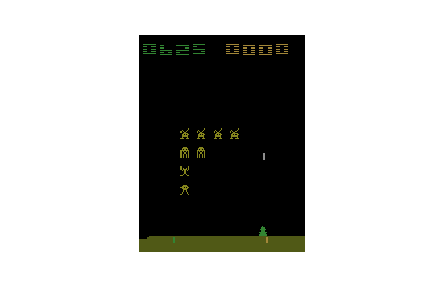
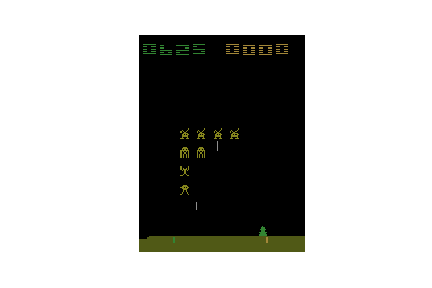
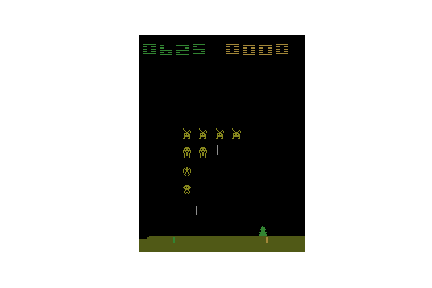
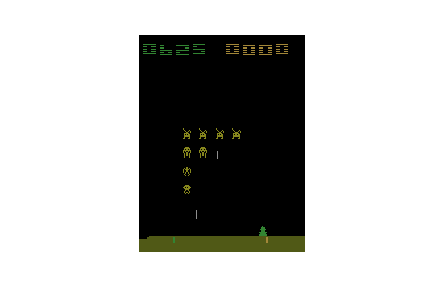
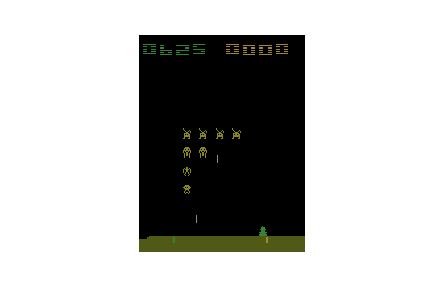
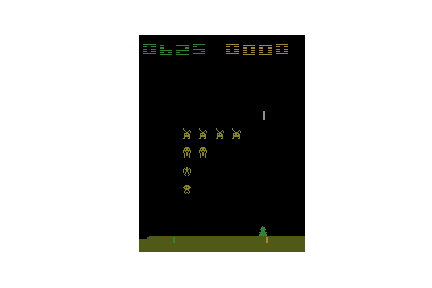
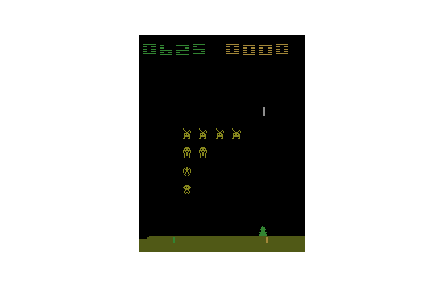
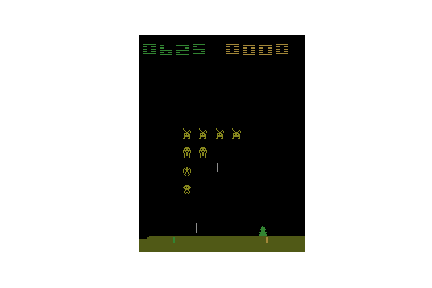
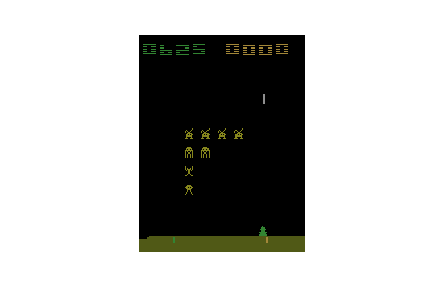
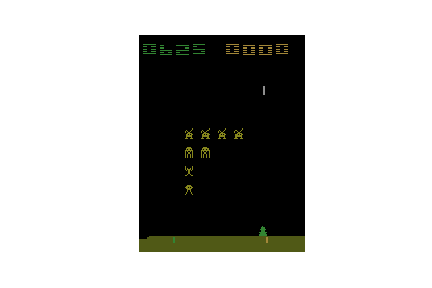
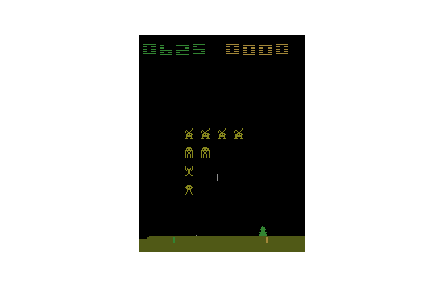
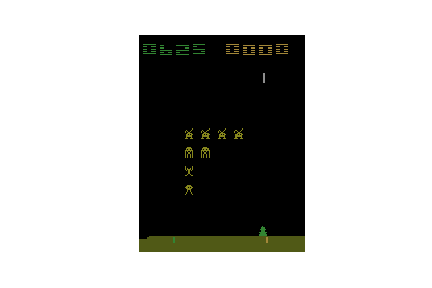
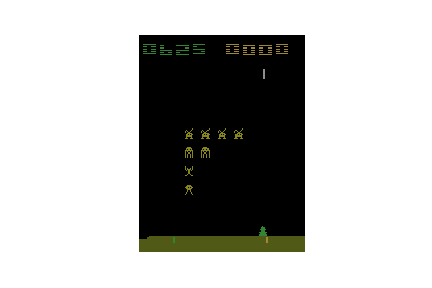
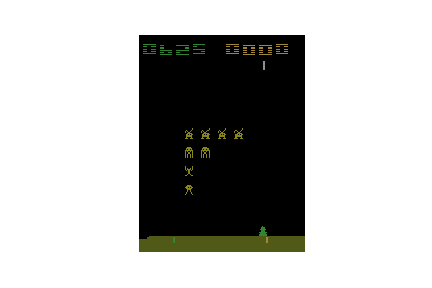
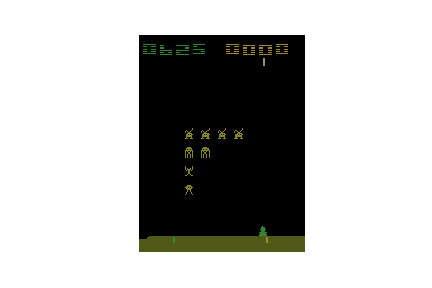
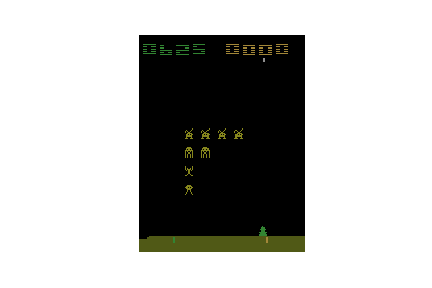
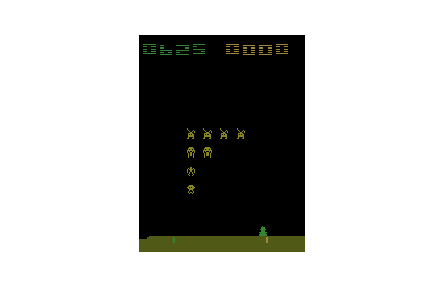
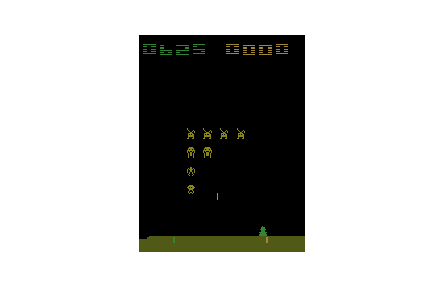
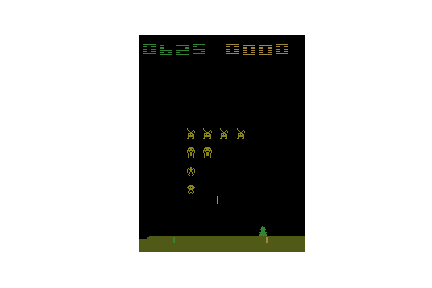
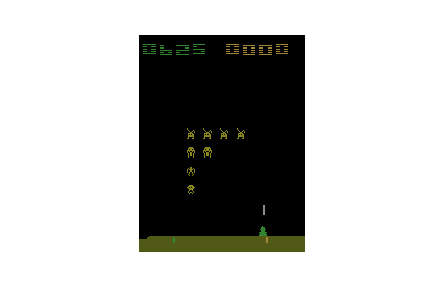
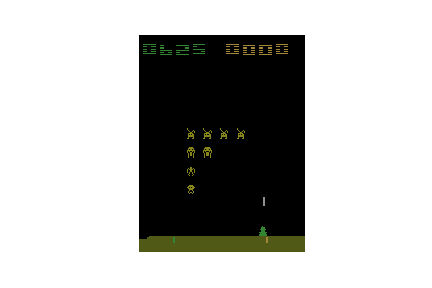
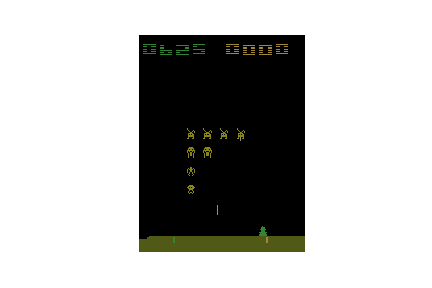
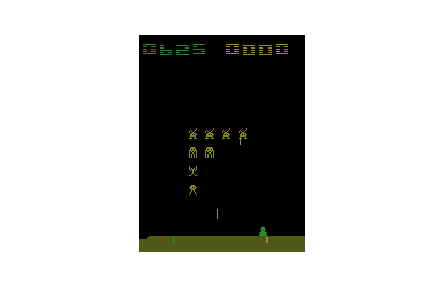
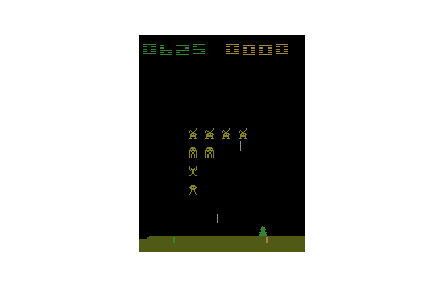
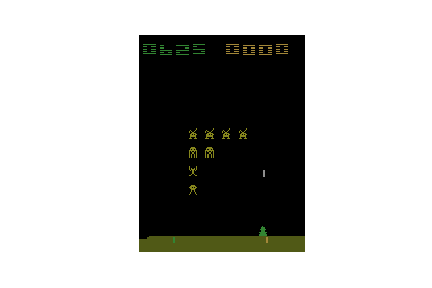
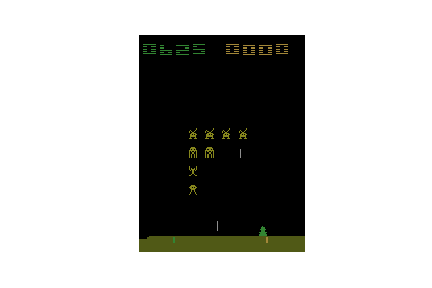
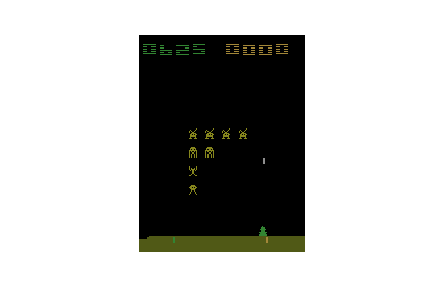
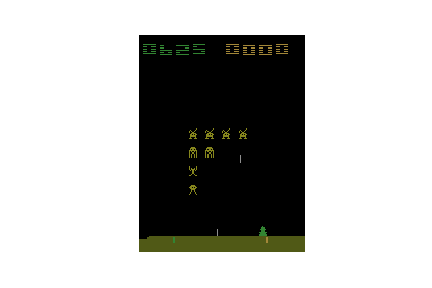
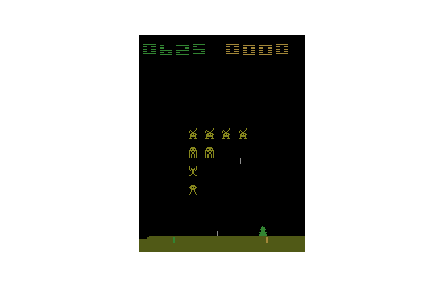
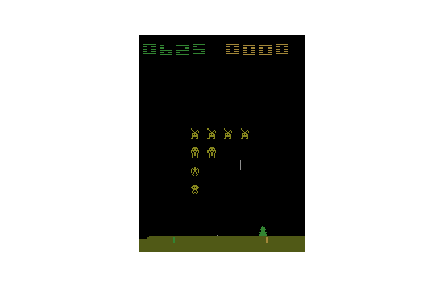
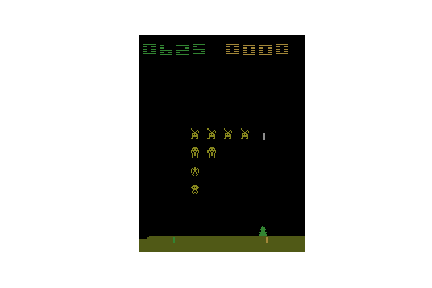
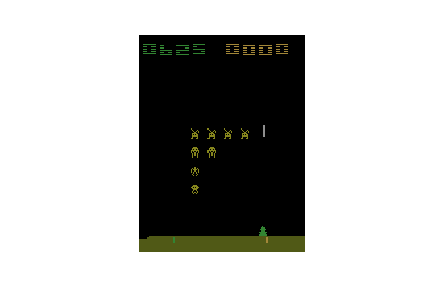
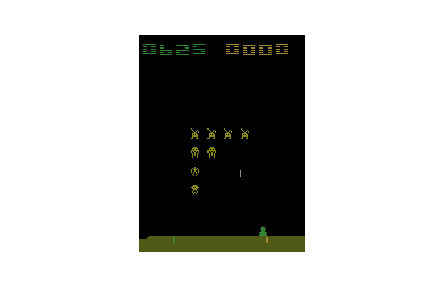
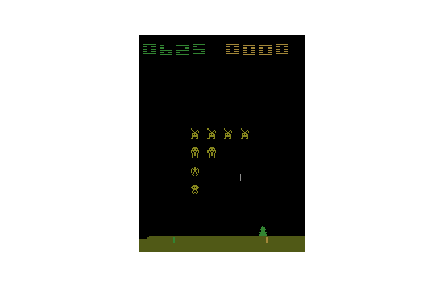
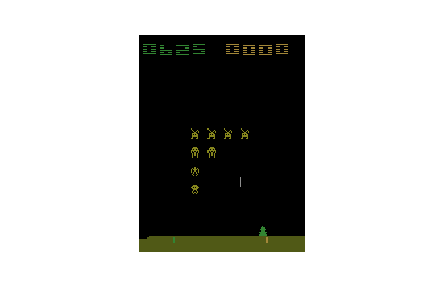
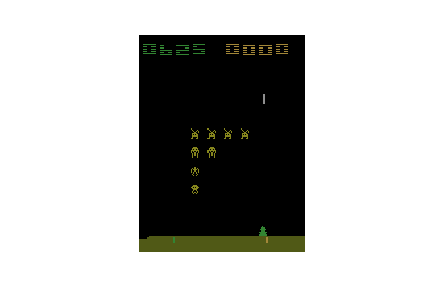
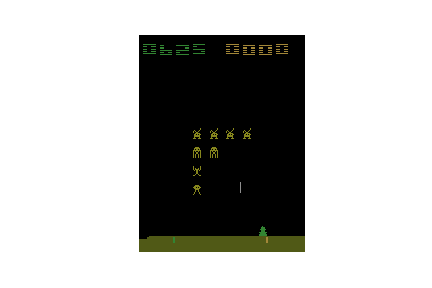
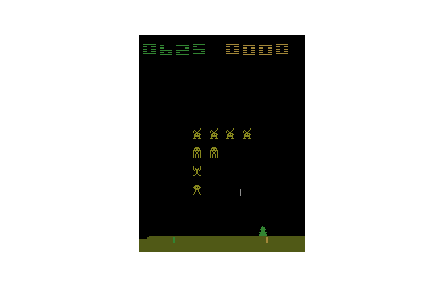
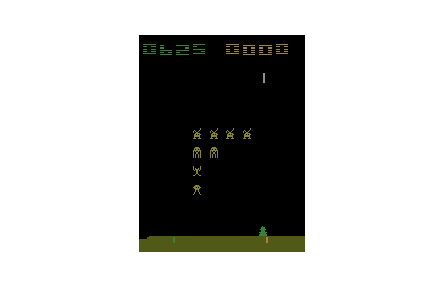
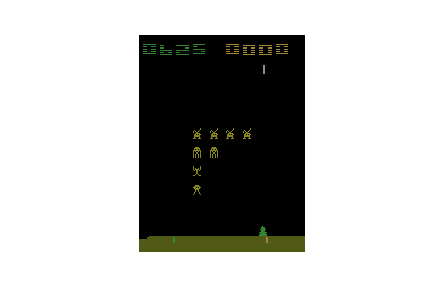
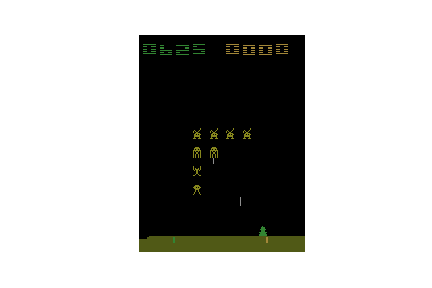
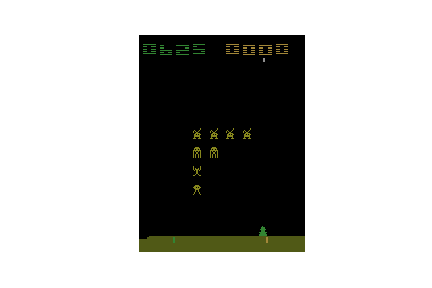
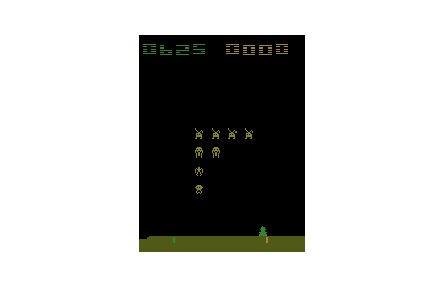
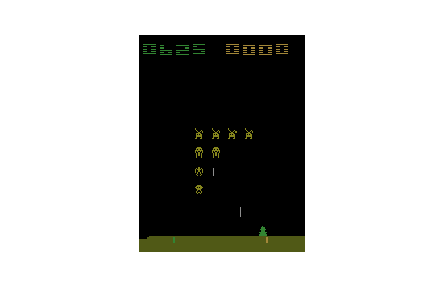
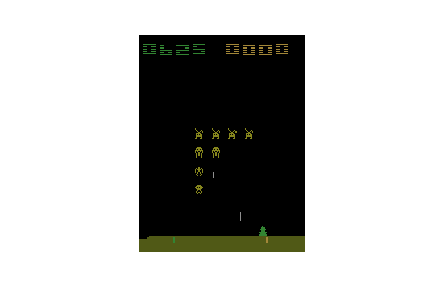
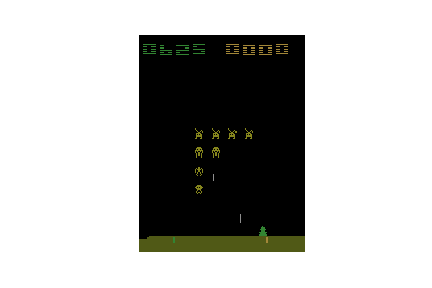
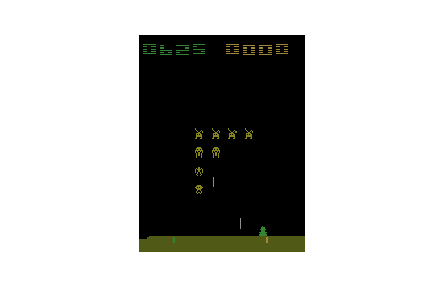
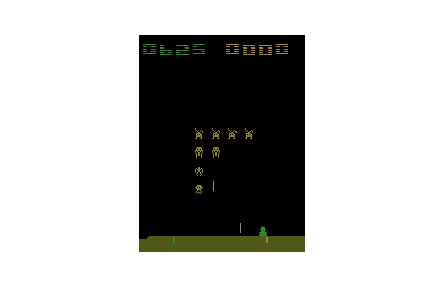
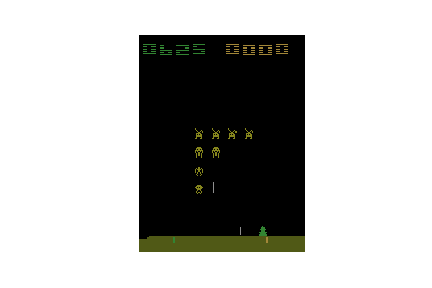
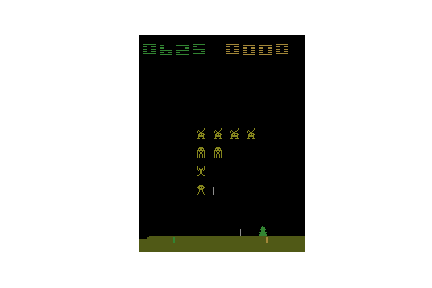
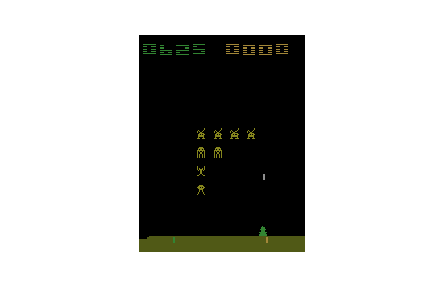
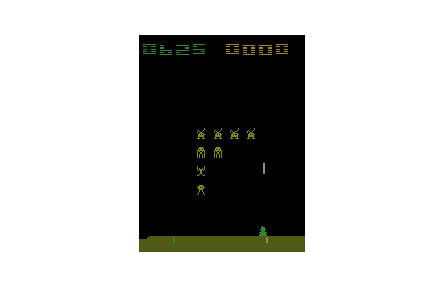
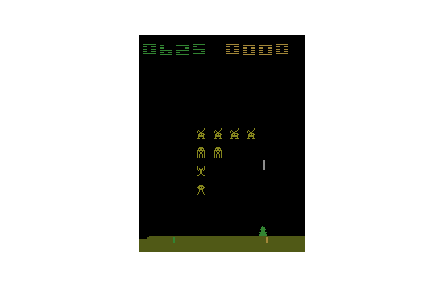
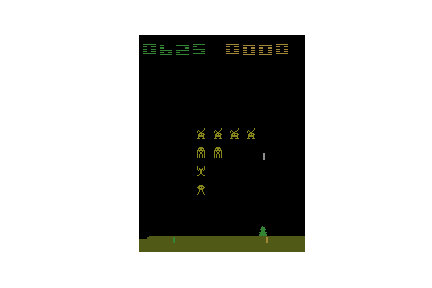
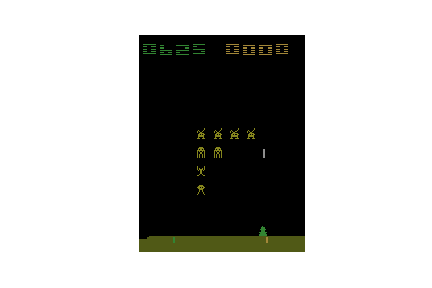
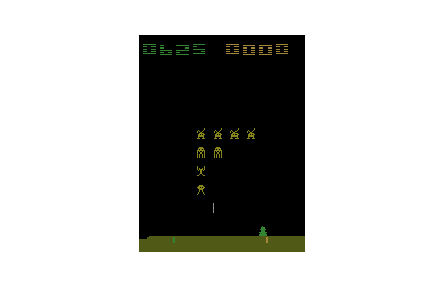
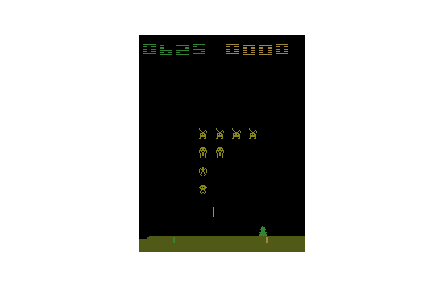
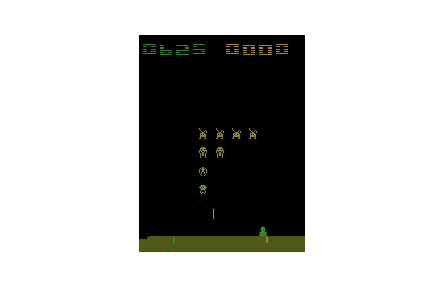
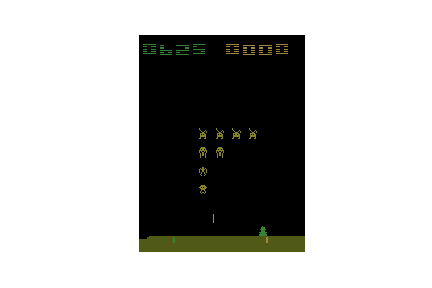
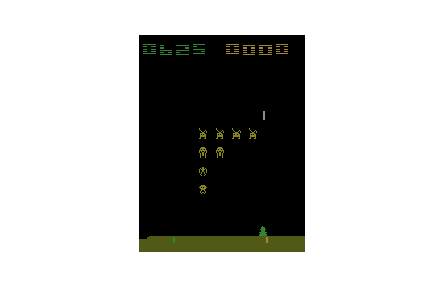
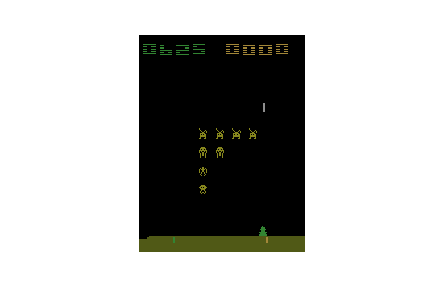
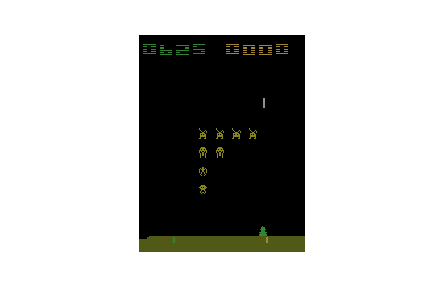
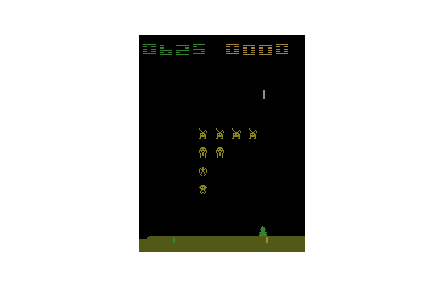
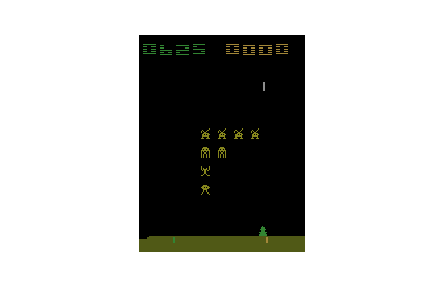
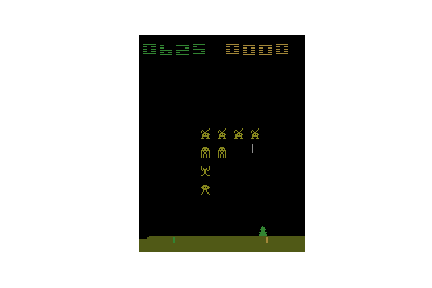
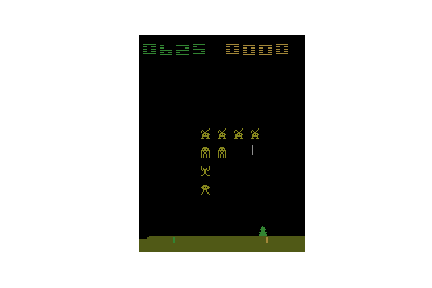
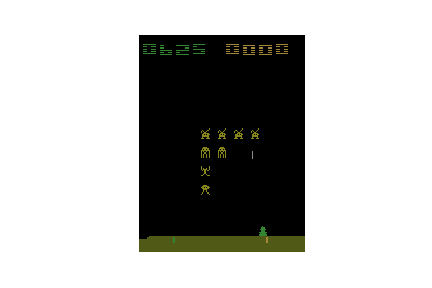
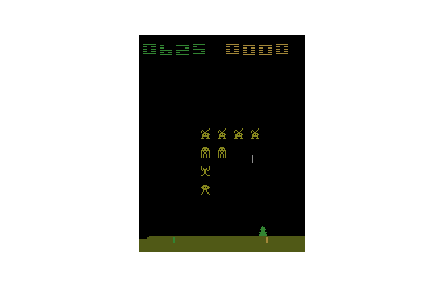
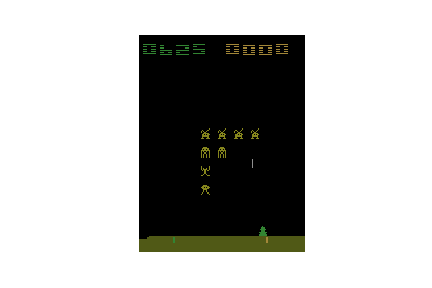
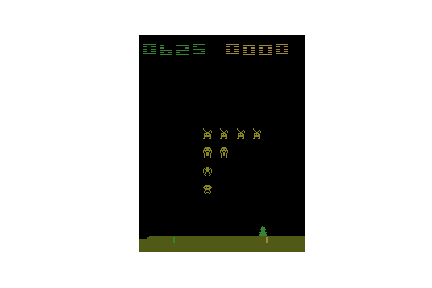
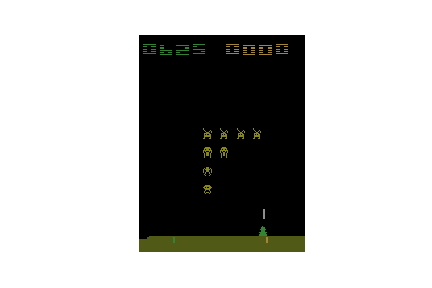
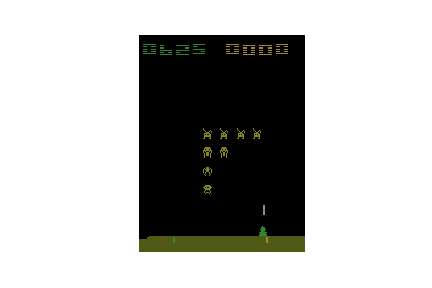
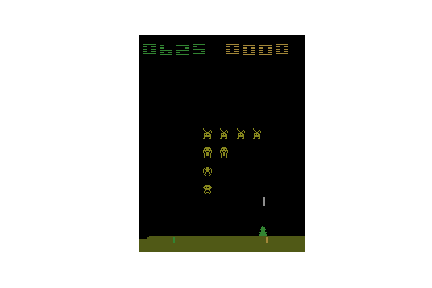
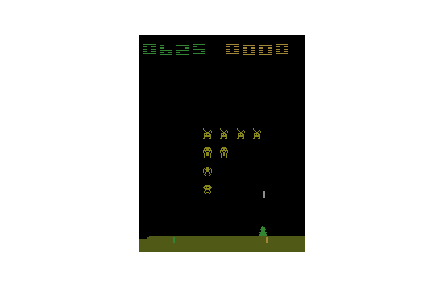
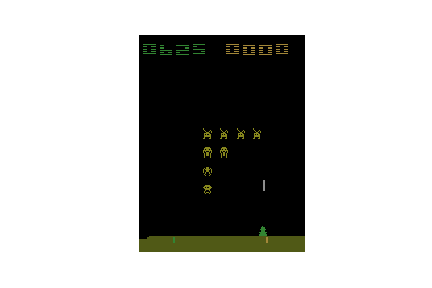
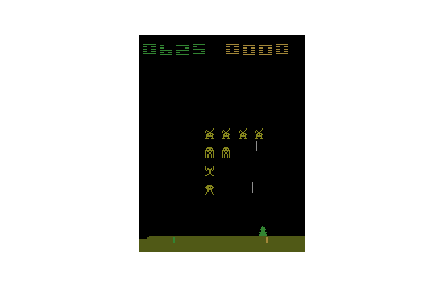
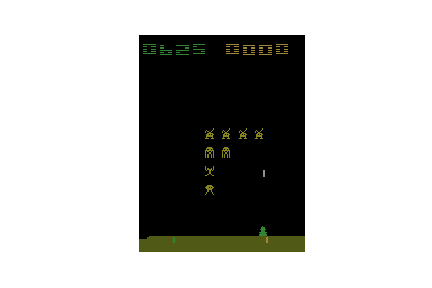
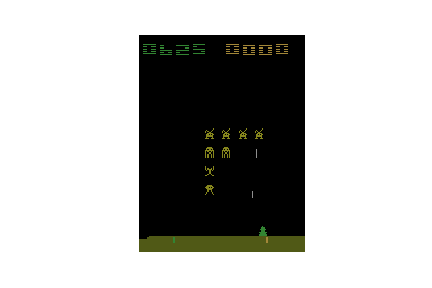
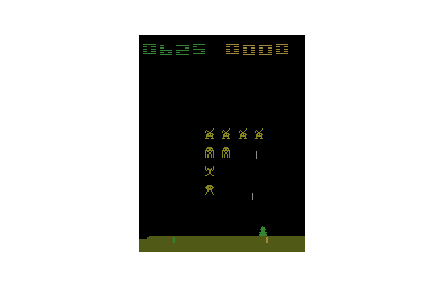
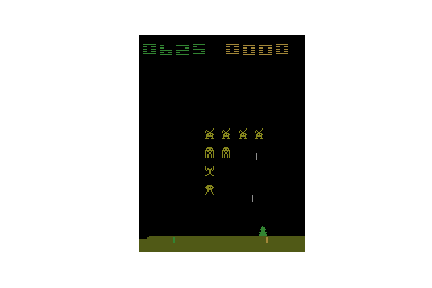
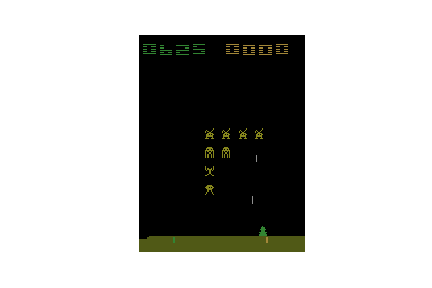
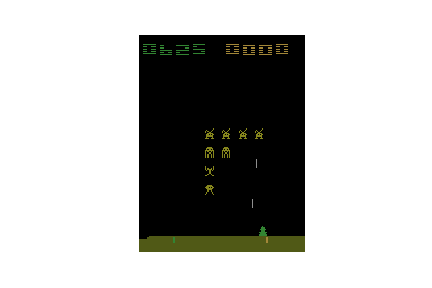
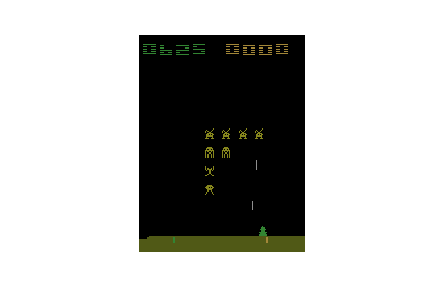
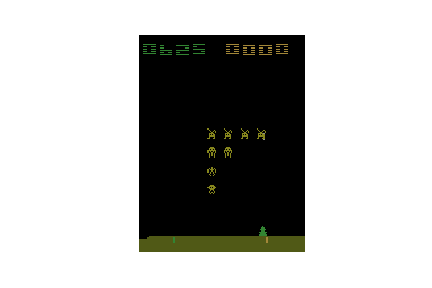
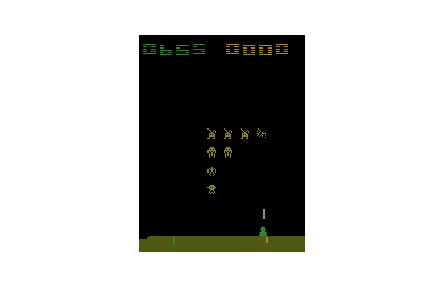
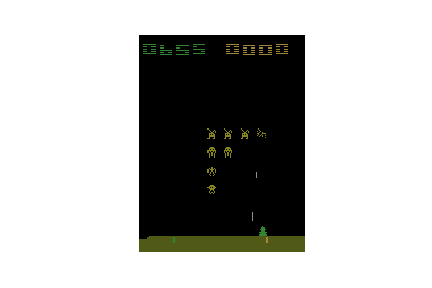
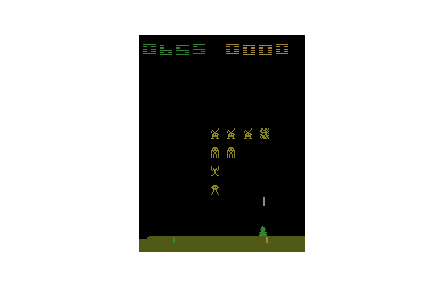
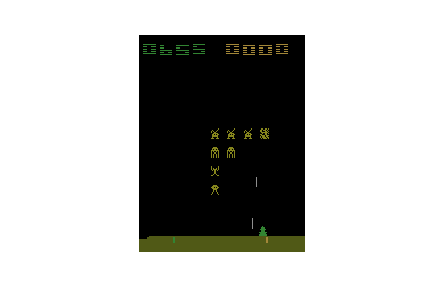
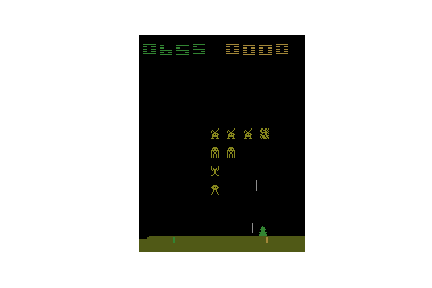
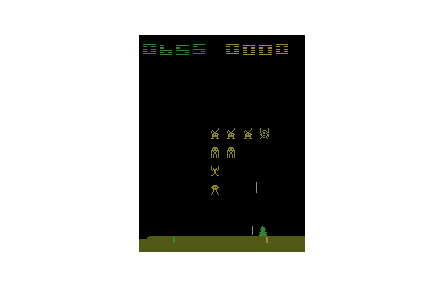
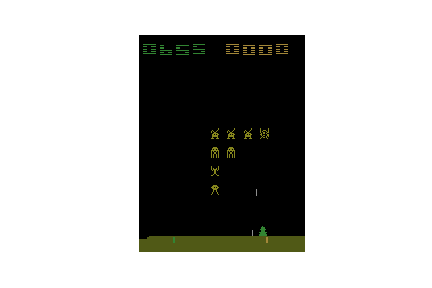
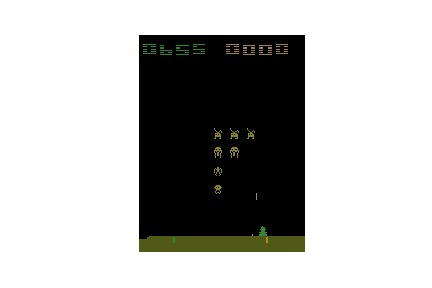
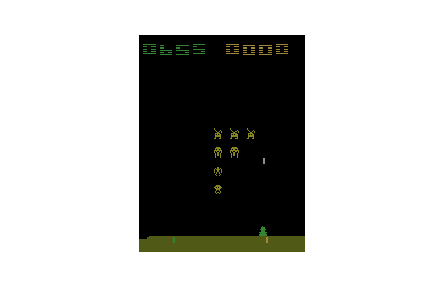
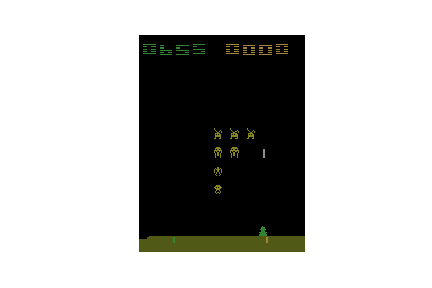
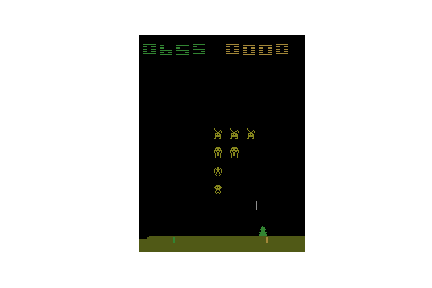
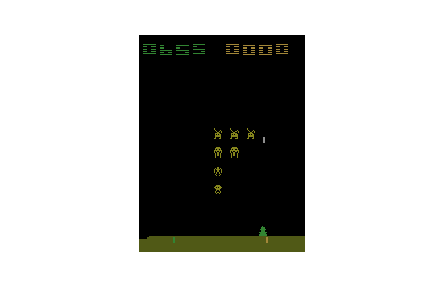
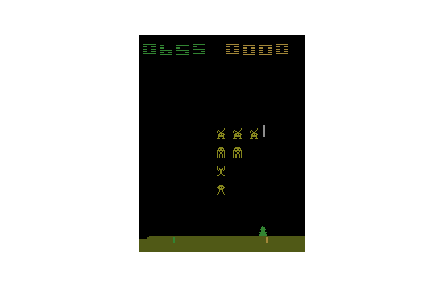
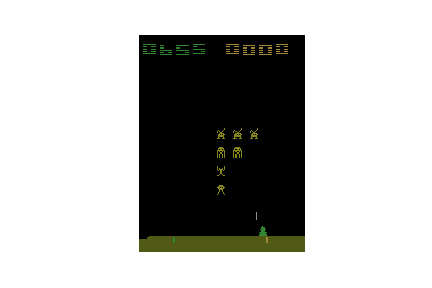
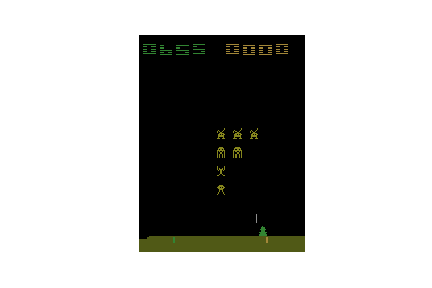
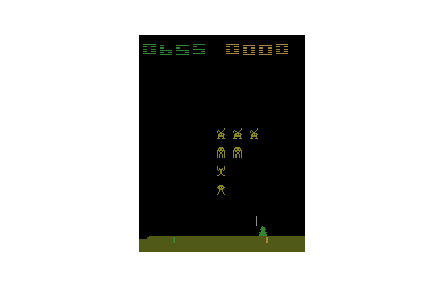
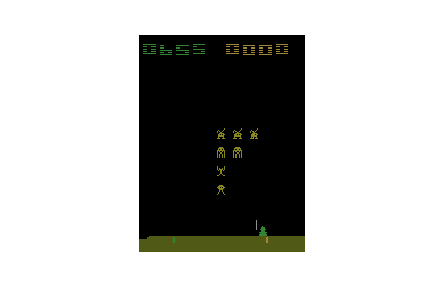
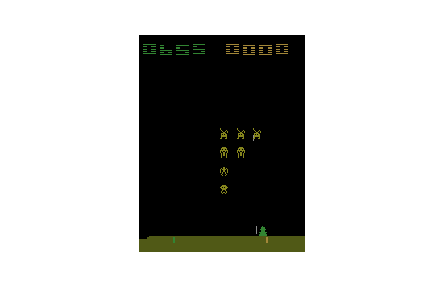
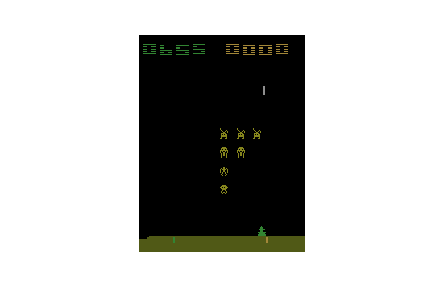
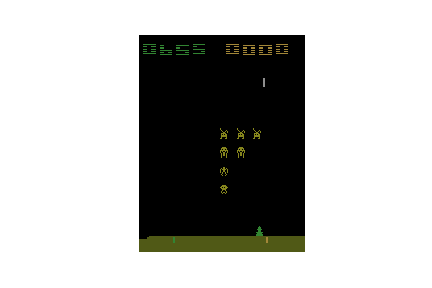
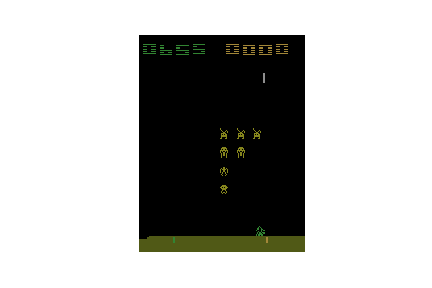
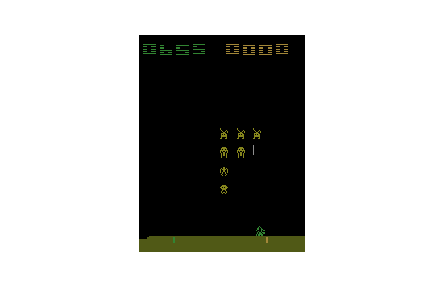
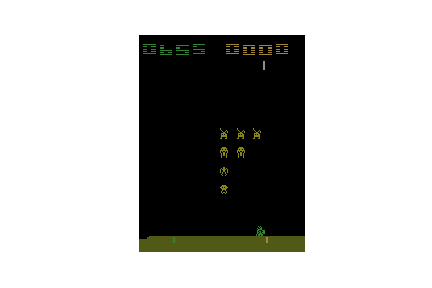
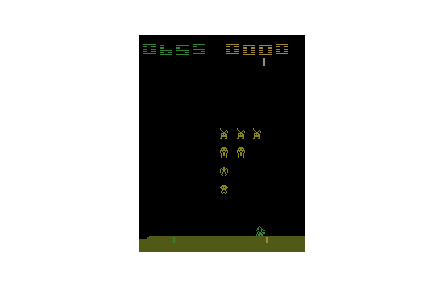
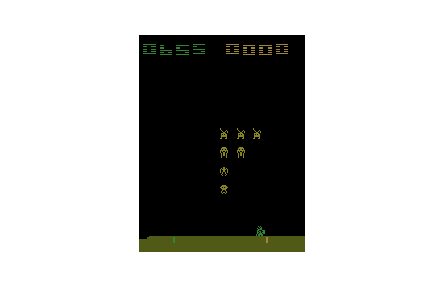
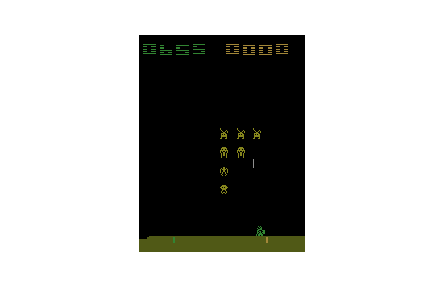
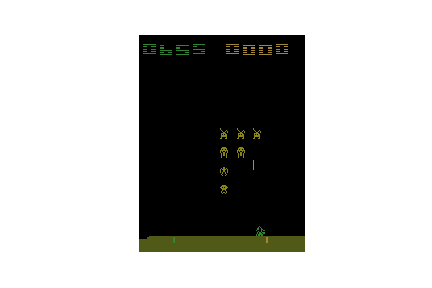
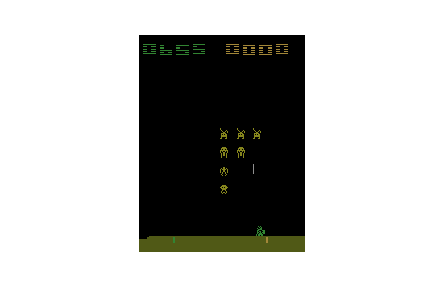
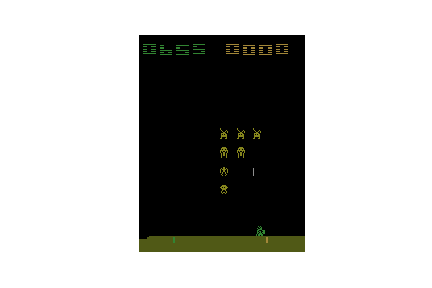
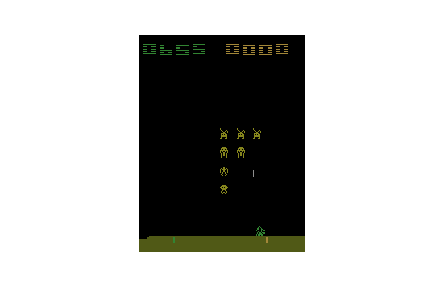
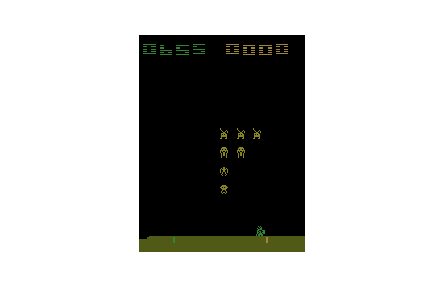
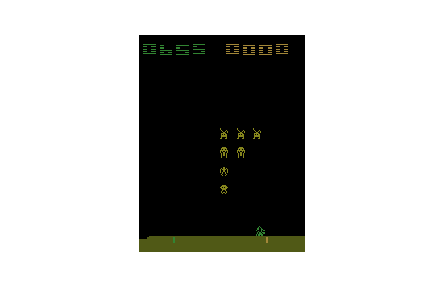
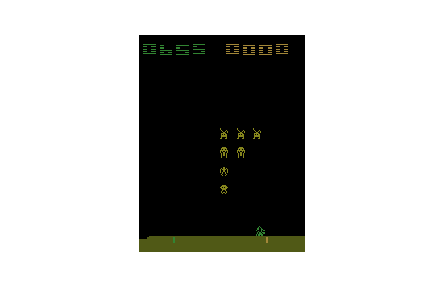
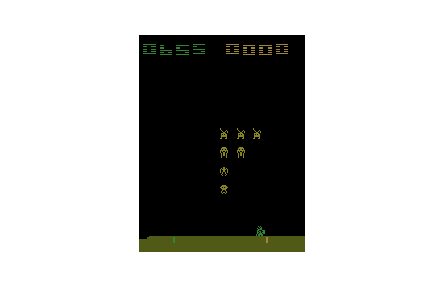
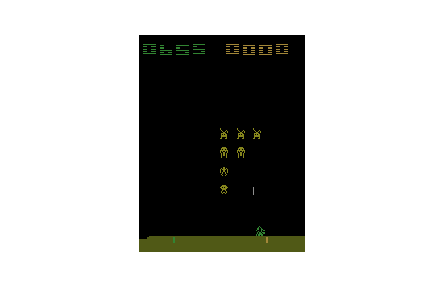
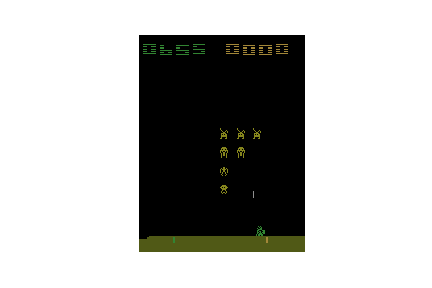
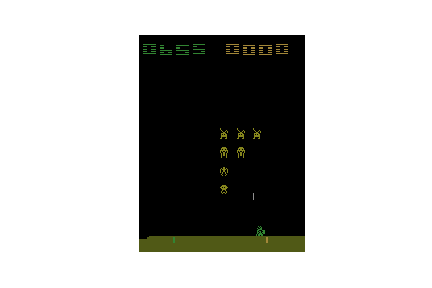
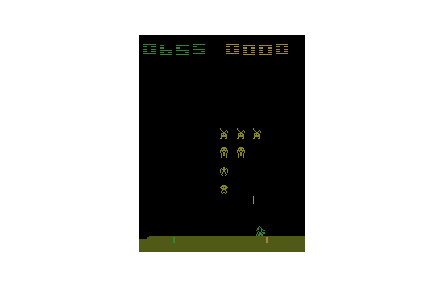
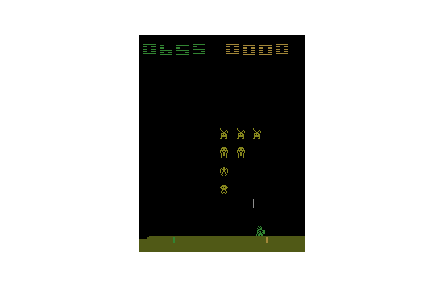
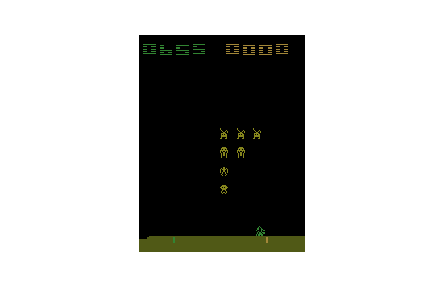
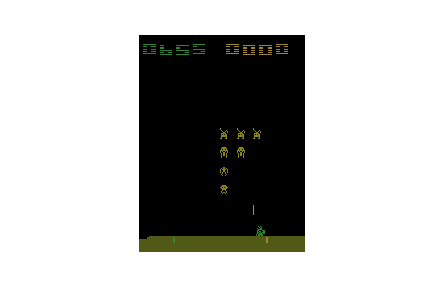
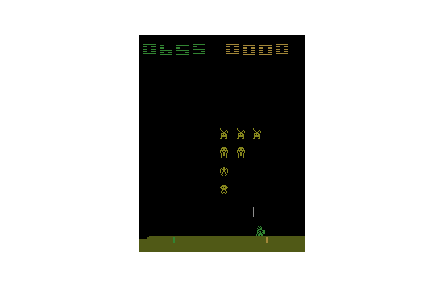
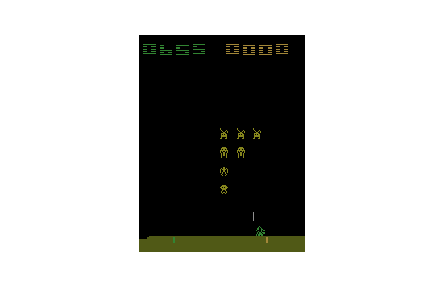
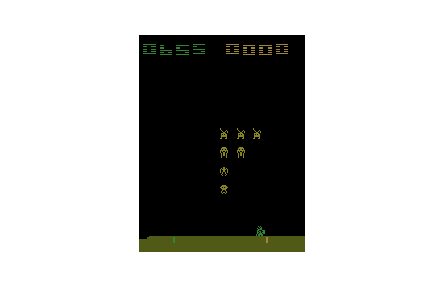
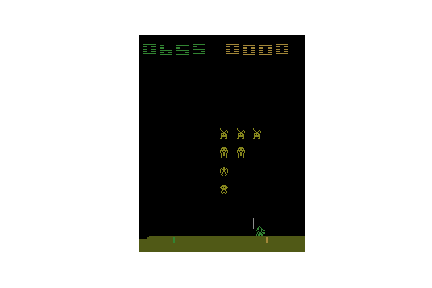
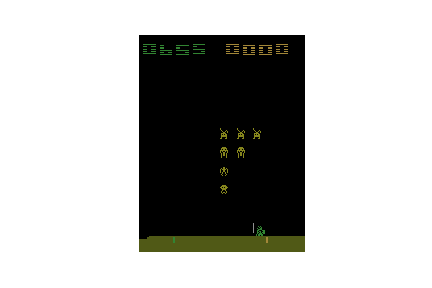
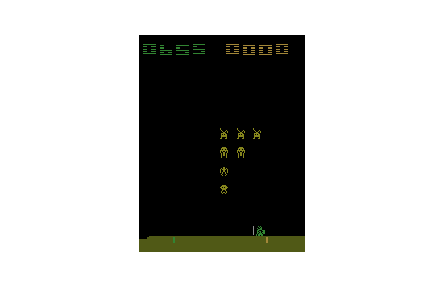
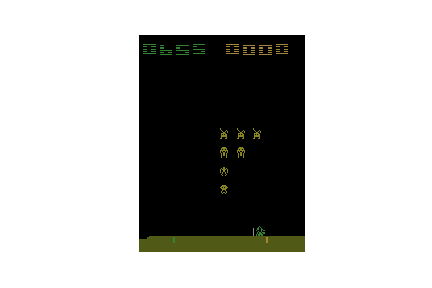
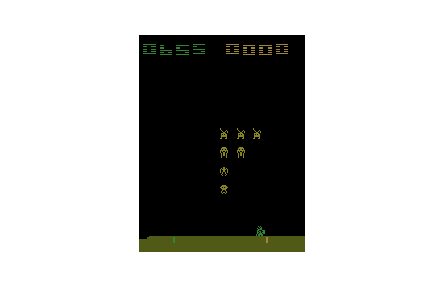
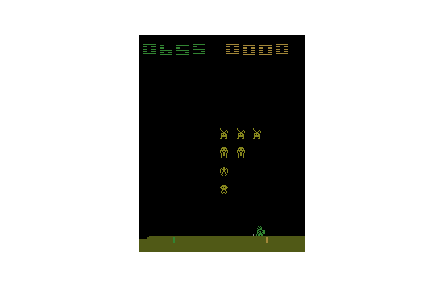
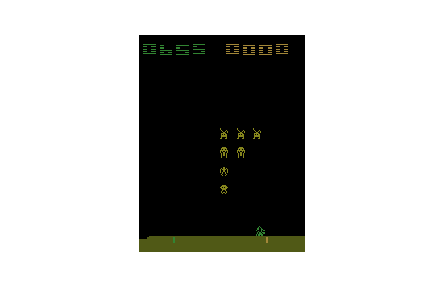
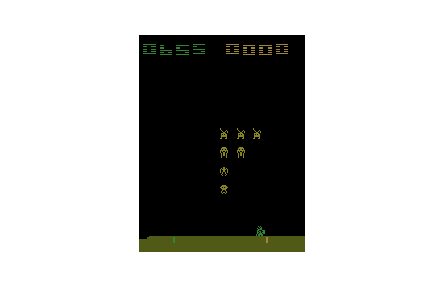
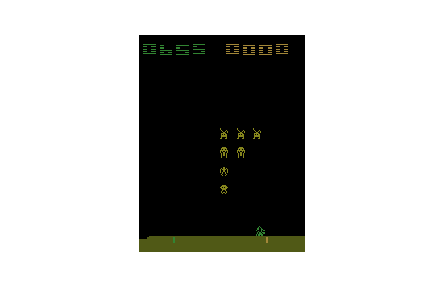
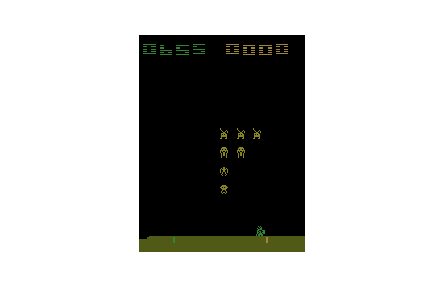
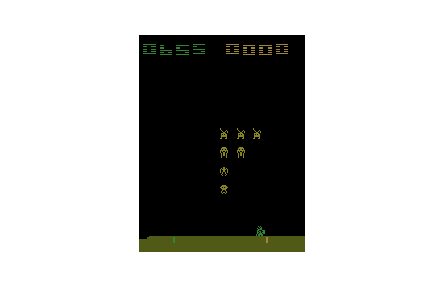
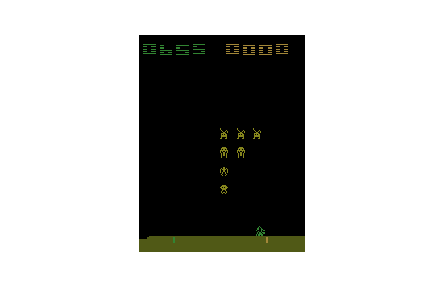
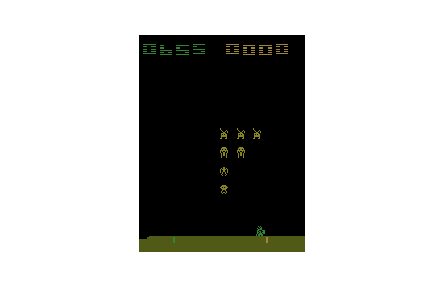
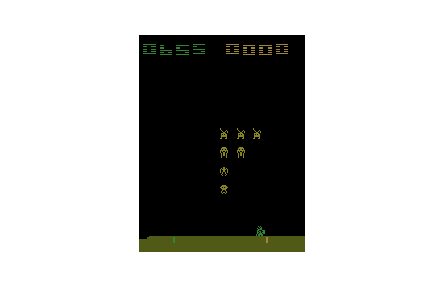
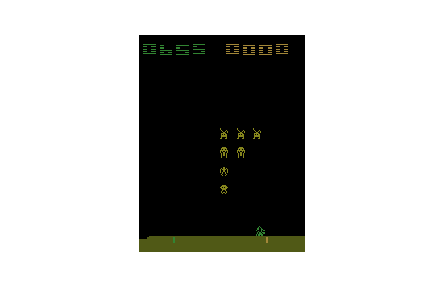
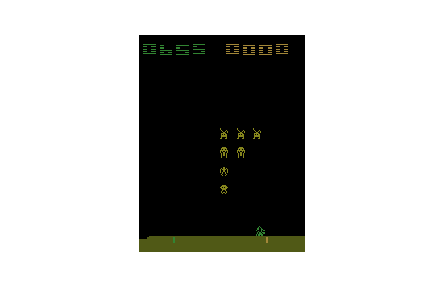
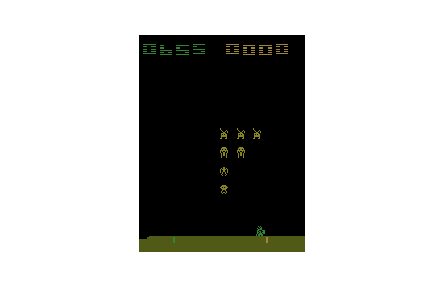
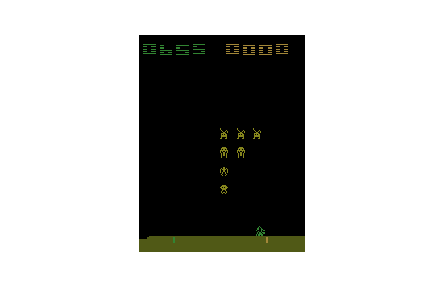
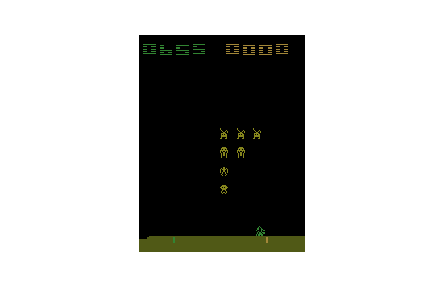
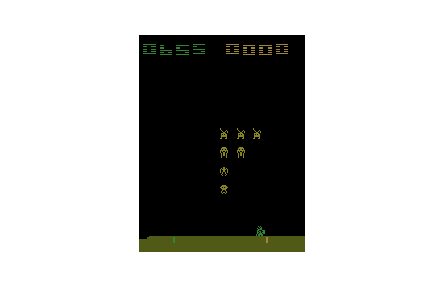

In [21]:
video_dir = "videos/" + model_name + "_" + str(training_id)
if not os.path.exists(video_dir):
    os.makedirs(video_dir)
    
num_episodes = 100
show_game = True
highest_reward = 0
best_play = []

with tf.device(device):
    with tf.Session() as sess:
        saver.restore(sess,  "./models/" + model_name + ".ckpt")

        for i in range(num_episodes):
            #Reset environment and get first new observation
            s = env.reset()

            d = False
            a = 0
            num_actions = 0
            frames = []
            total_reward = 0

            new_frame = preprocess_frame(s)
            for k in range(frame_stack_size):
                StackFrame(stacked_frames, new_frame)

            #The Q-Network
            while not d:
                num_actions+=1

    #             if show_game:
    #                 show_state(env)
                frames.append(env.render(mode = 'rgb_array'))


                #allQ = model.predict(np.vstack(c_stacked_frames).flatten())
                
                if num_actions % frame_skip_size == 0:
                    state = np.stack(stacked_frames,axis=2)
                    allQ = sess.run(action_network.output,
                                    feed_dict={action_network.inputs_:state.reshape((1,*state.shape))})
                    a = np.argmax(allQ)

                #Get new state and reward from environment
                s1,r,d,_ = env.step(a)

                total_reward += r

                #stack new frame
                StackFrame(stacked_frames, preprocess_frame(s1))

            print("Episode " + str(i) + " ended." + 
                      "\n\t Total Reward = " + str(total_reward))
            if total_reward > highest_reward:
                highest_reward = total_reward
                best_play = frames
                
video_path = video_dir + "/running_" + str(training_id) + "_spaceinvaders_r" + str(highest_reward)
create_gif_from_frames(best_play, save = True,
                      path=video_path )